In [15]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
from NetworkModel import *
from Round import *
from tqdm import tqdm

### Modelo e Parâmetros

In [16]:
class ModelMLP:
    @staticmethod
    def create_model():
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dense(10, activation="softmax")
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

In [17]:
# Definição dos parâmetros
NUMBER_OF_ROUNDS = 100
TOTAL_CLIENTS = 100
CLIENTS_PER_ROUND = 10
LAMBDA = 0.30
NUMBER_OF_TESTS = 5
SAVE_FIGURES = True

### Cliente

In [29]:
class Client():
    def __init__(self, cid):
        self.cid = int(cid)
        self.model = ModelMLP.create_model()
        self.old_weights = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/non-iid-0.9-100-rotation-45"

        train = pd.read_pickle(f"{path}/{self.cid+1}_train.pickle")
        test = pd.read_pickle(f"{path}/{self.cid+1}_test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def fit(self, parameters, config=None):
        self.model.set_weights(parameters)
        history = self.model.fit(self.x_train, self.y_train, epochs=5, batch_size=128, validation_data=(self.x_test, self.y_test), verbose=False)
        sample_size = len(self.x_train)
        print(f"Acurácia: {history.history['val_accuracy'][-1]} | ", end='')

        if random.random() > LAMBDA and self.old_weights is not None:
            print("Modelo NÃO transmitido!")
            return None

        print('Modelo transmitido!')
        self.old_weights = self.model.get_weights()
        return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1], 
                                                       "val_loss": history.history['val_loss'][-1]}


    def evaluate(self, parameters):
        self.model.set_weights(parameters)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Servidor

In [30]:
class Server():
    def __init__(self, n_rounds, total_number_clients, min_fit_clients):
        self.n_rounds = n_rounds
        self.total_number_clients = total_number_clients
        self.min_fit_clients = min_fit_clients

        self.server_round = 0
        self.selected_clients = []
        self.model = ModelMLP.create_model()
        self.w_global = self.model.get_weights()

        self.clients_model_list = []
        # Vamos guardar todos os modelos (pesos) anteriores, mas não é necessário
        self.clients_previous_models_list = [ [] for _ in range(total_number_clients) ]
        self.create_models()
        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        path = "../dataset-mnist/mnist"

        train = pd.read_pickle(f"{path}/train.pickle")
        test = pd.read_pickle(f"{path}/test.pickle")

        x_train = train.drop(['label'], axis=1)
        y_train = train['label']

        # test = pd.concat([test, train])
        x_test = test.drop(['label'], axis=1)
        y_test = test['label']

        return (x_train, y_train), (x_test, y_test)


    def create_models(self):
        for i in range(self.total_number_clients):
            self.clients_model_list.append(Client(i))


    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)


    def configure_fit(self, selected_clients = None):
        if selected_clients is None:
            self.selected_clients = np.random.permutation(list(range(self.total_number_clients)))[:self.min_fit_clients]
        else:
            self.selected_clients = selected_clients
        print(f"Clientes selecionados: \033[34;1m{np.array(self.selected_clients) + 1}\033[37;0m")

    
    def get_client_previous_model(self, client_id):
        return self.clients_previous_models_list[client_id][-1]


    def save_client_previous_model(self, client_id, model):
        self.clients_previous_models_list[client_id].append(model)


    def fit(self):
        weight_list, sample_sizes_list, info_list, sender_clients = [], [], [], []
        for i, pos in enumerate(self.selected_clients):
            print(f"Cliente #{pos+1} | ", end='')

            # Se o cliente decidir não enviar o modelo, ele retorna um None
            new_model = self.clients_model_list[pos].fit(parameters=self.w_global)

            weights, size, info = new_model if new_model is not None else self.get_client_previous_model(pos)
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)

            # Se o cliente enviou um novo modelo, salve-o e insira-o ao sender_client
            if new_model is not None:
                self.save_client_previous_model(pos, (weights, size, info_list))
                sender_clients.append(pos)

        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos+1, info_list[i]) for i, pos in enumerate(self.selected_clients)]}, sender_clients


    def distributed_evaluation(self):
        loss_list, accuracy_list = [], []
        for i in range(self.total_number_clients):
            loss, accuracy = self.clients_model_list[i].evaluate(parameters=self.w_global)
            # print(f"Evaluate - CID: {i+1} - accuracy: {accuracy}")
            loss_list.append(loss)
            accuracy_list.append(accuracy)
        return sum(loss_list) / len(loss_list), sum(accuracy_list) / len(accuracy_list), {"accuracy_list": [(i+1, accuracy) for i, accuracy in enumerate(accuracy_list)]}


    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Execução e Exibição

In [48]:
network_model = NetworkModel()

def executar(id):
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'CARREGAMENTO DE DADOS' + '\033[37;0m'))
    print("{:^40}".format(f'Número total de clientes: {TOTAL_CLIENTS}' + '\n'))
    
    s = Server(n_rounds=NUMBER_OF_ROUNDS,
               total_number_clients=TOTAL_CLIENTS,
               min_fit_clients=CLIENTS_PER_ROUND)
    
    print('\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'INICIANDO' + '\033[37;0m'))
    print("{:^40}".format(f'Clientes por rodada: {CLIENTS_PER_ROUND} ' + '\n'))
    
    evaluate_list = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}
    network_model = NetworkModel(usernumber=TOTAL_CLIENTS, RBnumber=CLIENTS_PER_ROUND)
    transmissions_per_round = []
    energy_consumption_per_round = []
    
    # Rodadas de comunicação
    for s.server_round in tqdm(range(s.n_rounds)):
        communication_round = Round(network_model)
        
        print('\033[;1m' + f'Rodada {s.server_round+1}/{s.n_rounds}' + '\033[37;0m')
    
        # Seleciona os clientes que participarão da próxima rodada de comunicação
        _, selected_clients = network_model.selecao_clientes_aleatoria()
        q, rbs_attribution = network_model.atribuicao_RBs(selected_clients)
        print(rbs_attribution)

        
        s.configure_fit(selected_clients)
        
        # Treinamento local do dispositivo
        weight_list, sample_sizes, info, sender_clients = s.fit()
        communication_round.set_clients(selected_clients)
        communication_round.set_sender_clients(sender_clients)
        communication_round.set_rb_allocation(rbs_attribution)
    
        # Salva a quantidade de transmissões ocorridas nesta rodada
        transmissions_count = len(sender_clients)
        transmissions_per_round.append(transmissions_count)

        round_total_energy_consumption = communication_round.get_round_final_energy()
        energy_consumption_per_round.append(round_total_energy_consumption)
        
        # Agregação
        s.aggregate_fit(weight_list, sample_sizes)
    
        # Avaliação centralizada
        print('\033[3;1m' + '-'*40 + '\033[37;0m')
        # print(f"Avaliação centralizada")
        evaluate_loss, evaluate_accuracy = s.centralized_evaluation()
        print(f"Execução #{id}", end=', ')
        print(f"Transmissões nesta rodada: {transmissions_count}", end=', ')
        print(f"Acurácia: {evaluate_accuracy}", end=', ')
        evaluate_list["centralized"]["loss"].append(evaluate_loss)
        evaluate_list["centralized"]["accuracy"].append(evaluate_accuracy)
        print(f"Energia total da rodada: {round_total_energy_consumption}", end=', ')
    
    print('\n\n' + '='*40)
    print("{:^54}".format('\033[;1m' + 'RESULTADOS FINAIS' + '\033[37;0m'))
    print(f"\nCentralized loss: ", end='')
    print(evaluate_list["centralized"]["loss"])
    print(f"Centralized accuracy: ", end='')
    print(evaluate_list["centralized"]["accuracy"])

    return evaluate_list["centralized"]["accuracy"], evaluate_list["centralized"]["loss"], transmissions_per_round, energy_consumption_per_round 

In [32]:
def plotar_grafico_acuracia(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Acurácia', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_list[0]))], [np.mean(p) for p in zip(*acc_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#00aaff', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_list)]
    y_max = [np.max(p) for p in zip(*acc_list)]
    ax.fill_between(x1, y_min, y_max, color='#00aaff', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}acuracia_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [33]:
def plotar_grafico_perda(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Perda', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(loss_list[0]))], [np.mean(p) for p in zip(*loss_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ff0000', linewidth = 1)
    y_min = [np.min(p) for p in zip(*loss_list)]
    y_max = [np.max(p) for p in zip(*loss_list)]
    ax.fill_between(x1, y_min, y_max, color='#ff0000', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}loss_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [34]:
def plotar_grafico_transmissoes(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(transmissions_list[0]))], [np.mean(p) for p in zip(*transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#44aa44', linewidth = 1)
    y_min = [np.min(p) for p in zip(*transmissions_list)]
    y_max = [np.max(p) for p in zip(*transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#44aa44', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}transmissoes_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [35]:
def plotar_grafico_transmissoes_acumuladas(save_figure=True, path=""):
    acc_transmissions_list = [
        [np.sum(transmission_list[0:i]) for i in range(len(transmission_list))] 
        for transmission_list in transmissions_list
    ]
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Transmissões Acumuladas', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_transmissions_list[0]))], [np.mean(p) for p in zip(*acc_transmissions_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#ffa500', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_transmissions_list)]
    y_max = [np.max(p) for p in zip(*acc_transmissions_list)]
    ax.fill_between(x1, y_min, y_max, color='#ffa500', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}transmissoes_acumuladas_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [36]:
def plotar_grafico_energia(save_figure=True, path=""):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Energia', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(energy_consumption_list[0]))], [np.mean(p) for p in zip(*energy_consumption_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#C433FF', linewidth = 1)
    y_min = [np.min(p) for p in zip(*energy_consumption_list)]
    y_max = [np.max(p) for p in zip(*energy_consumption_list)]
    ax.fill_between(x1, y_min, y_max, color='#C433FF', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}energia_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [37]:
def plotar_grafico_energia_acumulada(save_figure=True, path=""):
    acc_energy_list = [
        [np.sum(energy_consumption_list[0:i]) for i in range(len(energy_consumption_list))] 
        for energy_consumption_list in energy_consumption_list
    ]
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    ax.set_ylabel('Energia Acumulada', color='#000000', fontsize=12)
    ax.set_xlabel('Rodadas', color='#000000', fontsize=12)
    
    ax.set_ylim(auto=True)
    
    x1, y1 = [*range(len(acc_energy_list[0]))], [np.mean(p) for p in zip(*acc_energy_list)]
    ax.plot(x1, y1, linestyle = 'solid', color='#EA5FCB', linewidth = 1)
    y_min = [np.min(p) for p in zip(*acc_energy_list)]
    y_max = [np.max(p) for p in zip(*acc_energy_list)]
    ax.fill_between(x1, y_min, y_max, color='#EA5FCB', alpha=0.1)
    if save_figure:
        plt.savefig(f"{path}energia_acumulada_transmissao_aleatoria.jpg", dpi=2400, bbox_inches='tight')

In [38]:
def plotar_graficos(save_figure=True, path=""):
    plotar_grafico_acuracia(save_figure, path)
    plotar_grafico_perda(save_figure, path)
    plotar_grafico_transmissoes(save_figure, path)
    plotar_grafico_transmissoes_acumuladas(save_figure, path)
    plotar_grafico_energia(save_figure, path)
    plotar_grafico_energia_acumulada(save_figure, path)

### 1 - Validação de Epsilon = 40
Aproximadamente 300 transmissões

In [39]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[23  0 20 30 83 11 95 81 51 63]
Clientes selecionados: [ 1 12 21 24 31 52 64 82 84 96]
Cliente #1 | Acurácia: 0.9151599407196045 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9363839030265808 | Modelo transmitido!
Cliente #21 | Acurácia: 0.920844316482544 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9139534831047058 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9295644164085388 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9279279112815857 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9086873531341553 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9364089965820312 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9091891646385193 | Modelo transmitido!
Cliente #96 | Acurácia: 0.8928571343421936 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.002004529377784241
1: -> Disp: 11, RB: 5: 0.002040195768928992
2: -> Disp: 20, RB: 2: 0.002142548924573843
3: -> Disp: 23, RB: 0: 0.0015843980554958986
4: -> Disp: 30, RB: 3: 0.0020728611826875383
5: -> Disp: 51, RB: 8: 0.001690

  1%|          | 1/100 [00:10<16:58, 10.29s/it]

Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.6330999732017517
Energia total da rodada: 0.018412341849758585
----------------------------------------

Rodada 2/100
[53 21 88 45 28 56 78 12 13 31]
Clientes selecionados: [13 14 22 29 32 46 54 57 79 89]
Cliente #13 | Acurácia: 0.9254925847053528 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9563758373260498 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9259501695632935 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9168900847434998 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8728813529014587 | Modelo transmitido!
0: -> Disp: 12, RB: 7: 0.0014684033593276896
1: -> Disp: 13, RB: 8: 0.0015458700059745984
2: -

  2%|▏         | 2/100 [00:20<17:03, 10.45s/it]

Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.729200005531311
Energia total da rodada: 0.015782300614635227
----------------------------------------

Rodada 3/100
[33 29 53 77 27 45  1 34 94 73]
Clientes selecionados: [ 2 28 30 34 35 46 54 74 78 95]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9228441715240479 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9233098030090332 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9246395826339722 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9305555820465088 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9368904232978821 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9327043890953064 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp: 27, RB: 4: 0.002833791520790034
2:

  3%|▎         | 3/100 [00:32<17:51, 11.04s/it]

Execução #0
Transmissões nesta rodada: 9
Acurácia: 0.699400007724762
Energia total da rodada: 0.019839939803288565
----------------------------------------

Rodada 4/100
[82  2 99 55 28 11  1  6 51 58]
Clientes selecionados: [  2   3   7  12  29  52  56  59  83 100]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9135494828224182 | Modelo transmitido!
Cliente #7 | Acurácia: 0.937122106552124 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8834244012832642 | Modelo transmitido!
Cliente #52 | Acurácia: 0.924924910068512 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9085714221000671 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9281385540962219 | Modelo transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9189378023147583 | Modelo transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp: 2, RB: 1: 0.00213587882754

  4%|▍         | 4/100 [00:41<16:11, 10.12s/it]

Execução #0
Transmissões nesta rodada: 8
Acurácia: 0.6449000239372253
Energia total da rodada: 0.016644057264911957
----------------------------------------

Rodada 5/100
[93 49 57  4 14 11 15 17 65  7]
Clientes selecionados: [ 5  8 12 15 16 18 50 58 66 94]
Cliente #5 | Acurácia: 0.934374988079071 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9134275913238525 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9029605388641357 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9371533989906311 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9265246391296387 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0023947603042668067
1: -> Disp: 7, RB: 9: 0.0013588796385242488
2: -> D

  5%|▌         | 5/100 [00:51<15:51, 10.02s/it]

Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.590399980545044
Energia total da rodada: 0.018701217671351134
----------------------------------------

Rodada 6/100
[50 18 99 24 44  4 64 90 95 16]
Clientes selecionados: [  5  17  19  25  45  51  65  91  96 100]
Cliente #5 | Acurácia: 0.9320312738418579 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9335740208625793 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9589216709136963 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9066558480262756 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9336128830909729 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.003097223251980136
1: -> Disp: 16, RB: 9: 0.001791

  6%|▌         | 6/100 [01:00<15:34,  9.94s/it]

Execução #0
Transmissões nesta rodada: 8
Acurácia: 0.6626999974250793
Energia total da rodada: 0.019913223423511085
----------------------------------------

Rodada 7/100
[89 29 72 90 83 40  1  6 58 54]
Clientes selecionados: [ 2  7 30 41 55 59 73 84 90 91]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9534462094306946 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9281385540962219 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp: 6, RB: 7: 0.002176754145

  7%|▋         | 7/100 [01:09<14:35,  9.41s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.6873999834060669
Energia total da rodada: 0.011037814594873963
----------------------------------------

Rodada 8/100
[29 37 77 21 59 80 83 43  1  6]
Clientes selecionados: [ 2  7 22 30 38 44 60 78 81 84]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo transmitido!
Cliente #44 | Acurácia: 0.924747884273529 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9301886558532715 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.00253940214879638
1: -> Disp: 6, RB: 9: 0.00248

  8%|▊         | 8/100 [01:17<13:47,  9.00s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6966999769210815
Energia total da rodada: 0.010162151799154742
----------------------------------------

Rodada 9/100
[89 32 41 69  1 67 15 78 58 54]
Clientes selecionados: [ 2 16 33 42 55 59 68 70 79 90]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9128289222717285 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9454749822616577 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9280948638916016 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9168900847434998 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0018179770768485264
1: -> Disp: 15, RB: 6: 0.001583254938

  9%|▉         | 9/100 [01:25<13:10,  8.68s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6312999725341797
Energia total da rodada: 0.011955567826693884
----------------------------------------

Rodada 10/100
[ 2 53  0 71 88 98  1  6 62 31]
Clientes selecionados: [ 1  2  3  7 32 54 63 72 89 99]
Cliente #1 | Acurácia: 0.902642548084259 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9135494828224182 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9510278105735779 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9471476674079895 | Modelo transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8983050584793091 | Modelo transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 0, RB: 2: 0.002539291520333906
1: -> Disp: 1, RB: 6: 0.002186255002344282


 10%|█         | 10/100 [01:32<12:30,  8.34s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.678600013256073
Energia total da rodada: 0.013911802442242728
----------------------------------------

Rodada 11/100
[ 9 21 64 59 98 69 38 81 31 91]
Clientes selecionados: [10 22 32 39 60 65 70 82 92 99]
Cliente #10 | Acurácia: 0.9205673933029175 | Modelo transmitido!
Cliente #22 | Acurácia: 0.951076328754425 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo transmitido!
Cliente #39 | Acurácia: 0.933466374874115 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9270758032798767 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9451371431350708 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 0: 0.0012627697146105497
1: -> Disp: 21, RB: 1: 0.00160

 11%|█         | 11/100 [01:41<12:41,  8.56s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6945000290870667
Energia total da rodada: 0.006847090412417729
----------------------------------------

Rodada 12/100
[75 49 77 55 30 45 94 17 56 54]
Clientes selecionados: [18 31 46 50 55 56 57 76 78 95]
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9230769276618958 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9167758822441101 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9415094256401062 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9283667802810669 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 7: 0.0016426568270686522
1: -> Disp: 30, RB: 

 12%|█▏        | 12/100 [01:48<11:42,  7.99s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6959999799728394
Energia total da rodada: 0.005083483024641452
----------------------------------------

Rodada 13/100
[85  0 57 59 90 98 95 60 58  7]
Clientes selecionados: [ 1  8 58 59 60 61 86 91 96 99]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9186147451400757 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9330628514289856 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9409499168395996 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.8952922224998474 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9012178778648376 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.002004529377784241
1: -> Disp: 7, RB: 9: 0.00

 13%|█▎        | 13/100 [01:55<10:57,  7.56s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.649399995803833
Energia total da rodada: 0.007269764752739843
----------------------------------------

Rodada 14/100
[68  2 53 57 66 67 81 26 13 31]
Clientes selecionados: [ 3 14 27 32 54 58 67 68 69 82]
Cliente #3 | Acurácia: 0.9052368998527527 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9299242496490479 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9369885325431824 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo transmitido!
Cliente #82 | Acurácia: 0.942643404006958 | Modelo transmitido!
0: -> Disp: 2, RB: 1: 0.002135878827542059
1: -> Disp: 13, RB: 8: 0.001

 14%|█▍        | 14/100 [02:03<11:04,  7.73s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6837000250816345
Energia total da rodada: 0.007157474731088525
----------------------------------------

Rodada 15/100
[ 5 93 33 20 21 66 34 67 62 19]
Clientes selecionados: [ 6 20 21 22 34 35 63 67 68 94]
Cliente #6 | Acurácia: 0.907066822052002 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9260768294334412 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9252418875694275 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.951076328754425 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9088507294654846 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9327868819236755 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9346069097518921 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 19, RB: 9: 0.0

 15%|█▌        | 15/100 [02:11<10:57,  7.73s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6735000014305115
Energia total da rodada: 0.006936808855863516
----------------------------------------

Rodada 16/100
[50 89 37  0  9 44 64 61 26 87]
Clientes selecionados: [ 1 10 27 38 45 51 62 65 88 90]
Cliente #1 | Acurácia: 0.9318497776985168 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9339622855186462 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9483532905578613 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9364621043205261 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.0030531723899748773
1: -> Disp: 9, RB: 4: 0.0029

 16%|█▌        | 16/100 [02:18<10:38,  7.60s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6622999906539917
Energia total da rodada: 0.012260316553953876
----------------------------------------

Rodada 17/100
[50 29  2 57 48 90 28 95 38 52]
Clientes selecionados: [ 3 29 30 39 49 51 53 58 91 96]
Cliente #3 | Acurácia: 0.9068993926048279 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9089252948760986 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9314703941345215 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9370995759963989 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9589216709136963 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9009740352630615 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.002726223739346702
1: -> Disp: 28, RB: 6: 0.0023

 17%|█▋        | 17/100 [02:25<10:27,  7.57s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6550999879837036
Energia total da rodada: 0.011688583449643328
----------------------------------------

Rodada 18/100
[53 10 47 97 30 11 51 26 58  7]
Clientes selecionados: [ 8 11 12 27 31 48 52 54 59 98]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.936247706413269 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9351251125335693 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.946965217590332 | Modelo transmitido!
Cliente #52 | Acurácia: 0.924924910068512 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.931186854839325 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo transmitido!
0: -> Disp: 7, RB: 9: 0.0013588796385242488
1: -> Disp: 10, RB: 1: 0.001

 18%|█▊        | 18/100 [02:33<10:32,  7.72s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6992999911308289
Energia total da rodada: 0.00791869319435118
----------------------------------------

Rodada 19/100
[85 96 24 77 10 41 47  9 80 43]
Clientes selecionados: [10 11 25 42 44 48 78 81 86 97]
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9309542179107666 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9371069073677063 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 9, RB: 7: 0.004099289338123177
1: -> Disp: 10, RB: 

 19%|█▉        | 19/100 [02:40<10:01,  7.43s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6784999966621399
Energia total da rodada: 0.0044957272811748435
----------------------------------------

Rodada 20/100
[75 82 68 89 32 64 78 26 13 91]
Clientes selecionados: [14 27 33 65 69 76 79 83 90 92]
Cliente #14 | Acurácia: 0.9248689413070679 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9405660629272461 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 8: 0.0015458700059745984
1: -> Disp: 26, RB

 20%|██        | 20/100 [02:47<09:34,  7.18s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6865000128746033
Energia total da rodada: 0.0046388066453071745
----------------------------------------

Rodada 21/100
[75 89 96 74 88 83 78 12  7 91]
Clientes selecionados: [ 8 13 75 76 79 84 89 90 92 97]
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9254925847053528 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9477304220199585 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9410187602043152 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9124324321746826 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9595901966094971 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9480662941932678 | Modelo transmitido!
0: -> Disp: 7, RB: 8: 0.0012988900160757334
1: -> Disp: 12, RB: 7: 0.0014684033

 21%|██        | 21/100 [02:53<09:12,  7.00s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6777999997138977
Energia total da rodada: 0.013128189872474239
----------------------------------------

Rodada 22/100
[89  0 79 66  6 95 81 60 31 91]
Clientes selecionados: [ 1  7 32 61 67 80 82 90 92 96]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9453621506690979 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9416863918304443 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9025974273681641 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.002004529377784241
1: -> Disp: 6, RB: 4: 

 22%|██▏       | 22/100 [03:01<09:17,  7.14s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6603999733924866
Energia total da rodada: 0.0061790131793051884
----------------------------------------

Rodada 23/100
[23 29 99 57  4 21 83 67  3 65]
Clientes selecionados: [  4   5  22  24  30  58  66  68  84 100]
Cliente #4 | Acurácia: 0.9186851382255554 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9351562261581421 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo transmitido!
Cliente #24 | Acurácia: 0.919767439365387 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.948445200920105 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9221621751785278 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9385045170783997 | Modelo transmitido!
0: -> Disp: 3, RB: 8: 0.001815588162196684
1: -> Disp: 4, RB: 4: 0.

 23%|██▎       | 23/100 [03:08<09:10,  7.15s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.6970999836921692
Energia total da rodada: 0.015921058014763886
----------------------------------------

Rodada 24/100
[18 25  0 59 90 62  3 78 19 22]
Clientes selecionados: [ 1  4 19 20 23 26 60 63 79 91]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9225844144821167 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8900203704833984 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9442282915115356 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9264705777168274 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.002539291520333906
1: -> Disp: 3, RB: 6: 0.00

 24%|██▍       | 24/100 [03:15<09:04,  7.17s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6412000060081482
Energia total da rodada: 0.007493953788400688
----------------------------------------

Rodada 25/100
[23  2  9 44 64 39 67 94 81  7]
Clientes selecionados: [ 3  8 10 24 40 45 65 68 82 95]
Cliente #3 | Acurácia: 0.9210307598114014 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #24 | Acurácia: 0.919767439365387 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.002135878827542059
1: -> Disp: 7, RB: 9: 0.

 25%|██▌       | 25/100 [03:22<08:52,  7.10s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6640999913215637
Energia total da rodada: 0.0067014138757717605
----------------------------------------

Rodada 26/100
[76 77 74  4 59 69 28 11 73 13]
Clientes selecionados: [ 5 12 14 29 60 70 74 75 77 78]
Cliente #5 | Acurácia: 0.940625011920929 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9386160969734192 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9231217503547668 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9368904232978821 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0023947603042668067
1: -> Disp: 11, RB: 7: 0.0024097

 26%|██▌       | 26/100 [03:29<08:44,  7.08s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.6841999888420105
Energia total da rodada: 0.012214753443174312
----------------------------------------

Rodada 27/100
[ 5 75 70 84 37 80 98  6 78 31]
Clientes selecionados: [ 6  7 32 38 71 76 79 81 85 99]
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9480968713760376 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.959235668182373 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9046849608421326 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.933783769607544 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 6, RB: 7: 0.

 27%|██▋       | 27/100 [03:37<08:48,  7.24s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7060999870300293
Energia total da rodada: 0.00808212529101634
----------------------------------------

Rodada 28/100
[49 96  0 24  9  4 36 90 43 87]
Clientes selecionados: [ 1  5 10 25 37 44 50 88 91 97]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9390624761581421 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo transmitido!
0: -> Disp: 0, RB: 2: 0.002539291520333906
1: -> Disp: 4, RB: 5: 0.00309

 28%|██▊       | 28/100 [03:43<08:26,  7.03s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7233999967575073
Energia total da rodada: 0.011361441947124643
----------------------------------------

Rodada 29/100
[70 68 76 77 83 98 42  1 95  7]
Clientes selecionados: [ 2  8 43 69 71 77 78 84 96 99]
Cliente #2 | Acurácia: 0.960616409778595 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9204188585281372 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9139610528945923 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo transmitido!
0: -> Disp: 1, RB: 7: 0.002364231210937086
1: -> Disp: 7, RB: 9: 0.00135

 29%|██▉       | 29/100 [03:51<08:22,  7.08s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6854000091552734
Energia total da rodada: 0.00866586017598032
----------------------------------------

Rodada 30/100
[ 5 55 64 90 28 34 38 15 58 31]
Clientes selecionados: [ 6 16 29 32 35 39 56 59 65 91]
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9474384784698486 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9602053761482239 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 1

 30%|███       | 30/100 [03:57<08:01,  6.88s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6496999859809875
Energia total da rodada: 0.0019169660389930802
----------------------------------------

Rodada 31/100
[75 57 27 66 69  6 95 12 22  7]
Clientes selecionados: [ 7  8 13 23 28 58 67 70 76 96]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8716904520988464 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9123376607894897 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0018577376959677352
1: -> Disp: 7, RB: 9:

 31%|███       | 31/100 [04:04<07:58,  6.94s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6721000075340271
Energia total da rodada: 0.005633767630134928
----------------------------------------

Rodada 32/100
[70  0 43 98 40 28 14 15 65 31]
Clientes selecionados: [ 1 15 16 29 32 41 44 66 71 99]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9489603042602539 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9479866027832031 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.002004529377784241
1: -> Disp: 14, RB: 6

 32%|███▏      | 32/100 [04:10<07:37,  6.72s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6883000135421753
Energia total da rodada: 0.005328955774275458
----------------------------------------

Rodada 33/100
[37  8 35 92 79 30 67 60  7 63]
Clientes selecionados: [ 8  9 31 36 38 61 64 68 80 93]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9323447346687317 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9392917156219482 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9207355976104736 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9421855211257935 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo transmitido!
0: -> Disp: 7, RB: 8: 0.0012988900160757334
1: -> Disp: 8, RB: 1: 0.001870

 33%|███▎      | 33/100 [04:18<07:44,  6.93s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7257999777793884
Energia total da rodada: 0.009603421587824392
----------------------------------------

Rodada 34/100
[85 33 76 47 90 83 86 95 15 13]
Clientes selecionados: [14 16 34 48 77 84 86 87 91 96]
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9159256219863892 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9381260871887207 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9582366347312927 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9243243336677551 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9614890813827515 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9172077775001526 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 9: 0.0016262697798001596
1: -> Disp: 15

 34%|███▍      | 34/100 [04:25<07:45,  7.06s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7024000287055969
Energia total da rodada: 0.004130623115403032
----------------------------------------

Rodada 35/100
[68 84 37  8 27  4 48 61 15 13]
Clientes selecionados: [ 5  9 14 16 28 38 49 62 69 85]
Cliente #5 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9225392937660217 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.941754937171936 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9149560332298279 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.003097223251980136
1: -> Disp: 8, RB: 3: 0.

 35%|███▌      | 35/100 [04:32<07:29,  6.92s/it]

Execução #0
Transmissões nesta rodada: 0
Acurácia: 0.6934999823570251
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 36/100
[ 5 84 89 76 92  4 64 48 43 40]
Clientes selecionados: [ 5  6 41 44 49 65 77 85 90 93]
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9051306843757629 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8851774334907532 | Modelo transmitido!
0: -> Disp: 4, RB: 5: 0.003097223251980136
1: -> Disp: 5, RB: 0: 0.0016556423836

 36%|███▌      | 36/100 [04:38<07:08,  6.70s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7228999733924866
Energia total da rodada: 0.010445072354427475
----------------------------------------

Rodada 37/100
[76 10 92 69 95 94 56 81 60 31]
Clientes selecionados: [11 32 57 61 70 77 82 93 95 96]
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.944513738155365 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.893528163433075 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9147727489471436 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 1: 0.0018985979936492025
1: -> Disp: 31, RB: 

 37%|███▋      | 37/100 [04:44<06:51,  6.53s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7006000280380249
Energia total da rodada: 0.004645673343318897
----------------------------------------

Rodada 38/100
[29 10  9 66 30 83 43 56 78 60]
Clientes selecionados: [10 11 30 31 44 57 61 67 79 84]
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9434913992881775 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9245901703834534 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo transmitido!
0: -> Disp: 9, RB: 2: 0.00216065229881164
1: -> Disp: 10, RB: 1: 0.

 38%|███▊      | 38/100 [04:50<06:32,  6.33s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7124999761581421
Energia total da rodada: 0.007930281500928626
----------------------------------------

Rodada 39/100
[18 68 72 30 28  1 61 56 12 52]
Clientes selecionados: [ 2 13 19 29 31 53 57 62 69 73]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9224137663841248 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.932659924030304 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9225392937660217 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9520958065986633 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9349939227104187 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.002004607320346462
1: -> Disp: 12, RB: 

 39%|███▉      | 39/100 [04:57<06:37,  6.51s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6541000008583069
Energia total da rodada: 0.0037977580854373755
----------------------------------------

Rodada 40/100
[ 2 57 24 77 48 43 28  3 26 52]
Clientes selecionados: [ 3  4 25 27 29 44 49 53 58 78]
Cliente #3 | Acurácia: 0.9152119755744934 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9400116205215454 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9377358555793762 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 0: 0.0014949311741459062
1: -> Disp: 3, RB

 40%|████      | 40/100 [05:04<06:40,  6.68s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6144999861717224
Energia total da rodada: 0.005070713320623316
----------------------------------------

Rodada 41/100
[89 25 79 66 42  1  3 51 60  7]
Clientes selecionados: [ 2  4  8 26 43 52 61 67 80 90]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9164265394210815 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9440389275550842 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9294294118881226 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9428208470344543 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9440504312515259 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.002004607320346462
1: -> Disp: 3, RB

 41%|████      | 41/100 [05:11<06:36,  6.72s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7045999765396118
Energia total da rodada: 0.0015500146097692077
----------------------------------------

Rodada 42/100
[75 76 25  8 44 69 45 34 67 87]
Clientes selecionados: [ 9 26 35 45 46 68 70 76 77 88]
Cliente #9 | Acurácia: 0.9296254515647888 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9444097280502319 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9256198406219482 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 3: 0.0028071719605520296
1: -> Disp: 25, RB: 2: 0.002

 42%|████▏     | 42/100 [05:19<06:52,  7.11s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6735000014305115
Energia total da rodada: 0.01075164086520102
----------------------------------------

Rodada 43/100
[75 70 29 37 57 21 48 36 67 81]
Clientes selecionados: [22 30 37 38 49 58 68 71 76 82]
Cliente #22 | Acurácia: 0.9628180265426636 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9496815204620361 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9450727105140686 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 5: 0.002999812023581728
1: -> Disp: 29, RB: 2

 43%|████▎     | 43/100 [05:26<06:47,  7.14s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6766999959945679
Energia total da rodada: 0.008595605626272722
----------------------------------------

Rodada 44/100
[ 5 85 70  9 14  6 73 12 58 91]
Clientes selecionados: [ 6  7 10 13 15 59 71 74 86 92]
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9449818730354309 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9454962611198425 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9567444324493408 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 6, RB: 5: 0.0

 44%|████▍     | 44/100 [05:33<06:45,  7.23s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6891000270843506
Energia total da rodada: 0.007290186620003714
----------------------------------------

Rodada 45/100
[70  8 21 36  1 51 13 19 87 54]
Clientes selecionados: [ 2  9 14 20 22 37 52 55 71 88]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9278230667114258 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9484076499938965 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo transmitido!
0: -> Disp: 1, RB: 4: 0.0018179770768485264
1: -> Disp: 8, RB: 1: 0

 45%|████▌     | 45/100 [05:41<06:53,  7.52s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.707099974155426
Energia total da rodada: 0.0043923677325626
----------------------------------------

Rodada 46/100
[89 33 53 42 67 81 16 51 13 52]
Clientes selecionados: [14 17 34 43 52 53 54 68 82 90]
Cliente #14 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9305555820465088 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.947826087474823 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.939322292804718 | Modelo transmitido!
0: -> Disp: 13, RB: 8: 0.0015458700059745984
1: -> Disp: 16, 

 46%|████▌     | 46/100 [05:49<06:53,  7.66s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6934000253677368
Energia total da rodada: 0.0015500146097692077
----------------------------------------

Rodada 47/100
[53  0 74 47  9 44 97 30 19 91]
Clientes selecionados: [ 1 10 20 31 45 48 54 75 92 98]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.934225857257843 | Modelo transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9362898468971252 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.938715398311615 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9381313323974609 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9590210318565369 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.002004529377784241
1: -> Disp: 9, RB: 4: 0

 47%|████▋     | 47/100 [05:57<06:43,  7.61s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6866000294685364
Energia total da rodada: 0.007303700616491022
----------------------------------------

Rodada 48/100
[18 46 25 24 64 79 61 94 78 26]
Clientes selecionados: [19 25 26 27 47 62 65 79 80 95]
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9221901893615723 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9421855211257935 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 0: 0.001588854108464748
1: -> Disp: 24, RB: 3

 48%|████▊     | 48/100 [06:04<06:30,  7.51s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6884999871253967
Energia total da rodada: 0.005560337191737864
----------------------------------------

Rodada 49/100
[ 5 49  4 36 88 80 28  3 81 60]
Clientes selecionados: [ 4  5  6 29 37 50 61 81 82 89]
Cliente #4 | Acurácia: 0.9134948253631592 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9196515083312988 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.001709239110182868
1: -> Disp: 4, RB: 2: 0.00202845

 49%|████▉     | 49/100 [06:11<06:03,  7.13s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7095000147819519
Energia total da rodada: 0.006600234835095478
----------------------------------------

Rodada 50/100
[47 55 97 71 98 42  6 51 78 22]
Clientes selecionados: [ 7 23 43 48 52 56 72 79 98 99]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.867617130279541 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.933698296546936 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9298762679100037 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.916190505027771 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.946945309638977 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 6: 0.0020190714310752973
1: -> Disp: 22, RB: 9

 50%|█████     | 50/100 [06:17<05:48,  6.98s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.616599977016449
Energia total da rodada: 0.0041826106430879395
----------------------------------------

Rodada 51/100
[68 53 76 24 41 79 69 78 52 87]
Clientes selecionados: [25 42 53 54 69 70 77 79 80 88]
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9318181872367859 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9440914988517761 | Modelo transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 3: 0.0029328983463440712
1: -> Disp: 41, RB: 4: 0

 51%|█████     | 51/100 [06:24<05:42,  7.00s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.694100022315979
Energia total da rodada: 0.010515620631274458
----------------------------------------

Rodada 52/100
[50 25  8 35  9  6  3 26 58 91]
Clientes selecionados: [ 4  7  9 10 26 27 36 51 59 92]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 6: 0.0016001828525129922
1: -> Disp: 6, RB:

 52%|█████▏    | 52/100 [06:31<05:30,  6.89s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6344000101089478
Energia total da rodada: 0.0023492674133696453
----------------------------------------

Rodada 53/100
[37 53  4 36 14 34  6  3 15 60]
Clientes selecionados: [ 4  5  7 15 16 35 37 38 54 61]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.93359375 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.001709239110182868
1: -> Disp: 4, RB: 2: 0.0020

 53%|█████▎    | 53/100 [06:37<05:18,  6.78s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6998000144958496
Energia total da rodada: 0.003985712228413636
----------------------------------------

Rodada 54/100
[10 47 92 79 28 14 11 61 15 78]
Clientes selecionados: [11 12 15 16 29 48 62 79 80 93]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9527410268783569 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9422510266304016 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9468562602996826 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9383378028869629 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9383735656738281 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0013581748065217677
1: -> Disp: 11, RB: 6: 0.0022268315

 54%|█████▍    | 54/100 [06:43<05:03,  6.59s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.588699996471405
Energia total da rodada: 0.009517274415039958
----------------------------------------

Rodada 55/100
[ 5 49 18 84 89 35  4 30 81 26]
Clientes selecionados: [ 5  6 19 27 31 36 50 82 85 90]
Cliente #5 | Acurácia: 0.9437500238418579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9186834692955017 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.933501660823822 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9383561611175537 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9519950151443481 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 6: 0.0034400197883395233
1: -> Disp: 5, RB: 0: 0

 55%|█████▌    | 55/100 [06:50<05:01,  6.71s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7084000110626221
Energia total da rodada: 0.005769413127365598
----------------------------------------

Rodada 56/100
[75 18  2 10 30  3 15 17 56 12]
Clientes selecionados: [ 3  4 11 13 16 18 19 31 57 76]
Cliente #3 | Acurácia: 0.9243558049201965 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9254925847053528 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.94439297914505 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9614181518554688 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.888529896736145 | Modelo transmitido!
0: -> Disp: 2, RB: 2: 0.002726223739346702
1: -> Disp: 3, RB: 5: 0.0014876500

 56%|█████▌    | 56/100 [06:57<04:52,  6.64s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6814000010490417
Energia total da rodada: 0.01000340983994774
----------------------------------------

Rodada 57/100
[84 37 27  1  6 56 78 26 65 63]
Clientes selecionados: [ 2  7 27 28 38 57 64 66 79 85]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9402420520782471 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9582898616790771 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9175649881362915 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9490616917610168 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.933783769607544 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0016242412992579752
1: -> Disp: 6, RB: 4

 57%|█████▋    | 57/100 [07:04<04:53,  6.82s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.715499997138977
Energia total da rodada: 0.003537583973393487
----------------------------------------

Rodada 58/100
[70  8  9 48 66 59 34 67 15 81]
Clientes selecionados: [ 9 10 16 35 49 60 67 68 71 82]
Cliente #9 | Acurácia: 0.9182747006416321 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9414013028144836 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9569825530052185 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0018701443530360253
1: -> Disp: 9, RB: 2: 

 58%|█████▊    | 58/100 [07:11<04:41,  6.69s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6894000172615051
Energia total da rodada: 0.005576063571568942
----------------------------------------

Rodada 59/100
[85 50 59 98 61 86 38 51 58  7]
Clientes selecionados: [ 8 39 51 52 59 60 62 86 87 99]
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9367930889129639 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9515816569328308 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9391068816184998 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 9: 0.0013588796385242488
1: -> Disp: 38, RB: 6: 0.

 59%|█████▉    | 59/100 [07:17<04:31,  6.62s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6915000081062317
Energia total da rodada: 0.006542122000873539
----------------------------------------

Rodada 60/100
[82 99 74 48 45 14  1 62 51 54]
Clientes selecionados: [  2  15  46  49  52  55  63  75  83 100]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9209581017494202 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp: 14,

 60%|██████    | 60/100 [07:23<04:20,  6.52s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7060999870300293
Energia total da rodada: 0.007740882325634657
----------------------------------------

Rodada 61/100
[24  8 74  9 59 90 42 40 65 63]
Clientes selecionados: [ 9 10 25 41 43 60 64 66 75 91]
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9343065619468689 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9442282915115356 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9406130313873291 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 1: 0.0018701443530360253
1: -> Disp: 9, RB: 3: 0.00256

 61%|██████    | 61/100 [07:30<04:16,  6.57s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7207000255584717
Energia total da rodada: 0.010655963283078563
----------------------------------------

Rodada 62/100
[ 5 18 70 29 47 79 69 42  1 73]
Clientes selecionados: [ 2  6 19 30 43 48 70 71 74 80]
Cliente #2 | Acurácia: 0.960616409778595 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9494949579238892 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9475277662277222 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9409148693084717 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.00253940214879638
1: -> Disp: 5, R

 62%|██████▏   | 62/100 [07:38<04:24,  6.95s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6682000160217285
Energia total da rodada: 0.0030926316373715477
----------------------------------------

Rodada 63/100
[32  8 48 59 43 62 73 52  7 31]
Clientes selecionados: [ 8  9 32 33 44 49 53 60 63 74]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9385610222816467 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.929618775844574 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9365171790122986 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9559014439582825 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9455017447471619 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9454962611198425 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 8: 0.0012988900160757334
1: -> Disp: 8

 63%|██████▎   | 63/100 [07:45<04:18,  6.97s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.670199990272522
Energia total da rodada: 0.0019510045399970277
----------------------------------------

Rodada 64/100
[70 82 89 76 92 98 56 19 22 54]
Clientes selecionados: [20 23 55 57 71 77 83 90 93 99]
Cliente #20 | Acurácia: 0.9301513433456421 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 19, RB: 7: 0.0013747755361452948
1: -> Disp: 22, RB: 8: 0

 64%|██████▍   | 64/100 [07:51<04:06,  6.85s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7196999788284302
Energia total da rodada: 0.00828400508830736
----------------------------------------

Rodada 65/100
[18 53 32 77  8 79 66 56 26 52]
Clientes selecionados: [ 9 19 27 33 53 54 57 67 78 80]
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9369442462921143 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9530761241912842 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9415094256401062 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9498094320297241 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 4: 0.0032538982390408738
1: -> Disp: 18

 65%|██████▌   | 65/100 [08:00<04:16,  7.32s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6697999835014343
Energia total da rodada: 0.0031748132257550512
----------------------------------------

Rodada 66/100
[18 82 24  9 69 67 38 78 65  7]
Clientes selecionados: [ 8 10 19 25 39 66 68 70 79 83]
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.936026930809021 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9441117644309998 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9369972944259644 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 9: 0.0013588796385242488
1: -> Disp: 9, RB: 3: 0.0

 66%|██████▌   | 66/100 [08:06<04:00,  7.07s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6729000210762024
Energia total da rodada: 0.007832924197012219
----------------------------------------

Rodada 67/100
[82 68  4 39 88 45 40 34  6 63]
Clientes selecionados: [ 5  7 35 40 41 46 64 69 83 89]
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9558645486831665 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9341216087341309 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9344692230224609 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9207355976104736 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9173652529716492 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.002028457452450431
1: -> Disp: 6, RB: 8: 0.0023316

 67%|██████▋   | 67/100 [08:14<04:01,  7.32s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7440000176429749
Energia total da rodada: 0.004632254933760805
----------------------------------------

Rodada 68/100
[82 89 77 44 88 80 14  6 94 87]
Clientes selecionados: [ 7 15 45 78 81 83 88 89 90 95]
Cliente #7 | Acurácia: 0.9594921469688416 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9584121108055115 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9591568112373352 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9256198406219482 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9405444264411926 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 7: 0.002176754145955857
1: -> Disp: 14, RB: 6: 0.0022

 68%|██████▊   | 68/100 [08:30<05:14,  9.81s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6958000063896179
Energia total da rodada: 0.010107208207883439
----------------------------------------

Rodada 69/100
[50 37 97 71 39 80 12 19 87 31]
Clientes selecionados: [13 20 32 38 40 51 72 81 88 98]
Cliente #13 | Acurácia: 0.9378078579902649 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9348078966140747 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9484679698944092 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 6: 0.0013828854535872341
1: -> Disp: 19, RB: 7: 0.00137

 69%|██████▉   | 69/100 [08:46<06:02, 11.69s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7160999774932861
Energia total da rodada: 0.006023867220583057
----------------------------------------

Rodada 70/100
[93 24 21 66 42 28 86 16  7 31]
Clientes selecionados: [ 8 17 22 25 29 32 43 67 87 94]
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9686888456344604 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9412751793861389 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9343065619468689 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9380245208740234 | Modelo transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 8: 0.0012988900160757334
1: -> Disp: 16, RB: 7: 0.001601731

 70%|███████   | 70/100 [08:53<05:13, 10.45s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7139999866485596
Energia total da rodada: 0.011510021161152698
----------------------------------------

Rodada 71/100
[85 75 68 46 47 55 21 71 39 95]
Clientes selecionados: [22 40 47 48 56 69 72 76 86 96]
Cliente #22 | Acurácia: 0.9621657133102417 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9403141140937805 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9139610528945923 | Modelo transmitido!
0: -> Disp: 21, RB: 6: 0.0033277393779123543
1: -> Disp: 39,

 71%|███████   | 71/100 [09:00<04:25,  9.16s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6776999831199646
Energia total da rodada: 0.004938050423040612
----------------------------------------

Rodada 72/100
[68 46 29 27 36 14 11 73 19  7]
Clientes selecionados: [ 8 12 15 20 28 30 37 47 69 74]
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9527410268783569 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9348078966140747 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9432677626609802 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9545913338661194 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9382199048995972 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9432013630867004 | Modelo transmitido!
0: -> Disp: 7, RB: 9: 0.0013588796385242488
1: -> Disp: 11, RB: 6: 0.0

 72%|███████▏  | 72/100 [09:06<03:54,  8.38s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.724399983882904
Energia total da rodada: 0.007829984227767343
----------------------------------------

Rodada 73/100
[ 5 70 29 76 74 14 94 51 60 87]
Clientes selecionados: [ 6 15 30 52 61 71 75 77 88 95]
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9515640735626221 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 14, RB: 5: 0.0020

 73%|███████▎  | 73/100 [09:12<03:29,  7.75s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7350000143051147
Energia total da rodada: 0.007248288796070323
----------------------------------------

Rodada 74/100
[33  2 99 53 36 39 88 45 38 17]
Clientes selecionados: [  3  18  34  37  39  40  46  54  89 100]
Cliente #3 | Acurácia: 0.9193682670593262 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #39 | Acurácia: 0.940119743347168 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9341216087341309 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9305373430252075 | Modelo transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8940678238868713 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.002135878827542059
1: -> Dis

 74%|███████▍  | 74/100 [09:20<03:16,  7.57s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7402999997138977
Energia total da rodada: 0.00524957457550591
----------------------------------------

Rodada 75/100
[23 77  8 41 79 36 66 39 90 26]
Clientes selecionados: [ 9 24 27 37 40 42 67 78 80 91]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9290697574615479 | Modelo transmitido!
Cliente #27 | Acurácia: 0.953773558139801 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9634146094322205 | Modelo transmitido!
0: -> Disp: 8, RB: 2: 0.0023491276535429844
1: -> Disp: 23, RB: 0: 0.0015843980554958986

 75%|███████▌  | 75/100 [09:27<03:05,  7.42s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7099000215530396
Energia total da rodada: 0.01335571156623914
----------------------------------------

Rodada 76/100
[33 37  9 64 61 34 94 15 56 26]
Clientes selecionados: [10 16 27 34 35 38 57 62 65 95]
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9292762875556946 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9603773355484009 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9593326449394226 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9391117691993713 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 2: 0.00216065229881164
1: -> Disp: 15, 

 76%|███████▌  | 76/100 [09:33<02:53,  7.21s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7016000151634216
Energia total da rodada: 0.0019169660389930802
----------------------------------------

Rodada 77/100
[93 82 29 57 32 71 72 81 51 78]
Clientes selecionados: [30 33 52 58 72 73 79 82 83 94]
Cliente #30 | Acurácia: 0.9495459198951721 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9207760691642761 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9463840126991272 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9209581017494202 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
0: -> Disp: 29, RB: 2: 0.0027972100588802783
1: -> Disp: 32, R

 77%|███████▋  | 77/100 [09:41<02:51,  7.44s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6308000087738037
Energia total da rodada: 0.006680555220396433
----------------------------------------

Rodada 78/100
[75 46 76 57 35 64 88 98 52 65]
Clientes selecionados: [36 47 53 58 65 66 76 77 89 99]
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9341875314712524 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9487364888191223 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 35, RB: 4: 0.0031690365710376717
1: -> Disp: 46, RB:

 78%|███████▊  | 78/100 [09:48<02:40,  7.30s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7279000282287598
Energia total da rodada: 0.008491829614601994
----------------------------------------

Rodada 79/100
[50  2 20 88 90 45 94 78 13 65]
Clientes selecionados: [ 3 14 21 46 51 66 79 89 91 95]
Cliente #3 | Acurácia: 0.9226932525634766 | Modelo transmitido!
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9226033687591553 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9357798099517822 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9423592686653137 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9602053761482239 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.002135878827542059
1: -> Disp: 13, RB: 8:

 79%|███████▉  | 79/100 [09:56<02:34,  7.37s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7493000030517578
Energia total da rodada: 0.006538362262651757
----------------------------------------

Rodada 80/100
[ 5 18 46  0 10  8 97 71 56 31]
Clientes selecionados: [ 1  6  9 11 19 32 47 57 72 98]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0030531723899748773
1: -> Disp: 5, RB: 0: 0.001655642

 80%|████████  | 80/100 [10:02<02:21,  7.06s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6676999926567078
Energia total da rodada: 0.013950192988838034
----------------------------------------

Rodada 81/100
[50 18 70 33 29 57 24 69 86 16]
Clientes selecionados: [17 19 25 30 34 51 58 70 71 87]
Cliente #17 | Acurácia: 0.9569976329803467 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9515640735626221 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9275766015052795 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9585987329483032 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo transmitido!
0: -> Disp: 16, RB: 9: 0.0017910726605602093
1: -> Disp: 18, RB:

 81%|████████  | 81/100 [10:10<02:15,  7.14s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7527999877929688
Energia total da rodada: 0.00945463800025532
----------------------------------------

Rodada 82/100
[84 89 35 74 21 97 98 69 42 58]
Clientes selecionados: [22 36 43 59 70 75 85 90 98 99]
Cliente #22 | Acurácia: 0.9673842191696167 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9411255121231079 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9472025036811829 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9350473880767822 | Modelo transmitido!
0: -> Disp: 21, RB: 4: 0.0026670056341490684
1: -> Disp: 35, RB: 2: 0.00

 82%|████████▏ | 82/100 [10:17<02:11,  7.28s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.724399983882904
Energia total da rodada: 0.012619220516769121
----------------------------------------

Rodada 83/100
[50 33 32 35 74  9  4 67 58 22]
Clientes selecionados: [ 5 10 23 33 34 36 51 59 68 75]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9432623982429504 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9272433519363403 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9359190464019775 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 6: 0.0034400197883395233
1: -> Disp: 9, RB: 5: 0.003

 83%|████████▎ | 83/100 [10:23<01:58,  6.98s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7210000157356262
Energia total da rodada: 0.010501462671684942
----------------------------------------

Rodada 84/100
[18 82 37 96 66 71 30 28 86 60]
Clientes selecionados: [19 29 31 38 61 67 72 83 87 97]
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9398906826972961 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9341983199119568 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9515570998191833 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9590163826942444 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 0: 0.001588854108464748
1: -> Disp: 28, RB:

 84%|████████▍ | 84/100 [10:30<01:47,  6.72s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7422999739646912
Energia total da rodada: 0.007342294062341529
----------------------------------------

Rodada 85/100
[55 44 97 48 79 59 83 67 73 60]
Clientes selecionados: [45 49 56 60 61 68 74 80 84 98]
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9219047427177429 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9494163393974304 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.944726824760437 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9447900652885437 | Modelo NÃO transmitido!
0: -> Disp: 44, RB: 1: 0.0017072591270818921
1: -> Disp: 4

 85%|████████▌ | 85/100 [10:36<01:41,  6.76s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7021999955177307
Energia total da rodada: 0.0012574034200109757
----------------------------------------

Rodada 86/100
[ 5 50 68 97 72 88  1 38 15 51]
Clientes selecionados: [ 2  6 16 39 51 52 69 73 89 98]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9341723322868347 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9500998258590698 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp:

 86%|████████▌ | 86/100 [10:43<01:34,  6.72s/it]

Execução #0
Transmissões nesta rodada: 0
Acurácia: 0.6488000154495239
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 87/100
[ 5 18 23 82 20 79 69 81 16 91]
Clientes selecionados: [ 6 17 19 21 24 70 80 82 83 92]
Cliente #6 | Acurácia: 0.9312681555747986 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9503366947174072 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9104651212692261 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9436619877815247 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9472681283950806 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016556423836591747
1: -> Disp: 

 87%|████████▋ | 87/100 [10:51<01:30,  6.94s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7386000156402588
Energia total da rodada: 0.0029350026465698475
----------------------------------------

Rodada 88/100
[84 77  4 36 40 14 95 17 13 58]
Clientes selecionados: [ 5 14 15 18 37 41 59 78 85 96]
Cliente #5 | Acurácia: 0.9507812261581421 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.931275486946106 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9508506655693054 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9380776286125183 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9402597546577454 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9320755004882812 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.945270299911499 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.002028457452450431
1: -> Disp: 13, RB: 8:

 88%|████████▊ | 88/100 [10:58<01:23,  6.95s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7250999808311462
Energia total da rodada: 0.005067166969624229
----------------------------------------

Rodada 89/100
[53  8 64 48 71 30 11 56 26 65]
Clientes selecionados: [ 9 12 27 31 49 54 57 65 66 72]
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9614181518554688 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.95090252161026 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 1: 0.0018701443530360253
1: -> Disp: 11, RB:

 89%|████████▉ | 89/100 [11:04<01:15,  6.88s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7443000078201294
Energia total da rodada: 0.0037521656187940204
----------------------------------------

Rodada 90/100
[75 49 84 46 92 36 90 61 56 63]
Clientes selecionados: [37 47 50 57 62 64 76 85 91 93]
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9412915706634521 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9624608755111694 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.953592836856842 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9445946216583252 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.962772786617279 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo NÃO transmitido!
0: -> Disp: 36, RB: 5: 0.002880598705489316
1: -> Disp: 46

 90%|█████████ | 90/100 [11:11<01:08,  6.88s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7501999735832214
Energia total da rodada: 0.002880738465315977
----------------------------------------

Rodada 91/100
[49 24 35 55 30 80 28 78 26 63]
Clientes selecionados: [25 27 29 31 36 50 56 64 79 81]
Cliente #25 | Acurácia: 0.9472727179527283 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo transmitido!
0: -> Disp: 24, RB: 1: 0.0019389936073733707
1: -> Disp:

 91%|█████████ | 91/100 [11:17<00:59,  6.61s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.73580002784729
Energia total da rodada: 0.0025337683156646394
----------------------------------------

Rodada 92/100
[82 57 10 92 97 71 30 90 87 63]
Clientes selecionados: [11 31 58 64 72 83 88 91 93 98]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9549918174743652 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9308814406394958 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9453375935554504 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.916167676448822 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.964698314666748 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 2: 0.0023892914950359827
1: -> Disp: 30, RB: 6: 0.

 92%|█████████▏| 92/100 [11:24<00:52,  6.60s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7279999852180481
Energia total da rodada: 0.00861669076129539
----------------------------------------

Rodada 93/100
[ 5 23 70  2 24 32  8 69 40 61]
Clientes selecionados: [ 3  6  9 24 25 33 41 62 70 71]
Cliente #3 | Acurácia: 0.9235244989395142 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9375709295272827 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9361358284950256 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9429206848144531 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 3: 0.00329582298280298
1: -> Disp: 5, RB: 0:

 93%|█████████▎| 93/100 [11:31<00:46,  6.68s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7210999727249146
Energia total da rodada: 0.006659295578479032
----------------------------------------

Rodada 94/100
[50 89 29  2  8 42  1  6 52 58]
Clientes selecionados: [ 2  3  7  9 30 43 51 53 59 90]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9607013463973999 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9495459198951721 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9388468265533447 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9402597546577454 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9401103258132935 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 6: 0.002186255002344282
1: -> Disp: 2, RB: 3: 0.0

 94%|█████████▍| 94/100 [11:39<00:43,  7.20s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7305999994277954
Energia total da rodada: 0.007617016089428413
----------------------------------------

Rodada 95/100
[89 57 44 48 36 88 90 42 62 91]
Clientes selecionados: [37 43 45 49 58 63 89 90 91 92]
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9503546357154846 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9647125601768494 | Modelo NÃO transmitido!
0: -> Disp: 36, RB: 4: 0.0025658502138368212
1: -> Disp:

 95%|█████████▌| 95/100 [11:46<00:36,  7.25s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.7634999752044678
Energia total da rodada: 0.001550014609769208
----------------------------------------

Rodada 96/100
[75 37 32 35 55 27 40 95 12 58]
Clientes selecionados: [13 28 33 36 38 41 56 59 76 96]
Cliente #13 | Acurácia: 0.9415024518966675 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9369442462921143 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9445887207984924 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9139610528945923 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 8: 0.0015513463290044262
1: -> Disp: 27, RB:

 96%|█████████▌| 96/100 [11:53<00:28,  7.05s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7348999977111816
Energia total da rodada: 0.00700514700438726
----------------------------------------

Rodada 97/100
[85 46 96 32 74 66 30 86  3 65]
Clientes selecionados: [ 4 31 33 47 66 67 75 86 87 97]
Cliente #4 | Acurácia: 0.9126297831535339 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9417946934700012 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9406130313873291 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.001815588162196684
1: -> Disp: 30, RB: 6: 0.0

 97%|█████████▋| 97/100 [11:59<00:20,  6.88s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7519000172615051
Energia total da rodada: 0.01021373755531958
----------------------------------------

Rodada 98/100
[23  9 92 79 36 66 98 28 11 81]
Clientes selecionados: [10 12 24 29 37 67 80 82 93 99]
Cliente #10 | Acurácia: 0.9460992813110352 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9267441630363464 | Modelo transmitido!
Cliente #29 | Acurácia: 0.938069224357605 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9498094320297241 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 1: 0.0017360550073830536
1: -> Disp: 11, RB: 8: 0.002589

 98%|█████████▊| 98/100 [12:06<00:13,  6.67s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7265999913215637
Energia total da rodada: 0.0066977246931609734
----------------------------------------

Rodada 99/100
[49 50 82 46 32  9 20 27 73 51]
Clientes selecionados: [10 21 28 33 47 50 51 52 74 83]
Cliente #10 | Acurácia: 0.9460992813110352 | Modelo transmitido!
Cliente #21 | Acurácia: 0.943711519241333 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9412915706634521 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.003341808236973093
1: -> Disp: 20, RB: 6: 0

 99%|█████████▉| 99/100 [12:12<00:06,  6.70s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7638999819755554
Energia total da rodada: 0.012108941163767784
----------------------------------------

Rodada 100/100
[18 82 46 57 35 27 30 14 94 17]
Clientes selecionados: [15 18 19 28 31 36 47 58 83 95]
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9494949579238892 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9402420520782471 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9517185091972351 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 7: 0.0024154617205499737
1: -> Disp: 17, RB: 

100%|██████████| 100/100 [12:19<00:00,  7.39s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7441999912261963
Energia total da rodada: 0.008205795333074436
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [13.13115119934082, 4.936368942260742, 2.294548749923706, 1.6894234418869019, 1.5063410997390747, 1.2849485874176025, 1.240983009338379, 1.568023443222046, 1.392872929573059, 1.5420405864715576, 1.4348610639572144, 1.9027314186096191, 1.455955982208252, 1.4683678150177002, 1.3349326848983765, 1.2439513206481934, 1.1531118154525757, 1.3065928220748901, 1.2419443130493164, 1.1495875120162964, 1.123260736465454, 1.2558813095092773, 1.140187382698059, 1.2037525177001953, 1.3096418380737305, 1.1474887132644653, 1.0857188701629639, 1.0908504724502563, 1.093104362487793, 1.2081470489501953, 1.135312557220459, 1.170332431793213, 1.0719579458236694, 1.133882761001587, 1.101958990097046, 1.0560381412506104, 1.1632606983184814, 1.4923244714736938, 1.4048126935958862, 1.236022591


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[23 88 78 58 76 87 81 26 36 37]
Clientes selecionados: [24 27 37 38 59 77 79 82 88 89]
Cliente #24 | Acurácia: 0.9220930337905884 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9320755004882812 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9199255108833313 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9123414158821106 | Modelo transmitido!
Cliente #59 | Acurácia: 0.894372284412384 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9234338998794556 | Modelo transmitido!
Cliente #79 | Acurácia: 0.8994638323783875 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9432668089866638 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9235537052154541 | Modelo transmitido!
Cliente #89 | Acurácia: 0.866525411605835 | Modelo transmitido!
0: -> Disp: 23, RB: 0: 0.001627850640197113
1: -> Disp: 26, RB: 7: 0.002146218485306968
2: -> Disp: 36, RB: 8: 0.0018803985743979662
3: -> Disp: 37, RB: 9: 0.0019223323212152767
4: -> Disp: 58, RB: 3: 0.0031509968364101964
5: -> Disp: 76, RB: 4: 0.0032

  1%|          | 1/100 [00:11<19:37, 11.89s/it]

Execução #1
Transmissões nesta rodada: 10
Acurácia: 0.5688999891281128
Energia total da rodada: 0.02479227650306948
----------------------------------------

Rodada 2/100
[72  0 44 92 33 31 51 90 37 41]
Clientes selecionados: [ 1 32 34 38 42 45 52 73 91 93]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9207760691642761 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9181084036827087 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9510961174964905 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9344159960746765 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9331713318824768 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9582798480987549 | Modelo transmitido!
Cliente #93 | Acurácia: 0.893528163433075 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0020356002759512066
1: -> Disp: 31, RB: 5: 0.0024013249565264915
2

  2%|▏         | 2/100 [00:23<19:31, 11.96s/it]

Execução #1
Transmissões nesta rodada: 9
Acurácia: 0.7075999975204468
Energia total da rodada: 0.02045134783562351
----------------------------------------

Rodada 3/100
[46 73 10 68 66 64 47  8 69  3]
Clientes selecionados: [ 4  9 11 47 48 65 67 69 70 74]
Cliente #4 | Acurácia: 0.9160899519920349 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9057888984680176 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9453551769256592 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9304655194282532 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9292418956756592 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9089004993438721 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9117864966392517 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9363166689872742 | Modelo transmitido!
0: -> Disp: 3, RB: 9: 0.001350542664362109
1: -> Disp: 8, RB: 7: 0.001732575664212676
2: -> Dis

  3%|▎         | 3/100 [00:36<19:28, 12.04s/it]

Execução #1
Transmissões nesta rodada: 10
Acurácia: 0.7149999737739563
Energia total da rodada: 0.020124721458186706
----------------------------------------

Rodada 4/100
[72 93 58 68 29 97 19  8 75  3]
Clientes selecionados: [ 4  9 20 30 59 69 73 76 94 98]
Cliente #4 | Acurácia: 0.9134948253631592 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.8967083096504211 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9150174856185913 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo transmitido!
Cliente #59 | Acurácia: 0.8995671272277832 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9078534245491028 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9277034997940063 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8998384475708008 | Modelo transmitido!
Cliente #94 | Acurácia: 0.920646607875824 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo transmitido!
0: -> Disp: 3, RB: 9: 0.001350542664362109
1: -> Disp: 8, RB: 7: 0.00173257

  4%|▍         | 4/100 [00:46<18:07, 11.33s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6601999998092651
Energia total da rodada: 0.011353390802972534
----------------------------------------

Rodada 5/100
[87 89 19 18 77 43 48 75 50 91]
Clientes selecionados: [19 20 44 49 51 76 78 88 90 92]
Cliente #19 | Acurácia: 0.9200336933135986 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.916214108467102 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9017595052719116 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9383648037910461 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9214876294136047 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9259259104728699 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9482071995735168 | Modelo transmitido!
0: -> Disp: 18, RB: 3: 0.0013802470996409238
1: -> Disp: 19, RB: 2: 0.001348802682350

  5%|▌         | 5/100 [00:57<17:43, 11.20s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.5983999967575073
Energia total da rodada: 0.011675071361461278
----------------------------------------

Rodada 6/100
[99  7 16 13 68 81 47 95 77 91]
Clientes selecionados: [  8  14  17  48  69  78  82  92  96 100]
Cliente #8 | Acurácia: 0.9187279343605042 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9277809858322144 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9413604140281677 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9340012073516846 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9193717241287231 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9358490705490112 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.940773069858551 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9487763047218323 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9172077775001526 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9308176040649414 | Modelo transmitido!
0: -> Disp: 7, RB: 1: 0.00210472869373145
1: -> Disp: 13, RB: 3: 0.

  6%|▌         | 6/100 [01:08<17:31, 11.19s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6269000172615051
Energia total da rodada: 0.01403596189535393
----------------------------------------

Rodada 7/100
[72 60  7 58 16 13 94 15 75 45]
Clientes selecionados: [ 8 14 16 17 46 59 61 73 76 95]
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9382330179214478 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9318479895591736 | Modelo transmitido!
Cliente #59 | Acurácia: 0.909956693649292 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo transmitido!
Cliente #73 | Acurácia: 0.929526150226593 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.926217794418335 | Modelo transmitido!
0: -> Disp: 7, RB: 2: 0.0026818044965489255
1: -> Disp: 13, RB: 5: 0.00340566

  7%|▋         | 7/100 [01:19<17:26, 11.26s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.654699981212616
Energia total da rodada: 0.012526296141125805
----------------------------------------

Rodada 8/100
[23 58 68 32 11 81 43  8  1 83]
Clientes selecionados: [ 2  9 12 24 33 44 59 69 82 84]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9103291630744934 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9363839030265808 | Modelo transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9193173050880432 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.916883111000061 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9432668089866638 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0015852996986750808
1: -> Disp: 8, RB: 7: 0.001732575664

  8%|▊         | 8/100 [01:29<16:33, 10.80s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6543999910354614
Energia total da rodada: 0.008804096704189532
----------------------------------------

Rodada 9/100
[99 23 61 60  7 13 12  2 59 22]
Clientes selecionados: [  3   8  13  14  23  24  60  61  62 100]
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9266161918640137 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.885947048664093 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9269776940345764 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9280223846435547 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015542705492051314
1: -> Disp: 7, RB: 4: 0.0037

  9%|▉         | 9/100 [01:41<16:40, 10.99s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.6363999843597412
Energia total da rodada: 0.014619678781799386
----------------------------------------

Rodada 10/100
[72 23 35 42 92 16 94 11 20 45]
Clientes selecionados: [12 17 21 24 36 43 46 73 93 95]
Cliente #12 | Acurácia: 0.9408482313156128 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9437060356140137 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9296393990516663 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo transmitido!
Cliente #36 | Acurácia: 0.902192234992981 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9193971157073975 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9255014061927795 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 7: 0.0028553188608229107
1: -> Disp: 16, RB: 5: 0.00

 10%|█         | 10/100 [01:59<19:46, 13.18s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6909000277519226
Energia total da rodada: 0.013272948031070427
----------------------------------------

Rodada 11/100
[72 88 13 28 70 49 37 59  3  9]
Clientes selecionados: [ 4 10 14 29 38 50 60 71 73 89]
Cliente #4 | Acurácia: 0.9108996391296387 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9192618131637573 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0012911654826335199
1: -> Disp: 9, RB: 9: 0.001197586170

 11%|█         | 11/100 [02:13<20:07, 13.57s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.7026000022888184
Energia total da rodada: 0.01291994048097245
----------------------------------------

Rodada 12/100
[99 10  6 21 32 57 81 37  2  9]
Clientes selecionados: [  3   7  10  11  22  33  38  58  82 100]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9449818730354309 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #58 | Acurácia: 0.936170220375061 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0016454033341678702
1: -> Disp: 6, RB: 2

 12%|█▏        | 12/100 [02:22<17:46, 12.12s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7117000222206116
Energia total da rodada: 0.010944921319366065
----------------------------------------

Rodada 13/100
[ 7 58 35 33 51 26 74 77 85 91]
Clientes selecionados: [ 8 27 34 36 52 59 75 78 86 92]
Cliente #8 | Acurácia: 0.9151943325996399 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9159256219863892 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9038785696029663 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9073593020439148 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.001477128190351963
1: -> Disp: 26, RB: 5: 0.001

 13%|█▎        | 13/100 [02:30<15:53, 10.96s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6335999965667725
Energia total da rodada: 0.006701532315235087
----------------------------------------

Rodada 14/100
[79 55 35 73 87 68 70 19 18 14]
Clientes selecionados: [15 19 20 36 56 69 71 74 80 88]
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9190919399261475 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9193717241287231 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9433121085166931 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9340218305587769 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9282084107398987 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9194214940071106 | Modelo transmitido!
0: -> Disp: 14, RB: 9: 0.002073415196637477
1: -> Disp: 18, RB: 8: 0.002066

 14%|█▍        | 14/100 [02:40<15:03, 10.50s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6801000237464905
Energia total da rodada: 0.013960768911551588
----------------------------------------

Rodada 15/100
[23 82 54 28 25 71 70 97 11 43]
Clientes selecionados: [12 24 26 29 44 55 71 72 83 98]
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9209302067756653 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9052823185920715 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.916214108467102 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo transmitido!
Cliente #98 | Acurácia: 0.926127552986145 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 8: 0.0030852010285635782
1: -> Disp: 23, RB: 0: 0.0

 15%|█▌        | 15/100 [02:49<14:17, 10.09s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6714000105857849
Energia total da rodada: 0.010836556811470924
----------------------------------------

Rodada 16/100
[56 35 42 38 13 70 17 48 20 45]
Clientes selecionados: [14 18 21 36 39 43 46 49 57 71]
Cliente #14 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9380776286125183 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9322779178619385 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9387890696525574 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9061583280563354 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9322210550308228 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9585987329483032 | Modelo transmitido!
0: -> Disp: 13, RB: 4: 0.003010629780349657
1: -> Disp: 17, RB: 6: 

 16%|█▌        | 16/100 [02:58<13:49,  9.87s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.691100001335144
Energia total da rodada: 0.009314790690444994
----------------------------------------

Rodada 17/100
[46 42  4 33 52 28 32 96 90  9]
Clientes selecionados: [ 5 10 29 33 34 43 47 53 91 97]
Cliente #5 | Acurácia: 0.9351562261581421 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo transmitido!
Cliente #43 | Acurácia: 0.94525545835495 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9219568967819214 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9512194991111755 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 4, RB: 2: 0.0022804811469727747
1: -> Disp: 9, RB: 9: 0.00119758617057

 17%|█▋        | 17/100 [03:07<13:16,  9.60s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.703499972820282
Energia total da rodada: 0.015225969478345763
----------------------------------------

Rodada 18/100
[88 44 92 76 68 66 64 49 63 90]
Clientes selecionados: [45 50 64 65 67 69 77 89 91 93]
Cliente #45 | Acurácia: 0.9287945032119751 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9246073365211487 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9164733290672302 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo NÃO transmitido!
0: -> Disp: 44, RB: 1: 0.0019439636303177673
1: -> Disp: 49, RB: 7: 0

 18%|█▊        | 18/100 [03:15<12:17,  8.99s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7149999737739563
Energia total da rodada: 0.010662999957533606
----------------------------------------

Rodada 19/100
[93 54 87 29 21 71 81 27 41  2]
Clientes selecionados: [ 3 22 28 30 42 55 72 82 88 94]
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9465101361274719 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9561551213264465 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9451371431350708 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9173553586006165 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0017344223012344998
1: -> Disp: 21, RB: 4: 0.00274283

 19%|█▉        | 19/100 [03:23<11:51,  8.78s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6783999800682068
Energia total da rodada: 0.014093520592810556
----------------------------------------

Rodada 20/100
[30 87 13 68 34 81 49 90 14 12]
Clientes selecionados: [13 14 15 31 35 50 69 82 88 91]
Cliente #13 | Acurácia: 0.927955687046051 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9369786977767944 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9183245897293091 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo transmitido!
0: -> Disp: 12, RB: 9: 0.0017998934587034798
1: -> Disp: 13, RB: 2: 0.002194

 20%|██        | 20/100 [03:32<11:37,  8.72s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7125999927520752
Energia total da rodada: 0.01149755446136273
----------------------------------------

Rodada 21/100
[23 82 60 88 56  6 16  4 70 65]
Clientes selecionados: [ 5  7 17 24 57 61 66 71 83 89]
Cliente #5 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9558645486831665 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9541401267051697 | Modelo transmitido!
Cliente #83 | Acurácia: 0.940119743347168 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8898305296897888 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.004392034709561173
1: -> Disp: 6, RB: 5: 0.003679905868729

 21%|██        | 21/100 [03:39<10:59,  8.35s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.683899998664856
Energia total da rodada: 0.013067589148144397
----------------------------------------

Rodada 22/100
[ 7 46 55 16  4 13 28 43 85 91]
Clientes selecionados: [ 5  8 14 17 29 44 47 56 86 92]
Cliente #5 | Acurácia: 0.948437511920929 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9216446876525879 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9487763047218323 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0031453696829711886
1: -> Disp: 7, RB: 0: 0.

 22%|██▏       | 22/100 [03:46<10:18,  7.94s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.64410001039505
Energia total da rodada: 0.007824907355039752
----------------------------------------

Rodada 23/100
[72  0 16 94 96 17 14 67 85 22]
Clientes selecionados: [ 1 15 17 18 23 68 73 86 95 97]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9554339051246643 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9214417934417725 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9319562315940857 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0020356002759512066
1: -> Disp: 14, RB: 6: 

 23%|██▎       | 23/100 [03:53<09:59,  7.78s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7102000117301941
Energia total da rodada: 0.006350095375954696
----------------------------------------

Rodada 24/100
[39 30 16 33 28 19 14 84  2 85]
Clientes selecionados: [ 3 15 17 20 29 31 34 40 85 86]
Cliente #3 | Acurácia: 0.9359933733940125 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9243305921554565 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9089252948760986 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9143087863922119 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9405405521392822 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0016454033341678702
1: -> Disp: 14, RB: 

 24%|██▍       | 24/100 [04:01<09:53,  7.81s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.699400007724762
Energia total da rodada: 0.005083492487571856
----------------------------------------

Rodada 25/100
[72 54 60 78 44 32 14 41 50 91]
Clientes selecionados: [15 33 42 45 51 55 61 73 79 92]
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9294191002845764 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.926183819770813 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9307411909103394 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9607285261154175 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 6: 0.0017150546775422516
1: -> Disp: 32, RB: 5: 0.

 25%|██▌       | 25/100 [04:09<09:36,  7.69s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6905999779701233
Energia total da rodada: 0.0076512029098031245
----------------------------------------

Rodada 26/100
[82 40 24 13 29 34 17 37 48 83]
Clientes selecionados: [14 18 25 30 35 38 41 49 83 84]
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9202825427055359 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo transmitido!
Cliente #49 | Acurácia: 0.900293231010437 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9305388927459717 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo transmitido!
0: -> Disp: 13, RB: 3: 0.0026085237928466305
1: -> Disp: 17, RB: 6:

 26%|██▌       | 26/100 [04:17<09:46,  7.92s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6340000033378601
Energia total da rodada: 0.007752507473248103
----------------------------------------

Rodada 27/100
[88  7 55 35 51 17 98 85 22  9]
Clientes selecionados: [ 8 10 18 23 36 52 56 86 89 99]
Cliente #8 | Acurácia: 0.916961133480072 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9248226881027222 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9482439756393433 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8839103579521179 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8937605619430542 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo transmitido!
0: -> Disp: 7, RB: 1: 0.00210472869373145
1: -> Disp: 9, RB: 

 27%|██▋       | 27/100 [04:23<08:58,  7.37s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6284999847412109
Energia total da rodada: 0.002665885434631297
----------------------------------------

Rodada 28/100
[54 78 73 70 49 27 18  8 84 80]
Clientes selecionados: [ 9 19 28 50 55 71 74 79 81 85]
Cliente #9 | Acurácia: 0.9103291630744934 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.932659924030304 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9207436442375183 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9311531782150269 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9310810565948486 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.001732575664212676
1: -> Disp: 18, RB: 6: 0.0

 28%|██▊       | 28/100 [04:31<09:02,  7.54s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6833999752998352
Energia total da rodada: 0.006672238568837528
----------------------------------------

Rodada 29/100
[ 5 92  6 38 87 15 31 96 37 45]
Clientes selecionados: [ 6  7 16 32 38 39 46 88 93 97]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo transmitido!
Cliente #7 | Acurácia: 0.946795642375946 | Modelo transmitido!
Cliente #16 | Acurácia: 0.8980262875556946 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9446308612823486 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9250288605690002 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9407851099967957 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9187418222427368 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8956158757209778 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0015327432040204202
1: -> Disp: 6, RB: 2: 0.002341

 29%|██▉       | 29/100 [04:39<09:01,  7.63s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6869000196456909
Energia total da rodada: 0.010062015581369132
----------------------------------------

Rodada 30/100
[93 79  6 13 68 63 74  8 53 45]
Clientes selecionados: [ 7  9 14 46 54 64 69 75 80 94]
Cliente #7 | Acurácia: 0.9576783776283264 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9103291630744934 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9283449649810791 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9298429489135742 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9294636249542236 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0023417822400526147
1: -> Disp: 8, RB:

 30%|███       | 30/100 [04:48<09:14,  7.92s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.614300012588501
Energia total da rodada: 0.0034306683787281795
----------------------------------------

Rodada 31/100
[ 7 30 76 33 32 51 18 67 65 75]
Clientes selecionados: [ 8 19 31 33 34 52 66 68 76 77]
Cliente #8 | Acurácia: 0.9187279343605042 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.93855220079422 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9280517101287842 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9175424575805664 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9166666865348816 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9352657198905945 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.001477128190351963
1: -> Disp: 18, RB:

 31%|███       | 31/100 [04:54<08:44,  7.60s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7092000246047974
Energia total da rodada: 0.004401215151055761
----------------------------------------

Rodada 32/100
[99 40 92 94 21 32 26  2 75 80]
Clientes selecionados: [  3  22  27  33  41  76  81  93  95 100]
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015542705492051314
1: -> Disp: 

 32%|███▏      | 32/100 [05:02<08:44,  7.71s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6937999725341797
Energia total da rodada: 0.006809942189824842
----------------------------------------

Rodada 33/100
[88 40 29 64 63 14 41 75 45 69]
Clientes selecionados: [15 30 41 42 46 64 65 70 76 89]
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9464285969734192 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9201014637947083 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9342960119247437 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9295774698257446 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
0: -> Disp: 14, RB: 5: 0.0015894900166850783
1: -> Disp: 29, RB: 2:

 33%|███▎      | 33/100 [05:18<11:08,  9.98s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6884999871253967
Energia total da rodada: 0.007318366526782742
----------------------------------------

Rodada 34/100
[82 60 40 95 26 67 12 50 45 83]
Clientes selecionados: [13 27 41 46 51 61 68 83 84 96]
Cliente #13 | Acurácia: 0.9174876809120178 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9249492883682251 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9253246784210205 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 6: 0.0015099956317333938
1: -> Disp: 26, RB: 

 34%|███▍      | 34/100 [05:34<13:08, 11.95s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6696000099182129
Energia total da rodada: 0.005173232268961881
----------------------------------------

Rodada 35/100
[72 78  0 38 21 47 17 41  2 53]
Clientes selecionados: [ 1  3 18 22 39 42 48 54 73 79]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9351620674133301 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9561551213264465 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9381260871887207 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9307411909103394 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.002583421207410595
1: -> Disp: 2, RB: 8: 0.00

 35%|███▌      | 35/100 [05:53<15:15, 14.08s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7225000262260437
Energia total da rodada: 0.008536741578696527
----------------------------------------

Rodada 36/100
[ 5 46 13 94 52 81 63 14 20 84]
Clientes selecionados: [ 6 14 15 21 47 53 64 82 85 95]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9270767569541931 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9432432651519775 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0015327432040204202
1: -> Disp: 13, RB:

 36%|███▌      | 36/100 [06:12<16:28, 15.44s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7095000147819519
Energia total da rodada: 0.004349925000060548
----------------------------------------

Rodada 37/100
[ 0 76 13 71 51 74 37 12 48 50]
Clientes selecionados: [ 1 13 14 38 49 51 52 72 75 77]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9415024518966675 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.8973606824874878 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 0: 0.0014374646994649368
1: -> Disp: 12

 37%|███▋      | 37/100 [06:27<16:05, 15.32s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6723999977111816
Energia total da rodada: 0.001580629290162406
----------------------------------------

Rodada 38/100
[82 42 10 13 33 71 17 74 67 45]
Clientes selecionados: [11 14 18 34 43 46 68 72 75 83]
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9102667570114136 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9470803141593933 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9239842891693115 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.92946857213974 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo transmitido!
0: -> Disp: 10, RB: 2: 0.0024212044247208945
1: -> Disp: 13, RB: 

 38%|███▊      | 38/100 [06:44<16:26, 15.92s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6901999711990356
Energia total da rodada: 0.007433410599271349
----------------------------------------

Rodada 39/100
[24 13 68 64 34 31 96 41  2  9]
Clientes selecionados: [ 3 10 14 25 32 35 42 65 69 97]
Cliente #3 | Acurácia: 0.9384871125221252 | Modelo transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9353523850440979 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.918097734451294 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0016454033341678702
1: -> Disp: 9, RB: 

 39%|███▉      | 39/100 [07:01<16:30, 16.23s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7286999821662903
Energia total da rodada: 0.0028431137356989436
----------------------------------------

Rodada 40/100
[72 93 82 88 24 25 64 11 53 83]
Clientes selecionados: [12 25 26 54 65 73 83 84 89 94]
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9301336407661438 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9485030174255371 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9434239268302917 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 7: 0.0028553188608229107
1: -> Disp: 24

 40%|████      | 40/100 [07:17<16:02, 16.04s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6689000129699707
Energia total da rodada: 0.006322612501055497
----------------------------------------

Rodada 41/100
[60 56  0 76 38 57 31 11 47 49]
Clientes selecionados: [ 1 12 32 39 48 50 57 58 61 77]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9454697966575623 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9447771310806274 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9095127582550049 | Modelo transmitido!
0: -> Disp: 0, RB: 2: 0.002583421207410595
1: -> Disp: 11, RB: 7: 0.00285531

 41%|████      | 41/100 [07:33<15:48, 16.08s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6930999755859375
Energia total da rodada: 0.00805094838608689
----------------------------------------

Rodada 42/100
[99  7 42 92  4 94 71 26 20  2]
Clientes selecionados: [  3   5   8  21  27  43  72  93  95 100]
Cliente #3 | Acurácia: 0.9185369610786438 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9233524203300476 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0017344223012344998
1: -> Disp: 4

 42%|████▏     | 42/100 [07:50<15:53, 16.44s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.694100022315979
Energia total da rodada: 0.0028821337962936988
----------------------------------------

Rodada 43/100
[39 87 94 62 51 49 26 74  8 48]
Clientes selecionados: [ 9 27 40 49 50 52 63 75 88 95]
Cliente #9 | Acurácia: 0.914869487285614 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9341216087341309 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9266144633293152 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9474474191665649 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9480968713760376 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.926217794418335 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 8: 0.0018412599325020402
1: -> Disp: 26, RB: 6:

 43%|████▎     | 43/100 [08:07<15:34, 16.39s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6920999884605408
Energia total da rodada: 0.005905832499000455
----------------------------------------

Rodada 44/100
[60 24 42 38 68 28 11 90 77 48]
Clientes selecionados: [12 25 29 39 43 49 61 69 78 91]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9314703941345215 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9017595052719116 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9235602021217346 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9415094256401062 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 6: 0.002622684658338898
1: -> Disp: 

 44%|████▍     | 44/100 [08:23<15:18, 16.40s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6657000184059143
Energia total da rodada: 0.0019393674242837707
----------------------------------------

Rodada 45/100
[35 28 89 81 47 19 74 37 20 53]
Clientes selecionados: [20 21 29 36 38 48 54 75 82 90]
Cliente #20 | Acurácia: 0.9295692443847656 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9472295641899109 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9215686321258545 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9204097986221313 | Modelo transmitido!
0: -> Disp: 19, RB: 5: 0.0018825148889100262
1: -> Disp: 2

 45%|████▌     | 45/100 [08:41<15:23, 16.80s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.723800003528595
Energia total da rodada: 0.003624407351862334
----------------------------------------

Rodada 46/100
[56 58 42 10 28 36 12 48 98 53]
Clientes selecionados: [11 13 29 37 43 49 54 57 59 99]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.8856304883956909 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.921793520450592 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9203463196754456 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9106901288032532 | Modelo transmitido!
0: -> Disp: 10, RB: 3: 0.0029003021685677787
1: -> Disp: 1

 46%|████▌     | 46/100 [08:57<14:51, 16.50s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6546000242233276
Energia total da rodada: 0.001654855775222869
----------------------------------------

Rodada 47/100
[72 21 15 70 31 96 95 41 84  3]
Clientes selecionados: [ 4 16 22 32 42 71 73 85 96 97]
Cliente #4 | Acurácia: 0.9083045125007629 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9523809552192688 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9539067149162292 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9382165670394897 | Modelo transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9310810565948486 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9188311696052551 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.001350542664362109
1: -> Disp: 15, RB

 47%|████▋     | 47/100 [09:16<15:22, 17.41s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7214999794960022
Energia total da rodada: 0.0038716986310388386
----------------------------------------

Rodada 48/100
[ 0  6 16 38 94 89 97  8 22  9]
Clientes selecionados: [ 1  7  9 10 17 23 39 90 95 98]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9516323804855347 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9267139434814453 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9247850775718689 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9315707683563232 | Modelo transmitido!
0: -> Disp: 0, RB: 0: 0.0014374646994649368
1: -> Disp: 6, RB: 1: 

 48%|████▊     | 48/100 [09:33<14:59, 17.29s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6820999979972839
Energia total da rodada: 0.00636914837376867
----------------------------------------

Rodada 49/100
[61 24  7 11 81 49 27 14 36 45]
Clientes selecionados: [ 8 12 15 25 28 37 46 50 62 82]
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9454545378684998 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0026818044965489255
1: -> Disp: 11,

 49%|████▉     | 49/100 [09:41<12:15, 14.43s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6930999755859375
Energia total da rodada: 0.002046134519183563
----------------------------------------

Rodada 50/100
[56 35  0 10 64 74 77 65 45 59]
Clientes selecionados: [ 1 11 36 46 57 60 65 66 75 78]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9187418222427368 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9311783313751221 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9415162205696106 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9160935282707214 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.002583421207410595
1: -> Disp: 10, R

 50%|█████     | 50/100 [09:47<09:51, 11.84s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7138000130653381
Energia total da rodada: 0.004310017405199916
----------------------------------------

Rodada 51/100
[23 24 25 71 49 19 48 53  3 80]
Clientes selecionados: [ 4 20 24 25 26 49 50 54 72 81]
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9237485527992249 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9244186282157898 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.8870967626571655 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.934974730014801 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0012911654826335199
1: -> Disp: 19, R

 51%|█████     | 51/100 [09:52<08:09,  9.99s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7053999900817871
Energia total da rodada: 0.0031738046025005778
----------------------------------------

Rodada 52/100
[39 58 28 32 97 51 26 74 85  3]
Clientes selecionados: [ 4 27 29 33 40 52 59 75 86 98]
Cliente #4 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9160935282707214 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.932348370552063 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.001350542664362109
1: -> Disp: 26, RB: 6: 0.001991

 52%|█████▏    | 52/100 [09:58<06:55,  8.65s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.72079998254776
Energia total da rodada: 0.009913725683014709
----------------------------------------

Rodada 53/100
[ 6 28 64 26 27 14 43 37  3 80]
Clientes selecionados: [ 4  7 15 27 28 29 38 44 65 81]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9016393423080444 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9294026494026184 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9415162205696106 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0012911654826335199
1: -> Disp: 6, RB: 0: 0.

 53%|█████▎    | 53/100 [10:04<06:07,  7.82s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7146999835968018
Energia total da rodada: 0.004822808315211311
----------------------------------------

Rodada 54/100
[82 61  7 58 76 25 15 57 51 27]
Clientes selecionados: [ 8 16 26 28 52 58 59 62 77 83]
Cliente #8 | Acurácia: 0.916961133480072 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9194805026054382 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0026818044965489255
1: -> Disp: 1

 54%|█████▍    | 54/100 [10:09<05:26,  7.09s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6711000204086304
Energia total da rodada: 0.0029187459836630234
----------------------------------------

Rodada 55/100
[23 82 64 96 95 37  1 75 80  9]
Clientes selecionados: [ 2 10 24 38 65 76 81 83 96 97]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9267441630363464 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9289175868034363 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9407114386558533 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 6: 0.0014109440077170793
1: -> Disp: 9, RB: 

 55%|█████▌    | 55/100 [10:14<04:56,  6.58s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6759999990463257
Energia total da rodada: 0.004553179745981568
----------------------------------------

Rodada 56/100
[39 88 16 52 32 34 63 90 41  2]
Clientes selecionados: [ 3 17 33 35 40 42 53 64 89 91]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9523065090179443 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9277809858322144 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8983050584793091 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9512194991111755 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0017344223012344998
1: -> Disp: 16, RB: 2: 0

 56%|█████▌    | 56/100 [10:21<04:47,  6.54s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7071999907493591
Energia total da rodada: 0.009006824801139518
----------------------------------------

Rodada 57/100
[60  0  4 33 28 49 18 74 43 12]
Clientes selecionados: [ 1  5 13 19 29 34 44 50 61 75]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.909458339214325 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9266144633293152 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.0020356002759512066
1: -> Disp: 4, RB: 2

 57%|█████▋    | 57/100 [10:27<04:31,  6.32s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6951000094413757
Energia total da rodada: 0.004340151187616092
----------------------------------------

Rodada 58/100
[93 54 46  4 38 66 81 51 59 22]
Clientes selecionados: [ 5 23 39 47 52 55 60 67 82 94]
Cliente #5 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9083502888679504 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9427810907363892 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.944893479347229 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0027186094824245078
1: -> Disp: 22, RB: 9: 0.00133

 58%|█████▊    | 58/100 [10:32<04:16,  6.10s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7494999766349792
Energia total da rodada: 0.0118339755719641
----------------------------------------

Rodada 59/100
[99 79 55 76 87 52 84 75 45 83]
Clientes selecionados: [ 46  53  56  76  77  80  84  85  88 100]
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9280742406845093 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo transmitido!
0: -> Disp: 45, RB: 8: 0.0014132749390825957
1: -> Disp: 

 59%|█████▉    | 59/100 [10:38<04:09,  6.09s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.651199996471405
Energia total da rodada: 0.005282924902850157
----------------------------------------

Rodada 60/100
[99 30 87 17 26 27 43 98  1 45]
Clientes selecionados: [  2  18  27  28  31  44  46  88  99 100]
Cliente #2 | Acurácia: 0.9400684833526611 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9288355112075806 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9594339728355408 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0015852996986750808
1: 

 60%|██████    | 60/100 [10:44<04:03,  6.09s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.7056000232696533
Energia total da rodada: 0.0016850306093928666
----------------------------------------

Rodada 61/100
[78  6 33 29 74 12 41 50 45 85]
Clientes selecionados: [ 7 13 30 34 42 46 51 75 79 86]
Cliente #7 | Acurácia: 0.9480048418045044 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.935960590839386 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9364278316497803 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9126920104026794 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9423592686653137 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0018649362392030818
1: -> Disp: 12, RB

 61%|██████    | 61/100 [10:51<03:59,  6.13s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7364000082015991
Energia total da rodada: 0.002820869625864344
----------------------------------------

Rodada 62/100
[60 78 55 71 81 51 43 98 75 50]
Clientes selecionados: [44 51 52 56 61 72 76 79 82 99]
Cliente #44 | Acurácia: 0.924747884273529 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9275766015052795 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9383378028869629 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo NÃO transmitido!
0: -> Disp: 43, RB: 6: 0.0016946055141881095
1: -> Disp: 50, 

 62%|██████▏   | 62/100 [10:56<03:42,  5.85s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7124000191688538
Energia total da rodada: 0.0035834292800790107
----------------------------------------

Rodada 63/100
[93 54 61 79  0  4 51 12 48 45]
Clientes selecionados: [ 1  5 13 46 49 52 55 62 80 94]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.940625011920929 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9161205887794495 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9331374168395996 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0036262469130206067
1: -> Disp: 4, 

 63%|██████▎   | 63/100 [11:03<03:49,  6.21s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.7124999761581421
Energia total da rodada: 0.0029892618001575604
----------------------------------------

Rodada 64/100
[ 5 44 92 25 57 64 19 77 84 22]
Clientes selecionados: [ 6 20 23 26 45 58 65 78 85 93]
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.934225857257843 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9185336232185364 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.941216230392456 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0015327432040204202
1: -> Disp: 19, RB: 6:

 64%|██████▍   | 64/100 [11:11<04:00,  6.67s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7358999848365784
Energia total da rodada: 0.006431369837413036
----------------------------------------

Rodada 65/100
[56 24 35  0 44 76 31  1 50 45]
Clientes selecionados: [ 1  2 25 32 36 45 46 51 57 77]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9362898468971252 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9161205887794495 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9234338998794556 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0031103866782475594
1: -> Disp: 1

 65%|██████▌   | 65/100 [11:17<03:47,  6.51s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.7145000100135803
Energia total da rodada: 0.0015248509011224864
----------------------------------------

Rodada 66/100
[60 56  0 92 94 15 27 48 85 83]
Clientes selecionados: [ 1 16 28 49 57 61 84 86 93 95]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.92738276720047 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9330628514289856 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9290831089019775 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.002583421207410595
1: -> Disp: 15, RB: 5:

 66%|██████▌   | 66/100 [11:31<05:00,  8.84s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6312999725341797
Energia total da rodada: 0.005342138254335602
----------------------------------------

Rodada 67/100
[54 79 55 76 16 57 34 74 43 41]
Clientes selecionados: [17 35 42 44 55 56 58 75 77 80]
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9651489853858948 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9146625399589539 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9211136698722839 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9326556324958801 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 4: 0.003152163986657771
1: -> Disp: 34, RB

 67%|██████▋   | 67/100 [11:47<06:04, 11.03s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7213000059127808
Energia total da rodada: 0.004643411303495544
----------------------------------------

Rodada 68/100
[93  7 21 25 70 64 11 47 74 83]
Clientes selecionados: [ 8 12 22 26 48 65 71 75 84 94]
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9510901570320129 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9386281371116638 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.959235668182373 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9312242269515991 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo transmitido!
Cliente #94 | Acurácia: 0.947832465171814 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.00210472869373145
1: -> Disp: 11, RB: 6: 0

 68%|██████▊   | 68/100 [12:04<06:47, 12.73s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7214000225067139
Energia total da rodada: 0.005115253553226145
----------------------------------------

Rodada 69/100
[30 38 26 77 36 75 50 45  3 80]
Clientes selecionados: [ 4 27 31 37 39 46 51 76 78 81]
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9273743033409119 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9256865978240967 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo transmitido!
0: -> Disp: 3, RB: 8: 0.0012911654826335199
1: -> Disp: 26, 

 69%|██████▉   | 69/100 [12:21<07:11, 13.91s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.715399980545044
Energia total da rodada: 0.0026343491766469248
----------------------------------------

Rodada 70/100
[61 40 10 30 21 64 96 27 41  3]
Clientes selecionados: [ 4 11 22 28 31 41 42 62 65 97]
Cliente #4 | Acurácia: 0.9186851382255554 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9446428418159485 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.964820384979248 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9480662941932678 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.001350542664362109
1: -> Disp: 10, RB: 2: 0.0024

 70%|███████   | 70/100 [12:38<07:25, 14.86s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.758400022983551
Energia total da rodada: 0.008623560344834497
----------------------------------------

Rodada 71/100
[99 93 79 55 16 63 36 53 85  9]
Clientes selecionados: [ 10  17  37  54  56  64  80  86  94 100]
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.958561360836029 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9180633425712585 | Modelo transmitido!
Cliente #54 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 9: 0.0011975861705740415
1: -> Disp: 16,

 71%|███████   | 71/100 [12:47<06:23, 13.23s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6607999801635742
Energia total da rodada: 0.007640991677857382
----------------------------------------

Rodada 72/100
[99 58 33 52 68 19 63 36 84 69]
Clientes selecionados: [ 20  34  37  53  59  64  69  70  85 100]
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9273743033409119 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9467343091964722 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9406968355178833 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9510831832885742 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 5: 0.0018825148889100262

 72%|███████▏  | 72/100 [12:54<05:18, 11.37s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6816999912261963
Energia total da rodada: 0.002138527579648776
----------------------------------------

Rodada 73/100
[ 7  0 76 94 25 31 90 12 41 59]
Clientes selecionados: [ 1  8 13 26 32 42 60 77 91 95]
Cliente #1 | Acurácia: 0.9318497776985168 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9187279343605042 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9298029541969299 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9135446548461914 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo transmitido!
Cliente #91 | Acurácia: 0.949935793876648 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9412607550621033 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.0020356002759512066
1: -> Disp: 7, RB: 

 73%|███████▎  | 73/100 [13:00<04:26,  9.86s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7245000004768372
Energia total da rodada: 0.004354638189538332
----------------------------------------

Rodada 74/100
[52 64 11 17 74 48 98  2 75 22]
Clientes selecionados: [ 3 12 18 23 49 53 65 75 76 99]
Cliente #3 | Acurácia: 0.93682461977005 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9441964030265808 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.8973606824874878 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015542705492051314
1: -> Disp: 11,

 74%|███████▍  | 74/100 [13:06<03:45,  8.69s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.7006000280380249
Energia total da rodada: 0.0015544103090317923
----------------------------------------

Rodada 75/100
[72  7 28 25 57 66 11 63 12 83]
Clientes selecionados: [ 8 12 13 26 29 58 64 67 73 84]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9232720136642456 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9426229596138 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9254053831100464 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.00210472869373145
1: -> Disp: 11, RB: 6: 0.0026226846583

 75%|███████▌  | 75/100 [13:13<03:20,  8.03s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7141000032424927
Energia total da rodada: 0.00808795553963255
----------------------------------------

Rodada 76/100
[40 33 89 66 81 47 18 37 41 48]
Clientes selecionados: [19 34 38 41 42 48 49 67 82 90]
Cliente #19 | Acurácia: 0.9427609443664551 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9640247225761414 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9416617751121521 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9295082092285156 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9576059579849243 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 6: 0.0018042745293752286
1: -> Disp: 33,

 76%|███████▌  | 76/100 [13:23<03:27,  8.65s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7283999919891357
Energia total da rodada: 0.003898689427255654
----------------------------------------

Rodada 77/100
[72 44 92 33 70 62 17 90 98  1]
Clientes selecionados: [ 2 18 34 45 63 71 73 91 93 99]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9225484132766724 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9541401267051697 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9349939227104187 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9608472585678101 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9060542583465576 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.001669089867884714
1: -> Disp: 17, RB: 6:

 77%|███████▋  | 77/100 [13:31<03:11,  8.32s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7573999762535095
Energia total da rodada: 0.006840213086661875
----------------------------------------

Rodada 78/100
[23 39 64 18 43 84 53 85 22 83]
Clientes selecionados: [19 23 24 40 44 54 65 84 85 86]
Cliente #19 | Acurácia: 0.930134654045105 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9087837934494019 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9231962561607361 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 3: 0.0013802470996409238
1: -> Disp: 22, R

 78%|███████▊  | 78/100 [13:37<02:50,  7.74s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7139000296592712
Energia total da rodada: 0.003640048570728116
----------------------------------------

Rodada 79/100
[78  6 68 21 25 64 11 47 63  2]
Clientes selecionados: [ 3  7 12 22 26 48 64 65 69 79]
Cliente #3 | Acurácia: 0.9243558049201965 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9607013463973999 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9221901893615723 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9351797103881836 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9429296255111694 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0017344223012344998
1: -> Disp

 79%|███████▉  | 79/100 [13:44<02:35,  7.41s/it]

Execução #1
Transmissões nesta rodada: 0
Acurácia: 0.7275000214576721
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 80/100
[56 10 71 81 47 95 17 14 74 69]
Clientes selecionados: [11 15 18 48 57 70 72 75 82 96]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9371533989906311 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9377316236495972 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9582294225692749 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo transmitido!
0: -> Disp: 10, RB: 1: 0.0019211784572482659
1: -> Disp: 14, RB

 80%|████████  | 80/100 [13:50<02:20,  7.03s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7134000062942505
Energia total da rodada: 0.005466666591608297
----------------------------------------

Rodada 81/100
[99 24 73 38 13 21 25 81 48 22]
Clientes selecionados: [ 14  22  23  25  26  39  49  74  82 100]
Cliente #14 | Acurácia: 0.9301106333732605 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9608610272407532 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9124236106872559 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.8988269567489624 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9403327703475952 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.945492684841156 | Modelo transmitido!
0: -> Disp: 13, RB: 4: 0.003010629780349657
1: -> Disp: 2

 81%|████████  | 81/100 [13:56<02:10,  6.88s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7117999792098999
Energia total da rodada: 0.010557160461875416
----------------------------------------

Rodada 82/100
[82  5 56 94 57 51 49 43 85 91]
Clientes selecionados: [ 6 44 50 52 57 58 83 86 92 95]
Cliente #6 | Acurácia: 0.9186834692955017 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9363847970962524 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.002202279640969018
1: -> Disp: 43, RB: 7: 0.

 82%|████████▏ | 82/100 [14:02<02:00,  6.68s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7245000004768372
Energia total da rodada: 0.009106420745354374
----------------------------------------

Rodada 83/100
[73 30 51 26 90 48 69  3 22  9]
Clientes selecionados: [ 4 10 23 27 31 49 52 70 74 91]
Cliente #4 | Acurácia: 0.9152249097824097 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9369786977767944 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9489386081695557 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0012298757548945796
1: -> Disp: 9, RB: 9:

 83%|████████▎ | 83/100 [14:09<01:50,  6.52s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.723800003528595
Energia total da rodada: 0.004160401622441565
----------------------------------------

Rodada 84/100
[39 82 42 66 95 26  8 20 65 22]
Clientes selecionados: [ 9 21 23 27 40 43 66 67 83 96]
Cliente #9 | Acurácia: 0.911464273929596 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9138513803482056 | Modelo transmitido!
Cliente #43 | Acurácia: 0.94525545835495 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 6: 0.001621175005567522
1: -> Disp: 20, R

 84%|████████▍ | 84/100 [14:16<01:46,  6.68s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.7161999940872192
Energia total da rodada: 0.0016231612454274693
----------------------------------------

Rodada 85/100
[99 61  4 21 57 19 90 74 84 85]
Clientes selecionados: [  5  20  22  58  62  75  85  86  91 100]
Cliente #5 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9307333827018738 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9353519082069397 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96856290102005 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.0022804811469727747
1: -> Disp: 19, RB:

 85%|████████▌ | 85/100 [14:24<01:48,  7.21s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.734499990940094
Energia total da rodada: 0.0037083865412475417
----------------------------------------

Rodada 86/100
[24 46 73 87 66 64 86 96  8  1]
Clientes selecionados: [ 2  9 25 47 65 67 74 87 88 97]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9432013630867004 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.939226508140564 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.001669089867884714
1: -> Disp: 8, RB: 8: 0

 86%|████████▌ | 86/100 [14:31<01:41,  7.24s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7645000219345093
Energia total da rodada: 0.00717645994695764
----------------------------------------

Rodada 87/100
[78 42 87 33 15 95 90  2 53 45]
Clientes selecionados: [ 3 16 34 43 46 54 79 88 91 96]
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.948296844959259 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9174311757087708 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9406565427780151 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9490616917610168 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9659820199012756 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9228895902633667 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015542705492051314
1: -> Disp: 15, RB:

 87%|████████▋ | 87/100 [14:39<01:34,  7.27s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6988000273704529
Energia total da rodada: 0.0034145305806404847
----------------------------------------

Rodada 88/100
[40 24 33 57 64 86 37 20  1 83]
Clientes selecionados: [ 2 21 25 34 38 41 58 65 84 87]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9472295641899109 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9362162351608276 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9477081894874573 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0015852996986750808
1: -> Disp: 20, R

 88%|████████▊ | 88/100 [14:45<01:24,  7.01s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7526999711990356
Energia total da rodada: 0.0037461375217703063
----------------------------------------

Rodada 89/100
[42 87 19 26 27 77  8 50  3 83]
Clientes selecionados: [ 4  9 20 27 28 43 51 78 84 88]
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9330617189407349 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9394856095314026 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo transmitido!
0: -> Disp: 3, RB: 8: 0.0012911654826335199
1: -> Disp: 8, RB: 6

 89%|████████▉ | 89/100 [14:52<01:17,  7.06s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7307000160217285
Energia total da rodada: 0.004273110533737485
----------------------------------------

Rodada 90/100
[93 46 13 89 70 62 81 49 45 91]
Clientes selecionados: [14 46 47 50 63 71 82 90 92 94]
Cliente #14 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9305373430252075 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9607232213020325 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9515062570571899 | Modelo transmitido!
0: -> Disp: 13, RB: 2: 0.0021949973841445614
1: -> Disp: 45,

 90%|█████████ | 90/100 [15:00<01:11,  7.11s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6991999745368958
Energia total da rodada: 0.004065215170553333
----------------------------------------

Rodada 91/100
[93 56 79 73 16 25 81 50 45  9]
Clientes selecionados: [10 17 26 46 51 57 74 80 82 94]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9569976329803467 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9437751173973083 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.944893479347229 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 9: 0.0011975861705740415
1: -> Disp: 16, R

 91%|█████████ | 91/100 [15:06<01:03,  7.03s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7311999797821045
Energia total da rodada: 0.0043498743881888405
----------------------------------------

Rodada 92/100
[23 60  5 46 92  6 57 17 45 59]
Clientes selecionados: [ 6  7 18 24 46 47 58 60 61 93]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9619105458259583 | Modelo transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9481193423271179 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9574036598205566 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0028210787555967313
1: -> Disp: 6, RB: 5: 0.00

 92%|█████████▏| 92/100 [15:13<00:53,  6.74s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7286999821662903
Energia total da rodada: 0.012099627376718462
----------------------------------------

Rodada 93/100
[54 60  5 97 86 51 98 65 80 22]
Clientes selecionados: [ 6 23 52 55 61 66 81 87 98 99]
Cliente #6 | Acurácia: 0.9312681555747986 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #66 | Acurácia: 0.938697338104248 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9578392505645752 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0028210787555967313
1: -> Disp: 22, RB: 9: 0.

 93%|█████████▎| 93/100 [15:19<00:45,  6.53s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7638000249862671
Energia total da rodada: 0.007161869055665558
----------------------------------------

Rodada 94/100
[35  0 44 76 29 71 95 63 14  3]
Clientes selecionados: [ 1  4 15 30 36 45 64 72 77 96]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9508506655693054 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9495459198951721 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9394128918647766 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9485530257225037 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9327146410942078 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9277597665786743 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0020356002759512066
1: -> Disp: 3, RB: 9: 0.0

 94%|█████████▍| 94/100 [15:25<00:38,  6.42s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7245000004768372
Energia total da rodada: 0.0093889108097918
----------------------------------------

Rodada 95/100
[99 38 28 97 95 49 36  1 45  9]
Clientes selecionados: [  2  10  29  37  39  46  50  96  98 100]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9387890696525574 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9226736426353455 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9246575236320496 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9310064911842346 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.0014994199784605683
1: -> Disp: 9, 

 95%|█████████▌| 95/100 [15:31<00:32,  6.41s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.682200014591217
Energia total da rodada: 0.007115211341531826
----------------------------------------

Rodada 96/100
[99 93 23 79  7 92 94 26 59 83]
Clientes selecionados: [  8  24  27  60  80  84  93  94  95 100]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9232558012008667 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9507133364677429 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.893528163433075 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9522410035133362 | Modelo transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo transmitido!
Cliente #100 | Acurácia: 0.947589099407196 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 4: 0.0037833869849286704
1: -> Disp: 23, RB: 2: 

 96%|█████████▌| 96/100 [15:38<00:25,  6.42s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6894999742507935
Energia total da rodada: 0.015053776673814852
----------------------------------------

Rodada 97/100
[82 54 61 79 68 70 95 49 43 83]
Clientes selecionados: [44 50 55 62 69 71 80 83 84 96]
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9399785399436951 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9655688405036926 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9382199048995972 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9611464738845825 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9466328024864197 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9277597665786743 | Modelo NÃO transmitido!
0: -> Disp: 43, RB: 8: 0.0019312364649032153
1: -> Disp: 49, RB

 97%|█████████▋| 97/100 [15:45<00:19,  6.61s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7519999742507935
Energia total da rodada: 0.008207968594217867
----------------------------------------

Rodada 98/100
[40 24 73 16 87 29 25 57 34 20]
Clientes selecionados: [17 21 25 26 30 35 41 58 74 88]
Cliente #17 | Acurácia: 0.9554339051246643 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9498680830001831 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9525731801986694 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9247027635574341 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9449225664138794 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.0027241565602530967
1: -> Disp: 20, RB

 98%|█████████▊| 98/100 [15:51<00:13,  6.53s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7782999873161316
Energia total da rodada: 0.008238512341028107
----------------------------------------

Rodada 99/100
[72 40 35 25 34 27  2 50  3 22]
Clientes selecionados: [ 3  4 23 26 28 35 36 41 51 73]
Cliente #3 | Acurácia: 0.9226932525634766 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9186851382255554 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9349939227104187 | Modelo transmitido!
0: -> Disp: 2, RB: 6: 0.0014605071433268228
1: -> Disp: 3, RB

 99%|█████████▉| 99/100 [15:58<00:06,  6.62s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7239999771118164
Energia total da rodada: 0.0038814024839879235
----------------------------------------

Rodada 100/100
[24  7 73 42 76 97 96 19 41 48]
Clientes selecionados: [ 8 20 25 42 43 49 74 77 97 98]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9371362328529358 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9696458578109741 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.948296844959259 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9489386081695557 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9211136698722839 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo transmitido!
0: -> Disp: 7, RB: 1: 0.00210472869373145
1: -> Disp: 19, RB: 7: 0.00220

100%|██████████| 100/100 [16:11<00:00,  9.71s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.743399977684021
Energia total da rodada: 0.013644735348425172
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [18.676313400268555, 6.909433364868164, 3.118911027908325, 2.8131000995635986, 1.6758207082748413, 1.6117584705352783, 1.487490177154541, 2.326970100402832, 1.4059886932373047, 1.2506102323532104, 1.2449685335159302, 1.2919546365737915, 1.7901726961135864, 1.242372989654541, 1.2453545331954956, 1.124030351638794, 1.2177832126617432, 1.9908236265182495, 1.4288593530654907, 1.2864160537719727, 1.1843458414077759, 1.2131481170654297, 1.147386074066162, 1.0851026773452759, 1.3055243492126465, 1.2418317794799805, 1.5866174697875977, 1.2215334177017212, 1.2247868776321411, 1.3026208877563477, 1.1526768207550049, 1.1855392456054688, 1.1605360507965088, 1.1685632467269897, 1.087083101272583, 1.166727900505066, 1.2949012517929077, 1.1246531009674072, 1.0733569860458374, 1.20378


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[63 53 67 79 93  5 87 25 92 82]
Clientes selecionados: [ 6 26 54 64 68 80 83 88 93 94]
Cliente #6 | Acurácia: 0.8993223905563354 | Modelo transmitido!
Cliente #26 | Acurácia: 0.8991354703903198 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9280303120613098 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9194673299789429 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9304347634315491 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9091486930847168 | Modelo transmitido!
Cliente #83 | Acurácia: 0.8778443336486816 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9183884263038635 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8726513385772705 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9250550866127014 | Modelo transmitido!
0: -> Disp: 5, RB: 5: 0.0019727604316507287
1: -> Disp: 25, RB: 7: 0.002135255010149329
2: -> Disp: 53, RB: 1: 0.0023337765195107214
3: -> Disp: 63, RB: 0: 0.0016197244940187251
4: -> Disp: 67, RB: 2: 0.0024473785128484938
5: -> Disp: 79, RB: 3: 0.002

  1%|          | 1/100 [00:13<21:33, 13.06s/it]

Execução #2
Transmissões nesta rodada: 10
Acurácia: 0.59579998254776
Energia total da rodada: 0.0199709110503166
----------------------------------------

Rodada 2/100
[13 60 75 19 52  8 29 22 32  4]
Clientes selecionados: [ 5  9 14 20 23 30 33 53 61 76]
Cliente #5 | Acurácia: 0.9242187738418579 | Modelo transmitido!
Cliente #9 | Acurácia: 0.8978433609008789 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9132712483406067 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8839103579521179 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9167340397834778 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9120559096336365 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9432048797607422 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.0019854320924507897
1: -> Disp: 8, RB: 5: 0.002512463049039589
2: -> Disp

  2%|▏         | 2/100 [00:28<23:14, 14.23s/it]

Execução #2
Transmissões nesta rodada: 10
Acurácia: 0.682699978351593
Energia total da rodada: 0.022796840421879114
----------------------------------------

Rodada 3/100
[63 68 54 80 10 11 61  0 12 34]
Clientes selecionados: [ 1 11 12 13 35 55 62 64 69 81]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #35 | Acurácia: 0.8982827067375183 | Modelo transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9232720136642456 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9068062901496887 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9314888119697571 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.001526609186209882
1: -> Disp: 10, RB: 4: 0.002036905465600445
2: -> Di

  3%|▎         | 3/100 [00:41<22:38, 14.01s/it]

Execução #2
Transmissões nesta rodada: 10
Acurácia: 0.6800000071525574
Energia total da rodada: 0.018268460997507962
----------------------------------------

Rodada 4/100
[ 9  1 99 25 61  4 92 43 89 76]
Clientes selecionados: [  2   5  10  26  44  62  77  90  93 100]
Cliente #2 | Acurácia: 0.9349315166473389 | Modelo transmitido!
Cliente #5 | Acurácia: 0.92578125 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9134751558303833 | Modelo transmitido!
Cliente #26 | Acurácia: 0.8890489935874939 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9245283007621765 | Modelo transmitido!
0: -> Disp: 1, RB: 1: 0.0015121985624666587
1: -> Disp: 4, RB: 5: 0.001531290924216967

  4%|▍         | 4/100 [00:51<19:33, 12.22s/it]

Execução #2
Transmissões nesta rodada: 9
Acurácia: 0.5990999937057495
Energia total da rodada: 0.013601831682925692
----------------------------------------

Rodada 5/100
[13 53 68 86 20 10 32 45 18 62]
Clientes selecionados: [11 14 19 21 33 46 54 63 69 87]
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9250841736793518 | Modelo transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9141546487808228 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9292929172515869 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo transmitido!
0: -> Disp: 10, RB: 5: 0.0022598402251534006
1: -> Disp: 13, RB: 0: 0.00166237

  5%|▌         | 5/100 [01:02<18:31, 11.70s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.675000011920929
Energia total da rodada: 0.013343390775531403
----------------------------------------

Rodada 6/100
[ 3 44 40 88 29  5 11 66 36 91]
Clientes selecionados: [ 4  6 12 30 37 41 45 67 89 92]
Cliente #4 | Acurácia: 0.9359861612319946 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9080348610877991 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9350405931472778 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9295082092285156 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0014642595260026398
1: -> Disp: 5, RB: 5: 0.001972760431650

  6%|▌         | 6/100 [01:12<17:50, 11.39s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7143999934196472
Energia total da rodada: 0.011059032208080079
----------------------------------------

Rodada 7/100
[27 38 16 40 75 47 45 33 82 34]
Clientes selecionados: [17 28 34 35 39 41 46 48 76 83]
Cliente #17 | Acurácia: 0.9523065090179443 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9320937991142273 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9114927053451538 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9268130660057068 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9239842891693115 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9046849608421326 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo transmitido!
0: -> Disp: 16, RB: 2: 0.002242357496969743
1: -> Disp: 27, RB: 0: 0.00145403058

  7%|▋         | 7/100 [01:23<17:14, 11.12s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.6844000220298767
Energia total da rodada: 0.012718022735261
----------------------------------------

Rodada 8/100
[97 74 37 54 55  8  5 45 15 18]
Clientes selecionados: [ 6  9 16 19 38 46 55 56 75 98]
Cliente #6 | Acurácia: 0.9254598021507263 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9069239497184753 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9267676472663879 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9163987040519714 | Modelo transmitido!
Cliente #56 | Acurácia: 0.916190505027771 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo transmitido!
0: -> Disp: 5, RB: 6: 0.0021499652966337733
1: -> Disp: 8, RB: 5: 0.00251246304903

  8%|▊         | 8/100 [01:33<16:32, 10.79s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7159000039100647
Energia total da rodada: 0.01574233156556444
----------------------------------------

Rodada 9/100
[13 20  8 35 96 25 45 61 89 36]
Clientes selecionados: [ 9 14 21 26 36 37 46 62 90 97]
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9219568967819214 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9287598729133606 | Modelo transmitido!
Cliente #26 | Acurácia: 0.909221887588501 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9106239676475525 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9259501695632935 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9505987763404846 | Modelo transmitido!
Cliente #90 | Acurácia: 0.921197772026062 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 8, RB: 2: 0.0017071811314296752
1: -> Disp: 13, RB: 0: 0.00166237

  9%|▉         | 9/100 [01:42<15:38, 10.32s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6834999918937683
Energia total da rodada: 0.009280941306258212
----------------------------------------

Rodada 10/100
[74 83 54 70 40 35 57 33 41 62]
Clientes selecionados: [34 36 41 42 55 58 63 71 75 84]
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo transmitido!
Cliente #55 | Acurácia: 0.923901379108429 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9186851382255554 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9439490437507629 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9257221221923828 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
0: -> Disp: 33, RB: 7: 0.0015850236836786526
1: -> Disp: 35, RB: 5: 0.00

 10%|█         | 10/100 [01:52<15:01, 10.02s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7006000280380249
Energia total da rodada: 0.01123877786875288
----------------------------------------

Rodada 11/100
[83 42 26  2 19 69 35 87 39 18]
Clientes selecionados: [ 3 19 20 27 36 40 43 70 84 88]
Cliente #3 | Acurácia: 0.9384871125221252 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9250841736793518 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9289872050285339 | Modelo transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo transmitido!
Cliente #70 | Acurácia: 0.919940710067749 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9221621751785278 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.002470885310453931
1: -> Disp: 18, RB: 9: 0.0016849879361215104
2: -

 11%|█         | 11/100 [02:02<15:06, 10.19s/it]

Execução #2
Transmissões nesta rodada: 9
Acurácia: 0.7021999955177307
Energia total da rodada: 0.02083962137208275
----------------------------------------

Rodada 12/100
[94 27  9  8 35 65 47 82 14 76]
Clientes selecionados: [ 9 10 15 28 36 48 66 77 83 95]
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9248226881027222 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9447806477546692 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.907251238822937 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9440188407897949 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9319484233856201 | Modelo transmitido!
0: -> Disp: 8, RB: 3: 0.001985619815298104
1: -> Disp: 9, RB: 2: 0.0024191

 12%|█▏        | 12/100 [02:13<15:01, 10.25s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6851999759674072
Energia total da rodada: 0.009261777263795231
----------------------------------------

Rodada 13/100
[83 46 73  2 40 19 88 47  0 34]
Clientes selecionados: [ 1  3 20 35 41 47 48 74 84 89]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9393183588981628 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9278230667114258 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9125000238418579 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9432013630867004 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9110169410705566 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.001615083525758717
1: -> Disp: 2, RB: 3: 0.0024708853

 13%|█▎        | 13/100 [02:22<14:17,  9.86s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7050999999046326
Energia total da rodada: 0.01352252329584599
----------------------------------------

Rodada 14/100
[54 38 59 79 52 96 45 33 89 76]
Clientes selecionados: [34 39 46 53 55 60 77 80 90 97]
Cliente #34 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9487691521644592 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9326556324958801 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9243499040603638 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo transmitido!
0: -> Disp: 33, RB: 7: 0.0015850236836786526
1: -> Disp: 38, RB: 1: 0.

 14%|█▍        | 14/100 [02:30<13:26,  9.38s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7035999894142151
Energia total da rodada: 0.008187505752459407
----------------------------------------

Rodada 15/100
[60 46 55 84 56 17 61 23 72 48]
Clientes selecionados: [18 24 47 49 56 57 61 62 73 85]
Cliente #18 | Acurácia: 0.929759681224823 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9229208827018738 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9358108043670654 | Modelo transmitido!
0: -> Disp: 17, RB: 5: 0.0015772071367615788
1: -> Disp: 23, RB: 7: 0.0016161784

 15%|█▌        | 15/100 [02:41<14:00,  9.88s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7261000275611877
Energia total da rodada: 0.011058891896105268
----------------------------------------

Rodada 16/100
[67 28 44 52  8 29 25 14 34 78]
Clientes selecionados: [ 9 15 26 29 30 35 45 53 68 79]
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9077810049057007 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9400374889373779 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo transmitido!
0: -> Disp: 8, RB: 4: 0.0022526764415176787
1: -> Disp: 14, RB: 7: 0.

 16%|█▌        | 16/100 [02:49<13:11,  9.42s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.723800003528595
Energia total da rodada: 0.006463476060321608
----------------------------------------

Rodada 17/100
[68 58 79  8 93 57 61 43 91 95]
Clientes selecionados: [ 9 44 58 59 62 69 80 92 94 96]
Cliente #9 | Acurácia: 0.9182747006416321 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9341991543769836 | Modelo transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo transmitido!
Cliente #80 | Acurácia: 0.926302433013916 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9265246391296387 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9066558480262756 | Modelo transmitido!
0: -> Disp: 8, RB: 3: 0.001985619815298104
1: -> Disp: 43, RB: 7: 0.00157118617

 17%|█▋        | 17/100 [03:05<15:35, 11.27s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.6873999834060669
Energia total da rodada: 0.010241761296247931
----------------------------------------

Rodada 18/100
[42  9 21  2 40 79 57 15 33 71]
Clientes selecionados: [ 3 10 16 22 34 41 43 58 72 80]
Cliente #3 | Acurácia: 0.9235244989395142 | Modelo transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9257907271385193 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9313849806785583 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 3: 0.002470885310453931
1: -> Disp: 9, RB: 1: 0.00191972130405

 18%|█▊        | 18/100 [03:24<18:29, 13.53s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.701200008392334
Energia total da rodada: 0.01422359466475875
----------------------------------------

Rodada 19/100
[97 42 58 67 28 44 45 77 15 36]
Clientes selecionados: [16 29 37 43 45 46 59 68 78 98]
Cliente #16 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9350405931472778 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9325032830238342 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9342995285987854 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 8: 0.0020727383532598907
1: -> Disp: 28, RB: 4: 0

 19%|█▉        | 19/100 [03:42<20:15, 15.00s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7289999723434448
Energia total da rodada: 0.001948064542972786
----------------------------------------

Rodada 20/100
[ 9 21 98 65 51 39 66 14 78 95]
Clientes selecionados: [10 15 22 40 52 66 67 79 96 99]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9172297120094299 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9311475157737732 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9212662577629089 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo transmitido!
0: -> Disp: 9, RB: 0: 0.001370462768870041
1: -> Disp: 14, RB: 7: 0.0013

 20%|██        | 20/100 [03:58<20:26, 15.33s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.724399983882904
Energia total da rodada: 0.007849089469988343
----------------------------------------

Rodada 21/100
[73  1 35  5 50 87 77 61 92 78]
Clientes selecionados: [ 2  6 36 51 62 74 78 79 88 93]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo transmitido!
Cliente #62 | Acurácia: 0.964820384979248 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9443488121032715 | Modelo transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9276859760284424 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0015121985624666587
1: -> Disp: 5, RB: 3: 0.

 21%|██        | 21/100 [04:15<20:45, 15.77s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7124999761581421
Energia total da rodada: 0.005021788842192126
----------------------------------------

Rodada 22/100
[ 3 21 98 30  1 19 69 50 77 82]
Clientes selecionados: [ 2  4 20 22 31 51 70 78 83 99]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9179278016090393 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9220055937767029 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.932542622089386 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9391068816184998 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.002471436075341062
1: -> Disp: 3, RB: 

 22%|██▏       | 22/100 [04:32<21:11, 16.30s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7160999774932861
Energia total da rodada: 0.002170854694385058
----------------------------------------

Rodada 23/100
[97 60 63 86  9 79 90 10 11  0]
Clientes selecionados: [ 1 10 11 12 61 64 80 87 91 98]
Cliente #1 | Acurácia: 0.9457579851150513 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #11 | Acurácia: 0.938069224357605 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9269776940345764 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 9: 0.0017014558572187094
1: -> Disp: 9, RB: 4: 0.0033648

 23%|██▎       | 23/100 [04:45<19:23, 15.11s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7239000201225281
Energia total da rodada: 0.009314097535448198
----------------------------------------

Rodada 24/100
[58 64 79 88 69 10 51 25 84 62]
Clientes selecionados: [11 26 52 59 63 65 70 80 85 89]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.8962535858154297 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9342960119247437 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9229058623313904 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.920945942401886 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8983050584793091 | Modelo transmitido!
0: -> Disp: 10, RB: 5: 0.0022598402251534006
1: -> Disp: 25, RB:

 24%|██▍       | 24/100 [04:58<18:13, 14.39s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.6863999962806702
Energia total da rodada: 0.0060096050838255415
----------------------------------------

Rodada 25/100
[97 98 30 80 25 61  4 39 82 12]
Clientes selecionados: [ 5 13 26 31 40 62 81 83 98 99]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9402709603309631 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9048991203308105 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 6: 0.00164936645577939
1: -> Disp: 12,

 25%|██▌       | 25/100 [05:13<18:24, 14.73s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7318000197410583
Energia total da rodada: 0.0014351876781246483
----------------------------------------

Rodada 26/100
[97 68  3 70 28  2 75 57  5  6]
Clientes selecionados: [ 3  4  6  7 29 58 69 71 76 98]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9353519082069397 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9382165670394897 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.003206870874903023
1: -> Disp: 3, RB: 2: 0.00264979566

 26%|██▌       | 26/100 [05:29<18:41, 15.15s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7200000286102295
Energia total da rodada: 0.01538053536423609
----------------------------------------

Rodada 27/100
[42 81 69 99 11 47 89 66 91 78]
Clientes selecionados: [ 12  43  48  67  70  79  82  90  92 100]
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9385644793510437 | Modelo transmitido!
Cliente #48 | Acurácia: 0.946965217590332 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9214232563972473 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9343116879463196 | Modelo transmitido!
0: -> Disp: 11, RB: 4: 0.0017364520881343855
1: -> Disp: 42, R

 27%|██▋       | 27/100 [05:38<16:01, 13.17s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7346000075340271
Energia total da rodada: 0.007304140946467794
----------------------------------------

Rodada 28/100
[94 83 46 73 40  7 84 15 89 76]
Clientes selecionados: [ 8 16 41 47 74 77 84 85 90 95]
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9437751173973083 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo transmitido!
0: -> Disp: 7, RB: 5: 0.002856798643440656
1: -> Disp: 15, RB: 7: 0.001942

 28%|██▊       | 28/100 [05:47<14:18, 11.93s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6658999919891357
Energia total da rodada: 0.010126330594041118
----------------------------------------

Rodada 29/100
[73 38 21 75 52 99 32 25 82 36]
Clientes selecionados: [ 22  26  33  37  39  53  74  76  83 100]
Cliente #22 | Acurácia: 0.9517286419868469 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9077810049057007 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9353523850440979 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 2: 0.0021839383869398897

 29%|██▉       | 29/100 [06:03<15:40, 13.25s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7084000110626221
Energia total da rodada: 0.001337828542195789
----------------------------------------

Rodada 30/100
[83 20  9 81  8 29 56  4 43 36]
Clientes selecionados: [ 5  9 10 21 30 37 44 57 82 84]
Cliente #5 | Acurácia: 0.9390624761581421 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9401934742927551 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9497206807136536 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9309542179107666 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9569825530052185 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9362162351608276 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001763933080759815
1: -> Disp: 8, RB: 4: 

 30%|███       | 30/100 [06:20<16:34, 14.20s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.738099992275238
Energia total da rodada: 0.006552308831212809
----------------------------------------

Rodada 31/100
[26  2 79 75 69 24 51 57 12 71]
Clientes selecionados: [ 3 13 25 27 52 58 70 72 76 80]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9324324131011963 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9406968355178833 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9260450005531311 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0016839891632685977
1: -> Disp: 12, RB: 8: 0.0012

 31%|███       | 31/100 [06:37<17:35, 15.30s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7444000244140625
Energia total da rodada: 0.008315909861331752
----------------------------------------

Rodada 32/100
[26 49 85  8 77 56 89 66 78 95]
Clientes selecionados: [ 9 27 50 57 67 78 79 86 90 96]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9508196711540222 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9322301149368286 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9188311696052551 | Modelo transmitido!
0: -> Disp: 8, RB: 3: 0.001985619815298104
1: -> Disp: 26, RB: 0: 0.001553910

 32%|███▏      | 32/100 [06:54<17:49, 15.73s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7350999712944031
Energia total da rodada: 0.009920595658835045
----------------------------------------

Rodada 33/100
[73 28  8 29 96 77 89 72 62 78]
Clientes selecionados: [ 9 29 30 63 73 74 78 79 90 97]
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9391853213310242 | Modelo transmitido!
Cliente #78 | Acurácia: 0.952201247215271 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 2: 0.0017071811314296752
1: -> Disp: 28, RB: 1: 0.

 33%|███▎      | 33/100 [07:11<18:00, 16.12s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7127000093460083
Energia total da rodada: 0.006039543397583007
----------------------------------------

Rodada 34/100
[97 67 90 52 29 11 87 92 62 78]
Clientes selecionados: [12 30 53 63 68 79 88 91 93 98]
Cliente #12 | Acurácia: 0.9553571343421936 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9365171790122986 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9400826692581177 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9582798480987549 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo transmitido!
0: -> Disp: 11, RB: 5: 0.0019098983853334073
1: -> Disp: 29, RB

 34%|███▍      | 34/100 [07:21<15:33, 14.14s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7445999979972839
Energia total da rodada: 0.005509960356323346
----------------------------------------

Rodada 35/100
[63 20 67  9 21 35 47 84 92 36]
Clientes selecionados: [10 21 22 36 37 48 64 68 85 93]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo transmitido!
Cliente #36 | Acurácia: 0.902192234992981 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9334118962287903 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9194673299789429 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9371621608734131 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 3: 0.0028976379635747523
1: -> Disp: 20, RB: 1

 35%|███▌      | 35/100 [07:27<12:46, 11.79s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7096999883651733
Energia total da rodada: 0.006273626209676353
----------------------------------------

Rodada 36/100
[13 37 83  3 70 67 40 19 81 12]
Clientes selecionados: [ 4 13 14 20 38 41 68 71 82 84]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9220023155212402 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9484076499938965 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 3: 0.0031965235377963254
1: -> Disp: 12, RB: 9

 36%|███▌      | 36/100 [07:39<12:34, 11.79s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7056999802589417
Energia total da rodada: 0.009066652308838005
----------------------------------------

Rodada 37/100
[73 54 20 38 59 69 93 77 17 76]
Clientes selecionados: [18 21 39 55 60 70 74 77 78 94]
Cliente #18 | Acurácia: 0.933456540107727 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9410730004310608 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9442657828330994 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9559164643287659 | Modelo transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9257898330688477 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 8: 0.0019393080536920567
1: -> Disp: 20, RB: 

 37%|███▋      | 37/100 [07:55<13:54, 13.25s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.6995999813079834
Energia total da rodada: 0.00586961393294328
----------------------------------------

Rodada 38/100
[13 63 53 37 68 27 19  5  4 92]
Clientes selecionados: [ 5  6 14 20 28 38 54 64 69 93]
Cliente #5 | Acurácia: 0.94921875 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9365541338920593 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9425113201141357 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8956158757209778 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.001875771846564484
1: -> Disp: 5, RB: 7: 0.

 38%|███▊      | 38/100 [08:13<14:56, 14.45s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.703000009059906
Energia total da rodada: 0.002323641113552273
----------------------------------------

Rodada 39/100
[38  9 85 29  5 15 17 23  0 36]
Clientes selecionados: [ 1  6 10 16 18 24 30 37 39 86]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9080348610877991 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.8963815569877625 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9273461103439331 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9314703941345215 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9144384860992432 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.001615083525758717
1: -> Disp: 5, R

 39%|███▉      | 39/100 [08:25<14:03, 13.83s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7106999754905701
Energia total da rodada: 0.001790722265729813
----------------------------------------

Rodada 40/100
[73 86 31 67 21 65 32 25 33 91]
Clientes selecionados: [22 26 32 33 34 66 68 74 87 92]
Cliente #22 | Acurácia: 0.951076328754425 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9159256219863892 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9240096807479858 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9406130313873291 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9363166689872742 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9341510534286499 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 4: 0.0029932334939382077
1: -> Disp: 25, RB: 7: 

 40%|████      | 40/100 [08:32<11:47, 11.78s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.6791999936103821
Energia total da rodada: 0.00925934576811428
----------------------------------------

Rodada 41/100
[38  2 30 81 69 47 15 61 92 89]
Clientes selecionados: [ 3 16 31 39 48 62 70 82 90 93]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.94439297914505 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9451974034309387 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9569825530052185 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9204097986221313 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo transmitido!
0: -> Disp: 2, RB: 1: 0.0016839891632685977
1: -> Disp: 15, RB: 6:

 41%|████      | 41/100 [08:39<10:17, 10.46s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7193999886512756
Energia total da rodada: 0.0037168643719460433
----------------------------------------

Rodada 42/100
[ 3 31 21 90 29 10 65 61 92 18]
Clientes selecionados: [ 4 11 19 22 30 32 62 66 91 93]
Cliente #4 | Acurácia: 0.9126297831535339 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9595564007759094 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo transmitido!
Cliente #62 | Acurácia: 0.953592836856842 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0014642595260026398
1: -> Disp: 10, RB: 5: 0

 42%|████▏     | 42/100 [08:47<09:22,  9.70s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.6931999921798706
Energia total da rodada: 0.008073051745663229
----------------------------------------

Rodada 43/100
[68 31 44 40 52 69 24 96 77 39]
Clientes selecionados: [25 32 40 41 45 53 69 70 78 97]
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9142857193946838 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9341875314712524 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9465968608856201 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9635359048843384 | Modelo transmitido!
0: -> Disp: 24, RB: 6: 0.0022821383857228377
1: -> Disp: 31

 43%|████▎     | 43/100 [08:56<08:47,  9.26s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7432000041007996
Energia total da rodada: 0.004756243739456808
----------------------------------------

Rodada 44/100
[13 94 86 20 38 28 64 11 61 12]
Clientes selecionados: [12 13 14 21 29 39 62 65 87 95]
Cliente #12 | Acurácia: 0.9497767686843872 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9464285969734192 | Modelo transmitido!
Cliente #14 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9454705119132996 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9399612545967102 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9405444264411926 | Modelo transmitido!
0: -> Disp: 11, RB: 7: 0.002243229311454289
1: -> Disp: 12, RB: 9: 0.0012

 44%|████▍     | 44/100 [09:05<08:37,  9.24s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.73089998960495
Energia total da rodada: 0.012117208852004974
----------------------------------------

Rodada 45/100
[97 58 59 44 85 51 87 76 34 78]
Clientes selecionados: [35 45 52 59 60 77 79 86 88 98]
Cliente #35 | Acurácia: 0.9313077926635742 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9487820267677307 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9582366347312927 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9222519993782043 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo transmitido!
0: -> Disp: 34, RB: 8: 0.0012075985142106281
1: -> Disp: 44, RB: 3: 0.

 45%|████▌     | 45/100 [09:12<07:49,  8.53s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7253000140190125
Energia total da rodada: 0.007232325180139265
----------------------------------------

Rodada 46/100
[94 42 38 67 64 99 84  0 41 34]
Clientes selecionados: [  1  35  39  42  43  65  68  85  95 100]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9421157836914062 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9422141313552856 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9350104928016663 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.001526609186209882
1: -> Disp: 3

 46%|████▌     | 46/100 [09:19<07:27,  8.29s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.6897000074386597
Energia total da rodada: 0.006760086632303879
----------------------------------------

Rodada 47/100
[54 58 69 29 22 57 25 61 18 72]
Clientes selecionados: [19 23 26 30 55 58 59 62 70 73]
Cliente #19 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9083502888679504 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.910662829875946 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9428918361663818 | Modelo transmitido!
0: -> Disp: 18, RB: 8: 0.001599931468769048
1: -> Disp: 22, RB: 4

 47%|████▋     | 47/100 [09:27<07:07,  8.06s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7006000280380249
Energia total da rodada: 0.0054740126789919385
----------------------------------------

Rodada 48/100
[60 68 55 31  9 21 92 33 66 71]
Clientes selecionados: [10 22 32 34 56 61 67 69 72 93]
Cliente #10 | Acurácia: 0.9177305102348328 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9426229596138 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo transmitido!
0: -> Disp: 9, RB: 4: 0.003364871383793388
1: -> Disp: 21, RB: 5: 0.003

 48%|████▊     | 48/100 [09:34<06:43,  7.76s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.6916999816894531
Energia total da rodada: 0.008114781029179906
----------------------------------------

Rodada 49/100
[63 83 69  8 77 15 17 61 89 48]
Clientes selecionados: [ 9 16 18 49 62 64 70 78 84 90]
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.933456540107727 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9281525015830994 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.953592836856842 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9283449649810791 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9394594430923462 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo transmitido!
0: -> Disp: 8, RB: 3: 0.001985619815298104
1: -> Disp: 15, RB: 5: 0.0016731572

 49%|████▉     | 49/100 [09:47<07:59,  9.39s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7350999712944031
Energia total da rodada: 0.005001257570721234
----------------------------------------

Rodada 50/100
[46 44 30 50 25 45 15 36 34 71]
Clientes selecionados: [16 26 31 35 37 45 46 47 51 72]
Cliente #16 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
0: -> Disp: 15, RB: 6: 0.001809669756214269
1: -> Disp: 25, RB: 4: 0.001663326509659

 50%|█████     | 50/100 [09:53<07:02,  8.45s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7250999808311462
Energia total da rodada: 0.008049927366353054
----------------------------------------

Rodada 51/100
[37 21 81 32 93 57 17 89 76 36]
Clientes selecionados: [18 22 33 37 38 58 77 82 90 94]
Cliente #18 | Acurácia: 0.929759681224823 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9301983714103699 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 6: 0.0017011822724534312
1: -> Disp: 21, RB: 1: 0

 51%|█████     | 51/100 [10:01<06:47,  8.31s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7554000020027161
Energia total da rodada: 0.006251804635021017
----------------------------------------

Rodada 52/100
[13  3 54 67 75 51 23 41 91 95]
Clientes selecionados: [ 4 14 24 42 52 55 68 76 92 96]
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9301106333732605 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8982229232788086 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.00208225866942316
1: -> Disp: 13, RB: 0: 0.00166

 52%|█████▏    | 52/100 [10:09<06:28,  8.09s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7633000016212463
Energia total da rodada: 0.009069510685213764
----------------------------------------

Rodada 53/100
[74 73 38  9 10 57 50  6 41 76]
Clientes selecionados: [ 7 10 11 39 42 51 58 74 75 77]
Cliente #7 | Acurácia: 0.9474002122879028 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9441117644309998 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9477911591529846 | Modelo transmitido!
Cliente #75 | Acurácia: 0.946354866027832 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 7: 0.001426033625695163
1: -> Disp: 9, RB: 3: 0.0028976

 53%|█████▎    | 53/100 [10:16<06:07,  7.82s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.762499988079071
Energia total da rodada: 0.01009408281212662
----------------------------------------

Rodada 54/100
[68 83 59 69 35 57  5 50 92  0]
Clientes selecionados: [ 1  6 36 51 58 60 69 70 84 93]
Cliente #1 | Acurácia: 0.9513213038444519 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9312681555747986 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9500818252563477 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9518324732780457 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9266123175621033 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9362162351608276 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo transmitido!
0: -> Disp: 0, RB: 9: 0.0017014558572187094
1: -> Disp: 5, RB: 6: 0.00214996529

 54%|█████▍    | 54/100 [10:23<05:44,  7.49s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7832000255584717
Energia total da rodada: 0.011445725442443927
----------------------------------------

Rodada 55/100
[37 38 28  7 81 87 47 15  6 71]
Clientes selecionados: [ 7  8 16 29 38 39 48 72 82 88]
Cliente #7 | Acurácia: 0.9534462094306946 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9292762875556946 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.952761173248291 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9463759660720825 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9453375935554504 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9625934958457947 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 8: 0.0015050063491120601
1: -> Disp: 7, RB:

 55%|█████▌    | 55/100 [10:30<05:28,  7.30s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7487999796867371
Energia total da rodada: 0.004362789158620085
----------------------------------------

Rodada 56/100
[37 79  1 81 52 69 99 93 96 23]
Clientes selecionados: [  2  24  38  53  70  80  82  94  97 100]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9307496547698975 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9600997567176819 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9294636249542236 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9613259434700012 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9364081025123596 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.0018494171076705163
1: -> Disp: 2

 56%|█████▌    | 56/100 [10:37<05:21,  7.32s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7547000050544739
Energia total da rodada: 0.007565880051604148
----------------------------------------

Rodada 57/100
[31 38 40 30  8  5 47 92 82 72]
Clientes selecionados: [ 6  9 31 32 39 41 48 73 83 93]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9572147727012634 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.946107804775238 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9440188407897949 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9290187954902649 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0019727604316507287
1: -> Disp: 8, RB:

 57%|█████▋    | 57/100 [10:44<05:09,  7.21s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7315999865531921
Energia total da rodada: 0.004225561104125436
----------------------------------------

Rodada 58/100
[68 46 86  9  7 81 24 87 41 48]
Clientes selecionados: [ 8 10 25 42 47 49 69 82 87 88]
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo transmitido!
Cliente #10 | Acurácia: 0.916312038898468 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9634625911712646 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9413612484931946 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 4: 0.0025456414615615715
1: -> Disp: 9, RB: 3: 0.0

 58%|█████▊    | 58/100 [10:51<04:56,  7.07s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7857000231742859
Energia total da rodada: 0.0063342541646565255
----------------------------------------

Rodada 59/100
[24 93 47 77 17 33 41 14 12 48]
Clientes selecionados: [13 15 18 25 34 42 48 49 78 94]
Cliente #13 | Acurácia: 0.9408866763114929 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9685216546058655 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9505009055137634 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.929618775844574 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9584905505180359 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9316678643226624 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 8: 0.0012083105488893205
1: -> Disp: 14, RB: 7: 

 59%|█████▉    | 59/100 [11:01<05:25,  7.93s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.745199978351593
Energia total da rodada: 0.005460488385356395
----------------------------------------

Rodada 60/100
[63  3 86 31 21 30 85  5 11 82]
Clientes selecionados: [ 4  6 12 22 31 32 64 83 86 87]
Cliente #4 | Acurácia: 0.9368512034416199 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9332042336463928 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9598214030265808 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9308814406394958 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9221556782722473 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.00208225866942316
1: -> Disp: 5, RB: 7: 0.002323501353

 60%|██████    | 60/100 [11:09<05:22,  8.05s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7675999999046326
Energia total da rodada: 0.014912232664518936
----------------------------------------

Rodada 61/100
[70 44 79 75 29  5 39 41 72 36]
Clientes selecionados: [ 6 30 37 40 42 45 71 73 76 80]
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9206081032752991 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9634625911712646 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9307411909103394 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0019727604316507287
1: -> Disp: 29, 

 61%|██████    | 61/100 [11:19<05:31,  8.50s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7397000193595886
Energia total da rodada: 0.003050825337634933
----------------------------------------

Rodada 62/100
[13 74 58 44 79 47 17  6 82 71]
Clientes selecionados: [ 7 14 18 45 48 59 72 75 80 83]
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9475327730178833 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9587507247924805 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9413173794746399 | Modelo transmitido!
0: -> Disp: 6, RB: 7: 0.001426033625695163
1: -> Disp: 13, RB: 0: 0.

 62%|██████▏   | 62/100 [11:28<05:38,  8.91s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7433000206947327
Energia total da rodada: 0.007361056304039021
----------------------------------------

Rodada 63/100
[97 13 26 67 28  7 35 17 78 95]
Clientes selecionados: [ 8 14 18 27 29 36 68 79 96 98]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.933456540107727 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9293830990791321 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9502332806587219 | Modelo transmitido!
0: -> Disp: 7, RB: 5: 0.002856798643440656
1: -> Disp: 13, RB: 1: 0.002432

 63%|██████▎   | 63/100 [11:38<05:33,  9.00s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7437000274658203
Energia total da rodada: 0.011475306845741617
----------------------------------------

Rodada 64/100
[83 40  7 81 24 93 96 45 82 91]
Clientes selecionados: [ 8 25 41 46 82 83 84 92 94 97]
Cliente #8 | Acurácia: 0.9469964504241943 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9377457499504089 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9576059579849243 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9272593855857849 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.001897364406336247
1: -> Disp: 24, RB: 4

 64%|██████▍   | 64/100 [11:48<05:33,  9.26s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7505000233650208
Energia total da rodada: 0.004573395551734149
----------------------------------------

Rodada 65/100
[49 20 55 31 90 88 81 52 23 76]
Clientes selecionados: [21 24 32 50 53 56 77 82 89 91]
Cliente #21 | Acurácia: 0.9481090307235718 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo transmitido!
Cliente #32 | Acurácia: 0.958053708076477 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9236790537834167 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9423412680625916 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9628770351409912 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9582294225692749 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9237288236618042 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 1: 0.001979427466082102
1: -> Disp: 23, RB: 8: 0.

 65%|██████▌   | 65/100 [11:57<05:27,  9.35s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7731000185012817
Energia total da rodada: 0.008718728666495347
----------------------------------------

Rodada 66/100
[13 68 27 59 79 80 57 87 39 14]
Clientes selecionados: [14 15 28 40 58 60 69 80 81 88]
Cliente #14 | Acurácia: 0.9347699284553528 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.945549726486206 | Modelo transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9591568112373352 | Modelo transmitido!
Cliente #88 | Acurácia: 0.94111567735672 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 0: 0.0016623762978310347
1: -> Disp: 14, RB: 9: 0.00149

 66%|██████▌   | 66/100 [12:05<05:05,  8.99s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7775999903678894
Energia total da rodada: 0.011087759396319457
----------------------------------------

Rodada 67/100
[13 98  7 85 65 51 77 17  4 23]
Clientes selecionados: [ 5  8 14 18 24 52 66 78 86 99]
Cliente #5 | Acurácia: 0.9468749761581421 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9400116205215454 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9390018582344055 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9396551847457886 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9391068816184998 | Modelo transmitido!
0: -> Disp: 4, RB: 8: 0.001875771846564484
1: -> Disp: 7, RB: 2: 0.001897

 67%|██████▋   | 67/100 [12:13<04:39,  8.48s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7386000156402588
Energia total da rodada: 0.009025845786763895
----------------------------------------

Rodada 68/100
[60 53 46 26 16 88 52 69 10 56]
Clientes selecionados: [11 17 27 47 53 54 57 61 70 89]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9601250886917114 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9541188478469849 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9288361668586731 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9322034120559692 | Modelo transmitido!
0: -> Disp: 10, RB: 8: 0.0029034821441499313
1: -> Disp: 16, RB: 4:

 68%|██████▊   | 68/100 [12:19<04:16,  8.00s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7860000133514404
Energia total da rodada: 0.011357829935743784
----------------------------------------

Rodada 69/100
[27 86 28 99 56 92  6 41 14 95]
Clientes selecionados: [  7  15  28  29  42  57  87  93  96 100]
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo transmitido!
Cliente #28 | Acurácia: 0.950075626373291 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9277597665786743 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.937805712223053 | Modelo transmitido!
0: -> Disp: 6, RB: 6: 0.0013445174083126425
1: -> Disp: 14, RB: 8

 69%|██████▉   | 69/100 [12:28<04:10,  8.07s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7565000057220459
Energia total da rodada: 0.00826891973217746
----------------------------------------

Rodada 70/100
[94 37 20 30 69 10 24 50 47 72]
Clientes selecionados: [11 21 25 31 38 48 51 70 73 95]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9498680830001831 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9454545378684998 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9332839250564575 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.929526150226593 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 5: 0.0022598402251534006
1: -> Disp: 20, RB: 2: 0.002

 70%|███████   | 70/100 [12:35<03:54,  7.83s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7501999735832214
Energia total da rodada: 0.010781924084096162
----------------------------------------

Rodada 71/100
[13 58 16 44 98 85 81 29 61 36]
Clientes selecionados: [14 17 30 37 45 59 62 82 86 99]
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9671618342399597 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.931382417678833 | Modelo transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9437851309776306 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9582294225692749 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9108734130859375 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9377537369728088 | Modelo transmitido!
0: -> Disp: 13, RB: 0: 0.0016623762978310347
1: -> Disp: 16, RB: 2: 0.

 71%|███████   | 71/100 [12:42<03:42,  7.68s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7423999905586243
Energia total da rodada: 0.009754925210486078
----------------------------------------

Rodada 72/100
[ 3 55 98 69 65 24 47 15 72 76]
Clientes selecionados: [ 4 16 25 48 56 66 70 73 77 99]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9457237124443054 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo transmitido!
Cliente #48 | Acurácia: 0.938715398311615 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9377537369728088 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0014642595260026398
1: -> Disp: 15, RB: 7: 0.0019

 72%|███████▏  | 72/100 [12:50<03:32,  7.58s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7329999804496765
Energia total da rodada: 0.008864709746404761
----------------------------------------

Rodada 73/100
[97 53 73 20  7 69 61 18 36 34]
Clientes selecionados: [ 8 19 21 35 37 54 62 70 74 98]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9503366947174072 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9577836394309998 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.918097734451294 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.940025269985199 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9436619877815247 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9483649134635925 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 4: 0.0025456414615615715
1: -> Disp: 

 73%|███████▎  | 73/100 [12:57<03:26,  7.65s/it]

Execução #2
Transmissões nesta rodada: 0
Acurácia: 0.7857000231742859
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 74/100
[74 42 67 79 80  8 35 50 61 36]
Clientes selecionados: [ 9 36 37 43 51 62 68 75 80 81]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9408528208732605 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9339262843132019 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9538866877555847 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.002512463049039589
1: -> Disp: 35, RB: 6: 0

 74%|███████▍  | 74/100 [13:05<03:19,  7.68s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7591000199317932
Energia total da rodada: 0.00875261147926491
----------------------------------------

Rodada 75/100
[97 74 37 83 26 81 52  8 35 82]
Clientes selecionados: [ 9 27 36 38 53 75 82 83 84 98]
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9353523850440979 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9582294225692749 | Modelo transmitido!
Cliente #83 | Acurácia: 0.942514955997467 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.935458779335022 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 7: 0.0030184114108134626
1: -> Disp: 26, RB: 4: 0.004092

 75%|███████▌  | 75/100 [13:12<03:08,  7.53s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.792900025844574
Energia total da rodada: 0.01293929353928204
----------------------------------------

Rodada 76/100
[94 68 73  3  2 98 50 61 92 66]
Clientes selecionados: [ 3  4 51 62 67 69 74 93 95 99]
Cliente #3 | Acurácia: 0.9418121576309204 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9540983438491821 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9331941604614258 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9391117691993713 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 4: 0.0028424492809247313
1: -> Disp: 3, RB: 3: 0

 76%|███████▌  | 76/100 [13:20<03:00,  7.50s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7253999710083008
Energia total da rodada: 0.007898296674184893
----------------------------------------

Rodada 77/100
[74 53 37 31 19 52 96 84 92 41]
Clientes selecionados: [20 32 38 42 53 54 75 85 93 97]
Cliente #20 | Acurácia: 0.9289872050285339 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9685216546058655 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9400116205215454 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9679558277130127 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 4: 0.0024204514648100872
1: -> Disp: 31, 

 77%|███████▋  | 77/100 [13:28<02:56,  7.67s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.800599992275238
Energia total da rodada: 0.003934646067924276
----------------------------------------

Rodada 78/100
[63 27 22 10 57  5 87  4 33 71]
Clientes selecionados: [ 5  6 11 23 28 34 58 64 72 88]
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.941754937171936 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.950900137424469 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001763933080759815
1: -> Disp: 5, RB: 5

 78%|███████▊  | 78/100 [13:36<02:51,  7.78s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7497000098228455
Energia total da rodada: 0.0018068822082669504
----------------------------------------

Rodada 79/100
[94 31 67 51 57 47 43 36 48 95]
Clientes selecionados: [32 37 44 48 49 52 58 68 95 96]
Cliente #32 | Acurácia: 0.9588926434516907 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.935608983039856 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9366883039474487 | Modelo NÃO transmitido!
0: -> Disp: 31, RB: 1: 0.0019762565133398637
1: -> Disp: 36,

 79%|███████▉  | 79/100 [13:44<02:45,  7.86s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7833999991416931
Energia total da rodada: 0.0032841790482478783
----------------------------------------

Rodada 80/100
[74 26 98  1 19  8 29 32 57 78]
Clientes selecionados: [ 2  9 20 27 30 33 58 75 79 99]
Cliente #2 | Acurácia: 0.9623287916183472 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9307605028152466 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9558101296424866 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0021661616898473145
1: -> Disp: 8, RB

 80%|████████  | 80/100 [13:51<02:32,  7.63s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7623000144958496
Energia total da rodada: 0.0033494294085717993
----------------------------------------

Rodada 81/100
[13 55 67  2 87 47 77 92 39  6]
Clientes selecionados: [ 3  7 14 40 48 56 68 78 88 93]
Cliente #3 | Acurácia: 0.9434746503829956 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9475545287132263 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo transmitido!
Cliente #78 | Acurácia: 0.955974817276001 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9473140239715576 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.002470885310453931
1: -> Disp: 6, RB: 9: 0.001581

 81%|████████  | 81/100 [14:00<02:31,  7.97s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7682999968528748
Energia total da rodada: 0.009242735974878371
----------------------------------------

Rodada 82/100
[28 16 40 79 57 11 47 17  6 78]
Clientes selecionados: [ 7 12 17 18 29 41 48 58 79 80]
Cliente #7 | Acurácia: 0.9607013463973999 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo transmitido!
Cliente #17 | Acurácia: 0.964034378528595 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9499115943908691 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9500818252563477 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9410187602043152 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9402795433998108 | Modelo transmitido!
0: -> Disp: 6, RB: 8: 0.0015050063491120601
1: -> Disp: 11, RB: 5: 0.00190989

 82%|████████▏ | 82/100 [14:08<02:21,  7.88s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7734000086784363
Energia total da rodada: 0.005521845124055066
----------------------------------------

Rodada 83/100
[27 49 28 16 32 93 87 89 72 71]
Clientes selecionados: [17 28 29 33 50 72 73 88 90 94]
Cliente #17 | Acurácia: 0.9593432545661926 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9493191838264465 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.929526150226593 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9294636249542236 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.0026694857532140385
1: -> Disp: 

 83%|████████▎ | 83/100 [14:15<02:10,  7.66s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7495999932289124
Energia total da rodada: 0.0020490214672258785
----------------------------------------

Rodada 84/100
[73 49 70 16 79  7 24  5 39 95]
Clientes selecionados: [ 6  8 17 25 40 50 71 74 80 96]
Cliente #6 | Acurácia: 0.9370764493942261 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.958561360836029 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9363992214202881 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9458598494529724 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9328743815422058 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9409148693084717 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9180194735527039 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 7: 0.002323501353725612
1: -> Disp: 7, RB: 5: 

 84%|████████▍ | 84/100 [14:22<02:00,  7.51s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7602999806404114
Energia total da rodada: 0.006533801003173692
----------------------------------------

Rodada 85/100
[74 68 42 46 28 16 88 22 41 36]
Clientes selecionados: [17 23 29 37 42 43 47 69 75 89]
Cliente #17 | Acurácia: 0.9648162722587585 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8696537613868713 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9640247225761414 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.94525545835495 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.945549726486206 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo transmitido!
0: -> Disp: 16, RB: 5: 0.003493925256480546
1: -> Disp: 22, RB

 85%|████████▌ | 85/100 [14:29<01:51,  7.46s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7479000091552734
Energia total da rodada: 0.005577652750748355
----------------------------------------

Rodada 86/100
[97 26 38 70 90  8 51 50 45 56]
Clientes selecionados: [ 9 27 39 46 51 52 57 71 91 98]
Cliente #9 | Acurácia: 0.926220178604126 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.948113203048706 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9259501695632935 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9484076499938965 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.002512463049039589
1: -> Disp: 26, RB: 

 86%|████████▌ | 86/100 [14:37<01:44,  7.48s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7580000162124634
Energia total da rodada: 0.0044851839171687925
----------------------------------------

Rodada 87/100
[63 73 49 32  5 11 61  6 14 36]
Clientes selecionados: [ 6  7 12 15 33 37 50 62 64 74]
Cliente #6 | Acurácia: 0.9341723322868347 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9576783776283264 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9542410969734192 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9345189929008484 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9454962611198425 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.001790582505903152
1: -> Disp: 6

 87%|████████▋ | 87/100 [14:44<01:36,  7.42s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7350000143051147
Energia total da rodada: 0.001910038145160068
----------------------------------------

Rodada 88/100
[53 58 59 88 51 84 77 61 33 41]
Clientes selecionados: [34 42 52 54 59 60 62 78 85 89]
Cliente #34 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9651489853858948 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.940025269985199 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo NÃO transmitido!
0: -> Disp: 33, RB: 8: 0.0016791335365145185
1: -> Disp: 4

 88%|████████▊ | 88/100 [14:52<01:29,  7.49s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7795000076293945
Energia total da rodada: 0.002141569954730589
----------------------------------------

Rodada 89/100
[97 53  3  9 85 52 61  0  6 48]
Clientes selecionados: [ 1  4  7 10 49 53 54 62 86 98]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9400116205215454 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9603293538093567 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.001526609186209882
1: -> Disp: 3, RB: 2: 0.0026

 89%|████████▉ | 89/100 [14:59<01:21,  7.40s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7477999925613403
Energia total da rodada: 0.007618941189347435
----------------------------------------

Rodada 90/100
[60 55  2 40 80  8 35 51 84 33]
Clientes selecionados: [ 3  9 34 36 41 52 56 61 81 85]
Cliente #3 | Acurácia: 0.921862006187439 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.916190505027771 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9472972750663757 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0020878542876112483
1: -> Disp: 8, RB: 5: 0.0

 90%|█████████ | 90/100 [15:05<01:10,  7.03s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7782999873161316
Energia total da rodada: 0.0060386706880801175
----------------------------------------

Rodada 91/100
[63  3 86 40  7 56 92 66 71 95]
Clientes selecionados: [ 4  8 41 57 64 67 72 87 93 96]
Cliente #4 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9606557488441467 | Modelo transmitido!
Cliente #72 | Acurácia: 0.946945309638977 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9522272348403931 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.931106448173523 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9383116960525513 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.00208225866942316
1: -> Disp: 7, RB: 4: 0.0025

 91%|█████████ | 91/100 [15:12<01:02,  6.90s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7799999713897705
Energia total da rodada: 0.007639568378170028
----------------------------------------

Rodada 92/100
[53 86 55 75 22 50 45  4 92 76]
Clientes selecionados: [ 5 23 46 51 54 56 76 77 87 93]
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9450757503509521 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001763933080759815
1: -> Disp: 22, R

 92%|█████████▏| 92/100 [15:19<00:55,  6.94s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7839000225067139
Energia total da rodada: 0.004413839709183846
----------------------------------------

Rodada 93/100
[94 68 42 80 81 65 93 15 41 12]
Clientes selecionados: [13 16 42 43 66 69 81 82 94 95]
Cliente #13 | Acurácia: 0.942118227481842 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9457237124443054 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 9: 0.0012612320189435576
1: -> Disp: 15, RB:

 93%|█████████▎| 93/100 [15:27<00:52,  7.45s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7526000142097473
Energia total da rodada: 0.004254840510566609
----------------------------------------

Rodada 94/100
[27  9 30 80 35 57 96 17 39  6]
Clientes selecionados: [ 7 10 18 28 31 36 40 58 81 97]
Cliente #7 | Acurácia: 0.9558645486831665 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9386252164840698 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9624309539794922 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 9: 0.0015819276235737579
1: -> Disp: 

 94%|█████████▍| 94/100 [15:34<00:43,  7.19s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7724999785423279
Energia total da rodada: 0.0018217581648259063
----------------------------------------

Rodada 95/100
[60 49 79 87 25 84 92 33 18 72]
Clientes selecionados: [19 26 34 50 61 73 80 85 88 93]
Cliente #19 | Acurácia: 0.9478114247322083 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9164265394210815 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9266144633293152 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9270960092544556 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9402795433998108 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 8: 0.001599931468769048
1: -> Disp: 25, RB: 4:

 95%|█████████▌| 95/100 [15:41<00:35,  7.14s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7387999892234802
Energia total da rodada: 0.0068710797901448024
----------------------------------------

Rodada 96/100
[86  7 30 80 15 39 18 76 36 95]
Clientes selecionados: [ 8 16 19 31 37 40 77 81 87 96]
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9440789222717285 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9427609443664551 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9518072009086609 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9675173759460449 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9477081894874573 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9245129823684692 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0015469128251191576
1: -> Disp: 15, RB: 

 96%|█████████▌| 96/100 [15:47<00:27,  6.84s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7559999823570251
Energia total da rodada: 0.004934214038390854
----------------------------------------

Rodada 97/100
[13 53 37 26 54 28 40 10 34 48]
Clientes selecionados: [11 14 27 29 35 38 41 49 54 55]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9207921028137207 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9326047301292419 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9252199530601501 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9399785399436951 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 7: 0.002692007372445396
1: -> Disp:

 97%|█████████▋| 97/100 [15:53<00:20,  6.72s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.743399977684021
Energia total da rodada: 0.0023339162793373815
----------------------------------------

Rodada 98/100
[83 54 58 93 45 92  0 89 71 78]
Clientes selecionados: [ 1 46 55 59 72 79 84 90 93 94]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9207077622413635 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9410503506660461 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9383378028869629 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9416216015815735 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9322301149368286 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.0014355210424684074
1: -> Disp: 45, R

 98%|█████████▊| 98/100 [16:01<00:13,  6.93s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7317000031471252
Energia total da rodada: 0.0031363784029936575
----------------------------------------

Rodada 99/100
[85 81 52 35 11 87 56 61 89 76]
Clientes selecionados: [12 36 53 57 62 77 82 86 88 90]
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9330227375030518 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo transmitido!
0: -> Disp: 11, RB: 4: 0.0017364520881343855
1: -> Disp: 35, RB: 3:

 99%|█████████▉| 99/100 [16:17<00:09,  9.61s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7886000275611877
Energia total da rodada: 0.0069224325009143335
----------------------------------------

Rodada 100/100
[37 46 70 28  2 81 10 33  0 82]
Clientes selecionados: [ 1  3 11 29 34 38 47 71 82 83]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9351620674133301 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9556025266647339 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.940764307975769 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9485030174255371 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.001615083525758717
1: -> Disp: 2, RB

100%|██████████| 100/100 [16:33<00:00,  9.93s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7541999816894531
Energia total da rodada: 0.004503013439149624
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [13.72400188446045, 4.445228099822998, 2.0929973125457764, 1.6737186908721924, 1.549681305885315, 1.4976744651794434, 1.2692792415618896, 1.4802186489105225, 1.282464861869812, 1.1711794137954712, 1.0883857011795044, 1.182096242904663, 1.1117264032363892, 1.2245603799819946, 1.092855453491211, 1.4271045923233032, 1.1980876922607422, 1.0911002159118652, 1.1057953834533691, 1.060776710510254, 1.1536601781845093, 1.0684767961502075, 1.2820338010787964, 1.1705125570297241, 1.1323918104171753, 1.064210295677185, 1.0067551136016846, 1.1245230436325073, 1.1118628978729248, 1.1033381223678589, 1.0325697660446167, 1.0160622596740723, 1.04965078830719, 1.0887659788131714, 1.1333189010620117, 1.086727499961853, 1.1246939897537231, 1.2965142726898193, 1.1190117597579956, 1.222876


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[46 29 61 33 65 30 79 47 52 93]
Clientes selecionados: [30 31 34 47 48 53 62 66 80 94]
Cliente #30 | Acurácia: 0.9031281471252441 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9332715272903442 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9118835926055908 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9196617603302002 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9269298911094666 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9155503511428833 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9528443217277527 | Modelo transmitido!
Cliente #66 | Acurácia: 0.8984674215316772 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9135959148406982 | Modelo transmitido!
Cliente #94 | Acurácia: 0.919911801815033 | Modelo transmitido!
0: -> Disp: 29, RB: 1: 0.002155607709511147
1: -> Disp: 30, RB: 5: 0.0015329261580420566
2: -> Disp: 33, RB: 3: 0.0027480712635699557
3: -> Disp: 46, RB: 0: 0.00153497757983476
4: -> Disp: 47, RB: 7: 0.0015846832004158347
5: -> Disp: 52, RB: 8: 0.0015

  1%|          | 1/100 [00:28<46:34, 28.23s/it]

Execução #3
Transmissões nesta rodada: 10
Acurácia: 0.6534000039100647
Energia total da rodada: 0.018820027805943263
----------------------------------------

Rodada 2/100
[70 26 74 55 49 64 38  6 87 93]
Clientes selecionados: [ 7 27 39 50 56 65 71 75 88 94]
Cliente #7 | Acurácia: 0.9449818730354309 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9443396329879761 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9268130660057068 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9119373559951782 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9279941320419312 | Modelo transmitido!
0: -> Disp: 6, RB: 7: 0.002902138994607333
1: -> Disp: 26, RB: 1: 0.002117994156767862
2: -> 

  2%|▏         | 2/100 [00:54<43:54, 26.89s/it]

Execução #3
Transmissões nesta rodada: 10
Acurácia: 0.741599977016449
Energia total da rodada: 0.0234423343166042
----------------------------------------

Rodada 3/100
[29 20 49 76 45 56 48 68 59 79]
Clientes selecionados: [21 30 46 49 50 57 60 69 77 80]
Cliente #21 | Acurácia: 0.943711519241333 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9112008213996887 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9108781218528748 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9061583280563354 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9266144633293152 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9199491739273071 | Modelo transmitido!
0: -> Disp: 20, RB: 1: 0.002111293527441769
1: -> Disp: 29, RB: 0: 0.001506185046249555

  3%|▎         | 3/100 [01:16<40:22, 24.98s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.7106999754905701
Energia total da rodada: 0.016414598239105363
----------------------------------------

Rodada 4/100
[10 75 73 45 90 56 28 62 88 83]
Clientes selecionados: [11 29 46 57 63 74 76 84 89 91]
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8779599070549011 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9154652953147888 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9316608905792236 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9317269325256348 | Modelo transmitido!
Cliente #76 | Acurácia: 0.901453971862793 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9232432246208191 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9589216709136963 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0015418497295224174
1: -> Disp: 28, RB: 6: 0.001756451811780

  4%|▍         | 4/100 [01:40<39:19, 24.58s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.6886000037193298
Energia total da rodada: 0.01482568689324619
----------------------------------------

Rodada 5/100
[39 49 63 56 13 28 31 72 32 91]
Clientes selecionados: [14 29 32 33 40 50 57 64 73 92]
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9034608602523804 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9207760691642761 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9246575236320496 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9232720136642456 | Modelo transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9504837989807129 | Modelo transmitido!
0: -> Disp: 13, RB: 4: 0.0018145493328231756
1: -> Disp: 28, RB: 5: 0.001626119541

  5%|▌         | 5/100 [02:05<38:45, 24.48s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6510000228881836
Energia total da rodada: 0.010580951533276409
----------------------------------------

Rodada 6/100
[21 39 17 50 82 15 41 96 59 80]
Clientes selecionados: [16 18 22 40 42 51 60 81 83 97]
Cliente #16 | Acurácia: 0.90625 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9206081032752991 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9275766015052795 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #83 | Acurácia: 0.942514955997467 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo transmitido!
0: -> Disp: 15, RB: 5: 0.0025014303440233075
1: -> Disp: 17, RB: 2: 0.002120593135754554
2: -> Di

  6%|▌         | 6/100 [02:27<37:23, 23.87s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.6904000043869019
Energia total da rodada: 0.016660778925435833
----------------------------------------

Rodada 7/100
[77  3 61 33  8 82 89 68 88 79]
Clientes selecionados: [ 4  9 34 62 69 78 80 83 89 90]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9126920104026794 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9496855139732361 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9307496547698975 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9406779408454895 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo transmitido!
0: -> Disp: 3, RB: 1: 0.0022021311152331767
1: -> Disp: 8, RB: 4: 0.003177842113742

  7%|▋         | 7/100 [02:49<35:38, 22.99s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6945000290870667
Energia total da rodada: 0.015273909287340563
----------------------------------------

Rodada 8/100
[ 3 33 55 64 38 11 59 79 47 42]
Clientes selecionados: [ 4 12 34 39 43 48 56 60 65 80]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9314703941345215 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9288321137428284 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9286640882492065 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9275730848312378 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp: 11, RB: 5: 0.

  8%|▊         | 8/100 [03:10<34:20, 22.40s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.72079998254776
Energia total da rodada: 0.006765484322003582
----------------------------------------

Rodada 9/100
[98 82 38 63 51 81 22 59 19 47]
Clientes selecionados: [20 23 39 48 52 60 64 82 83 99]
Cliente #20 | Acurácia: 0.9243305921554565 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9281437397003174 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9309309124946594 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9156626462936401 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo transmitido!
0: -> Disp: 19, RB: 8: 0.0017575768063135704
1: -> Disp: 22, RB: 6: 0.001664360352

  9%|▉         | 9/100 [03:32<33:52, 22.33s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6876000165939331
Energia total da rodada: 0.012250625098648351
----------------------------------------

Rodada 10/100
[10 84 53 21 99 76 44 81 89 52]
Clientes selecionados: [ 11  22  45  53  54  77  82  85  90 100]
Cliente #11 | Acurácia: 0.9107468128204346 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9312929511070251 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9196272492408752 | Modelo transmitido!
Cliente #54 | Acurácia: 0.935606062412262 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9457606077194214 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.941216230392456 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0015418497295224174
1: -> Disp: 21, RB: 3

 10%|█         | 10/100 [03:41<27:30, 18.34s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7307999730110168
Energia total da rodada: 0.015473634734202523
----------------------------------------

Rodada 11/100
[25 46  3 53 20 24 45 28 85 16]
Clientes selecionados: [ 4 17 21 25 26 29 46 47 54 86]
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.958561360836029 | Modelo transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9193971157073975 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9236111044883728 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo transmitido!
0: -> Disp: 3, RB: 2: 0.0028208663346809704
1: -> Disp: 16, RB: 9: 0.0011295067505

 11%|█         | 11/100 [03:49<22:23, 15.09s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6962000131607056
Energia total da rodada: 0.016691727992812447
----------------------------------------

Rodada 12/100
[97 33 39 50 64 24 11 92 88 47]
Clientes selecionados: [12 25 34 40 48 51 65 89 93 98]
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9104729890823364 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo transmitido!
0: -> Disp: 11, RB: 6: 0.002203691793742242
1: -> Disp: 24, RB: 5: 0.002400

 12%|█▏        | 12/100 [03:56<18:23, 12.54s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7117000222206116
Energia total da rodada: 0.005392726053604293
----------------------------------------

Rodada 13/100
[95 10 53 66 75 73 40 96 22 83]
Clientes selecionados: [11 23 41 54 67 74 76 84 96 97]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8818737268447876 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9204545617103577 | Modelo transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 1: 0.0022183189719094127
1: -> Disp: 22, RB: 8: 0.00189414372

 13%|█▎        | 13/100 [04:03<16:04, 11.09s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6352999806404114
Energia total da rodada: 0.010085547023202975
----------------------------------------

Rodada 14/100
[95 77 74  4 55 63 45 62 32 80]
Clientes selecionados: [ 5 33 46 56 63 64 75 78 81 96]
Cliente #5 | Acurácia: 0.9312499761581421 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9175424575805664 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8971428275108337 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9283449649810791 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0026550134873873864
1: -> Disp: 32, RB: 

 14%|█▍        | 14/100 [04:10<13:59,  9.76s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6927000284194946
Energia total da rodada: 0.00718232256133
----------------------------------------

Rodada 15/100
[98 66 75 71  6 40 90 92 87 35]
Clientes selecionados: [ 7 36 41 67 72 76 88 91 93 99]
Cliente #7 | Acurácia: 0.9474002122879028 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.948010265827179 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9120432734489441 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0021760352772077366
1: -> Disp: 35, RB: 9: 0.00150

 15%|█▌        | 15/100 [04:16<12:17,  8.67s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7128999829292297
Energia total da rodada: 0.007805282568968853
----------------------------------------

Rodada 16/100
[25 20  8 58 15 44 81 48 72 35]
Clientes selecionados: [ 9 16 21 26 36 45 49 59 73 82]
Cliente #9 | Acurácia: 0.926220178604126 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9121037721633911 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9374240636825562 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9413965344429016 | Modelo transmitido!
0: -> Disp: 8, RB: 2: 0.0023010392917294244
1: -> Disp: 15, RB: 4: 0.

 16%|█▌        | 16/100 [04:23<11:14,  8.03s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6711999773979187
Energia total da rodada: 0.008098815128124532
----------------------------------------

Rodada 17/100
[98 26 75 17 43 67 40 30 19 16]
Clientes selecionados: [17 18 20 27 31 41 44 68 76 99]
Cliente #17 | Acurácia: 0.950742781162262 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9196740388870239 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9462264180183411 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 9: 0.001129506750594784
1: -> Disp: 17, R

 17%|█▋        | 17/100 [04:30<10:37,  7.68s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7253999710083008
Energia total da rodada: 0.005433692184505744
----------------------------------------

Rodada 18/100
[84  4 17 78 76 24 96 60 72 83]
Clientes selecionados: [ 5 18 25 61 73 77 79 84 85 97]
Cliente #5 | Acurácia: 0.9273437261581421 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9337788820266724 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 1: 0.0017863027940237797
1: -> Disp: 17, RB: 2:

 18%|█▊        | 18/100 [04:36<10:00,  7.32s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.694599986076355
Energia total da rodada: 0.005800744612216858
----------------------------------------

Rodada 19/100
[98 21 39 17 71 49 82 65 89 47]
Clientes selecionados: [18 22 40 48 50 66 72 83 90 99]
Cliente #18 | Acurácia: 0.9325323700904846 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9128352403640747 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9133964776992798 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 3: 0.0025129000485873574
1: -> Disp: 21, RB:

 19%|█▉        | 19/100 [04:42<09:17,  6.88s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6859999895095825
Energia total da rodada: 0.00907857861720067
----------------------------------------

Rodada 20/100
[95 99 74 97 75 17 49 82 32 91]
Clientes selecionados: [ 18  33  50  75  76  83  92  96  98 100]
Cliente #18 | Acurácia: 0.9463955760002136 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9320937991142273 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9295498728752136 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9139610528945923 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo transmitido!
0: -> Disp: 17, RB: 5: 0.003267482541135043
1: -> Disp

 20%|██        | 20/100 [04:48<08:55,  6.69s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6758999824523926
Energia total da rodada: 0.007772979271395471
----------------------------------------

Rodada 21/100
[29 74 36 73 17 58 67  7 68 85]
Clientes selecionados: [ 8 18 30 37 59 68 69 74 75 86]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9343807697296143 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9238095283508301 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9410628080368042 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
0: -> Disp: 7, RB: 7: 0.0024433526652598387
1: -> Disp: 17, RB: 4: 0.002893751

 21%|██        | 21/100 [04:55<08:45,  6.66s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6873999834060669
Energia total da rodada: 0.01330340377809621
----------------------------------------

Rodada 22/100
[ 3 36 75 24 45 96 34 12  2 91]
Clientes selecionados: [ 3  4 13 25 35 37 46 76 92 97]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9273743033409119 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9476380348205566 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0017459350743819313
1: -> Disp: 3, RB: 0: 0.0015

 22%|██▏       | 22/100 [05:02<08:56,  6.88s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.701200008392334
Energia total da rodada: 0.007697260469326915
----------------------------------------

Rodada 23/100
[ 5 73 67 86 24 45  9 96 68 22]
Clientes selecionados: [ 6 10 23 25 46 68 69 74 87 97]
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9205673933029175 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo transmitido!
Cliente #25 | Acurácia: 0.910909116268158 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9318479895591736 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0014378388857737765
1: -> Disp: 9, RB: 6: 0.002

 23%|██▎       | 23/100 [05:09<08:58,  7.00s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7156000137329102
Energia total da rodada: 0.00797197405313889
----------------------------------------

Rodada 24/100
[18 55 71 49 76 45  0 30 52 16]
Clientes selecionados: [ 1 17 19 31 46 50 53 56 72 77]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9523065090179443 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9318181872367859 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9161328077316284 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.002109793044481016
1: -> Disp: 16, RB: 9: 0.0

 24%|██▍       | 24/100 [05:16<08:45,  6.92s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.705299973487854
Energia total da rodada: 0.006960049749512045
----------------------------------------

Rodada 25/100
[66 43 71 76 44 24 13 48 79 16]
Clientes selecionados: [14 17 25 44 45 49 67 72 77 80]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #17 | Acurácia: 0.964034378528595 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9200931191444397 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 6: 0.0021817118021929304
1: -> Disp: 16, RB: 9: 0

 25%|██▌       | 25/100 [05:22<08:14,  6.60s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7024000287055969
Energia total da rodada: 0.009024763363353453
----------------------------------------

Rodada 26/100
[77 26 17 50 14  6  9 27 42 91]
Clientes selecionados: [ 7 10 15 18 27 28 43 51 78 92]
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9262411594390869 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9436229467391968 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9263990521430969 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9419465065002441 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0024226249269158943
1: -> Disp: 9, RB: 6: 0.00247582

 26%|██▌       | 26/100 [05:30<08:29,  6.88s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7134000062942505
Energia total da rodada: 0.013249037921583226
----------------------------------------

Rodada 27/100
[25 36 61 15  6 13 87 60 52 91]
Clientes selecionados: [ 7 14 16 26 37 53 61 62 88 92]
Cliente #7 | Acurácia: 0.9594921469688416 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9273743033409119 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9219568967819214 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9504837989807129 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0021760352772077366
1: -> Disp: 13, RB: 5: 0

 27%|██▋       | 27/100 [05:36<08:09,  6.70s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7300000190734863
Energia total da rodada: 0.007514750608601923
----------------------------------------

Rodada 28/100
[98 99 24  7 51 68 92 87 60 72]
Clientes selecionados: [  8  25  52  61  69  73  88  93  99 100]
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9574036598205566 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9434993863105774 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9483470916748047 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9052774310112 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9357092976570129 | Modelo transmitido!
0: -> Disp: 7, RB: 3: 0.0016686013441410746
1: -> Disp: 24, RB: 2: 0.

 28%|██▊       | 28/100 [05:41<07:35,  6.32s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6919999718666077
Energia total da rodada: 0.010586589854146957
----------------------------------------

Rodada 29/100
[ 3 75 73 82 58 86 34 89 12 72]
Clientes selecionados: [ 4 13 35 59 73 74 76 83 87 90]
Cliente #4 | Acurácia: 0.9134948253631592 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.927955687046051 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9128137230873108 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp: 12, RB: 8

 29%|██▉       | 29/100 [05:48<07:33,  6.38s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6926000118255615
Energia total da rodada: 0.006007679844934529
----------------------------------------

Rodada 30/100
[46 84 37 73 86 63 27 79 72 52]
Clientes selecionados: [28 38 47 53 64 73 74 80 85 87]
Cliente #28 | Acurácia: 0.9288955926895142 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo transmitido!
Cliente #47 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9453219771385193 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo NÃO transmitido!
0: -> Disp: 27, RB: 6: 0.0019266926807122659
1: -> Disp: 37,

 30%|███       | 30/100 [05:55<07:50,  6.72s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7329000234603882
Energia total da rodada: 0.005185050164324411
----------------------------------------

Rodada 31/100
[18 36 76 15  6 96 34 57 16 80]
Clientes selecionados: [ 7 16 17 19 35 37 58 77 81 97]
Cliente #7 | Acurácia: 0.9552599787712097 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9562157988548279 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.932659924030304 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9075297117233276 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9569060802459717 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0021760352772077366
1: -> Disp: 15, RB: 3:

 31%|███       | 31/100 [06:02<07:32,  6.56s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7245000004768372
Energia total da rodada: 0.0057447002783812635
----------------------------------------

Rodada 32/100
[95 84 74 43 38 65 96 89 60 16]
Clientes selecionados: [17 39 44 61 66 75 85 90 96 97]
Cliente #17 | Acurácia: 0.958561360836029 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9262994527816772 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9147509336471558 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9480662941932678 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 9: 0.001129506750594784
1: -> Disp: 38, RB: 

 32%|███▏      | 32/100 [06:10<08:13,  7.26s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7105000019073486
Energia total da rodada: 0.004924741312609239
----------------------------------------

Rodada 33/100
[69  5 64  6 90 89 68 88 72 80]
Clientes selecionados: [ 6  7 65 69 70 73 81 89 90 91]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9422382712364197 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9465968608856201 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9385592937469482 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0020362506424396838
1: -> Disp: 6, RB: 3: 0.001

 33%|███▎      | 33/100 [06:18<08:22,  7.49s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7020999789237976
Energia total da rodada: 0.006951579234350182
----------------------------------------

Rodada 34/100
[70 84 73 55 67 63 90 51 11 31]
Clientes selecionados: [12 32 52 56 64 68 71 74 85 91]
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9563758373260498 | Modelo transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9124920964241028 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9541401267051697 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9363166689872742 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9277027249336243 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 8: 0.0025611195886191913
1: -> Disp: 31, RB: 

 34%|███▍      | 34/100 [06:25<08:00,  7.28s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7257999777793884
Energia total da rodada: 0.005567273064515211
----------------------------------------

Rodada 35/100
[84 21 37  5 61 64 86  7 62 16]
Clientes selecionados: [ 6  8 17 22 38 62 63 65 85 87]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.957335352897644 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9152249097824097 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0031115855403997437
1: -> Disp: 7, 

 35%|███▌      | 35/100 [06:32<07:38,  7.05s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7433000206947327
Energia total da rodada: 0.00325565584164165
----------------------------------------

Rodada 36/100
[ 3 18 99 54 63 65 44 81 28 92]
Clientes selecionados: [  4  19  29  45  55  64  66  82  93 100]
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.930134654045105 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9481574296951294 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9442657828330994 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9224137663841248 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9463840126991272 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9308176040649414 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp:

 36%|███▌      | 36/100 [06:39<07:26,  6.98s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6876999735832214
Energia total da rodada: 0.006331212299628735
----------------------------------------

Rodada 37/100
[29  1 50 76 15  7 68 62 47 52]
Clientes selecionados: [ 2  8 16 30 48 51 53 63 69 77]
Cliente #2 | Acurácia: 0.960616409778595 | Modelo transmitido!
Cliente #8 | Acurácia: 0.945229709148407 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.931382417678833 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9403141140937805 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0016567646452455766
1: -> Disp: 7, RB: 5

 37%|███▋      | 37/100 [06:45<07:02,  6.70s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7233999967575073
Energia total da rodada: 0.003163073922452164
----------------------------------------

Rodada 38/100
[70 20 61 78 14 13 96 89 88 57]
Clientes selecionados: [14 15 21 58 62 71 79 89 90 97]
Cliente #14 | Acurácia: 0.9207921028137207 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9463500380516052 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9279661178588867 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9251378774642944 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 5: 0.0020006212879887875
1: -> Disp: 14, RB: 4: 0.

 38%|███▊      | 38/100 [06:51<06:41,  6.47s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7125999927520752
Energia total da rodada: 0.008247569980520762
----------------------------------------

Rodada 39/100
[98 37 61 54 86 44 56 68 79 91]
Clientes selecionados: [38 45 55 57 62 69 80 87 92 99]
Cliente #38 | Acurácia: 0.946943461894989 | Modelo transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9530761241912842 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo transmitido!
0: -> Disp: 37, RB: 1: 0.0020460001298952444
1: -> Disp: 44, R

 39%|███▉      | 39/100 [06:57<06:32,  6.44s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7099000215530396
Energia total da rodada: 0.0037065834771767996
----------------------------------------

Rodada 40/100
[ 3 18 69 61 86 30 60 47 35 91]
Clientes selecionados: [ 4 19 31 36 48 61 62 70 87 92]
Cliente #4 | Acurácia: 0.9117646813392639 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9381260871887207 | Modelo transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.957335352897644 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9347664713859558 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9593285918235779 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.955036997795105 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp: 18, RB: 1: 0.00214

 40%|████      | 40/100 [07:04<06:43,  6.73s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7039999961853027
Energia total da rodada: 0.00942829810068789
----------------------------------------

Rodada 41/100
[29  5  1 76 67 65 22 83 93 80]
Clientes selecionados: [ 2  6 23 30 66 68 77 81 84 94]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9283639788627625 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9223006963729858 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9204980731010437 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9396751523017883 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9275362491607666 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0020498823374875018
1: -> Disp: 5, R

 41%|████      | 41/100 [07:10<06:26,  6.55s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7311000227928162
Energia total da rodada: 0.0020363904022663447
----------------------------------------

Rodada 42/100
[98 70 21 39 55 71 23  7 92 57]
Clientes selecionados: [ 8 22 24 40 56 58 71 72 93 99]
Cliente #8 | Acurácia: 0.9204946756362915 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9155405163764954 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9009523987770081 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9353519082069397 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9547770619392395 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9106901288032532 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.0024433526652598387
1: -> Disp: 21, RB: 2: 0

 42%|████▏     | 42/100 [07:17<06:16,  6.49s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6966999769210815
Energia total da rodada: 0.01049367569925507
----------------------------------------

Rodada 43/100
[95 25  3 26 97 50 81 27 30 47]
Clientes selecionados: [ 4 26 27 28 31 48 51 82 96 98]
Cliente #4 | Acurácia: 0.9057093262672424 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9438902735710144 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9310064911842346 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 2: 0.0028208663346809704
1: -> Disp:

 43%|████▎     | 43/100 [07:24<06:16,  6.61s/it]

Execução #3
Transmissões nesta rodada: 0
Acurácia: 0.7093999981880188
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 44/100
[25 46 18 61  8 54  6  7 13 91]
Clientes selecionados: [ 7  8  9 14 19 26 47 55 62 92]
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9248689413070679 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 6: 0.002664201993369701
1: -> Disp: 7, RB: 7: 0.0

 44%|████▍     | 44/100 [07:30<06:10,  6.61s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.695900022983551
Energia total da rodada: 0.00852018731037003
----------------------------------------

Rodada 45/100
[53 33 43 78 67 86 44 27 88 52]
Clientes selecionados: [28 34 44 45 53 54 68 79 87 89]
Cliente #28 | Acurácia: 0.9266263246536255 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9207760691642761 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9387882351875305 | Modelo transmitido!
Cliente #53 | Acurácia: 0.921374499797821 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9387626051902771 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9369972944259644 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9541639685630798 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 27, RB: 7: 0.00207335368936786
1: -> Disp: 33, RB: 1: 0.00

 45%|████▌     | 45/100 [07:37<06:05,  6.65s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7318000197410583
Energia total da rodada: 0.008099909435338134
----------------------------------------

Rodada 46/100
[98 66 74  4 39 58 38 86  9 57]
Clientes selecionados: [ 5 10 39 40 58 59 67 75 87 99]
Cliente #5 | Acurácia: 0.9320312738418579 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9408528208732605 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 3: 0.0026550134873873864
1: -> Disp: 9, RB: 8: 0.002

 46%|████▌     | 46/100 [07:43<05:46,  6.42s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6653000116348267
Energia total da rodada: 0.010545621395668758
----------------------------------------

Rodada 47/100
[74 75 33 67 90 56 81 48 22 94]
Clientes selecionados: [23 34 49 57 68 75 76 82 91 95]
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9151172041893005 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.950990617275238 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo transmitido!
0: -> Disp: 22, RB: 8: 0.0018941437221016496
1: -> Disp: 33, RB: 2: 

 47%|████▋     | 47/100 [07:49<05:39,  6.41s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7305999994277954
Energia total da rodada: 0.007914051226439036
----------------------------------------

Rodada 48/100
[29 33 39 50 82 40 34 85 19 42]
Clientes selecionados: [20 30 34 35 40 41 43 51 83 86]
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9199676513671875 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9318735003471375 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9389221668243408 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9340463280677795 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 8: 0.0017575768063135704
1: -> Disp

 48%|████▊     | 48/100 [07:55<05:27,  6.29s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.6822999715805054
Energia total da rodada: 0.0017577165661402314
----------------------------------------

Rodada 49/100
[98 77  5 17 64 23  9 96 92 59]
Clientes selecionados: [ 6 10 18 24 60 65 78 93 97 99]
Cliente #6 | Acurácia: 0.9138431549072266 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.936170220375061 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.933456540107727 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9267441630363464 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9477987289428711 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.0025843455293589456
1: -> Disp: 9,

 49%|████▉     | 49/100 [08:01<05:13,  6.14s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.708899974822998
Energia total da rodada: 0.0021785376978949414
----------------------------------------

Rodada 50/100
[37  5 74 61 39 23 14 40  0 92]
Clientes selecionados: [ 1  6 15 24 38 40 41 62 75 93]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9138431549072266 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0024442721265677324
1: -> Disp: 5, RB: 1:

 50%|█████     | 50/100 [08:06<04:52,  5.85s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7228999733924866
Energia total da rodada: 0.006892406602647224
----------------------------------------

Rodada 51/100
[66 36  8 58 65 45  7 89 94 35]
Clientes selecionados: [ 8  9 36 37 46 59 66 67 90 95]
Cliente #8 | Acurácia: 0.945229709148407 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9243499040603638 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9240687489509583 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 6: 0.0022567052894559114
1: -> Disp: 8,

 51%|█████     | 51/100 [08:12<04:45,  5.83s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.6894999742507935
Energia total da rodada: 0.0019460394270968129
----------------------------------------

Rodada 52/100
[77 69 26 39 15 44 40 11 96 34]
Clientes selecionados: [12 16 27 35 40 41 45 70 78 97]
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9259868264198303 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9450343251228333 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 7: 0.0023838079558460494
1: -> Disp: 15, RB: 4: 0.

 52%|█████▏    | 52/100 [08:18<04:39,  5.83s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7023000121116638
Energia total da rodada: 0.01250931681706059
----------------------------------------

Rodada 53/100
[46 53 20 74 75  8 78 50 24 35]
Clientes selecionados: [ 9 21 25 36 47 51 54 75 76 79]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9401934742927551 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.931186854839325 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0036035830265609063
1: -> Disp: 20, RB: 

 53%|█████▎    | 53/100 [08:23<04:28,  5.71s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7189000248908997
Energia total da rodada: 0.004898704655230624
----------------------------------------

Rodada 54/100
[ 5 50 44  7 27 59 79 83 93 16]
Clientes selecionados: [ 6  8 17 28 45 51 60 80 84 94]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9470751881599426 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9307496547698975 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0014378388857737765
1: -> Disp: 7, RB: 3: 0.001668

 54%|█████▍    | 54/100 [08:30<04:30,  5.87s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7275999784469604
Energia total da rodada: 0.007523876264110952
----------------------------------------

Rodada 55/100
[ 3 21 39 43 50 82 24 28 79 47]
Clientes selecionados: [ 4 22 25 29 40 44 48 51 80 83]
Cliente #4 | Acurácia: 0.9160899519920349 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9595564007759094 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9294026494026184 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9422510266304016 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp: 21, RB: 1: 0

 55%|█████▌    | 55/100 [08:36<04:27,  5.93s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7117000222206116
Energia total da rodada: 0.009044006369226254
----------------------------------------

Rodada 56/100
[18 66 33 17 49 78 82 85 32 35]
Clientes selecionados: [18 19 33 34 36 50 67 79 83 86]
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9449101686477661 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 3: 0.0025129000485873574
1: -> Disp: 18, RB: 0

 56%|█████▌    | 56/100 [08:41<04:16,  5.84s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7009000182151794
Energia total da rodada: 0.007191532658253779
----------------------------------------

Rodada 57/100
[69 21 74 36 61 17 38 62 87 93]
Clientes selecionados: [18 22 37 39 62 63 70 75 88 94]
Cliente #18 | Acurácia: 0.9316081404685974 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.940119743347168 | Modelo transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.932542622089386 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9390154480934143 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 5: 0.003267482541135043
1: -> Disp: 21

 57%|█████▋    | 57/100 [08:48<04:22,  6.11s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7210999727249146
Energia total da rodada: 0.0029210750866779903
----------------------------------------

Rodada 58/100
[25 26 74 61 17 54 50 38 48 85]
Clientes selecionados: [18 26 27 39 49 51 55 62 75 86]
Cliente #18 | Acurácia: 0.9390018582344055 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.953773558139801 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9361277222633362 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9202200770378113 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 4: 0.002893751682517135
1: -> Disp: 2

 58%|█████▊    | 58/100 [08:54<04:13,  6.03s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7145000100135803
Energia total da rodada: 0.0031921227290137816
----------------------------------------

Rodada 59/100
[46  4 50 67 65 45 34 88 32 16]
Clientes selecionados: [ 5 17 33 35 46 47 51 66 68 89]
Cliente #5 | Acurácia: 0.940625011920929 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9226736426353455 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9343220591545105 | Modelo transmitido!
0: -> Disp: 4, RB: 1: 0.0017863027940237797
1: -> Disp: 16, RB: 9: 0.

 59%|█████▉    | 59/100 [09:00<04:07,  6.04s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7350000143051147
Energia total da rodada: 0.007476941088373542
----------------------------------------

Rodada 60/100
[70 84 26 21 17 82 86 34 62 79]
Clientes selecionados: [18 22 27 35 63 71 80 83 85 87]
Cliente #18 | Acurácia: 0.9390018582344055 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.926302433013916 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9398648738861084 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9515816569328308 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 4: 0.002893751682517135
1: -> Dis

 60%|██████    | 60/100 [09:07<04:13,  6.34s/it]

Execução #3
Transmissões nesta rodada: 0
Acurácia: 0.7387999892234802
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 61/100
[98 46  3 74 55 54 44  7 42 91]
Clientes selecionados: [ 4  8 43 45 47 55 56 75 92 99]
Cliente #4 | Acurácia: 0.9247404932975769 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9300486445426941 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9437851309776306 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9556061625480652 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9228687286376953 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 2: 0.0028208663346809704
1: -> Disp: 7, R

 61%|██████    | 61/100 [09:13<04:08,  6.38s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7279999852180481
Energia total da rodada: 0.005934811474213224
----------------------------------------

Rodada 62/100
[25 46 84 97  8 76 38 14 52 35]
Clientes selecionados: [ 9 15 26 36 39 47 53 77 85 98]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9224952459335327 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9441117644309998 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9445946216583252 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9479004740715027 | Modelo transmitido!
0: -> Disp: 8, RB: 4: 0.00317784211374227
1: -> Disp: 14

 62%|██████▏   | 62/100 [09:20<04:02,  6.37s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7075999975204468
Energia total da rodada: 0.0029164627128358254
----------------------------------------

Rodada 63/100
[25 69 74 78 11 27 89 87 31 93]
Clientes selecionados: [12 26 28 32 70 75 79 88 90 94]
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9402420520782471 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9258710145950317 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9383378028869629 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 4: 0.0018311279129704496
1: -> Dis

 63%|██████▎   | 63/100 [09:27<04:03,  6.57s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.6862000226974487
Energia total da rodada: 0.0018312676727971105
----------------------------------------

Rodada 64/100
[10  5 23  9  7 51 89  2 57 80]
Clientes selecionados: [ 3  6  8 10 11 24 52 58 81 90]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9309309124946594 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo transmitido!
Cliente #90 | Acurácia: 0.936170220375061 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0016458712383339207
1: -> Disp: 5, RB: 1: 0.0020362

 64%|██████▍   | 64/100 [09:33<03:55,  6.53s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.703000009059906
Energia total da rodada: 0.008297920256685128
----------------------------------------

Rodada 65/100
[70 37 75 64 38  9 11 81 48 47]
Clientes selecionados: [10 12 38 39 48 49 65 71 76 82]
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9457900524139404 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9381237626075745 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9476309418678284 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.002258154632616482
1: -> Dis

 65%|██████▌   | 65/100 [09:41<04:00,  6.88s/it]

Execução #3
Transmissões nesta rodada: 0
Acurácia: 0.7264000177383423
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 66/100
[53 26 50 82 15 12 83 35 42 91]
Clientes selecionados: [13 16 27 36 43 51 54 83 84 92]
Cliente #13 | Acurácia: 0.9353448152542114 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9215328693389893 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9425504803657532 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo transmitido!
0: -> Disp: 12, RB: 5: 0.001442703509750221
1: -> Disp: 15, RB: 4: 0.00

 66%|██████▌   | 66/100 [09:48<03:57,  7.00s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6808000206947327
Energia total da rodada: 0.007887396645980904
----------------------------------------

Rodada 67/100
[70 84 20  4 50 82 28 92 72 16]
Clientes selecionados: [ 5 17 21 29 51 71 73 83 85 93]
Cliente #5 | Acurácia: 0.94140625 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9472295641899109 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9473053812980652 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 3: 0.0026550134873873864
1: -> Disp: 16, RB: 9: 0.0

 67%|██████▋   | 67/100 [09:55<03:49,  6.96s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7080000042915344
Energia total da rodada: 0.0033397303416897147
----------------------------------------

Rodada 68/100
[99 75 61 33  4 67 96 89 42 91]
Clientes selecionados: [  5  34  43  62  68  76  90  92  97 100]
Cliente #5 | Acurácia: 0.94140625 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9199676513671875 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9385644793510437 | Modelo transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9385342597961426 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9607285261154175 | Modelo transmitido!
Cliente #97 | Acurácia: 0.960220992565155 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0030675078693018247
1: -> Disp: 33, RB: 3: 0.00274

 68%|██████▊   | 68/100 [10:02<03:43,  6.98s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7168999910354614
Energia total da rodada: 0.01223328671118846
----------------------------------------

Rodada 69/100
[95 18 63 56 41 96 87  2 31 80]
Clientes selecionados: [ 3 19 32 42 57 64 81 88 96 97]
Cliente #3 | Acurácia: 0.9310058355331421 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9563758373260498 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9617762565612793 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9245402812957764 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9188311696052551 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9546961188316345 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0016458712383339207
1: -> Disp: 18, RB: 1: 0.0021

 69%|██████▉   | 69/100 [10:10<03:40,  7.13s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7168999910354614
Energia total da rodada: 0.008980553148648047
----------------------------------------

Rodada 70/100
[53 36  1 50 64 67 15 34 30 88]
Clientes selecionados: [ 2 16 31 35 37 51 54 65 68 89]
Cliente #2 | Acurácia: 0.9640411138534546 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo transmitido!
Cliente #54 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0020498823374875018
1: -> Disp: 15

 70%|███████   | 70/100 [10:16<03:23,  6.79s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7401999831199646
Energia total da rodada: 0.002243751975003367
----------------------------------------

Rodada 71/100
[29 53 23  6 96 34 89 22 59 32]
Clientes selecionados: [ 7 23 24 30 33 35 54 60 90 97]
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9267441630363464 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9286640882492065 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9425414204597473 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.00192218299237456
1: -> Disp: 22, RB: 7: 0.00178061882

 71%|███████   | 71/100 [10:22<03:14,  6.72s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7059999704360962
Energia total da rodada: 0.005126628261681997
----------------------------------------

Rodada 72/100
[84 97 75 61 76 14 15 27 92 80]
Clientes selecionados: [15 16 28 62 76 77 81 85 93 98]
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9528443217277527 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9559164643287659 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9385135173797607 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 5: 0.002533720585814243
1: -> Disp:

 72%|███████▏  | 72/100 [10:29<03:11,  6.83s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7324000000953674
Energia total da rodada: 0.002533860345640904
----------------------------------------

Rodada 73/100
[70 73 49 65 45 56 11 96 52 93]
Clientes selecionados: [12 46 50 53 57 66 71 74 94 97]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9301106333732605 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9593326449394226 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9368904232978821 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 6: 0.002203691793742242
1: -> Disp:

 73%|███████▎  | 73/100 [10:57<05:53, 13.08s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7605000138282776
Energia total da rodada: 0.0015855003995893292
----------------------------------------

Rodada 74/100
[ 3 20 71 49 15 62 79 47 72 35]
Clientes selecionados: [ 4 16 21 36 48 50 63 72 73 80]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9207436442375183 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9515570998191833 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9485530257225037 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9459295272827148 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9320203065872192 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Disp: 15, RB:

 74%|███████▍  | 74/100 [11:04<04:50, 11.17s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6895999908447266
Energia total da rodada: 0.005280198160809723
----------------------------------------

Rodada 75/100
[95 26 39 54 14 15 44 90 96 28]
Clientes selecionados: [15 16 27 29 40 45 55 91 96 97]
Cliente #15 | Acurácia: 0.9187145829200745 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9437851309776306 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9492939710617065 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9569060802459717 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 4: 0.002270797682121832
1: -> Disp: 15, RB: 

 75%|███████▌  | 75/100 [11:10<04:01,  9.65s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7455000281333923
Energia total da rodada: 0.006202885237983001
----------------------------------------

Rodada 76/100
[95 77 10  3 37  1 11 48 60 80]
Clientes selecionados: [ 2  4 11 12 38 49 61 78 81 96]
Cliente #2 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.929618775844574 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.0031367255044593765
1: -> Disp: 3, RB: 3: 0.00341894

 76%|███████▌  | 76/100 [11:15<03:20,  8.36s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7178999781608582
Energia total da rodada: 0.009564010479614707
----------------------------------------

Rodada 77/100
[70 53 71 45 41 96 34 62 85 72]
Clientes selecionados: [35 42 46 54 63 71 72 73 86 97]
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9640247225761414 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9273989796638489 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9630573391914368 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9304812550544739 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo transmitido!
0: -> Disp: 34, RB: 6: 0.001879835809100009
1: -> Disp: 41, 

 77%|███████▋  | 77/100 [11:21<02:57,  7.71s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7006000280380249
Energia total da rodada: 0.0037389887399518493
----------------------------------------

Rodada 78/100
[70 29 49 68 12 57 72 52 83 80]
Clientes selecionados: [13 30 50 53 58 69 71 73 81 84]
Cliente #13 | Acurácia: 0.935960590839386 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.940464198589325 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9382644295692444 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.945549726486206 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9547770619392395 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9319562315940857 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 4: 0.001331242250865551
1: -> Disp: 29, R

 78%|███████▊  | 78/100 [11:28<02:46,  7.55s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7360000014305115
Energia total da rodada: 0.0028394691598007614
----------------------------------------

Rodada 79/100
[18 97  1 54 67 27 62 85 60 83]
Clientes selecionados: [ 2 19 28 55 61 63 68 84 86 98]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9436026811599731 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.935703456401825 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9463667869567871 | Modelo transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9126559495925903 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9486780762672424 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.0020498823374875018
1: -> Disp: 18, RB: 0: 0.00149

 79%|███████▉  | 79/100 [11:35<02:31,  7.23s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7404999732971191
Energia total da rodada: 0.009349965126502128
----------------------------------------

Rodada 80/100
[98 29 33 17 49 45  9  7 51  2]
Clientes selecionados: [ 3  8 10 18 30 34 46 50 52 99]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9463955760002136 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9202825427055359 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0018438517605319678
1: -> Disp: 7, RB: 7: 0.0

 80%|████████  | 80/100 [11:41<02:14,  6.75s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7077999711036682
Energia total da rodada: 0.009585807098091738
----------------------------------------

Rodada 81/100
[26 75 39 58 41 48 27 28 22 83]
Clientes selecionados: [23 27 28 29 40 42 49 59 76 84]
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9660377502441406 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9645868539810181 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9252199530601501 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9240710735321045 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
0: -> Disp: 22, RB: 8: 0.0018941437221016496
1: -> Disp: 26, RB

 81%|████████  | 81/100 [11:46<02:01,  6.39s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7160000205039978
Energia total da rodada: 0.005439339209796699
----------------------------------------

Rodada 82/100
[66  1 64 24  7 81 34 22 94 52]
Clientes selecionados: [ 2  8 23 25 35 53 65 67 82 95]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9505300521850586 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0016567646452455766
1: -> Disp: 7, RB: 4: 0.0

 82%|████████▏ | 82/100 [11:52<01:50,  6.12s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7644000053405762
Energia total da rodada: 0.007397145965691761
----------------------------------------

Rodada 83/100
[99 61 54 23 40 68 85 79 19 60]
Clientes selecionados: [ 20  24  41  55  61  62  69  80  86 100]
Cliente #20 | Acurácia: 0.9196740388870239 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9603293538093567 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9326556324958801 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 8: 0.0017575768063135704
1

 83%|████████▎ | 83/100 [11:58<01:45,  6.20s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.6486999988555908
Energia total da rodada: 0.001691521770815003
----------------------------------------

Rodada 84/100
[25 97 73 50 56  0 68 28 12 80]
Clientes selecionados: [ 1 13 26 29 51 57 69 74 81 98]
Cliente #1 | Acurácia: 0.9527121186256409 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9273399114608765 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9498607516288757 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9538866877555847 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9471228718757629 | Modelo transmitido!
0: -> Disp: 0, RB: 5: 0.001937485387643573
1: -> Disp: 12, RB: 8: 0.0017

 84%|████████▍ | 84/100 [12:04<01:39,  6.21s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6970999836921692
Energia total da rodada: 0.00847618796847766
----------------------------------------

Rodada 85/100
[97 90 51 11 27 89 94 19 52 93]
Clientes selecionados: [12 20 28 52 53 90 91 94 95 98]
Cliente #12 | Acurácia: 0.9542410969734192 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9260768294334412 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9434239268302917 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo transmitido!
0: -> Disp: 11, RB: 3: 0.001635236915337876
1: -> Disp: 19, 

 85%|████████▌ | 85/100 [12:11<01:35,  6.34s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.72079998254776
Energia total da rodada: 0.002920585861423363
----------------------------------------

Rodada 86/100
[70 99 97  1 63 24 89 85 72 80]
Clientes selecionados: [  2  25  64  71  73  81  86  90  98 100]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9270767569541931 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.944106936454773 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9304812550544739 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9510108828544617 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.945492684841156 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0024222038227398822
1: -> Disp: 2

 86%|████████▌ | 86/100 [12:17<01:27,  6.27s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7293000221252441
Energia total da rodada: 0.006698562116256662
----------------------------------------

Rodada 87/100
[98  3 26 37  4  1 54 65 62  2]
Clientes selecionados: [ 2  3  4  5 27 38 55 63 66 99]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9398437738418579 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9472318291664124 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 5: 0.0031367255044593765
1: -> Disp: 2, RB: 9: 0.0

 87%|████████▋ | 87/100 [12:23<01:21,  6.25s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7383000254631042
Energia total da rodada: 0.008188396263718685
----------------------------------------

Rodada 88/100
[ 3 18 26 99 74 67 14  7 88 52]
Clientes selecionados: [  4   8  15  19  27  53  68  75  89 100]
Cliente #4 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9487632513046265 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9187145829200745 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9423412680625916 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015326588284641951
1: -> Di

 88%|████████▊ | 88/100 [12:29<01:13,  6.09s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7228999733924866
Energia total da rodada: 0.005330449260380044
----------------------------------------

Rodada 89/100
[17 55 67 63 90 51 48 34 72 83]
Clientes selecionados: [18 35 49 52 56 64 68 73 84 91]
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9085714221000671 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9531450867652893 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 0: 0.0012457971397266965
1: -> Disp: 34, RB: 7: 

 89%|████████▉ | 89/100 [12:35<01:06,  6.04s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7458000183105469
Energia total da rodada: 0.007862287372987463
----------------------------------------

Rodada 90/100
[53 33 64  6 24 85 79 60 83 91]
Clientes selecionados: [ 7 25 34 54 61 65 80 84 86 92]
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo transmitido!
Cliente #34 | Acurácia: 0.935327410697937 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9428208470344543 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9516220688819885 | Modelo transmitido!
0: -> Disp: 6, RB: 3: 0.00192218299237456
1: -> Disp: 24, RB: 4: 0.00

 90%|█████████ | 90/100 [12:41<01:00,  6.10s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7462000250816345
Energia total da rodada: 0.006702683669817982
----------------------------------------

Rodada 91/100
[84 21 37  5 55 15 65  7 59 52]
Clientes selecionados: [ 6  8 16 22 38 53 56 60 66 85]
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9341875314712524 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9304053783416748 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0031115855403997437
1: -> Disp: 7,

 91%|█████████ | 91/100 [12:48<00:56,  6.23s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7371000051498413
Energia total da rodada: 0.0025983445450064417
----------------------------------------

Rodada 92/100
[21  5 61  8 17 64  7  2 52 16]
Clientes selecionados: [ 3  6  8  9 17 18 22 53 62 65]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9487632513046265 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9601250886917114 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9380776286125183 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9400721788406372 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0016458712383339207
1: -> Disp: 5, RB: 1: 0.002

 92%|█████████▏| 92/100 [12:54<00:50,  6.29s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7437000274658203
Energia total da rodada: 0.009854722494119408
----------------------------------------

Rodada 93/100
[77 10 29  1 49 90 41 92 79 16]
Clientes selecionados: [ 2 11 17 30 42 50 78 80 91 93]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9593432545661926 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9236790537834167 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9531450867652893 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
0: -> Disp: 1, RB: 3: 0.0024222038227398822
1: -> Disp: 10, RB: 1

 93%|█████████▎| 93/100 [13:00<00:44,  6.32s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7245000004768372
Energia total da rodada: 0.006456224545300198
----------------------------------------

Rodada 94/100
[ 5 75  8 39  1 86 19 57 52 91]
Clientes selecionados: [ 2  6  9 20 40 53 58 76 87 92]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9353007674217224 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9202561378479004 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9359347820281982 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9517185091972351 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9453614354133606 | Modelo transmitido!
0: -> Disp: 1, RB: 4: 0.002783047598123654
1: -> Disp: 5, RB: 0: 0

 94%|█████████▍| 94/100 [13:07<00:38,  6.47s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7106000185012817
Energia total da rodada: 0.0054595044184189544
----------------------------------------

Rodada 95/100
[98 95 53 37 58 63 65 48 92 19]
Clientes selecionados: [20 38 49 54 59 64 66 93 96 99]
Cliente #20 | Acurácia: 0.9190919399261475 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9281525015830994 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9232720136642456 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 19, RB: 9: 0.0018565353563071976
1: -> Disp: 37, RB: 3: 0.0

 95%|█████████▌| 95/100 [13:14<00:32,  6.53s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7116000056266785
Energia total da rodada: 0.004357082084622583
----------------------------------------

Rodada 96/100
[70 61 45 94 88 19  2 47 83 35]
Clientes selecionados: [ 3 20 36 46 48 62 71 84 89 95]
Cliente #3 | Acurácia: 0.9351620674133301 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9301513433456421 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9325032830238342 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9463759660720825 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9297994375228882 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0015431280991078467
1: -> Disp: 19, R

 96%|█████████▌| 96/100 [13:21<00:26,  6.55s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7563999891281128
Energia total da rodada: 0.0029058795016763234
----------------------------------------

Rodada 97/100
[10 20 74 23 63 45 56 59 31 42]
Clientes selecionados: [11 21 24 32 43 46 57 60 64 75]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9516270756721497 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9318479895591736 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9264426231384277 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0015418497295224174
1: -> Disp: 20

 97%|█████████▋| 97/100 [13:28<00:20,  6.74s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7562000155448914
Energia total da rodada: 0.005004589265528632
----------------------------------------

Rodada 98/100
[ 5 61  8 78 15 44 11 68 92 91]
Clientes selecionados: [ 6  9 12 16 45 62 69 79 92 93]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9444097280502319 | Modelo transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9518324732780457 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9533295631408691 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0014378388857737765
1: -> Disp: 8, RB: 2: 0.002

 98%|█████████▊| 98/100 [13:34<00:13,  6.57s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7192999720573425
Energia total da rodada: 0.00856463149390457
----------------------------------------

Rodada 99/100
[69 97 71 23 44 27 28 47 32 16]
Clientes selecionados: [17 24 28 29 33 45 48 70 72 98]
Cliente #17 | Acurácia: 0.960906982421875 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #28 | Acurácia: 0.941754937171936 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9312853813171387 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9428402781486511 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 9: 0.001129506750594784
1: -> Disp: 23, RB: 3: 0.002070704

 99%|█████████▉| 99/100 [13:41<00:06,  6.69s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7229999899864197
Energia total da rodada: 0.010236002516266872
----------------------------------------

Rodada 100/100
[75  8  1 82 67 51 11  0 88 35]
Clientes selecionados: [ 1  2  9 12 36 52 68 76 83 89]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9342327117919922 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.940119743347168 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.0022784359376412473
1: -> Disp: 1,

100%|██████████| 100/100 [13:46<00:00,  8.27s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7271000146865845
Energia total da rodada: 0.0022375014795433515
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [9.429054260253906, 4.512399673461914, 3.7617125511169434, 1.8644322156906128, 1.480379581451416, 1.360548496246338, 1.3553221225738525, 1.4087597131729126, 1.1739346981048584, 1.1451466083526611, 1.1678805351257324, 1.216505765914917, 1.444612741470337, 1.2800495624542236, 1.8225271701812744, 1.1860815286636353, 1.355900526046753, 1.139479160308838, 1.3010435104370117, 1.191015601158142, 1.2790703773498535, 1.1718868017196655, 1.1263676881790161, 1.0840104818344116, 1.0909812450408936, 1.0938034057617188, 1.1088411808013916, 1.1666980981826782, 1.1163384914398193, 1.0669541358947754, 1.1532949209213257, 1.0883005857467651, 1.1450921297073364, 1.0730719566345215, 1.1349977254867554, 1.15049409866333, 1.0785088539123535, 1.0429253578186035, 1.1300841569900513, 1.08403


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[23 73  7 91 21 85 58  0 17 11]
Clientes selecionados: [ 1  8 12 18 22 24 59 74 86 92]
Cliente #1 | Acurácia: 0.9179415702819824 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9081271886825562 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9386160969734192 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9066543579101562 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9393346309661865 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9104651212692261 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9004328846931458 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9317269325256348 | Modelo transmitido!
Cliente #86 | Acurácia: 0.8770053386688232 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9510529041290283 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.002850665725272532
1: -> Disp: 7, RB: 2: 0.0030090080849641903
2: -> Disp: 11, RB: 9: 0.0019678955309862948
3: -> Disp: 17, RB: 8: 0.0027790154216552165
4: -> Disp: 21, RB: 4: 0.0028228711718580584
5: -> Disp: 23, RB: 0: 0.00165

  1%|          | 1/100 [00:17<29:16, 17.74s/it]

Execução #4
Transmissões nesta rodada: 10
Acurácia: 0.592199981212616
Energia total da rodada: 0.026657226232741593
----------------------------------------

Rodada 2/100
[23 69 76 61 58 97 77 75 93  4]
Clientes selecionados: [ 5 24 59 62 70 76 77 78 94 98]
Cliente #5 | Acurácia: 0.918749988079071 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9151515364646912 | Modelo transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9280948638916016 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8982229232788086 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9346069097518921 | Modelo transmitido!
Cliente #98 | Acurácia: 0.944012463092804 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 23, RB: 0: 0.001654152412337262
2: -> Di

  2%|▏         | 2/100 [00:30<24:26, 14.97s/it]

Execução #4
Transmissões nesta rodada: 10
Acurácia: 0.6959999799728394
Energia total da rodada: 0.01970779151637579
----------------------------------------

Rodada 3/100
[43 79 25  9 30 47 70 19 77 22]
Clientes selecionados: [10 20 23 26 31 44 48 71 78 80]
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9167636632919312 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9135446548461914 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9294790625572205 | Modelo transmitido!
0: -> Disp: 9, RB: 3: 0.0026569945168897885
1: -> Disp: 19, RB: 7: 0.002317182483979049
2

  3%|▎         | 3/100 [00:57<33:02, 20.44s/it]

Execução #4
Transmissões nesta rodada: 9
Acurácia: 0.6492999792098999
Energia total da rodada: 0.020204367981014583
----------------------------------------

Rodada 4/100
[63 25 21 20 87 33 77 60 64 90]
Clientes selecionados: [21 22 26 34 61 64 65 78 88 91]
Cliente #21 | Acurácia: 0.9243623614311218 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo transmitido!
Cliente #26 | Acurácia: 0.910662829875946 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9574036598205566 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9306859374046326 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9308176040649414 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo transmitido!
0: -> Disp: 20, RB: 3: 0.0019373755385909228
1: -> Disp: 21, RB: 2: 0.002075346959916168


  4%|▍         | 4/100 [01:24<36:24, 22.76s/it]

Execução #4
Transmissões nesta rodada: 9
Acurácia: 0.6754000186920166
Energia total da rodada: 0.0160508115971474
----------------------------------------

Rodada 5/100
[23 40 29 74 85 20 68  3 31 33]
Clientes selecionados: [ 4 21 24 30 32 34 41 69 75 86]
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9279069900512695 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9364278316497803 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9225130677223206 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo transmitido!
Cliente #86 | Acurácia: 0.8859180212020874 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.002445585359872751
1: -> Disp: 20, RB: 5: 0.002444116676

  5%|▌         | 5/100 [01:47<36:19, 22.94s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6711999773979187
Energia total da rodada: 0.016420732203301897
----------------------------------------

Rodada 6/100
[73 40 63 79 80 28 26 48 77 94]
Clientes selecionados: [27 29 41 49 64 74 78 80 81 95]
Cliente #27 | Acurácia: 0.9462264180183411 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo transmitido!
Cliente #64 | Acurácia: 0.925174355506897 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9323006272315979 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9250317811965942 | Modelo transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9212034344673157 | Modelo transmitido!
0: -> Disp: 26, RB: 6: 0.002139388389355201
1: -> Disp: 28, RB: 5: 0.00248607155961011

  6%|▌         | 6/100 [02:10<36:20, 23.20s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.6586999893188477
Energia total da rodada: 0.019440012955687418
----------------------------------------

Rodada 7/100
[40 51 30 89 28 31 19 97 64 22]
Clientes selecionados: [20 23 29 31 32 41 52 65 90 98]
Cliente #20 | Acurácia: 0.9266589283943176 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9294294118881226 | Modelo transmitido!
Cliente #65 | Acurácia: 0.932129979133606 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.921197772026062 | Modelo transmitido!
Cliente #98 | Acurácia: 0.932348370552063 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 6: 0.002144333785277614
1: -> Disp: 22, RB: 9: 0.001192

  7%|▋         | 7/100 [02:31<34:32, 22.28s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6660000085830688
Energia total da rodada: 0.004507171361524501
----------------------------------------

Rodada 8/100
[65 13  6 72 78 68 56 82 75 14]
Clientes selecionados: [ 7 14 15 57 66 69 73 76 79 83]
Cliente #7 | Acurácia: 0.9425634741783142 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9343065619468689 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9099476337432861 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.92648845911026 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8901454210281372 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo transmitido!
0: -> Disp: 6, RB: 2: 0.0022821525665887655
1: -> Disp: 13, RB: 1: 0.001945097573105912

  8%|▊         | 8/100 [02:56<35:44, 23.31s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.6394000053405762
Energia total da rodada: 0.016210808704073505
----------------------------------------

Rodada 9/100
[40 38 76 42 85 58 19 94 10 90]
Clientes selecionados: [11 20 39 41 43 59 77 86 91 95]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9295692443847656 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9288090467453003 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9212121367454529 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9257540702819824 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9019607901573181 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo transmitido!
Cliente #95 | Acurácia: 0.926217794418335 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 8: 0.0014614395136268177
1: -> Disp: 19, RB: 6: 0

  9%|▉         | 9/100 [03:18<34:46, 22.93s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6769000291824341
Energia total da rodada: 0.007408832562154636
----------------------------------------

Rodada 10/100
[63  7 45 98 85 87 44 48 14 90]
Clientes selecionados: [ 8 15 45 46 49 64 86 88 91 99]
Cliente #8 | Acurácia: 0.9116607904434204 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9300436973571777 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9167758822441101 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo transmitido!
Cliente #86 | Acurácia: 0.8859180212020874 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9183884263038635 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo transmitido!
0: -> Disp: 7, RB: 1: 0.0023333962092510056
1: -> Disp: 14, RB: 8: 0

 10%|█         | 10/100 [03:40<33:34, 22.39s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6420000195503235
Energia total da rodada: 0.00913378848893028
----------------------------------------

Rodada 11/100
[69 15 67 86 21 89 20  3 93 36]
Clientes selecionados: [ 4 16 21 22 37 68 70 87 90 94]
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9128289222717285 | Modelo transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9484670758247375 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9255120754241943 | Modelo transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo transmitido!
Cliente #70 | Acurácia: 0.918458104133606 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9335054755210876 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9397501945495605 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.002445585359872751
1: -> Disp: 15, RB: 1: 0.00235469

 11%|█         | 11/100 [04:03<33:30, 22.59s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7056000232696533
Energia total da rodada: 0.011415170552843194
----------------------------------------

Rodada 12/100
[ 7 91 76 13  6 41  2  0 14 90]
Clientes selecionados: [ 1  3  7  8 14 15 42 77 91 92]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9504232406616211 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.916961133480072 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo transmitido!
Cliente #15 | Acurácia: 0.920604944229126 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9561551213264465 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9505776762962341 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.002850665725272532
1: -> Disp: 2, RB: 6: 0.0027798819

 12%|█▏        | 12/100 [04:25<32:52, 22.42s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.692799985408783
Energia total da rodada: 0.013592365819035309
----------------------------------------

Rodada 13/100
[23 54 63 59 55 80 16 31 26 57]
Clientes selecionados: [17 24 27 32 55 56 58 60 64 81]
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9163987040519714 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8799999952316284 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo transmitido!
Cliente #60 | Acurácia: 0.923475980758667 | Modelo transmitido!
Cliente #64 | Acurácia: 0.925174355506897 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 6: 0.002286058490607464
1: -> Disp: 23, RB: 0: 0.00165415241233726

 13%|█▎        | 13/100 [04:47<32:27, 22.38s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.6682999730110168
Energia total da rodada: 0.020658721605469887
----------------------------------------

Rodada 14/100
[55 76 50  8 47 31 92 60 93 90]
Clientes selecionados: [ 9 32 48 51 56 61 77 91 93 94]
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.938715398311615 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9498607516288757 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8952381014823914 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9373695254325867 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9441587328910828 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 3: 0.0021346958918701726
1: -> Disp: 31, RB: 5: 0.

 14%|█▍        | 14/100 [05:06<30:47, 21.49s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6746000051498413
Energia total da rodada: 0.007418511693602509
----------------------------------------

Rodada 15/100
[24 76 86 85 58 47 52 44 64 22]
Clientes selecionados: [23 25 45 48 53 59 65 77 86 87]
Cliente #23 | Acurácia: 0.8900203704833984 | Modelo transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9188007712364197 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9369475841522217 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9330227375030518 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9194805026054382 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9386281371116638 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.8983957171440125 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9406068325042725 | Modelo NÃO transmitido!
0: -> Disp: 22, RB: 9: 0.0011925504257231873
1: -> Disp: 24, RB: 0: 0.00

 15%|█▌        | 15/100 [05:27<30:09, 21.29s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6531999707221985
Energia total da rodada: 0.009775694007266064
----------------------------------------

Rodada 16/100
[54 69 67 24  9  0 39 83 19 64]
Clientes selecionados: [ 1 10 20 25 40 55 65 68 70 84]
Cliente #1 | Acurácia: 0.9332405924797058 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.914893627166748 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.915599524974823 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9087837934494019 | Modelo transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9465703964233398 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9243884086608887 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
0: -> Disp: 0, RB: 5: 0.0023828026009765015
1: -> Disp: 9, RB: 4: 0.00306993

 16%|█▌        | 16/100 [05:48<29:27, 21.04s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6808000206947327
Energia total da rodada: 0.011686299968776546
----------------------------------------

Rodada 17/100
[65 40 96 95 67 46 39 78 17 94]
Clientes selecionados: [18 40 41 47 66 68 79 95 96 97]
Cliente #18 | Acurácia: 0.915896475315094 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9138513803482056 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9386892318725586 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9297994375228882 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9228895902633667 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 17, RB: 8: 0.0027790154216552165
1: -> Disp: 39, RB: 6: 0.0026

 17%|█▋        | 17/100 [06:07<28:20, 20.49s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6593999862670898
Energia total da rodada: 0.014627709608424275
----------------------------------------

Rodada 18/100
[96 43 35 55 67 37 80 31 44 57]
Clientes selecionados: [32 36 38 44 45 56 58 68 81 97]
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9325421452522278 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9369885325431824 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9341238737106323 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 31, RB: 7: 0.0023906604599400337
1: -> Disp: 35, RB: 2: 0.0

 18%|█▊        | 18/100 [06:26<27:24, 20.06s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6531000137329102
Energia total da rodada: 0.01535159816115688
----------------------------------------

Rodada 19/100
[74  5 86 46 62 52 56 17 75 94]
Clientes selecionados: [ 6 18 47 53 57 63 75 76 87 95]
Cliente #6 | Acurácia: 0.920619547367096 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9207921028137207 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9395203590393066 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9290657639503479 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9202200770378113 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9046849608421326 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0022407482255532973
1: -> Disp: 17, RB: 7: 0.002

 19%|█▉        | 19/100 [06:46<27:00, 20.01s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6783000230789185
Energia total da rodada: 0.008667918117190426
----------------------------------------

Rodada 20/100
[55 49 66  8 32 33 97 60 82  4]
Clientes selecionados: [ 5  9 33 34 50 56 61 67 83 98]
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9272433519363403 | Modelo transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9695740342140198 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9508196711540222 | Modelo transmitido!
Cliente #83 | Acurácia: 0.940119743347168 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 8, RB: 3: 0.0021346

 20%|██        | 20/100 [07:05<26:09, 19.62s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6822999715805054
Energia total da rodada: 0.01015582164663557
----------------------------------------

Rodada 21/100
[65 63 43 29 74 49 46 17 94  4]
Clientes selecionados: [ 5 18 30 44 47 50 64 66 75 95]
Cliente #5 | Acurácia: 0.93359375 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9177449345588684 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9273461103439331 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9138942956924438 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9312242269515991 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9348137378692627 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 17, RB:

 21%|██        | 21/100 [07:24<25:35, 19.44s/it]

Execução #4
Transmissões nesta rodada: 0
Acurácia: 0.6736000180244446
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 22/100
[54 15  5  6 98 41 71 17 19 12]
Clientes selecionados: [ 6  7 13 16 18 20 42 55 72 99]
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9474002122879028 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9304187297821045 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9325323700904846 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9190919399261475 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo transmitido!
Cliente #55 | Acurácia: 0.923901379108429 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002876132590361563
1: -> Disp: 6, RB: 3: 0.0027207641

 22%|██▏       | 22/100 [07:45<26:10, 20.13s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6615999937057495
Energia total da rodada: 0.016865772740499965
----------------------------------------

Rodada 23/100
[45 38 37  6 86  2 78 32 12 22]
Clientes selecionados: [ 3  7 13 23 33 38 39 46 79 87]
Cliente #3 | Acurácia: 0.9243558049201965 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9378078579902649 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8818737268447876 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9191592335700989 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9481037855148315 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9213630557060242 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9410187602043152 | Modelo transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.002523471704800251
1: -> Disp: 6, RB: 3: 0.0027

 23%|██▎       | 23/100 [08:05<25:47, 20.09s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6261000037193298
Energia total da rodada: 0.008804619273654881
----------------------------------------

Rodada 24/100
[ 7 45 24 41 50 61 47 16 97 64]
Clientes selecionados: [ 8 17 25 42 46 48 51 62 65 98]
Cliente #8 | Acurácia: 0.916961133480072 | Modelo transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo transmitido!
0: -> Disp: 7, RB: 0: 0.0016068950815902887
1: -> Disp: 16, RB: 7: 0.002476

 24%|██▍       | 24/100 [08:25<25:21, 20.02s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6668000221252441
Energia total da rodada: 0.012679814728477403
----------------------------------------

Rodada 25/100
[73 59 35 38 98 86 30 32  1 93]
Clientes selecionados: [ 2 31 33 36 39 60 74 87 94 99]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9374641180038452 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9346069097518921 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0022661662628444324
1: -> Disp: 30, RB: 6: 0.

 25%|██▌       | 25/100 [08:45<25:03, 20.05s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7041000127792358
Energia total da rodada: 0.010592037009463602
----------------------------------------

Rodada 26/100
[23 43 79 80 21 46 58 70 16 12]
Clientes selecionados: [13 17 22 24 44 47 59 71 80 81]
Cliente #13 | Acurácia: 0.935960590839386 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9332816004753113 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9573248624801636 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo transmitido!
0: -> Disp: 12, RB: 9: 0.002617939047627466
1: -> Disp: 16, RB: 8: 0.0

 26%|██▌       | 26/100 [09:05<24:46, 20.08s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7026000022888184
Energia total da rodada: 0.011402736509354253
----------------------------------------

Rodada 27/100
[65 42 85 46 20  0 39 32 12 92]
Clientes selecionados: [ 1 13 21 33 40 43 47 66 86 93]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9401934742927551 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9104729890823364 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9397810101509094 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9019607901573181 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0023828026009765015
1: -> Disp: 12, RB: 

 27%|██▋       | 27/100 [09:23<23:24, 19.24s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6495000123977661
Energia total da rodada: 0.006456973643168926
----------------------------------------

Rodada 28/100
[29 51 45 13 99 61 68 33 75 90]
Clientes selecionados: [ 14  30  34  46  52  62  69  76  91 100]
Cliente #14 | Acurácia: 0.9370995759963989 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9280517101287842 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9102228283882141 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9193717241287231 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8917608857154846 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9518613815307617 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9336128830909729 | Modelo transmitido!
0: -> Disp: 13, RB: 3: 0.00294407664985548
1: -> Disp: 2

 28%|██▊       | 28/100 [09:44<23:44, 19.78s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6305000185966492
Energia total da rodada: 0.00980026238465739
----------------------------------------

Rodada 29/100
[54 91 49 41 34 89 62 77 92  4]
Clientes selecionados: [ 5 35 42 50 55 63 78 90 92 93]
Cliente #5 | Acurácia: 0.932812511920929 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9516220688819885 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 34, RB: 4: 0.0027149

 29%|██▉       | 29/100 [10:04<23:30, 19.87s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6969000101089478
Energia total da rodada: 0.01134902697706628
----------------------------------------

Rodada 30/100
[65 63 43 79 51 80 42 89 12 14]
Clientes selecionados: [13 15 43 44 52 64 66 80 81 90]
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9321496486663818 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9440914988517761 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9408983588218689 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 8: 0.002453417858320961
1: -> Disp: 14, 

 30%|███       | 30/100 [10:24<23:06, 19.80s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6855000257492065
Energia total da rodada: 0.006715488232233645
----------------------------------------

Rodada 31/100
[81 15 35 76 21 71  8 47  4 90]
Clientes selecionados: [ 5  9 16 22 36 48 72 77 82 91]
Cliente #5 | Acurácia: 0.9398437738418579 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9091941118240356 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9046052694320679 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9497717022895813 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9304655194282532 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9048724174499512 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9582798480987549 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.0012088749914228572
1: -> Disp: 8, RB: 6:

 31%|███       | 31/100 [10:42<22:27, 19.53s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6606000065803528
Energia total da rodada: 0.007588485441921858
----------------------------------------

Rodada 32/100
[81 65 74 51 24 53 72 58  1 90]
Clientes selecionados: [ 2 25 52 54 59 66 73 75 82 91]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.918181836605072 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9341991543769836 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9349939227104187 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0022661662628444324
1: -> Disp: 24, RB: 4: 0.

 32%|███▏      | 32/100 [11:02<22:06, 19.51s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7002999782562256
Energia total da rodada: 0.011903172819908046
----------------------------------------

Rodada 33/100
[ 7 35 95 55 24 98 50 19 11 90]
Clientes selecionados: [ 8 12 20 25 36 51 56 91 96 99]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9243305921554565 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9640564918518066 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9310064911842346 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.0016068950815902887
1: -> Disp: 11, RB: 8: 0.0018

 33%|███▎      | 33/100 [11:19<20:50, 18.66s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.6952999830245972
Energia total da rodada: 0.001859842680628675
----------------------------------------

Rodada 34/100
[54 29 25 42  0 16  3 18 60 64]
Clientes selecionados: [ 1  4 17 19 26 30 43 55 61 65]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002142031581084142
1: -> Disp: 3, RB: 6: 0.0022586

 34%|███▍      | 34/100 [11:37<20:20, 18.49s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7113000154495239
Energia total da rodada: 0.010374055419953647
----------------------------------------

Rodada 35/100
[65 73 76 89  8 70 56 17 12  4]
Clientes selecionados: [ 5  9 13 18 57 66 71 74 77 90]
Cliente #5 | Acurácia: 0.948437511920929 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo transmitido!
Cliente #57 | Acurácia: 0.950990617275238 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9598726034164429 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9386115670204163 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9385342597961426 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 8, RB: 4: 0.0

 35%|███▌      | 35/100 [11:56<20:15, 18.70s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.694599986076355
Energia total da rodada: 0.007466818366706596
----------------------------------------

Rodada 36/100
[81 69 96 15 41 50 71  2 17 77]
Clientes selecionados: [ 3 16 18 42 51 70 72 78 82 97]
Cliente #3 | Acurácia: 0.9418121576309204 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9013158082962036 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9223659634590149 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9457606077194214 | Modelo transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0030326729801179856
1: -> Disp: 15, RB:

 36%|███▌      | 36/100 [12:15<20:12, 18.94s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6686000227928162
Energia total da rodada: 0.004735904656529821
----------------------------------------

Rodada 37/100
[73 59 79 76 98 47 83 18 92  4]
Clientes selecionados: [ 5 19 48 60 74 77 80 84 93 99]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9280742406845093 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9453621506690979 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9243243336677551 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 18, RB: 7:

 37%|███▋      | 37/100 [12:34<19:47, 18.85s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7232000231742859
Energia total da rodada: 0.006928293099444172
----------------------------------------

Rodada 38/100
[81 79  5 49 53 20 33 18 82 36]
Clientes selecionados: [ 6 19 21 34 37 50 54 80 82 83]
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo transmitido!
Cliente #54 | Acurácia: 0.934974730014801 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.944513738155365 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002876132590361563
1: -> Disp: 18, RB: 7

 38%|███▊      | 38/100 [12:53<19:40, 19.03s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6883000135421753
Energia total da rodada: 0.00672960486142408
----------------------------------------

Rodada 39/100
[65 43 15 79 95 91 61 85  8 12]
Clientes selecionados: [ 9 13 16 44 62 66 80 86 92 96]
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9451970458030701 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9434561729431152 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9533295631408691 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9253246784210205 | Modelo transmitido!
0: -> Disp: 8, RB: 8: 0.0035737247007575517
1: -> Disp: 12, RB: 9: 0.

 39%|███▉      | 39/100 [13:14<19:43, 19.40s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.675599992275238
Energia total da rodada: 0.014129694583362013
----------------------------------------

Rodada 40/100
[63 91 13 30 28 47 78 31 75 14]
Clientes selecionados: [14 15 29 31 32 48 64 76 79 92]
Cliente #14 | Acurácia: 0.9382644295692444 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9489603042602539 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9315155148506165 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9595901966094971 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 2: 0.002455046254649663
1: -> Disp: 14, RB: 9: 0.0014831

 40%|████      | 40/100 [13:33<19:20, 19.34s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6747000217437744
Energia total da rodada: 0.013727431357251916
----------------------------------------

Rodada 41/100
[23 73 96 25 28  0 62 17  3 12]
Clientes selecionados: [ 1  4 13 18 24 26 29 63 74 97]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.935960590839386 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9238754510879517 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9449225664138794 | Modelo transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0023828026009765015
1: -> Disp: 3, RB: 8: 0.

 41%|████      | 41/100 [13:52<18:56, 19.26s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6746000051498413
Energia total da rodada: 0.007233210461430901
----------------------------------------

Rodada 42/100
[54 79 51 66 80 50 56 31 87 36]
Clientes selecionados: [32 37 51 52 55 57 67 80 81 88]
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9474474191665649 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9457768797874451 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9409835934638977 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9453621506690979 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9407114386558533 | Modelo transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo transmitido!
0: -> Disp: 31, RB: 7: 0.0023906604599400337
1: -> Disp: 36, RB: 9: 0.00128426

 42%|████▏     | 42/100 [14:08<17:48, 18.43s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7279000282287598
Energia total da rodada: 0.01494461773708553
----------------------------------------

Rodada 43/100
[96 45 66 46  2 39 75 36 22 57]
Clientes selecionados: [ 3 23 37 40 46 47 58 67 76 97]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9155405163764954 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9500818252563477 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.0022620615332435857
1: -> Disp: 22, RB: 8: 0.00114

 43%|████▎     | 43/100 [14:25<16:51, 17.74s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7128999829292297
Energia total da rodada: 0.009155963239384722
----------------------------------------

Rodada 44/100
[23 95 74 98 42 19 12 33 77 36]
Clientes selecionados: [13 20 24 34 37 43 75 78 96 99]
Cliente #13 | Acurácia: 0.9365763664245605 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9395349025726318 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.921595573425293 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo transmitido!
0: -> Disp: 12, RB: 6: 0.002117150076848883
1: -> Disp: 

 44%|████▍     | 44/100 [14:44<17:05, 18.32s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.6690999865531921
Energia total da rodada: 0.0027151591089889654
----------------------------------------

Rodada 45/100
[54 91 27 66 42 50 46  8 77 64]
Clientes selecionados: [ 9 28 43 47 51 55 65 67 78 92]
Cliente #9 | Acurácia: 0.914869487285614 | Modelo transmitido!
Cliente #28 | Acurácia: 0.941754937171936 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9403892755508423 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9131832718849182 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 7: 0.0032936288444880718
1: -> Disp: 27, RB: 2: 0.0027

 45%|████▌     | 45/100 [15:03<16:50, 18.38s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6984999775886536
Energia total da rodada: 0.014459613313239335
----------------------------------------

Rodada 46/100
[ 9 61 72 58 62 12 87 10 93 22]
Clientes selecionados: [10 11 13 23 59 62 63 73 88 94]
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9298029541969299 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9489619135856628 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9416767954826355 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9324026703834534 | Modelo transmitido!
0: -> Disp: 9, RB: 0: 0.0012930759400512474
1: -> Disp: 10, RB: 7: 0.001

 46%|████▌     | 46/100 [15:22<16:39, 18.50s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6740000247955322
Energia total da rodada: 0.00752380414811547
----------------------------------------

Rodada 47/100
[65 95 71 47 87 44 18 93  4 90]
Clientes selecionados: [ 5 19 45 48 66 72 88 91 94 96]
Cliente #5 | Acurácia: 0.94921875 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9436026811599731 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9589216709136963 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.0012088749914228572
1: -> Disp: 18, RB: 6: 0.0020

 47%|████▋     | 47/100 [15:42<16:47, 19.01s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6980999708175659
Energia total da rodada: 0.005550148283301866
----------------------------------------

Rodada 48/100
[67 25 61 46 78 12 44 48 10 90]
Clientes selecionados: [11 13 26 45 47 49 62 68 79 91]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9341133236885071 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9310850501060486 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9356568455696106 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo transmitido!
0: -> Disp: 10, RB: 8: 0.0014614395136268177
1: -> Disp: 12

 48%|████▊     | 48/100 [16:00<16:09, 18.64s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6812000274658203
Energia total da rodada: 0.0026246250936167196
----------------------------------------

Rodada 49/100
[51  6 21 72  0 83 19 12 75 14]
Clientes selecionados: [ 1  7 13 15 20 22 52 73 76 84]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.946795642375946 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9476600885391235 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9272409677505493 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9453219771385193 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
0: -> Disp: 0, RB: 4: 0.002142031581084142
1: -> Disp: 6, RB: 1: 0.0

 49%|████▉     | 49/100 [16:19<16:05, 18.93s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6962000131607056
Energia total da rodada: 0.005791820885987486
----------------------------------------

Rodada 50/100
[66 42  0 62 84 26 44 18 64 14]
Clientes selecionados: [ 1 15 19 27 43 45 63 65 67 85]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9356651902198792 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo transmitido!
0: -> Disp: 0, RB: 2: 0.0016346725625775737
1: -> Disp: 14, RB: 9

 50%|█████     | 50/100 [16:37<15:33, 18.68s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6966000199317932
Energia total da rodada: 0.0053106243520759265
----------------------------------------

Rodada 51/100
[81 65 15 74 71 39 70 12 82 11]
Clientes selecionados: [12 13 16 40 66 71 72 75 82 83]
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9384236335754395 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9547770619392395 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9457606077194214 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9449101686477661 | Modelo transmitido!
0: -> Disp: 11, RB: 9: 0.0019678955309862948
1: -> Disp: 12, RB: 7:

 51%|█████     | 51/100 [16:46<12:53, 15.79s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6559000015258789
Energia total da rodada: 0.009199780665796747
----------------------------------------

Rodada 52/100
[15  7 45 38 42 30 52 68 31 94]
Clientes selecionados: [ 8 16 31 32 39 43 46 53 69 95]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9427810907363892 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9367396831512451 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9246395826339722 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9301106333732605 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
0: -> Disp: 7, RB: 1: 0.0023333962092510056
1: -> Disp: 15, RB: 0: 0.

 52%|█████▏    | 52/100 [16:53<10:25, 13.04s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6644999980926514
Energia total da rodada: 0.010821884567797454
----------------------------------------

Rodada 53/100
[54 73 29 21  8 28 19 44 60 14]
Clientes selecionados: [ 9 15 20 22 29 30 45 55 61 74]
Cliente #9 | Acurácia: 0.9353007674217224 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9220023155212402 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo transmitido!
Cliente #29 | Acurácia: 0.943533718585968 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9462835788726807 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo transmitido!
0: -> Disp: 8, RB: 4: 0.0024332464038023726
1: -> Disp: 14, RB: 9: 0.001483138303

 53%|█████▎    | 53/100 [17:00<08:42, 11.12s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.7249000072479248
Energia total da rodada: 0.015414175302841778
----------------------------------------

Rodada 54/100
[65  5 27  6 42 61 56 44 60 22]
Clientes selecionados: [ 6  7 23 28 43 45 57 61 62 66]
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo transmitido!
Cliente #23 | Acurácia: 0.914460301399231 | Modelo transmitido!
Cliente #28 | Acurácia: 0.92738276720047 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9385644793510437 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9675456285476685 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9693113565444946 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9406130313873291 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.0022407482255532973
1: -> Disp: 6, RB: 3: 0.0027

 54%|█████▍    | 54/100 [17:08<07:47, 10.16s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7228999733924866
Energia total da rodada: 0.00928390069541437
----------------------------------------

Rodada 55/100
[96 91  6 98 72 46 20 26 44  1]
Clientes selecionados: [ 2  7 21 27 45 47 73 92 97 99]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9296393990516663 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9500312209129333 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9447144865989685 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9624309539794922 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0024125137011679646
1: -> Disp: 6, RB: 2: 0.002

 55%|█████▌    | 55/100 [17:15<06:59,  9.32s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7599999904632568
Energia total da rodada: 0.009578174481432897
----------------------------------------

Rodada 56/100
[54 73 59 95  2 68 56 83 26 18]
Clientes selecionados: [ 3 19 27 55 57 60 69 74 84 96]
Cliente #3 | Acurácia: 0.9384871125221252 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9260450005531311 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9414802193641663 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.0022620615332435857
1: -> Disp: 18, RB: 9: 0.00248

 56%|█████▌    | 56/100 [17:22<06:19,  8.63s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6955999732017517
Energia total da rodada: 0.012497440915083988
----------------------------------------

Rodada 57/100
[ 7 99 21 61 30  2 58 52 77 88]
Clientes selecionados: [  3   8  22  31  53  59  62  78  89 100]
Cliente #3 | Acurácia: 0.9310058355331421 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9416961073875427 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9621657133102417 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9508804678916931 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9353523850440979 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9385281205177307 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9477987289428711 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9440950155258179 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.002523471704800251
1: -> D

 57%|█████▋    | 57/100 [17:30<06:05,  8.49s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7179999947547913
Energia total da rodada: 0.003971281590286268
----------------------------------------

Rodada 58/100
[96  7 35 27 42 61  8 70 87 82]
Clientes selecionados: [ 8  9 28 36 43 62 71 83 88 97]
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9387292265892029 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9106239676475525 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.948296844959259 | Modelo transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9598726034164429 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9485030174255371 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0023333962092510056
1: -> Disp: 8, RB: 6:

 58%|█████▊    | 58/100 [17:37<05:35,  7.99s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7059000134468079
Energia total da rodada: 0.005499620249657143
----------------------------------------

Rodada 59/100
[23 38 80  6 61  2 12 82 94 90]
Clientes selecionados: [ 3  7 13 24 39 62 81 83 91 95]
Cliente #3 | Acurácia: 0.9393183588981628 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9504232406616211 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9396551847457886 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9487691521644592 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9655688405036926 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9473053812980652 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9608472585678101 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9412607550621033 | Modelo transmitido!
0: -> Disp: 2, RB: 5: 0.002523471704800251
1: -> Disp: 6, RB: 3: 0.00272076417843

 59%|█████▉    | 59/100 [17:46<05:35,  8.18s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.7242000102996826
Energia total da rodada: 0.014693106355294864
----------------------------------------

Rodada 60/100
[40 59  7 55  6 42 68 83 48 92]
Clientes selecionados: [ 7  8 41 43 49 56 60 69 84 93]
Cliente #7 | Acurácia: 0.9558645486831665 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9252199530601501 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9476439952850342 | Modelo transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9331941604614258 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.003148008794561986
1: -> Disp: 7, RB: 2: 0.003

 60%|██████    | 60/100 [17:52<05:01,  7.54s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7110999822616577
Energia total da rodada: 0.010921384462635195
----------------------------------------

Rodada 61/100
[54 51 38 46 58 52 56 12 18  1]
Clientes selecionados: [ 2 13 19 39 47 52 53 55 57 59]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9451970458030701 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9598308801651001 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9324402809143066 | Modelo transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0024125137011679646
1: -> Disp: 12, RB: 7: 0.

 61%|██████    | 61/100 [17:58<04:42,  7.24s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7426999807357788
Energia total da rodada: 0.009772616324141599
----------------------------------------

Rodada 62/100
[73 59 67 76 13 30 72 20 11 64]
Clientes selecionados: [12 14 21 31 60 65 68 73 74 77]
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo transmitido!
Cliente #14 | Acurácia: 0.927198588848114 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9498680830001831 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9518072009086609 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9545126557350159 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9526124000549316 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 8: 0.001859702920802014
1: -> Disp: 13, RB: 

 62%|██████▏   | 62/100 [18:05<04:28,  7.08s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7305999994277954
Energia total da rodada: 0.007642268317019204
----------------------------------------

Rodada 63/100
[81 23 96 79  5 76 56 75  4 22]
Clientes selecionados: [ 5  6 23 24 57 76 77 80 82 97]
Cliente #5 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9186834692955017 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9441860318183899 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9498094320297241 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 4, RB: 8: 0.0012088749914228572
1: -> Disp: 5, RB: 4: 0.004094

 63%|██████▎   | 63/100 [18:12<04:18,  6.98s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.753000020980835
Energia total da rodada: 0.008849454573542935
----------------------------------------

Rodada 64/100
[40 45 24 89  2 87 44 18 77 11]
Clientes selecionados: [ 3 12 19 25 41 45 46 78 88 90]
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9337913990020752 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.936170220375061 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.0022620615332435857
1: -> Disp: 11, RB: 9: 0.00196

 64%|██████▍   | 64/100 [18:19<04:14,  7.06s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6978999972343445
Energia total da rodada: 0.004372134529267242
----------------------------------------

Rodada 65/100
[81 69 96 95 13 86 72 56 32 33]
Clientes selecionados: [14 33 34 57 70 73 82 87 96 97]
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.950990617275238 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9476309418678284 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9366883039474487 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9469613432884216 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 4: 0.003421878184514207
1: -> Disp: 32, RB: 

 65%|██████▌   | 65/100 [18:26<04:12,  7.20s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7444999814033508
Energia total da rodada: 0.007709771293587676
----------------------------------------

Rodada 66/100
[74 27 21 32 87 97 75 10 14 22]
Clientes selecionados: [11 15 22 23 28 33 75 76 88 98]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9508506655693054 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9205702543258667 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9478063583374023 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9320937991142273 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9337641596794128 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo transmitido!
0: -> Disp: 10, RB: 7: 0.0013861575839681283
1: -> Disp: 14, RB

 66%|██████▌   | 66/100 [18:33<04:01,  7.12s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7039999961853027
Energia total da rodada: 0.004852368673852622
----------------------------------------

Rodada 67/100
[65 79 13 62 68  3 31 87 14 90]
Clientes selecionados: [ 4 14 15 32 63 66 69 80 88 91]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9341875314712524 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9429065585136414 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9406130313873291 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9434555172920227 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9491741061210632 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9640564918518066 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 5: 0.0020681253453716077
1: -> Disp: 13, RB: 2

 67%|██████▋   | 67/100 [18:41<03:57,  7.19s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7265999913215637
Energia total da rodada: 0.006601677051587053
----------------------------------------

Rodada 68/100
[69  5 99  9 34 72 26 97  1 93]
Clientes selecionados: [  2   6  10  27  35  70  73  94  98 100]
Cliente #2 | Acurácia: 0.9640411138534546 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9418758153915405 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.939246654510498 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9390154480934143 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9548988938331604 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0022661662628444324
1: -> Disp:

 68%|██████▊   | 68/100 [18:48<03:51,  7.25s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7667999863624573
Energia total da rodada: 0.006434152634197899
----------------------------------------

Rodada 69/100
[67 76 13 25  0 39 68 33 18 36]
Clientes selecionados: [ 1 14 19 26 34 37 40 68 69 77]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9423412680625916 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9553072452545166 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.944502592086792 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002142031581084142
1: -> Disp: 13, RB

 69%|██████▉   | 69/100 [18:54<03:32,  6.85s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6904000043869019
Energia total da rodada: 0.005343142556719425
----------------------------------------

Rodada 70/100
[40 96 79 35 21 46 28 17 88 14]
Clientes selecionados: [15 18 22 29 36 41 47 80 89 97]
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9556025266647339 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9409148693084717 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9480662941932678 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 9: 0.0014831383032032168
1: -> Disp: 17, RB: 7: 

 70%|███████   | 70/100 [19:01<03:24,  6.83s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7236999869346619
Energia total da rodada: 0.0030124935880797943
----------------------------------------

Rodada 71/100
[ 7 91 51  6 89 47 87 33 44 10]
Clientes selecionados: [ 7  8 11 34 45 48 52 88 90 92]
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9385610222816467 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9350405931472778 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9457866549491882 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9440504312515259 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.002720764178430238
1: -> Disp: 7, 

 71%|███████   | 71/100 [19:08<03:19,  6.87s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.6847000122070312
Energia total da rodada: 0.0015348333930327663
----------------------------------------

Rodada 72/100
[96 30 71 78 62 52 19 26 44 92]
Clientes selecionados: [20 27 31 45 53 63 72 79 93 97]
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.953773558139801 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9369786977767944 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9400374889373779 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9403114318847656 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9477211833000183 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo transmitido!
0: -> Disp: 19, RB: 6: 0.002144333785277614
1: -> Disp: 26, RB: 7: 0.00

 72%|███████▏  | 72/100 [19:16<03:28,  7.44s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7523999810218811
Energia total da rodada: 0.010190669917265468
----------------------------------------

Rodada 73/100
[73 96 24 13  6 42 46 16 84 10]
Clientes selecionados: [ 7 11 14 17 25 43 47 74 85 97]
Cliente #7 | Acurácia: 0.9576783776283264 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9359347820281982 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.960906982421875 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9545454382896423 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9391853213310242 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9613259434700012 | Modelo transmitido!
0: -> Disp: 6, RB: 4: 0.003148008794561986
1: -> Disp: 10, RB:

 73%|███████▎  | 73/100 [19:26<03:40,  8.18s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7300999760627747
Energia total da rodada: 0.005853740656131857
----------------------------------------

Rodada 74/100
[81 96 59 35 49 85 68 56 83 75]
Clientes selecionados: [36 50 57 60 69 76 82 84 86 97]
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9289175868034363 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9576059579849243 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 35, RB: 3: 0.0036591695985643087
1: -> Disp: 49, RB: 4: 0.003660

 74%|███████▍  | 74/100 [19:33<03:23,  7.84s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7382000088691711
Energia total da rodada: 0.01755264456985792
----------------------------------------

Rodada 75/100
[23 79 76 89 58  0 84 32 48 77]
Clientes selecionados: [ 1 24 33 49 59 77 78 80 85 90]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9361358284950256 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9325513243675232 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9411255121231079 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo transmitido!
Cliente #78 | Acurácia: 0.954088032245636 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9523506760597229 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.941216230392456 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0023828026009765015
1: -> Disp: 23, RB: 0: 

 75%|███████▌  | 75/100 [19:40<03:10,  7.63s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7555000185966492
Energia total da rodada: 0.0065362088423885625
----------------------------------------

Rodada 76/100
[15 25  6 50 21 39 52 44 14 57]
Clientes selecionados: [ 7 15 16 22 26 40 45 51 53 58]
Cliente #7 | Acurácia: 0.9619105458259583 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.95652174949646 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9358108043670654 | Modelo transmitido!
Cliente #45 | Acurácia: 0.949406623840332 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9370995759963989 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0022821525665887655
1: -> Disp: 14, RB: 8:

 76%|███████▌  | 76/100 [19:47<02:53,  7.21s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7437999844551086
Energia total da rodada: 0.007117346859014157
----------------------------------------

Rodada 77/100
[54  5 45 25 99 58  0 16 77  4]
Clientes selecionados: [  1   5   6  17  26  46  55  59  78 100]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.944531261920929 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.0026185577732005245
1: -> Disp: 4, RB: 9: 0.

 77%|███████▋  | 77/100 [19:57<03:08,  8.20s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7299000024795532
Energia total da rodada: 0.011673757559502717
----------------------------------------

Rodada 78/100
[95 74 55 27 45 67 13 99 85 20]
Clientes selecionados: [ 14  21  28  46  56  68  75  86  96 100]
Cliente #14 | Acurácia: 0.9365171790122986 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9481090307235718 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9292267560958862 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9334415793418884 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9336128830909729 | Modelo transmitido!
0: -> Disp: 13, RB: 6: 0.004359255908161595
1: -> Disp: 2

 78%|███████▊  | 78/100 [20:04<02:50,  7.74s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.732200026512146
Energia total da rodada: 0.015204702465627303
----------------------------------------

Rodada 79/100
[73 74 49 13 42 41 61 85 83 57]
Clientes selecionados: [14 42 43 50 58 62 74 75 84 86]
Cliente #14 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9349148273468018 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9393346309661865 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 3: 0.00294407664985548
1: -> Disp: 41, RB: 5: 

 79%|███████▉  | 79/100 [20:12<02:45,  7.88s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7174000144004822
Energia total da rodada: 0.0080801399154767
----------------------------------------

Rodada 80/100
[59 15 79 71 78 17 97 44 14 22]
Clientes selecionados: [15 16 18 23 45 60 72 79 80 98]
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9242144227027893 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9083502888679504 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9356568455696106 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9479034543037415 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9471228718757629 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 8: 0.001413839272467553
1: -> Dis

 80%|████████  | 80/100 [20:19<02:33,  7.67s/it]

Execução #4
Transmissões nesta rodada: 0
Acurácia: 0.7491999864578247
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 81/100
[95 91 27 53  3 31 19 32 88 22]
Clientes selecionados: [ 4 20 23 28 32 33 54 89 92 96]
Cliente #4 | Acurácia: 0.9282007217407227 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9266589283943176 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9226069450378418 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.940025269985199 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9322034120559692 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9624359607696533 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9326298832893372 | Modelo transmitido!
0: -> Disp: 3, RB: 4: 0.001872560345582378
1: -> Disp: 19, RB: 6

 81%|████████  | 81/100 [20:27<02:25,  7.65s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7335000038146973
Energia total da rodada: 0.004916141150848418
----------------------------------------

Rodada 82/100
[38 76 99 42 21 46 58 47 19 18]
Clientes selecionados: [ 19  20  22  39  43  47  48  59  77 100]
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9447771310806274 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9403892755508423 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9457866549491882 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9440950155258179 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 9: 0.002482565214846317
1: ->

 82%|████████▏ | 82/100 [20:34<02:16,  7.60s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7322999835014343
Energia total da rodada: 0.005310220149514665
----------------------------------------

Rodada 83/100
[29 98 99 86 17 16  3 12 48 93]
Clientes selecionados: [  4  13  17  18  30  49  87  94  99 100]
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9365763664245605 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.948397159576416 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9232901930809021 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9414732456207275 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9281525015830994 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9419544339179993 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9391068816184998 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 6: 0.0022586924513554414
1:

 83%|████████▎ | 83/100 [20:42<02:07,  7.53s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7577999830245972
Energia total da rodada: 0.0020922444956749447
----------------------------------------

Rodada 84/100
[15 35 91 30 85  2 83  3 18 11]
Clientes selecionados: [ 3  4 12 16 19 31 36 84 86 92]
Cliente #3 | Acurácia: 0.9393183588981628 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9503366947174072 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9601593613624573 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.002523471704800251
1: -> Disp: 3, RB: 7: 0

 84%|████████▍ | 84/100 [20:49<01:57,  7.32s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7063000202178955
Energia total da rodada: 0.0016190206404705202
----------------------------------------

Rodada 85/100
[23 43  7 98 85 58 39 44 64 57]
Clientes selecionados: [ 8 24 40 44 45 58 59 65 86 99]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9206081032752991 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9337913990020752 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0030090080849641903
1: -> Disp: 23, RB: 0: 0.

 85%|████████▌ | 85/100 [20:56<01:52,  7.50s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7135999798774719
Energia total da rodada: 0.008924243819321732
----------------------------------------

Rodada 86/100
[81 15 13 86 72  8 20 70 11 57]
Clientes selecionados: [ 9 12 14 16 21 58 71 73 82 87]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9353523850440979 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9463500380516052 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0027245359572663345
1: -> Disp: 11, RB: 

 86%|████████▌ | 86/100 [21:05<01:50,  7.88s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7264999747276306
Energia total da rodada: 0.00681405689011457
----------------------------------------

Rodada 87/100
[ 7 95 37 86 21  8 58 68 11 36]
Clientes selecionados: [ 8  9 12 22 37 38 59 69 87 96]
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9413612484931946 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.949644923210144 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9301947951316833 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.0016068950815902887
1: -> Disp: 8, RB: 5: 0.

 87%|████████▋ | 87/100 [21:13<01:40,  7.76s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7379999756813049
Energia total da rodada: 0.00781208890267405
----------------------------------------

Rodada 88/100
[63 96 27 24 98 99 56 31 44 60]
Clientes selecionados: [ 25  28  32  45  57  61  64  97  99 100]
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9582898616790771 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9228687286376953 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 3: 0.0032067171245934905
1: -> Di

 88%|████████▊ | 88/100 [21:20<01:31,  7.62s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7538999915122986
Energia total da rodada: 0.007975970215513512
----------------------------------------

Rodada 89/100
[74 38 80 41 50 30 26 12 33 44]
Clientes selecionados: [13 27 31 34 39 42 45 51 75 81]
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9594339728355408 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9481037855148315 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9668353199958801 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9412866830825806 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9408528208732605 | Modelo transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 7: 0.0022866873183874817
1: -> Disp: 26, RB: 6: 0

 89%|████████▉ | 89/100 [21:28<01:24,  7.72s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7319999933242798
Energia total da rodada: 0.009216348383853972
----------------------------------------

Rodada 90/100
[67 37 66 98 86 85 32 33 94 57]
Clientes selecionados: [33 34 38 58 67 68 86 87 95 99]
Cliente #33 | Acurácia: 0.9296685457229614 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9434097409248352 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 32, RB: 6: 0.002137972692273124
1: -> Disp: 33, RB: 

 90%|█████████ | 90/100 [21:35<01:15,  7.53s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6754999756813049
Energia total da rodada: 0.007042204321768147
----------------------------------------

Rodada 91/100
[96 51 50 21 58 12 33 97 36 90]
Clientes selecionados: [13 22 34 37 51 52 59 91 97 98]
Cliente #13 | Acurácia: 0.9384236335754395 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9590316414833069 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9589216709136963 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9569060802459717 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo transmitido!
0: -> Disp: 12, RB: 5: 0.0019439472419361275
1: -> Disp: 21, RB: 3: 

 91%|█████████ | 91/100 [21:41<01:03,  7.08s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7526000142097473
Energia total da rodada: 0.008420729138900426
----------------------------------------

Rodada 92/100
[23 51 83 26 12 44 11  4 22 90]
Clientes selecionados: [ 5 12 13 23 24 27 45 52 84 91]
Cliente #5 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9430803656578064 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9445812702178955 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.953773558139801 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9444097280502319 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9448648691177368 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.962772786617279 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001154068253245644
1: -> Disp: 11, RB: 6: 0

 92%|█████████▏| 92/100 [21:48<00:55,  6.93s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7598999738693237
Energia total da rodada: 0.0017659208129650582
----------------------------------------

Rodada 93/100
[23 85 72 89 39 62 19 87 75 22]
Clientes selecionados: [20 23 24 40 63 73 76 86 88 90]
Cliente #20 | Acurácia: 0.9278230667114258 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9483596682548523 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9240710735321045 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9073083996772766 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 6: 0.002144333785277614
1: -> Disp: 22, RB: 9: 

 93%|█████████▎| 93/100 [21:54<00:46,  6.68s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7411999702453613
Energia total da rodada: 0.008281206951802999
----------------------------------------

Rodada 94/100
[ 5 53 98 86 70 26 48 92 64 10]
Clientes selecionados: [ 6 11 27 49 54 65 71 87 93 99]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9566786885261536 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9541401267051697 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9269310832023621 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0015545670951688977
1: -> Disp: 1

 94%|█████████▍| 94/100 [22:01<00:40,  6.81s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7301999926567078
Energia total da rodada: 0.001963614830676125
----------------------------------------

Rodada 95/100
[69 40 55 67 53 80 71 56 12 44]
Clientes selecionados: [13 41 45 54 56 57 68 70 72 81]
Cliente #13 | Acurácia: 0.9371921420097351 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9428571462631226 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9325421452522278 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8799999952316284 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
0: -> Disp: 12, RB: 8: 0.002453417858320961
1: -> Disp: 40, RB: 1: 0.

 95%|█████████▌| 95/100 [22:08<00:34,  6.95s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7337999939918518
Energia total da rodada: 0.011171015005196568
----------------------------------------

Rodada 96/100
[40 67 80 86 58 39 26 33 88 22]
Clientes selecionados: [23 27 34 40 41 59 68 81 87 89]
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9613207578659058 | Modelo transmitido!
Cliente #34 | Acurácia: 0.935327410697937 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9536231756210327 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo NÃO transmitido!
0: -> Disp: 22, RB: 9: 0.0011925504257231873
1: -> Disp: 26, RB:

 96%|█████████▌| 96/100 [22:15<00:28,  7.04s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7361000180244446
Energia total da rodada: 0.006604671894591418
----------------------------------------

Rodada 97/100
[54 63 79 27 76 21 28 70 87  4]
Clientes selecionados: [ 5 22 28 29 55 64 71 77 80 88]
Cliente #5 | Acurácia: 0.9515625238418579 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9440242052078247 | Modelo transmitido!
Cliente #29 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9346861243247986 | Modelo transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9510800242424011 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.0012618397111021744
1: -> Disp: 21, RB: 5: 0.003183

 97%|█████████▋| 97/100 [22:23<00:21,  7.31s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7739999890327454
Energia total da rodada: 0.011683936879196888
----------------------------------------

Rodada 98/100
[23 63 80 98 20 83 84 64 93 22]
Clientes selecionados: [21 23 24 64 65 81 84 85 94 99]
Cliente #21 | Acurácia: 0.9489885568618774 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.945348858833313 | Modelo transmitido!
Cliente #64 | Acurácia: 0.93658846616745 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9427027106285095 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9398648738861084 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.937545895576477 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 4: 0.002194378652296595
1: -> Disp: 22, RB: 9: 

 98%|█████████▊| 98/100 [22:30<00:14,  7.15s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7200999855995178
Energia total da rodada: 0.0055005394226843585
----------------------------------------

Rodada 99/100
[91 55 80 41 68 83 16 18 77 22]
Clientes selecionados: [17 19 23 42 56 69 78 81 84 92]
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9469696879386902 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9673973917961121 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo transmitido!
Cliente #78 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9416216015815735 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9635742902755737 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 6: 0.002286058490607464
1: -> Disp: 18, RB:

 99%|█████████▉| 99/100 [22:38<00:07,  7.37s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7301999926567078
Energia total da rodada: 0.006334917794012873
----------------------------------------

Rodada 100/100
[ 7 91 67  6 98 34 58 78 84 36]
Clientes selecionados: [ 7  8 35 37 59 68 79 85 92 99]
Cliente #7 | Acurácia: 0.9576783776283264 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9392338395118713 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9590316414833069 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9594202637672424 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9504021406173706 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9459459185600281 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9630051255226135 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.002720764178430238
1: -> Disp: 7, RB: 0: 0.00160

100%|██████████| 100/100 [22:47<00:00, 13.68s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.722599983215332
Energia total da rodada: 0.013840933189131916
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [14.759073257446289, 5.4336724281311035, 2.584059238433838, 1.675230860710144, 1.6048425436019897, 1.4187839031219482, 1.6861183643341064, 1.3274145126342773, 1.4841907024383545, 1.4809385538101196, 1.5260491371154785, 1.3686542510986328, 1.2293068170547485, 1.4656076431274414, 1.2667038440704346, 1.6459193229675293, 1.3328633308410645, 1.237806797027588, 1.15045964717865, 1.314541220664978, 1.2844394445419312, 1.135142207145691, 1.2049682140350342, 1.1714304685592651, 1.1068447828292847, 1.175187349319458, 1.3466655015945435, 1.2731577157974243, 1.0848851203918457, 1.101159930229187, 1.2364139556884766, 1.0959250926971436, 1.113834023475647, 1.0128010511398315, 1.1582047939300537, 1.1468780040740967, 1.0779184103012085, 1.0443919897079468, 1.0857865810394287, 1.093977

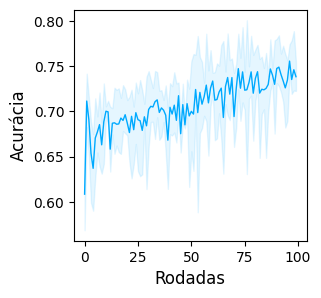

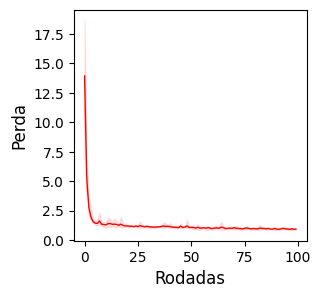

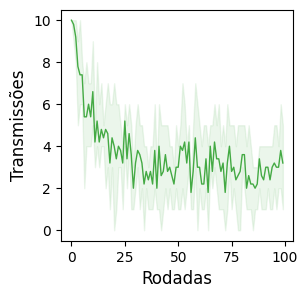

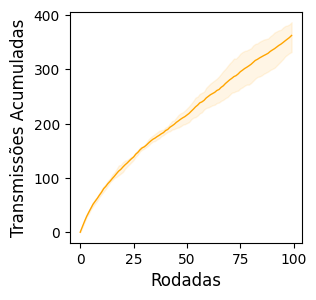

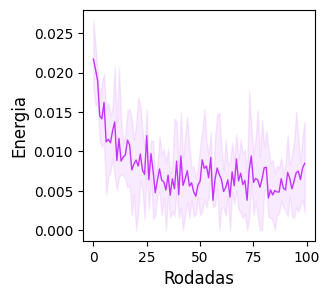

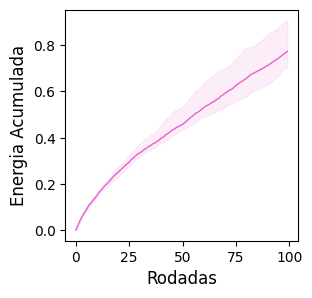

In [41]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_aleatoria/validacao_epsilon_40/")

### 2 - Validação de Epsilon = 25
Aproximadamente 400 transmissões

In [42]:
LAMBDA = 0.40

In [43]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[97 95 16 48 51 75 25  6 40 41]
Clientes selecionados: [ 7 17 26 41 42 49 52 76 96 98]
Cliente #7 | Acurácia: 0.9274486303329468 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9304143786430359 | Modelo transmitido!
Cliente #26 | Acurácia: 0.890489935874939 | Modelo transmitido!
Cliente #41 | Acurácia: 0.8964285850524902 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9505339860916138 | Modelo transmitido!
Cliente #49 | Acurácia: 0.8958944082260132 | Modelo transmitido!
Cliente #52 | Acurácia: 0.924924910068512 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8659127354621887 | Modelo transmitido!
Cliente #96 | Acurácia: 0.8668830990791321 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9300155639648438 | Modelo transmitido!
0: -> Disp: 6, RB: 7: 0.0024466338553922984
1: -> Disp: 16, RB: 2: 0.002685317348599069
2: -> Disp: 25, RB: 6: 0.0025840610581364474
3: -> Disp: 40, RB: 8: 0.00241900766099607
4: -> Disp: 41, RB: 9: 0.0016540458509865042
5: -> Disp: 48, RB: 3: 0.0032079

  1%|          | 1/100 [00:12<20:44, 12.57s/it]

Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.5871000289916992
Energia total da rodada: 0.025561963127485328
----------------------------------------

Rodada 2/100
[86 51  9 38 37 29 32  8 39 11]
Clientes selecionados: [ 9 10 12 30 33 38 39 40 52 87]
Cliente #9 | Acurácia: 0.8955731987953186 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9078013896942139 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9303733706474304 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9110751748085022 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9108449816703796 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9104729890823364 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9204204082489014 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9302775859832764 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.001892405457107258
1: -> Disp: 9, RB: 2: 0.0021740277183473653
2: -> Disp: 11

  2%|▏         | 2/100 [00:24<19:36, 12.01s/it]

Execução #0
Transmissões nesta rodada: 10
Acurácia: 0.6449999809265137
Energia total da rodada: 0.01941887671928732
----------------------------------------

Rodada 3/100
[33 76  9 25 65 99  8  7 85 91]
Clientes selecionados: [  8   9  10  26  34  66  77  86  92 100]
Cliente #8 | Acurácia: 0.9028268456459045 | Modelo transmitido!
Cliente #9 | Acurácia: 0.8842224478721619 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9191489219665527 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.8976945281028748 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9176245331764221 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9187934994697571 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9144384860992432 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9453614354133606 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9252271056175232 | Modelo transmitido!
0: -> Disp: 7, RB: 7: 0.001687635167715416
1: -> Disp: 8, RB: 6: 0.00176

  3%|▎         | 3/100 [00:34<18:17, 11.32s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.5737000107765198
Energia total da rodada: 0.012238415102456723
----------------------------------------

Rodada 4/100
[97 16 51 75  0 73 14 36 44 21]
Clientes selecionados: [ 1 15 17 22 37 45 52 74 76 98]
Cliente #1 | Acurácia: 0.9179415702819824 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9111531376838684 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9272869229316711 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9497717022895813 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9255120754241943 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9281699061393738 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9309309124946594 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9311531782150269 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8659127354621887 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9074649810791016 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002550032667772279
1: -> Disp: 14, RB: 6: 0.0021604457853

  4%|▍         | 4/100 [00:46<18:25, 11.51s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6014999747276306
Energia total da rodada: 0.014879816410908034
----------------------------------------

Rodada 5/100
[ 9 69 37 50 34 29 56 11 21  4]
Clientes selecionados: [ 5 10 12 22 30 35 38 51 57 70]
Cliente #5 | Acurácia: 0.9390624761581421 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9134751558303833 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9408482313156128 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9283552169799805 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9088507294654846 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9227220416069031 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9247910976409912 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9311783313751221 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9214232563972473 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 9, RB: 0: 0.00126841853795

  5%|▌         | 5/100 [00:57<17:56, 11.34s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6298999786376953
Energia total da rodada: 0.011028896028279334
----------------------------------------

Rodada 6/100
[74  3 76 66 23 14 89  7 98 81]
Clientes selecionados: [ 4  8 15 24 67 75 77 82 90 99]
Cliente #4 | Acurácia: 0.9178200960159302 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9151943325996399 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.920604944229126 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9311475157737732 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9257221221923828 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9234338998794556 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9133175611495972 | Modelo transmitido!
Cliente #99 | Acurácia: 0.898511528968811 | Modelo transmitido!
0: -> Disp: 3, RB: 1: 0.002235164100703315
1: -> Disp: 7, RB: 7: 0.00168763516771541

  6%|▌         | 6/100 [01:09<18:04, 11.54s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.628600001335144
Energia total da rodada: 0.01276300627277294
----------------------------------------

Rodada 7/100
[48 47  1 92  6 20 39 31 67 91]
Clientes selecionados: [ 2  7 21 32 40 48 49 68 92 93]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9304715991020203 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9155405163764954 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9286977052688599 | Modelo transmitido!
Cliente #49 | Acurácia: 0.900293231010437 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9493454694747925 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.002334964316235352
1: -> Disp: 6, RB: 4: 0.0018732626854355634
2:

  7%|▋         | 7/100 [01:19<16:58, 10.95s/it]

Execução #0
Transmissões nesta rodada: 8
Acurácia: 0.6520000100135803
Energia total da rodada: 0.0141255666510214
----------------------------------------

Rodada 8/100
[97 62 26 15 92 56 54 60 20 63]
Clientes selecionados: [16 21 27 55 57 61 63 64 93 98]
Cliente #16 | Acurácia: 0.9095394611358643 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9278804063796997 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9178200960159302 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.929237961769104 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 3: 0.0023447482722516763
1: -> Disp: 20, RB: 8: 0.00195515768585

  8%|▊         | 8/100 [01:28<16:06, 10.51s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6927000284194946
Energia total da rodada: 0.014392341350043067
----------------------------------------

Rodada 9/100
[80 76 23 29 87 72 39  7  2 10]
Clientes selecionados: [ 3  8 11 24 30 40 73 77 81 88]
Cliente #3 | Acurácia: 0.9226932525634766 | Modelo transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9155405163764954 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9325637817382812 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo transmitido!
0: -> Disp: 2, RB: 8: 0.001603909876733935
1: -> Disp: 7, RB: 7: 0.0016876351677

  9%|▉         | 9/100 [01:37<14:55,  9.84s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.6664000153541565
Energia total da rodada: 0.009589728647945205
----------------------------------------

Rodada 10/100
[18 62 47 92 42 44 89 84 41 10]
Clientes selecionados: [11 19 42 43 45 48 63 85 90 93]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9516582489013672 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9331667423248291 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9345904588699341 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 9: 0.0013395933904935874
1: -> Disp: 18, RB: 0:

 10%|█         | 10/100 [01:46<14:23,  9.59s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6772000193595886
Energia total da rodada: 0.006321111925068961
----------------------------------------

Rodada 11/100
[95 62 51 37 90 34 77  5  8 88]
Clientes selecionados: [ 6  9 35 38 52 63 78 89 91 96]
Cliente #6 | Acurácia: 0.920619547367096 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9103291630744934 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9299308061599731 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9492939710617065 | Modelo transmitido!
Cliente #96 | Acurácia: 0.8961039185523987 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 7: 0.0019131374183104343
1: -> Disp: 8, RB: 8: 0.00

 11%|█         | 11/100 [01:54<13:43,  9.25s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6826000213623047
Energia total da rodada: 0.007980677469171965
----------------------------------------

Rodada 12/100
[46 62  9 26 66 96 36  8 39 91]
Clientes selecionados: [ 9 10 27 37 40 47 63 67 92 97]
Cliente #9 | Acurácia: 0.9091941118240356 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9191489219665527 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9054054021835327 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9386892318725586 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9333909749984741 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9196721315383911 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9493454694747925 | Modelo transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.001892405457107258
1: -> Disp: 9, RB: 2: 0.0021740

 12%|█▏        | 12/100 [02:01<12:32,  8.55s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6284999847412109
Energia total da rodada: 0.009915932316243447
----------------------------------------

Rodada 13/100
[68 24 51 94 26 34 56 87 89 67]
Clientes selecionados: [25 27 35 52 57 68 69 88 90 95]
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9193717241287231 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
0: -> Disp: 24, RB: 1: 0.0022331337302097854
1: -> Disp: 26, RB: 4: 0.00

 13%|█▎        | 13/100 [02:09<12:06,  8.35s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.663100004196167
Energia total da rodada: 0.010744209755342677
----------------------------------------

Rodada 14/100
[74 18 28 22 73 55 96 83  5 98]
Clientes selecionados: [ 6 19 23 29 56 74 75 84 97 99]
Cliente #6 | Acurácia: 0.9099709391593933 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9377104640007019 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9305794835090637 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9120432734489441 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 8: 0.002040228682996738
1: -> Disp: 18, RB: 1: 0.002238

 14%|█▍        | 14/100 [02:17<11:46,  8.22s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6068000197410583
Energia total da rodada: 0.011896473571253133
----------------------------------------

Rodada 15/100
[79 90 57 54 45  5 20 84 98 91]
Clientes selecionados: [ 6 21 46 55 58 80 85 91 92 99]
Cliente #6 | Acurácia: 0.922555685043335 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9278804063796997 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9102228283882141 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9182432293891907 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9492939710617065 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9442231059074402 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0016498357534771317
1: -> Disp: 20, RB: 6: 0.0017140917613

 15%|█▌        | 15/100 [02:26<11:53,  8.40s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6845999956130981
Energia total da rodada: 0.010648414166029158
----------------------------------------

Rodada 16/100
[68 86 28 50 96 70 89 88  2 53]
Clientes selecionados: [ 3 29 51 54 69 71 87 89 90 97]
Cliente #3 | Acurácia: 0.9226932525634766 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.926183819770813 | Modelo transmitido!
Cliente #54 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9509553909301758 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9354422092437744 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9403315186500549 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.001603909876733935
1: -> Disp: 28, RB: 2: 0.002315

 16%|█▌        | 16/100 [02:34<11:37,  8.31s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7178000211715698
Energia total da rodada: 0.008218065313164873
----------------------------------------

Rodada 17/100
[ 3 93 22  0 66 40 72 88 84 53]
Clientes selecionados: [ 1  4 23 41 54 67 73 85 89 94]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9125000238418579 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #73 | Acurácia: 0.929526150226593 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9353416562080383 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.00223085677276245
1: -> Disp: 3, RB: 0: 0.001551

 17%|█▋        | 17/100 [02:41<10:58,  7.94s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6601999998092651
Energia total da rodada: 0.007140292949555151
----------------------------------------

Rodada 18/100
[ 9 75  0 50 17 34 64 72 20 11]
Clientes selecionados: [ 1 10 12 18 21 35 51 65 73 76]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo transmitido!
Cliente #10 | Acurácia: 0.916312038898468 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9497767686843872 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9537892937660217 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9331574440002441 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9128137230873108 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9289693832397461 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8691437840461731 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0019001973794438624
1: -> Disp: 9, RB: 0: 0.001268

 18%|█▊        | 18/100 [02:48<10:34,  7.73s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7123000025749207
Energia total da rodada: 0.009776038800117196
----------------------------------------

Rodada 19/100
[80 86 79 75 73 55 61  2 41 85]
Clientes selecionados: [ 3 42 56 62 74 76 80 81 86 87]
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9500860571861267 | Modelo transmitido!
Cliente #76 | Acurácia: 0.882067859172821 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9301143288612366 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9108734130859375 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9406068325042725 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015164109164628936
1: -> Disp: 41, RB: 8: 0.00157

 19%|█▉        | 19/100 [02:55<10:15,  7.59s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7010999917984009
Energia total da rodada: 0.008620520514360264
----------------------------------------

Rodada 20/100
[ 1 90 55 96 36 35 77 88 52 67]
Clientes selecionados: [ 2 36 37 53 56 68 78 89 91 97]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9359347820281982 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8898305296897888 | Modelo transmitido!
Cliente #91 | Acurácia: 0.949935793876648 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 0: 0.0013357175557553917
1: -> Disp: 35, RB: 5: 0.0

 20%|██        | 20/100 [03:03<10:15,  7.70s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6748999953269958
Energia total da rodada: 0.006776677591769191
----------------------------------------

Rodada 21/100
[94 71 15 37 23  6 65 57 81 49]
Clientes selecionados: [ 7 16 24 38 50 58 66 72 82 95]
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0020689431867101146
1: -> Disp: 15, RB: 

 21%|██        | 21/100 [03:13<10:44,  8.16s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7052000164985657
Energia total da rodada: 0.004884639615640883
----------------------------------------

Rodada 22/100
[93  9 26 37 55 40 64 54 89 31]
Clientes selecionados: [10 27 32 38 41 55 56 65 90 94]
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9071428775787354 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9335476756095886 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9419544339179993 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 1: 0.0017456036990447594
1: -> Disp: 26, RB: 2: 0.00

 22%|██▏       | 22/100 [03:20<10:16,  7.91s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7102000117301941
Energia total da rodada: 0.010072286412312236
----------------------------------------

Rodada 23/100
[18 62 38 90 55 17 35 70 88 85]
Clientes selecionados: [18 19 36 39 56 63 71 86 89 91]
Cliente #18 | Acurácia: 0.9417744874954224 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9247404932975769 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9382165670394897 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9486520886421204 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 5: 0.002177164405744682
1: -> Disp: 18,

 23%|██▎       | 23/100 [03:28<10:07,  7.89s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6761999726295471
Energia total da rodada: 0.0042553132156904405
----------------------------------------

Rodada 24/100
[ 3 86 48 59 69 17 70 20 41 49]
Clientes selecionados: [ 4 18 21 42 49 50 60 70 71 87]
Cliente #4 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9482439756393433 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9401934742927551 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015514027490519113
1: -> Disp: 17, RB: 5: 0

 24%|██▍       | 24/100 [03:37<10:31,  8.31s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6952999830245972
Energia total da rodada: 0.006903486693956714
----------------------------------------

Rodada 25/100
[62 38 96 23 83  6 57 31 27 53]
Clientes selecionados: [ 7 24 28 32 39 54 58 63 84 97]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9441117644309998 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9328969120979309 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9232432246208191 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.939226508140564 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0020689431867101146
1: -> Disp: 23, RB: 3: 0.00181

 25%|██▌       | 25/100 [03:46<10:27,  8.37s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6654000282287598
Energia total da rodada: 0.007989844606039437
----------------------------------------

Rodada 26/100
[46 86 30 65 99 56 54 88 39 10]
Clientes selecionados: [ 11  31  40  47  55  57  66  87  89 100]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9619450569152832 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9233716726303101 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo transmitido!
Cliente #100 | Acurácia: 0.945492684841156 | Modelo transmitido!
0: -> Disp: 10, RB: 9: 0.0013395933904935874
1: -> Disp: 30, RB: 

 26%|██▌       | 26/100 [03:52<09:39,  7.83s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.6804999709129333
Energia total da rodada: 0.011517511198639753
----------------------------------------

Rodada 27/100
[76 93 37 96 83 35 70 52 91  4]
Clientes selecionados: [ 5 36 38 53 71 77 84 92 94 97]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9504837989807129 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9397501945495605 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9546961188316345 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 35, RB:

 27%|██▋       | 27/100 [03:59<09:14,  7.60s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.6978999972343445
Energia total da rodada: 0.0031043328943055346
----------------------------------------

Rodada 28/100
[71 22 90 64 39  2 84 41 27 49]
Clientes selecionados: [ 3 23 28 40 42 50 65 72 85 91]
Cliente #3 | Acurácia: 0.9260182976722717 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9555930495262146 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.950160801410675 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9263513684272766 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.001332869317478983
1: -> Disp: 22,

 28%|██▊       | 28/100 [04:06<08:49,  7.36s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.6983000040054321
Energia total da rodada: 0.0013330090773056439
----------------------------------------

Rodada 29/100
[18 24 76 75 50 25 83  8 70 88]
Clientes selecionados: [ 9 19 25 26 51 71 76 77 84 89]
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9166666865348816 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.909221887588501 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9030694961547852 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9327146410942078 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.001892405457107258
1: -> Disp: 18, RB: 0: 0.001553

 29%|██▉       | 29/100 [04:12<08:06,  6.86s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7077999711036682
Energia total da rodada: 0.011169988647600555
----------------------------------------

Rodada 30/100
[18 51 12 58 73 56 64  5  7  4]
Clientes selecionados: [ 5  6  8 13 19 52 57 59 65 74]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9186834692955017 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo transmitido!
Cliente #19 | Acurácia: 0.933501660823822 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9368904232978821 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 5, RB: 7: 0.00191313741831

 30%|███       | 30/100 [04:20<08:27,  7.25s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7156000137329102
Energia total da rodada: 0.011277503247391333
----------------------------------------

Rodada 31/100
[16 12 30 59 37 55 14 40 82  7]
Clientes selecionados: [ 8 13 15 17 31 38 41 56 60 83]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9508506655693054 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9515246152877808 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9178571701049805 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9389221668243408 | Modelo transmitido!
0: -> Disp: 7, RB: 9: 0.0018938693675089743
1: -> Disp: 12, RB: 

 31%|███       | 31/100 [04:26<08:07,  7.07s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7044000029563904
Energia total da rodada: 0.006666928688704717
----------------------------------------

Rodada 32/100
[80 47 12 22 82 54 42 61 88 85]
Clientes selecionados: [13 23 43 48 55 62 81 83 86 89]
Cliente #13 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #43 | Acurácia: 0.948296844959259 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9322333335876465 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9655688405036926 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9473053812980652 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo transmitido!
0: -> Disp: 12, RB: 2: 0.0022090110875999684
1: -> Disp: 22, RB: 3: 0.00236196151

 32%|███▏      | 32/100 [04:34<08:11,  7.23s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.6669999957084656
Energia total da rodada: 0.013260781112631174
----------------------------------------

Rodada 33/100
[80 62 51 75 55 83 17 20 89 43]
Clientes selecionados: [18 21 44 52 56 63 76 81 84 90]
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.924747884273529 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8876190185546875 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9063004851341248 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9145945906639099 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo transmitido!
0: -> Disp: 17, RB: 6: 0.002383212050962401
1: -> Disp: 20, RB: 7: 0.

 33%|███▎      | 33/100 [04:41<08:05,  7.24s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6945000290870667
Energia total da rodada: 0.008008213710067439
----------------------------------------

Rodada 34/100
[33 46  3 76 86 17 40 54 85 21]
Clientes selecionados: [ 4 18 22 34 41 47 55 77 86 87]
Cliente #4 | Acurácia: 0.9264705777168274 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9417744874954224 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9312853813171387 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9089285731315613 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9412524104118347 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 2: 0.002868136512505488
1: -> Disp: 17, RB: 5: 0.0021

 34%|███▍      | 34/100 [04:49<08:02,  7.31s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7322999835014343
Energia total da rodada: 0.009884141688356973
----------------------------------------

Rodada 35/100
[68 26 75 15 23 34 57 13 91  4]
Clientes selecionados: [ 5 14 16 24 27 35 58 69 76 92]
Cliente #5 | Acurácia: 0.948437511920929 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9430232644081116 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9594339728355408 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9277486801147461 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 13, RB: 7: 

 35%|███▌      | 35/100 [04:58<08:31,  7.86s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7181000113487244
Energia total da rodada: 0.005237951490100595
----------------------------------------

Rodada 36/100
[68 18 94 66 90 56 44  2 81 10]
Clientes selecionados: [ 3 11 19 45 57 67 69 82 91 95]
Cliente #3 | Acurácia: 0.916043221950531 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo transmitido!
Cliente #19 | Acurácia: 0.936026930809021 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9518613815307617 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9441260695457458 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015164109164628936
1: -> Disp: 10, RB: 9:

 36%|███▌      | 36/100 [05:07<08:46,  8.23s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.6912999749183655
Energia total da rodada: 0.005161717775129178
----------------------------------------

Rodada 37/100
[97 96 14 40 56 57 64 54 84 85]
Clientes selecionados: [15 41 55 57 58 65 85 86 97 98]
Cliente #15 | Acurácia: 0.9243856072425842 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9260450005531311 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9393501877784729 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9215686321258545 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
0: -> Disp: 14, RB: 2: 0.0014065327464034187
1: -> Disp: 40, RB: 3: 0

 37%|███▋      | 37/100 [05:16<08:53,  8.46s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.722000002861023
Energia total da rodada: 0.00609579703869714
----------------------------------------

Rodada 38/100
[97 79 47 72 70 60 39 41 98 53]
Clientes selecionados: [40 42 48 54 61 71 73 80 98 99]
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9475545287132263 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.936208963394165 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9428208470344543 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.944012463092804 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 39, RB: 6: 0.0016170997127400138
1: -> Disp: 41, RB: 7: 

 38%|███▊      | 38/100 [05:25<08:57,  8.67s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7105000019073486
Energia total da rodada: 0.004610043986098566
----------------------------------------

Rodada 39/100
[86 90 50  6 36 64 72 89  2 91]
Clientes selecionados: [ 3  7 37 51 65 73 87 90 91 92]
Cliente #3 | Acurácia: 0.9185369610786438 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9576783776283264 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9368165135383606 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9243499040603638 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9473684430122375 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo transmitido!
0: -> Disp: 2, RB: 8: 0.001603909876733935
1: -> Disp: 6, RB: 3: 0.001670

 39%|███▉      | 39/100 [05:36<09:19,  9.17s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7271999716758728
Energia total da rodada: 0.008131135103266057
----------------------------------------

Rodada 40/100
[ 3 51 71  0 23 54 70 44 63 11]
Clientes selecionados: [ 1  4 12 24 45 52 55 64 71 72]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9430232644081116 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.923901379108429 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9315155148506165 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.00223085677276245
1: -> Disp: 3, R

 40%|████      | 40/100 [05:44<08:53,  8.88s/it]

Execução #0
Transmissões nesta rodada: 1
Acurácia: 0.676800012588501
Energia total da rodada: 0.0018272797221767793
----------------------------------------

Rodada 41/100
[97 33 24 51 75 57 35 84 85 10]
Clientes selecionados: [11 25 34 36 52 58 76 85 86 98]
Cliente #11 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9328969120979309 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9030694961547852 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.935458779335022 | Modelo transmitido!
0: -> Disp: 10, RB: 9: 0.0013395933904935874
1: -> Disp: 24, RB: 2: 0.002

 41%|████      | 41/100 [05:52<08:30,  8.65s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7164000272750854
Energia total da rodada: 0.011748198543103909
----------------------------------------

Rodada 42/100
[16 94 26 38 90  6 44 41 11 43]
Clientes selecionados: [ 7 12 17 27 39 42 44 45 91 95]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9427810907363892 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9651489853858948 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9185414910316467 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9486520886421204 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9412607550621033 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0020689431867101146
1: -> Disp: 11, RB: 8: 0.00149125445

 42%|████▏     | 42/100 [06:03<08:59,  9.31s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7407000064849854
Energia total da rodada: 0.008264019100966668
----------------------------------------

Rodada 43/100
[93  9 96 83 19 82 54  7 81 49]
Clientes selecionados: [ 8 10 20 50 55 82 83 84 94 97]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9359720349311829 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9390154480934143 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9569060802459717 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.001687635167715416
1: -> Disp: 9, RB: 

 43%|████▎     | 43/100 [06:12<08:50,  9.31s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7106000185012817
Energia total da rodada: 0.0032858732871507987
----------------------------------------

Rodada 44/100
[97 68 79 28 66 36 29 20 81 43]
Clientes selecionados: [21 29 30 37 44 67 69 80 82 98]
Cliente #21 | Acurácia: 0.9384344816207886 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8834244012832642 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9434561729431152 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo transmitido!
0: -> Disp: 20, RB: 7: 0.0018360000501243517
1: -> Disp: 28, RB: 3: 

 44%|████▍     | 44/100 [06:22<08:45,  9.39s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7232000231742859
Energia total da rodada: 0.00773965778251196
----------------------------------------

Rodada 45/100
[78  9 73 29 45  7 84 13 81 49]
Clientes selecionados: [ 8 10 14 30 46 50 74 79 82 85]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9364278316497803 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9213630557060242 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9369972944259644 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9476309418678284 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9277027249336243 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 5: 0.0014703821955950912
1: -> Disp: 9, RB: 1: 0.001745603

 45%|████▌     | 45/100 [06:31<08:42,  9.49s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.72079998254776
Energia total da rodada: 0.0087861226612816
----------------------------------------

Rodada 46/100
[97 62 51 94 38 50 72 31 67 10]
Clientes selecionados: [11 32 39 51 52 63 68 73 95 98]
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9481037855148315 | Modelo transmitido!
Cliente #51 | Acurácia: 0.926183819770813 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9195501804351807 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9536231756210327 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 9: 0.0013395933904935874
1: -> Disp: 31, RB: 7: 

 46%|████▌     | 46/100 [06:41<08:37,  9.59s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.704200029373169
Energia total da rodada: 0.006242970764741892
----------------------------------------

Rodada 47/100
[86 93 12 83 65 14 44 84 67 21]
Clientes selecionados: [13 15 22 45 66 68 84 85 87 94]
Cliente #13 | Acurácia: 0.9304187297821045 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9475327730178833 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9536231756210327 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9294636249542236 | Modelo transmitido!
0: -> Disp: 12, RB: 2: 0.0022090110875999684
1: -> Disp: 14, RB: 5

 47%|████▋     | 47/100 [06:50<08:18,  9.40s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7135000228881836
Energia total da rodada: 0.00538895742021185
----------------------------------------

Rodada 48/100
[30 55 23 36 56 87 61 39 91 53]
Clientes selecionados: [24 31 37 40 54 56 57 62 88 92]
Cliente #24 | Acurácia: 0.9430232644081116 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.94439297914505 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8971428275108337 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.956204354763031 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9556061625480652 | Modelo transmitido!
0: -> Disp: 23, RB: 2: 0.0015697337727801214
1: -> Disp: 30, RB: 0: 0.0

 48%|████▊     | 48/100 [06:57<07:34,  8.73s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.6797999739646912
Energia total da rodada: 0.006055118386777346
----------------------------------------

Rodada 49/100
[94 38 83 42  7 81 91 21  4 53]
Clientes selecionados: [ 5  8 22 39 43 54 82 84 92 95]
Cliente #5 | Acurácia: 0.9515625238418579 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9447771310806274 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.001202578427333398
1: -> Disp: 7, RB: 4

 49%|████▉     | 49/100 [07:06<07:28,  8.80s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7141000032424927
Energia total da rodada: 0.002609500028836053
----------------------------------------

Rodada 50/100
[95 15  0 66 17 82 72 32 44 10]
Clientes selecionados: [ 1 11 16 18 33 45 67 73 83 96]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9407894611358643 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9417744874954224 | Modelo transmitido!
Cliente #33 | Acurácia: 0.935327410697937 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9428918361663818 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9082792401313782 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0019001973794438624
1: -> Disp: 10, RB: 9: 0.0013

 50%|█████     | 50/100 [07:14<06:58,  8.38s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7221999764442444
Energia total da rodada: 0.008819256770315045
----------------------------------------

Rodada 51/100
[74 68 79 16 69 64 44 39 84 67]
Clientes selecionados: [17 40 45 65 68 69 70 75 80 85]
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9394128918647766 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9472924470901489 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9347664713859558 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9449793696403503 | Modelo transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9270270466804504 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.0032426602769491286
1: -> Disp: 39, RB: 7: 0.00

 51%|█████     | 51/100 [07:23<07:04,  8.66s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.6834999918937683
Energia total da rodada: 0.011169603179521976
----------------------------------------

Rodada 52/100
[80  3 62 47 19 35 70 89 85 21]
Clientes selecionados: [ 4 20 22 36 48 63 71 81 86 90]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9336437582969666 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9497717022895813 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9340012073516846 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9325259327888489 | Modelo transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9196217656135559 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.002235164100703315
1: -> Disp: 19, RB: 4: 0.0

 52%|█████▏    | 52/100 [07:39<08:37, 10.79s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7091000080108643
Energia total da rodada: 0.008865684136351916
----------------------------------------

Rodada 53/100
[78 58 69 73 82 88 31 41 91 49]
Clientes selecionados: [32 42 50 59 70 74 79 83 89 92]
Cliente #32 | Acurácia: 0.9463087320327759 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9403131008148193 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9503335952758789 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9222519993782043 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9595901966094971 | Modelo transmitido!
0: -> Disp: 31, RB: 6: 0.0015126950213291415
1: -> Disp: 41, RB: 7: 0.00

 53%|█████▎    | 53/100 [07:49<08:14, 10.52s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7181000113487244
Energia total da rodada: 0.007931151207338435
----------------------------------------

Rodada 54/100
[74 76 38 37  6 89 39 31 67  4]
Clientes selecionados: [ 5  7 32 38 39 40 68 75 77 90]
Cliente #5 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9455864429473877 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9487691521644592 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9385342597961426 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 6, RB: 4: 0.0018732626854355634
2: -> Disp

 54%|█████▍    | 54/100 [07:58<07:50, 10.23s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.734499990940094
Energia total da rodada: 0.009131028483864219
----------------------------------------

Rodada 55/100
[18 47 58 30 15  0 83 32 44 21]
Clientes selecionados: [ 1 16 19 22 31 33 45 48 59 84]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo transmitido!
Cliente #19 | Acurácia: 0.936026930809021 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9344159960746765 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9446081519126892 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.002861969736208173
1: -> Disp: 15, RB: 4: 0.0026886315

 55%|█████▌    | 55/100 [08:09<07:50, 10.44s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7146000266075134
Energia total da rodada: 0.01019897593711057
----------------------------------------

Rodada 56/100
[33 68 26 30 50 42 70 31 84 85]
Clientes selecionados: [27 31 32 34 43 51 69 71 85 86]
Cliente #27 | Acurácia: 0.9603773355484009 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9379562139511108 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9247910976409912 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9472972750663757 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo transmitido!
0: -> Disp: 26, RB: 2: 0.0021509803964423475
1: -> Disp: 30, RB: 3: 0.00244343924

 56%|█████▌    | 56/100 [08:18<07:15,  9.89s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.7533000111579895
Energia total da rodada: 0.01333496292823846
----------------------------------------

Rodada 57/100
[97 74 68 48 26 50 55 60 89 88]
Clientes selecionados: [27 49 51 56 61 69 75 89 90 98]
Cliente #27 | Acurácia: 0.9603773355484009 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9298429489135742 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9362363815307617 | Modelo transmitido!
0: -> Disp: 26, RB: 4: 0.0029414387843398394
1: -> Disp: 48, RB: 3: 0

 57%|█████▋    | 57/100 [08:26<06:46,  9.46s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7515000104904175
Energia total da rodada: 0.008352300416323325
----------------------------------------

Rodada 58/100
[95 24 28 15 65 72 85 67 81 91]
Clientes selecionados: [16 25 29 66 68 73 82 86 92 96]
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9472727179527283 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9195402264595032 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9331713318824768 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9126559495925903 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9658508896827698 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9115259647369385 | Modelo transmitido!
0: -> Disp: 15, RB: 3: 0.0023447482722516763
1: -> Disp: 24, RB: 1: 0.00223

 58%|█████▊    | 58/100 [08:35<06:36,  9.44s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7315000295639038
Energia total da rodada: 0.00930508596525314
----------------------------------------

Rodada 59/100
[18 47 66 69 25 65 70  7 13 11]
Clientes selecionados: [ 8 12 14 19 26 48 66 67 70 71]
Cliente #8 | Acurácia: 0.952296793460846 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9394292235374451 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.946965217590332 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.946627140045166 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.001687635167715416
1: -> Disp: 11, RB: 9: 0.

 59%|█████▉    | 59/100 [08:47<06:50, 10.02s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7437000274658203
Energia total da rodada: 0.005304344686348851
----------------------------------------

Rodada 60/100
[24 16 22 59 19 99 14 31 11 91]
Clientes selecionados: [ 12  15  17  20  23  25  32  60  92 100]
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9569976329803467 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9365541338920593 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9455252885818481 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9630051255226135 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9489867091178894 | Modelo transmitido!
0: -> Disp: 11, RB: 8: 0.001491254458022872
1: -> Disp: 14, RB: 

 60%|██████    | 60/100 [08:56<06:33,  9.83s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7317000031471252
Energia total da rodada: 0.010157951892325122
----------------------------------------

Rodada 61/100
[ 1 75 38 73 70  7 52 85 91 49]
Clientes selecionados: [ 2  8 39 50 53 71 74 76 86 92]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9487691521644592 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9471624493598938 | Modelo transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9472174644470215 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9675583243370056 | Modelo transmitido!
0: -> Disp: 1, RB: 0: 0.0013357175557553917
1: -> Disp: 7, RB: 5: 0.00

 61%|██████    | 61/100 [09:07<06:33, 10.09s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7538999915122986
Energia total da rodada: 0.005772941041376118
----------------------------------------

Rodada 62/100
[18 23  6 64  8 88  7  2 98 49]
Clientes selecionados: [ 3  7  8  9 19 24 50 65 89 99]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9607013463973999 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9403131008148193 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9323409795761108 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0015164109164628936
1: -> Disp: 6, RB: 2: 0.

 62%|██████▏   | 62/100 [09:16<06:15,  9.88s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7123000025749207
Energia total da rodada: 0.004283518913082655
----------------------------------------

Rodada 63/100
[62 30 22 38 90 92 63 98 52 67]
Clientes selecionados: [23 31 39 53 63 64 68 91 93 99]
Cliente #23 | Acurácia: 0.914460301399231 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9534264802932739 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9446709156036377 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9391249418258667 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9473684430122375 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo transmitido!
0: -> Disp: 22, RB: 2: 0.002002833474104651
1: -> Disp: 30, RB: 1: 0.001

 63%|██████▎   | 63/100 [09:26<06:04,  9.84s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7148000001907349
Energia total da rodada: 0.008389635748082089
----------------------------------------

Rodada 64/100
[18 69 83 99 54 63 89 41 10  4]
Clientes selecionados: [  5  11  19  42  55  64  70  84  90 100]
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9436026811599731 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9421793818473816 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.936170220375061 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9496855139732361 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.001255061269860155
1: -> Disp: 10, 

 64%|██████▍   | 64/100 [09:36<05:55,  9.88s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7444999814033508
Energia total da rodada: 0.0062931740516709335
----------------------------------------

Rodada 65/100
[74 95 76 28 12 63  7 84 41 52]
Clientes selecionados: [ 8 13 29 42 53 64 75 77 85 96]
Cliente #8 | Acurácia: 0.9487632513046265 | Modelo transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9384908080101013 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.946354866027832 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9188311696052551 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 6: 0.0015807400596677403
1: -> Disp: 12, RB: 4: 0.00303268

 65%|██████▌   | 65/100 [09:44<05:30,  9.45s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7303000092506409
Energia total da rodada: 0.012016963796962356
----------------------------------------

Rodada 66/100
[79 51 26 75 40 82 72 61 35 13]
Clientes selecionados: [14 27 36 41 52 62 73 76 80 83]
Cliente #14 | Acurácia: 0.9388468265533447 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9107142686843872 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9579579830169678 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9459295272827148 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9504446983337402 | Modelo transmitido!
Cliente #83 | Acurácia: 0.943712592124939 | Modelo transmitido!
0: -> Disp: 13, RB: 9: 0.0016249533911432555
1: -> Disp: 26, RB: 2: 0.002150980396

 66%|██████▌   | 66/100 [09:55<05:28,  9.65s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.7210999727249146
Energia total da rodada: 0.012827756961625665
----------------------------------------

Rodada 67/100
[33 68 16 28 15 69 96 23 40 84]
Clientes selecionados: [16 17 24 29 34 41 69 70 85 97]
Cliente #16 | Acurácia: 0.9358552694320679 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9476743936538696 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9369442462921143 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9429206848144531 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 4: 0.002688631583785967
1: -> Disp: 16, RB: 2: 

 67%|██████▋   | 67/100 [10:03<05:07,  9.31s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7626000046730042
Energia total da rodada: 0.009722854143300035
----------------------------------------

Rodada 68/100
[80 79 93 83 87 72 77 84 41 67]
Clientes selecionados: [42 68 73 78 80 81 84 85 88 94]
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.951715350151062 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9341238737106323 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9472972750663757 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.942148745059967 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9419544339179993 | Modelo NÃO transmitido!
0: -> Disp: 41, RB: 8: 0.0015714502405439772
1: -> Disp: 67, R

 68%|██████▊   | 68/100 [10:13<05:04,  9.52s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7405999898910522
Energia total da rodada: 0.0032523383778115867
----------------------------------------

Rodada 69/100
[18 48 30 37 19 65 57 64 88 11]
Clientes selecionados: [12 19 20 31 38 49 58 65 66 89]
Cliente #12 | Acurácia: 0.9609375 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9365541338920593 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9516245722770691 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 9: 0.0015670134716806307
1: -> Disp: 18, RB: 0: 0.0

 69%|██████▉   | 69/100 [10:22<04:47,  9.29s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.753600001335144
Energia total da rodada: 0.0061932130167028894
----------------------------------------

Rodada 70/100
[78 93 12  0 66 29 82 45 77 84]
Clientes selecionados: [ 1 13 30 46 67 78 79 83 85 94]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.935960590839386 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9455096125602722 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9377457499504089 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9508196711540222 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.00223085677276245
1: -> Disp: 12, RB: 2: 0.0022

 70%|███████   | 70/100 [10:32<04:43,  9.44s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7630000114440918
Energia total da rodada: 0.008603171790688044
----------------------------------------

Rodada 71/100
[78 97 33 80 94 47 92 35  2 53]
Clientes selecionados: [ 3 34 36 48 54 79 81 93 95 98]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.940177857875824 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9325463771820068 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9340012073516846 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9406565427780151 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9356568455696106 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.931106448173523 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9484240412712097 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.001603909876733935
1: -> Disp: 33, RB: 2: 

 71%|███████   | 71/100 [10:40<04:21,  9.01s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7299000024795532
Energia total da rodada: 0.006211692673553748
----------------------------------------

Rodada 72/100
[33 24 73 55 56  8 88 91 10 53]
Clientes selecionados: [ 9 11 25 34 54 56 57 74 89 92]
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.943533718585968 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9409862756729126 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9431818127632141 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0016334054952919805
1: -> Disp: 10, RB: 8

 72%|███████▏  | 72/100 [10:47<04:00,  8.60s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7373999953269958
Energia total da rodada: 0.0056726216628137215
----------------------------------------

Rodada 73/100
[79 48 94 38 66 83 57 82 35 60]
Clientes selecionados: [36 39 49 58 61 67 80 83 84 95]
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo transmitido!
Cliente #39 | Acurácia: 0.946773111820221 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9479034543037415 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9437837600708008 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9462750554084778 | Modelo transmitido!
0: -> Disp: 35, RB: 8: 0.002112757664975605
1: -> Disp: 38, RB: 3: 0.00

 73%|███████▎  | 73/100 [10:57<03:57,  8.78s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.756600022315979
Energia total da rodada: 0.010751521828248484
----------------------------------------

Rodada 74/100
[28 75 37 96 23 34 57 87 32 42]
Clientes selecionados: [24 29 33 35 38 43 58 76 88 97]
Cliente #24 | Acurácia: 0.9465116262435913 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9434114694595337 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9365918040275574 | Modelo transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9470803141593933 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9318181872367859 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9701657295227051 | Modelo transmitido!
0: -> Disp: 23, RB: 4: 0.002043496552523704
1: -> Disp: 28, RB: 0: 0.001327562486

 74%|███████▍  | 74/100 [11:07<04:01,  9.30s/it]

Execução #0
Transmissões nesta rodada: 7
Acurácia: 0.7565000057220459
Energia total da rodada: 0.014564914150117812
----------------------------------------

Rodada 75/100
[48 51 47 58 69 73 96 99 34  5]
Clientes selecionados: [  6  35  48  49  52  59  70  74  97 100]
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9463759660720825 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9646408557891846 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9531795978546143 | Modelo transmitido!
0: -> Disp: 5, RB: 9: 0.002165117241282711
1: -> Disp: 34

 75%|███████▌  | 75/100 [11:17<03:54,  9.38s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.770799994468689
Energia total da rodada: 0.009256539655025797
----------------------------------------

Rodada 76/100
[97 90 45 44 41 98 67 43 10 53]
Clientes selecionados: [11 42 44 45 46 54 68 91 98 99]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9387121796607971 | Modelo transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9351245164871216 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9387626051902771 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9594202637672424 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9548988938331604 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 8: 0.0012810180884316423
1: -> Disp: 41, RB: 4: 0

 76%|███████▌  | 76/100 [11:28<04:02, 10.09s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7642999887466431
Energia total da rodada: 0.005117563921061792
----------------------------------------

Rodada 77/100
[93 15 38 66 69 36 70 60 89 85]
Clientes selecionados: [16 37 39 61 67 70 71 86 90 94]
Cliente #16 | Acurácia: 0.9440789222717285 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9497206807136536 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9514304995536804 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9590163826942444 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.959235668182373 | Modelo transmitido!
Cliente #86 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9377462863922119 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9463629722595215 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 1: 0.0016132850954870975
1: -> Disp: 36, RB: 5: 0

 77%|███████▋  | 77/100 [11:36<03:37,  9.45s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7781000137329102
Energia total da rodada: 0.007126191406555329
----------------------------------------

Rodada 78/100
[74 16 94 22 34 40 98 11  4 53]
Clientes selecionados: [ 5 12 17 23 35 41 54 75 95 99]
Cliente #5 | Acurácia: 0.9468749761581421 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9601250886917114 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9124236106872559 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9507575631141663 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9477077126502991 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo transmitido!
0: -> Disp: 4, RB: 8: 0.001202578427333398
1: -> Disp: 11, RB: 7: 0.0014

 78%|███████▊  | 78/100 [11:45<03:20,  9.10s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7775999903678894
Energia total da rodada: 0.009094621710980438
----------------------------------------

Rodada 79/100
[74 18  1  0 83 65 34 57 31 41]
Clientes selecionados: [ 1  2 19 32 35 42 58 66 75 84]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9503366947174072 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9696458578109741 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9436038732528687 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.00223085677276245
1: -> Disp: 1, RB: 2: 0.002

 79%|███████▉  | 79/100 [11:54<03:10,  9.05s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7979999780654907
Energia total da rodada: 0.008306544366765168
----------------------------------------

Rodada 80/100
[78 97 66 92 96 87 39 52 81 10]
Clientes selecionados: [11 40 53 67 79 82 88 93 97 98]
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.943506121635437 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9576059579849243 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9431818127632141 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9394571781158447 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9510108828544617 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 9: 0.0013395933904935874
1: -> Disp: 39, RB:

 80%|████████  | 80/100 [12:02<02:59,  8.96s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7441999912261963
Energia total da rodada: 0.004655004863338559
----------------------------------------

Rodada 81/100
[12 66 69 55  6 65 32  8 11 49]
Clientes selecionados: [ 7  9 12 13 33 50 56 66 67 70]
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9387060403823853 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9587053656578064 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9433497786521912 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9458367228507996 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0018732626854355634
1: -> Disp: 8, RB: 7: 0.0018924

 81%|████████  | 81/100 [12:09<02:38,  8.37s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7560999989509583
Energia total da rodada: 0.008187941263147121
----------------------------------------

Rodada 82/100
[48 28 55 96 17 99 44 63 13 81]
Clientes selecionados: [ 14  18  29  45  49  56  64  82  97 100]
Cliente #14 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9482439756393433 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9450343251228333 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9429296255111694 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9624309539794922 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9573724865913391 | Modelo transmitido!
0: -> Disp: 13, RB: 8: 0.0015446573667342832
1: -> Disp: 17,

 82%|████████▏ | 82/100 [12:18<02:34,  8.57s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7786999940872192
Energia total da rodada: 0.008620594256806596
----------------------------------------

Rodada 83/100
[ 3 71 58 92 50 34 32 61 84 91]
Clientes selecionados: [ 4 33 35 51 59 62 72 85 92 93]
Cliente #4 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9458367228507996 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9313077926635742 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo transmitido!
Cliente #59 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9655688405036926 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9453375935554504 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9466215968132019 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9658508896827698 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9352818131446838 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015514027490519113
1: -> Disp: 32, RB: 6: 0.

 83%|████████▎ | 83/100 [12:27<02:24,  8.53s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7754999995231628
Energia total da rodada: 0.007404661179363434
----------------------------------------

Rodada 84/100
[79 16 66 92 65 42 61  8 13 11]
Clientes selecionados: [ 9 12 14 17 43 62 66 67 80 93]
Cliente #9 | Acurácia: 0.936435878276825 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9598214030265808 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9452533721923828 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9577795267105103 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9446471929550171 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9693113565444946 | Modelo transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9542566537857056 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 7: 0.001892405457107258
1: -> Disp: 11, RB: 9: 0.00

 84%|████████▍ | 84/100 [12:36<02:18,  8.63s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7671999931335449
Energia total da rodada: 0.007425974153206797
----------------------------------------

Rodada 85/100
[24 15 19 14 34 64 54 39 91 21]
Clientes selecionados: [15 16 20 22 25 35 40 55 65 92]
Cliente #15 | Acurácia: 0.9489603042602539 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9391447305679321 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9423748254776001 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9566786885261536 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9681274890899658 | Modelo transmitido!
0: -> Disp: 14, RB: 3: 0.0016079457837893725
1: -> Disp: 15, RB: 1:

 85%|████████▌ | 85/100 [12:44<02:09,  8.63s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7723000049591064
Energia total da rodada: 0.0067896718523947335
----------------------------------------

Rodada 86/100
[95 73 96 29 54 77  8 60 13 10]
Clientes selecionados: [ 9 11 14 30 55 61 74 78 96 97]
Cliente #9 | Acurácia: 0.936435878276825 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9394292235374451 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9496248364448547 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9432048797607422 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9472174644470215 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9547169804573059 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9546961188316345 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 6: 0.0017646908727472351
1: -> Disp: 10, RB: 

 86%|████████▌ | 86/100 [12:53<02:03,  8.81s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7718999981880188
Energia total da rodada: 0.0052703707145217065
----------------------------------------

Rodada 87/100
[46 93 66 17 99  8 70 89 31 13]
Clientes selecionados: [  9  14  18  32  47  67  71  90  94 100]
Cliente #9 | Acurácia: 0.936435878276825 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9388468265533447 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9316081404685974 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9573770761489868 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9579617977142334 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9401103258132935 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9566495418548584 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9587700963020325 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0016334054952919805
1: -> Disp: 13, R

 87%|████████▋ | 87/100 [13:05<02:05,  9.66s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7835999727249146
Energia total da rodada: 0.008319579829852389
----------------------------------------

Rodada 88/100
[16 22 66 37 96 64 82 42 70 52]
Clientes selecionados: [17 23 38 43 53 65 67 71 83 97]
Cliente #17 | Acurácia: 0.9695074558258057 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9246435761451721 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9457900524139404 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9464720487594604 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9501805305480957 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9624204039573669 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9657458662986755 | Modelo transmitido!
0: -> Disp: 16, RB: 0: 0.0014785384328133149
1: -> Disp: 22, RB: 1: 0.00

 88%|████████▊ | 88/100 [13:14<01:52,  9.36s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7616999745368958
Energia total da rodada: 0.00903408066792415
----------------------------------------

Rodada 89/100
[15  0 92 40 56 64 32 77 89 11]
Clientes selecionados: [ 1 12 16 33 41 57 65 78 90 93]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9620535969734192 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9095394611358643 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9490703344345093 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9593326449394226 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9487364888191223 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9487785696983337 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0015489610896026026
1: -> Disp: 11, R

 89%|████████▉ | 89/100 [13:22<01:40,  9.12s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7949000000953674
Energia total da rodada: 0.0033708251876590836
----------------------------------------

Rodada 90/100
[86 51 47 96 83 44  2 43 21  4]
Clientes selecionados: [ 3  5 22 44 45 48 52 84 87 97]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo transmitido!
Cliente #5 | Acurácia: 0.944531261920929 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9634703397750854 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9449185132980347 | Modelo transmitido!
Cliente #45 | Acurácia: 0.946908175945282 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9510901570320129 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9564564824104309 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9554551243782043 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9624309539794922 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0014263046150439357
1: -> Disp: 4, RB:

 90%|█████████ | 90/100 [13:33<01:36,  9.68s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.776199996471405
Energia total da rodada: 0.002705950886951855
----------------------------------------

Rodada 91/100
[ 3 12 30 19 56 42 44 31 85 49]
Clientes selecionados: [ 4 13 20 31 32 43 45 50 57 86]
Cliente #4 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9347290396690369 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9406286478042603 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9495133757591248 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9500312209129333 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9520547986030579 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9624608755111694 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9304812550544739 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0015514027490519113
1: -> Disp: 12, RB: 1

 91%|█████████ | 91/100 [13:45<01:31, 10.18s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7605000138282776
Energia total da rodada: 0.0043500459027107944
----------------------------------------

Rodada 92/100
[95 24 79 90 50 25 34 29 57  2]
Clientes selecionados: [ 3 25 26 30 35 51 58 80 91 96]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9379128217697144 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9541735053062439 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9548919796943665 | Modelo transmitido!
Cliente #91 | Acurácia: 0.949935793876648 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9301947951316833 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0016893114008752707
1: -> Disp: 24, RB: 

 92%|█████████▏| 92/100 [13:54<01:20, 10.06s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7846999764442444
Energia total da rodada: 0.007096893142893599
----------------------------------------

Rodada 93/100
[33 76 28 59 14 36 56 60 41 49]
Clientes selecionados: [15 29 34 37 42 50 57 60 61 77]
Cliente #15 | Acurácia: 0.95652174949646 | Modelo transmitido!
Cliente #29 | Acurácia: 0.938069224357605 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9393694400787354 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9497206807136536 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.942270040512085 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9455252885818481 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 4: 0.0017984975705625308
1: -> Disp: 28, RB: 2:

 93%|█████████▎| 93/100 [14:02<01:05,  9.34s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.8073999881744385
Energia total da rodada: 0.005577254756341649
----------------------------------------

Rodada 94/100
[78 46  9 37 96 40 61 35 44 89]
Clientes selecionados: [10 36 38 41 45 47 62 79 90 97]
Cliente #10 | Acurácia: 0.9503546357154846 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9527105093002319 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9598308801651001 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo transmitido!
Cliente #79 | Acurácia: 0.945040225982666 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9448384642601013 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9723756909370422 | Modelo transmitido!
0: -> Disp: 9, RB: 2: 0.0021740277183473653
1: -> Disp: 35, RB: 7: 0

 94%|█████████▍| 94/100 [14:18<01:08, 11.43s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7569000124931335
Energia total da rodada: 0.007818505043989638
----------------------------------------

Rodada 95/100
[80 62 30  0 29 64 77  5 84 85]
Clientes selecionados: [ 1  6 30 31 63 65 78 81 85 86]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9485368132591248 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9508804678916931 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9515722990036011 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9418919086456299 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.00223085677276245
1: -> Disp: 5, RB: 

 95%|█████████▌| 95/100 [14:36<01:06, 13.39s/it]

Execução #0
Transmissões nesta rodada: 2
Acurácia: 0.7603999972343445
Energia total da rodada: 0.0033598563399945595
----------------------------------------

Rodada 96/100
[16 94 15 90 34 72 42 41 98 11]
Clientes selecionados: [12 16 17 35 42 43 73 91 95 99]
Cliente #12 | Acurácia: 0.9598214030265808 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9407894611358643 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9569976329803467 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9470803141593933 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9477521181106567 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9512194991111755 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9505730867385864 | Modelo transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 11, RB: 9: 0.0015670134716806307
1: -> Disp: 15, RB: 2: 0.0

 96%|█████████▌| 96/100 [14:57<01:01, 15.50s/it]

Execução #0
Transmissões nesta rodada: 5
Acurácia: 0.7900000214576721
Energia total da rodada: 0.008753923225248383
----------------------------------------

Rodada 97/100
[74 33  3 76 16 59 54  7 67 43]
Clientes selecionados: [ 4  8 17 34 44 55 60 68 75 77]
Cliente #4 | Acurácia: 0.9325259327888489 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9469964504241943 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9655981063842773 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9442198872566223 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9456943273544312 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9474812150001526 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.957198441028595 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.957487940788269 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo transmitido!
0: -> Disp: 3, RB: 2: 0.002868136512505488
1: -> Disp: 7, RB: 7: 0.0016

 97%|█████████▋| 97/100 [15:15<00:48, 16.30s/it]

Execução #0
Transmissões nesta rodada: 4
Acurácia: 0.7806000113487244
Energia total da rodada: 0.011023834120813524
----------------------------------------

Rodada 98/100
[78 86 59 37 99 34 61 89 98 52]
Clientes selecionados: [ 35  38  53  60  62  79  87  90  99 100]
Cliente #35 | Acurácia: 0.9365918040275574 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9494163393974304 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.964820384979248 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9356568455696106 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9503546357154846 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9566736817359924 | Modelo NÃO transmitido!
0: -> Disp: 34, RB: 5: 0.0019340380402703083
1: -> Dis

 98%|█████████▊| 98/100 [15:34<00:34, 17.16s/it]

Execução #0
Transmissões nesta rodada: 3
Acurácia: 0.7702999711036682
Energia total da rodada: 0.005932720829163115
----------------------------------------

Rodada 99/100
[55 34 57 64 54 35  5 89  2 21]
Clientes selecionados: [ 3  6 22 35 36 55 56 58 65 90]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9157792925834656 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9352707862854004 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9442657828330994 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9495666027069092 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.001603909876733935
1: -> Disp: 5, RB: 6: 0.0017832761367

 99%|█████████▉| 99/100 [15:52<00:17, 17.30s/it]

Execução #0
Transmissões nesta rodada: 6
Acurácia: 0.7815999984741211
Energia total da rodada: 0.008723313865265843
----------------------------------------

Rodada 100/100
[78 46 62 16  9 69 87 89 13 98]
Clientes selecionados: [10 14 17 47 63 70 79 88 90 99]
Cliente #10 | Acurácia: 0.9531915187835693 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9394292235374451 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9624706506729126 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9472318291664124 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9444032907485962 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9495666027069092 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 4: 0.0029776506346872364
1: -> 

100%|██████████| 100/100 [16:10<00:00,  9.70s/it]

Execução #0
Transmissões nesta rodada: 0
Acurácia: 0.7570000290870667
Energia total da rodada: 1.552886962890625e-07
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [11.880900382995605, 5.747113227844238, 2.901691436767578, 2.163518190383911, 1.9259164333343506, 1.4586101770401, 1.3484578132629395, 1.3199265003204346, 1.3594201803207397, 1.3153027296066284, 1.5265010595321655, 1.6408849954605103, 1.2438162565231323, 1.312572956085205, 1.0881750583648682, 1.0875910520553589, 1.209454894065857, 1.1205929517745972, 1.142067790031433, 1.1123206615447998, 1.1580690145492554, 1.0811370611190796, 1.176480770111084, 1.1720410585403442, 1.1776423454284668, 1.1846529245376587, 1.085103154182434, 1.0554325580596924, 1.0476489067077637, 0.9488910436630249, 1.0582294464111328, 1.123002052307129, 1.0704982280731201, 0.986840546131134, 0.9811589121818542, 1.0722357034683228, 1.0052913427352905, 0.9976837635040283, 0.9708328247070312, 1.2526928


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[45 19 30 72 43 74 76 13 77 32]
Clientes selecionados: [14 20 31 33 44 46 73 75 77 78]
Cliente #14 | Acurácia: 0.9155503511428833 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9144353866577148 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9351251125335693 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9135004281997681 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9038013815879822 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9277034997940063 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9050894379615784 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9164733290672302 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9352201223373413 | Modelo transmitido!
0: -> Disp: 13, RB: 7: 0.002355465358555466
1: -> Disp: 19, RB: 1: 0.0021942267772174155
2: -> Disp: 30, RB: 2: 0.002769934086150149
3: -> Disp: 32, RB: 9: 0.0011946912840294335
4: -> Disp: 43, RB: 4: 0.002657772896003181
5: -> Disp: 45, RB: 0: 0.001

  1%|          | 1/100 [00:26<43:40, 26.47s/it]

Execução #1
Transmissões nesta rodada: 10
Acurácia: 0.6448000073432922
Energia total da rodada: 0.02170283024892526
----------------------------------------

Rodada 2/100
[48 96 69 39  3 12 50 67 60 11]
Clientes selecionados: [ 4 12 13 40 49 51 61 68 70 97]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9396551847457886 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #49 | Acurácia: 0.892961859703064 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9432048797607422 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9266123175621033 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 3, RB: 4: 0.0023518174674628184
1: -> Disp: 11, RB: 9: 0.0014085436092298525
2: ->

  2%|▏         | 2/100 [00:37<28:17, 17.32s/it]

Execução #1
Transmissões nesta rodada: 10
Acurácia: 0.7369999885559082
Energia total da rodada: 0.019787787855145327
----------------------------------------

Rodada 3/100
[82 48 81 34  4 35 61 13 70 56]
Clientes selecionados: [ 5 14 35 36 49 57 62 71 82 83]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9167152047157288 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9075297117233276 | Modelo transmitido!
Cliente #36 | Acurácia: 0.907251238822937 | Modelo transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9332638382911682 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
0: -> Disp: 4, RB: 4: 0.0025368503948118033
1: -> Disp: 13, RB: 7: 0.002355465358555466

  3%|▎         | 3/100 [00:48<23:25, 14.49s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.7455999851226807
Energia total da rodada: 0.018269338500614785
----------------------------------------

Rodada 4/100
[58 78 92 86  3  0 80 73 77 91]
Clientes selecionados: [ 1  4 59 74 78 79 81 87 92 93]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9143598675727844 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.8987013101577759 | Modelo transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9367588758468628 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9347966313362122 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo transmitido!
0: -> Disp: 0, RB: 5: 0.001794882973956303
1: -> Disp: 3, RB: 4: 0.0023518174674628184


  4%|▍         | 4/100 [01:02<22:35, 14.12s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.7013000249862671
Energia total da rodada: 0.01464683229760377
----------------------------------------

Rodada 5/100
[41 36 97  4 40  3 61 88 80 26]
Clientes selecionados: [ 4  5 27 37 41 42 62 81 89 98]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9351562261581421 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9424528479576111 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9446428418159485 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9561551213264465 | Modelo transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8855932354927063 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo transmitido!
0: -> Disp: 3, RB: 5: 0.0026288332590570017
1: -> Disp: 4, RB: 3: 0.0022200118467385235


  5%|▌         | 5/100 [01:17<23:04, 14.57s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.6894000172615051
Energia total da rodada: 0.017980302410983178
----------------------------------------

Rodada 6/100
[48 45 78 44 74 29 61 57 63 71]
Clientes selecionados: [30 45 46 49 58 62 64 72 75 79]
Cliente #30 | Acurácia: 0.9273461103439331 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9344159960746765 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9102228283882141 | Modelo transmitido!
Cliente #49 | Acurácia: 0.8944281339645386 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9188445806503296 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9075067043304443 | Modelo transmitido!
0: -> Disp: 29, RB: 5: 0.002382354288421252
1: -> Disp: 44, RB: 3: 0.0031762852681272422
2: 

  6%|▌         | 6/100 [01:42<28:11, 17.99s/it]

Execução #1
Transmissões nesta rodada: 10
Acurácia: 0.6536999940872192
Energia total da rodada: 0.021999963122556254
----------------------------------------

Rodada 7/100
[22  1 37 72 55 28 38 67 63 71]
Clientes selecionados: [ 2 23 29 38 39 56 64 68 72 73]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8900203704833984 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9270767569541931 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9314009547233582 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0020455161238380182
1: -> Disp: 22, RB: 0: 0.001574400457107

  7%|▋         | 7/100 [02:03<29:31, 19.05s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.6633999943733215
Energia total da rodada: 0.016216614305678338
----------------------------------------

Rodada 8/100
[ 9 10 44 43 62 76  0 88 93 91]
Clientes selecionados: [ 1 10 11 44 45 63 77 89 92 94]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9123351573944092 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9325421452522278 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9280742406845093 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9453614354133606 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9279941320419312 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.0019476688831958394
1: -> Disp: 9, RB: 0: 0.001600138

  8%|▊         | 8/100 [02:24<30:12, 19.70s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6607000231742859
Energia total da rodada: 0.012304052623004255
----------------------------------------

Rodada 9/100
[31 82  9 79 86 40 66 25 59 71]
Clientes selecionados: [10 26 32 41 60 67 72 80 83 87]
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9468222856521606 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9412524104118347 | Modelo transmitido!
0: -> Disp: 9, RB: 2: 0.002991784294527035
1: -> Disp: 25, RB: 7: 0.002431229068

  9%|▉         | 9/100 [02:37<26:56, 17.76s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.6832000017166138
Energia total da rodada: 0.0166922781415262
----------------------------------------

Rodada 10/100
[45 19 30 69 75 14 86 12  2 60]
Clientes selecionados: [ 3 13 15 20 31 46 61 70 76 87]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.920604944229126 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9284051060676575 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9341983199119568 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9128440618515015 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Disp: 12, RB: 7: 0.00269445889

 10%|█         | 10/100 [02:46<22:23, 14.93s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6668999791145325
Energia total da rodada: 0.01736335630317695
----------------------------------------

Rodada 11/100
[31 33 78  4 20 13 68 64 56 32]
Clientes selecionados: [ 5 14 21 32 33 34 57 65 69 79]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo transmitido!
Cliente #14 | Acurácia: 0.914967954158783 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9384344816207886 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9155495762825012 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0022200118467385235
1: -> Disp: 13, RB: 5: 0.00199775595551734

 11%|█         | 11/100 [02:55<19:28, 13.13s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.666700005531311
Energia total da rodada: 0.014345700454939407
----------------------------------------

Rodada 12/100
[45  6 23 53 40 95  8  2 11 18]
Clientes selecionados: [ 3  7  9 12 19 24 41 46 54 96]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9437726736068726 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9553571343421936 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9250841736793518 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9290697574615479 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9193971157073975 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9310064911842346 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0013562004983009228
1: -> Disp: 6, RB: 1: 0.0021128323323181637
2: 

 12%|█▏        | 12/100 [03:05<17:50, 12.16s/it]

Execução #1
Transmissões nesta rodada: 9
Acurácia: 0.6593000292778015
Energia total da rodada: 0.01752258276903651
----------------------------------------

Rodada 13/100
[82 30 39 95 27 51  0 64 63 11]
Clientes selecionados: [ 1 12 28 31 40 52 64 65 83 96]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9304084777832031 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9123376607894897 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.0019476688831958394
1: -> Disp: 11, RB: 9: 0.001408543609229852

 13%|█▎        | 13/100 [03:12<15:30, 10.69s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.6550999879837036
Energia total da rodada: 0.015530397863142868
----------------------------------------

Rodada 14/100
[82 94 33 69 34 17 62 51 64 54]
Clientes selecionados: [18 34 35 52 55 63 65 70 83 95]
Cliente #18 | Acurácia: 0.9325323700904846 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9221453070640564 | Modelo transmitido!
Cliente #65 | Acurácia: 0.935740053653717 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo transmitido!
0: -> Disp: 17, RB: 5: 0.0032911810915235056
1: -> Disp: 33, RB: 2: 0.002932140856195075


 14%|█▍        | 14/100 [03:23<15:12, 10.60s/it]

Execução #1
Transmissões nesta rodada: 9
Acurácia: 0.682200014591217
Energia total da rodada: 0.023462511850202556
----------------------------------------

Rodada 15/100
[48 22 36  6 75 42 85 59 64 89]
Clientes selecionados: [ 7 23 37 43 49 60 65 76 86 90]
Cliente #7 | Acurácia: 0.9383313059806824 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9124236106872559 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9446471929550171 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9507133364677429 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9472924470901489 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo transmitido!
0: -> Disp: 6, RB: 3: 0.003253103519850269
1: -> Disp: 22, RB: 1: 0.002275796

 15%|█▌        | 15/100 [03:31<14:07,  9.97s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7171000242233276
Energia total da rodada: 0.012980239707635711
----------------------------------------

Rodada 16/100
[10 33 44 34 17 15 12 76 99 32]
Clientes selecionados: [ 11  13  16  18  33  34  35  45  77 100]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9273399114608765 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9463955760002136 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9387882351875305 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9496855139732361 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0015999965400013893
1: -> Disp: 

 16%|█▌        | 16/100 [03:39<12:51,  9.19s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6934000253677368
Energia total da rodada: 0.009375927342551377
----------------------------------------

Rodada 17/100
[47  7 10 19 78 14 72 62 60 91]
Clientes selecionados: [ 8 11 15 20 48 61 63 73 79 92]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9262759685516357 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9254947900772095 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9263405799865723 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9212802648544312 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9504837989807129 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.002325034573531707
1: -> Disp: 10, RB: 2

 17%|█▋        | 17/100 [03:47<12:13,  8.83s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6852999925613403
Energia total da rodada: 0.005402783971671545
----------------------------------------

Rodada 18/100
[94 14 40 62 12 49 20 16 51 11]
Clientes selecionados: [12 13 15 17 21 41 50 52 63 95]
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.927955687046051 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo transmitido!
Cliente #17 | Acurácia: 0.945269763469696 | Modelo transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9236790537834167 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9212034344673157 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 9: 0.0014085436092298525
1: -> Disp: 12, RB: 4: 0.

 18%|█▊        | 18/100 [03:54<11:27,  8.38s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6807000041007996
Energia total da rodada: 0.008775105773243447
----------------------------------------

Rodada 19/100
[ 9 42 83 40 29 12 61 51 80 73]
Clientes selecionados: [10 13 30 41 43 52 62 74 81 84]
Cliente #10 | Acurácia: 0.9191489219665527 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9407114386558533 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9394594430923462 | Modelo transmitido!
0: -> Disp: 9, RB: 0: 0.0016001385740611878
1: -> Disp: 12, RB: 5

 19%|█▉        | 19/100 [04:01<10:48,  8.01s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6693000197410583
Energia total da rodada: 0.006642019224461186
----------------------------------------

Rodada 20/100
[92 29 35 49 51 63  2 71 18 89]
Clientes selecionados: [ 3 19 30 36 50 52 64 72 90 93]
Cliente #3 | Acurácia: 0.9359933733940125 | Modelo transmitido!
Cliente #19 | Acurácia: 0.932659924030304 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9322301149368286 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0012811753012590171
1: -> Disp: 18, RB: 8: 0.0013

 20%|██        | 20/100 [04:07<09:55,  7.44s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6495000123977661
Energia total da rodada: 0.0069431872724053986
----------------------------------------

Rodada 21/100
[47 48 22 92 23  4 61 20 11 89]
Clientes selecionados: [ 5 12 21 23 24 48 49 62 90 93]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9553571343421936 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.002846447070034667
1: -> Disp: 11, RB: 8: 0.001344

 21%|██        | 21/100 [04:13<09:18,  7.07s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6582000255584717
Energia total da rodada: 0.01089680784594421
----------------------------------------

Rodada 22/100
[78  6  1  4  3 85 13 63 56 89]
Clientes selecionados: [ 2  4  5  7 14 57 64 79 86 90]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9282007217407227 | Modelo transmitido!
Cliente #5 | Acurácia: 0.946093738079071 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9480048418045044 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9384775757789612 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9264426231384277 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9209115505218506 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.8983957171440125 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0025975166219153268
1: -> Disp: 3, RB: 4: 0.002351817

 22%|██▏       | 22/100 [04:20<09:02,  6.95s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6646999716758728
Energia total da rodada: 0.010650723093878028
----------------------------------------

Rodada 23/100
[47  9 81 78 44 43 27 16 73 93]
Clientes selecionados: [10 17 28 44 45 48 74 79 82 94]
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9413604140281677 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9239720702171326 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9387882351875305 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9369475841522217 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.93459552526474 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9463840126991272 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo transmitido!
0: -> Disp: 9, RB: 1: 0.002321401976691457
1: -> Disp: 16, RB:

 23%|██▎       | 23/100 [04:28<09:08,  7.12s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6060000061988831
Energia total da rodada: 0.0044195523063865995
----------------------------------------

Rodada 24/100
[94 19 78 72 35  0 68 67 54 93]
Clientes selecionados: [ 1 20 36 55 68 69 73 79 94 95]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9231664538383484 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9485530257225037 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9256544709205627 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9337788820266724 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9463629722595215 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9219197630882263 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.001794882973956303
1: -> Disp: 19, RB: 1: 0

 24%|██▍       | 24/100 [04:34<08:50,  6.98s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6869999766349792
Energia total da rodada: 0.00872766800667625
----------------------------------------

Rodada 25/100
[ 9 81 55 42  3 29 12 13  2 91]
Clientes selecionados: [ 3  4 10 13 14 30 43 56 82 92]
Cliente #3 | Acurácia: 0.9201995134353638 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9219858050346375 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9294403791427612 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9238095283508301 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9470074772834778 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9590210318565369 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Disp:

 25%|██▌       | 25/100 [04:42<08:59,  7.19s/it]

Execução #1
Transmissões nesta rodada: 0
Acurácia: 0.6787999868392944
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 26/100
[31 81 58 37 55 61 13  0 32 91]
Clientes selecionados: [ 1 14 32 33 38 56 59 62 82 92]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9572147727012634 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9284890294075012 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.002096819575478415
1: -> Disp: 13, RB: 6: 0

 26%|██▌       | 26/100 [04:49<08:57,  7.27s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6464999914169312
Energia total da rodada: 0.007953202985812424
----------------------------------------

Rodada 27/100
[97 44 46 55 15 65 61 20 68 71]
Clientes selecionados: [16 21 45 47 56 62 66 69 72 98]
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9357959628105164 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9125546813011169 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9340314269065857 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo transmitido!
0: -> Disp: 15, RB: 4: 0.002851182844749703
1: -> Disp: 20, RB: 7: 0.0025052947

 27%|██▋       | 27/100 [04:57<09:06,  7.49s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.616599977016449
Energia total da rodada: 0.015583792178859648
----------------------------------------

Rodada 28/100
[82 36 30 55 52 85 87 26 73 11]
Clientes selecionados: [12 27 31 37 53 56 74 83 86 88]
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9236499071121216 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9265633821487427 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9245867729187012 | Modelo transmitido!
0: -> Disp: 11, RB: 9: 0.0014085436092298525
1: -> Disp: 26, RB: 7: 0.001839864

 28%|██▊       | 28/100 [05:05<09:10,  7.65s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6266999840736389
Energia total da rodada: 0.009127569784495667
----------------------------------------

Rodada 29/100
[81 46 72 98 35 65 61 25 50 63]
Clientes selecionados: [26 36 47 51 62 64 66 73 82 99]
Cliente #26 | Acurácia: 0.920749306678772 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9201014637947083 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.936208963394165 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9120432734489441 | Modelo transmitido!
0: -> Disp: 25, RB: 7: 0.002431229068838509
1: -> Disp: 35, RB: 4: 0.002136

 29%|██▉       | 29/100 [05:13<09:06,  7.69s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6534000039100647
Energia total da rodada: 0.010612995040245493
----------------------------------------

Rodada 30/100
[10 96 97 69 14 15 62 12 25 80]
Clientes selecionados: [11 13 15 16 26 63 70 81 97 98]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9221901893615723 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9436464309692383 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0015999965400013893
1: -> Disp: 12, RB

 30%|███       | 30/100 [05:20<08:40,  7.43s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6854000091552734
Energia total da rodada: 0.007644540681638353
----------------------------------------

Rodada 31/100
[58 98 53 62 24 87 51 59 56 91]
Clientes selecionados: [25 52 54 57 59 60 63 88 92 99]
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.936392068862915 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9341991543769836 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9468222856521606 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9333909749984741 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9533295631408691 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 4: 0.0023644069266152293
1: -> Disp: 51, RB: 6: 

 31%|███       | 31/100 [05:27<08:29,  7.39s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6541000008583069
Energia total da rodada: 0.008864753531263776
----------------------------------------

Rodada 32/100
[31 41 58 37 72 15 95 88 54 77]
Clientes selecionados: [16 32 38 42 55 59 73 78 89 96]
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9617762565612793 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9228295683860779 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9246753454208374 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9196428656578064 | Modelo transmitido!
0: -> Disp: 15, RB: 5: 0.0032171872637056
1: -> Disp: 31, R

 32%|███▏      | 32/100 [05:34<08:16,  7.30s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6455000042915344
Energia total da rodada: 0.005179152093645313
----------------------------------------

Rodada 33/100
[ 9 30 37  5 43 83 74 13 21 73]
Clientes selecionados: [ 6 10 14 22 31 38 44 74 75 84]
Cliente #6 | Acurácia: 0.9254598021507263 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9191489219665527 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9266161918640137 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9582517743110657 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9351251125335693 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9185414910316467 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9311531782150269 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0026870301246320794
1: -> Disp: 9, RB: 0: 0.0

 33%|███▎      | 33/100 [05:42<08:23,  7.51s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6171000003814697
Energia total da rodada: 0.010115443387804617
----------------------------------------

Rodada 34/100
[33 96 58 23 95 27 61 76 38 91]
Clientes selecionados: [24 28 34 39 59 62 77 92 96 97]
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9167927503585815 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9175424575805664 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9520958065986633 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9453614354133606 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9228895902633667 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9436464309692383 | Modelo NÃO transmitido!
0: -> Disp: 23, RB: 3: 0.0023013213540051393
1: -> Disp: 27,

 34%|███▍      | 34/100 [05:49<08:02,  7.32s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6358000040054321
Energia total da rodada: 0.0038684999415568248
----------------------------------------

Rodada 35/100
[47  7 14 42 74 87 49 99 57 56]
Clientes selecionados: [  8  15  43  48  50  57  58  75  88 100]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9403892755508423 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9269298911094666 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.921595573425293 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9531795978546143 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.002325034573531707
1: -> Disp: 14

 35%|███▌      | 35/100 [05:56<07:37,  7.04s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6287999749183655
Energia total da rodada: 0.008705269870937527
----------------------------------------

Rodada 36/100
[96 30 44 53 83  3 52 27 87 77]
Clientes selecionados: [ 4 28 31 45 53 54 78 84 88 97]
Cliente #4 | Acurácia: 0.9186851382255554 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9311649203300476 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9387882351875305 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.935606062412262 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9362162351608276 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9337016344070435 | Modelo transmitido!
0: -> Disp: 3, RB: 5: 0.0026288332590570017
1: -> Disp: 27, R

 36%|███▌      | 36/100 [06:03<07:30,  7.04s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6437000036239624
Energia total da rodada: 0.004064397310470475
----------------------------------------

Rodada 37/100
[78 46 15 42 23 74 61 28 21 63]
Clientes selecionados: [16 22 24 29 43 47 62 64 75 79]
Cliente #16 | Acurácia: 0.9111841917037964 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9279069900512695 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9245402812957764 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 2: 0.002093431232263795
1: -> Disp: 21, RB: 8: 0

 37%|███▋      | 37/100 [06:09<07:10,  6.83s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.617900013923645
Energia total da rodada: 0.008816772661938293
----------------------------------------

Rodada 38/100
[94 81 86 61 16 59 93 71 56 91]
Clientes selecionados: [17 57 60 62 72 82 87 92 94 95]
Cliente #17 | Acurácia: 0.9358873963356018 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9395203590393066 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9476309418678284 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9556061625480652 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9309331178665161 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 4: 0.0019101445497822036
1: -> Disp: 56, RB: 8: 0.

 38%|███▊      | 38/100 [06:16<07:11,  6.95s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6656000018119812
Energia total da rodada: 0.006211598354681073
----------------------------------------

Rodada 39/100
[41 97 23 53 83 62 52 80 70 56]
Clientes selecionados: [24 42 53 54 57 63 71 81 84 98]
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9365171790122986 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
0: -> Disp: 23, RB: 2: 0.00195540409914143
1: -> Disp: 41, RB: 0: 0.00162

 39%|███▉      | 39/100 [06:23<07:06,  6.99s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6492999792098999
Energia total da rodada: 0.0035344910558520242
----------------------------------------

Rodada 40/100
[31 84  7 22 58 19 65 38  8 64]
Clientes selecionados: [ 8  9 20 23 32 39 59 65 66 85]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9225844144821167 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9124236106872559 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.946773111820221 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9328519701957703 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo transmitido!
0: -> Disp: 7, RB: 2: 0.0029970000632304145
1: -> Disp: 8, RB: 8: 0.002051528

 40%|████      | 40/100 [06:31<07:05,  7.09s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6564000248908997
Energia total da rodada: 0.01650012426220032
----------------------------------------

Rodada 41/100
[ 7 23 40 24 16 64 73 93 18 89]
Clientes selecionados: [ 8 17 19 24 25 41 65 74 90 94]
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9255813956260681 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9282845854759216 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9219858050346375 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.0016021854108911836
1: -> Disp: 16, RB: 4: 0.00191014

 41%|████      | 41/100 [06:37<06:46,  6.89s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6219000220298767
Energia total da rodada: 0.005542093930712969
----------------------------------------

Rodada 42/100
[41  7 97 30 34 83 35 21 59 11]
Clientes selecionados: [ 8 12 22 31 35 36 42 60 84 98]
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9517286419868469 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9416216015815735 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.002325034573531707
1: -> Disp: 11, RB: 9

 42%|████▏     | 42/100 [06:44<06:33,  6.79s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6879000067710876
Energia total da rodada: 0.006215591971073209
----------------------------------------

Rodada 43/100
[ 7 78  1 14 46 72 83 76 16 50]
Clientes selecionados: [ 2  8 15 17 47 51 73 77 79 84]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9489603042602539 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9382330179214478 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9368165135383606 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0025975166219153268
1: -> Disp: 7, RB: 0

 43%|████▎     | 43/100 [06:49<06:06,  6.43s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6449000239372253
Energia total da rodada: 0.0037777450271244254
----------------------------------------

Rodada 44/100
[82 58 44 42 87 51  0 60 11 18]
Clientes selecionados: [ 1 12 19 43 45 52 59 61 83 88]
Cliente #1 | Acurácia: 0.9513213038444519 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9642857313156128 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9436026811599731 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9397810101509094 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9394128918647766 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.922520637512207 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.0019476688831958394
1: -> Disp: 11, RB: 8: 0

 44%|████▍     | 44/100 [06:56<06:02,  6.47s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.652899980545044
Energia total da rodada: 0.007496401732219591
----------------------------------------

Rodada 45/100
[19 72 24 85 35 76 21 73 11 32]
Clientes selecionados: [12 20 22 25 33 36 73 74 77 86]
Cliente #12 | Acurácia: 0.9553571343421936 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9313154816627502 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9368165135383606 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9340218305587769 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9215686321258545 | Modelo transmitido!
0: -> Disp: 11, RB: 8: 0.0013448729780628464
1: -> Disp: 19, RB: 0: 0.001528

 45%|████▌     | 45/100 [07:03<06:07,  6.68s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6855999827384949
Energia total da rodada: 0.010646490571897939
----------------------------------------

Rodada 46/100
[97 58 92 39 86  4 62 51 93 60]
Clientes selecionados: [ 5 40 52 59 61 63 87 93 94 98]
Cliente #5 | Acurácia: 0.940625011920929 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9354422092437744 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9338721632957458 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.002846447070034667
1: -> Disp: 39, RB: 3: 0

 46%|████▌     | 46/100 [07:10<06:06,  6.78s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6642000079154968
Energia total da rodada: 0.006589500463114292
----------------------------------------

Rodada 47/100
[84 82 96 19 79 40 24 52 20 71]
Clientes selecionados: [20 21 25 41 53 72 80 83 85 97]
Cliente #20 | Acurácia: 0.9266589283943176 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9326556324958801 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9425414204597473 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 3: 0.0034042340068818804
1: -> Disp: 20, RB: 8: 0.0026

 47%|████▋     | 47/100 [07:20<06:44,  7.63s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7099999785423279
Energia total da rodada: 0.011728930617697404
----------------------------------------

Rodada 48/100
[31 82 33 97  6 98 29 51 88 18]
Clientes selecionados: [ 7 19 30 32 34 52 83 89 98 99]
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9427609443664551 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9414732456207275 | Modelo transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9199676513671875 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9323409795761108 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0038018630936995077
1: -> Disp: 18, RB: 9: 0.00139863

 48%|████▊     | 48/100 [07:28<06:46,  7.81s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.6513000130653381
Energia total da rodada: 0.016936035779395425
----------------------------------------

Rodada 49/100
[47  7 36 78 75 79 27 57 63 56]
Clientes selecionados: [ 8 28 37 48 57 58 64 76 79 80]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.935703456401825 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9378068447113037 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9321486353874207 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.002325034573531707
1: -> Disp: 27, RB: 6: 0.

 49%|████▉     | 49/100 [07:36<06:38,  7.82s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6371999979019165
Energia total da rodada: 0.006493151839331969
----------------------------------------

Rodada 50/100
[97 30 34 86 53 29 16 21 88 56]
Clientes selecionados: [17 22 30 31 35 54 57 87 89 98]
Cliente #17 | Acurácia: 0.9444878697395325 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9491193890571594 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9341510534286499 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 6: 0.0023086672769465303
1: -> Disp: 21, RB: 7: 0.002097460

 50%|█████     | 50/100 [07:44<06:35,  7.90s/it]

Execução #1
Transmissões nesta rodada: 7
Acurácia: 0.6725999712944031
Energia total da rodada: 0.015949105483795255
----------------------------------------

Rodada 51/100
[31 92 86 35 12 25  0 99 68 63]
Clientes selecionados: [  1  13  26  32  36  64  69  87  93 100]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9341133236885071 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9413612484931946 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9433962106704712 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.0019476688831958394
1: -> Disp: 12, RB: 4

 51%|█████     | 51/100 [07:51<06:23,  7.82s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7214999794960022
Energia total da rodada: 0.011303186737740393
----------------------------------------

Rodada 52/100
[84 97 72 95 12 66 61 26 57 71]
Clientes selecionados: [13 27 58 62 67 72 73 85 96 98]
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.970059871673584 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9377915859222412 | Modelo transmitido!
0: -> Disp: 12, RB: 4: 0.002038533653937313
1: -> Disp: 26, RB: 7: 0.001

 52%|█████▏    | 52/100 [08:03<07:03,  8.83s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.6966999769210815
Energia total da rodada: 0.0107772019647971
----------------------------------------

Rodada 53/100
[47 45 46 86 49  0 59 88 99 50]
Clientes selecionados: [  1  46  47  48  50  51  60  87  89 100]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9193971157073975 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.947589099407196 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.001794882973956303
1: -> Dis

 53%|█████▎    | 53/100 [08:20<08:57, 11.44s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6919999718666077
Energia total da rodada: 0.004065120756793949
----------------------------------------

Rodada 54/100
[ 7 43 24 85 87 66 76 80 54 32]
Clientes selecionados: [ 8 25 33 44 55 67 77 81 86 88]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.917765736579895 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9540983438491821 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.0016021854108911836
1: -> Disp: 24, RB: 2

 54%|█████▍    | 54/100 [08:35<09:37, 12.55s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6987000107765198
Energia total da rodada: 0.005252082376324148
----------------------------------------

Rodada 55/100
[47  9 94 36 78 72 95  8 73 71]
Clientes selecionados: [ 9 10 37 48 72 73 74 79 95 96]
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9416767954826355 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9328743815422058 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9235925078392029 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9285714030265808 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.0019233765289750492
1: -> Disp: 9, R

 55%|█████▌    | 55/100 [08:53<10:35, 14.12s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6696000099182129
Energia total da rodada: 0.006333066111458486
----------------------------------------

Rodada 56/100
[ 9 10 94 69 21 38  2 56 11 18]
Clientes selecionados: [ 3 10 11 12 19 22 39 57 70 95]
Cliente #3 | Acurácia: 0.9310058355331421 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9262411594390869 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9598214030265808 | Modelo transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9474384784698486 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9429206848144531 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
0: -> Disp: 2, RB: 6: 0.0012811753012590171
1: -> Disp: 9, RB: 0: 0.001600

 56%|█████▌    | 56/100 [09:12<11:23, 15.54s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.70660001039505
Energia total da rodada: 0.008996917294603227
----------------------------------------

Rodada 57/100
[ 9 97 19 30 85 65 20 68 50 89]
Clientes selecionados: [10 20 21 31 51 66 69 86 90 98]
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9266589283943176 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9322779178619385 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9289693832397461 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9497382044792175 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
0: -> Disp: 9, RB: 0: 0.0016001385740611878
1: -> Disp: 19, RB: 2: 0.00280

 57%|█████▋    | 57/100 [09:30<11:39, 16.26s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7013999819755554
Energia total da rodada: 0.012085152647246687
----------------------------------------

Rodada 58/100
[81 75 79 43 53 85 35 38 80 11]
Clientes selecionados: [12 36 39 44 54 76 80 81 82 86]
Cliente #12 | Acurácia: 0.9553571343421936 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo transmitido!
Cliente #39 | Acurácia: 0.946107804775238 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9262994527816772 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9299242496490479 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9369951486587524 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9440914988517761 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
0: -> Disp: 11, RB: 9: 0.0014085436092298525
1: -> Disp: 35, RB: 6: 0.002

 58%|█████▊    | 58/100 [09:49<11:55, 17.05s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7257000207901001
Energia total da rodada: 0.010945068050624587
----------------------------------------

Rodada 59/100
[82 10 92 15 95 61 70 54 73  2]
Clientes selecionados: [ 3 11 16 55 62 71 74 83 93 96]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9341317415237427 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9180194735527039 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0014992714529807332
1: -> Disp: 10, RB:

 59%|█████▉    | 59/100 [10:07<11:54, 17.42s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6938999891281128
Energia total da rodada: 0.003846345316341261
----------------------------------------

Rodada 60/100
[48 74 12 51  0 70  2 71 18 91]
Clientes selecionados: [ 1  3 13 19 49 52 71 72 75 92]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.93855220079422 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9493454694747925 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0016372026937078803
1: -> Disp: 2, RB: 6:

 60%|██████    | 60/100 [10:25<11:48, 17.70s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6898000240325928
Energia total da rodada: 0.0026170011309176525
----------------------------------------

Rodada 61/100
[10 94 69 61 20 99 50 93  2 91]
Clientes selecionados: [  3  11  21  51  62  70  92  94  95 100]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9484679698944092 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9405444264411926 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Dis

 61%|██████    | 61/100 [10:46<12:02, 18.52s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.739300012588501
Energia total da rodada: 0.005667365769612083
----------------------------------------

Rodada 62/100
[ 9 45 30 75 62 35 26 93  2 18]
Clientes selecionados: [ 3 10 19 27 31 36 46 63 76 94]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9246395826339722 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Disp: 9, RB: 0: 0.001600

 62%|██████▏   | 62/100 [11:04<11:45, 18.57s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7128999829292297
Energia total da rodada: 0.009472738862703289
----------------------------------------

Rodada 63/100
[94 46 42 86 83 24 51 71 18 77]
Clientes selecionados: [19 25 43 47 52 72 78 84 87 95]
Cliente #19 | Acurácia: 0.9427609443664551 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9474474191665649 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9377358555793762 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9437837600708008 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 8: 0.0013357015987016034
1: -> Disp: 24, RB: 5: 

 63%|██████▎   | 63/100 [11:23<11:21, 18.42s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6883000135421753
Energia total da rodada: 0.007589196782766959
----------------------------------------

Rodada 64/100
[ 7 94 45 42 95 68 57 73 93 60]
Clientes selecionados: [ 8 43 46 58 61 69 74 94 95 96]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9495133757591248 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9207077622413635 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9363166689872742 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9285714030265808 | Modelo transmitido!
0: -> Disp: 7, RB: 0: 0.0016021854108911836
1: -> Disp: 42, RB: 3

 64%|██████▍   | 64/100 [11:42<11:13, 18.70s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6586999893188477
Energia total da rodada: 0.006237617993480207
----------------------------------------

Rodada 65/100
[86 66 76 13 38 70 64 32 91 89]
Clientes selecionados: [14 33 39 65 67 71 77 87 90 92]
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.935327410697937 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9500998258590698 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9400721788406372 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9327868819236755 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9547770619392395 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo transmitido!
Cliente #90 | Acurácia: 0.936170220375061 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 3: 0.0016193134866407805
1: -> Disp: 32, RB: 7: 0.00109641

 65%|██████▌   | 65/100 [12:03<11:16, 19.32s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7085000276565552
Energia total da rodada: 0.008293853965914226
----------------------------------------

Rodada 66/100
[41 10 22 97 92 40 28 13 99 91]
Clientes selecionados: [ 11  14  23  29  41  42  92  93  98 100]
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9353523850440979 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9185336232185364 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9377915859222412 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 1: 0.002321149935049705
1: -> Disp: 13, RB: 7

 66%|██████▌   | 66/100 [12:19<10:28, 18.50s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6830999851226807
Energia total da rodada: 0.00700419912919276
----------------------------------------

Rodada 67/100
[19 78 44 14 39  4 74 25 26  2]
Clientes selecionados: [ 3  5 15 20 26 27 40 45 75 79]
Cliente #3 | Acurácia: 0.916043221950531 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.942187488079071 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9324796199798584 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.909221887588501 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9172297120094299 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9394128918647766 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9188445806503296 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0014992714529807332
1: -> Disp: 4, RB: 5: 0.0

 67%|██████▋   | 67/100 [12:37<09:58, 18.14s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7400000095367432
Energia total da rodada: 0.008795530287190463
----------------------------------------

Rodada 68/100
[ 9 36 81  6 92 43 29 65 60 71]
Clientes selecionados: [ 7 10 30 37 44 61 66 72 82 93]
Cliente #7 | Acurácia: 0.9510278105735779 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9414732456207275 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9269310832023621 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.003253103519850269
1: -> Disp: 9, RB: 0: 0.00160013857406118

 68%|██████▊   | 68/100 [12:52<09:17, 17.43s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.7348999977111816
Energia total da rodada: 0.019599237080340393
----------------------------------------

Rodada 69/100
[33 19 34 17 39  3 87 12 51  0]
Clientes selecionados: [ 1  4 13 18 20 34 35 40 52 88]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9347290396690369 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9454713463783264 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.934225857257843 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9206081032752991 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo transmitido!
0: -> Disp: 0, RB: 9: 0.0023873103341652407
1: -> Disp: 3, RB: 5: 0.002628

 69%|██████▉   | 69/100 [13:11<09:09, 17.74s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7297999858856201
Energia total da rodada: 0.01172712863545844
----------------------------------------

Rodada 70/100
[47 41 94 48 97 75 53  4 13  2]
Clientes selecionados: [ 3  5 14 42 48 49 54 76 95 98]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.952343761920929 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9572793841362 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9340175986289978 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0014992714529807332
1: -> Disp: 4, RB: 7: 0.00345225

 70%|███████   | 70/100 [13:31<09:16, 18.55s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7032999992370605
Energia total da rodada: 0.012903986394115356
----------------------------------------

Rodada 71/100
[ 5 79 55 17 98 83 87 51 21 70]
Clientes selecionados: [ 6 18 22 52 56 71 80 84 88 99]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9219047427177429 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0013028374655445648
1: -> Disp: 17, RB: 3: 0.00252931516

 71%|███████   | 71/100 [13:49<08:50, 18.29s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7401999831199646
Energia total da rodada: 0.013700159208631319
----------------------------------------

Rodada 72/100
[45 19 39 76 51 80 68 50 73  2]
Clientes selecionados: [ 3 20 40 46 51 52 69 74 77 81]
Cliente #3 | Acurácia: 0.9276807904243469 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9330617189407349 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9138513803482056 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9272608160972595 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.944502592086792 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9311531782150269 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9396751523017883 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 9: 0.0014992714529807332
1: -> Dis

 72%|███████▏  | 72/100 [14:06<08:21, 17.90s/it]

Execução #1
Transmissões nesta rodada: 0
Acurácia: 0.727400004863739
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 73/100
[41 36 81 44 85 49 51 13 26 57]
Clientes selecionados: [14 27 37 42 45 50 52 58 82 86]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9555930495262146 | Modelo transmitido!
Cliente #45 | Acurácia: 0.946908175945282 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9470074772834778 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo transmitido!
0: -> Disp: 13, RB: 7: 0.002355465358555466
1: -> Disp: 26, 

 73%|███████▎  | 73/100 [14:25<08:15, 18.33s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7002999782562256
Energia total da rodada: 0.003916086126220189
----------------------------------------

Rodada 74/100
[22 58 69 75 37  3 87 65 88 77]
Clientes selecionados: [ 4 23 38 59 66 70 76 78 88 89]
Cliente #4 | Acurácia: 0.9316608905792236 | Modelo transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9454545378684998 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.938697338104248 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9458858370780945 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9245867729187012 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 5: 0.0026288332590570017
1: -> Disp: 22,

 74%|███████▍  | 74/100 [14:43<07:50, 18.10s/it]

Execução #1
Transmissões nesta rodada: 1
Acurácia: 0.6820999979972839
Energia total da rodada: 0.0026289730188836626
----------------------------------------

Rodada 75/100
[47  9  6 76 51 88  8 67 93 11]
Clientes selecionados: [ 7  9 10 12 48 52 68 77 89 94]
Cliente #7 | Acurácia: 0.9455864429473877 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9322333335876465 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9265246391296387 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.002693355031998861
1: -> Disp: 8, RB

 75%|███████▌  | 75/100 [15:00<07:27, 17.91s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6358000040054321
Energia total da rodada: 0.003643656451107038
----------------------------------------

Rodada 76/100
[10 45 30  1 72 86 29 51 21 56]
Clientes selecionados: [ 2 11 22 30 31 46 52 57 73 87]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9455096125602722 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9180865287780762 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9447144865989685 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9399612545967102 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.00312867076699236
1: -> Disp: 10, RB: 0: 0.0

 76%|███████▌  | 76/100 [15:18<07:09, 17.89s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7290999889373779
Energia total da rodada: 0.00785606539805763
----------------------------------------

Rodada 77/100
[94 75 14 37  5 24 49  2 32 89]
Clientes selecionados: [ 3  6 15 25 33 38 50 76 90 95]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9403131008148193 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9369582533836365 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9434097409248352 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0013562004983009228
1: -> Disp: 5, RB: 4: 0.00

 77%|███████▋  | 77/100 [15:35<06:42, 17.48s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.7289000153541565
Energia total da rodada: 0.007432416379721451
----------------------------------------

Rodada 78/100
[84  1 34 46 74 85  0 54  2 56]
Clientes selecionados: [ 1  2  3 35 47 55 57 75 85 86]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.93682461977005 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9598308801651001 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9457768797874451 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.0019476688831958394
1: -> Disp: 1, RB: 1: 0.0020455161238

 78%|███████▊  | 78/100 [15:49<06:06, 16.65s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7324000000953674
Energia total da rodada: 0.011609079417713783
----------------------------------------

Rodada 79/100
[84 45 81 19 52 29 61 26 77 91]
Clientes selecionados: [20 27 30 46 53 62 78 82 85 92]
Cliente #20 | Acurácia: 0.9365541338920593 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9305373430252075 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9382644295692444 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9389936923980713 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo transmitido!
Cliente #85 | Acurácia: 0.945270299911499 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 3: 0.0034042340068818804
1: -> Disp: 26, RB: 7: 0.0018398

 79%|███████▉  | 79/100 [16:12<06:26, 18.42s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7150999903678894
Energia total da rodada: 0.014302950978621118
----------------------------------------

Rodada 80/100
[ 7 82 75 98 86 40 29 70 71 91]
Clientes selecionados: [ 8 30 41 71 72 76 83 87 92 99]
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9353796243667603 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.940119743347168 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9412524104118347 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9364005327224731 | Modelo transmitido!
0: -> Disp: 7, RB: 0: 0.0016021854108911836
1: -> Disp: 29, R

 80%|████████  | 80/100 [16:29<05:59, 17.97s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7307000160217285
Energia total da rodada: 0.0036922624063640656
----------------------------------------

Rodada 81/100
[48 45 36 96 19  6 95 76  8 54]
Clientes selecionados: [ 7  9 20 37 46 49 55 77 96 97]
Cliente #7 | Acurácia: 0.9455864429473877 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9330617189407349 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9383116960525513 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0043439994812607885
1: -> Disp: 8, RB

 81%|████████  | 81/100 [16:46<05:37, 17.75s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7069000005722046
Energia total da rodada: 0.004875673101224341
----------------------------------------

Rodada 82/100
[94 75 34 14 46 35 25 59 80 71]
Clientes selecionados: [15 26 35 36 47 60 72 76 81 95]
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9351584911346436 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9247027635574341 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9507133364677429 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9402261972427368 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo transmitido!
0: -> Disp: 14, RB: 3: 0.0030673895054534046
1: -> Disp: 25, RB: 6: 0.002245

 82%|████████▏ | 82/100 [17:01<05:02, 16.83s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.734499990940094
Energia total da rodada: 0.01364657445710424
----------------------------------------

Rodada 83/100
[69 44 14 46 62 24 87  0 88 67]
Clientes selecionados: [ 1 15 25 45 47 63 68 70 88 89]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.95652174949646 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9458858370780945 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.002096819575478415
1: -> Disp: 14, RB: 2: 0.0025

 83%|████████▎ | 83/100 [17:17<04:44, 16.73s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.766700029373169
Energia total da rodada: 0.008691967711279901
----------------------------------------

Rodada 84/100
[47 40 24 52 27  8 99 70 67 18]
Clientes selecionados: [  9  19  25  28  41  48  53  68  71 100]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.938715398311615 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9611464738845825 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9587700963020325 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.001657945660376442
1: -> Disp: 18, RB: 

 84%|████████▍ | 84/100 [17:37<04:43, 17.71s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7160999774932861
Energia total da rodada: 0.008534123548794818
----------------------------------------

Rodada 85/100
[58 14  5 83 52 61 90 99 26 18]
Clientes selecionados: [  6  15  19  27  53  59  62  84  91 100]
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9528619647026062 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9359307289123535 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9634146094322205 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9552760124206543 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.0022559771954472835
1: -> Di

 85%|████████▌ | 85/100 [17:58<04:39, 18.62s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7433000206947327
Energia total da rodada: 0.004076142971209292
----------------------------------------

Rodada 86/100
[84 48 36 92 29  0 59  8 18 32]
Clientes selecionados: [ 1  9 19 30 33 37 49 60 85 93]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9296254515647888 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9475277662277222 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.929618775844574 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9520103931427002 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9352818131446838 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.001794882973956303
1: -> Disp: 8, RB: 

 86%|████████▌ | 86/100 [18:14<04:10, 17.92s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7638000249862671
Energia total da rodada: 0.004444470187763229
----------------------------------------

Rodada 87/100
[ 9 94 37 43 86 74 95 73 63 77]
Clientes selecionados: [10 38 44 64 74 75 78 87 95 96]
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9262994527816772 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9323006272315979 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9174690246582031 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9389936923980713 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 0: 0.0016001385740611878
1: -> Disp: 37, RB: 2: 0

 87%|████████▋ | 87/100 [18:34<04:00, 18.47s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.6992999911308289
Energia total da rodada: 0.0067612066985239675
----------------------------------------

Rodada 88/100
[ 9 58 30 24  3 49 51 59 73 18]
Clientes selecionados: [ 4 10 19 25 31 50 52 59 60 74]
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9419913291931152 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9414802193641663 | Modelo transmitido!
0: -> Disp: 3, RB: 4: 0.0023518174674628184
1: -> Disp: 9, RB: 

 88%|████████▊ | 88/100 [18:52<03:40, 18.37s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7121999859809875
Energia total da rodada: 0.005391571048026109
----------------------------------------

Rodada 89/100
[82 97 19 34 15  3 95 35 68 67]
Clientes selecionados: [ 4 16 20 35 36 68 69 83 96 98]
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9313154816627502 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9114927053451538 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9352657198905945 | Modelo transmitido!
Cliente #69 | Acurácia: 0.944502592086792 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9413173794746399 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9301947951316833 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 5: 0.0026288332590570017
1: -> Disp: 15, RB: 4: 0.

 89%|████████▉ | 89/100 [19:10<03:21, 18.28s/it]

Execução #1
Transmissões nesta rodada: 4
Acurácia: 0.6812999844551086
Energia total da rodada: 0.00864373529092757
----------------------------------------

Rodada 90/100
[45 96 44 55  4 83 62 35  0 18]
Clientes selecionados: [ 1  5 19 36 45 46 56 63 84 97]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.952343761920929 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9478114247322083 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9344692230224609 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9295238256454468 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9362162351608276 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.002243171904854252
1: -> Disp: 4, RB: 4: 0.002536850

 90%|█████████ | 90/100 [19:28<03:00, 18.03s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7355999946594238
Energia total da rodada: 0.01297826371377376
----------------------------------------

Rodada 91/100
[47 45 30 37 43 53 49 21 56 32]
Clientes selecionados: [22 31 33 38 44 46 48 50 54 57]
Cliente #22 | Acurácia: 0.9517286419868469 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9385610222816467 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9351245164871216 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9440188407897949 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9403131008148193 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 7: 0.0020974602034377213
1: -> Disp: 30, RB: 

 91%|█████████ | 91/100 [19:48<02:48, 18.72s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7311999797821045
Energia total da rodada: 0.00704032152555603
----------------------------------------

Rodada 92/100
[81  6 92 55 83 27 65 99  2 60]
Clientes selecionados: [  3   7  28  56  61  66  82  84  93 100]
Cliente #3 | Acurácia: 0.93682461977005 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9432677626609802 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9257143139839172 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9377394914627075 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9269310832023621 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9538784027099609 | Modelo transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Disp: 6

 92%|█████████▏| 92/100 [19:59<02:10, 16.28s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7465999722480774
Energia total da rodada: 0.005701334043969886
----------------------------------------

Rodada 93/100
[ 7 45 44 23 86 24 95 65 59 71]
Clientes selecionados: [ 8 24 25 45 46 60 66 72 87 96]
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.949406623840332 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9410222768783569 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9455252885818481 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9453375935554504 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9342532753944397 | Modelo transmitido!
0: -> Disp: 7, RB: 0: 0.0016021854108911836
1: -> Disp: 23, RB: 3: 0.0023013213

 93%|█████████▎| 93/100 [20:05<01:33, 13.41s/it]

Execução #1
Transmissões nesta rodada: 6
Acurácia: 0.7307000160217285
Energia total da rodada: 0.014218962421335617
----------------------------------------

Rodada 94/100
[36 43 53 83 40 85 68 71 77 91]
Clientes selecionados: [37 41 44 54 69 72 78 84 86 92]
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9482142925262451 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.945549726486206 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9415094256401062 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo transmitido!
0: -> Disp: 36, RB: 0: 0.0015613115617927494
1: -> Disp: 40,

 94%|█████████▍| 94/100 [20:20<01:22, 13.72s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.6876999735832214
Energia total da rodada: 0.0027414857435935315
----------------------------------------

Rodada 95/100
[ 9 10 78 75 37  4 95 68 57 60]
Clientes selecionados: [ 5 10 11 38 58 61 69 76 79 96]
Cliente #5 | Acurácia: 0.952343761920929 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9204545617103577 | Modelo transmitido!
0: -> Disp: 4, RB: 5: 0.002846447070034667
1: -> Disp: 9, RB: 0: 0.00160013857406118

 95%|█████████▌| 95/100 [20:36<01:12, 14.58s/it]

Execução #1
Transmissões nesta rodada: 8
Acurácia: 0.6182000041007996
Energia total da rodada: 0.01964918203632338
----------------------------------------

Rodada 96/100
[96 75 92 98 15 43 49 38 88 50]
Clientes selecionados: [16 39 44 50 51 76 89 93 97 99]
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9560878276824951 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.935608983039856 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9237288236618042 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9269310832023621 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 4: 0.002851182844749703
1: -> Disp: 38, R

 96%|█████████▌| 96/100 [20:52<01:00, 15.02s/it]

Execução #1
Transmissões nesta rodada: 2
Acurácia: 0.7612000107765198
Energia total da rodada: 0.004895196471846713
----------------------------------------

Rodada 97/100
[36 97 19 75 92 79 43 29 57 56]
Clientes selecionados: [20 30 37 44 57 58 76 80 93 98]
Cliente #20 | Acurácia: 0.9412106871604919 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9292364716529846 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9386252164840698 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9353796243667603 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9415501952171326 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9290187954902649 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 2: 0.002809563158426462
1: -> Disp: 29, RB:

 97%|█████████▋| 97/100 [21:11<00:48, 16.03s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7299000024795532
Energia total da rodada: 0.008065942361992024
----------------------------------------

Rodada 98/100
[33 39 23  4 85 12 76 26  2 18]
Clientes selecionados: [ 3  5 13 19 24 27 34 40 77 86]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo transmitido!
Cliente #5 | Acurácia: 0.94921875 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.0014287402737098564
1: -> Disp: 4, RB: 3: 0.002220

 98%|█████████▊| 98/100 [21:29<00:33, 16.57s/it]

Execução #1
Transmissões nesta rodada: 3
Acurácia: 0.7239000201225281
Energia total da rodada: 0.005706284335455816
----------------------------------------

Rodada 99/100
[81 14  5 42 39 74 87 16 70 71]
Clientes selecionados: [ 6 15 17 40 43 71 72 75 82 88]
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9621928334236145 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9468334913253784 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9202200770378113 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9607232213020325 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0022559771954472835
1: -> Disp: 14, RB: 1: 0.002

 99%|█████████▉| 99/100 [21:47<00:17, 17.20s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7717999815940857
Energia total da rodada: 0.010869378092635253
----------------------------------------

Rodada 100/100
[37 86 52 87 12 13 59 88 63 77]
Clientes selecionados: [13 14 38 53 60 64 78 87 88 89]
Cliente #13 | Acurácia: 0.9365763664245605 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9388468265533447 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9455252885818481 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9477081894874573 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo transmitido!
0: -> Disp: 12, RB: 4: 0.002038533653937313
1: -> Disp: 13, RB: 5: 0.00

100%|██████████| 100/100 [22:09<00:00, 13.29s/it]

Execução #1
Transmissões nesta rodada: 5
Acurácia: 0.7440000176429749
Energia total da rodada: 0.008460887675022427
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [12.673834800720215, 6.129302501678467, 4.210776329040527, 3.432343006134033, 2.209449052810669, 1.4580761194229126, 1.8162850141525269, 1.536077618598938, 1.3914501667022705, 1.4998868703842163, 1.9476208686828613, 1.2767677307128906, 1.201391577720642, 1.0957454442977905, 1.0652341842651367, 1.4579678773880005, 1.5781174898147583, 1.1418966054916382, 1.3103251457214355, 1.2353098392486572, 1.152090311050415, 1.292042851448059, 1.375801920890808, 1.1618373394012451, 1.3928179740905762, 2.403179883956909, 1.3274632692337036, 1.3419820070266724, 1.263352394104004, 1.1680569648742676, 1.3033959865570068, 1.4483966827392578, 1.5133318901062012, 1.3948192596435547, 1.2524762153625488, 1.3162117004394531, 1.3343960046768188, 1.233616828918457, 1.2464488744735718, 1.1523429


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[82 24 48 89 36 64 53 52 49 79]
Clientes selecionados: [25 37 49 50 53 54 65 80 83 90]
Cliente #25 | Acurácia: 0.8981817960739136 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9180633425712585 | Modelo transmitido!
Cliente #49 | Acurácia: 0.8753665685653687 | Modelo transmitido!
Cliente #50 | Acurácia: 0.8943248391151428 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9155503511428833 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9166666865348816 | Modelo transmitido!
Cliente #65 | Acurácia: 0.924909770488739 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9085133671760559 | Modelo transmitido!
Cliente #83 | Acurácia: 0.8910179734230042 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9101654887199402 | Modelo transmitido!
0: -> Disp: 24, RB: 1: 0.002373614157451084
1: -> Disp: 36, RB: 4: 0.0030427026244182046
2: -> Disp: 48, RB: 2: 0.002622882004448526
3: -> Disp: 49, RB: 8: 0.001161503462202418
4: -> Disp: 52, RB: 7: 0.002664668398049285
5: -> Disp: 53, RB: 6: 0.00255

  1%|          | 1/100 [00:26<44:27, 26.94s/it]

Execução #2
Transmissões nesta rodada: 10
Acurácia: 0.6186000108718872
Energia total da rodada: 0.023096735545897393
----------------------------------------

Rodada 2/100
[77 94 26 59 97 15 99 84 70 16]
Clientes selecionados: [ 16  17  27  60  71  78  85  95  98 100]
Cliente #16 | Acurácia: 0.8914473652839661 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9343236684799194 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9462264180183411 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9509553909301758 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo transmitido!
Cliente #85 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9331259727478027 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9385045170783997 | Modelo transmitido!
0: -> Disp: 15, RB: 5: 0.0023435861614366396
1: -> Disp: 16, RB: 9: 0.00133757614

  2%|▏         | 2/100 [00:55<45:24, 27.80s/it]

Execução #2
Transmissões nesta rodada: 10
Acurácia: 0.7318999767303467
Energia total da rodada: 0.0193636912278516
----------------------------------------

Rodada 3/100
[ 5 68 50  2 55 41 93 92 70 30]
Clientes selecionados: [ 3  6 31 42 51 56 69 71 93 94]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9051306843757629 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9191770553588867 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.001891593132392586
1: -> Disp: 5, RB: 0: 0.0016137907771484525
2: -> 

  3%|▎         | 3/100 [01:21<43:40, 27.02s/it]

Execução #2
Transmissões nesta rodada: 9
Acurácia: 0.7297999858856201
Energia total da rodada: 0.015678817877898682
----------------------------------------

Rodada 4/100
[10  5 57 73 37 98 18 70 45 49]
Clientes selecionados: [ 6 11 19 38 46 50 58 71 74 99]
Cliente #6 | Acurácia: 0.9002904295921326 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.938069224357605 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9225589036941528 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9090019464492798 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9312602281570435 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9328743815422058 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0023456469799618793
1: -> Disp: 10, RB: 0: 0.00163890402502858

  4%|▍         | 4/100 [01:47<42:25, 26.52s/it]

Execução #2
Transmissões nesta rodada: 8
Acurácia: 0.6780999898910522
Energia total da rodada: 0.014621753938982901
----------------------------------------

Rodada 5/100
[77 66 36 96 52 21 45 85 27 79]
Clientes selecionados: [22 28 37 46 53 67 78 80 86 97]
Cliente #22 | Acurácia: 0.9478147625923157 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9311649203300476 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9292364716529846 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9239842891693115 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9108911156654358 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9327868819236755 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9327043890953064 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9186785221099854 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9215686321258545 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9436464309692383 | Modelo transmitido!
0: -> Disp: 21, RB: 5: 0.001956865071003838
1: -> Disp: 27, RB: 8: 0.00117632260

  5%|▌         | 5/100 [02:12<41:15, 26.05s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.6588000059127808
Energia total da rodada: 0.011424470190659848
----------------------------------------

Rodada 6/100
[57 74 51 81 50 37 23 45 44 49]
Clientes selecionados: [24 38 45 46 50 51 52 58 75 82]
Cliente #24 | Acurácia: 0.9255813956260681 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9325421452522278 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9128440618515015 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9178082346916199 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9317548871040344 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9474474191665649 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9092159271240234 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo transmitido!
0: -> Disp: 23, RB: 6: 0.0015869370979660212
1: -> Disp: 37, RB: 5: 0.00228

  6%|▌         | 6/100 [02:35<39:09, 25.00s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6550999879837036
Energia total da rodada: 0.009517981383746488
----------------------------------------

Rodada 7/100
[74 91 75 15 19 23 11 71 85 58]
Clientes selecionados: [12 16 20 24 59 72 75 76 86 92]
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9046052694320679 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9238095283508301 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9228295683860779 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9105914831161499 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9340463280677795 | Modelo transmitido!
Cliente #92 | Acurácia: 0.945930540561676 | Modelo transmitido!
0: -> Disp: 11, RB: 6: 0.0012365983710233
1: -> Disp: 15, RB: 3: 0.001866215398300

  7%|▋         | 7/100 [02:58<37:38, 24.28s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.6462000012397766
Energia total da rodada: 0.010593022874783264
----------------------------------------

Rodada 8/100
[26 51 96 34 59 31 17 41 85 79]
Clientes selecionados: [18 27 32 35 42 52 60 80 86 97]
Cliente #18 | Acurácia: 0.933456540107727 | Modelo transmitido!
Cliente #27 | Acurácia: 0.948113203048706 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9657110571861267 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9288437366485596 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9458563327789307 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 6: 0.0023920900492265485
1: -> Disp: 26, RB: 0: 0.0013

  8%|▊         | 8/100 [03:19<35:52, 23.40s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6741999983787537
Energia total da rodada: 0.010554408729498482
----------------------------------------

Rodada 9/100
[48 89 33 69 55 41 11 16 85 58]
Clientes selecionados: [12 17 34 42 49 56 59 70 86 90]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo transmitido!
Cliente #17 | Acurácia: 0.945269763469696 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9175424575805664 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9527824521064758 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8799999952316284 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9340463280677795 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9125295281410217 | Modelo transmitido!
0: -> Disp: 11, RB: 6: 0.0012365983710233
1: -> Disp: 16, RB: 7: 0.001218817497790343

  9%|▉         | 9/100 [03:39<33:58, 22.40s/it]

Execução #2
Transmissões nesta rodada: 8
Acurácia: 0.6873000264167786
Energia total da rodada: 0.013769397577586379
----------------------------------------

Rodada 10/100
[24 68 89 20 32 80 37 18 65  1]
Clientes selecionados: [ 2 19 21 25 33 38 66 69 81 90]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #19 | Acurácia: 0.936026930809021 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9357959628105164 | Modelo transmitido!
Cliente #25 | Acurácia: 0.8999999761581421 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9054163098335266 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9277486801147461 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #90 | Acurácia: 0.921197772026062 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0012711545311430857
1: -> Disp: 18, RB: 7: 0.0016380218

 10%|█         | 10/100 [04:01<33:13, 22.16s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7128000259399414
Energia total da rodada: 0.011804636361562598
----------------------------------------

Rodada 11/100
[24 68 35 57 32 37 18 44 85 60]
Clientes selecionados: [19 25 33 36 38 45 58 61 69 86]
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.914545476436615 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9151172041893005 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9312929511070251 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9376114010810852 | Modelo transmitido!
0: -> Disp: 18, RB: 6: 0.0015360551280819345
1: -> Disp: 24, RB: 0: 

 11%|█         | 11/100 [04:18<30:43, 20.72s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.6951000094413757
Energia total da rodada: 0.007640152943583358
----------------------------------------

Rodada 12/100
[10  5 46 25 64 52 17 47 85 30]
Clientes selecionados: [ 6 11 18 26 31 47 48 53 65 86]
Cliente #6 | Acurácia: 0.9157792925834656 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9440188407897949 | Modelo transmitido!
Cliente #53 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.0023456469799618793
1: -> Disp: 10, RB: 0: 0.00163

 12%|█▏        | 12/100 [04:39<30:15, 20.63s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7106000185012817
Energia total da rodada: 0.011718007427756033
----------------------------------------

Rodada 13/100
[ 4 40 20 53 37 87 21 83 85 30]
Clientes selecionados: [ 5 21 22 31 38 41 54 84 86 88]
Cliente #5 | Acurácia: 0.9390624761581421 | Modelo transmitido!
Cliente #21 | Acurácia: 0.927000880241394 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9103535413742065 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9452479481697083 | Modelo transmitido!
0: -> Disp: 4, RB: 0: 0.0015650539687353043
1: -> Disp: 20, RB: 2: 0.0024427880240768

 13%|█▎        | 13/100 [04:47<24:34, 16.95s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7026000022888184
Energia total da rodada: 0.013515845552377163
----------------------------------------

Rodada 14/100
[88 86 14 15 99 42 21 19 95 23]
Clientes selecionados: [ 15  16  20  22  24  43  87  89  96 100]
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9138533473014832 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9418604373931885 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.933698296546936 | Modelo transmitido!
Cliente #87 | Acurácia: 0.939315676689148 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9074675440788269 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9287211894989014 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 2: 0.0018600667785825464
1: -> Disp: 15, RB: 3

 14%|█▍        | 14/100 [04:57<20:55, 14.60s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.6955999732017517
Energia total da rodada: 0.01142309794713813
----------------------------------------

Rodada 15/100
[10 46 40 48 39 94 20 63 41 93]
Clientes selecionados: [11 21 40 41 42 47 49 64 94 95]
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.927000880241394 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9606520533561707 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9270767569541931 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9265246391296387 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9290831089019775 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.001638904025028583
1: -> Disp: 20, RB: 6: 0.00433252

 15%|█▌        | 15/100 [05:04<17:31, 12.37s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7006000280380249
Energia total da rodada: 0.01810339900423776
----------------------------------------

Rodada 16/100
[66 46 25 33 59 32 99 93 16 45]
Clientes selecionados: [ 17  26  33  34  46  47  60  67  94 100]
Cliente #17 | Acurácia: 0.9554339051246643 | Modelo transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.918350875377655 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9280517101287842 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9180865287780762 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.930232584476471 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 8: 0.0012791482669047246
1: -> Disp: 25, RB:

 16%|█▌        | 16/100 [05:10<14:49, 10.58s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.6678000092506409
Energia total da rodada: 0.01066288893069524
----------------------------------------

Rodada 17/100
[35 57  9 37 55 21 72 93 67 79]
Clientes selecionados: [10 22 36 38 56 58 68 73 80 94]
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9313849806785583 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9346069097518921 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 2: 0.002285938493424993
1: -> Disp: 21, RB: 5: 0.001956865071003838
2: -

 17%|█▋        | 17/100 [05:18<13:35,  9.82s/it]

Execução #2
Transmissões nesta rodada: 9
Acurácia: 0.6884999871253967
Energia total da rodada: 0.015836190865074793
----------------------------------------

Rodada 18/100
[10 46 68 40 57 32 21 62 85 60]
Clientes selecionados: [11 22 33 41 47 58 61 63 69 86]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9654272794723511 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9142857193946838 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 0: 0.001638904025028583
1: -> Disp: 21, RB: 6: 0.00

 18%|█▊        | 18/100 [05:25<12:01,  8.79s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.6952999830245972
Energia total da rodada: 0.008858524789005532
----------------------------------------

Rodada 19/100
[88 74 73 90 53 19 84 95 72 44]
Clientes selecionados: [20 45 54 73 74 75 85 89 91 96]
Cliente #20 | Acurácia: 0.9115250110626221 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.946908175945282 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9204545617103577 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9212662577629089 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 5: 0.001658000914159411
1: -> Disp: 44, 

 19%|█▉        | 19/100 [05:33<11:32,  8.54s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7124000191688538
Energia total da rodada: 0.004009116218959595
----------------------------------------

Rodada 20/100
[12  9 36 25 14  2 98 47 43 61]
Clientes selecionados: [ 3 10 13 15 26 37 44 48 62 99]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9248226881027222 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9224952459335327 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9236499071121216 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9387121796607971 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0023793985650204237
1: -> Disp: 9, RB: 1: 0.0

 20%|██        | 20/100 [05:40<11:07,  8.34s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7037000060081482
Energia total da rodada: 0.007066651585212753
----------------------------------------

Rodada 21/100
[88  4 89 33 64 14 80 31 72 79]
Clientes selecionados: [ 5 15 32 34 65 73 80 81 89 90]
Cliente #5 | Acurácia: 0.94921875 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9272433519363403 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.935740053653717 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9325637817382812 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9125295281410217 | Modelo transmitido!
0: -> Disp: 4, RB: 1: 0.0022592697050513575
1: -> Disp: 14, RB: 5: 0.0027888262669

 21%|██        | 21/100 [05:47<10:21,  7.86s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7240999937057495
Energia total da rodada: 0.013144151505999988
----------------------------------------

Rodada 22/100
[46 68 57 26 15 37 84 61 49 79]
Clientes selecionados: [16 27 38 47 50 58 62 69 80 85]
Cliente #16 | Acurácia: 0.9013158082962036 | Modelo transmitido!
Cliente #27 | Acurácia: 0.948113203048706 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9323467016220093 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9227005839347839 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9378068447113037 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.953592836856842 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 4: 0.0021085255732094794
1: -> Disp: 26, 

 22%|██▏       | 22/100 [05:54<09:39,  7.43s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.6776999831199646
Energia total da rodada: 0.004399609546583942
----------------------------------------

Rodada 23/100
[77 35 91 20 12 76 69  2 87 95]
Clientes selecionados: [ 3 13 21 36 70 77 78 88 92 96]
Cliente #3 | Acurácia: 0.9201995134353638 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9291871786117554 | Modelo transmitido!
Cliente #21 | Acurácia: 0.927000880241394 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9493801593780518 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9464997053146362 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.0028462677361902836
1: -> Disp: 12, RB: 4: 0.003171348

 23%|██▎       | 23/100 [06:02<09:56,  7.75s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.6442999839782715
Energia total da rodada: 0.015361988938315349
----------------------------------------

Rodada 24/100
[ 5 46 39 91 63 31 99 62 47 84]
Clientes selecionados: [  6  32  40  47  48  63  64  85  92 100]
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9454697966575623 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9213696718215942 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9317567348480225 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9556061625480652 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0016137907771484525
1: -> Disp: 31, RB: 5:

 24%|██▍       | 24/100 [06:11<10:08,  8.00s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.697700023651123
Energia total da rodada: 0.0064940586849313395
----------------------------------------

Rodada 25/100
[29  5 91 64 78 42 41 62 92 11]
Clientes selecionados: [ 6 12 30 42 43 63 65 79 92 93]
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9544687867164612 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.932129979133606 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9533295631408691 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0023456469799618793
1: -> Disp: 11, RB: 9: 0.0014

 25%|██▌       | 25/100 [06:19<10:09,  8.13s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.739799976348877
Energia total da rodada: 0.010016720262306671
----------------------------------------

Rodada 26/100
[89 25 75 96 54 97 98 70 45 58]
Clientes selecionados: [26 46 55 59 71 76 90 97 98 99]
Cliente #26 | Acurácia: 0.9293948411941528 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.950318455696106 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9164696335792542 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.935458779335022 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo transmitido!
0: -> Disp: 25, RB: 1: 0.0017700761605200929
1: -> Disp: 45, RB: 8: 0.00127651

 26%|██▌       | 26/100 [06:26<09:34,  7.77s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.6794000267982483
Energia total da rodada: 0.010894072383461035
----------------------------------------

Rodada 27/100
[10 35 40 54 80 87 47 83 67 85]
Clientes selecionados: [11 36 41 48 55 68 81 84 86 88]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9342327117919922 | Modelo transmitido!
Cliente #41 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9407114386558533 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9144384860992432 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.001638904025028583
1: -> Disp: 35, RB: 1: 0.002226458

 27%|██▋       | 27/100 [06:32<08:42,  7.16s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7282000184059143
Energia total da rodada: 0.011960717790760446
----------------------------------------

Rodada 28/100
[ 4  6 75 73 50 54 28 16 85 79]
Clientes selecionados: [ 5  7 17 29 51 55 74 76 80 86]
Cliente #5 | Acurácia: 0.940625011920929 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9492140412330627 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9144384860992432 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 0: 0.0015650539687353043
1: -> Disp: 6, RB: 1: 0.00223812676

 28%|██▊       | 28/100 [06:39<08:43,  7.26s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7299000024795532
Energia total da rodada: 0.011479578399709625
----------------------------------------

Rodada 29/100
[10  4 40 78 97 32 80 37  8  3]
Clientes selecionados: [ 4  5  9 11 33 38 41 79 81 98]
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9515625238418579 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9353007674217224 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9199676513671875 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9517857432365417 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.002008081668622713
1: -> Disp: 4, RB: 1: 0.002259269705051

 29%|██▉       | 29/100 [06:46<08:31,  7.21s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7366999983787537
Energia total da rodada: 0.01758172105796538
----------------------------------------

Rodada 30/100
[74 94 73 78 90 37 98 84 16 45]
Clientes selecionados: [17 38 46 74 75 79 85 91 95 99]
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9457900524139404 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9397116899490356 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9432013630867004 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9385135173797607 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo transmitido!
0: -> Disp: 16, RB: 8: 0.0012791482669047246
1: -> Disp: 37, RB: 5: 

 30%|███       | 30/100 [06:53<08:17,  7.10s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7465999722480774
Energia total da rodada: 0.006435249870778282
----------------------------------------

Rodada 31/100
[10 24  5 66 68 74 63 99 18 71]
Clientes selecionados: [  6  11  19  25  64  67  69  72  75 100]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9278688430786133 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9399021863937378 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.003026606698641473
1: -> Disp: 10

 31%|███       | 31/100 [06:59<07:51,  6.83s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7039999961853027
Energia total da rodada: 0.012389860582828456
----------------------------------------

Rodada 32/100
[48 25 73 33 97  2 41 65 71 45]
Clientes selecionados: [ 3 26 34 42 46 49 66 72 74 98]
Cliente #3 | Acurácia: 0.9193682670593262 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9174311757087708 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9061583280563354 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9214559197425842 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9414802193641663 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0023793985650204237
1: -> Disp: 25, RB: 1: 0

 32%|███▏      | 32/100 [07:06<07:46,  6.86s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7189000248908997
Energia total da rodada: 0.006495030461009516
----------------------------------------

Rodada 33/100
[73 64 69 59 80  8 55 93 28 92]
Clientes selecionados: [ 9 29 56 60 65 70 74 81 93 94]
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0021071451017213323
1: -> Disp: 28, RB: 

 33%|███▎      | 33/100 [07:13<07:26,  6.66s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.713100016117096
Energia total da rodada: 0.0042609905137005735
----------------------------------------

Rodada 34/100
[ 5 46 52 17 13 18 65 70 45 30]
Clientes selecionados: [ 6 14 18 19 31 46 47 53 66 71]
Cliente #6 | Acurácia: 0.9351403713226318 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9341875314712524 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9343807697296143 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9272608160972595 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9283634424209595 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0016137907771484525
1: -> Disp: 13, RB: 4: 0.00170656295

 34%|███▍      | 34/100 [07:20<07:38,  6.95s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7319999933242798
Energia total da rodada: 0.008714994678006875
----------------------------------------

Rodada 35/100
[89 86 69 15 53 41 21 47 72 83]
Clientes selecionados: [16 22 42 48 54 70 73 84 87 90]
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9516582489013672 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9410724639892578 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9267676472663879 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9319562315940857 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9188337326049805 | Modelo transmitido!
0: -> Disp: 15, RB: 3: 0.0018662153983004311
1: -> Disp: 21, RB: 6: 0.002131860038

 35%|███▌      | 35/100 [07:30<08:21,  7.71s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7057999968528748
Energia total da rodada: 0.012944179663268714
----------------------------------------

Rodada 36/100
[82 57 94 86  7 51 37 52 62 84]
Clientes selecionados: [ 8 38 52 53 58 63 83 85 87 95]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9202096462249756 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo transmitido!
Cliente #83 | Acurácia: 0.8838323354721069 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo transmitido!
0: -> Disp: 7, RB: 4: 0.003101598922716522
1: -> Disp: 37, RB: 6: 0.0025

 36%|███▌      | 36/100 [07:39<08:36,  8.07s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7307000160217285
Energia total da rodada: 0.012365402626935713
----------------------------------------

Rodada 37/100
[40 34 63 47  3 92 65 16 60 27]
Clientes selecionados: [ 4 17 28 35 41 48 61 64 66 93]
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9451974034309387 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9359543323516846 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 4: 0.0014216134862615841
1: -> Disp: 16, R

 37%|███▋      | 37/100 [07:46<08:12,  7.81s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7046999931335449
Energia total da rodada: 0.0027763625185156108
----------------------------------------

Rodada 38/100
[46 40 86 34  0 97  8 44 58 60]
Clientes selecionados: [ 1  9 35 41 45 47 59 61 87 98]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0022654480577356784
1: -> Disp: 8, RB: 6: 

 38%|███▊      | 38/100 [07:53<07:54,  7.66s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7109000086784363
Energia total da rodada: 0.005065954144049104
----------------------------------------

Rodada 39/100
[77  5 36 25 78 69 41 21 72 60]
Clientes selecionados: [ 6 22 26 37 42 61 70 73 78 79]
Cliente #6 | Acurácia: 0.9196515083312988 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9595564007759094 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9423630833625793 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9606520533561707 | Modelo transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9347664713859558 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9490616917610168 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0023456469799618793
1: -> Disp: 21, RB: 7: 0.002303187

 39%|███▉      | 39/100 [08:00<07:39,  7.54s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7204999923706055
Energia total da rodada: 0.01216070841226796
----------------------------------------

Rodada 40/100
[29 88  4 25 33 55 72 43 27 49]
Clientes selecionados: [ 5 26 28 30 34 44 50 56 73 89]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9432677626609802 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9323915243148804 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.935608983039856 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9363992214202881 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9434993863105774 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo transmitido!
0: -> Disp: 4, RB: 2: 0.0029026646183510528
1: -> Disp: 25, RB: 3: 0.00

 40%|████      | 40/100 [08:07<07:10,  7.18s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7454000115394592
Energia total da rodada: 0.006893179977986106
----------------------------------------

Rodada 41/100
[86  9 63 80 17 42 62 44 60 49]
Clientes selecionados: [10 18 43 45 50 61 63 64 81 87]
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9412866830825806 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9383561611175537 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9406068325042725 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 1: 0.0018252961699645022
1: -> Disp: 17, RB: 4: 0

 41%|████      | 41/100 [08:13<06:53,  7.01s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7426999807357788
Energia total da rodada: 0.006829933038012329
----------------------------------------

Rodada 42/100
[10 77 78 32 87 98 19 28 71 16]
Clientes selecionados: [11 17 20 29 33 72 78 79 88 99]
Cliente #11 | Acurácia: 0.938069224357605 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9616888165473938 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9254947900772095 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9369972944259644 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9493801593780518 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 0: 0.001638904025028583
1: -> Disp: 16, RB

 42%|████▏     | 42/100 [08:20<06:33,  6.79s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7067999839782715
Energia total da rodada: 0.0034482732727192248
----------------------------------------

Rodada 43/100
[57 48 20 73 41  3 43 67 71 79]
Clientes selecionados: [ 4 21 42 44 49 58 68 72 74 80]
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9617762565612793 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9252199530601501 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9500818252563477 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9228295683860779 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9443488121032715 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9434561729431152 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 5: 0.0015463027761726705
1: -> Disp: 20,

 43%|████▎     | 43/100 [08:27<06:34,  6.92s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7038999795913696
Energia total da rodada: 0.003609777085107272
----------------------------------------

Rodada 44/100
[ 6 91  9 36 96 34 64 32 80 18]
Clientes selecionados: [ 7 10 19 33 35 37 65 81 92 97]
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9400721788406372 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9635359048843384 | Modelo transmitido!
0: -> Disp: 6, RB: 0: 0.0015530817457161616
1: -> Disp: 9, RB: 2: 0.00

 44%|████▍     | 44/100 [08:33<06:22,  6.82s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7364000082015991
Energia total da rodada: 0.009692010599457216
----------------------------------------

Rodada 45/100
[66 94  9  7 14 78 54 63 83 60]
Clientes selecionados: [ 8 10 15 55 61 64 67 79 84 95]
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9485530257225037 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9426229596138 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo transmitido!
0: -> Disp: 7, RB: 3: 0.0026828646284127494
1: -> Disp: 9, RB: 2: 0.00228593

 45%|████▌     | 45/100 [08:39<06:01,  6.58s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7229999899864197
Energia total da rodada: 0.01021021161312593
----------------------------------------

Rodada 46/100
[ 4 35 91 38 33 52 99 41 98 72]
Clientes selecionados: [  5  34  36  39  42  53  73  92  99 100]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9369442462921143 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9690837264060974 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9248689413070679 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9313487410545349 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9510529041290283 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo transmitido!
Cliente #100 | Acurácia: 0.937805712223053 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 0: 0.0015650539687353043
1: -> Disp: 33, 

 46%|████▌     | 46/100 [08:47<06:17,  6.98s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7472000122070312
Energia total da rodada: 0.008111590171618777
----------------------------------------

Rodada 47/100
[24 77 20 25 34 32  8 28 45 49]
Clientes selecionados: [ 9 21 25 26 29 33 35 46 50 78]
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9313983917236328 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9126920104026794 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9197651743888855 | Modelo transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 6: 0.0023032282644688366
1: -> Disp: 20, RB: 2: 0.0

 47%|████▋     | 47/100 [08:54<05:59,  6.78s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7457000017166138
Energia total da rodada: 0.008445015782705498
----------------------------------------

Rodada 48/100
[ 4 91 33 78 31 87 55  3  1 79]
Clientes selecionados: [ 2  4  5 32 34 56 79 80 88 92]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9546874761581421 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9639261960983276 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9409862756729126 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9238095283508301 | Modelo transmitido!
Cliente #79 | Acurácia: 0.945040225982666 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.001217525673770552
1: -> Disp: 3, RB: 7: 0.0017

 48%|████▊     | 48/100 [09:00<05:48,  6.71s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7350000143051147
Energia total da rodada: 0.006746633924016936
----------------------------------------

Rodada 49/100
[68 40 39 91 86 50 97  2 31 11]
Clientes selecionados: [ 3 12 32 40 41 51 69 87 92 98]
Cliente #3 | Acurácia: 0.9201995134353638 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9428571462631226 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9595901966094971 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9447900652885437 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.0028462677361902836
1: -> Disp: 11, RB: 9: 0.00144139

 49%|████▉     | 49/100 [09:07<05:38,  6.63s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.723800003528595
Energia total da rodada: 0.0077577480686512
----------------------------------------

Rodada 50/100
[66 68 48 86 81 63 15 55 62 45]
Clientes selecionados: [16 46 49 56 63 64 67 69 82 87]
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #69 | Acurácia: 0.945549726486206 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9613466262817383 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo transmitido!
0: -> Disp: 15, RB: 6: 0.0025736287314612654
1: -> Disp: 45, RB: 9: 0.00133

 50%|█████     | 50/100 [09:13<05:32,  6.66s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7236999869346619
Energia total da rodada: 0.011851267487326064
----------------------------------------

Rodada 51/100
[ 4 57 14  0 87 62 18 28 67 30]
Clientes selecionados: [ 1  5 15 19 29 31 58 63 68 88]
Cliente #1 | Acurácia: 0.9457579851150513 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9437500238418579 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.93855220079422 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9316608905792236 | Modelo transmitido!
Cliente #68 | Acurácia: 0.95652174949646 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9452479481697083 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0019961811048866303
1: -> Disp: 4, RB: 0: 0.00156

 51%|█████     | 51/100 [09:20<05:20,  6.54s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7343000173568726
Energia total da rodada: 0.006684863688781037
----------------------------------------

Rodada 52/100
[88 48 51 96 17 62 47 67 71 58]
Clientes selecionados: [18 48 49 52 59 63 68 72 89 97]
Cliente #18 | Acurácia: 0.9417744874954224 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9475545287132263 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9534534811973572 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 4: 0.001972759090891593
1: -> Disp: 47, RB:

 52%|█████▏    | 52/100 [09:26<05:07,  6.41s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7134000062942505
Energia total da rodada: 0.005522705079537756
----------------------------------------

Rodada 53/100
[82 75 34  0 98  3 43 83 11 45]
Clientes selecionados: [ 1  4 12 35 44 46 76 83 84 99]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9169549942016602 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9609375 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9352707862854004 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9344692230224609 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9029940366744995 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9296346306800842 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0019961811048866303
1: -> Disp: 3, RB: 5: 0.0015463027

 53%|█████▎    | 53/100 [09:32<04:58,  6.36s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7045999765396118
Energia total da rodada: 0.006228469832417265
----------------------------------------

Rodada 54/100
[88  5  7 25 51 73 22  3 72 30]
Clientes selecionados: [ 4  6  8 23 26 31 52 73 74 89]
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8879836797714233 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9351584911346436 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9495123624801636 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9258474707603455 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0017827773246596361
1: -> Disp: 5, RB: 1: 0.0023456469799618793

 54%|█████▍    | 54/100 [09:39<04:56,  6.45s/it]

Execução #2
Transmissões nesta rodada: 8
Acurácia: 0.7574999928474426
Energia total da rodada: 0.017476406798080647
----------------------------------------

Rodada 55/100
[82 88  9 38 97 32 62 19 43 83]
Clientes selecionados: [10 20 33 39 44 63 83 84 89 98]
Cliente #10 | Acurácia: 0.9432623982429504 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9313154816627502 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9288601279258728 | Modelo transmitido!
Cliente #39 | Acurácia: 0.946773111820221 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9348332285881042 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9437716007232666 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9197604656219482 | Modelo transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo transmitido!
0: -> Disp: 9, RB: 2: 0.002285938493424993
1: -> Disp: 19, RB: 7: 0.00192

 55%|█████▌    | 55/100 [09:46<04:56,  6.59s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7371000051498413
Energia total da rodada: 0.010904318423879405
----------------------------------------

Rodada 56/100
[66  6 74 39 96 22 53 52 18 92]
Clientes selecionados: [ 7 19 23 40 53 54 67 75 93 97]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo transmitido!
Cliente #54 | Acurácia: 0.935606062412262 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9312242269515991 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.002238126760290128
1: -> Disp: 18, RB: 8: 0.00173731299

 56%|█████▌    | 56/100 [09:52<04:47,  6.53s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7645000219345093
Energia total da rodada: 0.013495084157969474
----------------------------------------

Rodada 57/100
[ 6 26 25  0 53 87 17 99 62 60]
Clientes selecionados: [  1   7  18  26  27  54  61  63  88 100]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9510278105735779 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9325323700904846 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9431818127632141 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9452479481697083 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9440950155258179 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0019961811048866303
1: -> Disp: 6,

 57%|█████▋    | 57/100 [09:59<04:43,  6.59s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7473999857902527
Energia total da rodada: 0.00799309143776334
----------------------------------------

Rodada 58/100
[ 5 35 57 81 34 14  2 61 70 30]
Clientes selecionados: [ 3  6 15 31 35 36 58 62 71 82]
Cliente #3 | Acurácia: 0.921862006187439 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo transmitido!
Cliente #36 | Acurácia: 0.902192234992981 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9569825530052185 | Modelo transmitido!
0: -> Disp: 2, RB: 6: 0.0026146570505179516
1: -> Disp: 5, RB: 0: 0.0016137907771484525

 58%|█████▊    | 58/100 [10:06<04:40,  6.67s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7419999837875366
Energia total da rodada: 0.014547504759640057
----------------------------------------

Rodada 59/100
[35 86 75 90 55 41 21 95 93 60]
Clientes selecionados: [22 36 42 56 61 76 87 91 94 96]
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9038785696029663 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.947062611579895 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9404849410057068 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9212662577629089 | Modelo transmitido!
0: -> Disp: 21, RB: 6: 0.0021318600387497744
1: -> Disp: 35, RB: 0: 0.0015464

 59%|█████▉    | 59/100 [10:13<04:38,  6.80s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.6996999979019165
Energia total da rodada: 0.010603236208829572
----------------------------------------

Rodada 60/100
[35 57 94 97 32 15 37 95 67 60]
Clientes selecionados: [16 33 36 38 58 61 68 95 96 98]
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.946943461894989 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9536231756210327 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9419770836830139 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9293830990791321 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9525660872459412 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 5: 0.0023435861614366396
1: -> Disp: 32, RB: 4: 

 60%|██████    | 60/100 [10:20<04:32,  6.82s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7549999952316284
Energia total da rodada: 0.009154287789809095
----------------------------------------

Rodada 61/100
[24 66 75 97 87 19 83 61 11 58]
Clientes selecionados: [12 20 25 59 62 67 76 84 88 98]
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9284051060676575 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9437229633331299 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9418416619300842 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.952479362487793 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo transmitido!
0: -> Disp: 11, RB: 8: 0.0013752562502260654
1: -> Disp: 19, RB:

 61%|██████    | 61/100 [10:27<04:28,  6.89s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.718999981880188
Energia total da rodada: 0.003991628253699147
----------------------------------------

Rodada 62/100
[ 5 57 20 51 38 15 31 83 71 60]
Clientes selecionados: [ 6 16 21 32 39 52 58 61 72 84]
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9563758373260498 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9394544363021851 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.929623544216156 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0016137907771484525
1: -> Disp: 15, RB: 5: 0.0

 62%|██████▏   | 62/100 [10:35<04:38,  7.33s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7548999786376953
Energia total da rodada: 0.00766083795835472
----------------------------------------

Rodada 63/100
[82 20 51 78 31 41 28 92 60 27]
Clientes selecionados: [21 28 29 32 42 52 61 79 83 93]
Cliente #21 | Acurácia: 0.943711519241333 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9657110571861267 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9463806748390198 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9173652529716492 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
0: -> Disp: 20, RB: 1: 0.0019364366236675928
1: -> Disp: 27, RB: 

 63%|██████▎   | 63/100 [10:51<06:05,  9.87s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7677000164985657
Energia total da rodada: 0.004714651429238924
----------------------------------------

Rodada 64/100
[12 36 50 15 99 43 23 65 11 60]
Clientes selecionados: [ 12  13  16  24  37  44  51  61  66 100]
Cliente #12 | Acurácia: 0.953125 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9402709603309631 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9387121796607971 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9512534737586975 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 8: 0.0013752562502260654
1: -> Disp: 12, RB:

 64%|██████▍   | 64/100 [11:06<06:58, 11.62s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7477999925613403
Energia total da rodada: 0.004282221563769329
----------------------------------------

Rodada 65/100
[24 68  6 74 81 64 80 15 55 92]
Clientes selecionados: [ 7 16 25 56 65 69 75 81 82 93]
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0028723786496970966
1: -> Di

 65%|██████▌   | 65/100 [11:23<07:43, 13.25s/it]

Execução #2
Transmissões nesta rodada: 0
Acurácia: 0.7692999839782715
Energia total da rodada: 1.552886962890625e-07
----------------------------------------

Rodada 66/100
[77 40 94  7 14 76 69 59 17 43]
Clientes selecionados: [ 8 15 18 41 44 60 70 77 78 95]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9464285969734192 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9477987289428711 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 3: 0.0026828646284127494
1: -> Disp: 14, RB: 4: 0.002487

 66%|██████▌   | 66/100 [11:41<08:10, 14.44s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7574999928474426
Energia total da rodada: 0.015380670924414893
----------------------------------------

Rodada 67/100
[24 46 94 20 75 90 53 43 44  1]
Clientes selecionados: [ 2 21 25 44 45 47 54 76 91 95]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9454705119132996 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9387626051902771 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9419770836830139 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0012711545311430857
1: -> Disp: 20, RB: 3: 0.00292821719

 67%|██████▋   | 67/100 [11:59<08:34, 15.58s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7807999849319458
Energia total da rodada: 0.015121812181438052
----------------------------------------

Rodada 68/100
[51 64 76  0 87 42 18 28 92 11]
Clientes selecionados: [ 1 12 19 29 43 52 65 77 88 93]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9542410969734192 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.93855220079422 | Modelo transmitido!
Cliente #29 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9514462947845459 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0019961811048866303
1: -> Disp: 11, RB: 9: 0.00

 68%|██████▊   | 68/100 [12:15<08:21, 15.67s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.772599995136261
Energia total da rodada: 0.006318939355471257
----------------------------------------

Rodada 69/100
[ 7 96 76 53 31 55 23 18 16  1]
Clientes selecionados: [ 2  8 17 19 24 32 54 56 77 97]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9363957643508911 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9593432545661926 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9402356743812561 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9656040072441101 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0012711545311430857
1: -> Disp: 7, RB:

 69%|██████▉   | 69/100 [12:32<08:20, 16.15s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7688999772071838
Energia total da rodada: 0.004139907620842095
----------------------------------------

Rodada 70/100
[66 46  6 89 26 97 47 44  1 27]
Clientes selecionados: [ 2  7 27 28 45 47 48 67 90 98]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9613207578659058 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9432677626609802 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9487820267677307 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo transmitido!
Cliente #48 | Acurácia: 0.946965217590332 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9259259104728699 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.001217525673770552
1: -> Disp: 6, RB: 2: 0.002

 70%|███████   | 70/100 [12:51<08:32, 17.09s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7699000239372253
Energia total da rodada: 0.008702782881793898
----------------------------------------

Rodada 71/100
[29 10 24 46 94 36  0 54 30 60]
Clientes selecionados: [ 1 11 25 30 31 37 47 55 61 95]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9455096125602722 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9455587267875671 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.002784441525883966
1: -> Disp: 10, RB: 1:

 71%|███████   | 71/100 [13:07<08:04, 16.71s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7843000292778015
Energia total da rodada: 0.006535033448672718
----------------------------------------

Rodada 72/100
[77 91 86 78 97 31 17 41 28 27]
Clientes selecionados: [18 28 29 32 42 78 79 87 92 98]
Cliente #18 | Acurácia: 0.9362292289733887 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9387292265892029 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9606520533561707 | Modelo transmitido!
Cliente #78 | Acurácia: 0.954088032245636 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9533436894416809 | Modelo transmitido!
0: -> Disp: 17, RB: 6: 0.0023920900492265485
1: -> Disp: 27, RB: 9: 0.0012268102

 72%|███████▏  | 72/100 [13:29<08:29, 18.18s/it]

Execução #2
Transmissões nesta rodada: 7
Acurácia: 0.7193999886512756
Energia total da rodada: 0.013702730667437974
----------------------------------------

Rodada 73/100
[57 74 94 20 26 36 33 54 90 98]
Clientes selecionados: [21 27 34 37 55 58 75 91 95 99]
Cliente #21 | Acurácia: 0.9445910453796387 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9632075428962708 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9417946934700012 | Modelo transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.950900137424469 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9412607550621033 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9350473880767822 | Modelo transmitido!
0: -> Disp: 20, RB: 3: 0.0029282171956178005
1: -> Disp: 26, RB: 4: 0.

 73%|███████▎  | 73/100 [13:47<08:13, 18.28s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7864000201225281
Energia total da rodada: 0.01046845258822349
----------------------------------------

Rodada 74/100
[88 74 14 22 80 17 98 43 92 49]
Clientes selecionados: [15 18 23 44 50 75 81 89 93 99]
Cliente #15 | Acurácia: 0.9584121108055115 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8900203704833984 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo transmitido!
Cliente #81 | Acurácia: 0.95652174949646 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9364005327224731 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 2: 0.0018600667785825464
1: -> Disp: 17, RB: 5

 74%|███████▍  | 74/100 [14:03<07:34, 17.47s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7656000256538391
Energia total da rodada: 0.0058111547846446355
----------------------------------------

Rodada 75/100
[82 77  4 89 86 59 98 92 85 49]
Clientes selecionados: [ 5 50 60 78 83 86 87 90 93 99]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9286640882492065 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9534591436386108 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9149700403213501 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9340463280677795 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9522272348403931 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9267139434814453 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9323409795761108 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.0029026646183510528
1: -> Disp: 49, RB: 9: 0.001

 75%|███████▌  | 75/100 [14:21<07:21, 17.66s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7487999796867371
Energia total da rodada: 0.009550072451131634
----------------------------------------

Rodada 76/100
[24  5 48 94 26 86  7 51 38 73]
Clientes selecionados: [ 6  8 25 27 39 49 52 74 87 95]
Cliente #6 | Acurácia: 0.9312681555747986 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9632075428962708 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9447771310806274 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9403327703475952 | Modelo transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.0023456469799618793
1: -> Disp: 7, RB: 6: 0.00392033560

 76%|███████▌  | 76/100 [14:39<07:08, 17.86s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7730000019073486
Energia total da rodada: 0.020405071010306225
----------------------------------------

Rodada 77/100
[94 56 86 12 38  0 17 84 92 11]
Clientes selecionados: [ 1 12 13 18 39 57 85 87 93 95]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9631696343421936 | Modelo transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9371533989906311 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.946107804775238 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9645463824272156 | Modelo transmitido!
Cliente #85 | Acurácia: 0.941216230392456 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9426934123039246 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0025274444692390957
1: -> Disp: 11, RB: 9: 0.00144139108

 77%|███████▋  | 77/100 [14:59<07:05, 18.49s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.785099983215332
Energia total da rodada: 0.012223408318046188
----------------------------------------

Rodada 78/100
[ 4 48 96 14 54 80 53  8  1 27]
Clientes selecionados: [ 2  5  9 15 28 49 54 55 81 97]
Cliente #2 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9468749761581421 | Modelo transmitido!
Cliente #9 | Acurácia: 0.926220178604126 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9493191838264465 | Modelo transmitido!
Cliente #49 | Acurácia: 0.929618775844574 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9425504803657532 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo transmitido!
Cliente #97 | Acurácia: 0.960220992565155 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.001217525673770552
1: -> Disp: 4, RB: 0: 0.001565053968735

 78%|███████▊  | 78/100 [15:17<06:41, 18.24s/it]

Execução #2
Transmissões nesta rodada: 6
Acurácia: 0.7932000160217285
Energia total da rodada: 0.011886706050247197
----------------------------------------

Rodada 79/100
[46 48 86 22 53 87  8 72 67 45]
Clientes selecionados: [ 9 23 46 47 49 54 68 73 87 88]
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9364351034164429 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9406565427780151 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9453219771385193 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9483470916748047 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 6: 0.0023032282644688366
1: -> Disp: 

 79%|███████▉  | 79/100 [15:24<05:13, 14.92s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7612000107765198
Energia total da rodada: 0.0023033680242954976
----------------------------------------

Rodada 80/100
[88 10  6 91 56 36 96 52 44 85]
Clientes selecionados: [ 7 11 37 45 53 57 86 89 92 97]
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9362898468971252 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9452533721923828 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9601593613624573 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0028723786496970966
1: -> Disp: 10, RB: 

 80%|████████  | 80/100 [15:31<04:08, 12.41s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7741000056266785
Energia total da rodada: 0.005528207555664391
----------------------------------------

Rodada 81/100
[40 94 38 96 50 90  2 62 98 71]
Clientes selecionados: [ 3 39 41 51 63 72 91 95 97 99]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9421157836914062 | Modelo transmitido!
Cliente #41 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9512534737586975 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9455017447471619 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9614890813827515 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9350473880767822 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0026146570505179516
1: -> Disp: 38, RB: 2: 0.00

 81%|████████  | 81/100 [15:37<03:22, 10.68s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7742000222206116
Energia total da rodada: 0.0072052224883278684
----------------------------------------

Rodada 82/100
[40 39 12 36 38 53 55 13 72 11]
Clientes selecionados: [12 13 14 37 39 40 41 54 56 73]
Cliente #12 | Acurácia: 0.9497767686843872 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9341133236885071 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9388468265533447 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9482142925262451 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 9: 0.0014413910839671305
1: -> Disp

 82%|████████▏ | 82/100 [15:56<03:54, 13.04s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.7793999910354614
Energia total da rodada: 0.0021991690692997378
----------------------------------------

Rodada 83/100
[57 73 34 50 80 55 13  3 16 44]
Clientes selecionados: [ 4 14 17 35 45 51 56 58 74 81]
Cliente #4 | Acurácia: 0.9403114318847656 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9470005631446838 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9487820267677307 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9498607516288757 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9180952310562134 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.948445200920105 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9552041888237 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0017827773246596361
1: -> Disp: 13, RB: 6: 

 83%|████████▎ | 83/100 [16:15<04:13, 14.89s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7687000036239624
Energia total da rodada: 0.004717223709288066
----------------------------------------

Rodada 84/100
[82 10 40 78  0 93 61 11 70 85]
Clientes selecionados: [ 1 11 12 41 62 71 79 83 86 94]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9589285850524902 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9490616917610168 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9304812550544739 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9551799893379211 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0022654480577356784
1: -> Disp: 10, RB: 1: 0.00

 84%|████████▍ | 84/100 [16:32<04:09, 15.57s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7509999871253967
Energia total da rodada: 0.0029751412651347056
----------------------------------------

Rodada 85/100
[34 33 32 90 63  2 31 62 67 27]
Clientes selecionados: [ 3 28 32 33 34 35 63 64 68 91]
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9425113201141357 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9434114694595337 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9339498281478882 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9498270153999329 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9378566741943359 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0023793985650204237
1: -> Disp: 27, RB:

 85%|████████▌ | 85/100 [16:52<04:14, 16.97s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7904000282287598
Energia total da rodada: 0.0051624362021949
----------------------------------------

Rodada 86/100
[66 33 63 80 17 99 62 43 65 11]
Clientes selecionados: [ 12  18  34  44  63  64  66  67  81 100]
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9393694400787354 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9387121796607971 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9480968713760376 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.922637939453125 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9233716726303101 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 9: 0.0014413910839671305
1: -> 

 86%|████████▌ | 86/100 [17:12<04:08, 17.77s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7491000294685364
Energia total da rodada: 0.0028207803699507802
----------------------------------------

Rodada 87/100
[94 34 78 59 99 41 84 43 92 11]
Clientes selecionados: [ 12  35  42  44  60  79  85  93  95 100]
Cliente #12 | Acurácia: 0.9598214030265808 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9657110571861267 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9402637481689453 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.936246395111084 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9503843188285828 | Modelo transmitido!
0: -> Disp: 11, RB: 9: 0.0014413910839671305
1: -> Di

 87%|████████▋ | 87/100 [17:31<03:57, 18.26s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7599999904632568
Energia total da rodada: 0.005274178870524119
----------------------------------------

Rodada 88/100
[10  4 25 73 64 80 87 21 28 30]
Clientes selecionados: [ 5 11 22 26 29 31 65 74 81 88]
Cliente #5 | Acurácia: 0.9507812261581421 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9608610272407532 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9466858506202698 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9398906826972961 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9559566974639893 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9409064650535583 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9431818127632141 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 1: 0.0022592697050513575
1: -> Disp: 10, RB: 0

 88%|████████▊ | 88/100 [17:50<03:40, 18.41s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7825999855995178
Energia total da rodada: 0.007084906653324826
----------------------------------------

Rodada 89/100
[10  6 57 73 14 53 67  1 27 49]
Clientes selecionados: [ 2  7 11 15 28 50 54 58 68 74]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9613059163093567 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.943533718585968 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9517185091972351 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
0: -> Disp: 1, RB: 7: 0.0011620468834421774
1: -> Disp: 6, RB: 1: 

 89%|████████▉ | 89/100 [18:09<03:24, 18.57s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7793999910354614
Energia total da rodada: 0.004668596997329279
----------------------------------------

Rodada 90/100
[39 94 26 51 73 97 90 63 72 43]
Clientes selecionados: [27 40 44 52 64 73 74 91 95 98]
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9332816004753113 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9454661011695862 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9483649134635925 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9608472585678101 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9462750554084778 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9471228718757629 | Modelo NÃO transmitido!
0: -> Disp: 26, RB: 2: 0.002422760723989734
1: -> Disp: 39, RB:

 90%|█████████ | 90/100 [18:30<03:12, 19.29s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7874000072479248
Energia total da rodada: 0.007074085039351817
----------------------------------------

Rodada 91/100
[ 6  7 96  0 32  2 87  8 95 43]
Clientes selecionados: [ 1  3  7  8  9 33 44 88 96 97]
Cliente #1 | Acurácia: 0.9582753777503967 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9260182976722717 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9534462094306946 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.926220178604126 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9402637481689453 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9493801593780518 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9172077775001526 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.960220992565155 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.0019961811048866303
1: -> Disp: 2, RB: 5: 0.00

 91%|█████████ | 91/100 [18:49<02:52, 19.17s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7706000208854675
Energia total da rodada: 0.006493160127420067
----------------------------------------

Rodada 92/100
[ 4 25 96 64 32 52 13 62 43  1]
Clientes selecionados: [ 2  5 14 26 33 44 53 63 65 97]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9370995759963989 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9438040256500244 | Modelo transmitido!
Cliente #33 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9379363656044006 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.943506121635437 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9420415163040161 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9400721788406372 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0012711545311430857
1: -> Disp: 4, RB: 0: 0.0015

 92%|█████████▏| 92/100 [19:09<02:35, 19.43s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.8011000156402588
Energia total da rodada: 0.007380199938552531
----------------------------------------

Rodada 93/100
[68  6 57 56 64 97 53 31  8 71]
Clientes selecionados: [ 7  9 32 54 57 58 65 69 72 98]
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9622483253479004 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9488636255264282 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.950990617275238 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9537906050682068 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9476439952850342 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.002238126760290128
1: -> Disp: 8, RB: 8: 0

 93%|█████████▎| 93/100 [19:29<02:16, 19.56s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7828999757766724
Energia total da rodada: 0.00779753900020095
----------------------------------------

Rodada 94/100
[88 56  9 25 31 72 61 67 70 45]
Clientes selecionados: [10 26 32 46 57 62 68 71 73 89]
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9481267929077148 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9647650718688965 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9410222768783569 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.964820384979248 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9522293210029602 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 2: 0.002285938493424993
1: -> Disp: 25

 94%|█████████▍| 94/100 [19:48<01:56, 19.39s/it]

Execução #2
Transmissões nesta rodada: 1
Acurácia: 0.761900007724762
Energia total da rodada: 0.0014302908282778455
----------------------------------------

Rodada 95/100
[ 6 34 50 63 13 72 43 11 44 79]
Clientes selecionados: [ 7 12 14 35 44 45 51 64 73 80]
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9631696343421936 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9207397699356079 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9363847970962524 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9512804746627808 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9334178566932678 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9428208470344543 | Modelo transmitido!
0: -> Disp: 6, RB: 0: 0.0015530817457161616
1: -> Disp: 11, RB: 7: 0

 95%|█████████▌| 95/100 [20:09<01:40, 20.01s/it]

Execução #2
Transmissões nesta rodada: 4
Acurácia: 0.7741000056266785
Energia total da rodada: 0.006140172714250181
----------------------------------------

Rodada 96/100
[68  6 39 33 64 22  2 21 93 65]
Clientes selecionados: [ 3  7 22 23 34 40 65 66 69 94]
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9426030516624451 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9545126557350159 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9549738168716431 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9493019580841064 | Modelo transmitido!
0: -> Disp: 2, RB: 6: 0.0026146570505179516
1: -> Disp: 6, RB: 1: 0.00223

 96%|█████████▌| 96/100 [20:29<01:19, 19.78s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7886999845504761
Energia total da rodada: 0.010375440858597491
----------------------------------------

Rodada 97/100
[91 12 25 59 17 62 72 16 45 49]
Clientes selecionados: [13 17 18 26 46 50 60 63 73 92]
Cliente #13 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.958561360836029 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9466858506202698 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9416775703430176 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9442269802093506 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9446367025375366 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9607285261154175 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 1: 0.0018331043671296573
1: -> Disp: 16, RB: 

 97%|█████████▋| 97/100 [20:50<01:00, 20.14s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7504000067710876
Energia total da rodada: 0.005068257140787213
----------------------------------------

Rodada 98/100
[35 89  9 78 54 53 31 47 93 58]
Clientes selecionados: [10 32 36 48 54 55 59 79 90 94]
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9614093899726868 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9493223428726196 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9445887207984924 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9477211833000183 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 2: 0.002285938493424993
1: -> Disp: 31, RB: 6:

 98%|█████████▊| 98/100 [21:09<00:39, 19.90s/it]

Execução #2
Transmissões nesta rodada: 3
Acurácia: 0.7728999853134155
Energia total da rodada: 0.006159519117694614
----------------------------------------

Rodada 99/100
[ 6 48 91 12  7 36 51 31 55  3]
Clientes selecionados: [ 4  7  8 13 32 37 49 52 56 92]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9552599787712097 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9347290396690369 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9630051255226135 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.002008081668622713
1: -> Disp: 6, RB: 

 99%|█████████▉| 99/100 [21:27<00:19, 19.21s/it]

Execução #2
Transmissões nesta rodada: 2
Acurácia: 0.7791000008583069
Energia total da rodada: 0.004675069855668855
----------------------------------------

Rodada 100/100
[ 4 48 94 26 59 17 42 43 61 49]
Clientes selecionados: [ 5 18 27 43 44 49 50 60 62 95]
Cliente #5 | Acurácia: 0.948437511920929 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9641509652137756 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9387121796607971 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9412915706634521 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9434097409248352 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 0: 0.0015650539687353043
1: -> Disp: 17, RB: 5: 0.002

100%|██████████| 100/100 [21:46<00:00, 13.06s/it]

Execução #2
Transmissões nesta rodada: 5
Acurácia: 0.7730000019073486
Energia total da rodada: 0.010682495528304753
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [11.701672554016113, 4.973156929016113, 2.8194186687469482, 1.7950279712677002, 2.092599630355835, 1.5325992107391357, 1.2766637802124023, 1.4632006883621216, 1.2154293060302734, 1.269775152206421, 1.2537115812301636, 1.6100273132324219, 1.5356003046035767, 1.239375114440918, 1.2358663082122803, 1.3013070821762085, 1.180951714515686, 1.1773428916931152, 1.1694035530090332, 1.1547660827636719, 1.1064447164535522, 1.6621463298797607, 1.2390931844711304, 1.1962039470672607, 1.0910319089889526, 1.0980918407440186, 1.1268706321716309, 1.0417345762252808, 0.9848381876945496, 0.9646826982498169, 1.357587456703186, 1.027011513710022, 1.0613962411880493, 1.0775399208068848, 1.0385849475860596, 1.1459434032440186, 1.0714081525802612, 1.0157781839370728, 1.0370782613754272, 0.97


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[35 73 21  1 84 19 22 96 63 51]
Clientes selecionados: [ 2 20 22 23 36 52 64 74 85 97]
Cliente #2 | Acurácia: 0.926369845867157 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9010477066040039 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9484670758247375 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8431771993637085 | Modelo transmitido!
Cliente #36 | Acurácia: 0.861720085144043 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9264264106750488 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9188332557678223 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9259896874427795 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9236486554145813 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9325966835021973 | Modelo transmitido!
0: -> Disp: 1, RB: 3: 0.002736235989152127
1: -> Disp: 19, RB: 5: 0.002819126127087888
2: -> Disp: 21, RB: 2: 0.0025495417626729177
3: -> Disp: 22, RB: 6: 0.002870696541269144
4: -> Disp: 35, RB: 0: 0.0016081139544032116
5: -> Disp: 51, RB: 9: 0.0020069

  1%|          | 1/100 [00:27<45:40, 27.68s/it]

Execução #3
Transmissões nesta rodada: 10
Acurácia: 0.6502000093460083
Energia total da rodada: 0.02501034145731128
----------------------------------------

Rodada 2/100
[77 32 66 81 50 84 54 96 61 94]
Clientes selecionados: [33 51 55 62 67 78 82 85 95 97]
Cliente #33 | Acurácia: 0.9248180985450745 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9426229596138 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9371069073677063 | Modelo transmitido!
Cliente #82 | Acurácia: 0.944513738155365 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.926217794418335 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9436464309692383 | Modelo NÃO transmitido!
0: -> Disp: 32, RB: 1: 0.0024230694191108787
1: -> Disp: 50, RB: 4: 0.0032268966207380733

  2%|▏         | 2/100 [00:58<48:12, 29.52s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.7498000264167786
Energia total da rodada: 0.019285761258723024
----------------------------------------

Rodada 3/100
[32 92 86 66 17 63 28 83 44 58]
Clientes selecionados: [18 29 33 45 59 64 67 84 87 93]
Cliente #18 | Acurácia: 0.9473198056221008 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9034608602523804 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9393694400787354 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9116883277893066 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9264426231384277 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #87 | Acurácia: 0.949644923210144 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo transmitido!
0: -> Disp: 17, RB: 4: 0.0018583537840485822
1: -> Disp: 28, RB: 6: 0.00152995230

  3%|▎         | 3/100 [01:24<44:53, 27.77s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7537000179290771
Energia total da rodada: 0.012735847985768855
----------------------------------------

Rodada 4/100
[26 52  5 48 36 34 19 83 97  0]
Clientes selecionados: [ 1  6 20 27 35 37 49 53 84 98]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9099709391593933 | Modelo transmitido!
Cliente #20 | Acurácia: 0.903376042842865 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #49 | Acurácia: 0.900293231010437 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9330227375030518 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo transmitido!
0: -> Disp: 0, RB: 9: 0.0015297263018988782
1: -> Disp: 5, RB: 2: 0.0024986591638998367
2

  4%|▍         | 4/100 [01:49<42:52, 26.80s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.7239999771118164
Energia total da rodada: 0.017540411109696057
----------------------------------------

Rodada 5/100
[92 57 67 99 62 30 25 45 39 85]
Clientes selecionados: [ 26  31  40  46  58  63  68  86  93 100]
Cliente #26 | Acurácia: 0.9164265394210815 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9286376237869263 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9070945978164673 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9180865287780762 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9252271056175232 | Modelo transmitido!
0: -> Disp: 25, RB: 6: 0.002026907385991341
1: -> Disp: 30, RB: 5: 0.0024616538383

  5%|▌         | 5/100 [02:15<41:58, 26.51s/it]

Execução #3
Transmissões nesta rodada: 10
Acurácia: 0.6383000016212463
Energia total da rodada: 0.02104592998846722
----------------------------------------

Rodada 6/100
[92 67 48 12 20 14 22 47 25 94]
Clientes selecionados: [13 15 21 23 26 48 49 68 93 95]
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #15 | Acurácia: 0.920604944229126 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9305189251899719 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8635438084602356 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9304655194282532 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.92946857213974 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9197707772254944 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 3: 0.0027806502207144567
1: -> Disp: 14, RB: 5: 0.0031557878817

  6%|▌         | 6/100 [02:36<38:29, 24.57s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6615999937057495
Energia total da rodada: 0.018785641480360972
----------------------------------------

Rodada 7/100
[32 18 66 48 12 40 31  9 80 53]
Clientes selecionados: [10 13 19 32 33 41 49 54 67 81]
Cliente #10 | Acurácia: 0.9205673933029175 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9402709603309631 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9166666865348816 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo transmitido!
Cliente #54 | Acurácia: 0.931186854839325 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9262295365333557 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo transmitido!
0: -> Disp: 9, RB: 7: 0.002289253912874237
1: -> Disp: 12, RB: 4: 0.00322138552299862

  7%|▋         | 7/100 [02:59<37:26, 24.15s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.6577000021934509
Energia total da rodada: 0.018459923898950046
----------------------------------------

Rodada 8/100
[64 50 20 37 51 93 98 61  0 53]
Clientes selecionados: [ 1 21 38 51 52 54 62 65 94 99]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9296393990516663 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9229797720909119 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9265246391296387 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9147496819496155 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 20, RB: 2: 0.00223

  8%|▊         | 8/100 [03:21<35:53, 23.41s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6841999888420105
Energia total da rodada: 0.00812874909606957
----------------------------------------

Rodada 9/100
[92 57 86  1 72  3 30 49 97 38]
Clientes selecionados: [ 2  4 31 39 50 58 73 87 93 98]
Cliente #2 | Acurácia: 0.9366438388824463 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #31 | Acurácia: 0.94439297914505 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.929474413394928 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo transmitido!
Cliente #87 | Acurácia: 0.947062611579895 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo transmitido!
0: -> Disp: 1, RB: 3: 0.002736235989152127
1: -> Disp: 3, RB: 5: 0.0026595944082022

  9%|▉         | 9/100 [03:44<35:30, 23.41s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6805999875068665
Energia total da rodada: 0.011410338085379794
----------------------------------------

Rodada 10/100
[77 18 74 72 15 90 34 46  2 78]
Clientes selecionados: [ 3 16 19 35 47 73 75 78 79 91]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9250841736793518 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9258809089660645 | Modelo transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9352201223373413 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo transmitido!
0: -> Disp: 2, RB: 8: 0.002269042905483614
1: -> Disp: 15, RB: 4: 0.00268834950361113

 10%|█         | 10/100 [04:08<35:06, 23.40s/it]

Execução #3
Transmissões nesta rodada: 8
Acurácia: 0.6703000068664551
Energia total da rodada: 0.02003070861763847
----------------------------------------

Rodada 11/100
[77 24 81 84 75 36 19 45 51 94]
Clientes selecionados: [20 25 37 46 52 76 78 82 85 95]
Cliente #20 | Acurácia: 0.9138533473014832 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9163636565208435 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9226736426353455 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9143780469894409 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9389936923980713 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9470074772834778 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9263513684272766 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9276504516601562 | Modelo transmitido!
0: -> Disp: 19, RB: 6: 0.0031196741769388336
1: -> Disp: 24, RB: 1: 0.00

 11%|█         | 11/100 [04:29<33:42, 22.73s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6753000020980835
Energia total da rodada: 0.011125924323631076
----------------------------------------

Rodada 12/100
[18 86  5 60 37 40 30 68 25 91]
Clientes selecionados: [ 6 19 26 31 38 41 61 69 87 92]
Cliente #6 | Acurácia: 0.920619547367096 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9183501601219177 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9351251125335693 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9162303805351257 | Modelo transmitido!
Cliente #87 | Acurácia: 0.949644923210144 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9567444324493408 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0024986591638998367
1: -> Disp: 18, RB: 0: 0.001528

 12%|█▏        | 12/100 [04:50<32:30, 22.16s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6590999960899353
Energia total da rodada: 0.012173366369890217
----------------------------------------

Rodada 13/100
[57 67 21  5 99 40 31 47 91 44]
Clientes selecionados: [  6  22  32  41  45  48  58  68  92 100]
Cliente #6 | Acurácia: 0.9196515083312988 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9491193890571594 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9471476674079895 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9344159960746765 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9320785403251648 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9410628080368042 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9231306910514832 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0030005327818730574
1: ->

 13%|█▎        | 13/100 [05:11<31:33, 21.76s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6912999749183655
Energia total da rodada: 0.005058561192864153
----------------------------------------

Rodada 14/100
[35 26 74 27 67 62 19 43 42 58]
Clientes selecionados: [20 27 28 36 43 44 59 63 68 75]
Cliente #20 | Acurácia: 0.9185099005699158 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9415094256401062 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8937605619430542 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9403892755508423 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9255236387252808 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9229437112808228 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9078404307365417 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 6: 0.0031196741769388336
1: -> Disp: 26, RB: 1: 0.002227778

 14%|█▍        | 14/100 [05:33<31:25, 21.92s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.663100004196167
Energia total da rodada: 0.018678121861018523
----------------------------------------

Rodada 15/100
[69 86 52  1 46 70 22 63 76  8]
Clientes selecionados: [ 2  9 23 47 53 64 70 71 77 87]
Cliente #2 | Acurácia: 0.9349315166473389 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9213696718215942 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9360877871513367 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.002736235989152127
1: -> Disp: 8, RB: 9: 0.0018241379002809

 15%|█▌        | 15/100 [05:54<30:29, 21.53s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6470999717712402
Energia total da rodada: 0.015647694715111397
----------------------------------------

Rodada 16/100
[24 27 64 19 22 40 96  2 76  0]
Clientes selecionados: [ 1  3 20 23 25 28 41 65 77 97]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo transmitido!
Cliente #20 | Acurácia: 0.915599524974823 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.918181836605072 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9335740208625793 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9359115958213806 | Modelo transmitido!
0: -> Disp: 0, RB: 9: 0.0015297263018988782
1: -> Disp: 2, RB: 7: 0.0021202

 16%|█▌        | 16/100 [06:00<23:42, 16.94s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6807000041007996
Energia total da rodada: 0.011247948610628573
----------------------------------------

Rodada 17/100
[77 84 95 88 47  2 98 97 58 53]
Clientes selecionados: [ 3 48 54 59 78 85 89 96 98 99]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9451974034309387 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9286616444587708 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9263513684272766 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8898305296897888 | Modelo transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo transmitido!
0: -> Disp: 2, RB: 5: 0.0018132868895159397
1: -> Disp: 47, RB: 4: 0.0

 17%|█▋        | 17/100 [06:08<19:56, 14.41s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7050999999046326
Energia total da rodada: 0.0057362884350114236
----------------------------------------

Rodada 18/100
[77 32 35 16 75 22 40 29 42 79]
Clientes selecionados: [17 23 30 33 36 41 43 76 78 80]
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9303733706474304 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9379562139511108 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo transmitido!
Cliente #78 | Acurácia: 0.942767322063446 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo transmitido!
0: -> Disp: 16, RB: 3: 0.0024840423299270645
1: -> Disp: 22, RB: 5: 0.002602568

 18%|█▊        | 18/100 [06:26<21:06, 15.45s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.67330002784729
Energia total da rodada: 0.01750222117986313
----------------------------------------

Rodada 19/100
[73 87 21  4 54 14 90 25 28 85]
Clientes selecionados: [ 5 15 22 26 29 55 74 86 88 91]
Cliente #5 | Acurácia: 0.932812511920929 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9052823185920715 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9088960289955139 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9288582801818848 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.932851254940033 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9454428553581238 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0026242499489420564
1: -> Disp: 14, RB: 5: 0.003155787

 19%|█▉        | 19/100 [06:46<22:31, 16.68s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6876000165939331
Energia total da rodada: 0.011884518834021631
----------------------------------------

Rodada 20/100
[32 86 12 19 17 68 51 98 61 83]
Clientes selecionados: [13 18 20 33 52 62 69 84 87 99]
Cliente #13 | Acurácia: 0.9304187297821045 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9390018582344055 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9097788333892822 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9183245897293091 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9477081894874573 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9066305756568909 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 2: 0.002328581201859026
1: -> Disp: 17, 

 20%|██        | 20/100 [07:04<23:01, 17.26s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.620199978351593
Energia total da rodada: 0.0033228482929662383
----------------------------------------

Rodada 21/100
[32 35 18 27 67 99 37 56 40 17]
Clientes selecionados: [ 18  19  28  33  36  38  41  57  68 100]
Cliente #18 | Acurácia: 0.9362292289733887 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9200336933135986 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9288955926895142 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8853288292884827 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9284890294075012 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9497584700584412 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9308176040649414 | Modelo transmitido!
0: -> Disp: 17, RB: 9: 0.0027857093451694685
1: -> Disp: 18,

 21%|██        | 21/100 [07:22<22:57, 17.44s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6452000141143799
Energia total da rodada: 0.013391879271888332
----------------------------------------

Rodada 22/100
[54 14  3 22 31 63 98 23  7  0]
Clientes selecionados: [ 1  4  8 15 23 24 32 55 64 99]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9196141362190247 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9213696718215942 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 9: 0.0015297263018988782
1: -> Disp: 3, RB: 2: 0.00

 22%|██▏       | 22/100 [07:39<22:28, 17.29s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6538000106811523
Energia total da rodada: 0.005835456897068553
----------------------------------------

Rodada 23/100
[81 50 40 51  8 49 89  0 79 38]
Clientes selecionados: [ 1  9 39 41 50 51 52 80 82 90]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9387890696525574 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9235618710517883 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.0013819594217701792
1: -> Disp: 8, RB: 4: 0.00131466316256

 23%|██▎       | 23/100 [07:57<22:30, 17.54s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.6363999843597412
Energia total da rodada: 0.009266948211488539
----------------------------------------

Rodada 24/100
[13 26 66 95 36 62 29 65 44 53]
Clientes selecionados: [14 27 30 37 45 54 63 66 67 96]
Cliente #14 | Acurácia: 0.9301106333732605 | Modelo transmitido!
Cliente #27 | Acurácia: 0.948113203048706 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9400374889373779 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9292929172515869 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9099025726318359 | Modelo transmitido!
0: -> Disp: 13, RB: 0: 0.0016037374221919204
1: -> Disp: 26, RB: 1: 0.002227

 24%|██▍       | 24/100 [08:18<23:30, 18.55s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6615999937057495
Energia total da rodada: 0.012624570479789697
----------------------------------------

Rodada 25/100
[35 59 99  6 29 17 68  2  0 78]
Clientes selecionados: [  1   3   7  18  30  36  60  69  79 100]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9384871125221252 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9454713463783264 | Modelo transmitido!
Cliente #30 | Acurácia: 0.931382417678833 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8937605619430542 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9329140186309814 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 2, RB: 7:

 25%|██▌       | 25/100 [08:37<23:09, 18.53s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6484000086784363
Energia total da rodada: 0.009334634866561694
----------------------------------------

Rodada 26/100
[18 21 84 95 70 30  2 97 55 58]
Clientes selecionados: [ 3 19 22 31 56 59 71 85 96 98]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9309764504432678 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.94439297914505 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9566879272460938 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9180194735527039 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.001968565921302917
1: -> Disp: 18, RB: 0: 0.0015280

 26%|██▌       | 26/100 [08:57<23:36, 19.15s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6794999837875366
Energia total da rodada: 0.010517910157458852
----------------------------------------

Rodada 27/100
[32 27 60 72 43 30  2 45 93 83]
Clientes selecionados: [ 3 28 31 33 44 46 61 73 84 94]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9224205017089844 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9477521181106567 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9272593855857849 | Modelo transmitido!
0: -> Disp: 2, RB: 6: 0.001968565921302917
1: -> Disp: 27, RB: 1: 0.0020

 27%|██▋       | 27/100 [09:16<23:00, 18.91s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6121000051498413
Energia total da rodada: 0.009901681905359547
----------------------------------------

Rodada 28/100
[77 32 92 20 95 31 42 83 23 94]
Clientes selecionados: [21 24 32 33 43 78 84 93 95 96]
Cliente #21 | Acurácia: 0.936675488948822 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9395973086357117 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9397810101509094 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9364779591560364 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9115259647369385 | Modelo transmitido!
0: -> Disp: 20, RB: 3: 0.0026538711356204523
1: -> Disp: 23, 

 28%|██▊       | 28/100 [09:34<22:21, 18.64s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6621000170707703
Energia total da rodada: 0.004448511944342283
----------------------------------------

Rodada 29/100
[92 74 81 84 62 19  3 10 63 39]
Clientes selecionados: [ 4 11 20 40 63 64 75 82 85 93]
Cliente #4 | Acurácia: 0.9282007217407227 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9257221221923828 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 6: 0.002936213857111308
1: -> Disp: 10, RB: 7

 29%|██▉       | 29/100 [09:52<22:08, 18.71s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6633999943733215
Energia total da rodada: 0.008084324558944008
----------------------------------------

Rodada 30/100
[24 52 81 12 37  9 93 28 61 85]
Clientes selecionados: [10 13 25 29 38 53 62 82 86 94]
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9365171790122986 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9397501945495605 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.0019459569201452254
1: -> Disp: 12, 

 30%|███       | 30/100 [10:11<21:39, 18.57s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6484000086784363
Energia total da rodada: 0.00314374240002477
----------------------------------------

Rodada 31/100
[13 59 64 60 12  4 45 51  8 80]
Clientes selecionados: [ 5  9 13 14 46 52 60 61 65 81]
Cliente #5 | Acurácia: 0.932812511920929 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9182747006416321 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9378078579902649 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9286640882492065 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9393501877784729 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9301712512969971 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.003428423972660641
1: -> Disp: 8, RB: 8

 31%|███       | 31/100 [10:29<21:05, 18.35s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6765999794006348
Energia total da rodada: 0.005077117032119004
----------------------------------------

Rodada 32/100
[32 64  1 56 96 17 68 76 49 78]
Clientes selecionados: [ 2 18 33 50 57 65 69 77 79 97]
Cliente #2 | Acurácia: 0.9332191944122314 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9320937991142273 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9287958145141602 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9373549818992615 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9414364695549011 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.0022941523075846277
1: -> Disp: 17, RB: 5:

 32%|███▏      | 32/100 [10:44<19:55, 17.58s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6625000238418579
Energia total da rodada: 0.006332402833695943
----------------------------------------

Rodada 33/100
[35 69 18 87 64 12 29 65 91  8]
Clientes selecionados: [ 9 13 19 30 36 65 66 70 88 92]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9276094436645508 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9212916493415833 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9465703964233398 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9224137663841248 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9295774698257446 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9533295631408691 | Modelo transmitido!
0: -> Disp: 8, RB: 9: 0.0018241379002809002
1: -> Disp: 12, RB: 5: 0

 33%|███▎      | 33/100 [11:03<19:52, 17.80s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6610000133514404
Energia total da rodada: 0.009533350029367333
----------------------------------------

Rodada 34/100
[73 74 20 99 95 41 90 43 47 45]
Clientes selecionados: [ 21  42  44  46  48  74  75  91  96 100]
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9363847970962524 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9518613815307617 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9350649118423462 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9371069073677063 | Modelo transmitido!
0: -> Disp: 20, RB: 2: 0.0022302320922880053
1: -> Disp: 41,

 34%|███▍      | 34/100 [11:24<20:46, 18.88s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7113999724388123
Energia total da rodada: 0.013453960398266353
----------------------------------------

Rodada 35/100
[92 59 16 15 70 37 40 28 23  0]
Clientes selecionados: [ 1 16 17 24 29 38 41 60 71 93]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9255813956260681 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9325551390647888 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8830897808074951 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 9: 0.0015297263018988782
1: -> Disp: 15, RB: 3: 0.00234451

 35%|███▌      | 35/100 [11:39<19:20, 17.85s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6784999966621399
Energia total da rodada: 0.0068244291538331605
----------------------------------------

Rodada 36/100
[57 59 48  1 75 47 29 42 79 38]
Clientes selecionados: [ 2 30 39 43 48 49 58 60 76 80]
Cliente #2 | Acurácia: 0.9383561611175537 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9414732456207275 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9321357011795044 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9409148693084717 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.002736235989152127
1: -> Disp: 29, RB: 6: 0.

 36%|███▌      | 36/100 [11:59<19:28, 18.25s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6427000164985657
Energia total da rodada: 0.007949268916668353
----------------------------------------

Rodada 37/100
[35 18 64 21 48 33 54 70  8 80]
Clientes selecionados: [ 9 19 22 34 36 49 55 65 71 81]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9309764504432678 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9312853813171387 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8971332311630249 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9153268933296204 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9364621043205261 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo transmitido!
0: -> Disp: 8, RB: 8: 0.0017278363485341605
1: -> Disp: 18, RB: 1: 0.002194047464

 37%|███▋      | 37/100 [12:18<19:26, 18.51s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7096999883651733
Energia total da rodada: 0.01624213278161128
----------------------------------------

Rodada 38/100
[32 24 27 14 75 65  9 49  0 53]
Clientes selecionados: [ 1 10 15 25 28 33 50 54 66 76]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo transmitido!
Cliente #25 | Acurácia: 0.910909116268158 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9329021573066711 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 9, RB: 6: 0.002119

 38%|███▊      | 38/100 [12:35<18:33, 17.97s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6621000170707703
Energia total da rodada: 0.011040712290150037
----------------------------------------

Rodada 39/100
[69 71 59 21 37 88 40 65 55 79]
Clientes selecionados: [22 38 41 56 60 66 70 72 80 89]
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9354094862937927 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9085714221000671 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9281609058380127 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9273536205291748 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9383735656738281 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 3: 0.003066457855418986
1: -> Disp: 37, RB: 4: 

 39%|███▉      | 39/100 [12:52<18:15, 17.97s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6694999933242798
Energia total da rodada: 0.006406120790080722
----------------------------------------

Rodada 40/100
[87 27 99 46 88 30 83  7 89 97]
Clientes selecionados: [  8  28  31  47  84  88  89  90  98 100]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9387292265892029 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9377462863922119 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9371069073677063 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.001484881129449986
1: -> 

 40%|████      | 40/100 [13:10<17:57, 17.96s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6496999859809875
Energia total da rodada: 0.0038391166238151554
----------------------------------------

Rodada 41/100
[73 86 52 48 82 90 25 55 80 79]
Clientes selecionados: [26 49 53 56 74 80 81 83 87 91]
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #49 | Acurácia: 0.8958944082260132 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.883809506893158 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9311531782150269 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9275362491607666 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo transmitido!
0: -> Disp: 25, RB: 6: 0.002026907385991341
1: -> Disp: 48, RB: 3: 0.00291844622

 41%|████      | 41/100 [13:31<18:26, 18.75s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.717199981212616
Energia total da rodada: 0.015453938463393227
----------------------------------------

Rodada 42/100
[73 57 24 72 54 62 63 28  0 38]
Clientes selecionados: [ 1 25 29 39 55 58 63 64 73 74]
Cliente #1 | Acurácia: 0.9457579851150513 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.914545476436615 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9321357011795044 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.936208963394165 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9403327703475952 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 24, RB:

 42%|████▏     | 42/100 [13:51<18:27, 19.09s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.6765999794006348
Energia total da rodada: 0.004798313529068802
----------------------------------------

Rodada 43/100
[77 27 64 60  4 33 14 37 83 94]
Clientes selecionados: [ 5 15 28 34 38 61 65 78 84 95]
Cliente #5 | Acurácia: 0.9398437738418579 | Modelo transmitido!
Cliente #15 | Acurácia: 0.916824221611023 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9288955926895142 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.003029866136545923
1: -> Disp: 14, RB:

 43%|████▎     | 43/100 [14:10<18:04, 19.03s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7067999839782715
Energia total da rodada: 0.004656772261279133
----------------------------------------

Rodada 44/100
[32 71  5  1 72 82 70  7 79 38]
Clientes selecionados: [ 2  6  8 33 39 71 72 73 80 83]
Cliente #2 | Acurácia: 0.9349315166473389 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9272433519363403 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9361277222633362 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9325637817382812 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9339262843132019 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.946107804775238 | Modelo transmitido!
0: -> Disp: 1, RB: 3: 0.002736235989152127
1: -> Disp: 5, RB: 2: 0.

 44%|████▍     | 44/100 [14:28<17:31, 18.77s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.6241999864578247
Energia total da rodada: 0.008288363647535178
----------------------------------------

Rodada 45/100
[77 59 87 50 40 68 91 42 28  0]
Clientes selecionados: [ 1 29 41 43 51 60 69 78 88 92]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9495133757591248 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9340314269065857 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9408804774284363 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 9: 0.0015297263018988782
1: -> Disp: 28, RB: 

 45%|████▌     | 45/100 [14:45<16:42, 18.23s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7177000045776367
Energia total da rodada: 0.005529128959678683
----------------------------------------

Rodada 46/100
[32 71 50 75 30 29 68 28 78 38]
Clientes selecionados: [29 30 31 33 39 51 69 72 76 79]
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9434913992881775 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9409862756729126 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9287958145141602 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9256865978240967 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo transmitido!
0: -> Disp: 28, RB: 7: 0.0016312501965942568
1: -> Disp: 29, RB: 5:

 46%|████▌     | 46/100 [15:00<15:40, 17.41s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6922000050544739
Energia total da rodada: 0.007402149847819103
----------------------------------------

Rodada 47/100
[48 12  1  4 75 62 46 88 45  8]
Clientes selecionados: [ 2  5  9 13 46 47 49 63 76 89]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9398437738418579 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9187418222427368 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0022941523075846277
1: -> Disp: 4, 

 47%|████▋     | 47/100 [15:16<14:54, 16.87s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.6592000126838684
Energia total da rodada: 0.0018242776601075609
----------------------------------------

Rodada 48/100
[92 86  6 19 30 28 23 78 38 53]
Clientes selecionados: [ 7 20 24 29 31 39 54 79 87 93]
Cliente #7 | Acurácia: 0.9516323804855347 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9237485527992249 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9174418449401855 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9369786977767944 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.933466374874115 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9431891441345215 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0020159564736937983
1: -> Disp: 19, RB: 3: 0

 48%|████▊     | 48/100 [15:35<15:02, 17.36s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6517000198364258
Energia total da rodada: 0.0060289095429790236
----------------------------------------

Rodada 49/100
[74 20 72 95 41 90 56 31 29 94]
Clientes selecionados: [21 30 32 42 57 73 75 91 95 96]
Cliente #21 | Acurácia: 0.9463500380516052 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9303733706474304 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9491404294967651 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9212662577629089 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 1: 0.001785671037751607
1: -> Disp: 29, RB: 8: 

 49%|████▉     | 49/100 [15:52<14:51, 17.48s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.6848999857902527
Energia total da rodada: 0.01158794508089582
----------------------------------------

Rodada 50/100
[92 57 71 59 64 31 30 93 42 44]
Clientes selecionados: [31 32 43 45 58 60 65 72 93 94]
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9572147727012634 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9464720487594604 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9462835788726807 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9260450005531311 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9301983714103699 | Modelo transmitido!
0: -> Disp: 30, RB: 6: 0.0027089566254547624
1: -> Disp: 31, RB: 5: 0

 50%|█████     | 50/100 [16:10<14:38, 17.56s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7135999798774719
Energia total da rodada: 0.0089013902753145
----------------------------------------

Rodada 51/100
[35 69 21 84 54 46 37 43 98 23]
Clientes selecionados: [22 24 36 38 44 47 55 70 85 99]
Cliente #22 | Acurácia: 0.9634703397750854 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9262994527816772 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.957716703414917 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9281886219978333 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9398648738861084 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9377537369728088 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 2: 0.0025495417626729177
1: -> Disp: 23, RB: 9: 0.

 51%|█████     | 51/100 [16:26<14:00, 17.16s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7233999967575073
Energia total da rodada: 0.009596000488941565
----------------------------------------

Rodada 52/100
[26 74 27 72 54 82 46  2 94 58]
Clientes selecionados: [ 3 27 28 47 55 59 73 75 83 95]
Cliente #3 | Acurácia: 0.9260182976722717 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9410692453384399 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9305388927459717 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9391117691993713 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.002120204623037285
1: -> Disp: 26, RB: 0: 0.001547215

 52%|█████▏    | 52/100 [16:45<14:01, 17.54s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6805999875068665
Energia total da rodada: 0.01319951640825361
----------------------------------------

Rodada 53/100
[35 24 48 99 54 31 29 44 78 38]
Clientes selecionados: [ 25  30  32  36  39  45  49  55  79 100]
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9233098030090332 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8971332311630249 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9367930889129639 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 1: 0.0021664591302373577
1: -> Disp: 29, RB: 

 53%|█████▎    | 53/100 [16:59<12:55, 16.50s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.6751999855041504
Energia total da rodada: 0.011926640468268315
----------------------------------------

Rodada 54/100
[27 52 66 81 95 56 63  2 93 49]
Clientes selecionados: [ 3 28 50 53 57 64 67 82 94 96]
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9402420520782471 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9405940771102905 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9308814406394958 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9409835934638977 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo transmitido!
Cliente #94 | Acurácia: 0.937545895576477 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.002120204623037285
1: -> Disp: 27, RB: 0: 0.001464329

 54%|█████▍    | 54/100 [17:07<10:47, 14.07s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7139000296592712
Energia total da rodada: 0.013075679828670963
----------------------------------------

Rodada 55/100
[18  1 82 40 31 96 63 39 42 85]
Clientes selecionados: [ 2 19 32 40 41 43 64 83 86 97]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9206081032752991 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9470803141593933 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9410272836685181 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9389221668243408 | Modelo transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9425414204597473 | Modelo transmitido!
0: -> Disp: 1, RB: 1: 0.0018311317521131874
1: -> Disp: 18, RB: 0: 0.001528065264

 55%|█████▌    | 55/100 [17:21<10:29, 14.00s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7378000020980835
Energia total da rodada: 0.013268849426045795
----------------------------------------

Rodada 56/100
[77 57 52 37 29 63 25 89 97 55]
Clientes selecionados: [26 30 38 53 56 58 64 78 90 98]
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9434913992881775 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9405940771102905 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9346861243247986 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9322301149368286 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9331259727478027 | Modelo transmitido!
0: -> Disp: 25, RB: 6: 0.002026907385991341
1: -> Disp: 29, RB: 4: 0

 56%|█████▌    | 56/100 [17:38<10:58, 14.97s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7168999910354614
Energia total da rodada: 0.008221069426877595
----------------------------------------

Rodada 57/100
[92 69 26 24 82 36 90 56 93  8]
Clientes selecionados: [ 9 25 27 37 57 70 83 91 93 94]
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9301983714103699 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 9: 0.0018241379002809002
1: -> Disp: 24, RB: 3: 0.0

 57%|█████▋    | 57/100 [17:55<11:10, 15.59s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7408000230789185
Energia total da rodada: 0.011632424026818411
----------------------------------------

Rodada 58/100
[60 11 62 47 45 76 51 39 89 97]
Clientes selecionados: [12 40 46 48 52 61 63 77 90 98]
Cliente #12 | Acurácia: 0.9587053656578064 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9344692230224609 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9451974034309387 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9695740342140198 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9408983588218689 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9377915859222412 | Modelo transmitido!
0: -> Disp: 11, RB: 1: 0.0016972372409621238
1: -> Disp: 39, RB: 7: 0.001746019

 58%|█████▊    | 58/100 [18:13<11:21, 16.23s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7222999930381775
Energia total da rodada: 0.011254216526448264
----------------------------------------

Rodada 59/100
[26 67 81 41 14 88 56 29  2 97]
Clientes selecionados: [ 3 15 27 30 42 57 68 82 89 98]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9455676674842834 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 8: 0.002269042905483614
1: -> Disp: 14, RB: 4:

 59%|█████▉    | 59/100 [18:30<11:19, 16.57s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7287999987602234
Energia total da rodada: 0.006055299486893528
----------------------------------------

Rodada 60/100
[73 24 64  5 15 40 96  9 76 83]
Clientes selecionados: [ 6 10 16 25 41 65 74 77 84 97]
Cliente #6 | Acurácia: 0.920619547367096 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9358552694320679 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9537906050682068 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9271371364593506 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9448648691177368 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0030005327818730574
1: -> Disp: 9, RB: 7: 0.00228

 60%|██████    | 60/100 [18:47<10:58, 16.47s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7542999982833862
Energia total da rodada: 0.012044137132028988
----------------------------------------

Rodada 61/100
[77 13 92 86 67 64 34  2 28 97]
Clientes selecionados: [ 3 14 29 35 65 68 78 87 93 98]
Cliente #3 | Acurácia: 0.9152119755744934 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9326047301292419 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9207397699356079 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9528301954269409 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9486780762672424 | Modelo transmitido!
0: -> Disp: 2, RB: 7: 0.002120204623037285
1: -> Disp: 13, RB: 1: 0.0

 61%|██████    | 61/100 [19:05<11:07, 17.11s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7541999816894531
Energia total da rodada: 0.010136777989378018
----------------------------------------

Rodada 62/100
[77 35 73 27 67 72 36 47 65  8]
Clientes selecionados: [ 9 28 36 37 48 66 68 73 74 78]
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9416617751121521 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9528301954269409 | Modelo transmitido!
0: -> Disp: 8, RB: 9: 0.0018241379002809002
1: -> Disp: 27, RB: 3: 0

 62%|██████▏   | 62/100 [19:24<11:11, 17.66s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7353000044822693
Energia total da rodada: 0.0109199307122946
----------------------------------------

Rodada 63/100
[69  1  4  3 88 17 63 45 51 79]
Clientes selecionados: [ 2  4  5 18 46 52 64 70 80 89]
Cliente #2 | Acurácia: 0.9349315166473389 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9385812878608704 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9507812261581421 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9482439756393433 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9292267560958862 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9308814406394958 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9472681283950806 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0018311317521131874
1: -> Disp: 3, RB: 3: 0.00208913

 63%|██████▎   | 63/100 [19:42<10:59, 17.83s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.6876000165939331
Energia total da rodada: 0.009521382612107884
----------------------------------------

Rodada 64/100
[87  5 34 76 42 89 97 55 94 80]
Clientes selecionados: [ 6 35 43 56 77 81 88 90 95 98]
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9440389275550842 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9314888119697571 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.94111567735672 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9377462863922119 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.001975884321613546
1: -> Disp: 34, RB

 64%|██████▍   | 64/100 [19:59<10:30, 17.51s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7397000193595886
Energia total da rodada: 0.0012967597553133641
----------------------------------------

Rodada 65/100
[57 66 11 41 43 30 65 63 98 38]
Clientes selecionados: [12 31 39 42 44 58 64 66 67 99]
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9520958065986633 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9363847970962524 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9327868819236755 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9445196390151978 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 2: 0.002106355796228983
1: -> Disp: 30, RB: 5: 0.0024

 65%|██████▌   | 65/100 [20:18<10:30, 18.02s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7235999703407288
Energia total da rodada: 0.0072065706632900165
----------------------------------------

Rodada 66/100
[57 71 33 82 37 88 65 93 98 38]
Clientes selecionados: [34 38 39 58 66 72 83 89 94 99]
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9110169410705566 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo transmitido!
0: -> Disp: 33, RB: 2: 0.002205725797713311
1: -> Disp: 37, RB: 4: 0.002456

 66%|██████▌   | 66/100 [20:36<10:05, 17.80s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7391999959945679
Energia total da rodada: 0.011505650794110039
----------------------------------------

Rodada 67/100
[69 86 71 48 99 40 30 91 83 97]
Clientes selecionados: [ 31  41  49  70  72  84  87  92  98 100]
Cliente #31 | Acurácia: 0.937905490398407 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9385045170783997 | Modelo transmitido!
0: -> Disp: 30, RB: 6: 0.0027089566254547624
1: -> Disp: 40, RB: 5: 0.

 67%|██████▋   | 67/100 [20:55<10:00, 18.20s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7397000193595886
Energia total da rodada: 0.016319813462913522
----------------------------------------

Rodada 68/100
[32 81 12 11 41 19 22 17 39 83]
Clientes selecionados: [12 13 18 20 23 33 40 42 82 84]
Cliente #12 | Acurácia: 0.9575892686843872 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9402709603309631 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9436229467391968 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9406286478042603 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9434114694595337 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9451371431350708 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 3: 0.0024946241288877303
1: -> Disp: 12, RB: 2: 0.002328

 68%|██████▊   | 68/100 [21:14<09:53, 18.55s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7085999846458435
Energia total da rodada: 0.014343606022473473
----------------------------------------

Rodada 69/100
[35 86 87 70 37 47 68 76 98 44]
Clientes selecionados: [36 38 45 48 69 71 77 87 88 99]
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9444097280502319 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9463759660720825 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9573248624801636 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9582366347312927 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9391068816184998 | Modelo transmitido!
0: -> Disp: 35, RB: 0: 0.0016081139544032116
1: -> Disp: 37, RB

 69%|██████▉   | 69/100 [21:32<09:32, 18.47s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7360000014305115
Energia total da rodada: 0.006085364808698779
----------------------------------------

Rodada 70/100
[69 24 54 14 36 56 22 68 39 58]
Clientes selecionados: [15 23 25 37 40 55 57 59 69 70]
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8635438084602356 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9582898616790771 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 3: 0.0024354396188828
1: -> Disp: 22, RB

 70%|███████   | 70/100 [21:48<08:49, 17.64s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7221999764442444
Energia total da rodada: 0.0047910750888537365
----------------------------------------

Rodada 71/100
[13 69 27 48 16 30  9 61 97 80]
Clientes selecionados: [10 14 17 28 31 49 62 70 81 98]
Cliente #10 | Acurácia: 0.9432623982429504 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9359347820281982 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9640718698501587 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9367588758468628 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo transmitido!
0: -> Disp: 9, RB: 6: 0.002119438338092599
1: -> Disp: 13, RB: 0: 0.00160373742

 71%|███████   | 71/100 [22:07<08:45, 18.13s/it]

Execução #3
Transmissões nesta rodada: 7
Acurácia: 0.7239000201225281
Energia total da rodada: 0.015946764952731958
----------------------------------------

Rodada 72/100
[ 5 50  4  6 34 29 17 45 97 55]
Clientes selecionados: [ 5  6  7 18 30 35 46 51 56 98]
Cliente #5 | Acurácia: 0.946093738079071 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9099709391593933 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9251386523246765 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8971428275108337 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9447900652885437 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.002207220060554727
1: -> Disp: 5, RB: 0: 0.00140

 72%|███████▏  | 72/100 [22:26<08:29, 18.21s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7473000288009644
Energia total da rodada: 0.008738028499665118
----------------------------------------

Rodada 73/100
[69 54 36 62 22 43 17  2 76 78]
Clientes selecionados: [ 3 18 23 37 44 55 63 70 77 79]
Cliente #3 | Acurácia: 0.9235244989395142 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8839103579521179 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9134948253631592 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9329758882522583 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.002120204623037285
1: -> Disp: 17, RB: 6:

 73%|███████▎  | 73/100 [22:42<07:52, 17.51s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7419000267982483
Energia total da rodada: 0.006776050408920842
----------------------------------------

Rodada 74/100
[32 21 50 30 65 10  9 76  8 38]
Clientes selecionados: [ 9 10 11 22 31 33 39 51 66 77]
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9503546357154846 | Modelo transmitido!
Cliente #11 | Acurácia: 0.936247706413269 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9634703397750854 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 8: 0.0017278363485341605
1: -> Disp: 9, RB: 6: 0.00211

 74%|███████▍  | 74/100 [22:59<07:30, 17.32s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7554000020027161
Energia total da rodada: 0.01029571332141531
----------------------------------------

Rodada 75/100
[77 35 64 21 60 15 17 28 61 49]
Clientes selecionados: [16 18 22 29 36 50 61 62 65 78]
Cliente #16 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9436229467391968 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9621657133102417 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9325463771820068 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9471624493598938 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9675456285476685 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 5: 0.0030249827642729863
1: -> Disp: 17, RB: 6: 0

 75%|███████▌  | 75/100 [23:16<07:16, 17.48s/it]

Execução #3
Transmissões nesta rodada: 1
Acurácia: 0.7569000124931335
Energia total da rodada: 0.0016744514177008828
----------------------------------------

Rodada 76/100
[77 59 64 52 81  6  8 55 44 80]
Clientes selecionados: [ 7  9 45 53 56 60 65 78 81 82]
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9296254515647888 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9475327730178833 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.943506121635437 | Modelo transmitido!
Cliente #56 | Acurácia: 0.916190505027771 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0030742004431382045
1: -> Disp: 8, RB: 6: 0

 76%|███████▌  | 76/100 [23:37<07:18, 18.27s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7616000175476074
Energia total da rodada: 0.007260185698824946
----------------------------------------

Rodada 77/100
[57 71 59 66 99 14 46 91 61 55]
Clientes selecionados: [ 15  47  56  58  60  62  67  72  92 100]
Cliente #15 | Acurácia: 0.9527410268783569 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9085714221000671 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9533551335334778 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9442282915115356 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9399021863937378 | Modelo transmitido!
0: -> Disp: 14, RB: 5: 0.0031557878817075314
1: -> Disp:

 77%|███████▋  | 77/100 [23:53<06:47, 17.72s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7425000071525574
Energia total da rodada: 0.009607616934499508
----------------------------------------

Rodada 78/100
[35 59 50 95 16 63 45 83 49 58]
Clientes selecionados: [17 36 46 50 51 59 60 64 84 96]
Cliente #17 | Acurácia: 0.9624706506729126 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9364351034164429 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9442269802093506 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9385281205177307 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9359543323516846 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9318181872367859 | Modelo transmitido!
0: -> Disp: 16, RB: 4: 0.002858511279585296
1: -> Disp: 35, RB: 0: 

 78%|███████▊  | 78/100 [24:11<06:34, 17.92s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7576000094413757
Energia total da rodada: 0.0073785712199736925
----------------------------------------

Rodada 79/100
[73 71 66 81 95 11 41  3 31 96]
Clientes selecionados: [ 4 12 32 42 67 72 74 82 96 97]
Cliente #4 | Acurácia: 0.9359861612319946 | Modelo transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9645868539810181 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9485530257225037 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9443488121032715 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.003209247824856701
1: -> Disp: 11, RB: 5: 0.0

 79%|███████▉  | 79/100 [24:30<06:22, 18.22s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7605999708175659
Energia total da rodada: 0.005364198900143628
----------------------------------------

Rodada 80/100
[77 35 71 59 21 50  1 15 34 98]
Clientes selecionados: [ 2 16 22 35 36 51 60 72 78 99]
Cliente #2 | Acurácia: 0.9417808055877686 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9654272794723511 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9154557585716248 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9376053810119629 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9377537369728088 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 6: 0.004009778012622104
1: -> Disp: 15, RB: 7: 0.0

 80%|████████  | 80/100 [24:46<05:51, 17.57s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7778000235557556
Energia total da rodada: 0.014401272421884536
----------------------------------------

Rodada 81/100
[27 52 48 14 15 36 62 37  3 47]
Clientes selecionados: [ 4 15 16 28 37 38 48 49 53 63]
Cliente #4 | Acurácia: 0.9316608905792236 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9342105388641357 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9462934732437134 | Modelo transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9504036903381348 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9552150964736938 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9340175986289978 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9405940771102905 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.003479597010836605
1: -> Disp: 14, RB: 3: 0.0

 81%|████████  | 81/100 [25:04<05:34, 17.61s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.746399998664856
Energia total da rodada: 0.011384754599797776
----------------------------------------

Rodada 82/100
[18 66 33 14 36 88 17  8 61 80]
Clientes selecionados: [ 9 15 18 19 34 37 62 67 81 89]
Cliente #9 | Acurácia: 0.9387060403823853 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9527410268783569 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #34 | Acurácia: 0.935327410697937 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9670658707618713 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9237288236618042 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.001629393022330825
1: -> Disp: 14, RB: 3: 0.002435

 82%|████████▏ | 82/100 [25:20<05:07, 17.09s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7662000060081482
Energia total da rodada: 0.007723921741948894
----------------------------------------

Rodada 83/100
[24 48 12 33 17 91 44 58 85 53]
Clientes selecionados: [13 18 25 34 45 49 54 59 86 92]
Cliente #13 | Acurácia: 0.9353448152542114 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9310850501060486 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9469696879386902 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9601593613624573 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 2: 0.002328581201859026
1: -> Disp: 17, RB: 

 83%|████████▎ | 83/100 [25:27<04:00, 14.16s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7224000096321106
Energia total da rodada: 0.00646338499055414
----------------------------------------

Rodada 84/100
[77 92 73 26 52 11 31 17 97 79]
Clientes selecionados: [12 18 27 32 53 74 78 80 93 98]
Cliente #12 | Acurácia: 0.9642857313156128 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9613207578659058 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo transmitido!
Cliente #53 | Acurácia: 0.943506121635437 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9454962611198425 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9434561729431152 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9290187954902649 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9564540982246399 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 5: 0.0032411091143903377
1: -> Disp: 17, RB: 7

 84%|████████▍ | 84/100 [25:42<03:47, 14.24s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7416999936103821
Energia total da rodada: 0.008560360690235268
----------------------------------------

Rodada 85/100
[35 69 24 59  1 15 43 65  0 53]
Clientes selecionados: [ 1  2 16 25 36 44 54 60 66 70]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo transmitido!
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9308600425720215 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9402637481689453 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 1, RB: 4:

 85%|████████▌ | 85/100 [25:58<03:43, 14.89s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7164000272750854
Energia total da rodada: 0.005868919320749638
----------------------------------------

Rodada 86/100
[69 26 52 81 50 16 14 40 25 58]
Clientes selecionados: [15 17 26 27 41 51 53 59 70 82]
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #17 | Acurácia: 0.964034378528595 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9622641801834106 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9417588710784912 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9385281205177307 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 6: 0.0035075573409034293
1: -> Disp: 16, RB: 5: 

 86%|████████▌ | 86/100 [26:17<03:43, 15.99s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7635999917984009
Energia total da rodada: 0.009915964969115053
----------------------------------------

Rodada 87/100
[92 86 59 99 84 82 15  3 93 28]
Clientes selecionados: [  4  16  29  60  83  85  87  93  94 100]
Cliente #4 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo transmitido!
Cliente #29 | Acurácia: 0.938069224357605 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9455252885818481 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9473053812980652 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9439189434051514 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9535183906555176 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9373695254325867 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.944893479347229 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9364081025123596 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.003209247824856701
1: -> Disp: 15, RB: 

 87%|████████▋ | 87/100 [26:35<03:35, 16.57s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7394999861717224
Energia total da rodada: 0.012477519014702673
----------------------------------------

Rodada 88/100
[92 69 48 99 84 36 56 30 51 93]
Clientes selecionados: [ 31  37  49  52  57  70  85  93  94 100]
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9421793818473816 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9466215968132019 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9507715106010437 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo NÃO transmitido!
0: -> Disp: 30, RB: 7: 0.0029526269944675086
1: -> Disp: 36, RB:

 88%|████████▊ | 88/100 [26:52<03:23, 16.99s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7612000107765198
Energia total da rodada: 0.013067653783620304
----------------------------------------

Rodada 89/100
[59 27 67 64 54 16 41 15 31 51]
Clientes selecionados: [16 17 28 32 42 52 55 60 65 68]
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9425113201141357 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9657110571861267 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9564564824104309 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9468222856521606 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9487364888191223 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9497584700584412 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 7: 0.003685033596820637
1: -> Disp: 16, RB:

 89%|████████▉ | 89/100 [27:11<03:13, 17.57s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.784600019454956
Energia total da rodada: 0.008962594413735994
----------------------------------------

Rodada 90/100
[77 26  5 66 62 37 22  9 39 80]
Clientes selecionados: [ 6 10 23 27 38 40 63 67 78 81]
Cliente #6 | Acurácia: 0.9157792925834656 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9531915187835693 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9584905505180359 | Modelo transmitido!
Cliente #38 | Acurácia: 0.946943461894989 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9341216087341309 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.0024986591638998367
1: -> Disp: 9, RB: 7: 0.002

 90%|█████████ | 90/100 [27:27<02:51, 17.10s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7628999948501587
Energia total da rodada: 0.008619834381473738
----------------------------------------

Rodada 91/100
[13 69 57 60  1 15 46 25 39 80]
Clientes selecionados: [ 2 14 16 26 40 47 58 61 70 81]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9347699284553528 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9358552694320679 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9293948411941528 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9533551335334778 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0031669609766386032
1: -> Disp: 13, RB: 0: 0.00160373

 91%|█████████ | 91/100 [27:43<02:30, 16.69s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7534999847412109
Energia total da rodada: 0.014058190321177716
----------------------------------------

Rodada 92/100
[69 87 21 60 54 75 19 40 65 10]
Clientes selecionados: [11 20 22 41 55 61 66 70 76 88]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9400465488433838 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9628180265426636 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9655172228813171 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 9: 0.002669298836673011
1: -> Disp: 19, RB: 6: 0

 92%|█████████▏| 92/100 [27:59<02:12, 16.54s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7300000190734863
Energia total da rodada: 0.010915903506267357
----------------------------------------

Rodada 93/100
[24  1 20 41 36 90 88 17 89 44]
Clientes selecionados: [ 2 18 21 25 37 42 45 89 90 91]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9489885568618774 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9553072452545166 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9582798480987549 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 1: 0.0018311317521131874
1: -> Disp: 17, RB: 

 93%|█████████▎| 93/100 [28:10<01:43, 14.83s/it]

Execução #3
Transmissões nesta rodada: 3
Acurácia: 0.7804999947547913
Energia total da rodada: 0.005872449026140648
----------------------------------------

Rodada 94/100
[32 35 74 14 37 93 98 94 80 85]
Clientes selecionados: [15 33 36 38 75 81 86 94 95 99]
Cliente #15 | Acurácia: 0.9508506655693054 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9515570998191833 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.937545895576477 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9455587267875671 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9472259879112244 | Modelo transmitido!
0: -> Disp: 14, RB: 3: 0.0024354396188828
1: -> Disp: 32, RB: 0

 94%|█████████▍| 94/100 [28:17<01:14, 12.45s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7390000224113464
Energia total da rodada: 0.0030783868252729106
----------------------------------------

Rodada 95/100
[67 66 20  2 45 51  8 97  0 79]
Clientes selecionados: [ 1  3  9 21 46 52 67 68 80 98]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9341657161712646 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9525066018104553 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9344692230224609 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9479034543037415 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0014568554589481973
1: -> Disp: 2, RB: 3: 0.001

 95%|█████████▌| 95/100 [28:34<01:08, 13.72s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7540000081062317
Energia total da rodada: 0.0059007483853911954
----------------------------------------

Rodada 96/100
[77 92 24 48 99 70 42  7 58 79]
Clientes selecionados: [  8  25  43  49  59  71  78  80  93 100]
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo transmitido!
Cliente #59 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9541401267051697 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9440914988517761 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.001484881129449986
1: -> Disp: 24,

 96%|█████████▌| 96/100 [28:52<00:59, 14.96s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7425000071525574
Energia total da rodada: 0.008779516815110933
----------------------------------------

Rodada 97/100
[69 71  1 82 29 10 91  8 83 89]
Clientes selecionados: [ 2  9 11 30 70 72 83 84 90 92]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.939841091632843 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9475277662277222 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9481096863746643 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9413173794746399 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9440504312515259 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9612976908683777 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0022941523075846277
1: -> Disp: 8, RB: 7: 0.00

 97%|█████████▋| 97/100 [29:08<00:45, 15.31s/it]

Execução #3
Transmissões nesta rodada: 4
Acurácia: 0.7415000200271606
Energia total da rodada: 0.007135974075743553
----------------------------------------

Rodada 98/100
[86 64 54  6 36 68 10 91 39 79]
Clientes selecionados: [ 7 11 37 40 55 65 69 80 87 92]
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9398906826972961 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9510800242424011 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9522272348403931 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9601593613624573 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.0023787557791230393
1: -> Disp: 10, RB

 98%|█████████▊| 98/100 [29:25<00:31, 15.95s/it]

Execução #3
Transmissões nesta rodada: 2
Acurácia: 0.7598999738693237
Energia total da rodada: 0.004786540396274379
----------------------------------------

Rodada 99/100
[73 71 52 11 16  3 96 76 78 38]
Clientes selecionados: [ 4 12 17 39 53 72 74 77 79 97]
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9609375 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9632525444030762 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9429237246513367 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo transmitido!
Cliente #97 | Acurácia: 0.960220992565155 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 5: 0.002659594408202242
1: -> Disp: 11, RB: 3: 0.00249462412888

 99%|█████████▉| 99/100 [29:36<00:14, 14.50s/it]

Execução #3
Transmissões nesta rodada: 5
Acurácia: 0.7488999962806702
Energia total da rodada: 0.009670860744003687
----------------------------------------

Rodada 100/100
[20 99 41 15 36 43 47 25 51 80]
Clientes selecionados: [ 16  21  26  37  42  44  48  52  81 100]
Cliente #16 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #21 | Acurácia: 0.943711519241333 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9308357238769531 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9428402781486511 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo transmitido!
0: -> Disp: 15, RB: 3: 0.002344516712647276
1: -> Disp: 20, RB: 0: 0.0012920

100%|██████████| 100/100 [29:43<00:00, 17.84s/it]

Execução #3
Transmissões nesta rodada: 6
Acurácia: 0.7814000248908997
Energia total da rodada: 0.01205262941934888
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [14.295499801635742, 7.16075325012207, 4.712457656860352, 3.2363240718841553, 1.658735990524292, 1.6000151634216309, 1.4460225105285645, 1.7451952695846558, 1.4831464290618896, 1.3570877313613892, 4.710170745849609, 1.455323576927185, 1.6936312913894653, 1.3632233142852783, 1.3387517929077148, 1.1539201736450195, 1.778022289276123, 1.6099900007247925, 2.6582422256469727, 1.9473533630371094, 1.3494718074798584, 1.2477307319641113, 1.3163260221481323, 1.2502835988998413, 1.169597864151001, 1.2837097644805908, 1.3335044384002686, 1.2816801071166992, 1.2028087377548218, 1.4709393978118896, 1.1113076210021973, 1.1463220119476318, 1.093764066696167, 1.0804986953735352, 1.0958706140518188, 1.16850745677948, 1.1198132038116455, 1.131179928779602, 1.2948274612426758, 1.20455145


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[14 75 78 20 23  2 83 64 19 84]
Clientes selecionados: [ 3 15 20 21 24 65 76 79 84 85]
Cliente #3 | Acurácia: 0.8869493007659912 | Modelo transmitido!
Cliente #15 | Acurácia: 0.8884688019752502 | Modelo transmitido!
Cliente #20 | Acurácia: 0.894062876701355 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9199647903442383 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9186046719551086 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9133573770523071 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8901454210281372 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9243243336677551 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9222972989082336 | Modelo transmitido!
0: -> Disp: 2, RB: 5: 0.0023077216944309468
1: -> Disp: 14, RB: 0: 0.0015403390168650096
2: -> Disp: 19, RB: 8: 0.0014320108880696183
3: -> Disp: 20, RB: 3: 0.0027686018314555406
4: -> Disp: 23, RB: 4: 0.002143322657295917
5: -> Disp: 64, RB: 7: 0.0022

  1%|          | 1/100 [00:26<43:27, 26.33s/it]

Execução #4
Transmissões nesta rodada: 10
Acurácia: 0.6033999919891357
Energia total da rodada: 0.020668175009982425
----------------------------------------

Rodada 2/100
[25 97 96 82 93 33 60 58 22 89]
Clientes selecionados: [23 26 34 59 61 83 90 94 97 98]
Cliente #23 | Acurácia: 0.8798370957374573 | Modelo transmitido!
Cliente #26 | Acurácia: 0.8933717608451843 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo transmitido!
Cliente #59 | Acurácia: 0.8987013101577759 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo transmitido!
Cliente #90 | Acurácia: 0.921197772026062 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9213813543319702 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9359115958213806 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9167962670326233 | Modelo transmitido!
0: -> Disp: 22, RB: 8: 0.0014296075468294973
1: -> Disp: 25, RB: 0: 0.001312803902044163
2: 

  2%|▏         | 2/100 [00:50<41:22, 25.33s/it]

Execução #4
Transmissões nesta rodada: 10
Acurácia: 0.6157000064849854
Energia total da rodada: 0.014639634034711978
----------------------------------------

Rodada 3/100
[56 20 71 39 36 96 13 60 38 98]
Clientes selecionados: [14 21 37 39 40 57 61 72 97 99]
Cliente #14 | Acurácia: 0.9167152047157288 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9226033687591553 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9108449816703796 | Modelo transmitido!
Cliente #40 | Acurácia: 0.8935810923576355 | Modelo transmitido!
Cliente #57 | Acurácia: 0.936392068862915 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9281768202781677 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9025710225105286 | Modelo transmitido!
0: -> Disp: 13, RB: 6: 0.001870608396336085
1: -> Disp: 20, RB: 1: 0.001848947566937

  3%|▎         | 3/100 [01:13<38:45, 23.98s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.5943999886512756
Energia total da rodada: 0.013509480124402045
----------------------------------------

Rodada 4/100
[41 92 36 64 13 28 63 89 43 84]
Clientes selecionados: [14 29 37 42 44 64 65 85 90 93]
Cliente #14 | Acurácia: 0.9172976016998291 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8907103538513184 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9505339860916138 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9133573770523071 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9114865064620972 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.918045699596405 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8810020685195923 | Modelo transmitido!
0: -> Disp: 13, RB: 4: 0.0015784444377459589
1: -> Disp: 28, RB: 5: 0.0014353

  4%|▍         | 4/100 [01:36<38:00, 23.76s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.5755000114440918
Energia total da rodada: 0.008224112930237011
----------------------------------------

Rodada 5/100
[45  0  1 27 11 97 83 54 57 24]
Clientes selecionados: [ 1  2 12 25 28 46 55 58 84 98]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo transmitido!
Cliente #2 | Acurácia: 0.9332191944122314 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9308035969734192 | Modelo transmitido!
Cliente #25 | Acurácia: 0.910909116268158 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9017037749290466 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9228295683860779 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9320785403251648 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9221621751785278 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.923794686794281 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0017580521228841594
1: -> Disp: 1, RB: 2: 0.0021212134776629745
2: -

  5%|▌         | 5/100 [01:59<37:18, 23.56s/it]

Execução #4
Transmissões nesta rodada: 9
Acurácia: 0.5203999876976013
Energia total da rodada: 0.01870761594509763
----------------------------------------

Rodada 6/100
[ 3 34 44 88 20 83 55 32 58 63]
Clientes selecionados: [ 4 21 33 35 45 56 59 64 84 89]
Cliente #4 | Acurácia: 0.9152249097824097 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9120492339134216 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9102667570114136 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9009246826171875 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9287945032119751 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9245402812957764 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.883474588394165 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 20, RB: 4: 0.003206618802978548

  6%|▌         | 6/100 [02:22<36:17, 23.16s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.5410000085830688
Energia total da rodada: 0.017955116628142937
----------------------------------------

Rodada 7/100
[ 3 91 10  0 79 97 83 62 21 72]
Clientes selecionados: [ 1  4 11 22 63 73 80 84 92 98]
Cliente #1 | Acurácia: 0.9318497776985168 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9465101361274719 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9117646813392639 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9173754453659058 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9224904775619507 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9178378582000732 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.002603994021762456
1: -> Disp: 3, RB: 0: 0.0016532047086816846

  7%|▋         | 7/100 [02:46<36:25, 23.50s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.567300021648407
Energia total da rodada: 0.015933718194609068
----------------------------------------

Rodada 8/100
[75 27 92 40 57 51 28 77 84 98]
Clientes selecionados: [28 29 41 52 58 76 78 85 93 99]
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8998178243637085 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #52 | Acurácia: 0.924924910068512 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9345335364341736 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8933764100074768 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9440251588821411 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9283784031867981 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9060542583465576 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.899864673614502 | Modelo transmitido!
0: -> Disp: 27, RB: 1: 0.0016500547264725106
1: -> Disp: 28, RB: 6: 0.0015413780250621571
2: ->

  8%|▊         | 8/100 [03:04<33:32, 21.88s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.5758000016212463
Energia total da rodada: 0.0098879899510863
----------------------------------------

Rodada 9/100
[42 49 48 16 26 40 96 64 63 84]
Clientes selecionados: [17 27 41 43 49 50 64 65 85 97]
Cliente #17 | Acurácia: 0.9429241418838501 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9396226406097412 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9288321137428284 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9032257795333862 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9256359934806824 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9315155148506165 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9335740208625793 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9236486554145813 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9325966835021973 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.002726516071843418
1: -> Disp: 26, RB: 4: 0.0030095644401736217
2

  9%|▉         | 9/100 [03:27<33:27, 22.06s/it]

Execução #4
Transmissões nesta rodada: 9
Acurácia: 0.6154999732971191
Energia total da rodada: 0.018877666035972473
----------------------------------------

Rodada 10/100
[56 41 31 79 83 64 70 30 73 98]
Clientes selecionados: [31 32 42 57 65 71 74 80 84 99]
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9454697966575623 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9555930495262146 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9496815204620361 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9386115670204163 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9237611293792725 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9210810661315918 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo NÃO transmitido!
0: -> Disp: 30, RB: 7: 0.0015300130814638938
1: -> Disp: 31, RB: 2: 0.00203

 10%|█         | 10/100 [03:50<33:27, 22.31s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6348999738693237
Energia total da rodada: 0.010555666721444628
----------------------------------------

Rodada 11/100
[12 67 78 56 85 82 95 55 22 73]
Clientes selecionados: [13 23 56 57 68 74 79 83 86 96]
Cliente #13 | Acurácia: 0.927955687046051 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.883809506893158 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9374641180038452 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9155495762825012 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9197604656219482 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9196428656578064 | Modelo transmitido!
0: -> Disp: 12, RB: 0: 0.0015206650175749003
1: -> Disp: 22, RB: 8: 0.0014296

 11%|█         | 11/100 [04:11<32:42, 22.05s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6389999985694885
Energia total da rodada: 0.012228994395180881
----------------------------------------

Rodada 12/100
[45 42 56 71  5 83 54 13 37 28]
Clientes selecionados: [ 6 14 29 38 43 46 55 57 72 84]
Cliente #6 | Acurácia: 0.9080348610877991 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8852459192276001 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9254053831100464 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.002203818037456006
1: -> Disp: 13, RB: 7: 0.00201

 12%|█▏        | 12/100 [04:20<26:16, 17.92s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6302000284194946
Energia total da rodada: 0.010736314098051845
----------------------------------------

Rodada 13/100
[88 56 41  0  1 69 85 23 13 58]
Clientes selecionados: [ 1  2 14 24 42 57 59 70 86 89]
Cliente #1 | Acurácia: 0.9332405924797058 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.943493127822876 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9267441630363464 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9482855796813965 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9194805026054382 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.002603994021762456
1: -> Disp: 1, RB: 4: 0.0028947

 13%|█▎        | 13/100 [04:28<21:33, 14.87s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6050000190734863
Energia total da rodada: 0.012448896433736
----------------------------------------

Rodada 14/100
[67 46 92 86 40 55 33 24 17 35]
Clientes selecionados: [18 25 34 36 41 47 56 68 87 93]
Cliente #18 | Acurácia: 0.919593334197998 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9054545164108276 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9344608783721924 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9497584700584412 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo transmitido!
0: -> Disp: 17, RB: 8: 0.001564634090867238
1: -> Disp: 24, RB: 7: 0.00169146228

 14%|█▍        | 14/100 [04:37<18:50, 13.14s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6464999914169312
Energia total da rodada: 0.010526452082021267
----------------------------------------

Rodada 15/100
[42 76 14 68 79 97  4 55 93 19]
Clientes selecionados: [ 5 15 20 43 56 69 77 80 94 98]
Cliente #5 | Acurácia: 0.9437500238418579 | Modelo transmitido!
Cliente #15 | Acurácia: 0.916824221611023 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9097788333892822 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9324817657470703 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8952381014823914 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9320203065872192 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9279941320419312 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo transmitido!
0: -> Disp: 4, RB: 6: 0.002116951743178894
1: -> Disp: 14, RB: 2: 0.002840

 15%|█▌        | 15/100 [04:55<20:40, 14.60s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6201000213623047
Energia total da rodada: 0.011317752927891535
----------------------------------------

Rodada 16/100
[34 67 81 86 52 62 28 89 77 43]
Clientes selecionados: [29 35 44 53 63 68 78 82 87 90]
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9216446876525879 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9126383066177368 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9352201223373413 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo transmitido!
Cliente #87 | Acurácia: 0.947062611579895 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo NÃO transmitido!
0: -> Disp: 28, RB: 6: 0.0015413780250621571
1: -> Disp: 34, RB:

 16%|█▌        | 16/100 [05:17<23:49, 17.02s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6419000029563904
Energia total da rodada: 0.0055249783009261606
----------------------------------------

Rodada 17/100
[ 3 59 91 65  1 85 13 53 63 89]
Clientes selecionados: [ 2  4 14 54 60 64 66 86 90 92]
Cliente #2 | Acurácia: 0.9383561611175537 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9378566741943359 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9224137663841248 | Modelo transmitido!
Cliente #86 | Acurácia: 0.903743326663971 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9493454694747925 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0028947245297759007
1: -> Disp: 3, RB: 0: 0.001653204

 17%|█▋        | 17/100 [05:40<25:55, 18.74s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6287000179290771
Energia total da rodada: 0.012365328575993604
----------------------------------------

Rodada 18/100
[41 25 31 23 96 24 28 30 17 74]
Clientes selecionados: [18 24 25 26 29 31 32 42 75 97]
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo transmitido!
Cliente #26 | Acurácia: 0.909221887588501 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9533445835113525 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9312242269515991 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9414364695549011 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 8: 0.001564634090867238
1: -> Disp: 23, RB: 3: 0.0018

 18%|█▊        | 18/100 [05:58<25:27, 18.63s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6270999908447266
Energia total da rodada: 0.008252499534868856
----------------------------------------

Rodada 19/100
[14 94  7  1 27 97 33 13 32 38]
Clientes selecionados: [ 2  8 14 15 28 33 34 39 95 98]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9399293065071106 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9126920104026794 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9301397204399109 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9297994375228882 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
0: -> Disp: 1, RB: 3: 0.0025136965206018886
1: -> Disp: 7, RB: 2: 0.002703051

 19%|█▉        | 19/100 [06:20<26:08, 19.37s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6068999767303467
Energia total da rodada: 0.013009379342995436
----------------------------------------

Rodada 20/100
[87 48  1 80 92 83 60 53 73 74]
Clientes selecionados: [ 2 49 54 61 74 75 81 84 88 93]
Cliente #2 | Acurácia: 0.9366438388824463 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9290060997009277 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9374641180038452 | Modelo transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9297520518302917 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0021212134776629745
1: -> Disp: 48, RB: 1: 0.0018886153766887995
2

 20%|██        | 20/100 [06:38<25:18, 18.98s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6358000040054321
Energia total da rodada: 0.010240425728212675
----------------------------------------

Rodada 21/100
[78 46 81 41 71 96 51 60 47 77]
Clientes selecionados: [42 47 48 52 61 72 78 79 82 97]
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9371196627616882 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9260450005531311 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9501246809959412 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo transmitido!
0: -> Disp: 41, RB: 3: 0.0027458432729962705
1: -> Disp: 46, RB: 1: 0.00203

 21%|██        | 21/100 [06:57<25:02, 19.01s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6523000001907349
Energia total da rodada: 0.01181037500871021
----------------------------------------

Rodada 22/100
[44  9 69 61 97 54 95 15 13 98]
Clientes selecionados: [10 14 16 45 55 62 70 96 98 99]
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9331667423248291 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9399785399436951 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9528443217277527 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9406968355178833 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9228687286376953 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 1: 0.0016130485597446347
1: -> Disp: 13, RB: 8: 0.0021479

 22%|██▏       | 22/100 [07:18<25:39, 19.74s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.6527000069618225
Energia total da rodada: 0.011160226140342169
----------------------------------------

Rodada 23/100
[91 78 44 41 65  1 80  8 86 38]
Clientes selecionados: [ 2  9 39 42 45 66 79 81 87 92]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9561551213264465 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9051724076271057 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9373789429664612 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.00326863218426952
1: -> Disp: 8, RB: 7: 0.003

 23%|██▎       | 23/100 [07:39<25:44, 20.05s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6565999984741211
Energia total da rodada: 0.012080897257276608
----------------------------------------

Rodada 24/100
[59 75 56 27  9 29 50 57 38 21]
Clientes selecionados: [10 22 28 30 39 51 57 58 60 76]
Cliente #10 | Acurácia: 0.9205673933029175 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9487691521644592 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo transmitido!
0: -> Disp: 9, RB: 4: 0.00268811951413775
1: -> Disp: 21, RB: 9: 0.001

 24%|██▍       | 24/100 [07:58<25:04, 19.80s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6478999853134155
Energia total da rodada: 0.007975123737785816
----------------------------------------

Rodada 25/100
[ 6 48 25  0 85 92 18 38 73 77]
Clientes selecionados: [ 1  7 19 26 39 49 74 78 86 93]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9387890696525574 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #78 | Acurácia: 0.942767322063446 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8851774334907532 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.002603994021762456
1: -> Disp: 6, RB: 0: 0.0014097426741703938


 25%|██▌       | 25/100 [08:17<24:28, 19.58s/it]

Execução #4
Transmissões nesta rodada: 8
Acurácia: 0.6883000135421753
Energia total da rodada: 0.015004636679097324
----------------------------------------

Rodada 26/100
[ 3 75 20 69 86 97 64 57 22 63]
Clientes selecionados: [ 4 21 23 58 64 65 70 76 87 98]
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9182057976722717 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9400721788406372 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9458858370780945 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8998384475708008 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 20, RB: 2: 0.0023

 26%|██▌       | 26/100 [08:36<24:00, 19.47s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.703000009059906
Energia total da rodada: 0.008534056017758649
----------------------------------------

Rodada 27/100
[59 75 81 26  0 85 96 54 24 72]
Clientes selecionados: [ 1 25 27 55 60 73 76 82 86 97]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9331713318824768 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9401496052742004 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9524862170219421 | Modelo transmitido!
0: -> Disp: 0, RB: 4: 0.003005089680422251
1: -> Disp: 24, RB: 8: 0.00

 27%|██▋       | 27/100 [08:53<22:44, 18.69s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6699000000953674
Energia total da rodada: 0.00921979571151119
----------------------------------------

Rodada 28/100
[94 78 88 81 65 26 69 39 70 63]
Clientes selecionados: [27 40 64 66 70 71 79 82 89 95]
Cliente #27 | Acurácia: 0.953773558139801 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9359543323516846 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9214559197425842 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.946627140045166 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9438902735710144 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo transmitido!
0: -> Disp: 26, RB: 5: 0.0034044080354129606
1: -> Disp: 39, RB: 7: 0.0

 28%|██▊       | 28/100 [09:08<21:03, 17.54s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6754000186920166
Energia total da rodada: 0.00947665220833948
----------------------------------------

Rodada 29/100
[67 78  7 26 71 11 95 15 52 53]
Clientes selecionados: [ 8 12 16 27 53 54 68 72 79 96]
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9497767686843872 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9167152047157288 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9431818127632141 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0027030517642136066
1: -> Disp: 11, RB: 5

 29%|██▉       | 29/100 [09:14<16:40, 14.09s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.680400013923645
Energia total da rodada: 0.0058183631338428595
----------------------------------------

Rodada 30/100
[46 65 26  0 80 31 36 60 58 89]
Clientes selecionados: [ 1 27 32 37 47 59 61 66 81 90]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9590316414833069 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo transmitido!
Cliente #59 | Acurácia: 0.916883111000061 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.933018147945404 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.002603994021762456
1: -> Disp: 26, RB: 2: 0.00

 30%|███       | 30/100 [09:20<13:40, 11.72s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6682999730110168
Energia total da rodada: 0.0073962353831261585
----------------------------------------

Rodada 31/100
[ 3 45 76 14 31 85  5 17 35 84]
Clientes selecionados: [ 4  6 15 18 32 36 46 77 85 86]
Cliente #4 | Acurácia: 0.9117646813392639 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9196515083312988 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9471476674079895 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9318479895591736 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9310810565948486 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9144384860992432 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 5, RB: 6: 0.0

 31%|███       | 31/100 [09:29<12:32, 10.90s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6741999983787537
Energia total da rodada: 0.008374914930733758
----------------------------------------

Rodada 32/100
[42 34  0 27 85 83 60 73 72 98]
Clientes selecionados: [ 1 28 35 43 61 73 74 84 86 99]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9114927053451538 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9312652349472046 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9432048797607422 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9277034997940063 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9178378582000732 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9025710225105286 | Modelo transmitido!
0: -> Disp: 0, RB: 2: 0.002191476055393464
1: -> Disp: 27, RB: 3: 0.00241

 32%|███▏      | 32/100 [09:48<14:52, 13.13s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.5546000003814697
Energia total da rodada: 0.008611755191416553
----------------------------------------

Rodada 33/100
[45 68  2 40 97 38 22 47 73 89]
Clientes selecionados: [ 3 23 39 41 46 48 69 74 90 98]
Cliente #3 | Acurácia: 0.9110556840896606 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9347970485687256 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9377915859222412 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0015924259271387362
1: -> Disp: 22, RB: 

 33%|███▎      | 33/100 [10:07<16:41, 14.95s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.6926000118255615
Energia total da rodada: 0.005003162913873373
----------------------------------------

Rodada 34/100
[34  6 29 23 36 50 18 30 17 35]
Clientes selecionados: [ 7 18 19 24 30 31 35 36 37 51]
Cliente #7 | Acurácia: 0.95888751745224 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9149722456932068 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.932659924030304 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9497206807136536 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9484679698944092 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.001987514828693007
1: -> Disp: 17, RB: 8: 0.0015646

 34%|███▍      | 34/100 [10:24<17:01, 15.48s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7071999907493591
Energia total da rodada: 0.008611253725394754
----------------------------------------

Rodada 35/100
[12 67  0 27 92 55 37 90 73 35]
Clientes selecionados: [ 1 13 28 36 38 56 68 74 91 93]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9394856095314026 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo transmitido!
Cliente #91 | Acurácia: 0.962772786617279 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.002191476055393464
1: -> Disp: 12, RB: 0: 0.001520

 35%|███▌      | 35/100 [10:42<17:48, 16.43s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.718999981880188
Energia total da rodada: 0.0077034997057715176
----------------------------------------

Rodada 36/100
[45 10  7  5 39 96 53 73 35 77]
Clientes selecionados: [ 6  8 11 36 40 46 54 74 78 97]
Cliente #6 | Acurácia: 0.9254598021507263 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9425675868988037 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9457070827484131 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9523809552192688 | Modelo transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0019451911582374468
1: -> Disp: 7, RB: 2: 0.00270305176421

 36%|███▌      | 36/100 [11:00<18:05, 16.96s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.7190999984741211
Energia total da rodada: 0.012651603853637153
----------------------------------------

Rodada 37/100
[66 94 20  9 79 86 96 63 73 72]
Clientes selecionados: [10 21 64 67 73 74 80 87 95 97]
Cliente #10 | Acurácia: 0.936170220375061 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9261213541030884 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9454661011695862 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9337788820266724 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9512335062026978 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9339262843132019 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9391117691993713 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 3: 0.0023443279136142756
1: -> Disp: 20, RB: 2

 37%|███▋      | 37/100 [11:22<19:11, 18.28s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.694599986076355
Energia total da rodada: 0.005239999474790858
----------------------------------------

Rodada 38/100
[44 46 20 79 92 40 55 51 58 73]
Clientes selecionados: [21 41 45 47 52 56 59 74 80 93]
Cliente #21 | Acurácia: 0.9278804063796997 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9444097280502319 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9483649134635925 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo transmitido!
0: -> Disp: 20, RB: 2: 0.002319244203982081
1: -> Disp: 40, RB:

 38%|███▊      | 38/100 [11:40<18:44, 18.13s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.6496999859809875
Energia total da rodada: 0.0037615141121626096
----------------------------------------

Rodada 39/100
[ 3 42 67 80 85 96 37 60 58 63]
Clientes selecionados: [ 4 38 43 59 61 64 68 81 86 97]
Cliente #4 | Acurácia: 0.9247404932975769 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.931949257850647 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9257907271385193 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9372225999832153 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.947826087474823 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 37, RB: 6: 0.001830

 39%|███▉      | 39/100 [11:57<18:06, 17.81s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6678000092506409
Energia total da rodada: 0.008073895375814011
----------------------------------------

Rodada 40/100
[94 10 26 15 57 38 22 63 90 84]
Clientes selecionados: [11 16 23 27 39 58 64 85 91 95]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9083502888679504 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9358490705490112 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9474384784698486 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo transmitido!
Cliente #64 | Acurácia: 0.93658846616745 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9505776762962341 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo transmitido!
0: -> Disp: 10, RB: 1: 0.00214279038719803
1: -> Disp: 15, RB: 3: 0.0014922769670443

 40%|████      | 40/100 [12:07<15:41, 15.69s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.7055000066757202
Energia total da rodada: 0.011328299968425154
----------------------------------------

Rodada 41/100
[34 75  7 11 36 54 95 37 63 74]
Clientes selecionados: [ 8 12 35 37 38 55 64 75 76 96]
Cliente #8 | Acurácia: 0.9469964504241943 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9587053656578064 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9431939721107483 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9359543323516846 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9491059184074402 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0027030517642136066
1: -> Disp: 11, RB: 3: 0.002

 41%|████      | 41/100 [12:22<14:58, 15.22s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6862000226974487
Energia total da rodada: 0.010198817038461544
----------------------------------------

Rodada 42/100
[34 14 12 94  1  5 29 13 51 63]
Clientes selecionados: [ 2  6 13 14 15 30 35 52 64 95]
Cliente #2 | Acurácia: 0.9417808055877686 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9244917631149292 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9230295419692993 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9400116205215454 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9207397699356079 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9334178566932678 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9405444264411926 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0028947245297759007
1: -> Disp: 5, RB: 5: 0.0

 42%|████▏     | 42/100 [12:39<15:28, 16.01s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6700000166893005
Energia total da rodada: 0.008677765519299727
----------------------------------------

Rodada 43/100
[20 39 86 36 83 13 28 17 38 72]
Clientes selecionados: [14 18 21 29 37 39 40 73 84 87]
Cliente #14 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9322779178619385 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9627560377120972 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9407851099967957 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9398542046546936 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
Cliente #87 | Acurácia: 0.947062611579895 | Modelo transmitido!
0: -> Disp: 13, RB: 5: 0.001726951984121624
1: -> Disp: 17, RB: 7: 0.0014805445441

 43%|████▎     | 43/100 [12:55<15:12, 16.01s/it]

Execução #4
Transmissões nesta rodada: 7
Acurácia: 0.6784999966621399
Energia total da rodada: 0.010978477964854547
----------------------------------------

Rodada 44/100
[69 29 97 95 51 70 63 90 35 84]
Clientes selecionados: [30 36 52 64 70 71 85 91 96 98]
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9410272836685181 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9473684430122375 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9283784031867981 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9180194735527039 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9494556784629822 | Modelo transmitido!
0: -> Disp: 29, RB: 1: 0.0013692654852857527
1: -> Disp: 35, RB: 8: 0

 44%|████▍     | 44/100 [13:03<12:31, 13.42s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7261000275611877
Energia total da rodada: 0.005303336037911677
----------------------------------------

Rodada 45/100
[87 68 25  5 50 57 18 89 43 72]
Clientes selecionados: [ 6 19 26 44 51 58 69 73 88 90]
Cliente #6 | Acurácia: 0.9186834692955017 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9402637481689453 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9378068447113037 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9398542046546936 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.94111567735672 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0019451911582374468
1: -> Disp: 18, RB: 6: 0.00180139791

 45%|████▌     | 45/100 [13:10<10:36, 11.57s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7181000113487244
Energia total da rodada: 0.010653511928287793
----------------------------------------

Rodada 46/100
[ 3 94 68 48 81 25 71 36 63 35]
Clientes selecionados: [ 4 26 36 37 49 64 69 72 82 95]
Cliente #4 | Acurácia: 0.9160899519920349 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9553072452545166 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9429296255111694 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9413612484931946 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9457606077194214 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9455587267875671 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 

 46%|████▌     | 46/100 [13:17<09:08, 10.16s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.6798999905586243
Energia total da rodada: 0.002144705525806691
----------------------------------------

Rodada 47/100
[34 91 75 67  0 69 92  2 38 47]
Clientes selecionados: [ 1  3 35 39 48 68 70 76 92 93]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9093931913375854 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9507651329040527 | Modelo transmitido!
Cliente #48 | Acurácia: 0.946965217590332 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9421793818473816 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9111469984054565 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9607285261154175 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo transmitido!
0: -> Disp: 0, RB: 4: 0.003005089680422251
1: -> Disp: 2, RB: 7: 0.0027537

 47%|████▋     | 47/100 [13:24<08:09,  9.24s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7245000004768372
Energia total da rodada: 0.011708270934654243
----------------------------------------

Rodada 48/100
[ 8 92 23  2 36  4 52 50 57 58]
Clientes selecionados: [ 3  5  9 24 37 51 53 58 59 93]
Cliente #3 | Acurácia: 0.916043221950531 | Modelo transmitido!
Cliente #5 | Acurácia: 0.952343761920929 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9375709295272827 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.0018407683613117795
1: -> Disp: 4, RB: 5: 0.00194

 48%|████▊     | 48/100 [13:31<07:28,  8.63s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7099999785423279
Energia total da rodada: 0.007340202993875425
----------------------------------------

Rodada 49/100
[76 94 49 44  6 56 79 11 96 19]
Clientes selecionados: [ 7 12 20 45 50 57 77 80 95 97]
Cliente #7 | Acurácia: 0.9607013463973999 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9441964030265808 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9272409677505493 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9331667423248291 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9441260695457458 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo transmitido!
0: -> Disp: 6, RB: 4: 0.003517462305152176
1: -> Disp: 11, RB: 7: 0.003445

 49%|████▉     | 49/100 [13:40<07:23,  8.69s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7160000205039978
Energia total da rodada: 0.014158339235380808
----------------------------------------

Rodada 50/100
[88 65 79 83 55 13 24 60 99 21]
Clientes selecionados: [ 14  22  25  56  61  66  80  84  89 100]
Cliente #14 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9245283007621765 | Modelo transmitido!
0: -> Disp: 13, RB: 5: 0.001726951984121624
1: -> Disp: 21, R

 50%|█████     | 50/100 [13:47<06:56,  8.32s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.6363999843597412
Energia total da rodada: 0.00844313072806161
----------------------------------------

Rodada 51/100
[14 12 67 46 61 15 17 53 19 63]
Clientes selecionados: [13 15 16 18 20 47 54 62 64 68]
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9242144227027893 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9225844144821167 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.957716703414917 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9425504803657532 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9520958065986633 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9391249418258667 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo transmitido!
0: -> Disp: 12, RB: 1: 0.002181034507757339
1: -> Disp: 14, RB: 0: 0.00154033

 51%|█████     | 51/100 [13:55<06:33,  8.02s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.711899995803833
Energia total da rodada: 0.011947692905399394
----------------------------------------

Rodada 52/100
[67 56 31 85  5 39 40  4 82 30]
Clientes selecionados: [ 5  6 31 32 40 41 57 68 83 86]
Cliente #5 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9138431549072266 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9055258631706238 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.0022864648639985227
1: -> Disp: 5, RB: 4: 0.002203818037456006


 52%|█████▏    | 52/100 [14:01<05:59,  7.49s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7014999985694885
Energia total da rodada: 0.006206436437904786
----------------------------------------

Rodada 53/100
[68  7 20 92  2 40 83 60 77 72]
Clientes selecionados: [ 3  8 21 41 61 69 73 78 84 93]
Cliente #3 | Acurácia: 0.9210307598114014 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9487632513046265 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9214659929275513 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9283110499382019 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 4: 0.0020778657515265826
1: -> Disp: 7, RB: 1: 0.002119633

 53%|█████▎    | 53/100 [14:08<05:40,  7.24s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7192000150680542
Energia total da rodada: 0.011707483021755902
----------------------------------------

Rodada 54/100
[42 34 75 15 13 24 70 38 19 73]
Clientes selecionados: [14 16 20 25 35 39 43 71 74 76]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.946773111820221 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9554139971733093 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9477911591529846 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9240710735321045 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 4: 0.0015784444377459589
1: -> Disp: 15, RB: 3: 

 54%|█████▍    | 54/100 [14:15<05:37,  7.34s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7193999886512756
Energia total da rodada: 0.0059762678997930495
----------------------------------------

Rodada 55/100
[75 65  1 85 86 40 54 52 60 99]
Clientes selecionados: [  2  41  53  55  61  66  76  86  87 100]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9335476756095886 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9367815852165222 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9289175868034363 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9482879042625427 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0021212134776629745
1

 55%|█████▌    | 55/100 [14:22<05:16,  7.03s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7182999849319458
Energia total da rodada: 0.0018090556011126687
----------------------------------------

Rodada 56/100
[78 46 41 11 93 52 58 63 73 98]
Clientes selecionados: [12 42 47 53 59 64 74 79 94 99]
Cliente #12 | Acurácia: 0.953125 | Modelo transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.937682032585144 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9495123624801636 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9493019580841064 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9147496819496155 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 3: 0.0022164455597642875
1: -> Disp: 41, RB: 2: 0.002301601929

 56%|█████▌    | 56/100 [14:29<05:12,  7.09s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6872000098228455
Energia total da rodada: 0.007677431151748169
----------------------------------------

Rodada 57/100
[45 14  7 20  4 57 70 17 99 21]
Clientes selecionados: [  5   8  15  18  21  22  46  58  71 100]
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9243856072425842 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9417744874954224 | Modelo transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9414013028144836 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0017656310665689454
1: -> Disp: 7, 

 57%|█████▋    | 57/100 [14:43<06:39,  9.29s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7148000001907349
Energia total da rodada: 0.007683273330203912
----------------------------------------

Rodada 58/100
[41 54 93 33 62 32 58 17 22 77]
Clientes selecionados: [18 23 33 34 42 55 59 63 78 94]
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9634625911712646 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9474812150001526 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9325259327888489 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9434239268302917 | Modelo transmitido!
0: -> Disp: 17, RB: 7: 0.0014805445441456503
1: -> Disp: 22, RB: 8: 0.00

 58%|█████▊    | 58/100 [14:56<07:14, 10.34s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.699400007724762
Energia total da rodada: 0.006989460847407605
----------------------------------------

Rodada 59/100
[31  8 92 23 40 52 30 19 90 72]
Clientes selecionados: [ 9 20 24 31 32 41 53 73 91 93]
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9254947900772095 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9395349025726318 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9283634424209595 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9337788820266724 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9505776762962341 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 1: 0.0016378287066213637
1: -> Disp: 19, RB: 7: 

 59%|█████▉    | 59/100 [15:15<08:50, 12.94s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7153000235557556
Energia total da rodada: 0.0048264430354823425
----------------------------------------

Rodada 60/100
[91 46 61  2 54 82 15 38 47 77]
Clientes selecionados: [ 3 16 39 47 48 55 62 78 83 92]
Cliente #3 | Acurácia: 0.9334995746612549 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9556025266647339 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9446081519126892 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.942767322063446 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.0018407683613117795
1: -> Disp: 15, RB: 6: 0.0019

 60%|██████    | 60/100 [15:33<09:34, 14.36s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7379999756813049
Energia total da rodada: 0.008143704680678706
----------------------------------------

Rodada 61/100
[10 78  7 81 26  1 18 51 17 53]
Clientes selecionados: [ 2  8 11 18 19 27 52 54 79 82]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9310954213142395 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9406565427780151 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9463806748390198 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.00326863218426952
1: -> Disp: 7, RB: 2: 0.0027030517642

 61%|██████    | 61/100 [15:50<09:58, 15.35s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7275999784469604
Energia total da rodada: 0.015473403401904725
----------------------------------------

Rodada 62/100
[45  7 48 25  0 31  8 92 64 13]
Clientes selecionados: [ 1  8  9 14 26 32 46 49 65 93]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9540635943412781 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9370995759963989 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo transmitido!
0: -> Disp: 0, RB: 4: 0.003005089680422251
1: -> Disp: 7, RB: 1: 0.

 62%|██████▏   | 62/100 [16:08<10:09, 16.04s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7272999882698059
Energia total da rodada: 0.009080454726142786
----------------------------------------

Rodada 63/100
[66  7 81 80 27 96 52 32 19 98]
Clientes selecionados: [ 8 20 28 33 53 67 81 82 97 99]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9237485527992249 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9429237246513367 | Modelo transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9323409795761108 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0021196334501703924
1: -> Disp: 19, RB: 8: 

 63%|██████▎   | 63/100 [16:26<10:19, 16.75s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7060999870300293
Energia total da rodada: 0.0059079977652523215
----------------------------------------

Rodada 64/100
[75 10 68 81 20 26 83 51 21 22]
Clientes selecionados: [11 21 22 23 27 52 69 76 82 84]
Cliente #11 | Acurácia: 0.9143897891044617 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9434555172920227 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9127625226974487 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9243243336677551 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 1: 0.00214279038719803
1: -> Disp: 20, RB:

 64%|██████▍   | 64/100 [16:43<10:01, 16.72s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7325999736785889
Energia total da rodada: 0.007425891803955902
----------------------------------------

Rodada 65/100
[27  8 79 11 29 23 82 55 57 35]
Clientes selecionados: [ 9 12 24 28 30 36 56 58 80 83]
Cliente #9 | Acurácia: 0.9353007674217224 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9475277662277222 | Modelo transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9009523987770081 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9326556324958801 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9305388927459717 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0016378287066213637
1: -> Disp: 11, RB: 3: 0.002216445

 65%|██████▌   | 65/100 [16:58<09:25, 16.16s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7024000287055969
Energia total da rodada: 0.013033985827652915
----------------------------------------

Rodada 66/100
[ 7 16 31 85 61 39 47 74 72 98]
Clientes selecionados: [ 8 17 32 40 48 62 73 75 86 99]
Cliente #8 | Acurácia: 0.9434629082679749 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9523065090179443 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9476351141929626 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9434295892715454 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.0014856518585219794
1: -> Disp: 16, RB: 1: 0

 66%|██████▌   | 66/100 [17:10<08:25, 14.88s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7156999707221985
Energia total da rodada: 0.007709674400210149
----------------------------------------

Rodada 67/100
[45 87 94 41 31 40 50 58 99 77]
Clientes selecionados: [ 32  41  42  46  51  59  78  88  95 100]
Cliente #32 | Acurácia: 0.9614093899726868 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9645868539810181 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9442896842956543 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9534591436386108 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9452479481697083 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9448423981666565 | Modelo transmitido!
Cliente #100 | Acurácia: 0.955974817276001 | Modelo transmitido!
0: -> Disp: 31, RB: 4: 0.0027633088649736933
1: -> Disp: 

 67%|██████▋   | 67/100 [17:28<08:40, 15.76s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7226999998092651
Energia total da rodada: 0.008520974999949863
----------------------------------------

Rodada 68/100
[34 91 12 68 25 61 51 24 32 90]
Clientes selecionados: [13 25 26 33 35 52 62 69 91 92]
Cliente #13 | Acurácia: 0.9181034564971924 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.935327410697937 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9313077926635742 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.953592836856842 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.944502592086792 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo transmitido!
0: -> Disp: 12, RB: 2: 0.002790705201419846
1: -> Disp: 24, RB: 7: 0.00

 68%|██████▊   | 68/100 [17:45<08:42, 16.32s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.6858999729156494
Energia total da rodada: 0.008095564223254904
----------------------------------------

Rodada 69/100
[87 59 78 49 56 80 39 96 57 74]
Clientes selecionados: [40 50 57 58 60 75 79 81 88 97]
Cliente #40 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9451718330383301 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9463806748390198 | Modelo transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 39, RB: 6: 0.002658772711477339
1: -> Disp: 49, RB: 3: 0.003

 69%|██████▉   | 69/100 [18:00<08:12, 15.88s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7512000203132629
Energia total da rodada: 0.01209488038437242
----------------------------------------

Rodada 70/100
[45 10 48 26  8  9 57 18 30 77]
Clientes selecionados: [ 9 10 11 19 27 31 46 49 58 78]
Cliente #9 | Acurácia: 0.926220178604126 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9248226881027222 | Modelo transmitido!
Cliente #11 | Acurácia: 0.938069224357605 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 4: 0.0027418583550657205
1: -> Disp: 9, RB: 5

 70%|███████   | 70/100 [18:12<07:24, 14.81s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7142999768257141
Energia total da rodada: 0.005167626126942018
----------------------------------------

Rodada 71/100
[87 42 94 49 56 25  5 93 15 57]
Clientes selecionados: [ 6 16 26 43 50 57 58 88 94 95]
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9294403791427612 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9463629722595215 | Modelo transmitido!
Cliente #95 | Acurácia: 0.939828097820282 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 6: 0.0027015302689949844
1: -> Disp: 15, RB: 8: 0.00228124

 71%|███████   | 71/100 [18:20<06:05, 12.59s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7631999850273132
Energia total da rodada: 0.01578891565440149
----------------------------------------

Rodada 72/100
[59 67 10 44 46 25 65 36 21 19]
Clientes selecionados: [11 20 22 26 37 45 47 60 66 68]
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9278230667114258 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.966079592704773 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9365994334220886 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9627560377120972 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9356651902198792 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9415708780288696 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 2: 0.002736086450748717
1: -> Disp: 19, RB: 9

 72%|███████▏  | 72/100 [18:28<05:14, 11.24s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7472000122070312
Energia total da rodada: 0.0077762960048598645
----------------------------------------

Rodada 73/100
[87 10 46 26  0 85 54 52 18 70]
Clientes selecionados: [ 1 11 19 27 47 53 55 71 86 88]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9318181872367859 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9603773355484009 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9382644295692444 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9464094042778015 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9630573391914368 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.003005089680422251
1: -> Disp: 10, R

 73%|███████▎  | 73/100 [18:37<04:45, 10.57s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7434999942779541
Energia total da rodada: 0.004145035981351548
----------------------------------------

Rodada 74/100
[ 3 91 68 81 80 31 54 15 28 99]
Clientes selecionados: [  4  16  29  32  55  69  81  82  92 100]
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9407894611358643 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9555369019508362 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9464094042778015 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9567444324493408 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 15, RB: 7

 74%|███████▍  | 74/100 [18:45<04:11,  9.66s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7245000004768372
Energia total da rodada: 0.01382773144765376
----------------------------------------

Rodada 75/100
[45 12 78 48 20 37 50 24 22 89]
Clientes selecionados: [13 21 23 25 38 46 49 51 79 90]
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9354838728904724 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9436997175216675 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9322301149368286 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 1: 0.002181034507757339
1: -> Disp: 20, RB: 

 75%|███████▌  | 75/100 [18:52<03:45,  9.03s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7157999873161316
Energia total da rodada: 0.007252477168392334
----------------------------------------

Rodada 76/100
[ 7 46 11  5 39 37 32 58 21 84]
Clientes selecionados: [ 6  8 12 22 33 38 40 47 59 85]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9416961073875427 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9620535969734192 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9393694400787354 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.957716703414917 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0019451911582374468
1: -> Disp: 7, RB: 0: 0.00

 76%|███████▌  | 76/100 [18:59<03:21,  8.38s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7095999717712402
Energia total da rodada: 0.006386929301299253
----------------------------------------

Rodada 77/100
[48 71 31  8 79 92 64 93 62 24]
Clientes selecionados: [ 9 25 32 49 63 65 72 80 93 94]
Cliente #9 | Acurácia: 0.9296254515647888 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9340175986289978 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 3: 0.0023884258428010325
1: -> Disp: 

 77%|███████▋  | 77/100 [19:06<03:01,  7.90s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7376000285148621
Energia total da rodada: 0.0013524990495084397
----------------------------------------

Rodada 78/100
[76 94 71 93 57 18 58 30 19 72]
Clientes selecionados: [19 20 31 58 59 72 73 77 94 95]
Cliente #19 | Acurácia: 0.93855220079422 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9254947900772095 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9367965459823608 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9500367641448975 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9448423981666565 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 5: 0.0016658496598215466
1: -> Disp: 19, 

 78%|███████▊  | 78/100 [19:13<02:49,  7.72s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7402999997138977
Energia total da rodada: 0.003193684538594352
----------------------------------------

Rodada 79/100
[45 25 11 92  2 54 93 52 57 90]
Clientes selecionados: [ 3 12 26 46 53 55 58 91 93 94]
Cliente #3 | Acurácia: 0.9243558049201965 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9380403161048889 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9377457499504089 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9341875314712524 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.948445200920105 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9653401970863342 | Modelo transmitido!
Cliente #93 | Acurácia: 0.924843430519104 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.947832465171814 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.0020778657515265826
1: -> Disp: 11, RB: 2: 0

 79%|███████▉  | 79/100 [19:29<03:34, 10.21s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7498000264167786
Energia total da rodada: 0.005240046894743108
----------------------------------------

Rodada 80/100
[79  5 29 83  4 95 37 24 99 63]
Clientes selecionados: [  5   6  25  30  38  64  80  84  96 100]
Cliente #5 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9215875864028931 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9454545378684998 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9364278316497803 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9492707848548889 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9459459185600281 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9366883039474487 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9503843188285828 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0017656310665689454
1: -> Disp: 5, RB: 1

 80%|████████  | 80/100 [19:47<04:08, 12.40s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7282999753952026
Energia total da rodada: 0.007672513417333505
----------------------------------------

Rodada 81/100
[78 11 40 96 64 50 62 30 38 47]
Clientes selecionados: [12 31 39 41 48 51 63 65 79 97]
Cliente #12 | Acurácia: 0.9587053656578064 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9427810907363892 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9464285969734192 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9410724639892578 | Modelo transmitido!
Cliente #51 | Acurácia: 0.926183819770813 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9523465633392334 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9410187602043152 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 1: 0.0015407866073266913
1: -> Disp: 30, RB: 7: 0.00

 81%|████████  | 81/100 [20:04<04:21, 13.78s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7598999738693237
Energia total da rodada: 0.007750964221246797
----------------------------------------

Rodada 82/100
[45 42 75 80 85 23 18 38 89 77]
Clientes selecionados: [19 24 39 43 46 76 78 81 86 90]
Cliente #19 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9251824617385864 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9311926364898682 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo transmitido!
Cliente #78 | Acurácia: 0.955974817276001 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9578392505645752 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.939322292804718 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 6: 0.0018013979144163269
1: -> Disp: 23, RB: 5: 0.0023

 82%|████████▏ | 82/100 [20:14<03:51, 12.88s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7361000180244446
Energia total da rodada: 0.010376711980026638
----------------------------------------

Rodada 83/100
[ 3 34 76 44 29 97 95 28 35 72]
Clientes selecionados: [ 4 29 30 35 36 45 73 77 96 98]
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9414732456207275 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9365918040275574 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9459295272827148 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9383116960525513 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9486780762672424 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 28, RB: 7: 0.0016439

 83%|████████▎ | 83/100 [20:32<04:02, 14.28s/it]

Execução #4
Transmissões nesta rodada: 5
Acurácia: 0.7261999845504761
Energia total da rodada: 0.01072738999744655
----------------------------------------

Rodada 84/100
[45 94 78 56  9 57 51 19 89 74]
Clientes selecionados: [10 20 46 52 57 58 75 79 90 95]
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9348078966140747 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9530761241912842 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9517185091972351 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9518569707870483 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9490616917610168 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9434097409248352 | Modelo transmitido!
0: -> Disp: 9, RB: 4: 0.00268811951413775
1: -> Disp: 19, RB: 7: 0.0

 84%|████████▍ | 84/100 [20:50<04:07, 15.47s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.741599977016449
Energia total da rodada: 0.008076914756125163
----------------------------------------

Rodada 85/100
[67 20 71 80 31  2 97 82 64 90]
Clientes selecionados: [ 3 21 32 65 68 72 81 83 91 98]
Cliente #3 | Acurácia: 0.9359933733940125 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9494584798812866 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
Cliente #91 | Acurácia: 0.962772786617279 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0023077216944309468
1: -> Disp: 20, RB: 1: 0

 85%|████████▌ | 85/100 [21:07<03:59, 15.99s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7372999787330627
Energia total da rodada: 0.006493283689247519
----------------------------------------

Rodada 86/100
[ 3 88 48  9 86 36 15 33 52 72]
Clientes selecionados: [ 4 10 16 34 37 49 53 73 87 89]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9553072452545166 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9325513243675232 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9429237246513367 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9471445679664612 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 9, RB: 3: 0.00234432

 86%|████████▌ | 86/100 [21:14<03:03, 13.11s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7254999876022339
Energia total da rodada: 0.011090334500788718
----------------------------------------

Rodada 87/100
[91 46 20  1 27 39 62 51 90 73]
Clientes selecionados: [ 2 21 28 40 47 52 63 74 91 92]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9481090307235718 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9640591740608215 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9489386081695557 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9614890813827515 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0025136965206018886
1: -> Disp: 20, RB: 2: 0

 87%|████████▋ | 87/100 [21:26<02:47, 12.90s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.760699987411499
Energia total da rodada: 0.0074122745628947195
----------------------------------------

Rodada 88/100
[42 10 44 48 23 40 33 57 38 53]
Clientes selecionados: [11 24 34 39 41 43 45 49 54 58]
Cliente #11 | Acurácia: 0.9398906826972961 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9369442462921143 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9447771310806274 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9325513243675232 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9482323527336121 | Modelo transmitido!
Cliente #58 | Acurácia: 0.950900137424469 | Modelo transmitido!
0: -> Disp: 10, RB: 1: 0.00214279038719803
1: -> Disp: 23, RB: 4: 0.00214332

 88%|████████▊ | 88/100 [21:44<02:53, 14.48s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7727000117301941
Energia total da rodada: 0.013369214674579409
----------------------------------------

Rodada 89/100
[34 67 81 69 92 83 57 19 89 35]
Clientes selecionados: [20 35 36 58 68 70 82 84 90 93]
Cliente #20 | Acurácia: 0.9313154816627502 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9555555582046509 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9495922923088074 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9502702951431274 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9401103258132935 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 7: 0.0013591979513906814
1: -> Disp: 34, RB: 0: 0.00158

 89%|████████▉ | 89/100 [22:02<02:50, 15.47s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7566999793052673
Energia total da rodada: 0.009983371648769446
----------------------------------------

Rodada 90/100
[ 3 87 42 91 88 26 93 62 32 38]
Clientes selecionados: [ 4 27 33 39 43 63 88 89 92 94]
Cliente #4 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9594339728355408 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9507651329040527 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9403892755508423 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9431818127632141 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9510529041290283 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.0016532047086816846
1: -> Disp: 26, 

 90%|█████████ | 90/100 [22:21<02:45, 16.55s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7545999884605408
Energia total da rodada: 0.0040121281768856765
----------------------------------------

Rodada 91/100
[10 27 29 83 54 82 33 62 19 72]
Clientes selecionados: [11 20 28 30 34 55 63 73 83 84]
Cliente #11 | Acurácia: 0.9453551769256592 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9330617189407349 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.940464198589325 | Modelo transmitido!
Cliente #34 | Acurácia: 0.940177857875824 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9399785399436951 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9446367025375366 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9416767954826355 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9544910192489624 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9502702951431274 | Modelo transmitido!
0: -> Disp: 10, RB: 0: 0.0014988755941515392
1: -> Disp: 19, RB:

 91%|█████████ | 91/100 [22:37<02:27, 16.38s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7271999716758728
Energia total da rodada: 0.005131667576193585
----------------------------------------

Rodada 92/100
[59 12 20  9  2 64 51 53 35 74]
Clientes selecionados: [ 3 10 13 21 36 52 54 60 65 75]
Cliente #3 | Acurácia: 0.9384871125221252 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.936170220375061 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9482323527336121 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9494163393974304 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.0020778657515265826
1: -> Disp: 9, RB: 3: 0.00

 92%|█████████▏| 92/100 [22:44<01:48, 13.58s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.767799973487854
Energia total da rodada: 0.006728020513602526
----------------------------------------

Rodada 93/100
[87 42 34 10 16 61 86 96 38 63]
Clientes selecionados: [11 17 35 39 43 62 64 87 88 97]
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9392338395118713 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9407851099967957 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9440389275550842 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9486366510391235 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9548095464706421 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 3: 0.0033086457621248344
1: -> Disp: 

 93%|█████████▎| 93/100 [22:52<01:22, 11.78s/it]

Execução #4
Transmissões nesta rodada: 1
Acurácia: 0.7613999843597412
Energia total da rodada: 0.0033087855219514953
----------------------------------------

Rodada 94/100
[87  6 79 92 61 36 15 33 18 77]
Clientes selecionados: [ 7 16 19 34 37 62 78 80 88 93]
Cliente #7 | Acurácia: 0.9643288850784302 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9318181872367859 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9417946934700012 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9633233547210693 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.952201247215271 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.001987514828693007
1: -> Disp: 15, RB: 6: 0.

 94%|█████████▍| 94/100 [22:59<01:02, 10.44s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7495999932289124
Energia total da rodada: 0.008087242757504526
----------------------------------------

Rodada 95/100
[34  7 56 71  5 29 23 18 60 77]
Clientes selecionados: [ 6  8 19 24 30 35 57 61 72 78]
Cliente #6 | Acurácia: 0.9273959398269653 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.952296793460846 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9441860318183899 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.955600380897522 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9379128217697144 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9603753685951233 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9584905505180359 | Modelo transmitido!
0: -> Disp: 5, RB: 4: 0.002203818037456006
1: -> Disp: 7, RB: 1: 0.0021196334501

 95%|█████████▌| 95/100 [23:06<00:47,  9.46s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7861999869346619
Energia total da rodada: 0.011572302624351778
----------------------------------------

Rodada 96/100
[45 16 65 26  5 15 51 28 60 63]
Clientes selecionados: [ 6 16 17 27 29 46 52 61 64 66]
Cliente #6 | Acurácia: 0.9351403713226318 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9601250886917114 | Modelo transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9377457499504089 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.942295491695404 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9396551847457886 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.002203818037456006
1: -> Disp: 15, RB:

 96%|█████████▌| 96/100 [23:14<00:35,  8.93s/it]

Execução #4
Transmissões nesta rodada: 2
Acurácia: 0.7480999827384949
Energia total da rodada: 0.0040297184622267905
----------------------------------------

Rodada 97/100
[76 91 67 78 23 17 63 90 73 89]
Clientes selecionados: [18 24 64 68 74 77 79 90 91 92]
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9418604373931885 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9492707848548889 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9432013630867004 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9423592686653137 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.933018147945404 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.96642005443573 | Modelo transmitido!
0: -> Disp: 17, RB: 5: 0.0013039035677426586
1: -> Disp: 23, RB: 4: 0.0021433

 97%|█████████▋| 97/100 [23:22<00:26,  8.72s/it]

Execução #4
Transmissões nesta rodada: 6
Acurácia: 0.7799999713897705
Energia total da rodada: 0.009500430916188756
----------------------------------------

Rodada 98/100
[42 34 76 49 16 65 36 93 72 84]
Clientes selecionados: [17 35 37 43 50 66 73 77 85 94]
Cliente #17 | Acurácia: 0.9663800001144409 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9392338395118713 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9425287246704102 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.945270299911499 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9470977187156677 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 4: 0.0031550541582626122
1: -> Disp: 34, RB: 1: 

 98%|█████████▊| 98/100 [23:31<00:17,  8.83s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7906000018119812
Energia total da rodada: 0.01034228038249506
----------------------------------------

Rodada 99/100
[ 3 66 81 56  1 80 83 96 82 19]
Clientes selecionados: [ 2  4 20 57 67 81 82 83 84 97]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9359720349311829 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9603753685951233 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9639344215393066 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9600997567176819 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9520958065986633 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9470270276069641 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0028947245297759007
1: -> Disp: 3, RB: 0: 0

 99%|█████████▉| 99/100 [23:39<00:08,  8.62s/it]

Execução #4
Transmissões nesta rodada: 3
Acurácia: 0.7689999938011169
Energia total da rodada: 0.005496347036826944
----------------------------------------

Rodada 100/100
[91 80 85  5 86  2 13 52 74 98]
Clientes selecionados: [ 3  6 14 53 75 81 86 87 92 99]
Cliente #3 | Acurácia: 0.9401496052742004 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9365171790122986 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9400116205215454 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9491059184074402 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9578392505645752 | Modelo transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9528728127479553 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9635742902755737 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9350473880767822 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0023077216944309468
1: -> Disp: 5, RB: 3: 0.0

100%|██████████| 100/100 [23:49<00:00, 14.29s/it]

Execução #4
Transmissões nesta rodada: 4
Acurácia: 0.7656000256538391
Energia total da rodada: 0.007831717514165717
----------------------------------------



            RESULTADOS FINAIS             

Centralized loss: [11.007603645324707, 3.856222152709961, 2.8838133811950684, 2.399226665496826, 1.7441259622573853, 1.519626498222351, 1.3525115251541138, 1.3202284574508667, 1.2151365280151367, 1.2017954587936401, 1.2468199729919434, 1.220649003982544, 1.410188913345337, 1.201982021331787, 1.4057666063308716, 1.2233390808105469, 1.2586338520050049, 1.245571494102478, 1.2259801626205444, 1.1502362489700317, 1.1578974723815918, 1.1160228252410889, 1.1446102857589722, 1.1414697170257568, 1.0239163637161255, 0.9975685477256775, 1.0849974155426025, 1.077765941619873, 1.0546990633010864, 1.1307731866836548, 1.1153175830841064, 1.2621041536331177, 0.9905644655227661, 0.9841527342796326, 0.9402002096176147, 0.9505734443664551, 1.0013474225997925, 1.1182457208633423, 1.0516681671142578, 0.977

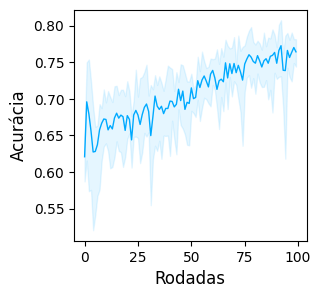

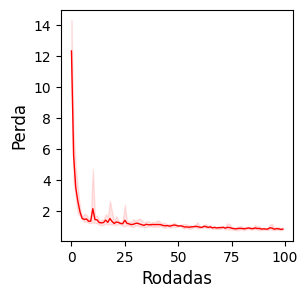

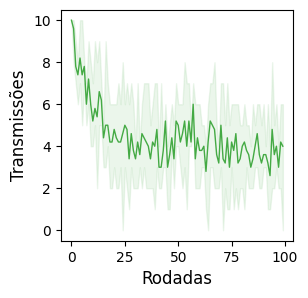

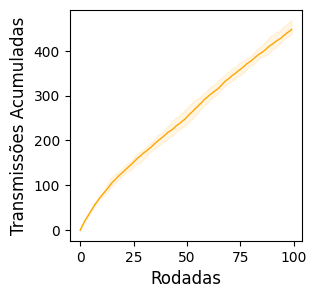

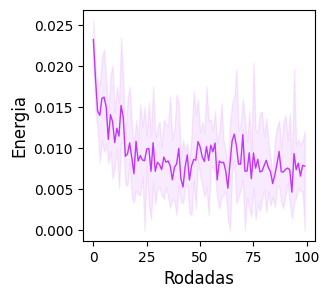

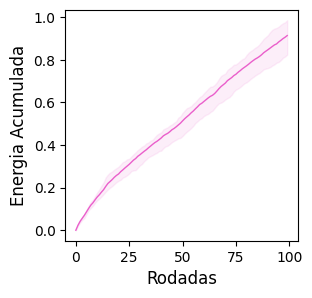

In [44]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_aleatoria/validacao_epsilon_25/")

### 3 - Validação de Epsilon = 55
Aproximadamente 250 transmissões

In [49]:
LAMBDA = 0.25

In [50]:
acc_list, loss_list, transmissions_list, energy_consumption_list = [], [], [], []

for i in range(NUMBER_OF_TESTS):
    acc, loss, transmissions, energy_consumption  = executar(i)
    acc_list.append(acc)
    loss_list.append(loss)
    transmissions_list.append(transmissions)
    energy_consumption_list.append(energy_consumption)


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[39 59 84 49 23 41 12 77 88 73]
Clientes selecionados: [13 24 40 42 50 60 74 78 85 89]
Cliente #13 | Acurácia: 0.9224137663841248 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9255813956260681 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9172297120094299 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9555930495262146 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9050880670547485 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9195849299430847 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9185312390327454 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9339622855186462 | Modelo transmitido!
Cliente #85 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8347457647323608 | Modelo transmitido!
0: -> Disp: 12, RB: 6: 0.0021125890999983874
1: -> Disp: 23, RB: 4: 0.0021504199760063957
2: -> Disp: 39, RB: 0: 0.0014575682546329293
3: -> Disp: 41, RB: 5: 0.0020217695826822936
4: -> Disp: 49, RB: 3: 0.002137888521530444
5: -> Disp: 59, RB: 1: 0.00

  1%|          | 1/100 [00:12<20:27, 12.40s/it]

Execução #0, Transmissões nesta rodada: 10, Acurácia: 0.5911999940872192, Energia total da rodada: 0.019223453197753437, Rodada 2/100
[17 48 29 37 10 56 42 76 22 33]
Clientes selecionados: [11 18 23 30 34 38 43 49 57 77]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9253279566764832 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9280517101287842 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9276155829429626 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9076246619224548 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9332638382911682 | Modelo transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo transmitido!
0: -> Disp: 10, RB: 4: 0.002017362892452555
1: -> Disp: 17, RB: 0: 0.0015049965692419344
2: -> Disp: 22, RB: 8: 0.00143392347637972

  2%|▏         | 2/100 [00:24<19:42, 12.07s/it]

Execução #0, Transmissões nesta rodada: 10, Acurácia: 0.7087000012397766, Energia total da rodada: 0.01625946626011026, Rodada 3/100
[55  4 81 25 64 90 22 16 33 28]
Clientes selecionados: [ 5 17 23 26 29 34 56 65 82 91]
Cliente #5 | Acurácia: 0.940625011920929 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9343236684799194 | Modelo transmitido!
Cliente #23 | Acurácia: 0.885947048664093 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.890489935874939 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8797814249992371 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9263538122177124 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9518613815307617 | Modelo transmitido!
0: -> Disp: 4, RB: 1: 0.00166463615489203
1: -> Disp: 16, RB: 7: 0.0012670902418039731
2: -> Disp: 22, RB: 6: 0.00128548826290

  3%|▎         | 3/100 [00:34<18:24, 11.38s/it]

Execução #0, Transmissões nesta rodada: 8, Acurácia: 0.6862999796867371, Energia total da rodada: 0.012467184363193646, Rodada 4/100
[18 80 30 95 49 81 90 79 35 73]
Clientes selecionados: [19 31 36 50 74 80 81 82 91 96]
Cliente #19 | Acurácia: 0.9276094436645508 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9314180016517639 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9090019464492798 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9196786880493164 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9282084107398987 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo transmitido!
Cliente #82 | Acurácia: 0.942643404006958 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9099025726318359 | Modelo transmitido!
0: -> Disp: 18, RB: 0: 0.0016288068733037496
1: -> Disp: 30, RB: 2: 0.0028584155638200328
2: -> Disp: 35, RB: 8: 0.001626854967

  4%|▍         | 4/100 [00:44<17:27, 10.91s/it]

Execução #0, Transmissões nesta rodada: 9, Acurácia: 0.6636999845504761, Energia total da rodada: 0.019401894925747995, Rodada 5/100
[80 62 70 14 75 69 56  1 40 45]
Clientes selecionados: [ 2 15 41 46 57 63 70 71 76 81]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9154652953147888 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9204152226448059 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9288361668586731 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9354413747787476 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.001527474598195279
1: -> Disp: 14, RB: 3: 0.00204543826992858
2: -> Disp: 40, RB: 8: 0.001607707550

  5%|▌         | 5/100 [00:55<16:51, 10.65s/it]

Execução #0, Transmissões nesta rodada: 8, Acurácia: 0.701200008392334, Energia total da rodada: 0.013706567769537286, Rodada 6/100
[ 4 70 96 51 87  6 42 76 73 85]
Clientes selecionados: [ 5  7 43 52 71 74 77 86 88 97]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9209246039390564 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9351692199707031 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9396751523017883 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9425414204597473 | Modelo transmitido!
0: -> Disp: 4, RB: 0: 0.001220329567915557
1: -> Disp: 6, RB: 5: 0.0018183429188223337
2: -> Disp: 42, RB: 6: 0.0014725744

  6%|▌         | 6/100 [01:05<16:18, 10.41s/it]

Execução #0, Transmissões nesta rodada: 7, Acurácia: 0.7095999717712402, Energia total da rodada: 0.011356845599591874, Rodada 7/100
[72  0 81 32 66 87  2 40 36 45]
Clientes selecionados: [ 1  3 33 37 41 46 67 73 82 88]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9251870512962341 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9374240636825562 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.001613714757329431
1: -> Disp: 2, RB: 6: 0.0019999335981757977
2: -> Disp: 32, RB: 3: 0.001665

  7%|▋         | 7/100 [01:14<15:50, 10.22s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.7177000045776367, Energia total da rodada: 0.009758559053866949, Rodada 8/100
[18 98 95 48 29 47 65 54 41 66]
Clientes selecionados: [19 30 42 48 49 55 66 67 96 99]
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9455096125602722 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9572793841362 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9422510266304016 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9172077775001526 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9228687286376953 | Modelo transmitido!
0: -> Disp: 18, RB: 0: 0.0016288068733037496
1: -> Disp: 29, RB: 4: 0.002556551792470934
2: -> Disp: 41, RB: 8: 0.002

  8%|▊         | 8/100 [01:29<17:57, 11.71s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.7139999866485596, Energia total da rodada: 0.015682677902084205, Rodada 9/100
[18  7 52  0 47 25 68  8  1 40]
Clientes selecionados: [ 1  2  8  9 19 26 41 48 53 69]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9436026811599731 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9193083643913269 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9328226447105408 | Modelo transmitido!
Cliente #53 | Acurácia: 0.931275486946106 | Modelo transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.002345511872745141
1: -> Disp: 1, RB: 8: 0.0016160318260627787
2: -> Disp: 7, RB: 1: 0.002261090

  9%|▉         | 9/100 [01:49<21:44, 14.34s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.6891000270843506, Energia total da rodada: 0.014106849604126575, Rodada 10/100
[95 52 49 53  9 10 54  1 40 93]
Clientes selecionados: [ 2 10 11 41 50 53 54 55 94 96]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9168297648429871 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9225392937660217 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9267676472663879 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9404849410057068 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.001527474598195279
1: -> Disp: 9, RB: 4: 0.002181685321129532
2: -> Disp: 10, RB: 5: 0.002

 10%|█         | 10/100 [02:10<24:23, 16.26s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.6812000274658203, Energia total da rodada: 0.011566420945578654, Rodada 11/100
[60 17 94 43 65 10 71 69 79 86]
Clientes selecionados: [11 18 44 61 66 70 72 80 87 95]
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9347664713859558 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9313849806785583 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9406068325042725 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo transmitido!
0: -> Disp: 10, RB: 5: 0.0022370087986820567
1: -> Disp: 17, RB: 1: 0.0021535228525986863
2: -> Disp: 43, RB: 3: 

 11%|█         | 11/100 [02:34<27:31, 18.55s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.7168999910354614, Energia total da rodada: 0.011940364836172387, Rodada 12/100
[18 50 63 52 10 87 69 26 40 74]
Clientes selecionados: [11 19 27 41 51 53 64 70 75 88]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo transmitido!
Cliente #53 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9206820130348206 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 4: 0.002017362892452555
1: -> Disp: 18, RB: 0: 0.0016288068733037496
2: -> Disp: 26, RB: 7: 0.001989762

 12%|█▏        | 12/100 [02:55<28:30, 19.44s/it]

Execução #0, Transmissões nesta rodada: 5, Acurácia: 0.7085999846458435, Energia total da rodada: 0.009566767237118523, Rodada 13/100
[60 89 99  9 32 12 77 44 58 92]
Clientes selecionados: [ 10  13  33  45  59  61  78  90  93 100]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.927955687046051 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9352201223373413 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9524807929992676 | Modelo transmitido!
0: -> Disp: 9, RB: 3: 0.001926863184542634
1: -> Disp: 12, RB: 5: 0.0019399413188430433
2: -> Disp: 32,

 13%|█▎        | 13/100 [03:19<29:53, 20.61s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.7269999980926514, Energia total da rodada: 0.009786493219564223, Rodada 14/100
[52 78  9 97 32  2 71 76 22 16]
Clientes selecionados: [ 3 10 17 23 33 53 72 77 79 98]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9417588710784912 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9362363815307617 | Modelo transmitido!
0: -> Disp: 2, RB: 5: 0.0018408989101284087
1: -> Disp: 9, RB: 2: 0.0016607065750879229
2: -> Disp: 16, RB: 9: 0.00

 14%|█▍        | 14/100 [03:36<28:04, 19.59s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.6647999882698059, Energia total da rodada: 0.009484776659828508, Rodada 15/100
[50 11 59 94 49 47 88 86  3 74]
Clientes selecionados: [ 4 12 48 50 51 60 75 87 89 95]
Cliente #4 | Acurácia: 0.9143598675727844 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9351797103881836 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9373258948326111 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9182879328727722 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9348137378692627 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0015708721052888426
1: -> Disp: 11, RB: 1: 0.0020775446370581555
2: -> Disp: 4

 15%|█▌        | 15/100 [03:55<27:30, 19.42s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7211999893188477, Energia total da rodada: 0.004844639329423758, Rodada 16/100
[94 21 67 29 19 12 64 26 40 82]
Clientes selecionados: [13 20 22 27 30 41 65 68 83 95]
Cliente #13 | Acurácia: 0.9211822748184204 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9330617189407349 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9434913992881775 | Modelo transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9415162205696106 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 5: 0.0019399413188430433
1: -> Disp: 19, RB: 4: 0.0018607595499881932
2: -> Disp: 21, RB: 

 16%|█▌        | 16/100 [04:17<28:22, 20.27s/it]

Execução #0, Transmissões nesta rodada: 5, Acurácia: 0.7509999871253967, Energia total da rodada: 0.009596957787155636, Rodada 17/100
[91 59 52 48  5 53 89 79 88 83]
Clientes selecionados: [ 6 49 53 54 60 80 84 89 90 92]
Cliente #6 | Acurácia: 0.9312681555747986 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9032257795333862 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9266161918640137 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9351351261138916 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9487763047218323 | Modelo transmitido!
0: -> Disp: 5, RB: 4: 0.002803237003926436
1: -> Disp: 48, RB: 3: 0.002650562358556989
2: -> Disp: 52, RB: 2: 

 17%|█▋        | 17/100 [04:40<29:00, 20.97s/it]

Execução #0, Transmissões nesta rodada: 5, Acurácia: 0.671500027179718, Energia total da rodada: 0.011023747246116924, Rodada 18/100
[52 61 53 97 10 54 77 88 73 92]
Clientes selecionados: [11 53 54 55 62 74 78 89 93 98]
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9178799986839294 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9387626051902771 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9281886219978333 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.958832323551178 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9294320344924927 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9345911741256714 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9088982939720154 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.929237961769104 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 4: 0.002017362892452555
1: -> Disp: 52, RB: 0: 0.0013679735614414725
2: -> Disp:

 18%|█▊        | 18/100 [04:51<24:51, 18.19s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.698199987411499, Energia total da rodada: 0.003356505707705489, Rodada 19/100
[43 47 14 99 51  8 58 93 82 85]
Clientes selecionados: [  9  15  44  48  52  59  83  86  94 100]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9177489280700684 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9286987781524658 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9441587328910828 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9336128830909729 | Modelo transmitido!
0: -> Disp: 8, RB: 5: 0.0020448103330753084
1: -> Disp: 14, RB: 2: 0.0017543987955963352
2: 

 19%|█▉        | 19/100 [04:58<19:49, 14.69s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6689000129699707, Energia total da rodada: 0.00517010942760023, Rodada 20/100
[80 95 50  5 15 47 97 19 66 28]
Clientes selecionados: [ 6 16 20 29 48 51 67 81 96 98]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9231664538383484 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9089252948760986 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9446640610694885 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0024387538164429108
1: -> Disp: 15, RB: 4: 0.002392811698695862
2: -> Disp: 19, R

 20%|██        | 20/100 [05:08<17:42, 13.28s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7257999777793884, Energia total da rodada: 0.0076701051805601606, Rodada 21/100
[30 43 81 25 19  8 66 35 73 28]
Clientes selecionados: [ 9 20 26 29 31 36 44 67 74 82]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9202561378479004 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9224205017089844 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9351692199707031 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0020448103330753084
1: -> Disp: 19, RB: 4: 0.0018607595499881932
2: -> Disp: 2

 21%|██        | 21/100 [05:25<18:50, 14.31s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6958000063896179, Energia total da rodada: 0.005386258038718443, Rodada 22/100
[57 18 39 94 14 53 58 35 40 83]
Clientes selecionados: [15 19 36 40 41 54 58 59 84 95]
Cliente #15 | Acurácia: 0.920604944229126 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9267676472663879 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9353519082069397 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9394594430923462 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.939828097820282 | Modelo transmitido!
0: -> Disp: 14, RB: 4: 0.0023250573530622675
1: -> Disp: 18, RB: 1: 0.002372356954437293
2: -> Disp: 35

 22%|██▏       | 22/100 [05:41<19:27, 14.96s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6717000007629395, Energia total da rodada: 0.006862901166631501, Rodada 23/100
[95 11 13 34 43 20 97 81 66 93]
Clientes selecionados: [12 14 21 35 44 67 82 94 96 98]
Cliente #12 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9445910453796387 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9208688735961914 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9519950151443481 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9485672116279602 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 1: 0.0020775446370581555
1: -> Disp: 13, RB: 2: 0.0026039846846685854
2: -> Disp: 20, RB: 5: 0.00

 23%|██▎       | 23/100 [06:01<21:12, 16.52s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6895999908447266, Energia total da rodada: 0.01056231934654199, Rodada 24/100
[24  7 11  5 19  8 66 88 42 83]
Clientes selecionados: [ 6  8  9 12 20 25 43 67 84 89]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9182747006416321 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9231664538383484 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9318735003471375 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9311475157737732 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9110169410705566 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0024387538164429108
1: -> Disp: 7, RB: 1: 0.002261090136410813
2: -> Disp: 8, RB:

 24%|██▍       | 24/100 [06:17<20:37, 16.29s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7329000234603882, Energia total da rodada: 0.005236801144217646, Rodada 25/100
[39 21 65 23 41 12  2 44 93 33]
Clientes selecionados: [ 3 13 22 24 34 40 42 45 66 94]
Cliente #3 | Acurácia: 0.9293432831764221 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9291871786117554 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9595564007759094 | Modelo transmitido!
Cliente #24 | Acurácia: 0.945348858833313 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9287945032119751 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0019999335981757977
1: -> Disp: 12, RB: 5: 0.0019399413188430433
2: -> Disp: 21, RB:

 25%|██▌       | 25/100 [06:34<20:38, 16.52s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7099000215530396, Energia total da rodada: 0.0069954856805018945, Rodada 26/100
[39 52  5 53 51 12 44 38 16 74]
Clientes selecionados: [ 6 13 17 39 40 45 52 53 54 75]
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9211822748184204 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9468334913253784 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9421157836914062 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9387882351875305 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9309309124946594 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9237041473388672 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002062796168602302
1: -> Disp: 12, RB: 5: 0.0019399413188430433
2: ->

 26%|██▌       | 26/100 [06:53<21:14, 17.22s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.7268000245094299, Energia total da rodada: 0.0013323443369899874, Rodada 27/100
[98 52 65 81 12 27 42  3 92 45]
Clientes selecionados: [ 4 13 28 43 46 53 66 82 93 99]
Cliente #4 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9211822748184204 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9205749034881592 | Modelo transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0014862430738892948
1: -> Disp: 12, RB: 4: 0.0017623316197110147
2: -> Disp: 27, RB

 27%|██▋       | 27/100 [07:12<21:34, 17.73s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7084000110626221, Energia total da rodada: 0.00631291016012041, Rodada 28/100
[80 98 34 62 70 53 99 81 41 71]
Clientes selecionados: [ 35  42  54  63  71  72  81  82  99 100]
Cliente #35 | Acurácia: 0.9101717472076416 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9533445835113525 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9324495196342468 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9388535022735596 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9341238737106323 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9501246809959412 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9336128830909729 | Modelo NÃO transmitido!
0: -> Disp: 34, RB: 2: 0.0024097264966350274
1: -> Disp: 41, RB: 8: 0.002563770491063505

 28%|██▊       | 28/100 [07:30<21:23, 17.83s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6686999797821045, Energia total da rodada: 0.004144531259578769, Rodada 29/100
[63 39 84  9 25 12 27  1 36 74]
Clientes selecionados: [ 2 10 13 26 28 37 40 64 75 85]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9236006140708923 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9292364716529846 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9364864826202393 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.001527474598195279
1: -> Disp: 9, RB: 3: 0.001926863184542634
2: -> Disp: 12, RB: 

 29%|██▉       | 29/100 [07:46<20:28, 17.30s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7164999842643738, Energia total da rodada: 0.007407959704830737, Rodada 30/100
[18 24 98 29 46 75 56 73 74 28]
Clientes selecionados: [19 25 29 30 47 57 74 75 76 99]
Cliente #19 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9034608602523804 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9457768797874451 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9282845854759216 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 0: 0.0016288068733037496
1: -> Disp: 24, RB: 1: 0.002318517873917357
2: -> Disp: 28,

 30%|███       | 30/100 [08:02<19:43, 16.91s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7024000287055969, Energia total da rodada: 0.0045916405852772174, Rodada 31/100
[98 30 11 94 21  4 14 41 87 35]
Clientes selecionados: [ 5 12 15 22 31 36 42 88 95 99]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9156829714775085 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9348137378692627 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.003156976930091543
1: -> Disp: 11, RB: 2: 0.002643084034047115
2: -> Disp:

 31%|███       | 31/100 [08:19<19:20, 16.81s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6430000066757202, Energia total da rodada: 0.005507975580194055, Rodada 32/100
[13 94 70 15 23 27 79 40 22 33]
Clientes selecionados: [14 16 23 24 28 34 41 71 80 95]
Cliente #14 | Acurácia: 0.9219568967819214 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9311649203300476 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9382165670394897 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9355300664901733 | Modelo transmitido!
0: -> Disp: 13, RB: 0: 0.001445782196688895
1: -> Disp: 15, RB: 3: 0.0021013573426417677
2: -> Disp: 22, R

 32%|███▏      | 32/100 [08:35<18:54, 16.69s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6615999937057495, Energia total da rodada: 0.006542119811794972, Rodada 33/100
[62  4 70 84 54 41 66 90 40 28]
Clientes selecionados: [ 5 29 41 42 55 63 67 71 85 91]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9169549942016602 | Modelo transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9317567348480225 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo transmitido!
0: -> Disp: 4, RB: 1: 0.00166463615489203
1: -> Disp: 28, RB: 9: 0.0011374979906097744
2: -> Disp: 40, RB: 

 33%|███▎      | 33/100 [08:52<18:44, 16.78s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7023000121116638, Energia total da rodada: 0.005457295703724971, Rodada 34/100
[24 11  4 70 64 71 69 83 74 45]
Clientes selecionados: [ 5 12 25 46 65 70 71 72 75 84]
Cliente #5 | Acurácia: 0.946093738079071 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9272608160972595 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.932542622089386 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.946496844291687 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 2: 0.0020608545283770274
1: -> Disp: 11, RB: 1: 0.0020775446370581555
2: -> Disp: 2

 34%|███▍      | 34/100 [09:08<18:19, 16.66s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6725999712944031, Energia total da rodada: 0.0033424147072474895, Rodada 35/100
[60 57 50 67 29 46 25 68 58 85]
Clientes selecionados: [26 30 47 51 58 59 61 68 69 86]
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9455096125602722 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9281385540962219 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9553752541542053 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9287958145141602 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo transmitido!
0: -> Disp: 25, RB: 6: 0.002473326355913486
1: -> Disp: 29, RB: 4: 0.002556551792470934
2: -> Disp: 

 35%|███▌      | 35/100 [09:23<17:18, 15.98s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7124999761581421, Energia total da rodada: 0.005747922553994558, Rodada 36/100
[34 72 67 47 14  8 86 76 33 31]
Clientes selecionados: [ 9 15 32 34 35 48 68 73 77 87]
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9199676513671875 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9342995285987854 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.936208963394165 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo transmitido!
0: -> Disp: 8, RB: 5: 0.0020448103330753084
1: -> Disp: 14, RB: 4: 0.0023250573530622675
2: -> Disp: 31

 36%|███▌      | 36/100 [09:40<17:35, 16.49s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.694599986076355, Energia total da rodada: 0.003937344174550937, Rodada 37/100
[98 30 17 72 61 29 15 97 46 41]
Clientes selecionados: [16 18 30 31 42 47 62 73 98 99]
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9390018582344055 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9508804678916931 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9657110571861267 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9398542046546936 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9315707683563232 | Modelo transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 15, RB: 6: 0.0029562181542189515
1: -> Disp: 17, RB: 2: 0.0027514065133469436
2: -> Disp: 29, RB: 5: 

 37%|███▋      | 37/100 [09:57<17:27, 16.63s/it]

Execução #0, Transmissões nesta rodada: 5, Acurácia: 0.7164000272750854, Energia total da rodada: 0.012719821197743168, Rodada 38/100
[57 24 17 50 39  5 43 86 58 38]
Clientes selecionados: [ 6 18 25 39 40 44 51 58 59 87]
Cliente #6 | Acurácia: 0.9264279007911682 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9436363577842712 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9224205017089844 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9566285014152527 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0031605621145192387
1: -> Disp: 17, RB: 2: 0.0027514065133469436
2: -> Disp

 38%|███▊      | 38/100 [10:13<16:47, 16.25s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6970999836921692, Energia total da rodada: 0.0054792042193936245, Rodada 39/100
[52 72 81 54 66 12 86 58 35 45]
Clientes selecionados: [13 36 46 53 55 59 67 73 82 87]
Cliente #13 | Acurácia: 0.924876868724823 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9246753454208374 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9325637817382812 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9515816569328308 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 5: 0.0019399413188430433
1: -> Disp: 35, RB: 8: 0.0016268549673342286
2: -

 39%|███▉      | 39/100 [10:29<16:40, 16.39s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.7031999826431274, Energia total da rodada: 0.0016269947271608895, Rodada 40/100
[57 48 29 49 41  2 27 36 16 28]
Clientes selecionados: [ 3 17 28 29 30 37 42 49 50 58]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9562157988548279 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9387292265892029 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9255120754241943 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9310850501060486 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9305284023284912 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0018408989101284087
1: -> Disp: 16, RB: 8: 0.0013316388827572018
2: -

 40%|████      | 40/100 [10:45<16:16, 16.27s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.7085000276565552, Energia total da rodada: 0.002138028281357104, Rodada 41/100
[60 63 39 72 48  5 78 32 86 31]
Clientes selecionados: [ 6 32 33 40 49 61 64 73 79 87]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9479866027832031 | Modelo transmitido!
Cliente #33 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9337788820266724 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9155495762825012 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.949644923210144 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0031605621145192387
1: -> Disp: 31, RB: 9: 0.0011771940290352903
2: -> Disp: 32, 

 41%|████      | 41/100 [11:02<16:00, 16.28s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6786999702453613, Energia total da rodada: 0.006906693467404266, Rodada 42/100
[55 13 72  9 75 88 73 85 22 33]
Clientes selecionados: [10 14 23 34 56 73 74 76 86 89]
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.921374499797821 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8839103579521179 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9296685457229614 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9066666960716248 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9428918361663818 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9351692199707031 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9256865978240967 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8898305296897888 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 3: 0.001926863184542634
1: -> Disp: 13, RB: 1: 0.002050064930704752
2: -> Disp: 

 42%|████▏     | 42/100 [11:08<12:45, 13.21s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6452999711036682, Energia total da rodada: 0.004290872934844893, Rodada 43/100
[60 57 13 59 61 96  6 26 56 35]
Clientes selecionados: [ 7 14 27 36 57 58 60 61 62 97]
Cliente #7 | Acurácia: 0.9631196856498718 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9595808386802673 | Modelo transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo transmitido!
0: -> Disp: 6, RB: 6: 0.0019743083006171836
1: -> Disp: 13, RB: 2: 0.0026039846846685854
2: -> Disp: 26

 43%|████▎     | 43/100 [11:15<10:49, 11.39s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6901999711990356, Energia total da rodada: 0.007237354943051881, Rodada 44/100
[39 21  0 23 10 77 27 83 45 31]
Clientes selecionados: [ 1 11 22 24 28 32 40 46 78 84]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9595564007759094 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9479866027832031 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9448648691177368 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0019899745556456157
1: -> Disp: 10, RB: 4: 0.002017362892452555
2: -> Disp

 44%|████▍     | 44/100 [11:32<12:09, 13.02s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6929000020027161, Energia total da rodada: 0.0034750553780425165, Rodada 45/100
[60 61  0 97 81 54 41 85 16 45]
Clientes selecionados: [ 1 17 42 46 55 61 62 82 86 98]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9634625911712646 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.961077868938446 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9376114010810852 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9199066758155823 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0019899745556456157
1: -> Disp: 16, RB: 8: 0.0013316388827572018
2: -> Disp: 41, R

 45%|████▌     | 45/100 [11:50<13:16, 14.48s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6814000010490417, Energia total da rodada: 0.007066152205419029, Rodada 46/100
[55 18 80 34 48 99 32 77 35 93]
Clientes selecionados: [ 19  33  35  36  49  56  78  81  94 100]
Cliente #19 | Acurácia: 0.941919207572937 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9048877358436584 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9276190400123596 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.937805712223053 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 1: 0.002372356954437293
1: -> Disp: 32, RB: 6: 0.0022513953125604357


 46%|████▌     | 46/100 [12:07<13:51, 15.40s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7067000269889832, Energia total da rodada: 0.003999336152728551, Rodada 47/100
[55 18 30 52 62 32 71 44 35 45]
Clientes selecionados: [19 31 33 36 45 46 53 56 63 72]
Cliente #19 | Acurácia: 0.9427609443664551 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9054163098335266 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 1: 0.002372356954437293
1: -> Disp: 30, RB: 2: 0.0028584155638200328
2:

 47%|████▋     | 47/100 [12:26<14:26, 16.35s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.6873999834060669, Energia total da rodada: 1.552886962890625e-07, Rodada 48/100
[21 67 61 43 53 54  2 27 35 38]
Clientes selecionados: [ 3 22 28 36 39 44 54 55 62 68]
Cliente #3 | Acurácia: 0.940980851650238 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9258010387420654 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9421157836914062 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9131109118461609 | Modelo transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9655688405036926 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9362319111824036 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 6: 0.0019999335981757977
1: -> Disp: 21, RB: 0: 0.0013104393997796534
2: -> Disp: 27

 48%|████▊     | 48/100 [12:45<14:58, 17.28s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6222000122070312, Energia total da rodada: 0.006370562003477978, Rodada 49/100
[43 23 19 66  6 90 88 35 92 33]
Clientes selecionados: [ 7 20 24 34 36 44 67 89 91 93]
Cliente #7 | Acurácia: 0.9552599787712097 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9231664538383484 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9106239676475525 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.001657470057610595
1: -> Disp: 19, RB: 2: 0.0014482649431573399
2: -> D

 49%|████▉     | 49/100 [13:04<15:00, 17.66s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6678000092506409, Energia total da rodada: 0.001696625793621224, Rodada 50/100
[61 14 99 75 12 64 71 77 38 74]
Clientes selecionados: [ 13  15  39  62  65  72  75  76  78 100]
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9481037855148315 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9208400845527649 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 4: 0.0017623316197110147
1: -> Disp: 14, RB: 1: 0.001443122830

 50%|█████     | 50/100 [13:23<15:05, 18.12s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.7031999826431274, Energia total da rodada: 0.0018898237533400365, Rodada 51/100
[39 67 78 32 66 76 73 36 16 74]
Clientes selecionados: [17 33 37 40 67 68 74 75 77 79]
Cliente #17 | Acurácia: 0.950742781162262 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9159256219863892 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9295082092285156 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9305794835090637 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9270976781845093 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo transmitido!
0: -> Disp: 16, RB: 8: 0.0013316388827572018
1: -> Disp: 32, RB: 3: 0.001665263846216806
2: -> Disp: 36, 

 51%|█████     | 51/100 [13:38<14:09, 17.34s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6787999868392944, Energia total da rodada: 0.006193943006626831, Rodada 52/100
[ 7 17 95 29 49 25 27 44 88 93]
Clientes selecionados: [ 8 18 26 28 30 45 50 89 94 96]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9288355112075806 | Modelo transmitido!
Cliente #26 | Acurácia: 0.909221887588501 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9434239268302917 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.001566083985440418
1: -> Disp: 17, RB: 1: 0.0021535228525986863
2: -> Disp: 25, RB:

 52%|█████▏    | 52/100 [13:54<13:25, 16.79s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7117000222206116, Energia total da rodada: 0.007999905828100942, Rodada 53/100
[43 81 10 41 27 56 44 86 83 16]
Clientes selecionados: [11 17 28 42 44 45 57 82 84 87]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9294026494026184 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9412866830825806 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9243243336677551 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.947062611579895 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 2: 0.0015524482154889935
1: -> Disp: 16, RB: 9: 0.0013942440227130769


 53%|█████▎    | 53/100 [14:13<13:37, 17.40s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.6765000224113464, Energia total da rodada: 1.552886962890625e-07, Rodada 54/100
[30 13 84 43 96  6 56  1 40 85]
Clientes selecionados: [ 2  7 14 31 41 44 57 85 86 97]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9277809858322144 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9410714507102966 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9524862170219421 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.001527474598195279
1: -> Disp: 6, RB: 5: 0.0018183429188223337
2: -> Disp: 1

 54%|█████▍    | 54/100 [14:30<13:21, 17.42s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6409000158309937, Energia total da rodada: 0.003518961578666087, Rodada 55/100
[80 50 14 99 75 19 79 44 85 22]
Clientes selecionados: [ 15  20  23  45  51  76  80  81  86 100]
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9272409677505493 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8737270832061768 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9192245602607727 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #86 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo transmitido!
0: -> Disp: 14, RB: 2: 0.0017543987955963352
1: -> Disp: 19, RB: 5: 0.002054385882440803
2: -> D

 55%|█████▌    | 55/100 [14:47<12:53, 17.19s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6582000255584717, Energia total da rodada: 0.007073502343606146, Rodada 56/100
[30 84 29 49 14 65 12 56 40 31]
Clientes selecionados: [13 15 30 31 32 41 50 57 66 85]
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9485368132591248 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9310810565948486 | Modelo transmitido!
0: -> Disp: 12, RB: 6: 0.0021125890999983874
1: -> Disp: 14, RB: 4: 0.0023250573530622675
2: -> Dis

 56%|█████▌    | 56/100 [15:04<12:41, 17.30s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7084000110626221, Energia total da rodada: 0.0033841158959416794, Rodada 57/100
[94 61 29 53 99  9 37 69 92 33]
Clientes selecionados: [ 10  30  34  38  54  62  70  93  95 100]
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9505549669265747 | Modelo transmitido!
Cliente #34 | Acurácia: 0.935327410697937 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9377162456512451 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9347664713859558 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.002429244018682886
1: -> Disp: 29, RB: 2: 0.0019044022924669679
2: -> 

 57%|█████▋    | 57/100 [15:23<12:36, 17.60s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6182000041007996, Energia total da rodada: 0.005560114407758277, Rodada 58/100
[99  9 10 87  6 71 69 58 82 22]
Clientes selecionados: [  7  10  11  23  59  70  72  83  88 100]
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.936170220375061 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8839103579521179 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9244372844696045 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9209581017494202 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9440950155258179 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.001657470057610595
1: -> Disp: 9, RB: 1: 0.0013746120054409913
2

 58%|█████▊    | 58/100 [15:39<12:03, 17.23s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6474999785423279, Energia total da rodada: 0.003245641802134725, Rodada 59/100
[24 34 94 70 14 53 90 56 58 92]
Clientes selecionados: [15 25 35 54 57 59 71 91 93 95]
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9305555820465088 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9457768797874451 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9412607550621033 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 4: 0.0023250573530622675
1: -> Disp: 24, RB: 0: 0.0015985131461642098
2: -

 59%|█████▉    | 59/100 [15:56<11:41, 17.11s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6869000196456909, Energia total da rodada: 0.0017105031346684061, Rodada 60/100
[60 63  0 29 47 54  8 69 86  3]
Clientes selecionados: [ 1  4  9 30 48 55 61 64 70 87]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9475277662277222 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9422510266304016 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9377316236495972 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0019899745556456157
1: -> Disp: 3, RB: 9: 0.0016534179360626147
2: -> Disp:

 60%|██████    | 60/100 [16:09<10:36, 15.92s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6866000294685364, Energia total da rodada: 0.004327277198330657, Rodada 61/100
[60 30 95 70 29  2 79 44 40 74]
Clientes selecionados: [ 3 30 31 41 45 61 71 75 80 96]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.955600380897522 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9481000900268555 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.942535936832428 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9459974765777588 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo transmitido!
0: -> Disp: 2, RB: 5: 0.0018408989101284087
1: -> Disp: 29, RB: 4: 0.002556551792470934
2: -> Disp: 3

 61%|██████    | 61/100 [16:16<08:34, 13.20s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6990000009536743, Energia total da rodada: 0.004366107014307046, Rodada 62/100
[91 67 99 10 68 32 56  1 38 36]
Clientes selecionados: [  2  11  33  37  39  57  68  69  92 100]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9381237626075745 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9382199048995972 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9516220688819885 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9385045170783997 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.001527474598195279
1: -> Disp: 10, RB: 3: 0.0017904959992672007


 62%|██████▏   | 62/100 [16:32<08:53, 14.05s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6730999946594238, Energia total da rodada: 0.0036754720339853926, Rodada 63/100
[11 21 53 96 23 87 86 40 92 33]
Clientes selecionados: [12 22 24 34 41 54 87 88 93 97]
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9441860318183899 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9558011293411255 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 0: 0.0014615569057097664
1: -> Disp: 21, RB: 1: 0.0018169386620243708
2: -> Di

 63%|██████▎   | 63/100 [16:48<09:05, 14.75s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6715999841690063, Energia total da rodada: 0.002959703343991979, Rodada 64/100
[24 98 21 65 96 37 46  8 73 74]
Clientes selecionados: [ 9 22 25 38 47 66 74 75 97 99]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9351692199707031 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 7: 0.002415705413675092
1: -> Disp: 21, RB: 2: 0.00227417936393019
2: -> Disp: 24, RB

 64%|██████▍   | 64/100 [17:04<08:59, 14.98s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6972000002861023, Energia total da rodada: 0.00587585442028101, Rodada 65/100
[63 94 78 37 32 58 76 36 31 28]
Clientes selecionados: [29 32 33 37 38 59 64 77 79 95]
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9530201554298401 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9199676513671875 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9246753454208374 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9346861243247986 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo NÃO transmitido!
0: -> Disp: 28, RB: 9: 0.0011374979906097744
1: -> Disp: 31, RB: 8: 0.0011301574690380258
2: -> D

 65%|██████▌   | 65/100 [17:19<08:50, 15.16s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6890000104904175, Energia total da rodada: 0.0012967177140182124, Rodada 66/100
[30 50 52  5 47 65 64 69 58  1]
Clientes selecionados: [ 2  6 31 48 51 53 59 65 66 70]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9527339935302734 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9247910976409912 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9394292235374451 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0017024866633470327
1: -> Disp: 5, RB: 3: 0.0024387538164429108
2: -> Disp:

 66%|██████▌   | 66/100 [17:37<08:59, 15.88s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6966999769210815, Energia total da rodada: 0.004239807269927895, Rodada 67/100
[59 52  5 78 47 53 96 42 22 36]
Clientes selecionados: [ 6 23 37 43 48 53 54 60 79 97]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8900203704833984 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9325966835021973 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.002062796168602302
1: -> Disp: 22, RB: 8: 0.001433923476379727
2: -> Disp: 3

 67%|██████▋   | 67/100 [17:54<08:58, 16.31s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7139000296592712, Energia total da rodada: 0.004170401667417878, Rodada 68/100
[ 5 49 14 20 96 68 69 44 35 45]
Clientes selecionados: [ 6 15 21 36 45 46 50 69 70 97]
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9246395826339722 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9277486801147461 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9425414204597473 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0012211603697809567
1: -> Disp: 14, RB: 2: 0.0017543987955963352
2: -> Disp: 20,

 68%|██████▊   | 68/100 [18:11<08:41, 16.30s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7113000154495239, Energia total da rodada: 0.0045415164186660365, Rodada 69/100
[95 39 61 37 23 51 90 58 16 28]
Clientes selecionados: [17 24 29 38 40 52 59 62 91 96]
Cliente #17 | Acurácia: 0.9523065090179443 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9406976699829102 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9089252948760986 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9603293538093567 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9253246784210205 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 8: 0.0013316388827572018
1: -> Disp: 23, RB: 4: 0.0021504199760063957
2: -> Disp: 28, RB

 69%|██████▉   | 69/100 [18:26<08:17, 16.05s/it]

Execução #0, Transmissões nesta rodada: 5, Acurácia: 0.7166000008583069, Energia total da rodada: 0.008678489649950398, Rodada 70/100
[43 65 68 27 56 88 42 93 83 16]
Clientes selecionados: [17 28 43 44 57 66 69 84 89 94]
Cliente #17 | Acurácia: 0.958561360836029 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9409984946250916 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9385644793510437 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9294026494026184 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9499478340148926 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9287958145141602 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 9: 0.0013942440227130769
1: -> Disp: 27, RB: 3: 0.001432222698680575
2: -> Disp: 42, 

 70%|███████   | 70/100 [18:43<08:13, 16.44s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6834999918937683, Energia total da rodada: 0.004348960991892949, Rodada 71/100
[94 49 99  9 97 64 40  3 82 31]
Clientes selecionados: [  4  10  32  41  50  65  83  95  98 100]
Cliente #4 | Acurácia: 0.9264705777168274 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.958053708076477 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9472924470901489 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9473053812980652 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9385045170783997 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0014862430738892948
1: -> Disp: 9, RB: 3: 0.001926863184542634
2: -

 71%|███████   | 71/100 [19:00<07:55, 16.41s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6906999945640564, Energia total da rodada: 0.003123815667720924, Rodada 72/100
[95 59 29 66 12 44 88 40 93 82]
Clientes selecionados: [13 30 41 45 60 67 83 89 94 96]
Cliente #13 | Acurácia: 0.9291871786117554 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9508196711540222 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9305388927459717 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9342532753944397 | Modelo transmitido!
0: -> Disp: 12, RB: 4: 0.0017623316197110147
1: -> Disp: 29, RB: 2: 0.0019044022924669679
2: -> Disp: 40,

 72%|███████▏  | 72/100 [19:16<07:39, 16.39s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.722100019454956, Energia total da rodada: 0.006673251088616172, Rodada 73/100
[57 24 63 47 96  8 87 26 74 45]
Clientes selecionados: [ 9 25 27 46 48 58 64 75 88 97]
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9357798099517822 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9475545287132263 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9533551335334778 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9321496486663818 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.94111567735672 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9546961188316345 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0020448103330753084
1: -> Disp: 24, RB: 1: 0.002318517873917357
2: -> Disp: 2

 73%|███████▎  | 73/100 [19:33<07:23, 16.43s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.698199987411499, Energia total da rodada: 0.00470708477370193, Rodada 74/100
[13 34  5 43 65 25 32 41 69 22]
Clientes selecionados: [ 6 14 23 26 33 35 42 44 66 70]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9309542179107666 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9396551847457886 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002062796168602302
1: -> Disp: 13, RB: 0: 0.001445782196688895
2: -> Disp

 74%|███████▍  | 74/100 [19:50<07:14, 16.70s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6621000170707703, Energia total da rodada: 0.001445921956515556, Rodada 75/100
[55 18 30 61  0 47 10 19 90 76]
Clientes selecionados: [ 1 11 19 20 31 48 56 62 77 91]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9289872050285339 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9233942031860352 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9142857193946838 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.96257483959198 | Modelo transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0026895617909620533
1: -> Disp: 10, RB: 6: 0.0024516365652535264
2: -> Disp: 1

 75%|███████▌  | 75/100 [20:06<06:55, 16.62s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7103999853134155, Energia total da rodada: 0.004869334331489701, Rodada 76/100
[80 30 95 50 59  0 53 51 54 87]
Clientes selecionados: [ 1 31 51 52 54 55 60 81 88 96]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9573679566383362 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9470751881599426 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9504132270812988 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9123376607894897 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.003026412577743468
1: -> Disp: 30, RB: 1: 0.0022283739962885934
2: -> Disp

 76%|███████▌  | 76/100 [20:22<06:29, 16.21s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6877999901771545, Energia total da rodada: 0.004225022511041412, Rodada 77/100
[24 50 52 51 19  6 58 35 73 83]
Clientes selecionados: [ 7 20 25 36 51 52 53 59 74 84]
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9208381772041321 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9289693832397461 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9266161918640137 | Modelo transmitido!
Cliente #59 | Acurácia: 0.932467520236969 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9394594430923462 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.0018183429188223337
1: -> Disp: 19, RB: 4: 0.0018607595499881932
2: -> D

 77%|███████▋  | 77/100 [20:39<06:17, 16.43s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6866999864578247, Energia total da rodada: 0.0024132293436371927, Rodada 78/100
[57 30 17 59 34 62 88 42 35 73]
Clientes selecionados: [18 31 35 36 43 58 60 63 74 89]
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9440389275550842 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9282007217407227 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 2: 0.0027514065133469436
1: -> Disp: 30, RB: 1: 0.0022283739962885934
2: -> 

 78%|███████▊  | 78/100 [20:54<05:56, 16.22s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7177000045776367, Energia total da rodada: 0.0044057315123699455, Rodada 79/100
[50 39 72 49 20 46 51  2 35 16]
Clientes selecionados: [ 3 17 21 36 40 47 50 51 52 73]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo transmitido!
Cliente #17 | Acurácia: 0.948397159576416 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9428319931030273 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9291737079620361 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9408783912658691 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9374240636825562 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 7: 0.002155321046497343
1: -> Disp: 16, RB: 9: 0.0013942440227130769
2: -> Disp: 

 79%|███████▉  | 79/100 [21:10<05:36, 16.04s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7113999724388123, Energia total da rodada: 0.0035496893001674516, Rodada 80/100
[55 95 63 67 15 47 14 23 16 74]
Clientes selecionados: [15 16 17 24 48 56 64 68 75 96]
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9655981063842773 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9395349025726318 | Modelo transmitido!
Cliente #48 | Acurácia: 0.931644082069397 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9085714221000671 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9507246613502502 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9334415793418884 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 6: 0.002864767315189911
1: -> Disp: 15, RB: 4: 0.002392811698695862
2: -> Disp: 16, R

 80%|████████  | 80/100 [21:26<05:21, 16.05s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6868000030517578, Energia total da rodada: 0.008720880450295466, Rodada 81/100
[50 62 61  0 84 65  9 44 86 38]
Clientes selecionados: [ 1 10 39 45 51 62 63 66 85 87]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9475177526473999 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9520958065986633 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9316608905792236 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9385135173797607 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo transmitido!
0: -> Disp: 0, RB: 3: 0.002345511872745141
1: -> Disp: 9, RB: 6: 0.0026717907745212248
2: -> Disp: 38, RB:

 81%|████████  | 81/100 [21:44<05:17, 16.69s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6988999843597412, Energia total da rodada: 0.007078208563135376, Rodada 82/100
[60 91 98 65 20 19 12 27 76 74]
Clientes selecionados: [13 20 21 28 61 66 75 77 92 99]
Cliente #13 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9289872050285339 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9462934732437134 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9415708780288696 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9584519267082214 | Modelo transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 6: 0.0021125890999983874
1: -> Disp: 19, RB: 5: 0.002054385882440803
2: -> Disp: 20, RB:

 82%|████████▏ | 82/100 [22:04<05:15, 17.56s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7361999750137329, Energia total da rodada: 0.007839387414768877, Rodada 83/100
[91  7 49 20 37 68 41 71  1 76]
Clientes selecionados: [ 2  8 21 38 42 50 69 72 77 92]
Cliente #2 | Acurácia: 0.9571917653083801 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9486910700798035 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0016160318260627787
1: -> Disp: 7, RB: 1: 0.002261090136410813
2: -> Disp: 20, R

 83%|████████▎ | 83/100 [22:21<04:55, 17.38s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7226999998092651, Energia total da rodada: 0.005178805646076279, Rodada 84/100
[55 60 18 13 21  4 84 14 79 88]
Clientes selecionados: [ 5 14 15 19 22 56 61 80 85 89]
Cliente #5 | Acurácia: 0.9437500238418579 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9262759685516357 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9486532211303711 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8857142925262451 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9634888172149658 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9415501952171326 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.003156976930091543
1: -> Disp: 13, RB: 3: 0.0031370624000461532
2: 

 84%|████████▍ | 84/100 [22:39<04:42, 17.63s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.6448000073432922, Energia total da rodada: 1.552886962890625e-07, Rodada 85/100
[63 43 89 99 81 69 88 58 35 38]
Clientes selecionados: [ 36  39  44  59  64  70  82  89  90 100]
Cliente #36 | Acurácia: 0.92242830991745 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9441117644309998 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9341991543769836 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9340519905090332 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9343116879463196 | Modelo NÃO transmitido!
0: -> Disp: 35, RB: 8: 0.0016268549673342286
1: -> Disp: 38, RB: 9: 0.001470938210928388
2: -> Disp: 43

 85%|████████▌ | 85/100 [22:59<04:33, 18.24s/it]

Execução #0, Transmissões nesta rodada: 6, Acurácia: 0.6596999764442444, Energia total da rodada: 0.009354017867329721, Rodada 86/100
[47 96 37 41 12  2 56 42 36 74]
Clientes selecionados: [ 3 13 37 38 42 43 48 57 75 97]
Cliente #3 | Acurácia: 0.9268495440483093 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.946943461894989 | Modelo transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9458563327789307 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0018408989101284087
1: -> Disp: 12, RB: 4: 0.0017623316197110147
2: -> D

 86%|████████▌ | 86/100 [23:18<04:18, 18.49s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.7067999839782715, Energia total da rodada: 0.0016516979121724046, Rodada 87/100
[91 98 52 67 81 54 66 87 93 83]
Clientes selecionados: [53 55 67 68 82 84 88 92 94 99]
Cliente #53 | Acurácia: 0.9423412680625916 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9491803050041199 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9526569843292236 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.942148745059967 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9510529041290283 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 52, RB: 2: 0.0024130895838105322
1: -> Disp: 54, RB: 5: 0.002145933260086177
2: -> Disp: 66, R

 87%|████████▋ | 87/100 [23:37<04:01, 18.59s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6468999981880188, Energia total da rodada: 0.007483031056982638, Rodada 88/100
[24  7 63 11 59  5 65 54 93 92]
Clientes selecionados: [ 6  8 12 25 55 60 64 66 93 94]
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.93658846616745 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9397501945495605 | Modelo transmitido!
0: -> Disp: 5, RB: 5: 0.0031605621145192387
1: -> Disp: 7, RB: 1: 0.002261090136410813
2: -> Disp: 11, R

 88%|████████▊ | 88/100 [23:53<03:36, 18.00s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7275000214576721, Energia total da rodada: 0.00406760123505933, Rodada 89/100
[18 13 48 15 68  8 56 58 16 92]
Clientes selecionados: [ 9 14 16 17 19 49 57 59 69 93]
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9551616311073303 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9434555172920227 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 5: 0.0020448103330753084
1: -> Disp: 13, RB: 1: 0.002050064930704752
2: -> Disp: 15,

 89%|████████▉ | 89/100 [24:08<03:08, 17.16s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6769000291824341, Energia total da rodada: 0.006308511583157901, Rodada 90/100
[ 7 63  8 12  2 77 79 44 88 93]
Clientes selecionados: [ 3  8  9 13 45 64 78 80 89 94]
Cliente #3 | Acurácia: 0.9351620674133301 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9236453175544739 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9372225999832153 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9402795433998108 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.930084764957428 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9485672116279602 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 4: 0.0016769449734270875
1: -> Disp: 7, RB: 0: 0.001566083985440418
2: -> D

 90%|█████████ | 90/100 [24:28<02:59, 17.98s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.7282999753952026, Energia total da rodada: 1.552886962890625e-07, Rodada 91/100
[63 11  5  0 32  8 26 79 56 31]
Clientes selecionados: [ 1  6  9 12 27 32 33 57 64 80]
Cliente #1 | Acurácia: 0.9527121186256409 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9318955540657043 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9462264180183411 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9457768797874451 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.944726824760437 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.002345511872745141
1: -> Disp: 5, RB: 2: 0.002062796168602302
2: -> Disp

 91%|█████████ | 91/100 [24:47<02:43, 18.13s/it]

Execução #0, Transmissões nesta rodada: 1, Acurácia: 0.6906999945640564, Energia total da rodada: 0.002345651632571802, Rodada 92/100
[13 43  9 46 10 68 19 77 93 33]
Clientes selecionados: [10 11 14 20 34 44 47 69 78 94]
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9225844144821167 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9309542179107666 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 2: 0.0016607065750879229
1: -> Disp: 10, RB: 4: 0.002017362892452555
2: -> Disp: 13, 

 92%|█████████▏| 92/100 [25:05<02:25, 18.23s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6553999781608582, Energia total da rodada: 0.005675368476608367, Rodada 93/100
[52 34 48 62  5 49 47 87 71 40]
Clientes selecionados: [ 6 35 41 48 49 50 53 63 72 88]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9208211302757263 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9363992214202881 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9244372844696045 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.002803237003926436
1: -> Disp: 34, RB: 1: 0.0019130598752098323
2:

 93%|█████████▎| 93/100 [25:23<02:06, 18.01s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.6820999979972839, Energia total da rodada: 1.552886962890625e-07, Rodada 94/100
[60 80 30 34 49 53  9 81 68 54]
Clientes selecionados: [10 31 35 50 54 55 61 69 81 82]
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9508804678916931 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9114927053451538 | Modelo transmitido!
Cliente #50 | Acurácia: 0.942270040512085 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.92497318983078 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9557356834411621 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 6: 0.0026717907745212248
1: -> Disp: 30, RB: 2: 0.0028584155638200328
2: -> Disp: 34, RB: 3: 0.00288

 94%|█████████▍| 94/100 [25:40<01:46, 17.74s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.6998999714851379, Energia total da rodada: 0.01122308908926974, Rodada 95/100
[57 18 50 39 52  5 65 71 36 33]
Clientes selecionados: [ 6 19 34 37 40 51 53 58 66 72]
Cliente #6 | Acurácia: 0.9109390377998352 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9353523850440979 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 5: 0.0031605621145192387
1: -> Disp: 18, RB: 1: 0.002372356954437293
2: -> Disp: 33, 

 95%|█████████▌| 95/100 [25:56<01:26, 17.33s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.6984999775886536, Energia total da rodada: 0.007229489305097135, Rodada 96/100
[24 98 72  5  0 89 25  6 64 71]
Clientes selecionados: [ 1  6  7 25 26 65 72 73 90 99]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9293320178985596 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9631196856498718 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9527272582054138 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9447144865989685 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9282900094985962 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9106901288032532 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0026895617909620533
1: -> Disp: 5, RB: 3: 0.0024387538164429108
2: -> Disp: 6, RB: 7

 96%|█████████▌| 96/100 [26:12<01:07, 17.00s/it]

Execução #0, Transmissões nesta rodada: 4, Acurácia: 0.7217000126838684, Energia total da rodada: 0.009594668139759118, Rodada 97/100
[17 29 53 20 51 68 32 56 82 85]
Clientes selecionados: [18 21 30 33 52 54 57 69 83 86]
Cliente #18 | Acurácia: 0.9380776286125183 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9445910453796387 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9387626051902771 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9486910700798035 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 0: 0.0015049965692419344
1: -> Disp: 20, RB: 3: 0.00199870246618046
2:

 97%|█████████▋| 97/100 [26:29<00:50, 16.89s/it]

Execução #0, Transmissões nesta rodada: 0, Acurácia: 0.7174000144004822, Energia total da rodada: 1.552886962890625e-07, Rodada 98/100
[17 11 34 21 65 97 46  6 79  3]
Clientes selecionados: [ 4  7 12 18 22 35 47 66 80 98]
Cliente #4 | Acurácia: 0.9117646813392639 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9600967168807983 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9441964030265808 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9459974765777588 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.0016534179360626147
1: -> Disp: 6, RB: 7: 0.0021266320196564248
2: -> Disp: 1

 98%|█████████▊| 98/100 [26:48<00:34, 17.37s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.6998999714851379, Energia total da rodada: 0.00512033707654644, Rodada 99/100
[57  7 95 72  0 78 96 87 56 42]
Clientes selecionados: [ 1  8 43 57 58 73 79 88 96 97]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9345335364341736 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9465370774269104 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9155495762825012 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0026895617909620533
1: -> Disp: 7, RB: 1: 0.002261090136410813
2: -> Disp: 42

 99%|█████████▉| 99/100 [27:05<00:17, 17.54s/it]

Execução #0, Transmissões nesta rodada: 2, Acurácia: 0.7099999785423279, Energia total da rodada: 0.004605918128882678, Rodada 100/100
[57 34 48  5 29 99 54 56 58 76]
Clientes selecionados: [  6  30  35  49  55  57  58  59  77 100]
Cliente #6 | Acurácia: 0.920619547367096 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9281525015830994 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9478623270988464 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9559164643287659 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9531795978546143 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0024387538164429108
1: -> Disp: 29, RB: 4: 0.002556551792470934
2: 

100%|██████████| 100/100 [27:21<00:00, 16.42s/it]

Execução #0, Transmissões nesta rodada: 3, Acurácia: 0.7226999998092651, Energia total da rodada: 0.007131848884490706, 

            RESULTADOS FINAIS             

Centralized loss: [14.401925086975098, 4.971510410308838, 2.384828805923462, 1.5743728876113892, 1.2751071453094482, 1.314328908920288, 1.2040300369262695, 1.5461106300354004, 1.2729934453964233, 1.1756386756896973, 1.2245357036590576, 1.1871660947799683, 1.3614944219589233, 1.3017488718032837, 1.162691354751587, 1.2264900207519531, 1.2303940057754517, 1.244809627532959, 1.1524503231048584, 1.059356927871704, 1.274502158164978, 1.25465726852417, 1.2204138040542603, 1.0633941888809204, 1.6738632917404175, 1.1290156841278076, 1.3901634216308594, 1.266111969947815, 1.178052306175232, 1.286698579788208, 1.276322841644287, 1.2065210342407227, 1.097853422164917, 1.1989320516586304, 1.126071572303772, 1.0385334491729736, 1.050264835357666, 1.0465692281723022, 1.0930185317993164, 1.1336729526519775, 1.0791783332824707, 1.172789931


          CARREGAMENTO DE DADOS           
     Número total de clientes: 100
     

                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[85 53 94 38 87 11 61 97 86 84]
Clientes selecionados: [12 39 54 62 85 86 87 88 95 98]
Cliente #12 | Acurácia: 0.9241071343421936 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9081836342811584 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9122474789619446 | Modelo transmitido!
Cliente #62 | Acurácia: 0.942365288734436 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9148648381233215 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9019607901573181 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9264041185379028 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9183884263038635 | Modelo transmitido!
Cliente #95 | Acurácia: 0.926217794418335 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9214618802070618 | Modelo transmitido!
0: -> Disp: 11, RB: 5: 0.001599636913478602
1: -> Disp: 38, RB: 3: 0.001530699143538538
2: -> Disp: 53, RB: 1: 0.0017678249148923952
3: -> Disp: 61, RB: 6: 0.0015343965654590792
4: -> Disp: 84, RB: 9: 0.0012666845507641033
5: -> Disp: 85, RB: 0: 0.0013

  1%|          | 1/100 [00:31<51:23, 31.15s/it]

Execução #1, Transmissões nesta rodada: 10, Acurácia: 0.6542999744415283, Energia total da rodada: 0.014910728565130298, Rodada 2/100
[ 8  6 31 32 66 74 90 30 41 81]
Clientes selecionados: [ 7  9 31 32 33 42 67 75 82 91]
Cliente #7 | Acurácia: 0.9443772435188293 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9080590009689331 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9513422846794128 | Modelo transmitido!
Cliente #33 | Acurácia: 0.918350875377655 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9174690246582031 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #91 | Acurácia: 0.949935793876648 | Modelo transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 8, RB: 0: 0.0015594998606911809
2: -> Disp: 30, RB: 7: 0.0012486033473624934


  2%|▏         | 2/100 [01:04<52:49, 32.34s/it]

Execução #1, Transmissões nesta rodada: 10, Acurácia: 0.7178000211715698, Energia total da rodada: 0.020117746839405953, Rodada 3/100
[78  6 71 52 32 89 25 36 98 97]
Clientes selecionados: [ 7 26 33 37 53 72 79 90 98 99]
Cliente #7 | Acurácia: 0.9504232406616211 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9159256219863892 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9255120754241943 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9242865443229675 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
Cliente #79 | Acurácia: 0.8941018581390381 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9164696335792542 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9012178778648376 | Modelo transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 25, RB: 6: 0.001977517184175764
2: -> Disp: 32, RB: 4: 0.00316

  3%|▎         | 3/100 [01:27<45:28, 28.13s/it]

Execução #1, Transmissões nesta rodada: 7, Acurácia: 0.6827999949455261, Energia total da rodada: 0.015938908350781166, Rodada 4/100
[13  6 19 24 29 23 10 68 77 41]
Clientes selecionados: [ 7 11 14 20 24 25 30 42 69 78]
Cliente #7 | Acurácia: 0.9552599787712097 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9225392937660217 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9121071100234985 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9255813956260681 | Modelo transmitido!
Cliente #25 | Acurácia: 0.918181836605072 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9109947681427002 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9408804774284363 | Modelo transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 10, RB: 6: 0.002942645879139612
2: -> Disp: 13, RB: 0: 0.00161978718

  4%|▍         | 4/100 [01:53<43:37, 27.27s/it]

Execução #1, Transmissões nesta rodada: 8, Acurácia: 0.6577000021934509, Energia total da rodada: 0.02015227559168143, Rodada 5/100
[66 57 59 45  0 58 61 17 54 97]
Clientes selecionados: [ 1 18 46 55 58 59 60 62 67 98]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9272608160972595 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9229437112808228 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9505987763404846 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.917573869228363 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002087319081497732
1: -> Disp: 17, RB: 7: 0.0014970567790641113
2: -> Disp: 45, RB: 3: 0.002066674

  5%|▌         | 5/100 [02:16<40:31, 25.59s/it]

Execução #1, Transmissões nesta rodada: 7, Acurácia: 0.654699981212616, Energia total da rodada: 0.012490721232045292, Rodada 6/100
[13 60 18  1 88 94 28 70 15 26]
Clientes selecionados: [ 2 14 16 19 27 29 61 71 89 95]
Cliente #2 | Acurácia: 0.9400684833526611 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9458598494529724 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo transmitido!
Cliente #95 | Acurácia: 0.920487105846405 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0027691098591068565
1: -> Disp: 13, RB: 0: 0.0016197871825457254
2: -> Disp: 15, RB: 8: 0.001503401574322

  6%|▌         | 6/100 [02:39<39:09, 24.99s/it]

Execução #1, Transmissões nesta rodada: 9, Acurácia: 0.6470999717712402, Energia total da rodada: 0.018946053174613623, Rodada 7/100
[71 52 32 23 51 45  0 28 96 69]
Clientes selecionados: [ 1 24 29 33 46 52 53 70 72 97]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9151162505149841 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9151172041893005 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9246395826339722 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9231217503547668 | Modelo transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.0025452173334917327
1: -> Disp: 23, RB: 3: 0.002363722275335088
2: -> Disp: 28, RB: 7: 0

  7%|▋         | 7/100 [02:58<35:44, 23.05s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6481000185012817, Energia total da rodada: 0.011518540017259656, Rodada 8/100
[13 12 31 82 65 66 62 10 25 15]
Clientes selecionados: [11 13 14 16 26 32 63 66 67 83]
Cliente #11 | Acurácia: 0.9107468128204346 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9242865443229675 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9063400626182556 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9395973086357117 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo transmitido!
0: -> Disp: 10, RB: 7: 0.003216516551913981
1: -> Disp: 12, RB: 1: 0.002052006831046287
2: -> Disp: 13, RB: 

  8%|▊         | 8/100 [03:19<34:19, 22.39s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6748999953269958, Energia total da rodada: 0.011049595144021554, Rodada 9/100
[18 19 31 21 43 75  9  0 73 91]
Clientes selecionados: [ 1 10 19 20 22 32 44 74 76 92]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo transmitido!
Cliente #19 | Acurácia: 0.933501660823822 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9045401811599731 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.951076328754425 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9479866027832031 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9255236387252808 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9328743815422058 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9224555492401123 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.0027679998217167018
1: -> Disp: 9, RB: 6: 0.0026410941328635284
2: -> Disp: 18, RB: 0: 0.00152640

  9%|▉         | 9/100 [03:45<35:27, 23.38s/it]

Execução #1, Transmissões nesta rodada: 7, Acurácia: 0.6661999821662903, Energia total da rodada: 0.016512502541462287, Rodada 10/100
[19 92 43 51 75 59 38 87  3 30]
Clientes selecionados: [ 4 20 31 39 44 52 60 76 88 93]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9243305921554565 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9341983199119568 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9301397204399109 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9216446876525879 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9183884263038635 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo transmitido!
0: -> Disp: 3, RB: 8: 0.0014784944206108945
1: -> Disp: 19, RB: 0: 0.0015034194664500886
2: -> Disp: 3

 10%|█         | 10/100 [04:04<33:15, 22.18s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6935999989509583, Energia total da rodada: 0.005467110947015119, Rodada 11/100
[80 47  7 85 71 24 89 68 98  3]
Clientes selecionados: [ 4  8 25 48 69 72 81 86 90 99]
Cliente #4 | Acurácia: 0.9126297831535339 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9162303805351257 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9301712512969971 | Modelo transmitido!
Cliente #86 | Acurácia: 0.8983957171440125 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.0015531788704565654
1: -> Disp: 7, RB: 2: 0.002805204905903649
2: -> Disp: 24, RB: 5: 0.00

 11%|█         | 11/100 [04:23<31:23, 21.16s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6600000262260437, Energia total da rodada: 0.013706821661983871, Rodada 12/100
[ 6 19 48 82 51 44 25 70 91 26]
Clientes selecionados: [ 7 20 26 27 45 49 52 71 83 92]
Cliente #7 | Acurácia: 0.9461910724639893 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9126891493797302 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9375390410423279 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9089820384979248 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.955036997795105 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 0: 0.0015399677267243926
1: -> Disp: 19, RB: 1: 0.002150756755206454
2: -> Disp: 25, RB: 6: 

 12%|█▏        | 12/100 [04:45<31:12, 21.27s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.670199990272522, Energia total da rodada: 0.00825171236483065, Rodada 13/100
[60  8 53 83 22 46 38 14 17 27]
Clientes selecionados: [ 9 15 18 23 28 39 47 54 61 84]
Cliente #9 | Acurácia: 0.911464273929596 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9413988590240479 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo transmitido!
Cliente #23 | Acurácia: 0.885947048664093 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9321357011795044 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9323467016220093 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9172979593276978 | Modelo transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9275675415992737 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0022494573556466765
1: -> Disp: 14, RB: 7: 0.0016181800945719255
2: -> Disp: 17, RB: 8: 0.001582711

 13%|█▎        | 13/100 [05:04<30:01, 20.71s/it]

Execução #1, Transmissões nesta rodada: 7, Acurácia: 0.6983000040054321, Energia total da rodada: 0.013784920913736363, Rodada 14/100
[63  1 37 64 51 16 14 15 27 41]
Clientes selecionados: [ 2 15 16 17 28 38 42 52 64 65]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9224952459335327 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9304084777832031 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9522203207015991 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9384908080101013 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo transmitido!
0: -> Disp: 1, RB: 1: 0.001849227000618472
1: -> Disp: 14, RB: 6: 0.0015181704065231328
2: -> Disp: 15, RB: 7:

 14%|█▍        | 14/100 [05:13<24:18, 16.96s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.7027000188827515, Energia total da rodada: 0.009384788300359888, Rodada 15/100
[19 12 37 24 57 20 74 55 46 39]
Clientes selecionados: [13 20 21 25 38 40 47 56 58 75]
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9121071100234985 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9428319931030273 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9138513803482056 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9312602281570435 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 1: 0.002052006831046287
1: -> Disp: 19, RB: 0: 0.0015034194664500886
2: -> Disp: 20, 

 15%|█▌        | 15/100 [05:20<19:56, 14.08s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.7038000226020813, Energia total da rodada: 0.009263339451709231, Rodada 16/100
[60 82 62 10 55 90 98 91 81 26]
Clientes selecionados: [11 27 56 61 63 82 83 91 92 99]
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9386792182922363 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8952381014823914 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9457606077194214 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9197604656219482 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9567444324493408 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9120432734489441 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 3: 0.0020930687101800615
1: -> Disp: 26, RB: 9: 0.0012448391148153365
2: -> Disp: 55, RB:

 16%|█▌        | 16/100 [05:26<16:24, 11.72s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6847000122070312, Energia total da rodada: 0.007397696542743886, Rodada 17/100
[79  6 31 32 24  2 28 50 34 97]
Clientes selecionados: [ 3  7 25 29 32 33 35 51 80 98]
Cliente #3 | Acurácia: 0.9201995134353638 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9480048418045044 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.943791925907135 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9194187521934509 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9401113986968994 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo transmitido!
Cliente #98 | Acurácia: 0.932348370552063 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0029483086856935113
1: -> Disp: 6, RB: 1: 0.0022150027130010443
2: -> Disp: 24, RB: 4

 17%|█▋        | 17/100 [05:34<14:45, 10.66s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6917999982833862, Energia total da rodada: 0.008136042928803293, Rodada 18/100
[40 71  1 82 57 25 36 99 73 30]
Clientes selecionados: [  2  26  31  37  41  58  72  74  83 100]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9369885325431824 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9399021863937378 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.0023196379434692995
1: -> Disp: 25, RB: 5: 0.00182116803172339
2: -> Disp: 

 18%|█▊        | 18/100 [05:41<13:00,  9.52s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6445000171661377, Energia total da rodada: 0.00853431024060177, Rodada 19/100
[ 7 63 48 89 57  2 44 90  4 86]
Clientes selecionados: [ 3  5  8 45 49 58 64 87 90 91]
Cliente #3 | Acurácia: 0.9193682670593262 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9429687261581421 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9306683540344238 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9164223074913025 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9459902048110962 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9213696718215942 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9386700987815857 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9267139434814453 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0029483086856935113
1: -> Disp: 4, RB: 8: 0.0019057197359201347
2: -> Disp: 7

 19%|█▉        | 19/100 [05:49<12:10,  9.02s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.7160999774932861, Energia total da rodada: 0.004548431768476352, Rodada 20/100
[47  5  1 37 24 88 94 77 70 69]
Clientes selecionados: [ 2  6 25 38 48 70 71 78 89 95]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9332839250564575 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9426751732826233 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9173728823661804 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9290831089019775 | Modelo transmitido!
0: -> Disp: 1, RB: 2: 0.0023196379434692995
1: -> Disp: 5, RB: 1: 0.0022172076508129336
2: -> Disp: 24, RB:

 20%|██        | 20/100 [05:56<11:12,  8.41s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.654699981212616, Energia total da rodada: 0.009337733295577086, Rodada 21/100
[80 60  8 92  1 29 59 90 73 30]
Clientes selecionados: [ 2  9 30 31 60 61 74 81 91 93]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9273461103439331 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9317269325256348 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo transmitido!
0: -> Disp: 1, RB: 4: 0.0032072414089815942
1: -> Disp: 8, RB: 2: 0.0028886064118388097
2: -> Disp: 29, RB: 5:

 21%|██        | 21/100 [06:03<10:31,  8.00s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6567000150680542, Energia total da rodada: 0.009004954204601682, Rodada 22/100
[60  6 63 37 76 28 42 98 84 26]
Clientes selecionados: [ 7 27 29 38 43 61 64 77 85 99]
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9294403791427612 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9066305756568909 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 26, RB: 9: 0.0012448391148153365
2: -> Disp: 28

 22%|██▏       | 22/100 [06:10<10:07,  7.79s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.7167999744415283, Energia total da rodada: 0.006438819085427245, Rodada 23/100
[13 40 18 19 71 64 22 39 17 41]
Clientes selecionados: [14 18 19 20 23 40 41 42 65 72]
Cliente #14 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8778004050254822 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9392856955528259 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9364621043205261 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 17, RB: 8: 0.0015827118670291242
2: -> D

 23%|██▎       | 23/100 [06:17<09:29,  7.40s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6477000117301941, Energia total da rodada: 0.002949522520023038, Rodada 24/100
[40 79 24 43 29 46 70 97 95 26]
Clientes selecionados: [25 27 30 41 44 47 71 80 96 98]
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9344096779823303 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9262994527816772 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9513742327690125 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9388535022735596 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.926302433013916 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9276827573776245 | Modelo transmitido!
0: -> Disp: 24, RB: 2: 0.0021671883015378776
1: -> Disp: 26, RB: 9: 0.0012448391148153365
2: -> Disp: 29, 

 24%|██▍       | 24/100 [06:24<09:09,  7.23s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6690999865531921, Energia total da rodada: 0.0057650725403318856, Rodada 25/100
[80 63 21 57 62 96 77  3 86 81]
Clientes selecionados: [ 4 22 58 63 64 78 81 82 87 97]
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9491193890571594 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9264426231384277 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9389936923980713 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9347966313362122 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9613259434700012 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0014017726460486422
1: -> Disp: 21, RB: 2: 0.0022016061926059226
2: -> Disp: 57, 

 25%|██▌       | 25/100 [06:31<08:59,  7.20s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.7135000228881836, Energia total da rodada: 0.0064189301991852375, Rodada 26/100
[78 13  8 85 82 64 74 70 49 67]
Clientes selecionados: [ 9 14 50 65 68 71 75 79 83 86]
Cliente #9 | Acurácia: 0.9023836255073547 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9231217503547668 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9364621043205261 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9420382380485535 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9202200770378113 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9233533143997192 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9055258631706238 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 2: 0.0028886064118388097
1: -> Disp: 13, RB: 1: 0.002356307785611537
2: -> Dis

 26%|██▌       | 26/100 [06:38<09:01,  7.31s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6765000224113464, Energia total da rodada: 0.003717365572097129, Rodada 27/100
[63 53 51 45  0 25 16 50 69 27]
Clientes selecionados: [ 1 17 26 28 46 51 52 54 64 70]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.92738276720047 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9267676472663879 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9273536205291748 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002087319081497732
1: -> Disp: 16, RB: 6: 0.0018662096579878285
2: -> Di

 27%|██▋       | 27/100 [06:45<08:39,  7.12s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6480000019073486, Energia total da rodada: 0.002066814019329283, Rodada 28/100
[40 79 18 92 82 57 20 46 58 70]
Clientes selecionados: [19 21 41 47 58 59 71 80 83 93]
Cliente #19 | Acurácia: 0.936026930809021 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9357959628105164 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9382165670394897 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8997912406921387 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 2: 0.00280512404553436
1: -> Disp: 20, RB: 6: 0.0026653071609606944
2: -> Di

 28%|██▊       | 28/100 [06:51<08:11,  6.83s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6337000131607056, Energia total da rodada: 0.0024128633969048865, Rodada 29/100
[79  6 19 12 52 82 45  4 15 73]
Clientes selecionados: [ 5  7 13 16 20 46 53 74 80 83]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9224137663841248 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9220023155212402 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9213630557060242 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9271371364593506 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9269377589225769 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001791130008562419
1: -> Disp: 6, RB: 1: 0.0022150027130010443
2: -> Di

 29%|██▉       | 29/100 [06:59<08:17,  7.01s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6482999920845032, Energia total da rodada: 0.0015035413341487355, Rodada 30/100
[ 8 47 63  0 58 77 16 99 41 26]
Clientes selecionados: [  1   9  17  27  42  48  59  64  78 100]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9468334913253784 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9298762679100037 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9419986009597778 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0018486164313291197
1: -> Disp: 8, RB: 0: 0.0015594998606911809
2: 

 30%|███       | 30/100 [07:06<08:18,  7.12s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6396999955177307, Energia total da rodada: 0.0050949276455601105, Rodada 31/100
[79 63 31 51 62 20 70 69 67  3]
Clientes selecionados: [ 4 21 32 52 63 64 68 70 71 80]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9375549554824829 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9471476674079895 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9247404932975769 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9315155148506165 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.0015531788704565654
1: -> Disp: 20, RB: 5: 0.0024235889074709755
2: -> Dis

 31%|███       | 31/100 [07:13<08:05,  7.03s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6852999925613403, Energia total da rodada: 0.004123510575738294, Rodada 32/100
[47  6 63 52 57 59 20 46 87 26]
Clientes selecionados: [ 7 21 27 47 48 53 58 60 64 88]
Cliente #7 | Acurácia: 0.946795642375946 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9386892318725586 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9281084537506104 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9260337948799133 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 20, RB: 6: 0.0026653071609606944
2: -> Disp: 26, RB:

 32%|███▏      | 32/100 [07:20<07:52,  6.95s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6740000247955322, Energia total da rodada: 0.009606672292213387, Rodada 33/100
[78  5  1 64 89 75 59 33 69 41]
Clientes selecionados: [ 2  6 34 42 60 65 70 76 79 90]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9329021573066711 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9555930495262146 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9386281371116638 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9235618710517883 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0023196379434692995
1: -> Disp: 5, RB: 1: 0.0022172076508129336
2: -> Disp: 33, 

 33%|███▎      | 33/100 [07:27<07:45,  6.94s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6814000010490417, Energia total da rodada: 0.007674327459435651, Rodada 34/100
[ 6 31 85 21 57 51 56 87  4 26]
Clientes selecionados: [ 5  7 22 27 32 52 57 58 86 88]
Cliente #5 | Acurácia: 0.9398437738418579 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9570737481117249 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9497717022895813 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9471476674079895 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.0019057197359201347
1: -> Disp: 6, RB: 0: 0.0015399677267243926
2: -> Disp: 

 34%|███▍      | 34/100 [07:34<07:40,  6.98s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.699400007724762, Energia total da rodada: 0.0045152739129741435, Rodada 35/100
[52 92 37 45 77 36 90 73 30 26]
Clientes selecionados: [27 31 37 38 46 53 74 78 91 93]
Cliente #27 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9341983199119568 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9338138699531555 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9500860571861267 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9358490705490112 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo transmitido!
0: -> Disp: 26, RB: 9: 0.0012448391148153365
1: -> Disp: 30, RB: 8: 0.0013115270349190182
2: -> Di

 35%|███▌      | 35/100 [07:40<07:30,  6.94s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6402000188827515, Energia total da rodada: 0.003357692706215773, Rodada 36/100
[47  6 23 51 59 42 50 27 84 26]
Clientes selecionados: [ 7 24 27 28 43 48 51 52 60 85]
Cliente #7 | Acurácia: 0.9510278105735779 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9416617751121521 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9512534737586975 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 23, RB: 2: 0.0020042095777735966
2: -> Disp: 26, 

 36%|███▌      | 36/100 [07:47<07:19,  6.86s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6633999943733215, Energia total da rodada: 0.0044622042218209045, Rodada 37/100
[ 5 92 82 37 24 43 23 74 36 81]
Clientes selecionados: [ 6 24 25 37 38 44 75 82 83 93]
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9490908980369568 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9389221668243408 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0015412190949005197
1: -> Disp: 23, RB: 6: 0.0033885579484327077
2: -> Di

 37%|███▋      | 37/100 [07:53<06:50,  6.52s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.7120000123977661, Energia total da rodada: 0.004929901274290256, Rodada 38/100
[47 24 89 83 29 22 56 38 67 17]
Clientes selecionados: [18 23 25 30 39 48 57 68 84 90]
Cliente #18 | Acurácia: 0.9306839108467102 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9241517186164856 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9269298911094666 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9410628080368042 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9243499040603638 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 9: 0.00166627852762213
1: -> Disp: 22, RB: 5: 0.002763726136098932
2: -> 

 38%|███▊      | 38/100 [07:59<06:42,  6.50s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6639000177383423, Energia total da rodada: 0.001548159923167354, Rodada 39/100
[ 8 48 37 64 56 68 38 16 73 84]
Clientes selecionados: [ 9 17 38 39 49 57 65 69 74 85]
Cliente #9 | Acurácia: 0.9160045385360718 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9577795267105103 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9261476993560791 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9292418956756592 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9254159331321716 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo transmitido!
0: -> Disp: 8, RB: 0: 0.0015594998606911809
1: -> Disp: 16, RB: 7: 0.0020057369833596803
2: -> Disp: 37,

 39%|███▉      | 39/100 [08:06<06:38,  6.53s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6766999959945679, Energia total da rodada: 0.004902357838027607, Rodada 40/100
[13 89 83  2 68 50 69 67 81 26]
Clientes selecionados: [ 3 14 27 51 68 69 70 82 84 90]
Cliente #3 | Acurácia: 0.9260182976722717 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.938164234161377 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 3: 0.0022911069377268478
1: -> Disp: 13, RB: 0: 0.0016197871825457254
2: -> Di

 40%|████      | 40/100 [08:13<06:34,  6.58s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6682999730110168, Energia total da rodada: 0.0016039936491526634, Rodada 41/100
[40  7 71 72 66 43 90 35 86 30]
Clientes selecionados: [ 8 31 36 41 44 67 72 73 87 91]
Cliente #8 | Acurácia: 0.9204946756362915 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9258809089660645 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9582798480987549 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0021911784604271966
1: -> Disp: 30, RB: 9: 0.0013725223083485337
2: -> Disp: 35, R

 41%|████      | 41/100 [08:20<06:43,  6.84s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.7215999960899353, Energia total da rodada: 0.008577634839680727, Rodada 42/100
[78  7 21 64 89 59 50 98 17 41]
Clientes selecionados: [ 8 18 22 42 51 60 65 79 90 99]
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9517286419868469 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9527824521064758 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9328519701957703 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9168900847434998 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9275019764900208 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0021911784604271966
1: -> Disp: 17, RB: 8: 0.0015827118670291242
2: ->

 42%|████▏     | 42/100 [08:26<06:26,  6.66s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6449000239372253, Energia total da rodada: 0.0013668261818635427, Rodada 43/100
[78  8  5 48 12  1 22 94 38 67]
Clientes selecionados: [ 2  6  9 13 23 39 49 68 79 95]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9103291630744934 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.924876868724823 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8778004050254822 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.929474413394928 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9342995285987854 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 5: 0.0036384049348018466
1: -> Disp: 5, RB: 2: 0.002842434266652664
2: -> Disp: 8,

 43%|████▎     | 43/100 [08:32<06:09,  6.49s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6556000113487244, Energia total da rodada: 0.0051984718176752084, Rodada 44/100
[47 19 21 83 29 88 42 16 69 81]
Clientes selecionados: [17 20 22 30 43 48 70 82 84 89]
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9284051060676575 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9478147625923157 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9458637237548828 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 7: 0.0020057369833596803
1: -> Disp: 19, RB: 1: 0.002150756755206454
2: -> Disp: 21, 

 44%|████▍     | 44/100 [08:39<06:12,  6.65s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6452000141143799, Energia total da rodada: 0.00849904440920959, Rodada 45/100
[79  8 19 71 92 45 11 49 98 26]
Clientes selecionados: [ 9 12 20 27 46 50 72 80 93 99]
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9408482313156128 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9259501695632935 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9217221140861511 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9428208470344543 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0022494573556466765
1: -> Disp: 11, RB: 6: 0.001726518197638651
2: -> Dis

 45%|████▌     | 45/100 [08:46<06:09,  6.72s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6528000235557556, Energia total da rodada: 0.001698415748205414, Rodada 46/100
[79 48 71 72 59 56 33 39 27 81]
Clientes selecionados: [28 34 40 49 57 60 72 73 80 82]
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9215844869613647 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9301355481147766 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9368165135383606 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9294790625572205 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo transmitido!
0: -> Disp: 27, RB: 8: 0.0014028495191028248
1: -> Disp: 33, RB: 6: 0.0021727120462474406
2: -> Disp: 39,

 46%|████▌     | 46/100 [08:54<06:20,  7.04s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6269000172615051, Energia total da rodada: 0.007519225668840453, Rodada 47/100
[13 40 92 65 72 28 33 16 90 97]
Clientes selecionados: [14 17 29 34 41 66 73 91 93 98]
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.948397159576416 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9151172041893005 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9178571701049805 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9404617547988892 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9531450867652893 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 16, RB: 7: 0.0020057369833596803
2: -> Di

 47%|████▋     | 47/100 [09:02<06:29,  7.35s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.65420001745224, Energia total da rodada: 0.005111823063101344, Rodada 48/100
[13 48 65 57 10 46 96 61 14 81]
Clientes selecionados: [11 14 15 47 49 58 62 66 82 97]
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.916824221611023 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9076246619224548 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9386252164840698 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9528443217277527 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9204980731010437 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9463840126991272 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 4: 0.002382763387499385
1: -> Disp: 13, RB: 0: 0.0016197871825457254
2: -> Disp: 14, R

 48%|████▊     | 48/100 [09:12<07:02,  8.12s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6626999974250793, Energia total da rodada: 0.0066396236907443635, Rodada 49/100
[40  7 93 92 32 10  9 50 14 98]
Clientes selecionados: [ 8 10 11 15 33 41 51 93 94 99]
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9102667570114136 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9018788933753967 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9025710225105286 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 1: 0.0021911784604271966
1: -> Disp: 9, RB: 6: 0.0026410941328635284
2: -> Disp: 10, R

 49%|████▉     | 49/100 [09:20<06:47,  7.98s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6690999865531921, Energia total da rodada: 0.010312014459127083, Rodada 50/100
[ 8 31 65 72  9 68 77 67 73 81]
Clientes selecionados: [ 9 10 32 66 68 69 73 74 78 82]
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9281609058380127 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9283110499382019 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9383648037910461 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9519950151443481 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0015594998606911809
1: -> Disp: 9, RB: 4: 0.0021588249608488243
2: -> 

 50%|█████     | 50/100 [09:28<06:43,  8.06s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6413000226020813, Energia total da rodada: 0.0026551955193494714, Rodada 51/100
[60 89 62 10 94 90 14 17 73  3]
Clientes selecionados: [ 4 11 15 18 61 63 74 90 91 95]
Cliente #4 | Acurácia: 0.9299308061599731 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9316608905792236 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9235618710517883 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9428755044937134 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo transmitido!
0: -> Disp: 3, RB: 9: 0.0015531788704565654
1: -> Disp: 10, RB: 3: 0.0020930687101800615
2: -> Disp: 1

 51%|█████     | 51/100 [09:35<06:20,  7.77s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6438999772071838, Energia total da rodada: 0.005188821933985255, Rodada 52/100
[48 12 24 57 28 87 90 35 86 30]
Clientes selecionados: [13 25 29 31 36 49 58 87 88 91]
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9314180016517639 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9055649042129517 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9410802125930786 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9380245208740234 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo transmitido!
0: -> Disp: 12, RB: 1: 0.002052006831046287
1: -> Disp: 24, RB: 2: 0.0021671883015378776
2: -> Disp: 

 52%|█████▏    | 52/100 [09:42<05:54,  7.39s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6948000192642212, Energia total da rodada: 0.00535872428269555, Rodada 53/100
[78 80 79 82 34 17 73  3 27 97]
Clientes selecionados: [ 4 18 28 35 74 79 80 81 83 98]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9214417934417725 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9128137230873108 | Modelo transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9294790625572205 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9416796565055847 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0014017726460486422
1: -> Disp: 17, RB: 5: 0.0013172463270944028
2: -> D

 53%|█████▎    | 53/100 [09:48<05:39,  7.22s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6026999950408936, Energia total da rodada: 0.0013595774224624373, Rodada 54/100
[13 19 31 82 29 51 45 90 61 95]
Clientes selecionados: [14 20 30 32 46 52 62 83 91 96]
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9150174856185913 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9505987763404846 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9305388927459717 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 19, RB: 1: 0.002150756755206454
2: -> Disp: 

 54%|█████▍    | 54/100 [09:56<05:31,  7.21s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6697999835014343, Energia total da rodada: 0.007784477606648202, Rodada 55/100
[48 71 83 57 74 28 16 90 49 41]
Clientes selecionados: [17 29 42 49 50 58 72 75 84 91]
Cliente #17 | Acurácia: 0.948397159576416 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9544687867164612 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9061583280563354 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9304419159889221 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.949935793876648 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 6: 0.0018662096579878285
1: -> Disp: 28, RB: 5: 0.002236865530066507
2: -> 

 55%|█████▌    | 55/100 [10:02<05:14,  6.99s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6718999743461609, Energia total da rodada: 0.002237005289893168, Rodada 56/100
[93 89 46 87 11 50 90 61 15 26]
Clientes selecionados: [12 16 27 47 51 62 88 90 91 94]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9386892318725586 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9256198406219482 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9188337326049805 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9441587328910828 | Modelo transmitido!
0: -> Disp: 11, RB: 4: 0.0014680090902585087
1: -> Disp: 15, RB: 8: 0.0015034015743220748
2: ->

 56%|█████▌    | 56/100 [10:11<05:34,  7.61s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.7099000215530396, Energia total da rodada: 0.0015195007381783004, Rodada 57/100
[60 53 24 23 74 46 36 67 98 84]
Clientes selecionados: [24 25 37 47 54 61 68 75 85 99]
Cliente #24 | Acurácia: 0.9360465407371521 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo transmitido!
Cliente #47 | Acurácia: 0.957716703414917 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9242424368858337 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9362319111824036 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.928473174571991 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9358108043670654 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9066305756568909 | Modelo transmitido!
0: -> Disp: 23, RB: 3: 0.002363722275335088
1: -> Disp: 24, RB: 2: 0.0021671883015378776
2: -> Disp: 36, RB

 57%|█████▋    | 57/100 [10:21<05:51,  8.18s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6729999780654907, Energia total da rodada: 0.0062734973271235195, Rodada 58/100
[18 23 59 10 94 55 42 70 15 84]
Clientes selecionados: [11 16 19 24 43 56 60 71 85 95]
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9210526347160339 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9439490437507629 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9317567348480225 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 3: 0.0020930687101800615
1: -> Disp: 15, RB: 8: 0.0015034015743220748
2: -> Dis

 58%|█████▊    | 58/100 [10:27<05:25,  7.74s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6757000088691711, Energia total da rodada: 0.0031274810747445566, Rodada 59/100
[31 85 23 51 75 44 16 36 69 95]
Clientes selecionados: [17 24 32 37 45 52 70 76 86 96]
Cliente #17 | Acurácia: 0.948397159576416 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9446308612823486 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9400374889373779 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9399555325508118 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9334415793418884 | Modelo transmitido!
0: -> Disp: 16, RB: 6: 0.0018662096579878285
1: -> Disp: 23, RB: 2: 0.0020042095777735966
2: -> Disp: 31, 

 59%|█████▉    | 59/100 [10:34<05:03,  7.41s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.7109000086784363, Energia total da rodada: 0.008127273582617335, Rodada 60/100
[52 53  2 22 74 55 38 25 87 67]
Clientes selecionados: [ 3 23 26 39 53 54 56 68 75 88]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9221901893615723 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9381237626075745 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9236111044883728 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9123809337615967 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9204545617103577 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.00194740778037195
1: -> Disp: 22, RB: 3: 0.0021621503202891405
2: -> Di

 60%|██████    | 60/100 [10:41<04:47,  7.18s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6945000290870667, Energia total da rodada: 0.0017679646747190557, Rodada 61/100
[ 8 31 85 72 66 64 74 55 77 70]
Clientes selecionados: [ 9 32 56 65 67 71 73 75 78 86]
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9479866027832031 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.916190505027771 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.935740053653717 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9426751732826233 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9270960092544556 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.935350775718689 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9402515888214111 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0015594998606911809
1: -> Disp: 31, RB: 1: 0.0020474942148163387
2: -> D

 61%|██████    | 61/100 [10:47<04:35,  7.06s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.7149999737739563, Energia total da rodada: 0.00263802303953176, Rodada 62/100
[13 60 47 52 53 88 99  3 30 81]
Clientes selecionados: [  4  14  31  48  53  54  61  82  89 100]
Cliente #4 | Acurácia: 0.9195501804351807 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9369786977767944 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.931644082069397 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9283634424209595 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9292929172515869 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9067796468734741 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0014017726460486422
1: -> Disp: 13, RB: 0: 0.0016197871825457254
2: -

 62%|██████▏   | 62/100 [10:55<04:32,  7.16s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.5963000059127808, Energia total da rodada: 0.005752418066866745, Rodada 63/100
[80 40 18 19  1 82 76 75  9 15]
Clientes selecionados: [ 2 10 16 19 20 41 76 77 81 83]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.937588632106781 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8966074585914612 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9257540702819824 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9367588758468628 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9377245306968689 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0032072414089815942
1: -> Disp: 9, RB: 8: 0.0031083128266723593
2: -

 63%|██████▎   | 63/100 [11:01<04:11,  6.80s/it]

Execução #1, Transmissões nesta rodada: 0, Acurácia: 0.6406999826431274, Energia total da rodada: 1.552886962890625e-07, Rodada 64/100
[13 60 48 31 82 37 21 24 44 41]
Clientes selecionados: [14 22 25 32 38 42 45 49 61 83]
Cliente #14 | Acurácia: 0.9248689413070679 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9608610272407532 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9463087320327759 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9539067149162292 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9350405931472778 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 21, RB: 6: 0.003810186503093009
2: -> Disp:

 64%|██████▍   | 64/100 [11:08<04:05,  6.83s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6545000076293945, Energia total da rodada: 0.009500239161201969, Rodada 65/100
[ 6 63 48 85 37 29 20  4 17 26]
Clientes selecionados: [ 5  7 18 21 27 30 38 49 64 86]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9504232406616211 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9126559495925903 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001791130008562419
1: -> Disp: 6, RB: 0: 0.0015399677267243926
2: -> Disp

 65%|██████▌   | 65/100 [11:14<03:59,  6.84s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6646999716758728, Energia total da rodada: 0.002665446920787355, Rodada 66/100
[78 85 65 24 43 10 88 58 70 34]
Clientes selecionados: [11 25 35 44 59 66 71 79 86 89]
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9381818175315857 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9207397699356079 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9458598494529724 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.919571042060852 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9304812550544739 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 5: 0.0026651912214521057
1: -> Disp: 24, RB: 3: 0.0025727618647707843


 66%|██████▌   | 66/100 [11:21<03:45,  6.62s/it]

Execução #1, Transmissões nesta rodada: 0, Acurácia: 0.633400022983551, Energia total da rodada: 1.552886962890625e-07, Rodada 67/100
[93 21 88 94 28 46 25 73 27 97]
Clientes selecionados: [22 26 28 29 47 74 89 94 95 98]
Cliente #22 | Acurácia: 0.9497717022895813 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9266263246536255 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9185312390327454 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.937545895576477 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9297994375228882 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9300155639648438 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 1: 0.0017652753556996706
1: -> Disp: 25, RB: 6: 0.001977517184175764
2: -> Dis

 67%|██████▋   | 67/100 [11:27<03:40,  6.69s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6139000058174133, Energia total da rodada: 0.003994881652987356, Rodada 68/100
[ 7 63 53  2 33 17  3 27 86 41]
Clientes selecionados: [ 3  4  8 18 28 34 42 54 64 87]
Cliente #3 | Acurácia: 0.9118869304656982 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9445471167564392 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9533445835113525 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.93658846616745 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.0022911069377268478
1: -> Disp: 3, RB: 6: 0.0013225266447002984
2: -> Disp:

 68%|██████▊   | 68/100 [11:35<03:43,  6.98s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6166999936103821, Energia total da rodada: 0.0013130135022228209, Rodada 69/100
[80 40  5  7 19 51 20 58 98 91]
Clientes selecionados: [ 6  8 20 21 41 52 59 81 92 99]
Cliente #6 | Acurácia: 0.9060987234115601 | Modelo transmitido!
Cliente #8 | Acurácia: 0.934628963470459 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9243305921554565 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9357959628105164 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9354413747787476 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9487763047218323 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.8958051204681396 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002842434266652664
1: -> Disp: 7, RB: 3: 0.0033985613683710446
2: -> Disp: 19, RB: 4: 0

 69%|██████▉   | 69/100 [11:42<03:33,  6.88s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.5720999836921692, Energia total da rodada: 0.013555111308904612, Rodada 70/100
[60 18 63 53  0 28 77 39 99 54]
Clientes selecionados: [  1  19  29  40  54  55  61  64  78 100]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9461279511451721 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.935606062412262 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9335476756095886 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9372225999832153 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9345911741256714 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo transmitido!
0: -> Disp: 0, RB: 4: 0.002087319081497732
1: -> Disp: 18, RB: 1: 0.0021911219007445114


 70%|███████   | 70/100 [11:49<03:26,  6.88s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6462000012397766, Energia total da rodada: 0.0038248901776233492, Rodada 71/100
[71 21 29 45 20 33 46 49 67 81]
Clientes selecionados: [21 22 30 34 46 47 50 68 72 82]
Cliente #21 | Acurácia: 0.9410730004310608 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9504240155220032 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9352657198905945 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo transmitido!
0: -> Disp: 20, RB: 4: 0.002176858162441568
1: -> Disp: 21, RB: 1: 0.0017652753556996706
2: -> Disp: 29, RB: 2:

 71%|███████   | 71/100 [11:56<03:20,  6.92s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6128000020980835, Energia total da rodada: 0.008270617819264603, Rodada 72/100
[93 92 65 72 88 74 38 42 41 91]
Clientes selecionados: [39 42 43 66 73 75 89 92 93 94]
Cliente #39 | Acurácia: 0.9381237626075745 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9533445835113525 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo transmitido!
Cliente #66 | Acurácia: 0.938697338104248 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9325997233390808 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.945930540561676 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
0: -> Disp: 38, RB: 6: 0.002038645440224587
1: -> Disp: 41, RB: 8: 0.0013061218537228116
2: -> Disp: 42, RB: 7:

 72%|███████▏  | 72/100 [12:03<03:16,  7.03s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6524999737739563, Energia total da rodada: 0.009811835061364169, Rodada 73/100
[71 64 83 51 87 49 17  3 86 84]
Clientes selecionados: [ 4 18 50 52 65 72 84 85 87 88]
Cliente #4 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9251386523246765 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9504504799842834 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9372972846031189 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9371621608734131 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0014017726460486422
1: -> Disp: 17, RB: 6: 0.0014088070155155485
2: -> Dis

 73%|███████▎  | 73/100 [12:10<03:08,  6.99s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6657000184059143, Energia total da rodada: 0.003859699804466107, Rodada 74/100
[ 6 63 48 31  1 82 53 89 73 97]
Clientes selecionados: [ 2  7 32 49 54 64 74 83 90 98]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9353201985359192 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9454962611198425 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9259259104728699 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.938569188117981 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0032072414089815942
1: -> Disp: 6, RB: 0: 0.0015399677267243926
2: -> Disp: 31, RB

 74%|███████▍  | 74/100 [12:17<03:05,  7.13s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6707000136375427, Energia total da rodada: 0.007150384004547599, Rodada 75/100
[65 37 64 76 29  2 75 22  9 96]
Clientes selecionados: [ 3 10 23 30 38 65 66 76 77 97]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.943483293056488 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9306859374046326 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9305331110954285 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.0029483086856935113
1: -> Disp: 9, RB: 8: 0.0031083128266723593
2: -> Disp: 22,

 75%|███████▌  | 75/100 [12:23<02:50,  6.83s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6780999898910522, Energia total da rodada: 0.00861018721387272, Rodada 76/100
[40  7 12 59 56 49 61 14  3 97]
Clientes selecionados: [ 4  8 13 15 41 50 57 60 62 98]
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9298029541969299 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9489603042602539 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9280500411987305 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9273670315742493 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.957335352897644 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9362363815307617 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0014784944206108945
1: -> Disp: 7, RB: 1: 0.0021911784604271966
2: -> Dis

 76%|███████▌  | 76/100 [12:30<02:41,  6.74s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.7121000289916992, Energia total da rodada: 0.0021913182202538575, Rodada 77/100
[63 76 59 74  0 28 70 67  3 30]
Clientes selecionados: [ 1  4 29 31 60 64 68 71 75 77]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9264705777168274 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9052823185920715 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9295644164085388 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9258084893226624 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9420382380485535 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9280742406845093 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.002087319081497732
1: -> Disp: 3, RB: 8: 0.0014784944206108945
2: -> D

 77%|███████▋  | 77/100 [12:36<02:33,  6.65s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6464999914169312, Energia total da rodada: 0.0018456901864935566, Rodada 78/100
[93 71 66 21 83 62 22 77 70 27]
Clientes selecionados: [22 23 28 63 67 71 72 78 84 94]
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9372163414955139 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9278688430786133 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9484076499938965 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9402515888214111 | Modelo transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9537104964256287 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 3: 0.0026170263324989196
1: -> Disp: 22, RB: 6: 0.003055936778366347
2: -> Disp: 27, 

 78%|███████▊  | 78/100 [12:44<02:29,  6.81s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6399000287055969, Energia total da rodada: 0.008857508165135655, Rodada 79/100
[60  6 48 92 62 59 45 70 98 95]
Clientes selecionados: [ 7 46 49 60 61 63 71 93 96 99]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9204152226448059 | Modelo transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9350649118423462 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9147496819496155 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 45, RB: 6: 0.002899465069352863
2: -> Disp: 48, RB: 2

 79%|███████▉  | 79/100 [12:50<02:22,  6.77s/it]

Execução #1, Transmissões nesta rodada: 4, Acurácia: 0.6571999788284302, Energia total da rodada: 0.010434720059363727, Rodada 80/100
[ 6  7 92  1 65 83 59 28 98 35]
Clientes selecionados: [ 2  7  8 29 36 60 66 84 93 99]
Cliente #2 | Acurácia: 0.9640411138534546 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9516323804855347 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9187279343605042 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9243295192718506 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9340540766716003 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.0027691098591068565
1: -> Disp: 6, RB: 0: 0.0015399677267243926
2: -> Disp: 7, R

 80%|████████  | 80/100 [12:56<02:10,  6.52s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6819000244140625, Energia total da rodada: 0.008190066973212066, Rodada 81/100
[18 48 43  0 25 39 73  3 27 91]
Clientes selecionados: [ 1  4 19 26 28 40 44 49 74 92]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9342560768127441 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9351584911346436 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9255236387252808 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9266862273216248 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9618667960166931 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 3: 0.0018486164313291197
1: -> Disp: 3, RB: 7: 0.0014017726460486422
2: -> Disp: 18,

 81%|████████  | 81/100 [13:03<02:07,  6.70s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6186000108718872, Energia total da rodada: 0.005135868864197962, Rodada 82/100
[13 89 75 22 42 16 90 69 14 84]
Clientes selecionados: [14 15 17 23 43 70 76 85 90 91]
Cliente #14 | Acurácia: 0.9289458394050598 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8961303234100342 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9385644793510437 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9377462863922119 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 14, RB: 8: 0.0017155241097098438
2: -> Disp:

 82%|████████▏ | 82/100 [13:11<02:04,  6.89s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6929000020027161, Energia total da rodada: 0.005140087659179769, Rodada 83/100
[13 63 37 89 57 22 56 17 15 26]
Clientes selecionados: [14 16 18 23 27 38 57 58 64 90]
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9362292289733887 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9338061213493347 | Modelo transmitido!
0: -> Disp: 13, RB: 0: 0.0016197871825457254
1: -> Disp: 15, RB: 8: 0.0015034015743220748
2: ->

 83%|████████▎ | 83/100 [13:18<01:57,  6.89s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6523000001907349, Energia total da rodada: 0.002548919587134074, Rodada 84/100
[40 32 57  9 25 70  4 69 99 17]
Clientes selecionados: [  5  10  18  26  33  41  58  70  71 100]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9432623982429504 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9288355112075806 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9121037721633911 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9215844869613647 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9273536205291748 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9510831832885742 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 6: 0.0016738032532294532
1: -> Disp: 9, RB: 3: 0.0019079232730754613


 84%|████████▍ | 84/100 [13:25<01:51,  6.97s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6398000121116638, Energia total da rodada: 0.0035818507572619464, Rodada 85/100
[60 63  1 21 57  2 22 10 88 14]
Clientes selecionados: [ 2  3 11 15 22 23 58 61 64 89]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9226932525634766 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9427168369293213 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.93658846616745 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 2: 0.0023196379434692995
1: -> Disp: 2, RB: 5: 0.0029483086856935113
2: -> Di

 85%|████████▌ | 85/100 [13:31<01:41,  6.76s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6365000009536743, Energia total da rodada: 0.0030560765381930075, Rodada 86/100
[78  6 12 59 68 25 15 54 84 26]
Clientes selecionados: [ 7 13 16 26 27 55 60 69 79 85]
Cliente #7 | Acurácia: 0.9474002122879028 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9346194863319397 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9391891956329346 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0022150027130010443
1: -> Disp: 12, RB: 2: 0.0026067462866305484
2: -> Disp: 

 86%|████████▌ | 86/100 [13:38<01:35,  6.81s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.7042999863624573, Energia total da rodada: 0.005510456217838351, Rodada 87/100
[78 60  5 89 75 59 10 94 70 27]
Clientes selecionados: [ 6 11 28 60 61 71 76 79 90 95]
Cliente #6 | Acurácia: 0.9196515083312988 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9496815204620361 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.939828097820282 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 2: 0.002842434266652664
1: -> Disp: 10, RB: 6: 0.002942645879139612
2: -> Disp: 

 87%|████████▋ | 87/100 [13:45<01:27,  6.75s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6814000010490417, Energia total da rodada: 0.005785204376749304, Rodada 88/100
[13 40  8 31 51 77 98 15  3 91]
Clientes selecionados: [ 4  9 14 16 32 41 52 78 92 99]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9490566253662109 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.0014784944206108945
1: -> Disp: 8, RB: 2: 0.0028886064118388097
2: -> D

 88%|████████▊ | 88/100 [13:52<01:22,  6.86s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.5982999801635742, Energia total da rodada: 0.0018095553724432225, Rodada 89/100
[60 48 85 89 62  9 96 42 16 11]
Clientes selecionados: [10 12 17 43 49 61 63 86 90 97]
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9593432545661926 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9259259104728699 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.0024024667294159445
1: -> Disp: 11, RB: 9: 0.002088801727593077
2: -> 

 89%|████████▉ | 89/100 [13:58<01:15,  6.84s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.7055000066757202, Energia total da rodada: 0.0025952028651014753, Rodada 90/100
[ 8 18 31 53 43 45 68 36 27 95]
Clientes selecionados: [ 9 19 28 32 37 44 46 54 69 96]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.936026930809021 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9402420520782471 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9169899225234985 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9318181872367859 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9424083828926086 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9366883039474487 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0015594998606911809
1: -> Disp: 18, RB: 1: 0.0021911219007445114
2: -> Disp: 27, RB: 8:

 90%|█████████ | 90/100 [14:06<01:10,  7.04s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.6233000159263611, Energia total da rodada: 0.01097958789175431, Rodada 91/100
[ 8 19 12 52 66 29 56 25 87 35]
Clientes selecionados: [ 9 13 20 26 30 36 53 57 67 88]
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9365763664245605 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9313154816627502 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9123103022575378 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9318578839302063 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0015594998606911809
1: -> Disp: 12, RB: 2: 0.0026067462866305484
2: -> 

 91%|█████████ | 91/100 [14:13<01:03,  7.08s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6657999753952026, Energia total da rodada: 0.0015596396205178418, Rodada 92/100
[80 47 63 71 32 53 43 56 20 69]
Clientes selecionados: [21 33 44 48 54 57 64 70 72 81]
Cliente #21 | Acurácia: 0.934036910533905 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9175424575805664 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.938715398311615 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9378566741943359 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9429206848144531 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 8: 0.003138719998090604
1: -> Disp: 32, RB: 4: 0.0031678730406130722
2: -> Dis

 92%|█████████▏| 92/100 [14:21<00:58,  7.33s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6531999707221985, Energia total da rodada: 0.00536804145810635, Rodada 93/100
[78 93 31 24 51 45 20 38 25 26]
Clientes selecionados: [21 25 26 27 32 39 46 52 79 94]
Cliente #21 | Acurácia: 0.9384344816207886 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9454545378684998 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9293948411941528 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9496644139289856 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9485672116279602 | Modelo transmitido!
0: -> Disp: 20, RB: 6: 0.0026653071609606944
1: -> Disp: 24, RB: 3: 0.0025727618647707843
2: ->

 93%|█████████▎| 93/100 [14:28<00:50,  7.24s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6640999913215637, Energia total da rodada: 0.002178882445823367, Rodada 94/100
[ 8 37 89 51 59 45 44  3 27 41]
Clientes selecionados: [ 4  9 28 38 42 45 46 52 60 90]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9341906309127808 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9381636381149292 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9325032830238342 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9325551390647888 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.939322292804718 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0014017726460486422
1: -> Disp: 8, RB: 0: 0.0015594998606911809
2: -> Disp: 

 94%|█████████▍| 94/100 [14:36<00:43,  7.33s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6948000192642212, Energia total da rodada: 0.0031689445538404977, Rodada 95/100
[60  8  6 66 37 62 68  4 17 95]
Clientes selecionados: [ 5  7  9 18 38 61 63 67 69 96]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9343807697296143 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9269776940345764 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9383116960525513 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.001791130008562419
1: -> Disp: 6, RB: 2: 0.0028392792700414914
2: -> Disp: 8, RB

 95%|█████████▌| 95/100 [14:43<00:36,  7.27s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6858999729156494, Energia total da rodada: 0.0072395845322751826, Rodada 96/100
[60  5 48 85 66 89 87 39 67 15]
Clientes selecionados: [ 6 16 40 49 61 67 68 86 88 90]
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9259868264198303 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9557377099990845 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9545893669128418 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9251337051391602 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9298660159111023 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0022172076508129336
1: -> Disp: 15, RB: 9: 0.0015801869982116853
2: -> Disp: 39, RB: 

 96%|█████████▌| 96/100 [14:49<00:28,  7.09s/it]

Execução #1, Transmissões nesta rodada: 5, Acurácia: 0.7123000025749207, Energia total da rodada: 0.013212053305399079, Rodada 97/100
[93 32 57 10 94 28 39 49 17 15]
Clientes selecionados: [11 16 18 29 33 40 50 58 94 95]
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9448423981666565 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 3: 0.0020930687101800615
1: -> Disp: 15, RB: 9: 0.0015801869982116853
2: -> Disp: 17, RB: 

 97%|█████████▋| 97/100 [14:56<00:20,  6.97s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6931999921798706, Energia total da rodada: 0.004052993547109939, Rodada 98/100
[ 6 52 83 29 75 88 58 14 86 81]
Clientes selecionados: [ 7 15 30 53 59 76 82 84 87 89]
Cliente #7 | Acurácia: 0.952841579914093 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9470699429512024 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9341875314712524 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9437837600708008 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 0: 0.0015399677267243926
1: -> Disp: 14, RB: 7: 0.0016181800945719255
2: -> 

 98%|█████████▊| 98/100 [15:03<00:14,  7.07s/it]

Execução #1, Transmissões nesta rodada: 1, Acurácia: 0.6554999947547913, Energia total da rodada: 0.0023849163811551204, Rodada 99/100
[79 76 29 56 46 17 15 30 95 84]
Clientes selecionados: [16 18 30 31 47 57 77 80 85 96]
Cliente #16 | Acurácia: 0.9276315569877625 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9316081404685974 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9492600560188293 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9440914988517761 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9245129823684692 | Modelo transmitido!
0: -> Disp: 15, RB: 6: 0.0013431871385601334
1: -> Disp: 17, RB: 5: 0.0013172463270944028
2: -> Disp: 

 99%|█████████▉| 99/100 [15:11<00:07,  7.10s/it]

Execução #1, Transmissões nesta rodada: 3, Acurácia: 0.6754000186920166, Energia total da rodada: 0.005088338381390559, Rodada 100/100
[48 53 89 51  2 10 74 77 17 27]
Clientes selecionados: [ 3 11 18 28 49 52 54 75 78 90]
Cliente #3 | Acurácia: 0.9260182976722717 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.938069224357605 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9362292289733887 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.933080792427063 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9408528208732605 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9401103258132935 | Modelo transmitido!
0: -> Disp: 2, RB: 4: 0.002623317609901655
1: -> Disp: 10, RB: 5: 0.0026651912214521057
2: -> Disp:

100%|██████████| 100/100 [15:18<00:00,  9.18s/it]

Execução #1, Transmissões nesta rodada: 2, Acurácia: 0.6812000274658203, Energia total da rodada: 0.003731364262838224, 

            RESULTADOS FINAIS             

Centralized loss: [10.948320388793945, 4.991133689880371, 3.2576498985290527, 1.995693564414978, 2.072413682937622, 1.6013675928115845, 1.4521700143814087, 1.598636507987976, 1.3833651542663574, 1.6929025650024414, 1.4653249979019165, 1.2670565843582153, 1.468111515045166, 1.407250165939331, 1.3457863330841064, 1.4092833995819092, 1.6668801307678223, 1.3283531665802002, 1.2054834365844727, 1.280497670173645, 1.2984297275543213, 1.2845196723937988, 1.3113999366760254, 1.2189322710037231, 1.3399147987365723, 1.3275034427642822, 1.2878326177597046, 1.2784767150878906, 1.2342708110809326, 1.22627592086792, 1.2657973766326904, 1.1568738222122192, 1.2039989233016968, 1.2647132873535156, 1.1966766119003296, 1.186610460281372, 1.3043477535247803, 1.363008737564087, 1.2677669525146484, 1.3098951578140259, 1.3643815517425537, 1.2821


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[37 62 26 47 27 84 11 64 58 28]
Clientes selecionados: [12 27 28 29 38 48 59 63 65 85]
Cliente #12 | Acurácia: 0.9330357313156128 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9226415157318115 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9281392097473145 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8579235076904297 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9146482348442078 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9328226447105408 | Modelo transmitido!
Cliente #59 | Acurácia: 0.8813852667808533 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9108996391296387 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9263538122177124 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9175675511360168 | Modelo transmitido!
0: -> Disp: 11, RB: 6: 0.001699067866422825
1: -> Disp: 26, RB: 2: 0.002132687905013651
2: -> Disp: 27, RB: 4: 0.002180974719091569
3: -> Disp: 28, RB: 9: 0.0011374314534003398
4: -> Disp: 37, RB: 0: 0.0015981497829110703
5: -> Disp: 47, RB: 3: 0.002

  1%|          | 1/100 [00:13<22:58, 13.92s/it]

Execução #2, Transmissões nesta rodada: 10, Acurácia: 0.625, Energia total da rodada: 0.017889773098741103, Rodada 2/100
[62 30 41 29 80 13  4 33 56 28]
Clientes selecionados: [ 5 14 29 30 31 34 42 57 63 81]
Cliente #5 | Acurácia: 0.9242187738418579 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9207921028137207 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9202825427055359 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9126920104026794 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9578414559364319 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9280500411987305 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9108996391296387 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
0: -> Disp: 4, RB: 6: 0.0015317031171673907
1: -> Disp: 13, RB: 5: 0.0019484004516048942
2: -> Disp: 28, RB: 9: 0.0011374314534003398
3:

  2%|▏         | 2/100 [00:29<24:06, 14.76s/it]

Execução #2, Transmissões nesta rodada: 8, Acurácia: 0.6500999927520752, Energia total da rodada: 0.013971742383157782, Rodada 3/100
[18 39 72 73 57  4 63 77 88 99]
Clientes selecionados: [  5  19  40  58  64  73  74  78  89 100]
Cliente #5 | Acurácia: 0.9273437261581421 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9250841736793518 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #58 | Acurácia: 0.936170220375061 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9124920964241028 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9252734184265137 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9305794835090637 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8453390002250671 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9252271056175232 | Modelo transmitido!
0: -> Disp: 4, RB: 5: 0.0014267884441364553
1: -> Disp: 18, RB: 0: 0.0014939067307158233
2: -> Disp: 39, RB: 1: 0.001

  3%|▎         | 3/100 [00:43<23:32, 14.56s/it]

Execução #2, Transmissões nesta rodada: 9, Acurácia: 0.6334999799728394, Energia total da rodada: 0.011779730004191897, Rodada 4/100
[35  0 48 65 29 11 63 69 33  1]
Clientes selecionados: [ 1  2 12 30 34 36 49 64 66 70]
Cliente #1 | Acurácia: 0.92767733335495 | Modelo transmitido!
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9341517686843872 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9192734360694885 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9086499810218811 | Modelo transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9149560332298279 | Modelo transmitido!
Cliente #64 | Acurácia: 0.923906147480011 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9214559197425842 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9258710145950317 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0020668987449751525
1: -> Disp: 1, RB: 9: 0.0014132782754462177
2: -> Disp: 11, RB: 5: 0.001575334637

  4%|▍         | 4/100 [00:54<21:15, 13.29s/it]

Execução #2, Transmissões nesta rodada: 7, Acurácia: 0.6317999958992004, Energia total da rodada: 0.01266576269347997, Rodada 5/100
[62 66 67 26 87 17 80 75 99 24]
Clientes selecionados: [ 18  25  27  63  67  68  76  81  88 100]
Cliente #18 | Acurácia: 0.926062822341919 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9127272963523865 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9358490705490112 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.899653971195221 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #76 | Acurácia: 0.901453971862793 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9367588758468628 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9173553586006165 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9329140186309814 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 5: 0.0030643993865420087
1: -> Disp: 24, RB: 9: 0.0011732212938353173
2: -> Disp: 26, RB: 3

  5%|▌         | 5/100 [01:05<19:39, 12.42s/it]

Execução #2, Transmissões nesta rodada: 7, Acurácia: 0.6327999830245972, Energia total da rodada: 0.015887482823268507, Rodada 6/100
[37 89  2 74 70 47 49 64 50 31]
Clientes selecionados: [ 3 32 38 48 50 51 65 71 75 90]
Cliente #3 | Acurácia: 0.9135494828224182 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9123414158821106 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9216263890266418 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9246575236320496 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9247910976409912 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9241877198219299 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9420382380485535 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9188445806503296 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9070134162902832 | Modelo transmitido!
0: -> Disp: 2, RB: 2: 0.0023949274686315076
1: -> Disp: 31, RB: 9: 0.0014684879430521057
2: -> Disp: 37, RB: 0: 0.001598149

  6%|▌         | 6/100 [01:18<19:44, 12.60s/it]

Execução #2, Transmissões nesta rodada: 8, Acurácia: 0.6532999873161316, Energia total da rodada: 0.016490253381309473, Rodada 7/100
[59 76 10 17 47 78 72 96 98 54]
Clientes selecionados: [11 18 48 55 60 73 77 79 97 99]
Cliente #11 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #18 | Acurácia: 0.933456540107727 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9275191426277161 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9174705147743225 | Modelo transmitido!
Cliente #60 | Acurácia: 0.929961085319519 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9301336407661438 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9234338998794556 | Modelo transmitido!
Cliente #79 | Acurácia: 0.904825747013092 | Modelo transmitido!
Cliente #97 | Acurácia: 0.939226508140564 | Modelo transmitido!
Cliente #99 | Acurácia: 0.8971583247184753 | Modelo transmitido!
0: -> Disp: 10, RB: 2: 0.002208231308010721
1: -> Disp: 17, RB: 3: 0.0023719402475107535
2: -> Disp: 47, RB: 4: 0.00251596

  7%|▋         | 7/100 [01:30<19:09, 12.36s/it]

Execução #2, Transmissões nesta rodada: 7, Acurácia: 0.6547999978065491, Energia total da rodada: 0.01191808139354202, Rodada 8/100
[37 71  5 26 65 80 72 85 88 54]
Clientes selecionados: [ 6 27 38 55 66 72 73 81 86 89]
Cliente #6 | Acurácia: 0.9138431549072266 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9358490705490112 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9158016443252563 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.923901379108429 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9260450005531311 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9313487410545349 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9407114386558533 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8771186470985413 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0026065880388283624
1: -> Disp: 26, RB: 3: 0.0025284312513547042
2: -> Disp: 37, RB: 0: 0.001

  8%|▊         | 8/100 [01:40<17:35, 11.47s/it]

Execução #2, Transmissões nesta rodada: 6, Acurácia: 0.6169000267982483, Energia total da rodada: 0.012277468373376656, Rodada 9/100
[86  0  7 42 83 29 49 32 38 50]
Clientes selecionados: [ 1  8 30 33 39 43 50 51 84 87]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9132189750671387 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9328010678291321 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9246575236320496 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9233983159065247 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #87 | Acurácia: 0.939315676689148 | Modelo transmitido!
0: -> Disp: 0, RB: 1: 0.0020668987449751525
1: -> Disp: 7, RB: 2: 0.0024607729344413515
2: -> Disp: 29, RB: 5: 0.00272

  9%|▉         | 9/100 [01:51<17:16, 11.39s/it]

Execução #2, Transmissões nesta rodada: 6, Acurácia: 0.6416000127792358, Energia total da rodada: 0.01433289990982859, Rodada 10/100
[ 9 95 48  3 10 36 80 75 38 21]
Clientes selecionados: [ 4 10 11 22 37 39 49 76 81 96]
Cliente #4 | Acurácia: 0.9065743684768677 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9288090467453003 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9017595052719116 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9063004851341248 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9196428656578064 | Modelo transmitido!
0: -> Disp: 3, RB: 3: 0.002667284056756923
1: -> Disp: 9, RB: 0: 0.0016307062823694778
2: -> Disp: 10, RB: 4: 0.00303145

 10%|█         | 10/100 [02:01<16:30, 11.01s/it]

Execução #2, Transmissões nesta rodada: 7, Acurácia: 0.6294999718666077, Energia total da rodada: 0.016220745551514683, Rodada 11/100
[ 9 89 62 26 92 36 78 64 63 99]
Clientes selecionados: [ 10  27  37  63  64  65  79  90  93 100]
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9443396329879761 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9270767569541931 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9314079284667969 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9227738380432129 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 0: 0.0016307062823694778
1: -> Disp: 26, RB: 3: 0.0025284312513547042
2:

 11%|█         | 11/100 [02:09<14:51, 10.02s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.644599974155426, Energia total da rodada: 0.007025971357618787, Rodada 12/100
[25 35 71  5 87 16  4 19 91 99]
Clientes selecionados: [  5   6  17  20  26  36  72  88  92 100]
Cliente #5 | Acurácia: 0.9351562261581421 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9060987234115601 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9491790533065796 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9225844144821167 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9139966368675232 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9212218523025513 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9183884263038635 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9425156712532043 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9419986009597778 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 6: 0.0015317031171673907
1: -> Disp: 5, RB: 3: 0.0031404402406322186
2: -> Disp: 16, R

 12%|█▏        | 12/100 [02:19<14:45, 10.06s/it]

Execução #2, Transmissões nesta rodada: 6, Acurácia: 0.6324999928474426, Energia total da rodada: 0.012724041230929645, Rodada 13/100
[68 25  7 30 70 87 46 16 38 91]
Clientes selecionados: [ 8 17 26 31 39 47 69 71 88 92]
Cliente #8 | Acurácia: 0.9416961073875427 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9274783730506897 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9214659929275513 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9256198406219482 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9493454694747925 | Modelo transmitido!
0: -> Disp: 7, RB: 2: 0.0024607729344413515
1: -> Disp: 16, RB: 7: 0.003382767002387141
2: -> Disp: 25, 

 13%|█▎        | 13/100 [02:28<14:04,  9.71s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6715999841690063, Energia total da rodada: 0.006153439761448636, Rodada 14/100
[68 40 86 95 48 70 75 78 72 60]
Clientes selecionados: [41 49 61 69 71 73 76 79 87 96]
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9246073365211487 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8917608857154846 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9399612545967102 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo NÃO transmitido!
0: -> Disp: 40, RB: 1: 0.002185538783977886
1: -> Disp: 48, RB: 4: 0.0033397739599860437
2: -> Dis

 14%|█▍        | 14/100 [02:36<13:16,  9.26s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6237000226974487, Energia total da rodada: 0.0038950650091323573, Rodada 15/100
[48 51 30 70 36 29 49 96 31  1]
Clientes selecionados: [ 2 30 31 32 37 49 50 52 71 97]
Cliente #2 | Acurácia: 0.9400684833526611 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9273743033409119 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9256359934806824 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9509553909301758 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9370165467262268 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0014132782754462177
1: -> Disp: 29, RB: 5: 0.0027275259027741
2: -> Disp: 

 15%|█▌        | 15/100 [02:44<12:23,  8.74s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6632999777793884, Energia total da rodada: 0.003261092865567556, Rodada 16/100
[81 36 47 16 27 84 15 72 21 91]
Clientes selecionados: [16 17 22 28 37 48 73 82 85 92]
Cliente #16 | Acurácia: 0.9111841917037964 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9405785799026489 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9523809552192688 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9122541546821594 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9228049516677856 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.923450767993927 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9488778114318848 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9162161946296692 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9482071995735168 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 6: 0.002256443115244573
1: -> Disp: 16, RB: 3: 0.0021826882968622586
2: -> Disp: 21, RB: 8

 16%|█▌        | 16/100 [02:55<13:08,  9.39s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6499000191688538, Energia total da rodada: 0.00977654299795409, Rodada 17/100
[ 8 18 62 12 16 14 15 53 60 19]
Clientes selecionados: [ 9 13 15 16 17 19 20 54 61 63]
Cliente #9 | Acurácia: 0.9125993251800537 | Modelo transmitido!
Cliente #13 | Acurácia: 0.939039409160614 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9262759685516357 | Modelo transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9444878697395325 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9267676472663879 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9261363744735718 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9204152226448059 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0016460253604710664
1: -> Disp: 12, RB: 3: 0.0028515034517680366
2: -> Disp: 14, RB: 5: 0.00220817214270368

 17%|█▋        | 17/100 [03:06<13:44,  9.93s/it]

Execução #2, Transmissões nesta rodada: 7, Acurácia: 0.6288999915122986, Energia total da rodada: 0.014332122440644175, Rodada 18/100
[37 18 71 10 41 27 78 32 64 91]
Clientes selecionados: [11 19 28 33 38 42 65 72 79 92]
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9183055758476257 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9181084036827087 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9567172527313232 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.932129979133606 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9470688700675964 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 3: 0.0026255512748314157
1: -> Disp: 18, RB: 1: 0.0021340843460227036
2: -

 18%|█▊        | 18/100 [03:24<17:10, 12.57s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6417999863624573, Energia total da rodada: 0.0015982895427377308, Rodada 19/100
[37 79  7 74  3 82 78 38 60 99]
Clientes selecionados: [  4   8  38  39  61  75  79  80  83 100]
Cliente #4 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9134275913238525 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9192618131637573 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9254823923110962 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9257221221923828 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9316353797912598 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9288437366485596 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 4: 0.003082526110599936
1: -> Disp: 7, RB: 2: 0.0024607729344413515
2: -> Disp: 

 19%|█▉        | 19/100 [03:42<19:06, 14.16s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6222000122070312, Energia total da rodada: 0.012314558690021044, Rodada 20/100
[71 66 87 65 46 14 75 90 91 56]
Clientes selecionados: [15 47 57 66 67 72 76 88 91 92]
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9281184077262878 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9395203590393066 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9262295365333557 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9228295683860779 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9030694961547852 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 5: 0.0022081721427036896
1: -> Disp: 46, RB: 4: 0.002504514059081848
2: -> Disp: 56, RB: 9: 0

 20%|██        | 20/100 [03:59<20:00, 15.00s/it]

Execução #2, Transmissões nesta rodada: 6, Acurácia: 0.6452000141143799, Energia total da rodada: 0.010919054012686624, Rodada 21/100
[25  9 44 82 47 43 72  4 60 58]
Clientes selecionados: [ 5 10 26 44 45 48 59 61 73 83]
Cliente #5 | Acurácia: 0.9359375238418579 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9304964542388916 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9312929511070251 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9238095283508301 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo transmitido!
0: -> Disp: 4, RB: 7: 0.0016331927714394114
1: -> Disp: 9, RB: 1: 0.002375738696947528
2: -> Disp: 25, RB: 

 21%|██        | 21/100 [04:20<21:58, 16.68s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6754000186920166, Energia total da rodada: 0.0087297836229072, Rodada 22/100
[37 40  7 48 42 41 15 60 90 24]
Clientes selecionados: [ 8 16 25 38 41 42 43 49 61 91]
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.8963815569877625 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.910909116268158 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9527824521064758 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9343065619468689 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9574036598205566 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9486520886421204 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.0024607729344413515
1: -> Disp: 15, RB: 6: 0.002256443115244573
2: -> Disp: 2

 22%|██▏       | 22/100 [04:36<21:28, 16.51s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6312999725341797, Energia total da rodada: 0.004502544274231183, Rodada 23/100
[ 7 89 12 65 72 77 50 52 91 99]
Clientes selecionados: [  8  13  51  53  66  73  78  90  92 100]
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo transmitido!
Cliente #53 | Acurácia: 0.921374499797821 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9281609058380127 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9283110499382019 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9172576665878296 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9357092976570129 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.00138753853560316
1: -> Disp: 12, RB: 2: 0.0023834509721808316
2: -> Dis

 23%|██▎       | 23/100 [04:57<22:47, 17.76s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6222000122070312, Energia total da rodada: 0.0051762883412006825, Rodada 24/100
[37 59 65 55 14 15 13 39 32 56]
Clientes selecionados: [14 15 16 33 38 40 56 57 60 66]
Cliente #14 | Acurácia: 0.9219568967819214 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9262759685516357 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9009523987770081 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9405630826950073 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9272030591964722 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 6: 0.002122220706264025
1: -> Disp: 14, RB: 4: 0.001992669294929369
2: -> Di

 24%|██▍       | 24/100 [05:13<21:52, 17.27s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6202999949455261, Energia total da rodada: 0.004248279020277875, Rodada 25/100
[ 8 35 20 45 84 43 39 49 23 52]
Clientes selecionados: [ 9 21 24 36 40 44 46 50 53 85]
Cliente #9 | Acurácia: 0.9125993251800537 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9278804063796997 | Modelo transmitido!
Cliente #24 | Acurácia: 0.945348858833313 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9274873733520508 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9286268353462219 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9226736426353455 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9187867045402527 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9277809858322144 | Modelo transmitido!
Cliente #85 | Acurácia: 0.920945942401886 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0016460253604710664
1: -> Disp: 20, RB: 2: 0.0025854684229942608
2: -> Disp: 23, RB: 8: 

 25%|██▌       | 25/100 [05:33<22:48, 18.24s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6338000297546387, Energia total da rodada: 0.00989939592855876, Rodada 26/100
[89 10 82 47 43 22 32 50 88 24]
Clientes selecionados: [11 23 25 33 44 48 51 83 89 90]
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9127272963523865 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9255236387252808 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9345904588699341 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9197604656219482 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.918045699596405 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 1: 0.0017699977580299003
1: -> Disp: 22, RB: 5: 0.0018217704346807145
2: -> Disp

 26%|██▌       | 26/100 [05:49<21:28, 17.41s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6646999716758728, Energia total da rodada: 0.0035918924236676467, Rodada 27/100
[79 59 30 66 87 36 75 72 23  1]
Clientes selecionados: [ 2 24 31 37 60 67 73 76 80 88]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9430232644081116 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9262295365333557 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9356014728546143 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.901453971862793 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9287189841270447 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0014132782754462177
1: -> Disp: 23, RB: 8: 0.0015697334513306049
2: -> Dis

 27%|██▋       | 27/100 [06:05<20:41, 17.00s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6335999965667725, Energia total da rodada: 0.003523686005785318, Rodada 28/100
[95 34 74 97 82 46 80 78 13 43]
Clientes selecionados: [14 35 44 47 75 79 81 83 96 98]
Cliente #14 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.918097734451294 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9231962561607361 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9386892318725586 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9119669795036316 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9142091274261475 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9173652529716492 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9147727489471436 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9315707683563232 | Modelo transmitido!
0: -> Disp: 13, RB: 8: 0.002459722249897485
1: -> Disp: 34, RB: 1: 0.0019215201134023807
2: -> Disp: 43, RB

 28%|██▊       | 28/100 [06:23<20:57, 17.47s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.626800000667572, Energia total da rodada: 0.009556104946052434, Rodada 29/100
[25 37 44  7  6 29 45 39 96 60]
Clientes selecionados: [ 7  8 26 30 38 40 45 46 61 97]
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9204946756362915 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9135446548461914 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9243188500404358 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.926182210445404 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9155405163764954 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9319175481796265 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9128440618515015 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 4: 0.0031859245334113218
1: -> Disp: 7, RB: 3: 0.002951487023500557
2: -> Disp: 25, RB: 0: 

 29%|██▉       | 29/100 [06:40<20:30, 17.33s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6491000056266785, Energia total da rodada: 0.00991444222328104, Rodada 30/100
[86 59 41 16 45 49 23 50 31 56]
Clientes selecionados: [17 24 32 42 46 50 51 57 60 87]
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9290697574615479 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9463087320327759 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9516582489013672 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.927592933177948 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9395203590393066 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9442282915115356 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9406068325042725 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.0021826882968622586
1: -> Disp: 23, RB: 6: 0.001398085798569578
2: -> Disp

 30%|███       | 30/100 [06:58<20:26, 17.52s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6521000266075134, Energia total da rodada: 0.004136640851316971, Rodada 31/100
[ 5 79 66 29 14 75 53 63 77  1]
Clientes selecionados: [ 2  6 15 30 54 64 67 76 78 80]
Cliente #2 | Acurácia: 0.9537671208381653 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9167473316192627 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9293642640113831 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9273989796638489 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9220038056373596 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9339262843132019 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0014132782754462177
1: -> Disp: 5, RB: 0: 0.0014468341507996234
2: -> Disp: 

 31%|███       | 31/100 [07:14<19:35, 17.04s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.5976999998092651, Energia total da rodada: 0.0037538727161599414, Rodada 32/100
[40 51 76 30  3 10 55 75  1 99]
Clientes selecionados: [  2   4  11  31  41  52  56  76  77 100]
Cliente #2 | Acurácia: 0.943493127822876 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9212802648544312 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9414414167404175 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9412997961044312 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0013492538734795297
1: -> Disp: 3, RB: 4: 0.003082526110599936
2: ->

 32%|███▏      | 32/100 [07:29<18:27, 16.29s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6676999926567078, Energia total da rodada: 0.00828404016461975, Rodada 33/100
[97 17 65 29 57 21 63 19 77 33]
Clientes selecionados: [18 20 22 30 34 58 64 66 78 98]
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9208381772041321 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9478147625923157 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9264349341392517 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9334178566932678 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9166666865348816 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9389936923980713 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9424572587013245 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 1: 0.001628572795886169
1: -> Disp: 19, RB: 7: 0.0014331032088627231
2: -> Disp: 21, R

 33%|███▎      | 33/100 [07:48<19:05, 17.10s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6218000054359436, Energia total da rodada: 0.005886601364012789, Rodada 34/100
[37 40 48 51  6 94 41 17 49 54]
Clientes selecionados: [ 7 18 38 41 42 49 50 52 55 95]
Cliente #7 | Acurácia: 0.9474002122879028 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.926182210445404 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9522203207015991 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9178082346916199 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9206859469413757 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9247850775718689 | Modelo transmitido!
0: -> Disp: 6, RB: 4: 0.0031859245334113218
1: -> Disp: 17, RB: 7: 0.0037364946725153623
2: -> Disp

 34%|███▍      | 34/100 [08:06<19:06, 17.37s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6514000296592712, Energia total da rodada: 0.006078106064154275, Rodada 35/100
[68  5 79 59 36 47 43 32 31 28]
Clientes selecionados: [ 6 29 32 33 37 44 48 60 69 80]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo transmitido!
Cliente #29 | Acurácia: 0.874316930770874 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9412751793861389 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9167340397834778 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9200931191444397 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9310548305511475 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9260700345039368 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9383735656738281 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.0020518955586638966
1: -> Disp: 28, RB: 9: 0.0011374314534003398
2: -> Disp: 31, RB:

 35%|███▌      | 35/100 [08:23<18:52, 17.43s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.641700029373169, Energia total da rodada: 0.007939898186720577, Rodada 36/100
[35 89 74 65 92 39 32 11 77 91]
Clientes selecionados: [12 33 36 40 66 75 78 90 92 93]
Cliente #12 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9207760691642761 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.92242830991745 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9425675868988037 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9224137663841248 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9188445806503296 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9267139434814453 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.957313597202301 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9081419706344604 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 7: 0.001819263245108616
1: -> Disp: 32, RB: 6: 0.0019132666952190924
2: -> Disp: 35, RB: 0: 0

 36%|███▌      | 36/100 [08:41<18:43, 17.55s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.656000018119812, Energia total da rodada: 0.0046871546909800395, Rodada 37/100
[44 59 42  2 70 47 14 80 23 54]
Clientes selecionados: [ 3 15 24 43 45 48 55 60 71 81]
Cliente #3 | Acurácia: 0.9318370819091797 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9224952459335327 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9325581192970276 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9397810101509094 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9357690215110779 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9286640882492065 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo transmitido!
0: -> Disp: 2, RB: 3: 0.0028663335151791506
1: -> Disp: 14, RB: 6: 0.002418658408617252
2: -> Disp

 37%|███▋      | 37/100 [08:59<18:37, 17.74s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6503000259399414, Energia total da rodada: 0.0041744639307205594, Rodada 38/100
[86 20 79 59 87 46 39 38 77 99]
Clientes selecionados: [ 21  39  40  47  60  78  80  87  88 100]
Cliente #21 | Acurácia: 0.9243623614311218 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9414504170417786 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9373789429664612 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.922520637512207 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.937805712223053 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 1: 0.0020370407033674337
1: -> Disp: 38, RB: 7: 0.0020507718

 38%|███▊      | 38/100 [09:19<18:46, 18.18s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.6384000182151794, Energia total da rodada: 1.552886962890625e-07, Rodada 39/100
[68 37 95 76 17 65 27 53 98 99]
Clientes selecionados: [ 18  28  38  54  66  69  77  96  99 100]
Cliente #18 | Acurácia: 0.9380776286125183 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9137930870056152 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9287958145141602 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo transmitido!
Cliente #96 | Acurácia: 0.913149356842041 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 4: 0.002721763927827141
1: -> Disp: 27, RB: 6: 0.00267083626850873
2: -> Di

 39%|███▉      | 39/100 [09:37<18:27, 18.16s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6492000222206116, Energia total da rodada: 0.00969758932209883, Rodada 40/100
[ 0 30 14 80 13 39 53 73 88 99]
Clientes selecionados: [  1  14  15  31  40  54  74  81  89 100]
Cliente #1 | Acurácia: 0.9374130964279175 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9332715272903442 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9358108043670654 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9273989796638489 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8919491767883301 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9447938799858093 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 0: 0.0014554497521786288
1: -> Disp: 13, RB: 4: 0.0017696152718716318
2: -> D

 40%|████      | 40/100 [09:54<17:57, 17.95s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6456000208854675, Energia total da rodada: 0.006655642234434938, Rodada 41/100
[66 26 82 16 49 32 73 98 63 77]
Clientes selecionados: [17 27 33 50 64 67 74 78 83 99]
Cliente #17 | Acurácia: 0.9468334913253784 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9424528479576111 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9054163098335266 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9207436442375183 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.925174355506897 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo transmitido!
Cliente #74 | Acurácia: 0.93459552526474 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9421383738517761 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.910179615020752 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9025710225105286 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 3: 0.0021826882968622586
1: -> Disp: 26, RB: 1: 0.0017160739308553004
2: -> Disp: 32,

 41%|████      | 41/100 [10:13<17:47, 18.10s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.605400025844574, Energia total da rodada: 0.004966859541770291, Rodada 42/100
[ 0 51 26 93 78 43 61 96 23 28]
Clientes selecionados: [ 1 24 27 29 44 52 62 79 94 97]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8961748480796814 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9294294118881226 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9390154480934143 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9436464309692383 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 0: 0.0014554497521786288
1: -> Disp: 23, RB: 8: 0.0015697334513306049
2: -> Disp: 26

 42%|████▏     | 42/100 [10:30<17:25, 18.02s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6241999864578247, Energia total da rodada: 0.005371508437017338, Rodada 43/100
[68 35 44 59 92 29 15 43 98 77]
Clientes selecionados: [16 30 36 44 45 60 69 78 93 99]
Cliente #16 | Acurácia: 0.9029605388641357 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9253279566764832 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9231730103492737 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9221789836883545 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9256544709205627 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9358490705490112 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.887265145778656 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9106901288032532 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 6: 0.002256443115244573
1: -> Disp: 29, RB: 5: 0.0027275259027741
2: -

 43%|████▎     | 43/100 [10:45<16:12, 17.05s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.651199996471405, Energia total da rodada: 1.552886962890625e-07, Rodada 44/100
[86 89 10 47 14 39 57 64 33 56]
Clientes selecionados: [11 15 34 40 48 57 58 65 87 90]
Cliente #11 | Acurácia: 0.9398906826972961 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9395203590393066 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9402618408203125 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9335740208625793 | Modelo transmitido!
Cliente #87 | Acurácia: 0.939315676689148 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9204097986221313 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 2: 0.002208231308010721
1: -> Disp: 14, RB: 4: 0.001992669294929369
2: -> Disp:

 44%|████▍     | 44/100 [11:03<16:03, 17.21s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6753000020980835, Energia total da rodada: 0.003787827463873239, Rodada 45/100
[ 8 59 94 82 14 43 60 77 31 52]
Clientes selecionados: [ 9 15 32 44 53 60 61 78 83 95]
Cliente #9 | Acurácia: 0.9023836255073547 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9412751793861389 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9085614681243896 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9452829957008362 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0016460253604710664
1: -> Disp: 14, RB: 4: 0.001992669294929369
2: -> 

 45%|████▌     | 45/100 [11:20<15:43, 17.15s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6290000081062317, Energia total da rodada: 0.0022777263826285047, Rodada 46/100
[71 79  2 74 10 45 23 69 77 91]
Clientes selecionados: [ 3 11 24 46 70 72 75 78 80 92]
Cliente #3 | Acurácia: 0.9276807904243469 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9259501695632935 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9371029138565063 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9499146342277527 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0023949274686315076
1: -> Disp: 10, RB: 4: 0.003031458108731099
2:

 46%|████▌     | 46/100 [11:38<15:42, 17.45s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.6126000285148621, Energia total da rodada: 1.552886962890625e-07, Rodada 47/100
[44 62  2 26 17 65 36 45 38 58]
Clientes selecionados: [ 3 18 27 37 39 45 46 59 63 66]
Cliente #3 | Acurácia: 0.93682461977005 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9490566253662109 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9341317415237427 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9437851309776306 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9281385540962219 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9195501804351807 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9262452125549316 | Modelo transmitido!
0: -> Disp: 2, RB: 2: 0.0023949274686315076
1: -> Disp: 17, RB: 4: 0.002721763927827141
2: -> Disp: 26,

 47%|████▋     | 47/100 [11:56<15:32, 17.60s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6611999869346619, Energia total da rodada: 0.008988635313374599, Rodada 48/100
[25 48 74 94 82 16 29 15 22 69]
Clientes selecionados: [16 17 23 26 30 49 70 75 83 95]
Cliente #16 | Acurácia: 0.9078947305679321 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9413604140281677 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9223006963729858 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9251297116279602 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9283667802810669 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 7: 0.002443058100734607
1: -> Disp: 16, RB: 5: 0.002793068764571816
2: -> Dis

 48%|████▊     | 48/100 [12:12<14:48, 17.09s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.620199978351593, Energia total da rodada: 0.0041826229416738765, Rodada 49/100
[68 20 66 75 85 69 58 88 54 28]
Clientes selecionados: [21 29 55 59 67 69 70 76 86 89]
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8925318717956543 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9217577576637268 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9319371581077576 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9240710735321045 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9215686321258545 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9004237055778503 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 1: 0.0020370407033674337
1: -> Disp: 28, RB: 9: 0.0011374314534003398
2: -> Disp: 54,

 49%|████▉     | 49/100 [12:27<13:55, 16.38s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6687999963760376, Energia total da rodada: 0.005620998258755116, Rodada 50/100
[ 7 89 34 67 65 47 27 32 91 54]
Clientes selecionados: [ 8 28 33 35 48 55 66 68 90 92]
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9220877289772034 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9135004281997681 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9154557585716248 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9328226447105408 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9281886219978333 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9281609058380127 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9497584700584412 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9156816601753235 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 0: 0.00138753853560316
1: -> Disp: 27, RB: 6: 0.00267083626850873
2: -> Disp: 32, R

 50%|█████     | 50/100 [12:45<14:04, 16.88s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6563000082969666, Energia total da rodada: 0.006118716780250487, Rodada 51/100
[25  8 18 71 36 82 15 43 91 58]
Clientes selecionados: [ 9 16 19 26 37 44 59 72 83 92]
Cliente #9 | Acurácia: 0.9160045385360718 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9144737124443054 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9402356743812561 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9308681488037109 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9257485270500183 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.002403038641300916
1: -> Disp: 15, RB: 6: 0.002256443115244573
2: -> Disp: 18, RB: 2: 

 51%|█████     | 51/100 [13:00<13:23, 16.41s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6416000127792358, Energia total da rodada: 0.010538053312448599, Rodada 52/100
[25 97 80 75 49 61 31 33 99 24]
Clientes selecionados: [ 25  26  32  34  50  62  76  81  98 100]
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9236311316490173 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9421141147613525 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9337105751037598 | Modelo transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9273021221160889 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9328063130378723 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 9: 0.0011732212938353173
1: -> Disp: 25, RB: 0: 0.0016503896960982489
2:

 52%|█████▏    | 52/100 [13:16<13:07, 16.41s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6407999992370605, Energia total da rodada: 0.004366875550368235, Rodada 53/100
[ 0 62 76 97 36 27 57 60 69 99]
Clientes selecionados: [  1  28  37  58  61  63  70  77  98 100]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9281392097473145 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9292364716529846 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9328969120979309 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9264705777168274 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9406009912490845 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 0: 0.0014554497521786288
1: -> Disp: 27, RB: 5: 0.0024284115057589227
2: -> Disp: 

 53%|█████▎    | 53/100 [13:33<12:57, 16.54s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6793000102043152, Energia total da rodada: 0.010006898425125699, Rodada 54/100
[25 44 71 20 89 48 84 72 69 33]
Clientes selecionados: [21 26 34 45 49 70 72 73 85 90]
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 3: 0.003113041979481864
1: -> Disp: 25, RB: 0: 0.0016503896960982489
2: -> 

 54%|█████▍    | 54/100 [13:51<13:00, 16.96s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6485000252723694, Energia total da rodada: 0.0037956060468426795, Rodada 55/100
[ 0 66 80 15 13 49 61 64 60  1]
Clientes selecionados: [ 1  2 14 16 50 61 62 65 67 81]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo NÃO transmitido!
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9295282363891602 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9256359934806824 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.959432065486908 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo transmitido!
0: -> Disp: 0, RB: 0: 0.0014554497521786288
1: -> Disp: 1, RB: 9: 0.0014132782754462177
2: -> Disp: 13, RB: 4: 0.001

 55%|█████▌    | 55/100 [14:07<12:24, 16.54s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6765000224113464, Energia total da rodada: 0.004817812594148188, Rodada 56/100
[ 8 86 51 66 97 82 93 13 63 77]
Clientes selecionados: [ 9 14 52 64 67 78 83 87 94 98]
Cliente #9 | Acurácia: 0.9091941118240356 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9327868819236755 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9425435662269592 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9447900652885437 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 0: 0.0016460253604710664
1: -> Disp: 13, RB: 7: 0.002292374819280373
2: -> Disp: 51, RB

 56%|█████▌    | 56/100 [14:23<12:09, 16.58s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6043999791145325, Energia total da rodada: 0.008875391006635801, Rodada 57/100
[ 9  5  3 67 36 75 15 64 21 56]
Clientes selecionados: [ 4  6 10 16 22 37 57 65 68 76]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9109390377998352 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9219858050346375 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9621657133102417 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9322210550308228 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo transmitido!
0: -> Disp: 3, RB: 2: 0.002240648003890379
1: -> Disp: 5, RB: 1: 0.0020518955586638966
2: -> Disp: 9, RB: 

 57%|█████▋    | 57/100 [14:39<11:34, 16.16s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6292999982833862, Energia total da rodada: 0.00218760560449884, Rodada 58/100
[81 18  5 59 48  2 55 32  4 63]
Clientes selecionados: [ 3  5  6 19 33 49 56 60 64 82]
Cliente #3 | Acurácia: 0.9168744683265686 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo transmitido!
Cliente #19 | Acurácia: 0.93855220079422 | Modelo transmitido!
Cliente #33 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.900293231010437 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9410272836685181 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9519950151443481 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 5: 0.003779680438272361
1: -> Disp: 4, RB: 8: 0.0017320092506921978
2: -> Disp: 5, RB: 2: 0.0026065880

 58%|█████▊    | 58/100 [14:56<11:37, 16.61s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.642799973487854, Energia total da rodada: 0.008520461525210831, Rodada 59/100
[ 5 95  6 66 41 53 73 21 98 58]
Clientes selecionados: [ 6  7 22 42 54 59 67 74 96 99]
Cliente #6 | Acurácia: 0.9254598021507263 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9480048418045044 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9550309181213379 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9305555820465088 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9351692199707031 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9147496819496155 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0014468341507996234
1: -> Disp: 6, RB: 2: 0.0023061537156905364
2: -> Disp: 21, 

 59%|█████▉    | 59/100 [15:16<12:00, 17.57s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6442999839782715, Energia total da rodada: 0.004860869447181067, Rodada 60/100
[71  2 83 76 39 11 73 61  4 60]
Clientes selecionados: [ 3  5 12 40 61 62 72 74 77 84]
Cliente #3 | Acurácia: 0.9010806083679199 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9408482313156128 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #62 | Acurácia: 0.957335352897644 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0019025875823384698
1: -> Disp: 4, RB: 8: 0.0017320092506921978
2: -> Disp: 11, RB: 5: 0.001575334637

 60%|██████    | 60/100 [15:33<11:30, 17.25s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6875, Energia total da rodada: 0.009666021500316119, Rodada 61/100
[89 34 97 17 78 22 90 58 54 99]
Clientes selecionados: [ 18  23  35  55  59  79  90  91  98 100]
Cliente #18 | Acurácia: 0.9399260878562927 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9154557585716248 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9238095283508301 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9204097986221313 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.944012463092804 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9510831832885742 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 3: 0.0023719402475107535
1: -> Disp: 22, RB: 5: 0.0018217704346807145
2: -> Disp: 3

 61%|██████    | 61/100 [15:50<11:18, 17.41s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6718999743461609, Energia total da rodada: 0.004200506001992207, Rodada 62/100
[86 71 79 89 26 70 41 13 21 77]
Clientes selecionados: [14 22 27 42 71 72 78 80 87 90]
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9606520533561707 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9276527166366577 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9515722990036011 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo transmitido!
Cliente #87 | Acurácia: 0.939315676689148 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9251378774642944 | Modelo transmitido!
0: -> Disp: 13, RB: 7: 0.002292374819280373
1: -> Disp: 21, RB: 8: 0.0016479772628807169
2: -> Disp: 26, RB

 62%|██████▏   | 62/100 [16:11<11:43, 18.52s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.66839998960495, Energia total da rodada: 0.010871438643614903, Rodada 63/100
[86  7 42 83 36 15 38  4 99 56]
Clientes selecionados: [  5   8  16  37  39  43  57  84  87 100]
Cliente #5 | Acurácia: 0.938281238079071 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9177631735801697 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9341317415237427 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.947589099407196 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 7: 0.0016331927714394114
1: -> Disp: 7, RB: 1: 0.0019491425316943728


 63%|██████▎   | 63/100 [16:29<11:15, 18.26s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6333000063896179, Energia total da rodada: 0.002396795444574897, Rodada 64/100
[86 66 15 32 64 60 31 52 58 54]
Clientes selecionados: [16 32 33 53 55 59 61 65 67 87]
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9454697966575623 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9199676513671875 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9229437112808228 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9335740208625793 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 2: 0.001455022307276463
1: -> Disp: 31, RB: 6: 0.0012574909143961862
2: -> Disp: 32, 

 64%|██████▍   | 64/100 [16:47<10:53, 18.16s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.63919997215271, Energia total da rodada: 0.005200558848743548, Rodada 65/100
[10 27 15 32 61 85 77 50 58 99]
Clientes selecionados: [ 11  16  28  33  51  59  62  78  86 100]
Cliente #11 | Acurácia: 0.9089252948760986 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9292762875556946 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9251134395599365 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9247910976409912 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9246753454208374 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9580838084220886 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.944654107093811 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 0: 0.0012828233997040372
1: -> Disp: 15, RB: 2: 0.001455022307276463


 65%|██████▌   | 65/100 [17:05<10:29, 18.00s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6460999846458435, Energia total da rodada: 0.002648023499631631, Rodada 66/100
[ 9 37 18 83 67 92 36 82 85 50]
Clientes selecionados: [10 19 37 38 51 68 83 84 86 93]
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9284511804580688 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9348230957984924 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9342560768127441 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9345403909683228 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo transmitido!
0: -> Disp: 9, RB: 0: 0.0016307062823694778
1: -> Disp: 18, RB: 2: 0.0027236634484871384
2: -> Disp: 36, RB

 66%|██████▌   | 66/100 [17:19<09:38, 17.02s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6545000076293945, Energia total da rodada: 0.009674101172048873, Rodada 67/100
[40 18 83 76 38 61 21 23 58 54]
Clientes selecionados: [19 22 24 39 41 55 59 62 77 84]
Cliente #19 | Acurácia: 0.9377104640007019 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9543378949165344 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9372093081474304 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9228295683860779 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9307359457015991 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo transmitido!
0: -> Disp: 18, RB: 1: 0.0021340843460227036
1: -> Disp: 21, RB: 6: 0.001462626772773676
2: -> Disp: 2

 67%|██████▋   | 67/100 [17:35<09:11, 16.71s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6517999768257141, Energia total da rodada: 0.006642934071030434, Rodada 68/100
[42 67 41 55 14 84 23 50 33 88]
Clientes selecionados: [15 24 34 42 43 51 56 68 85 89]
Cliente #15 | Acurácia: 0.9432892203330994 | Modelo transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9318735003471375 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9344594478607178 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 4: 0.001992669294929369
1: -> Disp: 23, RB: 6: 0.001398085798569578
2: -> Di

 68%|██████▊   | 68/100 [17:51<08:43, 16.37s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6480000019073486, Energia total da rodada: 0.00199280905475603, Rodada 69/100
[ 9 34 42  3 55 72 96 98  1 88]
Clientes selecionados: [ 2  4 10 35 43 56 73 89 97 99]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9276595711708069 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.883809506893158 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9458563327789307 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0013492538734795297
1: -> Disp: 3, RB: 3: 0.002667284056756923
2: -> Disp:

 69%|██████▉   | 69/100 [18:06<08:18, 16.08s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.620199978351593, Energia total da rodada: 0.0015560083998033825, Rodada 70/100
[37 95 30 10 66 45 14 84 50  1]
Clientes selecionados: [ 2 11 15 31 38 46 51 67 85 96]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9149338603019714 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9249305129051208 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.926183819770813 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9277597665786743 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0014132782754462177
1: -> Disp: 10, RB: 3: 0.0026255512748314157
2: -> Disp: 14, RB

 70%|███████   | 70/100 [18:21<07:50, 15.68s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6557999849319458, Energia total da rodada: 0.009025785130127487, Rodada 71/100
[ 9 40 79  6 67 29 27 49 58 88]
Clientes selecionados: [ 7 10 28 30 41 50 59 68 80 89]
Cliente #7 | Acurácia: 0.9510278105735779 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9219858050346375 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9243570566177368 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9323671460151672 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9371029138565063 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.002751714214164467
1: -> Disp: 9, RB: 0: 0.0016307062823694778
2: -> Disp: 27, RB: 6: 0.002670

 71%|███████   | 71/100 [18:36<07:32, 15.61s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6506999731063843, Energia total da rodada: 0.008553983825636113, Rodada 72/100
[35 34 62 76 66 87 92 77 56 24]
Clientes selecionados: [25 35 36 57 63 67 77 78 88 93]
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.918097734451294 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9241146445274353 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9065743684768677 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9442622661590576 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9039666056632996 | Modelo NÃO transmitido!
0: -> Disp: 24, RB: 9: 0.0011732212938353173
1: -> Disp: 34, RB: 1: 0.0019215201134023807
2: -> Disp: 35, RB:

 72%|███████▏  | 72/100 [18:51<07:05, 15.20s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6633999943733215, Energia total da rodada: 0.008109397180211187, Rodada 73/100
[25  9 44 34 82 27 72 73 21 77]
Clientes selecionados: [10 22 26 28 35 45 73 74 78 83]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9334341883659363 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9141347408294678 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9350405931472778 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9317269325256348 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9534591436386108 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo transmitido!
0: -> Disp: 9, RB: 1: 0.002375738696947528
1: -> Disp: 21, RB: 8: 0.0016479772628807169
2: -> Disp: 25

 73%|███████▎  | 73/100 [19:03<06:27, 14.34s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.7008000016212463, Energia total da rodada: 0.007158290384553854, Rodada 74/100
[71 20 70 65 93 64 21 23 24 28]
Clientes selecionados: [21 22 24 25 29 65 66 71 72 94]
Cliente #21 | Acurácia: 0.9305189251899719 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9383720755577087 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9236363768577576 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8998178243637085 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9386281371116638 | Modelo transmitido!
Cliente #66 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9471337795257568 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9372990131378174 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9463629722595215 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 1: 0.0020370407033674337
1: -> Disp: 21, RB: 6: 0.001462626772773676
2: -> Disp: 23, 

 74%|███████▍  | 74/100 [19:09<05:10, 11.96s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6769999861717224, Energia total da rodada: 0.0040107468504003005, Rodada 75/100
[25 86  2 76 10 27 93 80 61 88]
Clientes selecionados: [ 3 11 26 28 62 77 81 87 89 94]
Cliente #3 | Acurácia: 0.9235244989395142 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo transmitido!
Cliente #77 | Acurácia: 0.953596293926239 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.944480299949646 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9397501945495605 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0023949274686315076
1: -> Disp: 10, RB: 4: 0.003031458108731099
2: -> Disp: 

 75%|███████▌  | 75/100 [19:16<04:16, 10.26s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6891999840736389, Energia total da rodada: 0.003939076385510489, Rodada 76/100
[ 9  0 20 82 16 43 32 73 69 91]
Clientes selecionados: [ 1 10 17 21 33 44 70 74 83 92]
Cliente #1 | Acurácia: 0.9513213038444519 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9319148659706116 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9538702368736267 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.936675488948822 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9239720702171326 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.933448076248169 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9221556782722473 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9464997053146362 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 1: 0.0020668987449751525
1: -> Disp: 9, RB: 0: 0.0016307062823694778
2: -

 76%|███████▌  | 76/100 [19:25<04:01, 10.08s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.6599000096321106, Energia total da rodada: 1.552886962890625e-07, Rodada 77/100
[59  2 12 97 65 46 45 61 64 52]
Clientes selecionados: [ 3 13 46 47 53 60 62 65 66 98]
Cliente #3 | Acurácia: 0.9326683282852173 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9267241358757019 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.925451397895813 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9325551390647888 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9603293538093567 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9386281371116638 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9339080452919006 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9409019947052002 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0019025875823384698
1: -> Disp: 12, RB: 2: 0.0023834509721808316
2: ->

 77%|███████▋  | 77/100 [19:44<04:51, 12.68s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6503999829292297, Energia total da rodada: 0.0026728709835846815, Rodada 78/100
[25 44 20 30 17 84 50 52 88 24]
Clientes selecionados: [18 21 25 26 31 45 51 53 85 89]
Cliente #18 | Acurácia: 0.9362292289733887 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9305189251899719 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9369144439697266 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9237041473388672 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9331080913543701 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 4: 0.002721763927827141
1: -> Disp: 20, RB: 2: 0.0025854684229942608
2: -

 78%|███████▊  | 78/100 [20:01<05:09, 14.05s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.671999990940094, Energia total da rodada: 0.0016505294559249096, Rodada 79/100
[ 5 87 16 80 78 32 90 33 56 28]
Clientes selecionados: [ 6 17 29 33 34 57 79 81 88 91]
Cliente #6 | Acurácia: 0.9109390377998352 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.874316930770874 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9249329566955566 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9380764365196228 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9442148804664612 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0014468341507996234
1: -> Disp: 16, RB: 2: 0.0018623979812819802
2: -> Disp: 28, RB:

 79%|███████▉  | 79/100 [20:19<05:16, 15.08s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6678000092506409, Energia total da rodada: 0.005986045305777346, Rodada 80/100
[59 76 66 93 78 22 73 90 63 31]
Clientes selecionados: [23 32 60 64 67 74 77 79 91 94]
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9463087320327759 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9390401840209961 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9289790987968445 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.933448076248169 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9605568647384644 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9356568455696106 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9441587328910828 | Modelo NÃO transmitido!
0: -> Disp: 22, RB: 5: 0.0018217704346807145
1: -> Disp: 31, RB: 9: 0.0014684879430521057
2: -

 80%|████████  | 80/100 [20:35<05:09, 15.49s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6697999835014343, Energia total da rodada: 0.0014686277028787666, Rodada 81/100
[ 2 26 36 29 13 39 90 77 54 28]
Clientes selecionados: [ 3 14 27 29 30 37 40 55 78 91]
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #27 | Acurácia: 0.953773558139801 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8870673775672913 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9445005059242249 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.946540892124176 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9608472585678101 | Modelo transmitido!
0: -> Disp: 2, RB: 0: 0.001360497486143928
1: -> Disp: 13, RB: 4: 0.0017696152718716318
2: -> Disp: 26, RB: 1: 0

 81%|████████  | 81/100 [20:51<04:56, 15.62s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6883999705314636, Energia total da rodada: 0.008188846704353152, Rodada 82/100
[ 8 20  7 10 87 47 55 11  1 91]
Clientes selecionados: [ 2  8  9 11 12 21 48 56 88 92]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9328621625900269 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9386160969734192 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9393140077590942 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9481437802314758 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9142857193946838 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9390496015548706 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9482071995735168 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0013492538734795297
1: -> Disp: 7, RB: 2: 0.0024607729344413515
2: -> Disp: 

 82%|████████▏ | 82/100 [21:06<04:36, 15.39s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6919999718666077, Energia total da rodada: 0.004202254609122966, Rodada 83/100
[35 44  5 95 42  6  3 29 93 11]
Clientes selecionados: [ 4  6  7 12 30 36 43 45 94 96]
Cliente #4 | Acurácia: 0.9351211190223694 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9215875864028931 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9480048418045044 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9475446343421936 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9207419753074646 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9343065619468689 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9406620860099792 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.923701286315918 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 6: 0.0038942499677948684
1: -> Disp: 5, RB: 2: 0.0026065880388283624
2: -> Dis

 83%|████████▎ | 83/100 [21:23<04:29, 15.88s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6549000144004822, Energia total da rodada: 0.0022584324529760103, Rodada 84/100
[59 94 70 92 82 80 75 57 85 77]
Clientes selecionados: [58 60 71 76 78 81 83 86 93 95]
Cliente #58 | Acurácia: 0.9394435286521912 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9416342377662659 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.942767322063446 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9060542583465576 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo NÃO transmitido!
0: -> Disp: 57, RB: 7: 0.0016921042609457787
1: -> Disp: 59, RB: 0: 0.0013902539732236732


 84%|████████▍ | 84/100 [21:39<04:14, 15.91s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.6712999939918518, Energia total da rodada: 1.552886962890625e-07, Rodada 85/100
[30 67 70 47 27 49 72 21 69 91]
Clientes selecionados: [22 28 31 48 50 68 70 71 73 92]
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9481437802314758 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9487922787666321 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9496815204620361 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9374240636825562 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9544678330421448 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 7: 0.001556618018310158
1: -> Disp: 27, RB: 4: 0.002180974719091569
2: -> D

 85%|████████▌ | 85/100 [21:59<04:15, 17.01s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6891999840736389, Energia total da rodada: 0.0021811144789182298, Rodada 86/100
[34 42 36 13 32 61 96 63 52 28]
Clientes selecionados: [14 29 33 35 37 43 53 62 64 97]
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9167767763137817 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9366852641105652 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9367396831512451 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9079790115356445 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9308814406394958 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 3: 0.0015837655190286423
1: -> Disp: 28, RB: 9: 0.0011374314534003398
2: -> Disp: 

 86%|████████▌ | 86/100 [22:17<04:05, 17.53s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.6078000068664551, Energia total da rodada: 0.004120043869913524, Rodada 87/100
[95 83  3 97 46 84 73 57 33 56]
Clientes selecionados: [ 4 34 47 57 58 74 84 85 96 98]
Cliente #4 | Acurácia: 0.9316608905792236 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9280517101287842 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9281184077262878 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9391853213310242 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9383783936500549 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.929729700088501 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9147727489471436 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 2: 0.002240648003890379
1: -> Disp: 33, RB: 8: 0.001392053508145181
2: -> Disp: 46, RB: 4: 

 87%|████████▋ | 87/100 [22:36<03:50, 17.73s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6417999863624573, Energia total da rodada: 0.00571008530395054, Rodada 88/100
[25 89 48 66 36 84 49 11 77 56]
Clientes selecionados: [12 26 37 49 50 57 67 78 85 90]
Cliente #12 | Acurácia: 0.9408482313156128 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9149855971336365 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9310986995697021 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9409835934638977 | Modelo transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9418919086456299 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9196217656135559 | Modelo transmitido!
0: -> Disp: 11, RB: 7: 0.001819263245108616
1: -> Disp: 25, RB: 0: 0.0016503896960982489
2: -> Disp

 88%|████████▊ | 88/100 [22:52<03:26, 17.21s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6593999862670898, Energia total da rodada: 0.004508726750817449, Rodada 89/100
[62  2 51 76 16 43 21 85 58 28]
Clientes selecionados: [ 3 17 22 29 44 52 59 63 77 86]
Cliente #3 | Acurácia: 0.9343308210372925 | Modelo transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9562948346138 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8943533897399902 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9091695547103882 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0019025875823384698
1: -> Disp: 16, RB: 4: 0.0024915041907654745
2: -> Disp:

 89%|████████▉ | 89/100 [23:07<03:02, 16.58s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6525999903678894, Energia total da rodada: 0.0019027273421651308, Rodada 90/100
[25 86 30 82 43 61 64 90 31 54]
Clientes selecionados: [26 31 32 44 55 62 65 83 87 91]
Cliente #26 | Acurácia: 0.9293948411941528 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9499536752700806 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9404362440109253 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9394879937171936 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9350180625915527 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9595635533332825 | Modelo transmitido!
0: -> Disp: 25, RB: 0: 0.0016503896960982489
1: -> Disp: 30, RB: 2: 0.002330603028481864
2: -> Disp: 31,

 90%|█████████ | 90/100 [23:24<02:49, 16.91s/it]

Execução #2, Transmissões nesta rodada: 4, Acurácia: 0.6970000267028809, Energia total da rodada: 0.006297436092779763, Rodada 91/100
[44 34 74 51 30 65 46 93 22 69]
Clientes selecionados: [23 31 35 45 47 52 66 70 75 94]
Cliente #23 | Acurácia: 0.8940936923027039 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9220607876777649 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9400374889373779 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9358237385749817 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo transmitido!
0: -> Disp: 22, RB: 8: 0.0022809771015139496
1: -> Disp: 30, RB: 4: 0.003224583772608215
2: -> Disp: 34, RB: 

 91%|█████████ | 91/100 [23:41<02:30, 16.67s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.7253999710083008, Energia total da rodada: 0.010524002303859463, Rodada 92/100
[25 18  6 82 72 11 57 64 23 63]
Clientes selecionados: [ 7 12 19 24 26 58 64 65 73 83]
Cliente #7 | Acurácia: 0.9546554088592529 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941077470779419 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9395349025726318 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9293948411941528 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.929623544216156 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9410272836685181 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9349939227104187 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9281437397003174 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 2: 0.0023061537156905364
1: -> Disp: 11, RB: 5: 0.0015753346372217958
2: -> Disp: 18, RB: 1: 0

 92%|█████████▏| 92/100 [23:47<01:48, 13.62s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6967999935150146, Energia total da rodada: 0.008620941692532321, Rodada 93/100
[37 44 70 47 93 22 21  1 88 54]
Clientes selecionados: [ 2 22 23 38 45 48 55 71 89 94]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.904276967048645 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9481437802314758 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9426751732826233 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.937545895576477 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.0012832732242172389
1: -> Disp: 21, RB: 6: 0.001462626772773676
2: -> Di

 93%|█████████▎| 93/100 [23:53<01:19, 11.42s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.7314000129699707, Energia total da rodada: 0.0012834129840438998, Rodada 94/100
[86 34 67 75 72 21 91 54 99 56]
Clientes selecionados: [ 22  35  55  57  68  73  76  87  92 100]
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9380316138267517 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 5: 0.001365271014735369
1: -> Disp: 34, RB: 1: 0.001921520

 94%|█████████▍| 94/100 [24:00<00:59,  9.99s/it]

Execução #2, Transmissões nesta rodada: 0, Acurácia: 0.6769000291824341, Energia total da rodada: 1.552886962890625e-07, Rodada 95/100
[95 42 97 92 47 93 75 38 64 31]
Clientes selecionados: [32 39 43 48 65 76 93 94 96 98]
Cliente #32 | Acurácia: 0.943791925907135 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9354624152183533 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9330900311470032 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9463759660720825 | Modelo transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9095314741134644 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9404849410057068 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9261363744735718 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9339035749435425 | Modelo NÃO transmitido!
0: -> Disp: 31, RB: 9: 0.0014684879430521057
1: -> Disp: 38, RB: 7: 0.002050771850032827
2: -> Disp: 42, RB: 1

 95%|█████████▌| 95/100 [24:07<00:45,  9.02s/it]

Execução #2, Transmissões nesta rodada: 5, Acurácia: 0.6550999879837036, Energia total da rodada: 0.011221224096047866, Rodada 96/100
[ 8 59 12  6 66 36 29 96 85 98]
Clientes selecionados: [ 7  9 13 30 37 60 67 86 97 99]
Cliente #7 | Acurácia: 0.9425634741783142 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.924876868724823 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9485368132591248 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9358288645744324 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9133964776992798 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 3: 0.002751714214164467
1: -> Disp: 8, RB: 0: 0.0016460253604710664
2: -> Dis

 96%|█████████▌| 96/100 [24:13<00:32,  8.06s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.6723999977111816, Energia total da rodada: 0.0016091812975042826, Rodada 97/100
[ 9 81 86 34 94 97 92 45 13 60]
Clientes selecionados: [10 14 35 46 61 82 87 93 95 98]
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9260337948799133 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9305373430252075 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9526184797286987 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9477081894874573 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.8956158757209778 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9432348608970642 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 0: 0.0016307062823694778
1: -> Disp: 13, RB: 8: 0.002459722249897485
2: -

 97%|█████████▋| 97/100 [24:19<00:22,  7.57s/it]

Execução #2, Transmissões nesta rodada: 1, Acurácia: 0.666100025177002, Energia total da rodada: 0.0016308460421961388, Rodada 98/100
[95 62 67 26 94 70 16 29 85 28]
Clientes selecionados: [17 27 29 30 63 68 71 86 95 96]
Cliente #17 | Acurácia: 0.948397159576416 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8979963660240173 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9364278316497803 | Modelo transmitido!
Cliente #63 | Acurácia: 0.8961937427520752 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9535031914710999 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9333810806274414 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9245129823684692 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 6: 0.003089691770686867
1: -> Disp: 26, RB: 3: 0.0025284312513547042
2: -> Disp:

 98%|█████████▊| 98/100 [24:25<00:14,  7.19s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6690999865531921, Energia total da rodada: 0.006387331852230518, Rodada 99/100
[62 36 16 55 15 85 69 33 99 56]
Clientes selecionados: [ 16  17  34  37  56  57  63  70  86 100]
Cliente #16 | Acurácia: 0.9259868264198303 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9530883431434631 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #57 | Acurácia: 0.950990617275238 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9238754510879517 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9362490773200989 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9126559495925903 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 4: 0.00187086733303473
1: -> Disp: 16, RB: 2: 0.0018623979812819802
2: 

 99%|█████████▉| 99/100 [24:31<00:06,  6.79s/it]

Execução #2, Transmissões nesta rodada: 3, Acurácia: 0.7146000266075134, Energia total da rodada: 0.0052835910231413845, Rodada 100/100
[40 10 16 43 22 53 98 31 56 28]
Clientes selecionados: [11 17 23 29 32 41 44 54 57 99]
Cliente #11 | Acurácia: 0.9344262480735779 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9491790533065796 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9083502888679504 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8943533897399902 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.938758373260498 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9294026494026184 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9305555820465088 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9093369245529175 | Modelo transmitido!
0: -> Disp: 10, RB: 1: 0.0017699977580299003
1: -> Disp: 16, RB: 2: 0.0018623979812819802
2: -> Disp: 22, RB

100%|██████████| 100/100 [24:37<00:00, 14.77s/it]

Execução #2, Transmissões nesta rodada: 2, Acurácia: 0.6712999939918518, Energia total da rodada: 0.0031190615206087716, 

            RESULTADOS FINAIS             

Centralized loss: [10.88978099822998, 4.751209735870361, 1.7932325601577759, 1.7585222721099854, 1.9741994142532349, 1.7928556203842163, 1.6094367504119873, 1.8978657722473145, 1.3597776889801025, 1.2970952987670898, 1.4257413148880005, 1.43800950050354, 1.2814255952835083, 1.3324285745620728, 1.6139039993286133, 1.5232468843460083, 1.2749238014221191, 1.6303136348724365, 1.3153488636016846, 1.2432793378829956, 1.624987244606018, 1.3466962575912476, 1.292006492614746, 1.3561992645263672, 1.2369630336761475, 1.2731168270111084, 1.3829454183578491, 1.3104149103164673, 1.2546076774597168, 1.3144181966781616, 1.3255970478057861, 1.3853983879089355, 1.3831579685211182, 1.309352993965149, 1.2240413427352905, 1.1829715967178345, 1.1742769479751587, 1.2590765953063965, 1.2188372611999512, 1.3807228803634644, 1.314859390258789, 1.


                INICIANDO                 
       Clientes por rodada: 10 
        


  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[ 5 41 28 57 95 82  6 47 72 77]
Clientes selecionados: [ 6  7 29 42 48 58 73 78 83 96]
Cliente #6 | Acurácia: 0.8877056837081909 | Modelo transmitido!
Cliente #7 | Acurácia: 0.9377267360687256 | Modelo transmitido!
Cliente #29 | Acurácia: 0.8615664839744568 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9465991854667664 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9251620769500732 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9255319237709045 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9339622855186462 | Modelo transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9099025726318359 | Modelo transmitido!
0: -> Disp: 5, RB: 0: 0.0013431615815894954
1: -> Disp: 6, RB: 6: 0.0014606615364033053
2: -> Disp: 28, RB: 2: 0.0013489565131146132
3: -> Disp: 41, RB: 1: 0.0013791448429317954
4: -> Disp: 47, RB: 7: 0.0012635878476582546
5: -> Disp: 57, RB: 3: 0.00128

  1%|          | 1/100 [00:12<20:53, 12.67s/it]

Execução #3, Transmissões nesta rodada: 10, Acurácia: 0.6485000252723694, Energia total da rodada: 0.013333584804640522, Rodada 2/100
[78 66 65 37 30 64 42 67 82 81]
Clientes selecionados: [31 38 43 65 66 67 68 79 82 83]
Cliente #31 | Acurácia: 0.9341983199119568 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9423298835754395 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9176895022392273 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9147509336471558 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9360655546188354 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9410628080368042 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9413965344429016 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9197604656219482 | Modelo NÃO transmitido!
0: -> Disp: 30, RB: 4: 0.002656131558263185
1: -> Disp: 37, RB: 3: 0.002466630041892374
2: -> Disp: 42, RB: 6: 0.002670596964

  2%|▏         | 2/100 [00:23<19:14, 11.78s/it]

Execução #3, Transmissões nesta rodada: 9, Acurácia: 0.6865000128746033, Energia total da rodada: 0.02051860905249201, Rodada 3/100
[69 34 67 10 13 57 82 14  1 93]
Clientes selecionados: [ 2 11 14 15 35 58 68 70 83 94]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9125683307647705 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9237041473388672 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9187145829200745 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9075297117233276 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9230769276618958 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9214232563972473 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9017964005470276 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo transmitido!
0: -> Disp: 1, RB: 8: 0.0011241471697794358
1: -> Disp: 10, RB: 3: 0.0015742997003115335
2: -> Disp: 13, RB: 4: 0.00156435165588

  3%|▎         | 3/100 [00:33<17:32, 10.85s/it]

Execução #3, Transmissões nesta rodada: 9, Acurácia: 0.6395000219345093, Energia total da rodada: 0.011894498868526598, Rodada 4/100
[58 70 84 29 90 72  3 14 88 93]
Clientes selecionados: [ 4 15 30 59 71 73 85 89 91 94]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9149338603019714 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9283552169799805 | Modelo transmitido!
Cliente #59 | Acurácia: 0.916883111000061 | Modelo transmitido!
Cliente #71 | Acurácia: 0.950318455696106 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9210206270217896 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.925000011920929 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8961864113807678 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9467265605926514 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 6: 0.0010763149377279848
1: -> Disp: 14, RB: 7: 0.0011270980518523818
2: -> Disp: 29, RB: 3: 0.001107713058

  4%|▍         | 4/100 [00:46<18:57, 11.84s/it]

Execução #3, Transmissões nesta rodada: 8, Acurácia: 0.6480000019073486, Energia total da rodada: 0.010894767098215215, Rodada 5/100
[27 24 69 59 67 81 38 23  3 43]
Clientes selecionados: [ 4 24 25 28 39 44 60 68 70 82]
Cliente #4 | Acurácia: 0.9299308061599731 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9279069900512695 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9266263246536255 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9214903712272644 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9270752668380737 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.938902735710144 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.001184386253577381
1: -> Disp: 23, RB: 7: 0.001328989776024681
2: -> Disp: 24, RB: 1: 0.00169339

  5%|▌         | 5/100 [00:57<17:53, 11.30s/it]

Execução #3, Transmissões nesta rodada: 7, Acurácia: 0.6581000089645386, Energia total da rodada: 0.01037519075586584, Rodada 6/100
[58 55  5 99 11 42 86 82 22 72]
Clientes selecionados: [  6  12  23  43  56  59  73  83  87 100]
Cliente #6 | Acurácia: 0.8915778994560242 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8920570015907288 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9251824617385864 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.883809506893158 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9238095283508301 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9216281771659851 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9489993453025818 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9343116879463196 | Modelo transmitido!
0: -> Disp: 5, RB: 2: 0.0023529389949707587
1: -> Disp: 11, RB: 4: 0.002681595157882714
2: -> Disp: 22, RB: 8:

  6%|▌         | 6/100 [01:06<16:43, 10.67s/it]

Execução #3, Transmissões nesta rodada: 7, Acurácia: 0.6413999795913696, Energia total da rodada: 0.013592728640559172, Rodada 7/100
[50  8 17  9  7 84 59 83 51 86]
Clientes selecionados: [ 8  9 10 18 51 52 60 84 85 87]
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9234042763710022 | Modelo transmitido!
Cliente #18 | Acurácia: 0.929759681224823 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9324324131011963 | Modelo transmitido!
Cliente #60 | Acurácia: 0.923475980758667 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9102702736854553 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9182432293891907 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9502905011177063 | Modelo transmitido!
0: -> Disp: 7, RB: 4: 0.0028567609891460705
1: -> Disp: 8, RB: 1: 0.0023730123699700996
2: -> Disp: 9, RB: 3: 0.00269985626227

  7%|▋         | 7/100 [01:16<16:12, 10.46s/it]

Execução #3, Transmissões nesta rodada: 8, Acurácia: 0.6539000272750854, Energia total da rodada: 0.019383386026224587, Rodada 8/100
[ 8 17  5 84 42 97 38  3 88 93]
Clientes selecionados: [ 4  6  9 18 39 43 85 89 94 98]
Cliente #4 | Acurácia: 0.9316608905792236 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.8964182138442993 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9091941118240356 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9242144227027893 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9308050274848938 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9379562139511108 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9310810565948486 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9216101765632629 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9404849410057068 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9307931661605835 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0011314693741846656
1: -> Disp: 5, RB: 2: 0.0023529389949707587
2: -> Disp: 8, RB: 0: 0.0

  8%|▊         | 8/100 [01:24<14:43,  9.60s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6517999768257141, Energia total da rodada: 0.009728243848686341, Rodada 9/100
[61 17 11 19 83 28 81 23 60 77]
Clientes selecionados: [12 18 20 24 29 61 62 78 82 84]
Cliente #12 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9214417934417725 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9196740388870239 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9244186282157898 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9476309418678284 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9091891646385193 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 2: 0.0019848606360459713
1: -> Disp: 17, RB: 1: 0.0021650089460900183
2: -> Disp: 19, RB: 3: 0.0017

  9%|▉         | 9/100 [01:32<13:56,  9.19s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6772000193595886, Energia total da rodada: 0.00890976062807064, Rodada 10/100
[85 92 66 35 62 10 91 90 44 77]
Clientes selecionados: [11 36 45 63 67 78 86 91 92 93]
Cliente #11 | Acurácia: 0.9453551769256592 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.907251238822937 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9437851309776306 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9351211190223694 | Modelo transmitido!
Cliente #67 | Acurácia: 0.922950804233551 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9289308190345764 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.8912655711174011 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9499146342277527 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9144049882888794 | Modelo transmitido!
0: -> Disp: 10, RB: 5: 0.0019352786059187246
1: -> Disp: 35, RB: 3: 0.0031536755642428767
2: -> Disp: 44, RB: 8: 0.00120

 10%|█         | 10/100 [01:42<14:06,  9.40s/it]

Execução #3, Transmissões nesta rodada: 7, Acurácia: 0.6585999727249146, Energia total da rodada: 0.01538083139686559, Rodada 11/100
[21 31  7 41 10 91 36 29 80 88]
Clientes selecionados: [ 8 11 22 30 32 37 42 81 89 92]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9504240155220032 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9243188500404358 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.958053708076477 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9292364716529846 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9494097828865051 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8983050584793091 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9641434550285339 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 2: 0.002096992461027202
1: -> Disp: 10, RB: 4: 0.0017583162413789043
2: -> Disp: 21, RB: 0

 11%|█         | 11/100 [01:52<13:56,  9.39s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6617000102996826, Energia total da rodada: 0.006760914632907178, Rodada 12/100
[49  2 92  9  7 30 19 51 13 14]
Clientes selecionados: [ 3  8 10 14 15 20 31 50 52 93]
Cliente #3 | Acurácia: 0.9177057147026062 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9248226881027222 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9184624552726746 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9111531376838684 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.924912691116333 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9332715272903442 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9256359934806824 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9123173356056213 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0021521969687538075
1: -> Disp: 7, RB: 4: 0.0028567609891460705
2: -> Disp: 

 12%|█▏        | 12/100 [01:59<12:55,  8.81s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6675000190734863, Energia total da rodada: 0.003715057016790419, Rodada 13/100
[50  9 69 76 86 52 98 23 63  1]
Clientes selecionados: [ 2 10 24 51 53 64 70 77 87 99]
Cliente #2 | Acurácia: 0.9452054500579834 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9475177526473999 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9209302067756653 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo transmitido!
Cliente #53 | Acurácia: 0.925451397895813 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9302473068237305 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9318013191223145 | Modelo transmitido!
Cliente #77 | Acurácia: 0.9327146410942078 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 9, RB: 1: 0.0018110743604591102
2: -> Disp: 23, RB: 7: 0.00132898977602

 13%|█▎        | 13/100 [02:08<12:42,  8.76s/it]

Execução #3, Transmissões nesta rodada: 9, Acurácia: 0.6545000076293945, Energia total da rodada: 0.013345002179756668, Rodada 14/100
[58 59 19 45 75 91 51 97 73 90]
Clientes selecionados: [20 46 52 59 60 74 76 91 92 98]
Cliente #20 | Acurácia: 0.9260768294334412 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9279161095619202 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9079160094261169 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9531450867652893 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9253499507904053 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 2: 0.0015073472371447641
1: -> Disp: 45, RB: 3: 0.0017263925369527943
2: -> Disp: 51,

 14%|█▍        | 14/100 [02:17<12:40,  8.85s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6438000202178955, Energia total da rodada: 0.007137343777722477, Rodada 15/100
[ 8 58  7 42 19 34  0  3 14 68]
Clientes selecionados: [ 1  4  8  9 15 20 35 43 59 69]
Cliente #1 | Acurácia: 0.9415855407714844 | Modelo transmitido!
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9231664538383484 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9247027635574341 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9409975409507751 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9371727705001831 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.001893074301579393
1: -> Disp: 3, RB: 7: 0.0011314693741846656
2: -> Disp: 7, RB: 2: 

 15%|█▌        | 15/100 [02:24<12:04,  8.52s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6736999750137329, Energia total da rodada: 0.006748043470197871, Rodada 16/100
[16  5 54 11 59 45 52  6 88  4]
Clientes selecionados: [ 5  6  7 12 17 46 53 55 60 89]
Cliente #5 | Acurácia: 0.944531261920929 | Modelo transmitido!
Cliente #6 | Acurácia: 0.8877056837081909 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9444878697395325 | Modelo transmitido!
Cliente #46 | Acurácia: 0.908912181854248 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9178799986839294 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.930084764957428 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.0011735446684274452
1: -> Disp: 5, RB: 1: 0.0018728461720844863
2: -> Disp: 6, RB: 7: 0.0015544415333864

 16%|█▌        | 16/100 [02:34<12:12,  8.72s/it]

Execução #3, Transmissões nesta rodada: 6, Acurácia: 0.699400007724762, Energia total da rodada: 0.009967693600800792, Rodada 17/100
[78 40 30 64 76 33 96 20 97 82]
Clientes selecionados: [21 31 34 41 65 77 79 83 97 98]
Cliente #21 | Acurácia: 0.9481090307235718 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9364621043205261 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9343163371086121 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9339035749435425 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 7: 0.002003025988023457
1: -> Disp: 30, RB: 2: 0.0019685056066965573
2: -> Disp: 33, RB: 5

 17%|█▋        | 17/100 [02:43<12:13,  8.84s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6894999742507935, Energia total da rodada: 0.00942187243003183, Rodada 18/100
[42 33 83 28 51  0 81 90 23 88]
Clientes selecionados: [ 1 24 29 34 43 52 82 84 89 91]
Cliente #1 | Acurácia: 0.9457579851150513 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9279069900512695 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.8961748480796814 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9384384155273438 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9046609997749329 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9602053761482239 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0017467670221602387
1: -> Disp: 23, RB: 8: 0.0013990624505521704
2: -> Disp: 28

 18%|█▊        | 18/100 [02:50<11:23,  8.33s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6589000225067139, Energia total da rodada: 0.004467026148181847, Rodada 19/100
[58 25 62 19 83 96 18 47  1 48]
Clientes selecionados: [ 2 19 20 26 48 49 59 63 84 97]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9345904588699341 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0011241471697794358
1: -> Disp: 18, RB: 6: 0.001716768315742046
2: -> Disp: 19

 19%|█▉        | 19/100 [03:01<12:19,  9.13s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6668999791145325, Energia total da rodada: 0.004504543593464199, Rodada 20/100
[78 27 31 42 74 28 36 95 98 22]
Clientes selecionados: [23 28 29 32 37 43 75 79 96 99]
Cliente #23 | Acurácia: 0.914460301399231 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9304084777832031 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9052823185920715 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9329608678817749 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9367396831512451 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.8952922224998474 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9228687286376953 | Modelo NÃO transmitido!
0: -> Disp: 22, RB: 9: 0.0014536261722504333
1: -> Disp: 27, RB: 1: 0.0020712039820296605
2: -> Disp: 

 20%|██        | 20/100 [03:09<11:44,  8.81s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6514999866485596, Energia total da rodada: 0.005728217631850244, Rodada 21/100
[21 27 58 55 53 62 84 89 26 60]
Clientes selecionados: [22 27 28 54 56 59 61 63 85 90]
Cliente #22 | Acurácia: 0.9478147625923157 | Modelo transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9266263246536255 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9381313323974609 | Modelo transmitido!
Cliente #56 | Acurácia: 0.868571400642395 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9432048797607422 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9277027249336243 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9290780425071716 | Modelo transmitido!
0: -> Disp: 21, RB: 0: 0.0015703386189015352
1: -> Disp: 26, RB: 8: 0.0026048350694006512
2: -> Disp: 27, RB: 1

 21%|██        | 21/100 [03:19<12:03,  9.16s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6416000127792358, Energia total da rodada: 0.0120180874749791, Rodada 22/100
[61 55  9 39 41 42 96 86  6 72]
Clientes selecionados: [ 7 10 40 42 43 56 62 73 87 97]
Cliente #7 | Acurácia: 0.9461910724639893 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.936170220375061 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9572793841362 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9446471929550171 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9528443217277527 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9319562315940857 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9360877871513367 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 8: 0.0016455908086888487
1: -> Disp: 9, RB: 2: 0.0022659313243554974
2: -> Disp: 39, 

 22%|██▏       | 22/100 [03:27<11:26,  8.80s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6934000253677368, Energia total da rodada: 0.003848341638144583, Rodada 23/100
[71 92 55 16  5 84 89  0 23 22]
Clientes selecionados: [ 1  6 17 23 24 56 72 85 90 93]
Cliente #1 | Acurácia: 0.9401947259902954 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9012584686279297 | Modelo transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8879836797714233 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9263513684272766 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9259259104728699 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.0020357617536161067
1: -> Disp: 5, RB: 4: 0.0032599319893819715
2: -> Disp: 16, RB: 

 23%|██▎       | 23/100 [03:33<10:24,  8.12s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6421999931335449, Energia total da rodada: 0.010496689071546475, Rodada 24/100
[50  8 92 35 11 42 83 75 28 56]
Clientes selecionados: [ 9 12 29 36 43 51 57 76 84 93]
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9352678656578064 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9434306621551514 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9512534737586975 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9159935116767883 | Modelo transmitido!
Cliente #84 | Acurácia: 0.915675699710846 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9227557182312012 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0023730123699700996
1: -> Disp: 11, RB: 4: 0.002681595157882714
2: -> Disp: 28, RB: 8: 

 24%|██▍       | 24/100 [03:40<09:39,  7.62s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6657000184059143, Energia total da rodada: 0.0128766537170067, Rodada 25/100
[50 54 30 59 34 10 86 97 52 77]
Clientes selecionados: [11 31 35 51 53 55 60 78 87 98]
Cliente #11 | Acurácia: 0.936247706413269 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9406858086585999 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9352707862854004 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9456824660301208 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9289458394050598 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9228295683860779 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9289308190345764 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9515816569328308 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9346811771392822 | Modelo transmitido!
0: -> Disp: 10, RB: 5: 0.0019352786059187246
1: -> Disp: 30, RB: 2: 0.0019685056066965573
2: -> Disp

 25%|██▌       | 25/100 [03:47<09:21,  7.49s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6739000082015991, Energia total da rodada: 0.003688294984961229, Rodada 26/100
[49 65 12 24 76 20 52 90 98 43]
Clientes selecionados: [13 21 25 44 50 53 66 77 91 99]
Cliente #13 | Acurácia: 0.9304187297821045 | Modelo transmitido!
Cliente #21 | Acurácia: 0.943711519241333 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.921818196773529 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9224205017089844 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9236790537834167 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9157088398933411 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.918809175491333 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 2: 0.002339168853932173
1: -> Disp: 20, RB: 5: 0.0017209304973510406
2: -> Disp:

 26%|██▌       | 26/100 [03:55<09:18,  7.54s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6729000210762024, Energia total da rodada: 0.004827038021294471, Rodada 27/100
[ 8 16 87 65 53 26 20  6 80 77]
Clientes selecionados: [ 7  9 17 21 27 54 66 78 81 88]
Cliente #7 | Acurácia: 0.9492140412330627 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9428319931030273 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9137930870056152 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9270440340042114 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9400826692581177 | Modelo transmitido!
0: -> Disp: 6, RB: 7: 0.001554441533386464
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp: 16, RB: 1: 0.

 27%|██▋       | 27/100 [04:03<09:16,  7.63s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6901000142097473, Energia total da rodada: 0.004052950777488608, Rodada 28/100
[85  8  2  9 94 33 97 36 43  4]
Clientes selecionados: [ 3  5  9 10 34 37 44 86 95 98]
Cliente #3 | Acurácia: 0.9193682670593262 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9278510212898254 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.8966131806373596 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9276504516601562 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9276827573776245 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0027495135546633694
1: -> Disp: 4, RB: 9: 0.0011735446684274452
2: -> Disp: 8, R

 28%|██▊       | 28/100 [04:10<09:03,  7.55s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6306999921798706, Energia total da rodada: 0.006879740174646361, Rodada 29/100
[61 32 58 65  5 54 30 51 86 38]
Clientes selecionados: [ 6 31 33 39 52 55 59 62 66 87]
Cliente #6 | Acurácia: 0.9012584686279297 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9323447346687317 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9345189929008484 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9381237626075745 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9339339137077332 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9324758648872375 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.951347291469574 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9252873659133911 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.0032599319893819715
1: -> Disp: 30, RB: 6: 0.00331296606885573
2: -> Disp: 

 29%|██▉       | 29/100 [04:18<09:05,  7.69s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6672999858856201, Energia total da rodada: 0.004509167767118123, Rodada 30/100
[ 8 66 79 89 33 96 36 56 38 47]
Clientes selecionados: [ 9 34 37 39 48 57 67 80 90 97]
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9268130660057068 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9375368356704712 | Modelo transmitido!
Cliente #57 | Acurácia: 0.956204354763031 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9345616102218628 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9267139434814453 | Modelo transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo transmitido!
0: -> Disp: 8, RB: 0: 0.0016291750286997397
1: -> Disp: 33, RB: 4: 0.0019588198625122414
2: -> Disp: 36, RB: 6: 0.001680

 30%|███       | 30/100 [04:26<08:58,  7.69s/it]

Execução #3, Transmissões nesta rodada: 7, Acurácia: 0.6607000231742859, Energia total da rodada: 0.012840806461768514, Rodada 31/100
[17 69 64 42 28 18 38 72 77 68]
Clientes selecionados: [18 19 29 39 43 65 69 70 73 78]
Cliente #18 | Acurácia: 0.929759681224823 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9107468128204346 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9361277222633362 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9397810101509094 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9371840953826904 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9308900237083435 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9369903802871704 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9301336407661438 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 0: 0.0015115419714078794
1: -> Disp: 18, RB: 5: 0.0015910070158696532
2: -> Disp: 

 31%|███       | 31/100 [04:33<08:47,  7.65s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6665999889373779, Energia total da rodada: 0.004328930241194067, Rodada 32/100
[71 31 55  5 53 76 75 34 10 36]
Clientes selecionados: [ 6 11 32 35 37 54 56 72 76 77]
Cliente #6 | Acurácia: 0.9041626453399658 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9441340565681458 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8742856979370117 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9046849608421326 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9396751523017883 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.00281209302053832
1: -> Disp: 10, RB: 8: 0.002441149400532755
2: -> Di

 32%|███▏      | 32/100 [04:39<08:01,  7.09s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.6668999791145325, Energia total da rodada: 0.002441289160359416, Rodada 33/100
[35 11 94 96 52 38 60 47 43 93]
Clientes selecionados: [12 36 39 44 48 53 61 94 95 97]
Cliente #12 | Acurácia: 0.9497767686843872 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9190556406974792 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9374583959579468 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9304655194282532 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9190448522567749 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 11, RB: 1: 0.0016100341221464936
1: -> Disp: 35, RB: 0: 0.0014509533033024754
2: -> Dis

 33%|███▎      | 33/100 [04:46<07:58,  7.14s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6696000099182129, Energia total da rodada: 0.0029931877379834157, Rodada 34/100
[55 11 30 84 74 18 52 80 44  3]
Clientes selecionados: [ 4 12 19 31 45 53 56 75 81 85]
Cliente #4 | Acurácia: 0.9333909749984741 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #19 | Acurácia: 0.933501660823822 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9323447346687317 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9431605339050293 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9190448522567749 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9449793696403503 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.933783769607544 | Modelo transmitido!
0: -> Disp: 3, RB: 9: 0.0012354841823658087
1: -> Disp: 11, RB: 1: 0.0016100341221464936
2: -> Disp: 18, RB: 5: 

 34%|███▍      | 34/100 [04:53<07:48,  7.09s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6614000201225281, Energia total da rodada: 0.0054924903106512695, Rodada 35/100
[21 71  2 58  5 67 47 43 77  1]
Clientes selecionados: [ 2  3  6 22 44 48 59 68 72 78]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9022265076637268 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9345911741256714 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 2, RB: 2: 0.0027495135546633694
2: -> Disp: 5, 

 35%|███▌      | 35/100 [05:01<07:44,  7.15s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6743999719619751, Energia total da rodada: 0.005516913544696993, Rodada 36/100
[58 87 39 59 33 83 51 13 60 14]
Clientes selecionados: [14 15 34 40 52 59 60 61 84 88]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9243856072425842 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9312853813171387 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9254053831100464 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo transmitido!
0: -> Disp: 13, RB: 7: 0.001990046019307956
1: -> Disp: 14, RB: 9: 0.0012303910583616106
2: -> Disp: 33, 

 36%|███▌      | 36/100 [05:07<07:20,  6.88s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6510000228881836, Energia total da rodada: 0.007330109060477664, Rodada 37/100
[70  5 69 45 15 73 29 43  4 93]
Clientes selecionados: [ 5  6 16 30 44 46 70 71 74 94]
Cliente #5 | Acurácia: 0.946093738079071 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9022265076637268 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9226973652839661 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9334006309509277 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9200524091720581 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9295774698257446 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9484076499938965 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9426276683807373 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9426891803741455 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 8: 0.0011267591718587705
1: -> Disp: 5, RB: 1: 0.0018728461720844863
2: -> Disp: 15, 

 37%|███▋      | 37/100 [05:15<07:41,  7.33s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6504999995231628, Energia total da rodada: 0.00478419811581764, Rodada 38/100
[27 40 30 34 10 82 81 43 63 93]
Clientes selecionados: [11 28 31 35 41 44 64 82 83 94]
Cliente #11 | Acurácia: 0.9417122006416321 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9228441715240479 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9260237812995911 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9125000238418579 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9359543323516846 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9209581017494202 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9382807016372681 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 4: 0.0017583162413789043
1: -> Disp: 27, RB: 0: 0.0014579201295151145
2: -> Disp: 30, 

 38%|███▊      | 38/100 [05:22<07:28,  7.24s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6998000144958496, Energia total da rodada: 0.0063517505084880336, Rodada 39/100
[78 12 84 26 96 36 95 60  1 93]
Clientes selecionados: [ 2 13 27 37 61 79 85 94 96 97]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.931034505367279 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.947858452796936 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9441587328910828 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9074675440788269 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 8: 0.0011241471697794358
1: -> Disp: 12, RB: 1: 0.0018630829435654105
2: 

 39%|███▉      | 39/100 [05:29<07:08,  7.03s/it]

Execução #3, Transmissões nesta rodada: 0, Acurácia: 0.6661999821662903, Energia total da rodada: 1.552886962890625e-07, Rodada 40/100
[58  5 41 34 13 97 29 80  3  1]
Clientes selecionados: [ 2  4  6 14 30 35 42 59 81 98]
Cliente #2 | Acurácia: 0.948630154132843 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.907066822052002 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9233817458152771 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9617762565612793 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.929237961769104 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 3, RB: 8: 0.001184386253577381
2: -> Disp:

 40%|████      | 40/100 [05:36<06:59,  7.00s/it]

Execução #3, Transmissões nesta rodada: 0, Acurácia: 0.6675999760627747, Energia total da rodada: 1.552886962890625e-07, Rodada 41/100
[27 55 70 54 39 53 64 56 82 48]
Clientes selecionados: [28 40 49 54 55 56 57 65 71 83]
Cliente #28 | Acurácia: 0.9198184609413147 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9054054021835327 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9046920537948608 | Modelo transmitido!
Cliente #54 | Acurácia: 0.931186854839325 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.932129979133606 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.940764307975769 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo NÃO transmitido!
0: -> Disp: 27, RB: 0: 0.0014579201295151145
1: -> Disp: 39, RB: 4: 0.002854751514643999
2: -> Disp

 41%|████      | 41/100 [05:43<06:52,  7.00s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.64410001039505, Energia total da rodada: 0.0039818947635612695, Rodada 42/100
[35 70 24 76 51  0 20 81 60 48]
Clientes selecionados: [ 1 21 25 36 49 52 61 71 77 82]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.934036910533905 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9399999976158142 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8937605619430542 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9501246809959412 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0017467670221602387
1: -> Disp: 20, RB: 6: 0.0018637833896143021
2: -> Disp:

 42%|████▏     | 42/100 [05:49<06:30,  6.73s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6776000261306763, Energia total da rodada: 0.002621487091435859, Rodada 43/100
[49 17 59 76 26 74 73 60 14 88]
Clientes selecionados: [15 18 27 50 60 61 74 75 77 89]
Cliente #15 | Acurácia: 0.9281663298606873 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9214417934417725 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9374641180038452 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9194915294647217 | Modelo transmitido!
0: -> Disp: 14, RB: 8: 0.0011796517431844067
1: -> Disp: 17, RB: 1: 0.0021650089460900183
2: -> Disp: 26, R

 43%|████▎     | 43/100 [05:55<06:11,  6.53s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6807000041007996, Energia total da rodada: 0.005608030806219528, Rodada 44/100
[24 40 30 89 96 28 13 81 73  4]
Clientes selecionados: [ 5 14 25 29 31 41 74 82 90 97]
Cliente #5 | Acurácia: 0.9507812261581421 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9405940771102905 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9327272772789001 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.93459552526474 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo transmitido!
Cliente #97 | Acurácia: 0.939226508140564 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.0011735446684274452
1: -> Disp: 13, RB: 6: 0.0018521652495677077
2: -> Disp: 24, RB: 0: 0

 44%|████▍     | 44/100 [06:02<06:20,  6.80s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6955000162124634, Energia total da rodada: 0.007468473715136548, Rodada 45/100
[32 79 65  9  7 11 19 56 73 68]
Clientes selecionados: [ 8 10 12 20 33 57 66 69 74 80]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9475177526473999 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9295692443847656 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9264349341392517 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9224137663841248 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9382199048995972 | Modelo transmitido!
Cliente #74 | Acurácia: 0.933448076248169 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9402795433998108 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 4: 0.0028567609891460705
1: -> Disp: 9, RB: 3: 0.0026998562622745407
2: -> Disp: 11, RB: 5: 

 45%|████▌     | 45/100 [06:10<06:21,  6.94s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6816999912261963, Energia total da rodada: 0.010401207156890274, Rodada 46/100
[ 8 62 41 10 57  6 90 98 63 93]
Clientes selecionados: [ 7  9 11 42 58 63 64 91 94 99]
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo transmitido!
Cliente #9 | Acurácia: 0.936435878276825 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9345335364341736 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9359861612319946 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.942295491695404 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9569961428642273 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9390154480934143 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9201623797416687 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 5: 0.001363518881176888
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp: 10,

 46%|████▌     | 46/100 [06:17<06:28,  7.19s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.679099977016449, Energia total da rodada: 0.0030305307467644463, Rodada 47/100
[49  2  5 41 28 56 82 81 23  1]
Clientes selecionados: [ 2  3  6 24 29 42 50 57 82 83]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo transmitido!
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9060987234115601 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9125683307647705 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9221556782722473 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 2, RB: 1: 0.0021521969687538075
2: -> Dis

 47%|████▋     | 47/100 [06:24<06:15,  7.09s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.6644999980926514, Energia total da rodada: 0.0011708797370400888, Rodada 48/100
[ 5 12  9 37 30 84 10 13  6 80]
Clientes selecionados: [ 6  7 10 11 13 14 31 38 81 85]
Cliente #6 | Acurácia: 0.9119070768356323 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.952841579914093 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9460992813110352 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9378078579902649 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9416126012802124 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0013431615815894954
1: -> Disp: 6, RB: 8: 0.0016455908086888487
2: -> Disp: 9, RB

 48%|████▊     | 48/100 [06:31<06:12,  7.16s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6855999827384949, Energia total da rodada: 0.005440124110441696, Rodada 49/100
[49  5 62 59 76 19 28 38 47  4]
Clientes selecionados: [ 5  6 20 29 39 48 50 60 63 77]
Cliente #5 | Acurácia: 0.942187488079071 | Modelo transmitido!
Cliente #6 | Acurácia: 0.907066822052002 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9089252948760986 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9308050274848938 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9334118962287903 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo transmitido!
0: -> Disp: 4, RB: 9: 0.0011735446684274452
1: -> Disp: 5, RB: 1: 0.0018728461720844863
2: -> Disp: 19, RB: 5: 0.0021

 49%|████▉     | 49/100 [06:39<06:07,  7.21s/it]

Execução #3, Transmissões nesta rodada: 6, Acurácia: 0.6704000234603882, Energia total da rodada: 0.010283669899522355, Rodada 50/100
[50 32 65 25 62 42 13 98 80 68]
Clientes selecionados: [14 26 33 43 51 63 66 69 81 99]
Cliente #14 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9250720739364624 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9369442462921143 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9422141313552856 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9291187524795532 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9403141140937805 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.924221932888031 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 6: 0.0018521652495677077
1: -> Disp: 25, RB: 3: 0.002351808623134215
2: -> 

 50%|█████     | 50/100 [06:47<06:08,  7.36s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.6463000178337097, Energia total da rodada: 0.002428342545446497, Rodada 51/100
[11 69 26 91 97 81 38 60  3  1]
Clientes selecionados: [ 2  4 12 27 39 61 70 82 92 98]
Cliente #2 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9264705777168274 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9321357011795044 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9472616910934448 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9563590884208679 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9430847764015198 | Modelo transmitido!
Cliente #98 | Acurácia: 0.932348370552063 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 3, RB: 8: 0.001184386253577381
2: -> Disp: 11, RB: 0: 0.00

 51%|█████     | 51/100 [06:54<06:01,  7.38s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6563000082969666, Energia total da rodada: 0.004134957599007891, Rodada 52/100
[58  5  7 26 67 36 22 14 63 48]
Clientes selecionados: [ 6  8 15 23 27 37 49 59 64 68]
Cliente #6 | Acurácia: 0.9099709391593933 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo transmitido!
Cliente #23 | Acurácia: 0.914460301399231 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9237536787986755 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9281385540962219 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo transmitido!
0: -> Disp: 5, RB: 1: 0.0018728461720844863
1: -> Disp: 7, RB: 2: 0.002096992461027202
2: -> Disp: 14, RB

 52%|█████▏    | 52/100 [07:00<05:39,  7.08s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6694999933242798, Energia total da rodada: 0.004099751618661681, Rodada 53/100
[78 55 70 12 39 62 84 83 18 22]
Clientes selecionados: [13 19 23 40 56 63 71 79 84 85]
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9164969325065613 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9104729890823364 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8799999952316284 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9403114318847656 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9490445852279663 | Modelo transmitido!
Cliente #79 | Acurácia: 0.930294930934906 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.941216230392456 | Modelo transmitido!
0: -> Disp: 12, RB: 3: 0.0027943154633755544
1: -> Disp: 18, RB: 8: 0.001958444805006999
2: -> Disp: 22, 

 53%|█████▎    | 53/100 [07:07<05:31,  7.05s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6625999808311462, Energia total da rodada: 0.0074779164834879, Rodada 54/100
[ 5 24 26 20 56 90 72 44 14 77]
Clientes selecionados: [ 6 15 21 25 27 45 57 73 78 91]
Cliente #6 | Acurácia: 0.907066822052002 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9243856072425842 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.943711519241333 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9256714582443237 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9447144865989685 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9377358555793762 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0013431615815894954
1: -> Disp: 14, RB: 8: 0.0011796517431844067
2: -> Disp: 2

 54%|█████▍    | 54/100 [07:15<05:34,  7.27s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6966000199317932, Energia total da rodada: 0.003112221537870926, Rodada 55/100
[50 49 87 99 53 13 97 56 47 68]
Clientes selecionados: [ 14  48  50  51  54  57  69  88  98 100]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9404832124710083 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9344422817230225 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9470751881599426 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9299242496490479 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9447340965270996 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9331259727478027 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9392033815383911 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 5: 0.0017106782264499126
1: -> Disp: 47, RB: 8: 0.001327827734642747

 55%|█████▌    | 55/100 [07:23<05:32,  7.39s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6639000177383423, Energia total da rodada: 0.004259607223572265, Rodada 56/100
[78 55 79 54  9 10 82 80 47 43]
Clientes selecionados: [10 11 44 48 55 56 79 80 81 83]
Cliente #10 | Acurácia: 0.9446808695793152 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9332816004753113 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9487330317497253 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9335476756095886 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8780952095985413 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9235925078392029 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.933290958404541 | Modelo transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 4: 0.0031224033288107657
1: -> Disp: 10, RB: 5: 0.0019352786059187246
2: -> Disp: 43

 56%|█████▌    | 56/100 [07:29<05:15,  7.17s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6952000260353088, Energia total da rodada: 0.006657070064135384, Rodada 57/100
[ 5 39 30 84 34 74 28 18 72  3]
Clientes selecionados: [ 4  6 19 29 31 35 40 73 75 85]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9090029001235962 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9292929172515869 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9143897891044617 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9339498281478882 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9391891956329346 | Modelo transmitido!
Cliente #73 | Acurácia: 0.9343863725662231 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9304053783416748 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 9: 0.0012354841823658087
1: -> Disp: 5, RB: 0: 0.0013431615815894954
2: -> Disp: 18, 

 57%|█████▋    | 57/100 [07:36<05:06,  7.13s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6843000054359436, Energia total da rodada: 0.004852639744755156, Rodada 58/100
[71  9 96 91  0 56 15 72  3 68]
Clientes selecionados: [ 1  4 10 16 57 69 72 73 92 97]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9177305102348328 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9391447305679321 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.926701545715332 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.942284345626831 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.950276255607605 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 4: 0.0015955951568603773
1: -> Disp: 3, RB: 8: 0.001184386253577381
2: -> D

 58%|█████▊    | 58/100 [07:43<04:57,  7.09s/it]

Execução #3, Transmissões nesta rodada: 0, Acurácia: 0.6617000102996826, Energia total da rodada: 1.552886962890625e-07, Rodada 59/100
[50 49 24 11 42 33 10 81 98  1]
Clientes selecionados: [ 2 11 12 25 34 43 50 51 82 99]
Cliente #2 | Acurácia: 0.9589040875434875 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9345189929008484 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9422141313552856 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9363992214202881 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9484679698944092 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9507481455802917 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 10, RB: 6: 0.0021072807508677825
2: -> Disp: 11, RB: 

 59%|█████▉    | 59/100 [07:50<04:45,  6.97s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.7056999802589417, Energia total da rodada: 0.008702376909738747, Rodada 60/100
[92 27 58 65 12 46 45 36 14 63]
Clientes selecionados: [13 15 28 37 46 47 59 64 66 93]
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9262759685516357 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9228441715240479 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9220183491706848 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9450317025184631 | Modelo transmitido!
Cliente #59 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9384908080101013 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9185823798179626 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9206680655479431 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 4: 0.0032381363696183966
1: -> Disp: 14, RB: 8: 0.0011796517431844067
2: -> Disp: 27, 

 60%|██████    | 60/100 [07:58<04:45,  7.14s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6412000060081482, Energia total da rodada: 0.011521956148270519, Rodada 61/100
[19 91  0 97 57 56 52 95 29 44]
Clientes selecionados: [ 1 20 30 45 53 57 58 92 96 98]
Cliente #1 | Acurácia: 0.9499304294586182 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9318975806236267 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9273461103439331 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9419112801551819 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.943506121635437 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9489051103591919 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9369885325431824 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9510529041290283 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9147727489471436 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9377915859222412 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 2: 0.0012691063400903184
1: -> Disp: 19, RB: 0: 0.0009731453908546729
2: -> 

 61%|██████    | 61/100 [08:06<04:51,  7.48s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.65420001745224, Energia total da rodada: 0.0016360334346354635, Rodada 62/100
[ 8 49 79 33 96 51  0 95 81 22]
Clientes selecionados: [ 1  9 23 34 50 52 80 82 96 97]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9239500761032104 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9246435761451721 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9288601279258728 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9227005839347839 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9364675879478455 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9115259647369385 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 0, RB: 6: 0.001893074301579393
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp: 2

 62%|██████▏   | 62/100 [08:13<04:39,  7.36s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.6626999974250793, Energia total da rodada: 0.0033559429792873454, Rodada 63/100
[92 16 46 39 76 74 86 43 77 48]
Clientes selecionados: [17 40 44 47 49 75 77 78 87 93]
Cliente #17 | Acurácia: 0.9468334913253784 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9290540814399719 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9371606111526489 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9489558935165405 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9402515888214111 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo transmitido!
Cliente #93 | Acurácia: 0.9331941604614258 | Modelo transmitido!
0: -> Disp: 16, RB: 1: 0.001998066527086543
1: -> Disp: 39, RB: 3: 0.002480962792503453
2: -> Disp

 63%|██████▎   | 63/100 [08:20<04:25,  7.16s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7056999802589417, Energia total da rodada: 0.0033619546705393262, Rodada 64/100
[85  8 21 17 55 37 67 52  3 48]
Clientes selecionados: [ 4  9 18 22 38 49 53 56 68 86]
Cliente #4 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9223659634590149 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9222874045372009 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9237041473388672 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8876190185546875 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9362319111824036 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.8948306441307068 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 8: 0.001184386253577381
1: -> Disp: 8, RB: 1: 0.0023730123699700996
2: -> D

 64%|██████▍   | 64/100 [08:28<04:33,  7.59s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.6342999935150146, Energia total da rodada: 0.0023731521297967605, Rodada 65/100
[62 59 67 86 90 22 47  3 88 68]
Clientes selecionados: [ 4 23 48 60 63 68 69 87 89 91]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.914460301399231 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9363582730293274 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9364461898803711 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9420415163040161 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9458937048912048 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9172775149345398 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9509360790252686 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8940678238868713 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 7: 0.0011314693741846656
1: -> Disp: 22, RB: 5: 0.0011714373825533766
2: -> Disp: 4

 65%|██████▌   | 65/100 [08:36<04:21,  7.48s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6848000288009644, Energia total da rodada: 0.003522695329952654, Rodada 66/100
[78  7 94 26 51  0 86 82  3 93]
Clientes selecionados: [ 1  4  8 27 52 79 83 87 94 95]
Cliente #1 | Acurácia: 0.9388039112091064 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9403114318847656 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9429429173469543 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9276139140129089 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9365269541740417 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9312320947647095 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0017467670221602387
1: -> Disp: 3, RB: 8: 0.001184386253577381
2: -> Dis

 66%|██████▌   | 66/100 [08:43<04:10,  7.37s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.7046999931335449, Energia total da rodada: 0.0016906737057020436, Rodada 67/100
[85 46  7 69 19  0 20 73 80 60]
Clientes selecionados: [ 1  8 20 21 47 61 70 74 81 86]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9260768294334412 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9349164366722107 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9534883499145508 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9303187727928162 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9386115670204163 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9001782536506653 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0017467670221602387
1: -> Disp: 7, RB: 2: 0.002096992461027202
2: -

 67%|██████▋   | 67/100 [08:49<03:56,  7.16s/it]

Execução #3, Transmissões nesta rodada: 0, Acurácia: 0.7153000235557556, Energia total da rodada: 1.552886962890625e-07, Rodada 68/100
[21 41 19 83 74 28 95 15 38 43]
Clientes selecionados: [16 20 22 29 39 42 44 75 84 96]
Cliente #16 | Acurácia: 0.9309210777282715 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9348078966140747 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9615134000778198 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9162113070487976 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9474384784698486 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.959527850151062 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9317300319671631 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9123376607894897 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 7: 0.0015146460055226567
1: -> Disp: 19, RB: 2: 0.0015073472371447641
2: -> Disp: 21,

 68%|██████▊   | 68/100 [08:58<04:05,  7.67s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6862999796867371, Energia total da rodada: 0.0067419827453751476, Rodada 69/100
[78 49 70 42 45 20 56 22 44 68]
Clientes selecionados: [21 23 43 45 46 50 57 69 71 79]
Cliente #21 | Acurácia: 0.9454705119132996 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9391727447509766 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9412866830825806 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9298820495605469 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9340314269065857 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9522293210029602 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo NÃO transmitido!
0: -> Disp: 20, RB: 5: 0.0017209304973510406
1: -> Disp: 22, RB: 7: 0.0013175273203770617
2: -> Disp

 69%|██████▉   | 69/100 [09:06<03:56,  7.64s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.694599986076355, Energia total da rodada: 0.004978918215027459, Rodada 70/100
[61  9 30 19 83 67 86 80 43  1]
Clientes selecionados: [ 2 10 20 31 44 62 68 81 84 87]
Cliente #2 | Acurácia: 0.9640411138534546 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9560283422470093 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9301513433456421 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9394879937171936 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.957335352897644 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9525691866874695 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9200000166893005 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 9, RB: 1: 0.0018110743604591102
2: -> Di

 70%|███████   | 70/100 [09:13<03:47,  7.59s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.7084000110626221, Energia total da rodada: 0.0011708797370400888, Rodada 71/100
[85  2 55 84 89 67  0 43 77 88]
Clientes selecionados: [ 1  3 44 56 68 78 85 86 89 90]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #3 | Acurácia: 0.940980851650238 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9340574145317078 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8876190185546875 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.947826087474823 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9433962106704712 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9283784031867981 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9110169410705566 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9385342597961426 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.001893074301579393
1: -> Disp: 2, RB: 1: 0.0021521969687538075
2: -> Disp

 71%|███████   | 71/100 [09:22<03:46,  7.80s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.7013000249862671, Energia total da rodada: 0.001114945002823196, Rodada 72/100
[50 49 54 12 64 89 75 36 29 80]
Clientes selecionados: [13 30 37 50 51 55 65 76 81 90]
Cliente #13 | Acurácia: 0.9261083602905273 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9394550919532776 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9334638118743896 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9484679698944092 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9063004851341248 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9306540489196777 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 3: 0.0027943154633755544
1: -> Disp: 29, RB: 8: 0.0015619269904340318
2: -> Disp: 36, RB: 

 72%|███████▏  | 72/100 [13:58<41:12, 88.30s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.7027000188827515, Energia total da rodada: 0.010328247390608633, Rodada 73/100
[27 70 25 83 28 57 82 38 29 98]
Clientes selecionados: [26 28 29 30 39 58 71 83 84 99]
Cliente #26 | Acurácia: 0.9221901893615723 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9349470734596252 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9071038365364075 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9387890696525574 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9353519082069397 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9329341053962708 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.930810809135437 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9336941838264465 | Modelo NÃO transmitido!
0: -> Disp: 25, RB: 2: 0.0019948974275392226
1: -> Disp: 27, RB: 0: 0.0014579201295151145
2: -> Disp: 

 73%|███████▎  | 73/100 [14:06<28:54, 64.24s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.6590999960899353, Energia total da rodada: 0.004718479396261128, Rodada 74/100
[70  5 40 69 83 28 73  3 14  4]
Clientes selecionados: [ 4  5  6 15 29 41 70 71 74 84]
Cliente #4 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9285714030265808 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9560509324073792 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9443488121032715 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo transmitido!
0: -> Disp: 3, RB: 7: 0.0011314693741846656
1: -> Disp: 4, RB: 9: 0.0011735446684274452
2: -> Disp: 5, RB: 1

 74%|███████▍  | 74/100 [14:12<20:21, 46.97s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.723800003528595, Energia total da rodada: 0.007201581823453448, Rodada 75/100
[71 79 65 11 30 53 76 83 80 60]
Clientes selecionados: [12 31 54 61 66 72 77 80 81 84]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9614604711532593 | Modelo transmitido!
Cliente #66 | Acurácia: 0.938697338104248 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9466357231140137 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9434561729431152 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9286486506462097 | Modelo transmitido!
0: -> Disp: 11, RB: 3: 0.0023389717942349335
1: -> Disp: 30, RB: 4: 0.002656131558263185
2: -> Disp

 75%|███████▌  | 75/100 [14:18<14:26, 34.67s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7045999765396118, Energia total da rodada: 0.0039001580847459233, Rodada 76/100
[ 8 55 25 41 83 34 10  0 80 68]
Clientes selecionados: [ 1  9 11 26 35 42 56 69 81 84]
Cliente #1 | Acurácia: 0.9527121186256409 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9380403161048889 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9392338395118713 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9629005193710327 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8876190185546875 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9512516260147095 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.931891918182373 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.0020357617536161067
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp:

 76%|███████▌  | 76/100 [14:24<10:22, 25.93s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.666700005531311, Energia total da rodada: 0.0038256991689660062, Rodada 77/100
[50 85 31  5 39 40 76 96 91 56]
Clientes selecionados: [ 6 32 40 41 51 57 77 86 92 97]
Cliente #6 | Acurácia: 0.9099709391593933 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9597315192222595 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9307432174682617 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9387186765670776 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9520333409309387 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9512761235237122 | Modelo transmitido!
Cliente #86 | Acurácia: 0.916221022605896 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9580110311508179 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.00281209302053832
1: -> Disp: 31, RB: 2: 0.0026102929697109
2: -> Disp: 39, RB: 4: 0.00

 77%|███████▋  | 77/100 [14:30<07:36, 19.86s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.724399983882904, Energia total da rodada: 0.012278893355689453, Rodada 78/100
[85  2 54 53 94 67 51 52  6  3]
Clientes selecionados: [ 3  4  7 52 53 54 55 68 86 95]
Cliente #3 | Acurácia: 0.9376558661460876 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9299308061599731 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9540507793426514 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9474474191665649 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.927198588848114 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9367631077766418 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9449275135993958 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9322637915611267 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9419770836830139 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0021521969687538075
1: -> Disp: 3, RB: 9: 0.0012354841823658087
2: -> Disp

 78%|███████▊  | 78/100 [14:37<05:53, 16.07s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.691100001335144, Energia total da rodada: 0.0016457305685155094, Rodada 79/100
[49 66 37 30 41 74 28 18 80 23]
Clientes selecionados: [19 24 29 31 38 42 50 67 75 81]
Cliente #19 | Acurácia: 0.9377104640007019 | Modelo transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9388696551322937 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.960089921951294 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 7: 0.0018389823077894917
1: -> Disp: 23, RB: 9: 0.0014671451131803548
2: -> D

 79%|███████▉  | 79/100 [14:43<04:32, 12.99s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.680899977684021, Energia total da rodada: 0.0018391220676161526, Rodada 80/100
[55 89 19 75 86 36 56  6 43 48]
Clientes selecionados: [ 7 20 37 44 49 56 57 76 87 90]
Cliente #7 | Acurácia: 0.9504232406616211 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9301513433456421 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9178885817527771 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8952381014823914 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9436913728713989 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9063004851341248 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.936170220375061 | Modelo transmitido!
0: -> Disp: 6, RB: 7: 0.001554441533386464
1: -> Disp: 19, RB: 2: 0.0015073472371447641
2: -> Disp: 36, 

 80%|████████  | 80/100 [14:49<03:39, 10.97s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.713699996471405, Energia total da rodada: 0.004368134231721154, Rodada 81/100
[21 27 65 12 67 10 96  6 15  1]
Clientes selecionados: [ 2  7 11 13 16 22 28 66 68 97]
Cliente #2 | Acurácia: 0.9554794430732727 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9522370100021362 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9259868264198303 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.935703456401825 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9166666865348816 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9468598961830139 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 6, RB: 7: 0.001554441533386464
2: -> Disp: 10, RB: 5:

 81%|████████  | 81/100 [14:55<03:01,  9.57s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6866999864578247, Energia total da rodada: 0.008595944212654147, Rodada 82/100
[21 27 35 55 39 41 76 74 60  3]
Clientes selecionados: [ 4 22 28 36 40 42 56 61 75 77]
Cliente #4 | Acurácia: 0.9368512034416199 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9602087140083313 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9376053810119629 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9172297120094299 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9572793841362 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9047619104385376 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9675173759460449 | Modelo transmitido!
0: -> Disp: 3, RB: 9: 0.0012354841823658087
1: -> Disp: 21, RB: 0: 0.0015703386189015352
2: -> Disp: 27, RB: 1: 0

 82%|████████▏ | 82/100 [15:01<02:31,  8.41s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.7027999758720398, Energia total da rodada: 0.010941810076888077, Rodada 83/100
[49 27 35  9 37 64 74 13 82 44]
Clientes selecionados: [10 14 28 36 38 45 50 65 75 83]
Cliente #10 | Acurácia: 0.9503546357154846 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9417588710784912 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9311649203300476 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9392917156219482 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9480968713760376 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9383561611175537 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9379061460494995 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 3: 0.0026998562622745407
1: -> Disp: 13, RB: 7: 0.001990046019307956
2: ->

 83%|████████▎ | 83/100 [15:07<02:12,  7.81s/it]

Execução #3, Transmissões nesta rodada: 1, Acurácia: 0.6991999745368958, Energia total da rodada: 0.0012527389336771887, Rodada 84/100
[ 8 71 65  9 24 40 59 74 13  1]
Clientes selecionados: [ 2  9 10 14 25 41 60 66 72 75]
Cliente #2 | Acurácia: 0.960616409778595 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9228149652481079 | Modelo transmitido!
Cliente #10 | Acurácia: 0.9404255151748657 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9370995759963989 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9418181777000427 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9196428656578064 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9377431869506836 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9070881009101868 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9449793696403503 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp: 9, RB: 

 84%|████████▍ | 84/100 [15:13<01:53,  7.11s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.6809999942779541, Energia total da rodada: 0.008149654567102873, Rodada 85/100
[17 37 40 11 69 84 83 81 80 72]
Clientes selecionados: [12 18 38 41 70 73 81 82 84 85]
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9279112815856934 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9227220416069031 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9214285612106323 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9406968355178833 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.939246654510498 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9482543468475342 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9167567491531372 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9371621608734131 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 3: 0.0023389717942349335
1: -> Disp: 17, RB: 0: 0.0015115419714078794
2: -> Disp: 37, RB: 1: 0.00168

 85%|████████▌ | 85/100 [15:19<01:43,  6.92s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6955000162124634, Energia total da rodada: 0.008450969151901093, Rodada 86/100
[70 39 53 45 83 51 18 56  6 60]
Clientes selecionados: [ 7 19 40 46 52 54 57 61 71 84]
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.912162184715271 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9239842891693115 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9541188478469849 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo transmitido!
Cliente #84 | Acurácia: 0.9254053831100464 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 8: 0.0016455908086888487
1: -> Disp: 18, RB: 6: 0.001716768315742046
2: -> Disp: 39, RB: 1: 0.00

 86%|████████▌ | 86/100 [15:26<01:34,  6.77s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.7253000140190125, Energia total da rodada: 0.005054072241480081, Rodada 87/100
[87 65 25 11 53  0 97 57 80 22]
Clientes selecionados: [ 1 12 23 26 54 58 66 81 88 98]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9124236106872559 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9450757503509521 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo transmitido!
Cliente #81 | Acurácia: 0.95652174949646 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.94111567735672 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.944012463092804 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 5: 0.0017467670221602387
1: -> Disp: 11, RB: 3: 0.0023389717942349335
2: -> Disp: 22, RB: 9: 0.001

 87%|████████▋ | 87/100 [15:32<01:25,  6.55s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.691100001335144, Energia total da rodada: 0.005398260082480072, Rodada 88/100
[85 49 87 99 37 53 59 45 26 82]
Clientes selecionados: [ 27  38  46  50  54  60  83  86  88 100]
Cliente #27 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9446367025375366 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9285714030265808 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9354207515716553 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.940119743347168 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9483470916748047 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo NÃO transmitido!
0: -> Disp: 26, RB: 8: 0.0026048350694006512
1: -> Disp: 37, RB: 4: 0.002837255166386297


 88%|████████▊ | 88/100 [15:38<01:17,  6.47s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7026000022888184, Energia total da rodada: 0.004651130503519743, Rodada 89/100
[50  5 62 42 67 96 95 73 60  1]
Clientes selecionados: [ 2  6 43 51 61 63 68 74 96 97]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo transmitido!
Cliente #6 | Acurácia: 0.9177153706550598 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9422141313552856 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9497584700584412 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9403327703475952 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9220778942108154 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9447513818740845 | Modelo transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 5, RB: 1: 0.0018728461720844863
2: -> Disp: 42, RB:

 89%|████████▉ | 89/100 [15:44<01:10,  6.44s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.7124999761581421, Energia total da rodada: 0.00591483251033602, Rodada 90/100
[65 39 40 25 11 62 94 76 83 68]
Clientes selecionados: [12 26 40 41 63 66 69 77 84 95]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9322766661643982 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9232142567634583 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9437716007232666 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9348658919334412 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9340314269065857 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9443155527114868 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9416216015815735 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9326647520065308 | Modelo transmitido!
0: -> Disp: 11, RB: 4: 0.002681595157882714
1: -> Disp: 25, RB: 3: 0.002351808623134215
2: -> Disp

 90%|█████████ | 90/100 [15:50<01:01,  6.19s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7028999924659729, Energia total da rodada: 0.004491986058489147, Rodada 91/100
[ 5 24 40 30 69 86 20 56 82 80]
Clientes selecionados: [ 6 21 25 31 41 57 70 81 83 87]
Cliente #6 | Acurácia: 0.922555685043335 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9445910453796387 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9363636374473572 | Modelo transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9468196034431458 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.949644923210144 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 0: 0.0013431615815894954
1: -> Disp: 20, RB: 6: 0.0018637833896143021
2: -> Disp: 

 91%|█████████ | 91/100 [15:56<00:55,  6.17s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7365000247955322, Energia total da rodada: 0.0033865919746061527, Rodada 92/100
[ 2 27 99 39 53 64 89 80 44 43]
Clientes selecionados: [  3  28  40  44  45  54  65  81  90 100]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9379727840423584 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9172297120094299 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.94259113073349 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9487820267677307 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.940025269985199 | Modelo transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9604743123054504 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9377462863922119 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9524807929992676 | Modelo transmitido!
0: -> Disp: 2, RB: 0: 0.0015042406509918154
1: -> Disp: 27, RB: 1: 0.0020712039820296605
2: ->

 92%|█████████▏| 92/100 [16:03<00:50,  6.37s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.7556999921798706, Energia total da rodada: 0.007359530978721801, Rodada 93/100
[ 8 70 99 25 69 64 41 44 43  1]
Clientes selecionados: [  2   9  26  42  44  45  65  70  71 100]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.926220178604126 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9265129566192627 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9464701414108276 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9500312209129333 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9458483457565308 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9414380788803101 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9496815204620361 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9552760124206543 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 9: 0.0011707399772134279
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp

 93%|█████████▎| 93/100 [16:10<00:45,  6.53s/it]

Execução #3, Transmissões nesta rodada: 4, Acurácia: 0.7558000087738037, Energia total da rodada: 0.007348847708253898, Rodada 94/100
[ 8 78 87 54 89 10  0 95 72 77]
Clientes selecionados: [ 1  9 11 55 73 78 79 88 90 96]
Cliente #1 | Acurácia: 0.9596661925315857 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9330306649208069 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9398906826972961 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.938906729221344 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9501822590827942 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.948427677154541 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9396783113479614 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9400826692581177 | Modelo transmitido!
Cliente #90 | Acurácia: 0.933018147945404 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9334415793418884 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.001893074301579393
1: -> Disp: 8, RB: 0: 0.0016291750286997397
2: -> Disp: 10,

 94%|█████████▍| 94/100 [16:16<00:38,  6.44s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.720300018787384, Energia total da rodada: 0.003634999235824272, Rodada 95/100
[50  8 32 30 84 75 38 90 98 44]
Clientes selecionados: [ 9 31 33 39 45 51 76 85 91 99]
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9385610222816467 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9367930889129639 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9500312209129333 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9428969621658325 | Modelo transmitido!
Cliente #76 | Acurácia: 0.9240710735321045 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9621309638023376 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9323409795761108 | Modelo transmitido!
0: -> Disp: 8, RB: 1: 0.0023730123699700996
1: -> Disp: 30, RB: 3: 0.002318062872640347
2: -> Disp: 32, RB: 2: 

 95%|█████████▌| 95/100 [16:23<00:32,  6.51s/it]

Execução #3, Transmissões nesta rodada: 5, Acurácia: 0.6983000040054321, Energia total da rodada: 0.008194660226958637, Rodada 96/100
[21 17  2 54 46 11 33 91 93 68]
Clientes selecionados: [ 3 12 18 22 34 47 55 69 92 94]
Cliente #3 | Acurácia: 0.93682461977005 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo transmitido!
Cliente #18 | Acurácia: 0.933456540107727 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9621657133102417 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9337105751037598 | Modelo transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9434555172920227 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9527603983879089 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9463629722595215 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0027495135546633694
1: -> Disp: 11, RB: 5: 0.0030170167850054543
2: -> Disp: 17, RB

 96%|█████████▌| 96/100 [16:29<00:26,  6.53s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.7114999890327454, Energia total da rodada: 0.008140140176873836, Rodada 97/100
[66 12 40 30 59 51 86 14 63 93]
Clientes selecionados: [13 15 31 41 52 60 64 67 87 94]
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9300566911697388 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9434661865234375 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9303571581840515 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9334178566932678 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9451258778572083 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 1: 0.0018630829435654105
1: -> Disp: 14, RB: 7: 0.0011270980518523818
2: -> Disp:

 97%|█████████▋| 97/100 [16:36<00:19,  6.43s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.7186999917030334, Energia total da rodada: 0.005659035439920857, Rodada 98/100
[71  5 24 40 42 75 34 86 15 93]
Clientes selecionados: [ 6 16 25 35 41 43 72 76 87 94]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9345454573631287 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9299867749214172 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9267857074737549 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.9176090359687805 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9457714557647705 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9456282258033752 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 1: 0.0018728461720844863
1: -> Disp: 15, RB: 8: 0.0016019764303386896
2: -> Dis

 98%|█████████▊| 98/100 [16:41<00:12,  6.24s/it]

Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7143999934196472, Energia total da rodada: 0.0042352973898405755, Rodada 99/100
[16 62 94 59 91 20 36 57 98 63]
Clientes selecionados: [17 21 37 58 60 63 64 92 95 99]
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9404096603393555 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9418985247612 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9385812878608704 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9403931498527527 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9504837989807129 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 16, RB: 0: 0.0014158355156582128
1: -> Disp: 20, RB: 5: 0.0017209304973510406
2: -> Disp: 3

 99%|█████████▉| 99/100 [16:48<00:06,  6.33s/it]

Execução #3, Transmissões nesta rodada: 3, Acurácia: 0.7138000130653381, Energia total da rodada: 0.005284796916137606, Rodada 100/100
[32 33 83 74 86 20 13 22 47 63]
Clientes selecionados: [14 21 23 33 34 48 64 75 84 87]
Cliente #14 | Acurácia: 0.937682032585144 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9419525265693665 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9063136577606201 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9320937991142273 | Modelo transmitido!
Cliente #34 | Acurácia: 0.93047696352005 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9451974034309387 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9441978335380554 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9329729676246643 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9541639685630798 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 6: 0.0018521652495677077
1: -> Disp: 20, RB: 5: 0.0017209304973510406
2: -> Dis

100%|██████████| 100/100 [16:55<00:00, 10.15s/it]


Execução #3, Transmissões nesta rodada: 2, Acurácia: 0.7152000069618225, Energia total da rodada: 0.003097251191470063, 

            RESULTADOS FINAIS             

Centralized loss: [9.94763469696045, 4.557323455810547, 2.503140926361084, 1.7436823844909668, 1.5774085521697998, 1.6873880624771118, 1.2801421880722046, 1.3514083623886108, 1.6280680894851685, 1.405524730682373, 1.8294634819030762, 1.383241891860962, 1.2613186836242676, 1.2185285091400146, 1.2596276998519897, 1.1183640956878662, 1.4101678133010864, 1.3768576383590698, 1.3085936307907104, 1.346256971359253, 1.22246253490448, 1.35149347782135, 1.232514500617981, 1.1849740743637085, 1.3122013807296753, 1.198789119720459, 1.3423237800598145, 1.2148325443267822, 1.256327748298645, 1.1918693780899048, 1.364789605140686, 1.2577286958694458, 1.1634999513626099, 1.1833943128585815, 1.2639940977096558, 1.2821993827819824, 1.2176562547683716, 1.1817805767059326, 1.3044341802597046, 1.540873408317566, 1.2393686771392822, 1.194030284

  0%|          | 0/100 [00:00<?, ?it/s]

Rodada 1/100
[26 46 19 98 70 41 97 75 67 33]
Clientes selecionados: [20 27 34 42 47 68 71 76 98 99]
Cliente #20 | Acurácia: 0.9284051060676575 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9349056482315063 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9005658626556396 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9527824521064758 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9090909361839294 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9236714839935303 | Modelo transmitido!
Cliente #71 | Acurácia: 0.940764307975769 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8723747730255127 | Modelo transmitido!
Cliente #98 | Acurácia: 0.9152410626411438 | Modelo transmitido!
Cliente #99 | Acurácia: 0.8876860737800598 | Modelo transmitido!
0: -> Disp: 19, RB: 2: 0.0022930020712545905
1: -> Disp: 26, RB: 0: 0.001659681605291111
2: -> Disp: 33, RB: 9: 0.0022625537799340887
3: -> Disp: 41, RB: 5: 0.0032367872339717167
4: -> Disp: 46, RB: 1: 0.0018844772995711215
5: -> Disp: 67, RB: 8: 0.00

  1%|          | 1/100 [00:11<19:24, 11.76s/it]

Execução #4, Transmissões nesta rodada: 10, Acurácia: 0.6266999840736389, Energia total da rodada: 0.02513671498677156, Rodada 2/100
[21 91 46 35 29 94 75 77 15 66]
Clientes selecionados: [16 22 30 36 47 67 76 78 92 95]
Cliente #16 | Acurácia: 0.9013158082962036 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9549902081489563 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8785834908485413 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9281184077262878 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9262295365333557 | Modelo transmitido!
Cliente #76 | Acurácia: 0.882067859172821 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9459119439125061 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9624359607696533 | Modelo transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo transmitido!
0: -> Disp: 15, RB: 8: 0.0016724496514512748
1: -> Disp: 21, RB: 0: 0.0016273004883168702
2: -> Disp: 29, RB: 4: 0.00273971

  2%|▏         | 2/100 [00:22<17:48, 10.90s/it]

Execução #4, Transmissões nesta rodada: 8, Acurácia: 0.704800009727478, Energia total da rodada: 0.017251864468096782, Rodada 3/100
[25 47 92 13 29  5 67 81 22 34]
Clientes selecionados: [ 6 14 23 26 30 35 48 68 82 93]
Cliente #6 | Acurácia: 0.9148112535476685 | Modelo transmitido!
Cliente #14 | Acurácia: 0.925451397895813 | Modelo transmitido!
Cliente #23 | Acurácia: 0.8635438084602356 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9202825427055359 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9207397699356079 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9286977052688599 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9429951906204224 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9569825530052185 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8977035284042358 | Modelo transmitido!
0: -> Disp: 5, RB: 5: 0.003011119979894604
1: -> Disp: 13, RB: 3: 0.0027043668162551704
2: -> Disp: 22, RB: 8: 0.001313839161

  3%|▎         | 3/100 [00:32<17:03, 10.55s/it]

Execução #4, Transmissões nesta rodada: 8, Acurácia: 0.7070000171661377, Energia total da rodada: 0.015902776055442686, Rodada 4/100
[73 38 13 69 74 17 15  8 63 31]
Clientes selecionados: [ 9 14 16 18 32 39 64 70 74 75]
Cliente #9 | Acurácia: 0.9125993251800537 | Modelo transmitido!
Cliente #14 | Acurácia: 0.921374499797821 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.8996710777282715 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.926062822341919 | Modelo transmitido!
Cliente #32 | Acurácia: 0.958053708076477 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9214903712272644 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9175649881362915 | Modelo transmitido!
Cliente #70 | Acurácia: 0.918458104133606 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9403327703475952 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9147180318832397 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.0014735574246030427
1: -> Disp: 13, RB: 2: 0.00226943132462195
2: -> Disp: 15, RB: 6: 0.001482768250384

  4%|▍         | 4/100 [00:43<17:17, 10.81s/it]

Execução #4, Transmissões nesta rodada: 8, Acurácia: 0.670199990272522, Energia total da rodada: 0.014795753291764609, Rodada 5/100
[13 88 69  4 17 40 77 30  8 27]
Clientes selecionados: [ 5  9 14 18 28 31 41 70 78 89]
Cliente #5 | Acurácia: 0.9375 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9194097518920898 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9341875314712524 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9269870519638062 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9311649203300476 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9304912090301514 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9160714149475098 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9339622855186462 | Modelo transmitido!
Cliente #89 | Acurácia: 0.8919491767883301 | Modelo transmitido!
0: -> Disp: 4, RB: 3: 0.0019748753874169562
1: -> Disp: 8, RB: 8: 0.0015569866542432848
2: -> Disp: 13, RB: 0: 0.001308457898441979
3: -> Disp: 1

  5%|▌         | 5/100 [00:52<16:17, 10.28s/it]

Execução #4, Transmissões nesta rodada: 10, Acurácia: 0.6240000128746033, Energia total da rodada: 0.019308929641613737, Rodada 6/100
[24 46 92 14 69 77 32 11 33  0]
Clientes selecionados: [ 1 12 15 25 33 34 47 70 78 93]
Cliente #1 | Acurácia: 0.9471487998962402 | Modelo transmitido!
Cliente #12 | Acurácia: 0.9520089030265808 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9200000166893005 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9361358284950256 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9260042309761047 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9273536205291748 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9402515888214111 | Modelo transmitido!
Cliente #93 | Acurácia: 0.8914405107498169 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 9: 0.0019404260370098618
1: -> Disp: 11, RB: 7: 0.0019999355512125617
2: -> Disp: 14, RB: 3: 0.

  6%|▌         | 6/100 [01:03<16:30, 10.53s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.6917999982833862, Energia total da rodada: 0.012530013987560982, Rodada 7/100
[26  6 24 60 91 43 74 42  0 99]
Clientes selecionados: [  1   7  25  27  43  44  61  75  92 100]
Cliente #1 | Acurácia: 0.9346314072608948 | Modelo NÃO transmitido!
Cliente #7 | Acurácia: 0.9498186111450195 | Modelo transmitido!
Cliente #25 | Acurácia: 0.914545476436615 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9379562139511108 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9200931191444397 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9330628514289856 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9243466258049011 | Modelo transmitido!
Cliente #92 | Acurácia: 0.955036997795105 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9468902945518494 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0018345251857682147
1: -> Disp: 6, RB: 1: 0.0023864052514858676
2: -> Disp: 24, RB:

  7%|▋         | 7/100 [01:13<15:56, 10.28s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.7178000211715698, Energia total da rodada: 0.016973698779913504, Rodada 8/100
[25 26 68 13 58 36 82 67  7 52]
Clientes selecionados: [ 8 14 26 27 37 53 59 68 69 83]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9347699284553528 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9034582376480103 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9509434103965759 | Modelo transmitido!
Cliente #37 | Acurácia: 0.942271888256073 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9283634424209595 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9298701286315918 | Modelo transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9269461035728455 | Modelo transmitido!
0: -> Disp: 7, RB: 8: 0.0016737939166344363
1: -> Disp: 13, RB: 3: 0.0027043668162551704
2: -> Disp: 25, RB: 0: 0.0016698

  8%|▊         | 8/100 [01:23<15:39, 10.22s/it]

Execução #4, Transmissões nesta rodada: 7, Acurácia: 0.6689000129699707, Energia total da rodada: 0.015149645156351225, Rodada 9/100
[95 73 93 51 54 33 10 66 39 34]
Clientes selecionados: [11 34 35 40 52 55 67 74 94 96]
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9135004281997681 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9154557585716248 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9239864945411682 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9444444179534912 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9281886219978333 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9377049207687378 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9380378723144531 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.941219687461853 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9058441519737244 | Modelo transmitido!
0: -> Disp: 10, RB: 6: 0.0018343388779243134
1: -> Disp: 33, RB: 5: 0.0017136342843186174
2: -> Disp: 34, RB: 9: 0.0012

  9%|▉         | 9/100 [01:33<15:06,  9.96s/it]

Execução #4, Transmissões nesta rodada: 7, Acurácia: 0.6834999918937683, Energia total da rodada: 0.013418423142374727, Rodada 10/100
[91 93 69 74 58 36 20 77 84 49]
Clientes selecionados: [21 37 50 59 70 75 78 85 92 94]
Cliente #21 | Acurácia: 0.9454705119132996 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9385474920272827 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.931506872177124 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9246753454208374 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9214232563972473 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9174690246582031 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9415094256401062 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9324324131011963 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9516220688819885 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9316678643226624 | Modelo transmitido!
0: -> Disp: 20, RB: 6: 0.0025518710297465106
1: -> Disp: 36, RB: 5: 0.002523827004671593
2: -> Disp: 49, RB: 9

 10%|█         | 10/100 [01:41<14:25,  9.62s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.679099977016449, Energia total da rodada: 0.01196084848963141, Rodada 11/100
[26 43 73 98 79 35 30  9 15 87]
Clientes selecionados: [10 16 27 31 36 44 74 80 88 99]
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9433962106704712 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo transmitido!
Cliente #36 | Acurácia: 0.8988195657730103 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9348332285881042 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.935742974281311 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9276859760284424 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9161028265953064 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 7: 0.0025297826463866334
1: -> Disp: 15, RB: 8: 0.0016724496514512748
2: -> Disp: 26, RB: 0: 0.0016596816052

 11%|█         | 11/100 [01:50<13:41,  9.23s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.7016000151634216, Energia total da rodada: 0.013471962598390914, Rodada 12/100
[25 55 18 93 54 36 90 77 57 87]
Clientes selecionados: [19 26 37 55 56 58 78 88 91 94]
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9034582376480103 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9608938694000244 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9314040541648865 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9104762077331543 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo transmitido!
Cliente #78 | Acurácia: 0.9402515888214111 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.93388432264328 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9505776762962341 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9368111491203308 | Modelo NÃO transmitido!
0: -> Disp: 18, RB: 2: 0.0023611394114108992
1: -> Disp: 25, RB: 0: 0.00166987171614862
2: -> Disp: 36, RB: 5: 0.00

 12%|█▏        | 12/100 [01:59<13:20,  9.10s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.6546000242233276, Energia total da rodada: 0.012907676600335725, Rodada 13/100
[43  5 58  1 90  9 33 16 23 99]
Clientes selecionados: [  2   6  10  17  24  34  44  59  91 100]
Cliente #2 | Acurácia: 0.9297945499420166 | Modelo transmitido!
Cliente #6 | Acurácia: 0.920619547367096 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9262411594390869 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9290043115615845 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 3: 0.001875828416948704
1: -> Disp: 5, RB: 1: 0.0016077230059623443
2: -> Disp:

 13%|█▎        | 13/100 [02:07<12:55,  8.92s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7039999961853027, Energia total da rodada: 0.006497660608029728, Rodada 14/100
[24 19 51 41 94  1 90 96 63 39]
Clientes selecionados: [ 2 20 25 40 42 52 64 91 95 97]
Cliente #2 | Acurácia: 0.9503424763679504 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9150174856185913 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9290909171104431 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9612141847610474 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9399399161338806 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9531450867652893 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9348137378692627 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9513812065124512 | Modelo transmitido!
0: -> Disp: 1, RB: 5: 0.0023571465160758436
1: -> Disp: 19, RB: 1: 0.0018303146632199377
2: ->

 14%|█▍        | 14/100 [02:15<12:15,  8.55s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.7121999859809875, Energia total da rodada: 0.002169456223115563, Rodada 15/100
[76 38 51 88 41 35 14 84  7 27]
Clientes selecionados: [ 8 15 28 36 39 42 52 77 85 89]
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.916824221611023 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9326777458190918 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8768971562385559 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9254823923110962 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9584035873413086 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9327146410942078 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9351351261138916 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.8940678238868713 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 8: 0.0016737939166344363
1: -> Disp: 14, RB: 6: 0.0035474144044724946
2: -> 

 15%|█▌        | 15/100 [02:21<11:19,  8.00s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6736000180244446, Energia total da rodada: 0.001583807696194477, Rodada 16/100
[47 70 35 59 48  4  1 20 77 52]
Clientes selecionados: [ 2  5 21 36 48 49 53 60 71 78]
Cliente #2 | Acurácia: 0.9469178318977356 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.944531261920929 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9410730004310608 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8954468965530396 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9334118962287903 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9120234847068787 | Modelo transmitido!
Cliente #53 | Acurácia: 0.9196272492408752 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9394904375076294 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9327043890953064 | Modelo transmitido!
0: -> Disp: 1, RB: 6: 0.002589162030334118
1: -> Disp: 4, RB: 5: 0.002497228942138161
2: -> Disp: 20, RB

 16%|█▌        | 16/100 [02:29<11:12,  8.01s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.7059000134468079, Energia total da rodada: 0.007870021000090889, Rodada 17/100
[76 53 19 74 32 71 96 11 33 23]
Clientes selecionados: [12 20 24 33 34 54 72 75 77 97]
Cliente #12 | Acurácia: 0.9363839030265808 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9016298055648804 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9232558012008667 | Modelo transmitido!
Cliente #33 | Acurácia: 0.9135004281997681 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9343434572219849 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9453375935554504 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9303944110870361 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9414364695549011 | Modelo NÃO transmitido!
0: -> Disp: 11, RB: 7: 0.0019999355512125617
1: -> Disp: 19, RB: 2: 0.0022930020712545905
2: -> Disp: 23, 

 17%|█▋        | 17/100 [02:39<11:45,  8.50s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.689300000667572, Energia total da rodada: 0.007451279872438213, Rodada 18/100
[12 73 64 19 79 74 48 94 45 99]
Clientes selecionados: [ 13  20  46  49  65  74  75  80  95 100]
Cliente #13 | Acurácia: 0.9316502213478088 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9161816239356995 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9207077622413635 | Modelo transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9393501877784729 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9386115670204163 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9174690246582031 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.933290958404541 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9305157661437988 | Modelo transmitido!
Cliente #100 | Acurácia: 0.9399021863937378 | Modelo NÃO transmitido!
0: -> Disp: 12, RB: 0: 0.0016128364654890794
1: -> Disp: 19, RB: 3: 0.002734752751679044
2: -> D

 18%|█▊        | 18/100 [02:51<13:11,  9.65s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7081999778747559, Energia total da rodada: 0.00973985892845457, Rodada 19/100
[24  2 60 61 59 69 58 86 30  8]
Clientes selecionados: [ 3  9 25 31 59 60 61 62 70 87]
Cliente #3 | Acurácia: 0.9210307598114014 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9137343764305115 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.914545476436615 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9453197121620178 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9255411028862 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9411764740943909 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9288361668586731 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo transmitido!
0: -> Disp: 2, RB: 1: 0.0022915193553210075
1: -> Disp: 8, RB: 9: 0.0016383389952194718
2: -> Disp: 24, RB: 0: 0.001

 19%|█▉        | 19/100 [03:01<13:07,  9.72s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.6873000264167786, Energia total da rodada: 0.014610948043967797, Rodada 20/100
[95 37 56 41 28 30 15 23 39 31]
Clientes selecionados: [16 24 29 31 32 38 40 42 57 96]
Cliente #16 | Acurácia: 0.8930920958518982 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.948825478553772 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9238754510879517 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9324324131011963 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9589657187461853 | Modelo transmitido!
Cliente #57 | Acurácia: 0.9416058659553528 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9107142686843872 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 6: 0.0014827682503849775
1: -> Disp: 23, RB: 7: 0.0012270742072684928
2: -> Disp: 28, RB: 

 20%|██        | 20/100 [03:10<12:41,  9.52s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.6647999882698059, Energia total da rodada: 0.009899042953503636, Rodada 21/100
[55 24 98 65 44 30 42  7 63 39]
Clientes selecionados: [ 8 25 31 40 43 45 56 64 66 99]
Cliente #8 | Acurácia: 0.916961133480072 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9360519051551819 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9222972989082336 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9361313581466675 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9500312209129333 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.923906147480011 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9300765991210938 | Modelo transmitido!
Cliente #99 | Acurácia: 0.9147496819496155 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 7: 0.0015801566898668916
1: -> Disp: 24, RB: 1: 0.0023165648427337197
2: -> Disp: 30, RB:

 21%|██        | 21/100 [03:18<11:52,  9.01s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7148000001907349, Energia total da rodada: 0.007786844011122789, Rodada 22/100
[47 64 68 56 59 94 45 15 16 34]
Clientes selecionados: [16 17 35 46 48 57 60 65 69 95]
Cliente #16 | Acurácia: 0.9029605388641357 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9247027635574341 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9226736426353455 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9393046498298645 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9384775757789612 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9351491332054138 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9407942295074463 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9277486801147461 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 7: 0.0015789313308056103
1: -> Disp: 16, RB: 8: 0.0013252831690042648
2: -> Dis

 22%|██▏       | 22/100 [03:25<10:57,  8.43s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.7075999975204468, Energia total da rodada: 0.00328225027387526, Rodada 23/100
[ 6 53 79 20 42 10  8 22 80 57]
Clientes selecionados: [ 7  9 11 21 23 43 54 58 80 81]
Cliente #7 | Acurácia: 0.9431681036949158 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9160045385360718 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9089252948760986 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9428319931030273 | Modelo transmitido!
Cliente #23 | Acurácia: 0.885947048664093 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9355230927467346 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9337121248245239 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9435352087020874 | Modelo transmitido!
Cliente #80 | Acurácia: 0.939008891582489 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9499341249465942 | Modelo transmitido!
0: -> Disp: 6, RB: 0: 0.0016366947385875771
1: -> Disp: 8, RB: 6: 0.0013875496194852472
2: -> Disp: 10, RB: 5:

 23%|██▎       | 23/100 [03:33<10:40,  8.32s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6632000207901001, Energia total da rodada: 0.0057419750524222175, Rodada 24/100
[95 73 18 59 89 83 32 67  7 66]
Clientes selecionados: [ 8 19 33 60 67 68 74 84 90 96]
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9337105751037598 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9429312348365784 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9475409984588623 | Modelo transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9414802193641663 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.929729700088501 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9139610528945923 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 8: 0.0016737939166344363
1: -> Disp: 18, RB: 2: 0.0023611394114108992
2: -> Disp: 32, R

 24%|██▍       | 24/100 [03:41<10:27,  8.26s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.684499979019165, Energia total da rodada: 0.007831249160744782, Rodada 25/100
[55  6 43 13 93 65 54 69 48 96]
Clientes selecionados: [ 7 14 44 49 55 56 66 70 94 97]
Cliente #7 | Acurácia: 0.9461910724639893 | Modelo transmitido!
Cliente #14 | Acurácia: 0.9370995759963989 | Modelo transmitido!
Cliente #44 | Acurácia: 0.9325058460235596 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8799999952316284 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9329501986503601 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9273536205291748 | Modelo transmitido!
Cliente #94 | Acurácia: 0.9360764026641846 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9458563327789307 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0023864052514858676
1: -> Disp: 13, RB: 3: 0.0027043668162551704
2: -> Disp: 43, RB

 25%|██▌       | 25/100 [03:49<09:53,  7.91s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6427000164985657, Energia total da rodada: 0.012132302411392858, Rodada 26/100
[78 14 36 20 90 40 67 96  0 87]
Clientes selecionados: [ 1 15 21 37 41 68 79 88 91 97]
Cliente #1 | Acurácia: 0.9443671703338623 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9395084977149963 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9331574440002441 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9128686189651489 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9276859760284424 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9537869095802307 | Modelo transmitido!
Cliente #97 | Acurácia: 0.949171245098114 | Modelo transmitido!
0: -> Disp: 0, RB: 8: 0.0018345251857682147
1: -> Disp: 14, RB: 1: 0.0016775833418010123
2: -> Disp: 20, RB

 26%|██▌       | 26/100 [03:55<09:16,  7.52s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7046999931335449, Energia total da rodada: 0.007626796320081198, Rodada 27/100
[95 60 13 37 14 94 83 49 15 87]
Clientes selecionados: [14 15 16 38 50 61 84 88 95 96]
Cliente #14 | Acurácia: 0.9306930899620056 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9284890294075012 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9236790537834167 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9232432246208191 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9307851195335388 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.934097409248352 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9196428656578064 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 2: 0.00226943132462195
1: -> Disp: 14, RB: 4: 0.0028284531754879582
2: -> Disp: 15, RB: 8

 27%|██▋       | 27/100 [04:02<09:00,  7.40s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6736999750137329, Energia total da rodada: 0.005268689291845749, Rodada 28/100
[21 24 53 74 44 58 94  1 16 27]
Clientes selecionados: [ 2 17 22 25 28 45 54 59 75 95]
Cliente #2 | Acurácia: 0.9417808055877686 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9536855816841125 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9481574296951294 | Modelo transmitido!
Cliente #54 | Acurácia: 0.931186854839325 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9229437112808228 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.939828097820282 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 7: 0.002817526084472434
1: -> Disp: 16, RB: 8: 0.0013252831690042648
2: -> Disp: 21, 

 28%|██▊       | 28/100 [04:10<08:49,  7.35s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.7024999856948853, Energia total da rodada: 0.006113213442107272, Rodada 29/100
[91 53 19 13  5 71  7 15 16 22]
Clientes selecionados: [ 6  8 14 16 17 20 23 54 72 92]
Cliente #6 | Acurácia: 0.9128751158714294 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.931275486946106 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.8980262875556946 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9476153254508972 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9150174856185913 | Modelo transmitido!
Cliente #23 | Acurácia: 0.9002036452293396 | Modelo transmitido!
Cliente #54 | Acurácia: 0.9381313323974609 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9578827619552612 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 4: 0.0026765949571509228
1: -> Disp: 7, RB: 6: 0.0014838740212471241
2: -> Disp: 13, RB: 

 29%|██▉       | 29/100 [04:17<08:36,  7.28s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.696399986743927, Energia total da rodada: 0.007669992299179111, Rodada 30/100
[25  6 60 61 35 48 90 96 66 87]
Clientes selecionados: [ 7 26 36 49 61 62 67 88 91 97]
Cliente #7 | Acurácia: 0.9486094117164612 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9178674221038818 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9038785696029663 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9061583280563354 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9513184428215027 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9540983438491821 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9428755044937134 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9414364695549011 | Modelo transmitido!
0: -> Disp: 6, RB: 1: 0.0023864052514858676
1: -> Disp: 25, RB: 0: 0.00166987171614862
2: -> Disp: 

 30%|███       | 30/100 [04:23<08:12,  7.03s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6620000004768372, Energia total da rodada: 0.005039357460375564, Rodada 31/100
[ 6 21 60 53 51 58 17  8 16 80]
Clientes selecionados: [ 7  9 17 18 22 52 54 59 61 81]
Cliente #7 | Acurácia: 0.9558645486831665 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9171395897865295 | Modelo transmitido!
Cliente #17 | Acurácia: 0.948397159576416 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9445471167564392 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9362373948097229 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9574036598205566 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9433465003967285 | Modelo transmitido!
0: -> Disp: 6, RB: 0: 0.0016366947385875771
1: -> Disp: 8, RB: 7: 0.0014735574246030427
2: -> Disp: 16, 

 31%|███       | 31/100 [04:30<08:09,  7.10s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.666100025177002, Energia total da rodada: 0.005683804993892516, Rodada 32/100
[95 37 51 14 40  9 82 33 62  7]
Clientes selecionados: [ 8 10 15 34 38 41 52 63 83 96]
Cliente #8 | Acurácia: 0.9222614765167236 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9347517490386963 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9319470524787903 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo transmitido!
Cliente #52 | Acurácia: 0.93543541431427 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo transmitido!
0: -> Disp: 7, RB: 9: 0.001765307031088137
1: -> Disp: 9, RB: 5: 0.0021337401021907032
2: -> Disp: 14, RB: 3: 

 32%|███▏      | 32/100 [04:37<07:54,  6.98s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6747999787330627, Energia total da rodada: 0.0072420204240344465, Rodada 33/100
[76 19 54 86  1 90 75 67 33 39]
Clientes selecionados: [ 2 20 34 40 55 68 76 77 87 91]
Cliente #2 | Acurácia: 0.9417808055877686 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9115250110626221 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9191592335700989 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9189189076423645 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9260450005531311 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9371980428695679 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8772213459014893 | Modelo transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9380245208740234 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9525032043457031 | Modelo NÃO transmitido!
0: -> Disp: 1, RB: 4: 0.0021201136128443615
1: -> Disp: 19, RB: 1: 0.0018303146632199377
2: -> Disp: 33, RB: 8:

 33%|███▎      | 33/100 [04:44<07:42,  6.90s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.6686999797821045, Energia total da rodada: 0.010864280910125356, Rodada 34/100
[21 64 92 93 88 28 86 84 85 22]
Clientes selecionados: [22 23 29 65 85 86 87 89 93 94]
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.885947048664093 | Modelo transmitido!
Cliente #29 | Acurácia: 0.9198542833328247 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9415162205696106 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9405405521392822 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo transmitido!
Cliente #87 | Acurácia: 0.9561007022857666 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9110169410705566 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9102296233177185 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.944893479347229 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 0: 0.0016273004883168702
1: -> Disp: 22, RB: 9: 0.0013750189285515596
2: -> Dis

 34%|███▍      | 34/100 [04:51<07:39,  6.97s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6729000210762024, Energia total da rodada: 0.00277405792400187, Rodada 35/100
[60 73 19 51 17 81 85 22 80 99]
Clientes selecionados: [ 18  20  23  52  61  74  81  82  86 100]
Cliente #18 | Acurácia: 0.9353049993515015 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9208381772041321 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8778004050254822 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9369369149208069 | Modelo transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9420199394226074 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.945492684841156 | Modelo transmitido!
0: -> Disp: 17, RB: 4: 0.002209703618727784
1: -> Disp: 19, RB: 2: 0.0022930020712545905
2: -> Dis

 35%|███▌      | 35/100 [04:58<07:38,  7.05s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6779000163078308, Energia total da rodada: 0.007168161479425723, Rodada 36/100
[76 43 69 86 84 11 10  0 62 66]
Clientes selecionados: [ 1 11 12 44 63 67 70 77 85 87]
Cliente #1 | Acurácia: 0.9457579851150513 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9326047301292419 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9301784038543701 | Modelo transmitido!
Cliente #63 | Acurácia: 0.9307958483695984 | Modelo transmitido!
Cliente #67 | Acurácia: 0.9573770761489868 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9221645593643188 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.94199538230896 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9378378391265869 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.0017264544830175837
1: -> Disp: 10, RB: 6: 0.0018343388779243134
2: -> Disp: 11,

 36%|███▌      | 36/100 [05:05<07:25,  6.97s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6355000138282776, Energia total da rodada: 0.005638165087726047, Rodada 37/100
[55 60 91 13 54 58 40 45 67 72]
Clientes selecionados: [14 41 46 55 56 59 61 68 73 92]
Cliente #14 | Acurácia: 0.9324402809143066 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9339285492897034 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9266055226325989 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9228295683860779 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8914285898208618 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9316017031669617 | Modelo transmitido!
Cliente #61 | Acurácia: 0.953346848487854 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9439613819122314 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo transmitido!
Cliente #92 | Acurácia: 0.955036997795105 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 3: 0.0027043668162551704
1: -> Disp: 40, RB: 6: 0.0025123958286160887
2: -> Disp: 4

 37%|███▋      | 37/100 [05:13<07:34,  7.22s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6622999906539917, Energia total da rodada: 0.00670413153584063, Rodada 38/100
[95  2 47 68 37  5 90 77  9 87]
Clientes selecionados: [ 3  6 10 38 48 69 78 88 91 96]
Cliente #3 | Acurácia: 0.916043221950531 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9341723322868347 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9290780425071716 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9410724639892578 | Modelo transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9396226406097412 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9276859760284424 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9518613815307617 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9245129823684692 | Modelo transmitido!
0: -> Disp: 2, RB: 1: 0.0022915193553210075
1: -> Disp: 5, RB: 5: 0.003011119979894604
2: -> Disp: 9, RB:

 38%|███▊      | 38/100 [05:20<07:31,  7.28s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6370999813079834, Energia total da rodada: 0.005613902249787195, Rodada 39/100
[26 60 51 56 29  4 94 20 11 66]
Clientes selecionados: [ 5 12 21 27 30 52 57 61 67 95]
Cliente #5 | Acurácia: 0.949999988079071 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9464285969734192 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.943711519241333 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9243188500404358 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9426485896110535 | Modelo transmitido!
Cliente #61 | Acurácia: 0.9350912570953369 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9426229596138 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9369627237319946 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.002497228942138161
1: -> Disp: 11, RB: 8: 0.002136067419336505
2: -> Disp: 20, R

 39%|███▉      | 39/100 [05:27<07:14,  7.12s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6894000172615051, Energia total da rodada: 0.004169094507945926, Rodada 40/100
[21  3 46 48 30 84 15 66 23 87]
Clientes selecionados: [ 4 16 22 24 31 47 49 67 85 88]
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #16 | Acurácia: 0.90625 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9575994610786438 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9313953518867493 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9134897589683533 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9508196711540222 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9266529083251953 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.0021392856808860323
1: -> Disp: 15, RB: 6: 0.0014827682503849775
2: -> Disp: 21, RB: 0: 0.

 40%|████      | 40/100 [05:34<07:09,  7.17s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6676999926567078, Energia total da rodada: 0.00491028320619032, Rodada 41/100
[61 19 88 14 29 40 75 33 66 34]
Clientes selecionados: [15 20 30 34 35 41 62 67 76 89]
Cliente #15 | Acurácia: 0.9338374137878418 | Modelo transmitido!
Cliente #20 | Acurácia: 0.9173457622528076 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9263370037078857 | Modelo transmitido!
Cliente #34 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9603293538093567 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9393442869186401 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8772213459014893 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
0: -> Disp: 14, RB: 3: 0.002459418393549207
1: -> Disp: 19, RB: 1: 0.0018303146632199377
2: -> Disp: 29, RB:

 41%|████      | 41/100 [05:41<06:52,  6.99s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6794999837875366, Energia total da rodada: 0.008685649050040288, Rodada 42/100
[91 64 92 93 88 97 58 30 32 23]
Clientes selecionados: [24 31 33 59 65 89 92 93 94 98]
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9388322234153748 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9350649118423462 | Modelo transmitido!
Cliente #65 | Acurácia: 0.9371840953826904 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9025423526763916 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9590210318565369 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9164927005767822 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9404849410057068 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9370139837265015 | Modelo transmitido!
0: -> Disp: 23, RB: 9: 0.0013472568176220144
1: -> Disp: 30, RB: 7: 0.0026225086411133295
2: -> Disp: 32, RB:

 42%|████▏     | 42/100 [05:48<06:55,  7.17s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.6694999933242798, Energia total da rodada: 0.01213681264801859, Rodada 43/100
[64 98 54 74 58 10  7 16 34 50]
Clientes selecionados: [ 8 11 17 35 51 55 59 65 75 99]
Cliente #8 | Acurácia: 0.9257950782775879 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo transmitido!
Cliente #17 | Acurácia: 0.945269763469696 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9352707862854004 | Modelo transmitido!
Cliente #51 | Acurácia: 0.9331476092338562 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9303322434425354 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9341991543769836 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9444043040275574 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9298486709594727 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 6: 0.0014838740212471241
1: -> Disp: 10, RB: 5: 0.001694942734809972
2: -> Disp: 16, RB: 

 43%|████▎     | 43/100 [05:55<06:44,  7.10s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6868000030517578, Energia total da rodada: 0.005265467385871462, Rodada 44/100
[59  4 86 20 32 33 10 15 81 31]
Clientes selecionados: [ 5 11 16 21 32 33 34 60 82 87]
Cliente #5 | Acurácia: 0.946093738079071 | Modelo transmitido!
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo transmitido!
Cliente #16 | Acurácia: 0.8930920958518982 | Modelo NÃO transmitido!
Cliente #21 | Acurácia: 0.9428319931030273 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.923201322555542 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9135004281997681 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9325551390647888 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9463840126991272 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.941897988319397 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 1: 0.0014024370494254178
1: -> Disp: 10, RB: 6: 0.0018343388779243134
2: -> Disp: 15, RB: 

 44%|████▍     | 44/100 [06:02<06:39,  7.14s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6917999982833862, Energia total da rodada: 0.00617356641305808, Rodada 45/100
[21 46 13 37 56 29 74 17 42 87]
Clientes selecionados: [14 18 22 30 38 43 47 57 75 88]
Cliente #14 | Acurácia: 0.9225392937660217 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9436229467391968 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9569471478462219 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9374369382858276 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.956204354763031 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9367262721061707 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9349173307418823 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 2: 0.00226943132462195
1: -> Disp: 17, RB: 7: 0.0029531745360899487
2: -> Disp: 21,

 45%|████▌     | 45/100 [06:10<06:32,  7.14s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6559000015258789, Energia total da rodada: 0.007522870680652752, Rodada 46/100
[64 68 19 88  4 30 10  0 39 34]
Clientes selecionados: [ 1  5 11 20 31 35 40 65 69 89]
Cliente #1 | Acurácia: 0.9360222816467285 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.944531261920929 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9080325961112976 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9323447346687317 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #40 | Acurácia: 0.9256756901741028 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9480144381523132 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9350785613059998 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.0017264544830175837
1: -> Disp: 4, RB: 4: 0.0022396868080520748
2: -> Dis

 46%|████▌     | 46/100 [06:17<06:23,  7.11s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6948999762535095, Energia total da rodada: 0.0025156831430280923, Rodada 47/100
[26 21 13 37 70 65 17 49 71 45]
Clientes selecionados: [14 18 22 27 38 46 50 66 71 72]
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo transmitido!
Cliente #18 | Acurácia: 0.9408502578735352 | Modelo transmitido!
Cliente #22 | Acurácia: 0.9556425213813782 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9566037654876709 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9373776912689209 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9157088398933411 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9452229142189026 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9340835809707642 | Modelo transmitido!
0: -> Disp: 13, RB: 2: 0.00226943132462195
1: -> Disp: 17, RB: 6: 0.0027094419048132802
2: -> Disp: 21, RB: 1: 0

 47%|████▋     | 47/100 [06:24<06:26,  7.30s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.6639999747276306, Energia total da rodada: 0.01539310488662775, Rodada 48/100
[38 14 59 69 74  4 86 90 11 81]
Clientes selecionados: [ 5 12 15 39 60 70 75 82 87 91]
Cliente #5 | Acurácia: 0.9476562738418579 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9453125 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9367930889129639 | Modelo transmitido!
Cliente #60 | Acurácia: 0.9338521361351013 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.932542622089386 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9312242269515991 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9522272348403931 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9550706148147583 | Modelo transmitido!
0: -> Disp: 4, RB: 5: 0.002497228942138161
1: -> Disp: 11, RB: 8: 0.002136067419336505
2: -> Disp: 14, RB: 1: 0.0

 48%|████▊     | 48/100 [06:32<06:22,  7.36s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6917999982833862, Energia total da rodada: 0.006246072251162632, Rodada 49/100
[25 26 55 46 70 29 90 67 81 85]
Clientes selecionados: [26 27 30 47 56 68 71 82 86 91]
Cliente #26 | Acurácia: 0.9135446548461914 | Modelo transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.940464198589325 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9408034086227417 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.8895238041877747 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9420289993286133 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.95286625623703 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9532418847084045 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.926916241645813 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9492939710617065 | Modelo NÃO transmitido!
0: -> Disp: 25, RB: 0: 0.00166987171614862
1: -> Disp: 26, RB: 1: 0.002427413164595765
2: -> Disp:

 49%|████▉     | 49/100 [06:39<06:11,  7.28s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.7128000259399414, Energia total da rodada: 0.001670011475975281, Rodada 50/100
[24  3 35 65 54 69  4 86  0 31]
Clientes selecionados: [ 1  4  5 25 32 36 55 66 70 87]
Cliente #1 | Acurácia: 0.9485396146774292 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9230104088783264 | Modelo transmitido!
Cliente #5 | Acurácia: 0.9468749761581421 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9521812200546265 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9335476756095886 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9233716726303101 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9438347220420837 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0018345251857682147
1: -> Disp: 3, RB: 1: 0.0021392856808860323
2: -> Disp: 4, R

 50%|█████     | 50/100 [06:46<06:05,  7.32s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6470000147819519, Energia total da rodada: 0.005411069638377248, Rodada 51/100
[68 19 88 69 86 75 30 45 23 57]
Clientes selecionados: [20 24 31 46 58 69 70 76 87 89]
Cliente #20 | Acurácia: 0.9301513433456421 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.930232584476471 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9397590160369873 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9331585764884949 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9468085169792175 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9340314269065857 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.934025228023529 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8836833834648132 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9515816569328308 | Modelo transmitido!
Cliente #89 | Acurácia: 0.9152542352676392 | Modelo NÃO transmitido!
0: -> Disp: 19, RB: 1: 0.0018303146632199377
1: -> Disp: 23, RB: 8: 0.0012881205728319097
2: ->

 51%|█████     | 51/100 [06:54<06:02,  7.39s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6304000020027161, Energia total da rodada: 0.00222280499752281, Rodada 52/100
[35 29 97 58  4 17 90 11 10 81]
Clientes selecionados: [ 5 11 12 18 30 36 59 82 91 98]
Cliente #5 | Acurácia: 0.9507812261581421 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9419642686843872 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9288355112075806 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9264069199562073 | Modelo transmitido!
Cliente #82 | Acurácia: 0.9544887542724609 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9463452696800232 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0022396868080520748
1: -> Disp: 10, RB: 8: 0.002103150335591955
2: -> Disp:

 52%|█████▏    | 52/100 [07:02<06:00,  7.51s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.7078999876976013, Energia total da rodada: 0.004574808294897756, Rodada 53/100
[95  2 38 68 18 69 74 30 62 57]
Clientes selecionados: [ 3 19 31 39 58 63 69 70 75 96]
Cliente #3 | Acurácia: 0.921862006187439 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9309764504432678 | Modelo transmitido!
Cliente #31 | Acurácia: 0.942539393901825 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9434464573860168 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9500818252563477 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9264705777168274 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9310600161552429 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9172077775001526 | Modelo transmitido!
0: -> Disp: 2, RB: 1: 0.0022915193553210075
1: -> Disp: 18, RB: 4: 0.0032729169172901118
2: -> Disp: 30, RB:

 53%|█████▎    | 53/100 [07:10<05:57,  7.61s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6118999719619751, Energia total da rodada: 0.009606741573251231, Rodada 54/100
[25 61 79  5 28 86 94  7 15 63]
Clientes selecionados: [ 6  8 16 26 29 62 64 80 87 95]
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9243420958518982 | Modelo transmitido!
Cliente #26 | Acurácia: 0.9279538989067078 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9180327653884888 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9520958065986633 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9334178566932678 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9351969361305237 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.9383954405784607 | Modelo transmitido!
0: -> Disp: 5, RB: 3: 0.0023348665823305173
1: -> Disp: 7, RB: 7: 0.0015801566898668916
2: -> Disp: 15,

 54%|█████▍    | 54/100 [07:17<05:52,  7.66s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6852999925613403, Energia total da rodada: 0.005936967029142461, Rodada 55/100
[55  2 61 91 98 79 36 52 16 39]
Clientes selecionados: [ 3 17 37 40 53 56 62 80 92 99]
Cliente #3 | Acurácia: 0.9285120368003845 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9491790533065796 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9608938694000244 | Modelo transmitido!
Cliente #40 | Acurácia: 0.9273648858070374 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9242865443229675 | Modelo transmitido!
Cliente #56 | Acurácia: 0.9009523987770081 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9565868377685547 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9396442174911499 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9538986682891846 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9174560308456421 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 1: 0.0022915193553210075
1: -> Disp: 16, RB: 8: 0.0013252831690042648
2: -> Dis

 55%|█████▌    | 55/100 [07:25<05:45,  7.67s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6960999965667725, Energia total da rodada: 0.004158952255421525, Rodada 56/100
[91 47 98  5 69 97 17 85 57 34]
Clientes selecionados: [ 6 18 35 48 58 70 86 92 98 99]
Cliente #6 | Acurácia: 0.9157792925834656 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9371533989906311 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9313077926635742 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.9422510266304016 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9386252164840698 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9206820130348206 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9180035591125488 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9561753273010254 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9315707683563232 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9106901288032532 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0023348665823305173
1: -> Disp: 17, RB: 6: 0.0027094419048132802
2: ->

 56%|█████▌    | 56/100 [07:33<05:39,  7.71s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6273000240325928, Energia total da rodada: 0.0021944584194536626, Rodada 57/100
[21 12 28 20 40 49  0  8 23 87]
Clientes selecionados: [ 1  9 13 21 22 24 29 41 50 88]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.911464273929596 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9322659969329834 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9401934742927551 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9530332684516907 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.919767439365387 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo transmitido!
Cliente #41 | Acurácia: 0.9321428537368774 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9187867045402527 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9369834661483765 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.0016156697444489757
1: -> Disp: 8, RB: 7: 0.0014735574246030427
2: -> Disp: 

 57%|█████▋    | 57/100 [07:42<05:46,  8.06s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6869999766349792, Energia total da rodada: 0.00410074458142919, Rodada 58/100
[55 47  3 41 48 90 45 67  7 63]
Clientes selecionados: [ 4  8 42 46 48 49 56 64 68 91]
Cliente #4 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9134275913238525 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9662731885910034 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9193971157073975 | Modelo NÃO transmitido!
Cliente #48 | Acurácia: 0.939893901348114 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9342995285987854 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9512194991111755 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 2: 0.002731084962933819
1: -> Disp: 7, RB: 8: 0.0016737939166344363
2: -> D

 58%|█████▊    | 58/100 [07:50<05:35,  7.98s/it]

Execução #4, Transmissões nesta rodada: 0, Acurácia: 0.6604999899864197, Energia total da rodada: 1.552886962890625e-07, Rodada 59/100
[73 64 18 77 30  7 81  8 85 50]
Clientes selecionados: [ 8  9 19 31 51 65 74 78 82 86]
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9351851940155029 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.9471732974052429 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9465703964233398 | Modelo transmitido!
Cliente #74 | Acurácia: 0.9495123624801636 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.952201247215271 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9513715505599976 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9233511686325073 | Modelo NÃO transmitido!
0: -> Disp: 7, RB: 5: 0.001384207272255191
1: -> Disp: 8, RB: 7: 0.0014735574246030427
2: -> Disp: 18, 

 59%|█████▉    | 59/100 [07:57<05:17,  7.73s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6486999988555908, Energia total da rodada: 0.0048714280924920484, Rodada 60/100
[26  3 38 98 70 51 29  0  7  8]
Clientes selecionados: [ 1  4  8  9 27 30 39 52 71 99]
Cliente #1 | Acurácia: 0.9513213038444519 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9307958483695984 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9381625652313232 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9205448627471924 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.951886773109436 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9354187846183777 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9454424381256104 | Modelo transmitido!
Cliente #52 | Acurácia: 0.9519519805908203 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9509553909301758 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9255750775337219 | Modelo transmitido!
0: -> Disp: 0, RB: 7: 0.0017264544830175837
1: -> Disp: 3, RB: 1: 0.0021392856808860323
2: -> Disp: 7, RB: 8:

 60%|██████    | 60/100 [19:41<2:24:29, 216.73s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6814000010490417, Energia total da rodada: 0.009992171595789127, Rodada 61/100
[53 38 68 35 59 29  5 28  0 87]
Clientes selecionados: [ 1  6 29 30 36 39 54 60 69 88]
Cliente #1 | Acurácia: 0.9554937481880188 | Modelo NÃO transmitido!
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9234972596168518 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9038785696029663 | Modelo transmitido!
Cliente #39 | Acurácia: 0.9514304995536804 | Modelo NÃO transmitido!
Cliente #54 | Acurácia: 0.9412878751754761 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9403372406959534 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9392670392990112 | Modelo transmitido!
Cliente #88 | Acurácia: 0.9380165338516235 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0018345251857682147
1: -> Disp: 5, RB: 6: 0.003340769719797451
2: -> Disp: 28, 

 61%|██████    | 61/100 [19:50<1:40:20, 154.37s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.671999990940094, Energia total da rodada: 0.007944349737662679, Rodada 62/100
[95 91 92 74 75 42 15 16 34 99]
Clientes selecionados: [ 16  17  35  43  75  76  92  93  96 100]
Cliente #16 | Acurácia: 0.9259868264198303 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9491790533065796 | Modelo transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9428223967552185 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9381017684936523 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8869143724441528 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.955036997795105 | Modelo NÃO transmitido!
Cliente #93 | Acurácia: 0.9185803532600403 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9147727489471436 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9426974058151245 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 6: 0.0014827682503849775
1: -> Disp: 16, RB: 7: 0.001261249211270503

 62%|██████▏   | 62/100 [19:58<1:09:52, 110.34s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.7035999894142151, Energia total da rodada: 0.0027441416926125128, Rodada 63/100
[ 2 78 61 91 93 97 11 33  7 27]
Clientes selecionados: [ 3  8 12 28 34 62 79 92 94 98]
Cliente #3 | Acurácia: 0.9185369610786438 | Modelo transmitido!
Cliente #8 | Acurácia: 0.9275618195533752 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9486607313156128 | Modelo NÃO transmitido!
Cliente #28 | Acurácia: 0.9213312864303589 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9223929047584534 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9491018056869507 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9182305335998535 | Modelo NÃO transmitido!
Cliente #92 | Acurácia: 0.9556061625480652 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9434239268302917 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9401243925094604 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 0: 0.0015832825149052765
1: -> Disp: 7, RB: 8: 0.0016737939166344363
2: -> Disp

 63%|██████▎   | 63/100 [20:04<48:53, 79.30s/it]   

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6539999842643738, Energia total da rodada: 0.0035771947146298133, Rodada 64/100
[ 3 41 97  4 84 32  0  8 63 31]
Clientes selecionados: [ 1  4  5  9 32 33 42 64 85 98]
Cliente #1 | Acurácia: 0.92767733335495 | Modelo NÃO transmitido!
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.914869487285614 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9546979665756226 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.918350875377655 | Modelo transmitido!
Cliente #42 | Acurácia: 0.962338387966156 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9327837824821472 | Modelo transmitido!
Cliente #85 | Acurácia: 0.9425675868988037 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9315707683563232 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 6: 0.0016156697444489757
1: -> Disp: 3, RB: 0: 0.001496875717213347
2: -> Disp: 4, RB: 3: 0.001974875387

 64%|██████▍   | 64/100 [20:12<34:36, 57.69s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6506999731063843, Energia total da rodada: 0.00667061828213615, Rodada 65/100
[ 3 13 69 74 89 75 77 84 45 23]
Clientes selecionados: [ 4 14 24 46 70 75 76 78 85 90]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #14 | Acurácia: 0.9336051344871521 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.945348858833313 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9154652953147888 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9355077743530273 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9202200770378113 | Modelo NÃO transmitido!
Cliente #76 | Acurácia: 0.8869143724441528 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9496855139732361 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9445946216583252 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9251378774642944 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 0: 0.001496875717213347
1: -> Disp: 13, RB: 1: 0.0018135630614958375
2: -

 65%|██████▌   | 65/100 [20:19<24:47, 42.50s/it]

Execução #4, Transmissões nesta rodada: 0, Acurácia: 0.6171000003814697, Energia total da rodada: 1.552886962890625e-07, Rodada 66/100
[ 2 64 37 79 36 90 40 49 10 66]
Clientes selecionados: [ 3 11 37 38 41 50 65 67 80 91]
Cliente #3 | Acurácia: 0.9185369610786438 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9180327653884888 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo transmitido!
Cliente #38 | Acurácia: 0.9400230646133423 | Modelo transmitido!
Cliente #41 | Acurácia: 0.925000011920929 | Modelo NÃO transmitido!
Cliente #50 | Acurácia: 0.9295498728752136 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.942960262298584 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9409835934638977 | Modelo transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9473684430122375 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 0: 0.0015832825149052765
1: -> Disp: 10, RB: 8: 0.002103150335591955
2: -> Disp: 36, RB: 4: 

 66%|██████▌   | 66/100 [20:25<17:55, 31.64s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.7039999961853027, Energia total da rodada: 0.01065445796742218, Rodada 67/100
[ 2 64 98 88 56 29  9 96 66 23]
Clientes selecionados: [ 3 10 24 30 57 65 67 89 97 99]
Cliente #3 | Acurácia: 0.9093931913375854 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9390071034431458 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9418604373931885 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo NÃO transmitido!
Cliente #57 | Acurácia: 0.9374348521232605 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9436823129653931 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9540983438491821 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9131355881690979 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.960220992565155 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 0: 0.0015832825149052765
1: -> Disp: 9, RB: 6: 0.0023335982273795077
2: -

 67%|██████▋   | 67/100 [20:31<13:10, 23.94s/it]

Execução #4, Transmissões nesta rodada: 0, Acurácia: 0.6729999780654907, Energia total da rodada: 1.552886962890625e-07, Rodada 68/100
[38 68 37 44  4 90 71 82 96 16]
Clientes selecionados: [ 5 17 38 39 45 69 72 83 91 97]
Cliente #5 | Acurácia: 0.949999988079071 | Modelo transmitido!
Cliente #17 | Acurácia: 0.9499608874320984 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9296424388885498 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9494344592094421 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9450343251228333 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9185628890991211 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9563543200492859 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9591160416603088 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 4: 0.0022396868080520748
1: -> Disp: 16, RB: 9: 0.0013873783313404044
2: -> Disp

 68%|██████▊   | 68/100 [20:38<10:01, 18.81s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.7071999907493591, Energia total da rodada: 0.004541105298865263, Rodada 69/100
[26 12 61 59 69 44 36  1 72 57]
Clientes selecionados: [ 2 13 27 37 45 58 60 62 70 73]
Cliente #2 | Acurácia: 0.9520547986030579 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.924876868724823 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9575471878051758 | Modelo NÃO transmitido!
Cliente #37 | Acurácia: 0.9571694731712341 | Modelo NÃO transmitido!
Cliente #45 | Acurácia: 0.9519050717353821 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9443535208702087 | Modelo NÃO transmitido!
Cliente #60 | Acurácia: 0.9312580823898315 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo transmitido!
Cliente #70 | Acurácia: 0.9280948638916016 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9416767954826355 | Modelo transmitido!
0: -> Disp: 1, RB: 7: 0.002817526084472434
1: -> Disp: 12, RB: 1: 0.002343951000556318
2: -> Disp: 

 69%|██████▉   | 69/100 [20:45<07:53, 15.27s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6435999870300293, Energia total da rodada: 0.005091832538138653, Rodada 70/100
[25 95 76  5 72 11 10 16 23 34]
Clientes selecionados: [ 6 11 12 17 24 26 35 73 77 96]
Cliente #6 | Acurácia: 0.9235237240791321 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.953125 | Modelo transmitido!
Cliente #17 | Acurácia: 0.950742781162262 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.934883713722229 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.920749306678772 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.927344799041748 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9459295272827148 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9396751523017883 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0023348665823305173
1: -> Disp: 10, RB: 6: 0.0018343388779243134
2: -> Disp: 11, RB:

 70%|███████   | 70/100 [20:51<06:16, 12.54s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6269999742507935, Energia total da rodada: 0.0017186296773817288, Rodada 71/100
[12 61 98 48 77 32 67 62  8 80]
Clientes selecionados: [ 9 13 33 49 62 63 68 78 81 99]
Cliente #9 | Acurácia: 0.9307605028152466 | Modelo transmitido!
Cliente #13 | Acurácia: 0.9304187297821045 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9320937991142273 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9193548560142517 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.9543412923812866 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9273356199264526 | Modelo transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9515722990036011 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 8: 0.0015569866542432848
1: -> Disp: 12, RB: 0: 0.0016128364654890794
2: -> Dis

 71%|███████   | 71/100 [20:58<05:12, 10.77s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.616599977016449, Energia total da rodada: 0.0032086042440154085, Rodada 72/100
[95 78 38 18 29 69 94 30 10 62]
Clientes selecionados: [11 19 30 31 39 63 70 79 95 96]
Cliente #11 | Acurácia: 0.9289617538452148 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9283552169799805 | Modelo transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9514304995536804 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9446367025375366 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9280948638916016 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9155495762825012 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.939828097820282 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9099025726318359 | Modelo NÃO transmitido!
0: -> Disp: 10, RB: 8: 0.002103150335591955
1: -> Disp: 18, RB: 3: 0.002822682463694978
2: -> Disp: 

 72%|███████▏  | 72/100 [21:04<04:28,  9.58s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6807000041007996, Energia total da rodada: 0.005699212548928744, Rodada 73/100
[47  3 40 82 42 33 15 22 34 99]
Clientes selecionados: [  4  16  23  34  35  41  43  48  83 100]
Cliente #4 | Acurácia: 0.9351211190223694 | Modelo transmitido!
Cliente #16 | Acurácia: 0.9325658082962036 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8879836797714233 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9248180985450745 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9326288104057312 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9375 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.9434306621551514 | Modelo transmitido!
Cliente #48 | Acurácia: 0.9446081519126892 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9461914896965027 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 1: 0.0021392856808860323
1: -> Disp: 15, RB: 6: 0.0014827682503849775
2: -> Disp

 73%|███████▎  | 73/100 [21:11<03:52,  8.63s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6629999876022339, Energia total da rodada: 0.0038116047582041654, Rodada 74/100
[26 24 60  3 36  4 30 67  8 99]
Clientes selecionados: [  4   5   9  25  27  31  37  61  68 100]
Cliente #4 | Acurácia: 0.9273356199264526 | Modelo NÃO transmitido!
Cliente #5 | Acurácia: 0.94140625 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.914869487285614 | Modelo transmitido!
Cliente #25 | Acurácia: 0.9309090971946716 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9452332854270935 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #100 | Acurácia: 0.9329140186309814 | Modelo NÃO transmitido!
0: -> Disp: 3, RB: 3: 0.0033021429514626817
1: -> Disp: 4, RB: 5: 0.002497228942138161
2: -> Disp: 8, 

 74%|███████▍  | 74/100 [21:17<03:25,  7.89s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.7084000110626221, Energia total da rodada: 0.005632799575750601, Rodada 75/100
[26 73 37 28 71 67 62 15 81  8]
Clientes selecionados: [ 9 16 27 29 38 63 68 72 74 82]
Cliente #9 | Acurácia: 0.9307605028152466 | Modelo NÃO transmitido!
Cliente #16 | Acurácia: 0.9161184430122375 | Modelo transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9216758012771606 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9331026673316956 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9256055355072021 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9362319111824036 | Modelo transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9443488121032715 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9551122188568115 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 9: 0.0016383389952194718
1: -> Disp: 15, RB: 7: 0.0015789313308056103
2: -> Dis

 75%|███████▌  | 75/100 [21:23<03:05,  7.41s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6661999821662903, Energia total da rodada: 0.0034360137140908927, Rodada 76/100
[ 2 79 35 58 82 67 33  8 16 57]
Clientes selecionados: [ 3  9 17 34 36 58 59 68 80 83]
Cliente #3 | Acurácia: 0.9276807904243469 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9460515975952148 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9240096807479858 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.9173693060874939 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9476268291473389 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9293413162231445 | Modelo transmitido!
0: -> Disp: 2, RB: 0: 0.0015832825149052765
1: -> Disp: 8, RB: 7: 0.0014735574246030427
2: -> Disp

 76%|███████▌  | 76/100 [21:30<02:52,  7.21s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.64410001039505, Energia total da rodada: 0.003943704858121367, Rodada 77/100
[73 70 51 29 44 90 67 42 63 27]
Clientes selecionados: [28 30 43 45 52 64 68 71 74 91]
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9465186595916748 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9349148273468018 | Modelo transmitido!
Cliente #45 | Acurácia: 0.9456589818000793 | Modelo NÃO transmitido!
Cliente #52 | Acurácia: 0.9489489197731018 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9400966167449951 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9477707147598267 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9420539140701294 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9576380252838135 | Modelo transmitido!
0: -> Disp: 27, RB: 9: 0.001233989489934903
1: -> Disp: 29, RB: 3: 0.002386668912916919
2: -> Disp: 42, RB:

 77%|███████▋  | 77/100 [21:38<02:47,  7.29s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7128999829292297, Energia total da rodada: 0.008308678866372769, Rodada 78/100
[43 48 86 84 82 96 42 72 66 27]
Clientes selecionados: [28 43 44 49 67 73 83 85 87 97]
Cliente #28 | Acurácia: 0.9296520352363586 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9501216411590576 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9402637481689453 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9090909361839294 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.94590163230896 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9386391043663025 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9245508909225464 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9459459185600281 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9464170336723328 | Modelo NÃO transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo transmitido!
0: -> Disp: 27, RB: 9: 0.001233989489934903
1: -> Disp: 42, RB: 6: 0.001993680882331734
2: -> Disp:

 78%|███████▊  | 78/100 [21:45<02:38,  7.19s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6513000130653381, Energia total da rodada: 0.0030860092335816, Rodada 79/100
[55  6 46 74 89 82  7  8 80 50]
Clientes selecionados: [ 7  8  9 47 51 56 75 81 83 90]
Cliente #7 | Acurácia: 0.9564691781997681 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.916961133480072 | Modelo transmitido!
Cliente #9 | Acurácia: 0.9273552894592285 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.9365750551223755 | Modelo transmitido!
Cliente #51 | Acurácia: 0.941504180431366 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9028571248054504 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo transmitido!
Cliente #81 | Acurácia: 0.939393937587738 | Modelo NÃO transmitido!
Cliente #83 | Acurácia: 0.9353293180465698 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9353821873664856 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0023864052514858676
1: -> Disp: 7, RB: 6: 0.0014838740212471241
2: -> Disp: 8, RB: 7: 0.0

 79%|███████▉  | 79/100 [21:50<02:21,  6.76s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.7200000286102295, Energia total da rodada: 0.008166556530791775, Rodada 80/100
[18 79 88 14 32 11 81 22 23 34]
Clientes selecionados: [12 15 19 23 24 33 35 80 82 89]
Cliente #12 | Acurácia: 0.9508928656578064 | Modelo transmitido!
Cliente #15 | Acurácia: 0.9376181364059448 | Modelo transmitido!
Cliente #19 | Acurácia: 0.9343434572219849 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8981670141220093 | Modelo transmitido!
Cliente #24 | Acurácia: 0.9430232644081116 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9377526044845581 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9286657571792603 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9377382397651672 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9495012760162354 | Modelo NÃO transmitido!
Cliente #89 | Acurácia: 0.9237288236618042 | Modelo transmitido!
0: -> Disp: 11, RB: 5: 0.001718489917555068
1: -> Disp: 14, RB: 3: 0.002459418393549207
2: -> Disp: 18, R

 80%|████████  | 80/100 [21:57<02:12,  6.62s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6503999829292297, Energia total da rodada: 0.007551382588755314, Rodada 81/100
[43 19 41 29 58 28  4 52 80 31]
Clientes selecionados: [ 5 20 29 30 32 42 44 53 59 81]
Cliente #5 | Acurácia: 0.952343761920929 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9307333827018738 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo transmitido!
Cliente #30 | Acurácia: 0.9495459198951721 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9505033493041992 | Modelo transmitido!
Cliente #42 | Acurácia: 0.9651489853858948 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.935608983039856 | Modelo transmitido!
Cliente #53 | Acurácia: 0.925451397895813 | Modelo transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9367588758468628 | Modelo transmitido!
0: -> Disp: 4, RB: 6: 0.00274976726010622
1: -> Disp: 19, RB: 1: 0.0018303146632199377
2: -> Disp: 28, RB: 5: 0.0

 81%|████████  | 81/100 [22:04<02:09,  6.81s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.7106000185012817, Energia total da rodada: 0.007903739810629466, Rodada 82/100
[26 24 76 98 48 28 83 82  0 16]
Clientes selecionados: [ 1 17 25 27 29 49 77 83 84 99]
Cliente #1 | Acurácia: 0.9429763555526733 | Modelo NÃO transmitido!
Cliente #17 | Acurácia: 0.9546520709991455 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9272727370262146 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9556604027748108 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.9252199530601501 | Modelo NÃO transmitido!
Cliente #77 | Acurácia: 0.9350348114967346 | Modelo transmitido!
Cliente #83 | Acurácia: 0.913772463798523 | Modelo NÃO transmitido!
Cliente #84 | Acurácia: 0.9264864921569824 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9215155839920044 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 8: 0.0018345251857682147
1: -> Disp: 16, RB: 9: 0.0013873783313404044
2: -> 

 82%|████████▏ | 82/100 [22:09<01:56,  6.48s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6735000014305115, Energia total da rodada: 0.0029500192022258735, Rodada 83/100
[95  6 98 35 65 54 58 49 71 66]
Clientes selecionados: [ 7 36 50 55 59 66 67 72 96 99]
Cliente #7 | Acurácia: 0.9582829475402832 | Modelo transmitido!
Cliente #36 | Acurácia: 0.9089376330375671 | Modelo transmitido!
Cliente #50 | Acurácia: 0.9324853420257568 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9292604327201843 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9428571462631226 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9319923520088196 | Modelo NÃO transmitido!
Cliente #67 | Acurácia: 0.9524590373039246 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9405144453048706 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9074675440788269 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9269282817840576 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 1: 0.0023864052514858676
1: -> Disp: 35, RB: 3: 0.002486453335362522
2: -> Disp: 4

 83%|████████▎ | 83/100 [22:16<01:48,  6.39s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6399000287055969, Energia total da rodada: 0.00750999188021635, Rodada 84/100
[55 64 18 13 37 29 74 90 30 33]
Clientes selecionados: [14 19 30 31 34 38 56 65 75 91]
Cliente #14 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9368686676025391 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9424823522567749 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.937905490398407 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.9256265163421631 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9284890294075012 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8990476131439209 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9328519701957703 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9229711294174194 | Modelo NÃO transmitido!
Cliente #91 | Acurácia: 0.9544287323951721 | Modelo NÃO transmitido!
0: -> Disp: 13, RB: 3: 0.0027043668162551704
1: -> Disp: 18, RB: 2: 0.0023611394114108992
2: ->

 84%|████████▍ | 84/100 [22:23<01:45,  6.56s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6891999840736389, Energia total da rodada: 0.0030743391638786053, Rodada 85/100
[78 64 46 18 65 54 74 77 62 15]
Clientes selecionados: [16 19 47 55 63 65 66 75 78 79]
Cliente #16 | Acurácia: 0.9194079041481018 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.9402356743812561 | Modelo NÃO transmitido!
Cliente #47 | Acurácia: 0.94291752576828 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9378349184989929 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9221453070640564 | Modelo NÃO transmitido!
Cliente #65 | Acurácia: 0.9451263546943665 | Modelo NÃO transmitido!
Cliente #66 | Acurácia: 0.9281609058380127 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9339752197265625 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.947169840335846 | Modelo NÃO transmitido!
Cliente #79 | Acurácia: 0.9262734651565552 | Modelo NÃO transmitido!
0: -> Disp: 15, RB: 9: 0.0017638443310065207
1: -> Disp: 18, RB: 3: 0.002822682463694978
2: -> 

 85%|████████▌ | 85/100 [22:29<01:37,  6.51s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6614000201225281, Energia total da rodada: 0.0027761126943087015, Rodada 86/100
[26 24 68  5 71 45  8 52 63 80]
Clientes selecionados: [ 6  9 25 27 46 53 64 69 72 81]
Cliente #6 | Acurácia: 0.9303001165390015 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo NÃO transmitido!
Cliente #25 | Acurácia: 0.9254545569419861 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo transmitido!
Cliente #46 | Acurácia: 0.9200524091720581 | Modelo NÃO transmitido!
Cliente #53 | Acurácia: 0.9330227375030518 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9277108311653137 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.9329842925071716 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9437298774719238 | Modelo transmitido!
Cliente #81 | Acurácia: 0.9459815621376038 | Modelo NÃO transmitido!
0: -> Disp: 5, RB: 3: 0.0023348665823305173
1: -> Disp: 8, RB: 6: 0.0013875496194852472
2: -> Disp

 86%|████████▌ | 86/100 [22:36<01:31,  6.53s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6717000007629395, Energia total da rodada: 0.0035367994768691234, Rodada 87/100
[25 61 68 19 89 58 17 30 22 57]
Clientes selecionados: [18 20 23 26 31 58 59 62 69 90]
Cliente #18 | Acurácia: 0.9426987171173096 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9214202761650085 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9103869795799255 | Modelo NÃO transmitido!
Cliente #26 | Acurácia: 0.9337176084518433 | Modelo NÃO transmitido!
Cliente #31 | Acurácia: 0.949026882648468 | Modelo transmitido!
Cliente #58 | Acurácia: 0.9492635130882263 | Modelo NÃO transmitido!
Cliente #59 | Acurácia: 0.9376623630523682 | Modelo NÃO transmitido!
Cliente #62 | Acurácia: 0.955089807510376 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.944502592086792 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9219858050346375 | Modelo NÃO transmitido!
0: -> Disp: 17, RB: 6: 0.0027094419048132802
1: -> Disp: 19, RB: 3: 0.002734752751679044
2: -> Disp

 87%|████████▋ | 87/100 [22:42<01:25,  6.58s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.6811000108718872, Energia total da rodada: 0.004994838254615926, Rodada 88/100
[61 54 89  4 17 32 67 42 10 50]
Clientes selecionados: [ 5 11 18 33 43 51 55 62 68 90]
Cliente #5 | Acurácia: 0.9453125 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.938069224357605 | Modelo NÃO transmitido!
Cliente #18 | Acurácia: 0.9463955760002136 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9296685457229614 | Modelo transmitido!
Cliente #43 | Acurácia: 0.9434306621551514 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9359331727027893 | Modelo transmitido!
Cliente #55 | Acurácia: 0.9271168112754822 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9618263244628906 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.9516907930374146 | Modelo NÃO transmitido!
Cliente #90 | Acurácia: 0.9314420819282532 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 3: 0.0019748753874169562
1: -> Disp: 10, RB: 8: 0.002103150335591955
2: -> Disp: 17, RB: 4: 0

 88%|████████▊ | 88/100 [22:49<01:19,  6.66s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.7297999858856201, Energia total da rodada: 0.004898058337297521, Rodada 89/100
[21 61 38 70 69 86 77 81 85 80]
Clientes selecionados: [22 39 62 70 71 78 81 82 86 87]
Cliente #22 | Acurácia: 0.9634703397750854 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9474384784698486 | Modelo transmitido!
Cliente #62 | Acurácia: 0.9558383226394653 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9384729266166687 | Modelo transmitido!
Cliente #71 | Acurácia: 0.9515923857688904 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.950314462184906 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.947299063205719 | Modelo NÃO transmitido!
Cliente #82 | Acurácia: 0.9538653492927551 | Modelo transmitido!
Cliente #86 | Acurácia: 0.9197860956192017 | Modelo NÃO transmitido!
Cliente #87 | Acurácia: 0.9483537673950195 | Modelo NÃO transmitido!
0: -> Disp: 21, RB: 0: 0.0016273004883168702
1: -> Disp: 38, RB: 2: 0.0024045246997599283
2: -> Disp: 6

 89%|████████▉ | 89/100 [22:57<01:17,  7.05s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6992999911308289, Energia total da rodada: 0.006534665905482467, Rodada 90/100
[12  3 82 45 11 33 62  7 63 22]
Clientes selecionados: [ 4  8 12 13 23 34 46 63 64 83]
Cliente #4 | Acurácia: 0.9290657639503479 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9293286204338074 | Modelo NÃO transmitido!
Cliente #12 | Acurácia: 0.9564732313156128 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9334975481033325 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.9022403359413147 | Modelo NÃO transmitido!
Cliente #34 | Acurácia: 0.918350875377655 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9233289361000061 | Modelo NÃO transmitido!
Cliente #63 | Acurácia: 0.9178200960159302 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9321496486663818 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9233533143997192 | Modelo transmitido!
0: -> Disp: 3, RB: 1: 0.0021392856808860323
1: -> Disp: 7, RB: 7: 0.0015801566898668916
2: -> Disp: 11, 

 90%|█████████ | 90/100 [23:04<01:09,  6.94s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6549000144004822, Energia total da rodada: 0.004384598407418923, Rodada 91/100
[55 21 91 38 46 14 20 71 63 87]
Clientes selecionados: [15 21 22 39 47 56 64 72 88 92]
Cliente #15 | Acurácia: 0.9357277750968933 | Modelo transmitido!
Cliente #21 | Acurácia: 0.9507476091384888 | Modelo NÃO transmitido!
Cliente #22 | Acurácia: 0.9589040875434875 | Modelo NÃO transmitido!
Cliente #39 | Acurácia: 0.9394544363021851 | Modelo transmitido!
Cliente #47 | Acurácia: 0.9471458792686462 | Modelo NÃO transmitido!
Cliente #56 | Acurácia: 0.9009523987770081 | Modelo transmitido!
Cliente #64 | Acurácia: 0.9429296255111694 | Modelo transmitido!
Cliente #72 | Acurácia: 0.946945309638977 | Modelo NÃO transmitido!
Cliente #88 | Acurácia: 0.9359503984451294 | Modelo transmitido!
Cliente #92 | Acurácia: 0.9521912336349487 | Modelo NÃO transmitido!
0: -> Disp: 14, RB: 5: 0.0031903398933603856
1: -> Disp: 20, RB: 6: 0.0025518710297465106
2: -> Disp: 21, RB: 

 91%|█████████ | 91/100 [23:10<01:01,  6.81s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.717199981212616, Energia total da rodada: 0.010276605021308475, Rodada 92/100
[68 79 35 40  9 45 42  0  7 57]
Clientes selecionados: [ 1  8 10 36 41 43 46 58 69 80]
Cliente #1 | Acurácia: 0.9541029334068298 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9240282773971558 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo NÃO transmitido!
Cliente #36 | Acurácia: 0.8937605619430542 | Modelo NÃO transmitido!
Cliente #41 | Acurácia: 0.9357143044471741 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #46 | Acurácia: 0.9252948760986328 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.936170220375061 | Modelo NÃO transmitido!
Cliente #69 | Acurácia: 0.936125636100769 | Modelo NÃO transmitido!
Cliente #80 | Acurácia: 0.9358322620391846 | Modelo NÃO transmitido!
0: -> Disp: 0, RB: 7: 0.0017264544830175837
1: -> Disp: 7, RB: 8: 0.0016737939166344363
2: -> D

 92%|█████████▏| 92/100 [23:17<00:54,  6.77s/it]

Execução #4, Transmissões nesta rodada: 0, Acurácia: 0.6830000281333923, Energia total da rodada: 1.552886962890625e-07, Rodada 93/100
[ 6 12 37 69  9 71 67 10  7  8]
Clientes selecionados: [ 7  8  9 10 11 13 38 68 70 72]
Cliente #7 | Acurácia: 0.9570737481117249 | Modelo NÃO transmitido!
Cliente #8 | Acurácia: 0.9187279343605042 | Modelo NÃO transmitido!
Cliente #9 | Acurácia: 0.9216799139976501 | Modelo NÃO transmitido!
Cliente #10 | Acurácia: 0.9418439865112305 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9162113070487976 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.932881772518158 | Modelo NÃO transmitido!
Cliente #38 | Acurácia: 0.9365628361701965 | Modelo NÃO transmitido!
Cliente #68 | Acurácia: 0.939130425453186 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9392142295837402 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9421221613883972 | Modelo transmitido!
0: -> Disp: 6, RB: 0: 0.0016366947385875771
1: -> Disp: 7, RB: 8: 0.0016737939166344363
2: -> Dis

 93%|█████████▎| 93/100 [23:23<00:46,  6.68s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.7038000226020813, Energia total da rodada: 0.002073427689422707, Rodada 94/100
[55 95  2 78 19 70 94 75 30 72]
Clientes selecionados: [ 3 20 31 56 71 73 76 79 95 96]
Cliente #3 | Acurácia: 0.9301745891571045 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9272409677505493 | Modelo transmitido!
Cliente #31 | Acurácia: 0.9462465047836304 | Modelo transmitido!
Cliente #56 | Acurácia: 0.8933333158493042 | Modelo NÃO transmitido!
Cliente #71 | Acurácia: 0.9445859789848328 | Modelo NÃO transmitido!
Cliente #73 | Acurácia: 0.9434993863105774 | Modelo transmitido!
Cliente #76 | Acurácia: 0.8739902973175049 | Modelo transmitido!
Cliente #79 | Acurácia: 0.9289544224739075 | Modelo NÃO transmitido!
Cliente #95 | Acurácia: 0.93767911195755 | Modelo transmitido!
Cliente #96 | Acurácia: 0.9107142686843872 | Modelo NÃO transmitido!
0: -> Disp: 2, RB: 2: 0.0029489002597395853
1: -> Disp: 19, RB: 4: 0.003165143932998111
2: -> Disp: 30, RB: 8: 0

 94%|█████████▍| 94/100 [23:30<00:40,  6.75s/it]

Execução #4, Transmissões nesta rodada: 5, Acurácia: 0.6905999779701233, Energia total da rodada: 0.01373772917636677, Rodada 95/100
[95 19 13 93 74 89 36 82  8 57]
Clientes selecionados: [ 9 14 20 37 58 75 83 90 94 96]
Cliente #9 | Acurácia: 0.9284903407096863 | Modelo transmitido!
Cliente #14 | Acurácia: 0.943506121635437 | Modelo NÃO transmitido!
Cliente #20 | Acurácia: 0.9266589283943176 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9515828490257263 | Modelo NÃO transmitido!
Cliente #58 | Acurácia: 0.9328969120979309 | Modelo transmitido!
Cliente #75 | Acurácia: 0.9394773244857788 | Modelo transmitido!
Cliente #83 | Acurácia: 0.9317365288734436 | Modelo transmitido!
Cliente #90 | Acurácia: 0.9345941543579102 | Modelo NÃO transmitido!
Cliente #94 | Acurácia: 0.9522410035133362 | Modelo transmitido!
Cliente #96 | Acurácia: 0.926948070526123 | Modelo NÃO transmitido!
0: -> Disp: 8, RB: 8: 0.0015569866542432848
1: -> Disp: 13, RB: 2: 0.00226943132462195
2: -> Disp: 19, RB: 1: 0.00183

 95%|█████████▌| 95/100 [23:37<00:33,  6.79s/it]

Execução #4, Transmissões nesta rodada: 6, Acurácia: 0.667900025844574, Energia total da rodada: 0.012278223034158108, Rodada 96/100
[73 98 14 48 28 36  9 96 10 27]
Clientes selecionados: [10 11 15 28 29 37 49 74 97 99]
Cliente #10 | Acurácia: 0.9432623982429504 | Modelo NÃO transmitido!
Cliente #11 | Acurácia: 0.9307832717895508 | Modelo NÃO transmitido!
Cliente #15 | Acurácia: 0.9451795816421509 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9319213032722473 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9253187775611877 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9459962844848633 | Modelo NÃO transmitido!
Cliente #49 | Acurácia: 0.910557210445404 | Modelo NÃO transmitido!
Cliente #74 | Acurácia: 0.9386115670204163 | Modelo transmitido!
Cliente #97 | Acurácia: 0.9535911679267883 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9282814860343933 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 6: 0.0023335982273795077
1: -> Disp: 10, RB: 8: 0.002103150335591955
2: -> Disp: 14,

 96%|█████████▌| 96/100 [23:44<00:26,  6.66s/it]

Execução #4, Transmissões nesta rodada: 3, Acurácia: 0.6776000261306763, Energia total da rodada: 0.005879869395094407, Rodada 97/100
[12 60 18 41 36  4 42 85 22 34]
Clientes selecionados: [ 5 13 19 23 35 37 42 43 61 86]
Cliente #5 | Acurácia: 0.953125 | Modelo NÃO transmitido!
Cliente #13 | Acurácia: 0.9341133236885071 | Modelo NÃO transmitido!
Cliente #19 | Acurácia: 0.945286214351654 | Modelo NÃO transmitido!
Cliente #23 | Acurácia: 0.8879836797714233 | Modelo NÃO transmitido!
Cliente #35 | Acurácia: 0.9365918040275574 | Modelo transmitido!
Cliente #37 | Acurácia: 0.9534450769424438 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9645868539810181 | Modelo NÃO transmitido!
Cliente #43 | Acurácia: 0.937347948551178 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9391480684280396 | Modelo NÃO transmitido!
Cliente #86 | Acurácia: 0.9215686321258545 | Modelo NÃO transmitido!
0: -> Disp: 4, RB: 5: 0.002497228942138161
1: -> Disp: 12, RB: 0: 0.0016128364654890794
2: -> Disp: 18, RB

 97%|█████████▋| 97/100 [23:53<00:22,  7.42s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6848999857902527, Energia total da rodada: 0.0012042067216260428, Rodada 98/100
[26 95 60 54 74  9 32 63 80 50]
Clientes selecionados: [10 27 33 51 55 61 64 75 81 96]
Cliente #10 | Acurácia: 0.9333333373069763 | Modelo NÃO transmitido!
Cliente #27 | Acurácia: 0.9547169804573059 | Modelo NÃO transmitido!
Cliente #33 | Acurácia: 0.9329021573066711 | Modelo NÃO transmitido!
Cliente #51 | Acurácia: 0.9303621053695679 | Modelo NÃO transmitido!
Cliente #55 | Acurácia: 0.9356912970542908 | Modelo NÃO transmitido!
Cliente #61 | Acurácia: 0.9492900371551514 | Modelo NÃO transmitido!
Cliente #64 | Acurácia: 0.9296131730079651 | Modelo NÃO transmitido!
Cliente #75 | Acurácia: 0.9422283172607422 | Modelo transmitido!
Cliente #81 | Acurácia: 0.948616623878479 | Modelo NÃO transmitido!
Cliente #96 | Acurácia: 0.9163960814476013 | Modelo NÃO transmitido!
0: -> Disp: 9, RB: 5: 0.0021337401021907032
1: -> Disp: 26, RB: 0: 0.001659681605291111
2: ->

 98%|█████████▊| 98/100 [24:00<00:14,  7.23s/it]

Execução #4, Transmissões nesta rodada: 1, Acurácia: 0.6930000185966492, Energia total da rodada: 0.0026085205125290353, Rodada 99/100
[43 38 18 98 97 90 77  8 80 31]
Clientes selecionados: [ 9 19 32 39 44 78 81 91 98 99]
Cliente #9 | Acurácia: 0.9250851273536682 | Modelo transmitido!
Cliente #19 | Acurácia: 0.941919207572937 | Modelo NÃO transmitido!
Cliente #32 | Acurácia: 0.9572147727012634 | Modelo transmitido!
Cliente #39 | Acurácia: 0.946773111820221 | Modelo NÃO transmitido!
Cliente #44 | Acurácia: 0.9348332285881042 | Modelo NÃO transmitido!
Cliente #78 | Acurácia: 0.9528301954269409 | Modelo NÃO transmitido!
Cliente #81 | Acurácia: 0.9552041888237 | Modelo transmitido!
Cliente #91 | Acurácia: 0.9557124376296997 | Modelo NÃO transmitido!
Cliente #98 | Acurácia: 0.9393467903137207 | Modelo NÃO transmitido!
Cliente #99 | Acurácia: 0.9309878349304199 | Modelo transmitido!
0: -> Disp: 8, RB: 7: 0.0014735574246030427
1: -> Disp: 18, RB: 2: 0.0023611394114108992
2: -> Disp: 31, RB: 9

 99%|█████████▉| 99/100 [24:07<00:07,  7.29s/it]

Execução #4, Transmissões nesta rodada: 4, Acurácia: 0.6902999877929688, Energia total da rodada: 0.006533434957443972, Rodada 100/100
[ 6 41 29 69 28 84 71 23 27 31]
Clientes selecionados: [ 7 24 28 29 30 32 42 70 72 85]
Cliente #7 | Acurácia: 0.9631196856498718 | Modelo NÃO transmitido!
Cliente #24 | Acurácia: 0.9337209463119507 | Modelo transmitido!
Cliente #28 | Acurácia: 0.9364598989486694 | Modelo NÃO transmitido!
Cliente #29 | Acurácia: 0.9271402359008789 | Modelo NÃO transmitido!
Cliente #30 | Acurácia: 0.9384459853172302 | Modelo transmitido!
Cliente #32 | Acurácia: 0.9538590312004089 | Modelo NÃO transmitido!
Cliente #42 | Acurácia: 0.9679595232009888 | Modelo NÃO transmitido!
Cliente #70 | Acurácia: 0.9280948638916016 | Modelo NÃO transmitido!
Cliente #72 | Acurácia: 0.9517685174942017 | Modelo NÃO transmitido!
Cliente #85 | Acurácia: 0.9493243098258972 | Modelo NÃO transmitido!
0: -> Disp: 6, RB: 0: 0.0016366947385875771
1: -> Disp: 23, RB: 7: 0.0012270742072684928
2: -> Di

100%|██████████| 100/100 [24:14<00:00, 14.54s/it]

Execução #4, Transmissões nesta rodada: 2, Acurácia: 0.7246000170707703, Energia total da rodada: 0.003249336379553149, 

            RESULTADOS FINAIS             

Centralized loss: [12.60309886932373, 6.01529598236084, 3.2500200271606445, 1.7929534912109375, 1.394214153289795, 1.4950926303863525, 1.4429141283035278, 1.4404569864273071, 1.5105873346328735, 1.297133445739746, 1.3791364431381226, 1.2455905675888062, 1.297466516494751, 2.379240036010742, 1.875653862953186, 1.5876221656799316, 1.6945160627365112, 1.229704737663269, 1.2080121040344238, 1.259518027305603, 1.1835325956344604, 1.2568316459655762, 1.207262396812439, 1.1846660375595093, 1.2167640924453735, 1.3010456562042236, 1.2211395502090454, 1.2187782526016235, 1.2888216972351074, 1.255644679069519, 1.297881841659546, 1.2701574563980103, 1.1886054277420044, 1.3050224781036377, 1.1952388286590576, 1.2416108846664429, 1.174957275390625, 1.2916899919509888, 1.3166886568069458, 1.303263545036316, 1.2151788473129272, 1.23971462

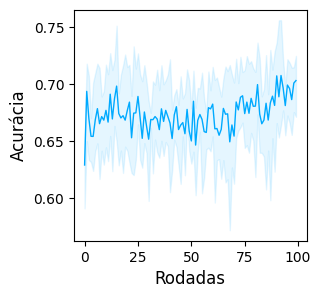

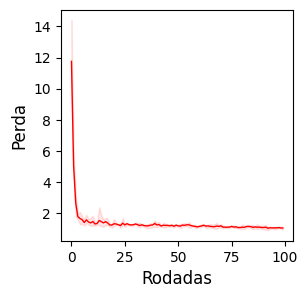

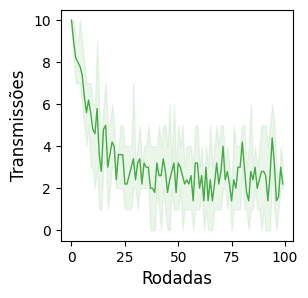

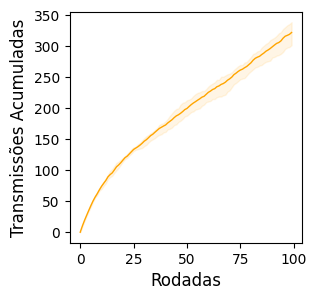

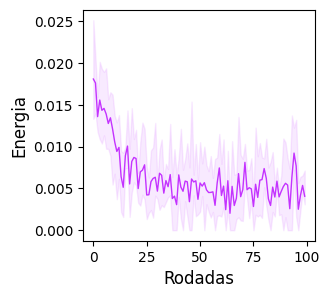

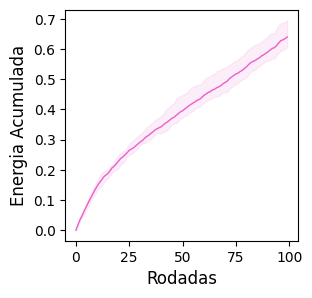

In [51]:
plotar_graficos(save_figure=SAVE_FIGURES, path="graficos/transmissao_aleatoria/validacao_epsilon_55/")